In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import simpy
from random import sample 
import datetime
from collections import defaultdict

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network

from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common
from tf_agents.policies import policy_saver
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import trajectory

import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

Loading trip data...
Data loading complete


In [2]:
#register custom environment
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper parameters

num_iterations = 20 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

epsilon_greedy = 0.01 #should be low for imitation learning, higher for regular q learning

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()

In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter,
    epsilon_greedy = epsilon_greedy)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)

In [6]:
#create dataset and iterator
#Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
hex count  114
Number of trips generated: 2016


In [8]:
#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [9]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            print(int(np.array([state_list[i]["observation"]])[0][1]))
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][1])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

7
[[20.2    7.     2.213 35.589]]
8
[[27.7         8.         39.48182185 39.32556003]]
9
[[11.1    9.    53.529 44.177]]
16
[[ 6.         16.         55.30974391 42.97640075]]
17
[[21.3        17.         40.08209568 52.11131203]]
18
[[15.1        18.         37.3533075  32.56925499]]
19
[[ 7.2        19.         37.06079858 31.93173146]]
19
[[12.        19.        22.3699405 44.2656018]]
20
[[ 3.4        20.         31.54940744 38.21908353]]
20
[[17.1        20.         38.12209242 24.12681584]]
22
[[20.9        22.         34.36579586  9.62204208]]
10
[[14.6        10.          1.37633123 29.61890052]]
10
[[13.         10.         11.95601602 42.78291576]]
11
[[ 4.5        11.          5.2528364  54.02017427]]
11
[[24.6        11.         32.30418761 56.07916277]]
12
[[10.5        12.         26.83352358 48.44684955]]
12
[[17.3        12.         19.84185283 33.56188484]]
12
[[31.         12.         35.58888003 23.9398597 ]]
13
[[35.3        13.         48.19147431 10.58154763]]
6


[[22.3        12.         28.67368891 53.2904254 ]]
13
[[10.4        13.         10.65357117 54.09661778]]
14
[[39.8        14.         32.34442104 18.21409276]]
17
[[ 4.2        17.         16.68699748 33.06179136]]
17
[[29.2        17.          0.6770435   5.15096286]]
17
[[15.8        17.          0.37770234 17.48919296]]
17
[[25.2        17.          3.98067819  6.27083827]]
17
[[27.6        17.         26.87166575 34.41072566]]
17
[[ 3.2        17.          7.44626932 31.16891712]]
17
[[27.8        17.         27.82503994 52.97027381]]
19
[[ 4.4        19.         23.3114538  54.84125247]]
19
[[ 8.5        19.         18.95906968 51.34372021]]
19
[[ 8.6        19.         17.46069784 54.05905781]]
19
[[11.7        19.         29.39017262 47.81153819]]
22
[[12.         22.         28.31198654 45.86274248]]
1
[[14.          1.         23.17717107 41.4978756 ]]
6
[[34.9         6.         45.60353486 13.42749539]]
15
[[26.7   15.    25.966 17.162]]
16
[[20.6        16.         22.242

[[ 8.9    7.     5.342 28.075]]
7
[[11.7         7.         11.01094194 24.28315659]]
8
[[20.5         8.         23.80451849 32.16882444]]
8
[[16.1         8.         38.09473891 32.3775437 ]]
10
[[ 5.6        10.         28.65508233 38.08159521]]
11
[[31.         11.         43.17675936 38.18114818]]
13
[[25.1        13.         27.57102753 18.27895759]]
14
[[14.1        14.         17.31730042 27.8379666 ]]
14
[[26.5        14.         16.86199912 12.44848193]]
15
[[ 5.    15.    13.451 23.811]]
15
[[ 4.5        15.          8.18796806 24.2170053 ]]
15
[[11.         15.          3.82461266 39.30702293]]
15
[[15.         15.         12.20175343 49.41978331]]
15
[[12.         15.         18.82262597 42.06649147]]
15
[[11.6        15.         17.50000073 42.15264693]]
15
[[26.        15.        20.208636  18.5831585]]
16
[[18.3        16.          6.93003464  4.74974529]]
17
[[29.         17.         10.06237049 41.33764524]]
17
[[19.3   17.     6.213 28.476]]
17
[[32.7        17.     

[[ 9.7        16.          3.16131725 34.05728954]]
16
[[42.5        16.         35.77262147  3.01175036]]
15
[[13.2        15.          8.23749823 21.04351255]]
15
[[18.2        15.          6.64135063 42.61626432]]
16
[[22.4   16.    19.271 48.75 ]]
16
[[ 9.2        16.         34.74980574 45.20575926]]
20
[[16.9   20.     7.167 33.11 ]]
20
[[18.6        20.         24.06545411 43.71799116]]
20
[[14.4   20.     6.745 45.42 ]]
20
[[ 8.6   20.     4.061 46.892]]
20
[[32.4        20.         45.01946817 38.8365464 ]]
6
[[24.3         6.         24.93237377 38.62770212]]
6
[[32.2         6.         52.20747231 28.82406616]]
22
[[11.6        22.         42.12906282 25.41177163]]
12
[[27.6   12.     3.255 32.99 ]]
12
[[27.         12.         28.02903106  8.39425059]]
16
[[ 6.6        16.         26.88135844  9.23067479]]
17
[[13.   17.    5.29  1.34]]
18
[[ 6.7   18.     3.437 18.31 ]]
18
[[12.9        18.         12.00409599 11.8750753 ]]
18
[[10.7        18.         15.48815073 21.77148

[[28.5        18.         35.63965127 28.43038805]]
19
[[ 4.7        19.         30.90115138 28.97929525]]
21
[[ 6.    21.     7.641 32.437]]
21
[[ 3.7        21.          0.70666329 32.26842844]]
22
[[ 5.1        22.         14.58778011 26.2058948 ]]
22
[[13.5        22.         16.57535846 23.37678491]]
23
[[17.6        23.          7.22065788 52.01551447]]
23
[[ 3.         23.          5.71472684 47.70232617]]
23
[[11.1        23.         17.04720976 42.85671342]]
23
[[ 4.         23.          7.48178454 54.71430023]]
0
[[37.7         0.         27.27324653 12.44654152]]
7
[[39.3    7.    26.158 47.738]]
7
[[29.6         7.         34.62187521 30.20410847]]
13
[[36.1   13.     7.457 53.838]]
13
[[26.6        13.         18.23426919 19.45034392]]
13
[[19.5        13.         11.41670694 45.11565146]]
13
[[16.4        13.          6.49566081 31.78602497]]
13
[[25.5        13.         23.34735003 48.56359371]]
13
[[26.7        13.         39.90534881 37.76343077]]
7
[[15.4         7.  

[[ 5.9        23.         16.83039308 30.00120547]]
driver reward  1194.9199999999998
8
[[ 3.3         8.         44.06515799 36.21645876]]
9
[[27.1    9.    10.997 31.073]]
9
[[16.2         9.         21.58196645 40.66824883]]
9
[[20.3         9.         24.59893506 58.06101995]]
9
[[ 8.1         9.          5.35003075 53.66784839]]
9
[[11.7    9.    12.003 40.778]]
9
[[ 6.2         9.         17.6325811  47.51298866]]
9
[[24.9         9.         20.0322939  21.93134018]]
9
[[ 4.8         9.          4.46087912 29.44798089]]
9
[[21.3         9.         16.19529198 33.9670204 ]]
10
[[11.1   10.    18.635 52.636]]
10
[[ 9.4        10.         20.31767369 53.0632307 ]]
11
[[28.2        11.         40.37515091 47.27867498]]
12
[[43.9   12.    10.691 19.719]]
12
[[17.8        12.         14.39166032 41.98354425]]
12
[[23.8        12.         35.15207962 45.3450561 ]]
15
[[ 4.2   15.    24.775 46.827]]
16
[[ 5.         16.         20.4670944  46.04553542]]
16
[[ 7.4        16.          9.28

[[ 2.8        17.          2.42235011 47.18605256]]
17
[[15.1        17.         17.38667881 51.90872586]]
17
[[ 7.7        17.          9.47160193 51.32611922]]
18
[[ 9.         18.         17.60565957 46.43609096]]
18
[[ 8.9        18.         14.21149897 34.24922201]]
18
[[17.6        18.         11.71468978 12.91590128]]
18
[[18.8        18.         20.8265143  21.67712935]]
19
[[35.8        19.         53.55415139 21.90647464]]
19
[[ 5.3        19.         50.12272024 18.24888905]]
22
[[10.7        22.         53.94361688 11.16262805]]
12
[[18.8   12.    46.547 29.032]]
22
[[26.2   22.    23.876 47.2  ]]
0
[[22.7         0.         47.25544367 20.65796797]]
driver reward  -850.2399999999992
total reward  4199.80000000001
trips [ 12.   7.   0.   0.   0.   6.  57. 100. 153. 102.  94.  58. 121. 156.
 122.  87.  98. 147. 136. 152. 129.  79.  60.  33.]
[1.0, 1.0, nan, nan, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [10]:
#evaluate a trained policy with respect to a pre-generated static environment

pickup_distance_brackets = [1, 2, 3, 4, 6, 10]
trip_distance_brackets = [5, 10, 15, 25, 35, 50]
    
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i
    
#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
    pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
    pickup_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                #print(np.array([state_list[i]["observation"]]))
                pickup_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            else:
                reward = 0
            #print (reward)
            driver_reward += reward
            pickup_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", pickup_trip_counts )
    for j in range(len(pickup_distance_brackets)+1):
        pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    print (pickup_accepted_trips)
    print(pickup_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

driver reward  -628.9999999999998
driver reward  -357.75999999999937
driver reward  657.2400000000002
driver reward  535.4000000000004
driver reward  -258.51999999999913
driver reward  777.7600000000004
driver reward  1233.0400000000002
driver reward  432.48000000000036
driver reward  1662.7600000000004
driver reward  -1091.8399999999986
driver reward  1023.2800000000008
driver reward  1225.1600000000008
driver reward  662.2800000000004
driver reward  -529.28
driver reward  -458.2399999999995
driver reward  613.9600000000002
driver reward  103.40000000000069
driver reward  1194.9199999999998
driver reward  -1746.9999999999998
driver reward  -850.2399999999992
total reward  4199.80000000001
trips [  11.   25.   37.   41.  134.  298. 1363.]
[  11.   25.   37.   41.  134.  298. 1363.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [11]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

7
8
9
16
[[ 6.         16.         55.30974391 42.97640075]]
17
18
19
[[ 7.2        19.         37.06079858 31.93173146]]
19
20
[[ 3.4        20.         31.54940744 38.21908353]]
20
22
10
10
11
[[ 4.5        11.          5.2528364  54.02017427]]
11
12
12
12
13
6
16
16
17
[[ 2.3        17.         25.38101203 30.56803949]]
17
[[ 3.5        17.          3.41597894 31.02998013]]
17
17
17
17
[[ 4.3        17.          8.62099062 46.4587075 ]]
17
19
17
18
18
19
[[ 6.4        19.         18.13805947 37.92251148]]
19
19
20
driver reward  -546.76
6
7
8
8
10
10
11
13
14
14
14
14
[[ 4.7        14.          9.78541332 26.83239692]]
14
14
14
[[ 6.2        14.         19.80944808 43.60534206]]
14
15
15
15
19
[[ 2.3        19.          8.21269288 10.7417186 ]]
19
9
[[ 2.9         9.         16.98921238 23.47513523]]
9
14
18
13
14
14
17
17
18
18
18
19
19
19
21
21
[[ 6.5        21.          2.96182785 42.76793593]]
21
21
22
22
[[ 7.5        22.         31.45379629 15.11022312]]
22
22
[[ 9.4   22.    

13
13
7
7
7
7
8
8
8
8
8
9
[[ 3.8    9.    11.876  3.222]]
9
12
12
12
13
13
13
13
14
14
14
14
14
15
16
16
21
6
6
7
7
7
7
7
8
21
21
[[ 8.9   21.    31.945 18.286]]
driver reward  -108.24
6
21
8
8
8
10
[[ 0.8        10.         33.177791   46.87699721]]
10
13
13
[[ 1.5        13.          9.57093929 46.57478745]]
14
[[ 3.6        14.          7.44845898 51.96747324]]
14
14
[[ 1.5        14.          6.58598019 30.63101772]]
14
[[ 0.9        14.          5.09394416 31.85027079]]
14
14
14
15
15
16
16
16
[[ 0.6        16.          8.93186055 56.24312232]]
16
16
16
[[ 5.5        16.          5.3558991  40.42910765]]
16
16
15
15
16
16
20
20
20
20
[[ 8.6   20.     4.061 46.892]]
20
6
6
22
12
12
16
[[ 6.6        16.         26.88135844  9.23067479]]
17
18
[[ 6.7   18.     3.437 18.31 ]]
18
18
18
19
[[ 4.7        19.          7.12592384 28.63604996]]
19
0
14
15
[[ 2.         15.          9.41902125 22.35849862]]
16
[[ 6.1   16.    13.893 21.634]]
16
17
17
17
[[ 1.8   17.     2.103 43.879]]
17
[[ 

16
17
17
17
[[ 6.1        17.         11.68353084 30.94217448]]
17
17
17
17
18
[[ 2.5   18.    26.087  4.055]]
18
[[ 3.5        18.         22.98487381 21.53178076]]
19
19
20
20
20
20
[[ 4.8        20.          6.71643112 23.97552818]]
21
[[ 7.3        21.          5.83068663 36.65524254]]
21
[[ 1.4        21.         18.24840598 45.58388766]]
21
[[ 2.7        21.         19.52592328 45.80416288]]
21
21
21
8
9
9
9
9
[[ 2.          9.          3.53090359 37.71656926]]
9
9
9
10
10
10
[[ 3.4        10.         24.11327921 44.03789779]]
11
11
12
12
13
13
[[ 2.1        13.          3.42046638 37.41735533]]
13
[[ 1.3        13.          6.31378277 35.67437288]]
13
13
13
14
[[ 2.9        14.          2.36789995 15.87120592]]
14
[[ 4.4        14.          4.2243169   1.80017052]]
16
16
16
17
17
[[ 2.    17.    24.165 25.814]]
17
17
17
18
18
18
18
[[ 2.         18.          8.0987776  40.93073803]]
19
19
19
[[ 3.4        19.         16.12854888 31.90040403]]
19
19
20
21
21
23
[[ 7.7        23. 

/Users/tarindujayatilaka/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()

## Reinforcement Learning Q-Learning

In [13]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

## Imitation Learning

### load data

In [16]:
#imitation learning strategy
#parse pickme data into trajectories
#pickup distance ignored since it is nto available in dataset
#load data
import pandas as pd 
import math
from tqdm import tqdm

driver_actions_table =  pd.read_csv("../data/driver-action.csv") 
trip_data =  pd.read_csv("../data/trip-data.csv") 

In [17]:
trip_data.head(10)

passengerslogid  driverid  pickuplatitude  pickuplongitude  droplatitude  \
0        212553104       188         6.03305          80.2168       6.07534   
1        212554705       188         6.93233          79.8492       6.91947   
2        212555287         0         6.93257          79.8486       6.82994   
3        212557334     18930         6.90514          79.8788       6.89894   
4        212558261    117344         6.88920          79.8895       6.91505   
5        212560424         0         7.21436          79.8471       7.22546   
6        212565638         0         6.88655          79.8583       6.92075   
7        212565684    107426         6.84864          79.9635       6.85434   
8        212567228     16925         6.86133          79.8781       6.85090   
9        212571010         0         7.03675          79.9023       7.02326   

   droplongitude       actualpickuptime  paymentmethod  isdirectionalhire  \
0        80.2346                    NaN              1                NaN   
1        79.9114                    NaN              1                NaN   
2        79.9101                    NaN              1                NaN   
3        79.8771  2020-02-01 01:00:37.0              1                NaN   
4        79.9531  2020-02-01 01:11:07.0              1                NaN   
5        79.8520                    NaN              1                NaN   
6        79.8561                    NaN              2                NaN   
7        79.8923  2020-02-01 05:42:07.0              1                NaN   
8        79.8661  2020-02-01 06:22:50.0              1                NaN   
9        79.9092                    NaN              1                NaN   

   distance  travelstatus  taximodelid            createddate  
0       NaN            11            1  2020-02-01 00:08:28.0  
1       NaN            12            1  2020-02-01 00:25:27.0  
2       NaN            11            1  2020-02-01 00:30:43.0  
3      1.28             1            1  2020-02-01 00:53:54.0  
4      9.78             1            1  2020-02-01 01:06:08.0  
5       NaN            11            1  2020-02-01 01:52:20.0  
6       NaN            11            1  2020-02-01 05:36:30.0  
7      9.80             1            1  2020-02-01 05:37:34.0  
8      2.28             1            1  2020-02-01 06:17:46.0  
9       NaN            11            1  2020-02-01 07:19:46.0

In [18]:
driver_actions_table.head(10)

trip_id  created_driver_id  assigned_driver_id  trip_recieved_driver_id  \
0  212552700                  0             38457.0                  38457.0   
1  212552700                  0             79308.0                  79308.0   
2  212552700                  0             60511.0                  60511.0   
3  212552700                  0             11251.0                  11251.0   
4  212552700                  0             22304.0                  22304.0   
5  212553052                  0             66075.0                  66075.0   
6  212553052                  0             25440.0                  25440.0   
7  212553052                  0             40092.0                  40092.0   
8  212553052                  0             56333.0                  56333.0   
9  212553052                  0             75565.0                  75565.0   

   rejected_driver_id  accepted_driver_id  arrived_driver_id  \
0             38457.0                 NaN                NaN   
1             79308.0                 NaN                NaN   
2             60511.0                 NaN                NaN   
3             11251.0                 NaN                NaN   
4             22304.0                 NaN                NaN   
5             66075.0             66075.0                NaN   
6             25440.0                 NaN                NaN   
7             40092.0                 NaN                NaN   
8             56333.0                 NaN                NaN   
9             75565.0                 NaN                NaN   

   started_driver_id  ended_driver_id  completed_driver_id  vehicle_type  \
0                NaN              NaN                  NaN             1   
1                NaN              NaN                  NaN             1   
2                NaN              NaN                  NaN             1   
3                NaN              NaN                  NaN             1   
4                NaN              NaN                  NaN             1   
5                NaN              NaN                  NaN             1   
6                NaN              NaN                  NaN             1   
7                NaN              NaN                  NaN             1   
8                NaN              NaN                  NaN             1   
9                NaN              NaN                  NaN             1   

  created_date   rejection_type  
0   2020-02-01  SYSTEM_REJECTED  
1   2020-02-01  SYSTEM_REJECTED  
2   2020-02-01           MANUAL  
3   2020-02-01  SYSTEM_REJECTED  
4   2020-02-01           MANUAL  
5   2020-02-01   AFTER_ACCEPTED  
6   2020-02-01  SYSTEM_REJECTED  
7   2020-02-01  SYSTEM_REJECTED  
8   2020-02-01           MANUAL  
9   2020-02-01           MANUAL

### data preprocessing

In [19]:
#drop duplicated rows
driver_actions_table.drop_duplicates(keep = 'first', inplace = True)

#drop rows with assigned driver null
driver_actions_table.drop(driver_actions_table[driver_actions_table['assigned_driver_id'].isnull()].index, inplace=True)

In [20]:
#make a double index
driver_actions_table[['trip_id', 'assigned_driver_id']] = driver_actions_table[['trip_id', 'assigned_driver_id']].apply(pd.to_numeric).applymap(np.int64).astype(str)
driver_actions_table.set_index(['assigned_driver_id', 'trip_id'], inplace=True)
driver_actions_table.head()

created_driver_id  trip_recieved_driver_id  \
assigned_driver_id trip_id                                                 
38457              212552700                  0                  38457.0   
79308              212552700                  0                  79308.0   
60511              212552700                  0                  60511.0   
11251              212552700                  0                  11251.0   
22304              212552700                  0                  22304.0   

                              rejected_driver_id  accepted_driver_id  \
assigned_driver_id trip_id                                             
38457              212552700             38457.0                 NaN   
79308              212552700             79308.0                 NaN   
60511              212552700             60511.0                 NaN   
11251              212552700             11251.0                 NaN   
22304              212552700             22304.0                 NaN   

                              arrived_driver_id  started_driver_id  \
assigned_driver_id trip_id                                           
38457              212552700                NaN                NaN   
79308              212552700                NaN                NaN   
60511              212552700                NaN                NaN   
11251              212552700                NaN                NaN   
22304              212552700                NaN                NaN   

                              ended_driver_id  completed_driver_id  \
assigned_driver_id trip_id                                           
38457              212552700              NaN                  NaN   
79308              212552700              NaN                  NaN   
60511              212552700              NaN                  NaN   
11251              212552700              NaN                  NaN   
22304              212552700              NaN                  NaN   

                              vehicle_type created_date   rejection_type  
assigned_driver_id trip_id                                                
38457              212552700             1   2020-02-01  SYSTEM_REJECTED  
79308              212552700             1   2020-02-01  SYSTEM_REJECTED  
60511              212552700             1   2020-02-01           MANUAL  
11251              212552700             1   2020-02-01  SYSTEM_REJECTED  
22304              212552700             1   2020-02-01           MANUAL

In [21]:
#get the week number
driver_actions_table['created_date'] = pd.to_datetime(driver_actions_table['created_date'])

def getWeekNumber(x):
    if datetime.date(2020, 2, 3) <= x <= datetime.date(2020, 2, 9):
        return 1
    elif datetime.date(2020, 2, 10) <= x <= datetime.date(2020, 2, 16):
        return 2
    elif datetime.date(2020, 2, 17) <= x <= datetime.date(2020, 2, 23):
        return 3
    elif datetime.date(2020, 2, 24) <= x <= datetime.date(2020, 3, 1):
        return 4
    else:
        return 0

driver_actions_table['week_no'] = driver_actions_table['created_date'].apply(getWeekNumber)

In [22]:
#drop week number 0 trips
driver_actions_table.drop(driver_actions_table[driver_actions_table['week_no']==0].index, inplace=True)

In [ ]:
#count accepted trips within the week

def count_accepted_trips(df, week_num):
    trip_counts = defaultdict(int)
    for index, row in tqdm(df[(df['week_no']==week_num)].iterrows()):
        driver_id = index[0]
        df.at[index,'accepted_trip_count'] = trip_counts[driver_id]
        if not np.isnan(row['accepted_driver_id']):
          trip_counts[driver_id] += 1

driver_actions_table['accepted_trip_count'] = 0

for week in tqdm(range(1,5)):
    count_accepted_trips(driver_actions_table,week)

  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:06,  6.05s/it]
21it [00:06,  4.23s/it]
41it [00:06,  2.96s/it]
64it [00:06,  2.08s/it]
87it [00:06,  1.46s/it]
110it [00:06,  1.02s/it]
134it [00:06,  1.40it/s]
157it [00:06,  1.99it/s]
178it [00:06,  2.83it/s]
201it [00:06,  4.03it/s]
224it [00:07,  5.71it/s]
246it [00:07,  8.06it/s]
269it [00:07, 11.33it/s]
291it [00:07, 15.82it/s]
313it [00:07, 21.93it/s]
335it [00:07, 30.04it/s]
358it [00:07, 40.56it/s]
381it [00:07, 53.78it/s]
403it [00:07, 69.32it/s]
425it [00:08, 86.46it/s]
447it [00:08, 104.90it/s]
470it [00:08, 124.82it/s]
493it [00:08, 144.25it/s]
516it [00:08, 162.27it/s]
539it [00:08, 176.63it/s]
562it [00:08, 186.82it/s]
585it [00:08, 193.80it/s]
607it [00:08, 199.93it/s]
629it [00:08, 202.41it/s]
651it [00:09, 200.30it/s]
674it [00:09, 207.19it/s]
697it [00:09, 211.88it/s]
720it [00:09, 216.29it/s]
743it [00:09, 218.41it/s]
766it [00:09, 220.78it/s]
790it [00:09, 224.64it/s]
814it [00:09, 226.67it/s]
838it [

6348it [00:34, 225.61it/s]
6372it [00:34, 228.06it/s]
6396it [00:34, 229.19it/s]
6421it [00:34, 232.51it/s]
6445it [00:34, 233.60it/s]
6469it [00:34, 234.72it/s]
6493it [00:35, 235.82it/s]
6517it [00:35, 233.80it/s]
6541it [00:35, 234.92it/s]
6565it [00:35, 235.62it/s]
6589it [00:35, 234.61it/s]
6613it [00:35, 233.03it/s]
6637it [00:35, 233.60it/s]
6661it [00:35, 233.60it/s]
6685it [00:35, 234.17it/s]
6709it [00:35, 233.78it/s]
6733it [00:36, 233.72it/s]
6757it [00:36, 233.59it/s]
6781it [00:36, 233.88it/s]
6806it [00:36, 236.17it/s]
6830it [00:36, 235.35it/s]
6854it [00:36, 236.06it/s]
6878it [00:36, 236.38it/s]
6902it [00:36, 236.63it/s]
6926it [00:36, 236.92it/s]
6951it [00:37, 238.14it/s]
6975it [00:37, 237.89it/s]
6999it [00:37, 237.17it/s]
7023it [00:37, 235.06it/s]
7047it [00:37, 234.81it/s]
7071it [00:37, 234.08it/s]
7095it [00:37, 234.22it/s]
7119it [00:37, 234.75it/s]
7143it [00:37, 235.77it/s]
7168it [00:37, 237.14it/s]
7192it [00:38, 235.32it/s]
7216it [00:38, 232.24it/s]
7

12856it [01:02, 234.94it/s]
12880it [01:02, 232.45it/s]
12904it [01:02, 231.74it/s]
12928it [01:02, 233.05it/s]
12952it [01:02, 234.30it/s]
12976it [01:02, 234.87it/s]
13000it [01:02, 234.82it/s]
13024it [01:02, 235.28it/s]
13048it [01:02, 236.21it/s]
13072it [01:02, 233.38it/s]
13096it [01:03, 234.50it/s]
13120it [01:03, 235.56it/s]
13144it [01:03, 236.35it/s]
13168it [01:03, 236.75it/s]
13192it [01:03, 235.62it/s]
13216it [01:03, 236.61it/s]
13240it [01:03, 236.02it/s]
13264it [01:03, 233.86it/s]
13289it [01:03, 236.22it/s]
13313it [01:04, 233.18it/s]
13337it [01:04, 234.84it/s]
13361it [01:04, 234.77it/s]
13385it [01:04, 236.05it/s]
13410it [01:04, 237.67it/s]
13434it [01:04, 237.40it/s]
13458it [01:04, 236.41it/s]
13483it [01:04, 237.90it/s]
13507it [01:04, 237.46it/s]
13531it [01:04, 236.90it/s]
13555it [01:05, 236.24it/s]
13579it [01:05, 214.27it/s]
13603it [01:05, 218.89it/s]
13627it [01:05, 224.46it/s]
13652it [01:05, 228.90it/s]
13676it [01:05, 230.67it/s]
13700it [01:05, 231.

19246it [01:29, 238.49it/s]
19271it [01:29, 239.20it/s]
19295it [01:29, 238.51it/s]
19319it [01:29, 238.60it/s]
19343it [01:29, 238.90it/s]
19367it [01:29, 237.86it/s]
19391it [01:29, 238.13it/s]
19415it [01:30, 238.17it/s]
19439it [01:30, 236.65it/s]
19463it [01:30, 234.33it/s]
19487it [01:30, 235.73it/s]
19512it [01:30, 237.43it/s]
19536it [01:30, 237.51it/s]
19560it [01:30, 237.12it/s]
19585it [01:30, 238.61it/s]
19610it [01:30, 239.20it/s]
19634it [01:30, 239.24it/s]
19659it [01:31, 239.75it/s]
19683it [01:31, 237.06it/s]
19707it [01:31, 236.79it/s]
19731it [01:31, 235.51it/s]
19755it [01:31, 235.75it/s]
19779it [01:31, 235.98it/s]
19803it [01:31, 236.57it/s]
19827it [01:31, 236.13it/s]
19851it [01:31, 236.71it/s]
19875it [01:31, 236.67it/s]
19899it [01:32, 236.82it/s]
19923it [01:32, 237.37it/s]
19947it [01:32, 236.11it/s]
19971it [01:32, 237.25it/s]
19995it [01:32, 236.40it/s]
20019it [01:32, 235.70it/s]
20043it [01:32, 236.86it/s]
20067it [01:32, 232.76it/s]
20092it [01:32, 235.

25658it [01:56, 240.11it/s]
25683it [01:56, 239.31it/s]
25708it [01:56, 240.01it/s]
25733it [01:56, 238.77it/s]
25757it [01:56, 230.74it/s]
25781it [01:57, 232.60it/s]
25805it [01:57, 232.63it/s]
25829it [01:57, 232.47it/s]
25853it [01:57, 233.94it/s]
25877it [01:57, 234.98it/s]
25901it [01:57, 234.29it/s]
25925it [01:57, 235.17it/s]
25949it [01:57, 236.51it/s]
25974it [01:57, 238.61it/s]
25998it [01:57, 238.91it/s]
26022it [01:58, 238.82it/s]
26046it [01:58, 238.49it/s]
26071it [01:58, 239.18it/s]
26095it [01:58, 239.06it/s]
26120it [01:58, 239.60it/s]
26144it [01:58, 237.15it/s]
26168it [01:58, 237.82it/s]
26192it [01:58, 236.76it/s]
26217it [01:58, 239.20it/s]
26241it [01:58, 238.23it/s]
26266it [01:59, 239.79it/s]
26290it [01:59, 239.61it/s]
26314it [01:59, 239.13it/s]
26338it [01:59, 238.19it/s]
26362it [01:59, 237.89it/s]
26386it [01:59, 236.86it/s]
26411it [01:59, 238.08it/s]
26435it [01:59, 238.28it/s]
26460it [01:59, 239.05it/s]
26484it [02:00, 238.18it/s]
26508it [02:00, 236.

32021it [02:23, 236.82it/s]
32045it [02:23, 235.40it/s]
32069it [02:23, 236.57it/s]
32093it [02:23, 237.36it/s]
32118it [02:24, 238.55it/s]
32143it [02:24, 239.84it/s]
32167it [02:24, 239.76it/s]
32191it [02:24, 238.32it/s]
32216it [02:24, 238.17it/s]
32240it [02:24, 237.13it/s]
32264it [02:24, 237.64it/s]
32288it [02:24, 236.64it/s]
32313it [02:24, 237.85it/s]
32337it [02:24, 237.31it/s]
32361it [02:25, 235.45it/s]
32386it [02:25, 237.20it/s]
32410it [02:25, 233.36it/s]
32434it [02:25, 234.05it/s]
32458it [02:25, 235.70it/s]
32482it [02:25, 236.12it/s]
32507it [02:25, 237.51it/s]
32532it [02:25, 238.42it/s]
32557it [02:25, 239.66it/s]
32581it [02:26, 234.58it/s]
32606it [02:26, 236.84it/s]
32630it [02:26, 235.90it/s]
32654it [02:26, 235.17it/s]
32678it [02:26, 235.53it/s]
32702it [02:26, 235.37it/s]
32726it [02:26, 235.91it/s]
32750it [02:26, 235.50it/s]
32774it [02:26, 235.47it/s]
32799it [02:26, 237.37it/s]
32824it [02:27, 239.31it/s]
32848it [02:27, 238.57it/s]
32872it [02:27, 237.

38440it [02:50, 238.26it/s]
38465it [02:50, 239.03it/s]
38490it [02:50, 239.91it/s]
38514it [02:51, 239.60it/s]
38539it [02:51, 239.92it/s]
38563it [02:51, 238.36it/s]
38587it [02:51, 235.31it/s]
38611it [02:51, 235.93it/s]
38636it [02:51, 238.82it/s]
38660it [02:51, 236.07it/s]
38684it [02:51, 235.76it/s]
38708it [02:51, 236.16it/s]
38732it [02:51, 235.47it/s]
38756it [02:52, 235.90it/s]
38780it [02:52, 235.15it/s]
38804it [02:52, 235.04it/s]
38828it [02:52, 234.54it/s]
38853it [02:52, 236.26it/s]
38877it [02:52, 236.22it/s]
38901it [02:52, 237.07it/s]
38926it [02:52, 237.73it/s]
38951it [02:52, 239.38it/s]
38975it [02:52, 239.47it/s]
39000it [02:53, 240.24it/s]
39025it [02:53, 236.99it/s]
39050it [02:53, 238.33it/s]
39075it [02:53, 240.00it/s]
39100it [02:53, 237.88it/s]
39124it [02:53, 238.25it/s]
39149it [02:53, 239.12it/s]
39173it [02:53, 238.69it/s]
39198it [02:53, 239.87it/s]
39223it [02:53, 241.33it/s]
39248it [02:54, 239.27it/s]
39272it [02:54, 236.06it/s]
39297it [02:54, 238.

44870it [03:17, 238.25it/s]
44895it [03:17, 238.72it/s]
44919it [03:17, 238.52it/s]
44943it [03:18, 238.52it/s]
44967it [03:18, 238.30it/s]
44991it [03:18, 234.85it/s]
45015it [03:18, 236.03it/s]
45039it [03:18, 234.06it/s]
45064it [03:18, 235.78it/s]
45088it [03:18, 236.03it/s]
45113it [03:18, 237.33it/s]
45138it [03:18, 238.53it/s]
45163it [03:19, 239.54it/s]
45187it [03:19, 237.96it/s]
45211it [03:19, 237.73it/s]
45235it [03:19, 237.87it/s]
45259it [03:19, 237.43it/s]
45283it [03:19, 237.22it/s]
45308it [03:19, 238.79it/s]
45333it [03:19, 239.40it/s]
45358it [03:19, 239.78it/s]
45382it [03:19, 239.32it/s]
45406it [03:20, 238.73it/s]
45430it [03:20, 236.32it/s]
45454it [03:20, 235.20it/s]
45478it [03:20, 235.26it/s]
45502it [03:20, 234.15it/s]
45527it [03:20, 236.21it/s]
45551it [03:20, 233.56it/s]
45575it [03:20, 234.64it/s]
45600it [03:20, 236.61it/s]
45624it [03:20, 236.87it/s]
45648it [03:21, 235.58it/s]
45672it [03:21, 235.13it/s]
45696it [03:21, 235.65it/s]
45720it [03:21, 236.

51269it [03:44, 235.51it/s]
51293it [03:44, 235.51it/s]
51317it [03:45, 236.71it/s]
51341it [03:45, 237.21it/s]
51366it [03:45, 239.01it/s]
51390it [03:45, 237.22it/s]
51414it [03:45, 234.62it/s]
51439it [03:45, 236.69it/s]
51463it [03:45, 237.31it/s]
51488it [03:45, 238.65it/s]
51512it [03:45, 238.86it/s]
51536it [03:45, 234.47it/s]
51560it [03:46, 235.10it/s]
51584it [03:46, 234.61it/s]
51608it [03:46, 233.46it/s]
51632it [03:46, 231.47it/s]
51656it [03:46, 233.51it/s]
51680it [03:46, 233.61it/s]
51704it [03:46, 233.22it/s]
51728it [03:46, 233.44it/s]
51753it [03:46, 236.13it/s]
51778it [03:47, 237.69it/s]
51802it [03:47, 238.37it/s]
51826it [03:47, 235.10it/s]
51850it [03:47, 236.09it/s]
51875it [03:47, 237.55it/s]
51900it [03:47, 238.44it/s]
51924it [03:47, 237.71it/s]
51948it [03:47, 236.90it/s]
51973it [03:47, 238.08it/s]
51998it [03:47, 238.74it/s]
52023it [03:48, 239.35it/s]
52047it [03:48, 239.45it/s]
52071it [03:48, 239.52it/s]
52095it [03:48, 238.71it/s]
52119it [03:48, 238.

57663it [04:11, 237.70it/s]
57687it [04:11, 237.12it/s]
57711it [04:12, 236.00it/s]
57735it [04:12, 236.70it/s]
57759it [04:12, 232.66it/s]
57783it [04:12, 233.78it/s]
57807it [04:12, 234.63it/s]
57831it [04:12, 234.60it/s]
57855it [04:12, 234.98it/s]
57879it [04:12, 235.61it/s]
57903it [04:12, 234.65it/s]
57927it [04:12, 235.82it/s]
57951it [04:13, 236.28it/s]
57975it [04:13, 236.86it/s]
57999it [04:13, 236.73it/s]
58023it [04:13, 235.67it/s]
58047it [04:13, 236.62it/s]
58072it [04:13, 238.31it/s]
58096it [04:13, 236.98it/s]
58120it [04:13, 237.36it/s]
58144it [04:13, 236.75it/s]
58169it [04:14, 237.53it/s]
58193it [04:14, 234.70it/s]
58217it [04:14, 235.46it/s]
58241it [04:14, 236.21it/s]
58265it [04:14, 233.67it/s]
58290it [04:14, 235.67it/s]
58314it [04:14, 236.92it/s]
58338it [04:14, 237.57it/s]
58362it [04:14, 235.59it/s]
58386it [04:14, 236.54it/s]
58410it [04:15, 235.58it/s]
58434it [04:15, 232.04it/s]
58458it [04:15, 233.94it/s]
58482it [04:15, 235.71it/s]
58506it [04:15, 233.

64029it [04:38, 238.02it/s]
64054it [04:39, 238.70it/s]
64079it [04:39, 239.29it/s]
64103it [04:39, 237.96it/s]
64127it [04:39, 238.40it/s]
64151it [04:39, 237.75it/s]
64175it [04:39, 237.62it/s]
64199it [04:39, 235.76it/s]
64223it [04:39, 228.28it/s]
64247it [04:39, 228.95it/s]
64272it [04:39, 232.99it/s]
64296it [04:40, 232.52it/s]
64320it [04:40, 234.67it/s]
64344it [04:40, 235.52it/s]
64368it [04:40, 236.68it/s]
64393it [04:40, 238.00it/s]
64417it [04:40, 238.38it/s]
64441it [04:40, 236.93it/s]
64465it [04:40, 236.70it/s]
64489it [04:40, 237.12it/s]
64513it [04:40, 237.20it/s]
64537it [04:41, 235.26it/s]
64561it [04:41, 235.62it/s]
64586it [04:41, 237.96it/s]
64610it [04:41, 237.82it/s]
64634it [04:41, 237.96it/s]
64658it [04:41, 236.79it/s]
64682it [04:41, 234.45it/s]
64706it [04:41, 234.45it/s]
64730it [04:41, 234.45it/s]
64754it [04:41, 234.77it/s]
64778it [04:42, 235.51it/s]
64802it [04:42, 235.71it/s]
64826it [04:42, 235.98it/s]
64850it [04:42, 237.02it/s]
64874it [04:42, 236.

70399it [05:05, 231.55it/s]
70423it [05:06, 233.53it/s]
70447it [05:06, 233.75it/s]
70471it [05:06, 233.51it/s]
70495it [05:06, 233.41it/s]
70519it [05:06, 232.71it/s]
70543it [05:06, 230.20it/s]
70567it [05:06, 230.43it/s]
70591it [05:06, 230.04it/s]
70615it [05:06, 231.52it/s]
70639it [05:07, 233.42it/s]
70663it [05:07, 233.39it/s]
70687it [05:07, 233.48it/s]
70711it [05:07, 234.32it/s]
70735it [05:07, 235.28it/s]
70759it [05:07, 236.27it/s]
70783it [05:07, 236.12it/s]
70807it [05:07, 236.60it/s]
70831it [05:07, 235.46it/s]
70856it [05:07, 237.15it/s]
70880it [05:08, 237.06it/s]
70904it [05:08, 235.70it/s]
70928it [05:08, 235.54it/s]
70952it [05:08, 236.28it/s]
70976it [05:08, 236.20it/s]
71000it [05:08, 236.49it/s]
71024it [05:08, 236.61it/s]
71048it [05:08, 234.86it/s]
71072it [05:08, 234.96it/s]
71096it [05:08, 235.15it/s]
71121it [05:09, 236.78it/s]
71145it [05:09, 236.36it/s]
71169it [05:09, 235.55it/s]
71193it [05:09, 235.32it/s]
71217it [05:09, 236.14it/s]
71241it [05:09, 236.

76722it [05:33, 236.81it/s]
76746it [05:33, 237.23it/s]
76770it [05:33, 237.14it/s]
76794it [05:33, 237.05it/s]
76818it [05:33, 236.36it/s]
76842it [05:33, 234.22it/s]
76866it [05:33, 233.43it/s]
76890it [05:33, 233.46it/s]
76914it [05:34, 233.26it/s]
76938it [05:34, 233.58it/s]
76962it [05:34, 234.67it/s]
76986it [05:34, 235.33it/s]
77011it [05:34, 237.37it/s]
77035it [05:34, 234.73it/s]
77060it [05:34, 237.20it/s]
77084it [05:34, 234.66it/s]
77109it [05:34, 236.64it/s]
77133it [05:34, 235.97it/s]
77158it [05:35, 237.43it/s]
77182it [05:35, 235.99it/s]
77206it [05:35, 234.99it/s]
77230it [05:35, 234.92it/s]
77255it [05:35, 236.98it/s]
77279it [05:35, 236.77it/s]
77303it [05:35, 237.48it/s]
77327it [05:35, 236.49it/s]
77352it [05:35, 237.90it/s]
77376it [05:36, 238.11it/s]
77401it [05:36, 239.44it/s]
77425it [05:36, 239.12it/s]
77449it [05:36, 239.07it/s]
77473it [05:36, 238.59it/s]
77497it [05:36, 237.84it/s]
77521it [05:36, 234.46it/s]
77545it [05:36, 234.70it/s]
77569it [05:36, 235.

83117it [06:00, 236.85it/s]
83142it [06:00, 238.57it/s]
83166it [06:00, 236.81it/s]
83190it [06:00, 236.90it/s]
83214it [06:00, 234.16it/s]
83238it [06:00, 235.50it/s]
83263it [06:00, 238.29it/s]
83287it [06:00, 238.39it/s]
83311it [06:01, 237.62it/s]
83335it [06:01, 237.76it/s]
83359it [06:01, 237.30it/s]
83384it [06:01, 239.09it/s]
83408it [06:01, 236.54it/s]
83432it [06:01, 235.56it/s]
83456it [06:01, 236.52it/s]
83481it [06:01, 237.95it/s]
83505it [06:01, 237.07it/s]
83529it [06:02, 236.20it/s]
83553it [06:02, 236.19it/s]
83578it [06:02, 237.98it/s]
83602it [06:02, 238.13it/s]
83627it [06:02, 239.50it/s]
83651it [06:02, 234.79it/s]
83676it [06:02, 237.34it/s]
83700it [06:02, 237.84it/s]
83724it [06:02, 237.75it/s]
83748it [06:02, 237.62it/s]
83773it [06:03, 238.67it/s]
83797it [06:03, 238.27it/s]
83821it [06:03, 237.98it/s]
83845it [06:03, 238.46it/s]
83870it [06:03, 239.75it/s]
83894it [06:03, 236.30it/s]
83919it [06:03, 237.67it/s]
83944it [06:03, 238.69it/s]
83968it [06:03, 237.

89510it [06:27, 236.96it/s]
89534it [06:27, 237.38it/s]
89558it [06:27, 237.61it/s]
89582it [06:27, 237.89it/s]
89606it [06:27, 237.09it/s]
89631it [06:27, 238.80it/s]
89655it [06:27, 239.13it/s]
89679it [06:27, 238.01it/s]
89703it [06:28, 238.22it/s]
89727it [06:28, 232.15it/s]
89751it [06:28, 233.97it/s]
89775it [06:28, 235.31it/s]
89799it [06:28, 235.71it/s]
89823it [06:28, 233.95it/s]
89847it [06:28, 234.49it/s]
89872it [06:28, 236.66it/s]
89896it [06:28, 235.83it/s]
89921it [06:28, 237.24it/s]
89946it [06:29, 238.31it/s]
89971it [06:29, 239.04it/s]
89995it [06:29, 238.44it/s]
90020it [06:29, 239.66it/s]
90045it [06:29, 240.35it/s]
90070it [06:29, 239.99it/s]
90095it [06:29, 239.99it/s]
90120it [06:29, 238.52it/s]
90144it [06:29, 238.88it/s]
90169it [06:30, 239.88it/s]
90194it [06:30, 240.36it/s]
90219it [06:30, 237.57it/s]
90243it [06:30, 237.19it/s]
90268it [06:30, 238.34it/s]
90293it [06:30, 239.35it/s]
90317it [06:30, 239.37it/s]
90341it [06:30, 238.55it/s]
90365it [06:30, 237.

95920it [06:54, 237.98it/s]
95944it [06:54, 236.27it/s]
95968it [06:54, 233.86it/s]
95992it [06:54, 232.11it/s]
96016it [06:54, 232.89it/s]
96040it [06:54, 234.50it/s]
96065it [06:54, 236.51it/s]
96089it [06:55, 236.84it/s]
96113it [06:55, 235.08it/s]
96137it [06:55, 236.51it/s]
96162it [06:55, 237.66it/s]
96187it [06:55, 238.54it/s]
96212it [06:55, 239.77it/s]
96236it [06:55, 237.95it/s]
96260it [06:55, 236.74it/s]
96284it [06:55, 235.52it/s]
96308it [06:55, 236.24it/s]
96333it [06:56, 237.70it/s]
96358it [06:56, 238.77it/s]
96382it [06:56, 237.42it/s]
96406it [06:56, 237.68it/s]
96430it [06:56, 237.10it/s]
96454it [06:56, 236.83it/s]
96478it [06:56, 233.85it/s]
96502it [06:56, 234.23it/s]
96526it [06:56, 233.89it/s]
96550it [06:56, 234.96it/s]
96574it [06:57, 234.96it/s]
96598it [06:57, 234.89it/s]
96622it [06:57, 234.96it/s]
96646it [06:57, 235.90it/s]
96670it [06:57, 235.98it/s]
96694it [06:57, 236.24it/s]
96718it [06:57, 237.34it/s]
96743it [06:57, 238.96it/s]
96767it [06:57, 238.

102220it [07:21, 236.44it/s]
102244it [07:21, 236.90it/s]
102269it [07:21, 237.93it/s]
102293it [07:21, 237.24it/s]
102317it [07:21, 236.71it/s]
102342it [07:21, 238.14it/s]
102366it [07:21, 236.80it/s]
102390it [07:21, 237.59it/s]
102415it [07:22, 238.47it/s]
102439it [07:22, 238.51it/s]
102464it [07:22, 239.33it/s]
102488it [07:22, 237.68it/s]
102512it [07:22, 237.98it/s]
102536it [07:22, 236.25it/s]
102560it [07:22, 236.79it/s]
102584it [07:22, 236.78it/s]
102608it [07:22, 236.15it/s]
102632it [07:22, 235.35it/s]
102656it [07:23, 234.64it/s]
102680it [07:23, 234.71it/s]
102704it [07:23, 235.05it/s]
102728it [07:23, 234.98it/s]
102752it [07:23, 233.80it/s]
102776it [07:23, 235.51it/s]
102800it [07:23, 232.55it/s]
102824it [07:23, 232.32it/s]
102849it [07:23, 235.15it/s]
102874it [07:23, 237.28it/s]
102898it [07:24, 236.70it/s]
102922it [07:24, 237.52it/s]
102946it [07:24, 237.81it/s]
102970it [07:24, 237.23it/s]
102994it [07:24, 236.93it/s]
103018it [07:24, 234.60it/s]
103043it [07:2

108423it [07:47, 237.24it/s]
108447it [07:47, 237.48it/s]
108471it [07:47, 237.70it/s]
108495it [07:47, 236.85it/s]
108519it [07:47, 236.85it/s]
108543it [07:47, 237.41it/s]
108567it [07:48, 236.26it/s]
108591it [07:48, 235.87it/s]
108615it [07:48, 236.38it/s]
108640it [07:48, 238.16it/s]
108664it [07:48, 237.95it/s]
108688it [07:48, 238.27it/s]
108712it [07:48, 235.28it/s]
108736it [07:48, 233.17it/s]
108760it [07:48, 234.81it/s]
108784it [07:48, 233.88it/s]
108808it [07:49, 235.43it/s]
108832it [07:49, 235.98it/s]
108856it [07:49, 234.00it/s]
108881it [07:49, 236.80it/s]
108905it [07:49, 237.68it/s]
108929it [07:49, 238.20it/s]
108953it [07:49, 238.25it/s]
108977it [07:49, 238.64it/s]
109002it [07:49, 239.23it/s]
109026it [07:49, 238.15it/s]
109050it [07:50, 238.11it/s]
109074it [07:50, 237.12it/s]
109098it [07:50, 237.44it/s]
109122it [07:50, 237.76it/s]
109146it [07:50, 236.81it/s]
109170it [07:50, 237.67it/s]
109194it [07:50, 236.55it/s]
109219it [07:50, 238.34it/s]
109244it [07:5

114657it [08:13, 235.91it/s]
114681it [08:13, 236.97it/s]
114705it [08:13, 237.26it/s]
114730it [08:14, 238.77it/s]
114754it [08:14, 238.94it/s]
114778it [08:14, 238.66it/s]
114802it [08:14, 238.26it/s]
114826it [08:14, 237.27it/s]
114851it [08:14, 238.55it/s]
114875it [08:14, 236.17it/s]
114899it [08:14, 236.60it/s]
114924it [08:14, 238.04it/s]
114948it [08:14, 238.35it/s]
114972it [08:15, 236.53it/s]
114996it [08:15, 236.71it/s]
115020it [08:15, 237.21it/s]
115044it [08:15, 237.04it/s]
115069it [08:15, 238.28it/s]
115093it [08:15, 238.44it/s]
115117it [08:15, 237.79it/s]
115141it [08:15, 237.06it/s]
115165it [08:15, 237.36it/s]
115190it [08:15, 238.60it/s]
115214it [08:16, 236.92it/s]
115238it [08:16, 235.18it/s]
115262it [08:16, 223.90it/s]
115286it [08:16, 228.21it/s]
115310it [08:16, 228.92it/s]
115333it [08:16, 228.50it/s]
115357it [08:16, 230.95it/s]
115382it [08:16, 233.93it/s]
115406it [08:16, 235.45it/s]
115431it [08:16, 237.61it/s]
115455it [08:17, 237.62it/s]
115479it [08:1

120864it [08:40, 222.45it/s]
120887it [08:40, 222.08it/s]
120911it [08:40, 225.92it/s]
120935it [08:40, 227.35it/s]
120960it [08:40, 231.37it/s]
120984it [08:40, 232.93it/s]
121008it [08:40, 231.99it/s]
121033it [08:40, 235.08it/s]
121057it [08:40, 234.08it/s]
121082it [08:41, 235.87it/s]
121107it [08:41, 237.96it/s]
121131it [08:41, 238.33it/s]
121156it [08:41, 239.24it/s]
121180it [08:41, 238.07it/s]
121204it [08:41, 237.57it/s]
121228it [08:41, 237.22it/s]
121252it [08:41, 236.73it/s]
121276it [08:41, 237.40it/s]
121301it [08:41, 238.06it/s]
121325it [08:42, 237.18it/s]
121349it [08:42, 236.51it/s]
121373it [08:42, 235.66it/s]
121397it [08:42, 235.37it/s]
121421it [08:42, 234.64it/s]
121445it [08:42, 232.82it/s]
121470it [08:42, 235.98it/s]
121494it [08:42, 234.57it/s]
121518it [08:42, 235.30it/s]
121542it [08:42, 236.12it/s]
121566it [08:43, 233.07it/s]
121590it [08:43, 231.93it/s]
121615it [08:43, 234.59it/s]
121639it [08:43, 233.88it/s]
121663it [08:43, 235.23it/s]
121687it [08:4

127074it [09:06, 235.21it/s]
127098it [09:06, 235.78it/s]
127122it [09:06, 232.93it/s]
127146it [09:06, 234.85it/s]
127170it [09:06, 233.59it/s]
127194it [09:06, 235.01it/s]
127218it [09:07, 235.78it/s]
127242it [09:07, 235.89it/s]
127266it [09:07, 236.77it/s]
127290it [09:07, 236.07it/s]
127314it [09:07, 233.10it/s]
127339it [09:07, 235.67it/s]
127363it [09:07, 236.59it/s]
127387it [09:07, 236.34it/s]
127412it [09:07, 237.32it/s]
127436it [09:07, 237.82it/s]
127460it [09:08, 237.98it/s]
127484it [09:08, 238.33it/s]
127508it [09:08, 237.97it/s]
127532it [09:08, 238.53it/s]
127556it [09:08, 238.86it/s]
127581it [09:08, 240.39it/s]
127606it [09:08, 240.04it/s]
127631it [09:08, 239.75it/s]
127655it [09:08, 238.94it/s]
127679it [09:08, 236.71it/s]
127703it [09:09, 234.73it/s]
127727it [09:09, 233.94it/s]
127751it [09:09, 235.42it/s]
127775it [09:09, 236.15it/s]
127799it [09:09, 235.79it/s]
127823it [09:09, 236.95it/s]
127848it [09:09, 239.13it/s]
127873it [09:09, 239.42it/s]
127898it [09:0

133314it [09:32, 240.21it/s]
133339it [09:32, 233.32it/s]
133364it [09:32, 236.25it/s]
133388it [09:33, 235.55it/s]
133412it [09:33, 235.25it/s]
133437it [09:33, 237.42it/s]
133461it [09:33, 237.41it/s]
133485it [09:33, 237.65it/s]
133510it [09:33, 238.51it/s]
133534it [09:33, 236.31it/s]
133559it [09:33, 237.99it/s]
133584it [09:33, 238.79it/s]
133608it [09:33, 237.43it/s]
133633it [09:34, 239.06it/s]
133657it [09:34, 237.10it/s]
133681it [09:34, 237.86it/s]
133705it [09:34, 238.48it/s]
133729it [09:34, 237.74it/s]
133754it [09:34, 239.18it/s]
133779it [09:34, 240.64it/s]
133804it [09:34, 240.66it/s]
133829it [09:34, 240.67it/s]
133854it [09:34, 240.35it/s]
133879it [09:35, 240.36it/s]
133904it [09:35, 239.24it/s]
133928it [09:35, 238.99it/s]
133952it [09:35, 239.07it/s]
133977it [09:35, 239.65it/s]
134002it [09:35, 241.30it/s]
134027it [09:35, 241.25it/s]
134052it [09:35, 240.78it/s]
134077it [09:35, 240.01it/s]
134102it [09:35, 239.96it/s]
134126it [09:36, 239.13it/s]
134150it [09:3

139530it [09:58, 237.85it/s]
139554it [09:59, 234.48it/s]
139578it [09:59, 234.14it/s]
139602it [09:59, 235.37it/s]
139626it [09:59, 234.65it/s]
139651it [09:59, 237.61it/s]
139676it [09:59, 238.90it/s]
139701it [09:59, 240.17it/s]
139726it [09:59, 239.94it/s]
139751it [09:59, 237.72it/s]
139775it [09:59, 237.48it/s]
139799it [10:00, 237.12it/s]
139823it [10:00, 237.49it/s]
139847it [10:00, 237.66it/s]
139871it [10:00, 238.23it/s]
139895it [10:00, 238.50it/s]
139919it [10:00, 238.79it/s]
139943it [10:00, 235.24it/s]
139967it [10:00, 235.52it/s]
139991it [10:00, 235.39it/s]
140015it [10:01, 236.05it/s]
140039it [10:01, 233.11it/s]
140063it [10:01, 234.61it/s]
140087it [10:01, 235.89it/s]
140111it [10:01, 233.95it/s]
140136it [10:01, 236.21it/s]
140161it [10:01, 237.58it/s]
140185it [10:01, 237.40it/s]
140209it [10:01, 236.13it/s]
140233it [10:01, 236.74it/s]
140257it [10:02, 236.73it/s]
140282it [10:02, 238.41it/s]
140307it [10:02, 239.27it/s]
140331it [10:02, 239.23it/s]
140355it [10:0

145741it [10:25, 233.59it/s]
145765it [10:25, 232.34it/s]
145789it [10:25, 233.51it/s]
145813it [10:25, 230.26it/s]
145837it [10:25, 226.08it/s]
145860it [10:26, 226.14it/s]
145884it [10:26, 228.51it/s]
145907it [10:26, 225.59it/s]
145932it [10:26, 230.43it/s]
145957it [10:26, 233.38it/s]
145981it [10:26, 234.93it/s]
146006it [10:26, 236.59it/s]
146030it [10:26, 236.25it/s]
146055it [10:26, 238.85it/s]
146079it [10:26, 236.65it/s]
146103it [10:27, 236.36it/s]
146127it [10:27, 236.73it/s]
146152it [10:27, 239.08it/s]
146176it [10:27, 237.98it/s]
146200it [10:27, 236.18it/s]
146225it [10:27, 238.49it/s]
146250it [10:27, 240.06it/s]
146275it [10:27, 239.92it/s]
146299it [10:27, 233.00it/s]
146324it [10:28, 236.42it/s]
146348it [10:28, 235.01it/s]
146373it [10:28, 237.81it/s]
146397it [10:28, 236.22it/s]
146422it [10:28, 239.50it/s]
146447it [10:28, 240.28it/s]
146472it [10:28, 242.47it/s]
146497it [10:28, 242.17it/s]
146522it [10:28, 240.48it/s]
146547it [10:28, 241.75it/s]
146572it [10:2

150589it [11:06, 27.87it/s]
150592it [11:06, 28.22it/s]
150595it [11:06, 28.54it/s]
150598it [11:06, 28.85it/s]
150603it [11:06, 32.93it/s]
150620it [11:06, 43.37it/s]
150638it [11:06, 55.93it/s]
150655it [11:07, 69.97it/s]
150673it [11:07, 85.27it/s]
150691it [11:07, 101.20it/s]
150710it [11:07, 117.67it/s]
150729it [11:07, 132.78it/s]
150749it [11:07, 146.67it/s]
150769it [11:07, 158.25it/s]
150788it [11:07, 160.92it/s]
150807it [11:07, 168.33it/s]
150827it [11:08, 174.64it/s]
150847it [11:08, 179.67it/s]
150866it [11:08, 181.10it/s]
150888it [11:08, 190.35it/s]
150910it [11:08, 197.18it/s]
150933it [11:08, 204.92it/s]
150956it [11:08, 211.29it/s]
150979it [11:08, 216.28it/s]
151002it [11:08, 219.52it/s]
151025it [11:08, 221.64it/s]
151049it [11:09, 224.09it/s]
151073it [11:09, 226.20it/s]
151097it [11:09, 229.94it/s]
151121it [11:09, 231.20it/s]
151145it [11:09, 232.11it/s]
151170it [11:09, 236.70it/s]
151195it [11:09, 239.85it/s]
151220it [11:09, 237.94it/s]
151245it [11:09, 239.01

156737it [11:32, 244.35it/s]
156762it [11:32, 242.13it/s]
156787it [11:32, 243.01it/s]
156812it [11:33, 243.84it/s]
156837it [11:33, 244.40it/s]
156862it [11:33, 243.50it/s]
156887it [11:33, 243.28it/s]
156912it [11:33, 242.86it/s]
156937it [11:33, 243.30it/s]
156962it [11:33, 242.78it/s]
156987it [11:33, 243.43it/s]
157012it [11:33, 242.48it/s]
157037it [11:33, 243.20it/s]
157062it [11:34, 244.97it/s]
157087it [11:34, 245.75it/s]
157112it [11:34, 244.96it/s]
157137it [11:34, 244.71it/s]
157162it [11:34, 245.11it/s]
157187it [11:34, 244.26it/s]
157212it [11:34, 245.66it/s]
157237it [11:34, 245.82it/s]
157262it [11:34, 244.65it/s]
157287it [11:34, 242.85it/s]
157312it [11:35, 239.39it/s]
157336it [11:35, 239.37it/s]
157361it [11:35, 240.84it/s]
157386it [11:35, 242.31it/s]
157411it [11:35, 244.18it/s]
157436it [11:35, 245.38it/s]
157461it [11:35, 244.17it/s]
157486it [11:35, 244.89it/s]
157511it [11:35, 243.20it/s]
157536it [11:36, 244.94it/s]
157561it [11:36, 246.03it/s]
157586it [11:3

162495it [22:27, 226.34it/s]
162519it [22:27, 228.12it/s]
162542it [22:27, 228.27it/s]
162565it [22:28, 226.94it/s]
162589it [22:28, 228.16it/s]
162613it [22:28, 229.48it/s]
162637it [22:28, 230.01it/s]
162661it [22:28, 230.74it/s]
162685it [22:28, 230.10it/s]
162709it [22:28, 230.33it/s]
162733it [22:28, 230.88it/s]
162757it [22:28, 229.99it/s]
162781it [22:28, 230.70it/s]
162805it [22:29, 226.99it/s]
162829it [22:29, 228.08it/s]
162853it [22:29, 230.43it/s]
162877it [22:29, 230.70it/s]
162901it [22:29, 226.10it/s]
162924it [22:29, 217.78it/s]
162946it [22:29, 216.01it/s]
162968it [22:29, 214.39it/s]
162991it [22:29, 217.93it/s]
163013it [22:30, 217.58it/s]
163036it [22:30, 219.37it/s]
163059it [22:30, 221.16it/s]
163082it [22:30, 220.88it/s]
163105it [22:30, 222.11it/s]
163128it [22:30, 223.34it/s]
163151it [22:30, 216.92it/s]
163174it [22:30, 219.42it/s]
163197it [22:30, 221.92it/s]
163221it [22:30, 224.54it/s]
163245it [22:31, 226.42it/s]
163268it [22:31, 225.29it/s]
163291it [22:3

168472it [22:54, 226.65it/s]
168495it [22:54, 226.46it/s]
168518it [22:54, 226.54it/s]
168542it [22:54, 227.72it/s]
168566it [22:55, 228.77it/s]
168589it [22:55, 226.27it/s]
168612it [22:55, 226.17it/s]
168635it [22:55, 224.78it/s]
168658it [22:55, 221.51it/s]
168681it [22:55, 222.46it/s]
168705it [22:55, 225.18it/s]
168729it [22:55, 228.70it/s]
168754it [22:55, 232.44it/s]
168778it [22:55, 233.32it/s]
168802it [22:56, 234.61it/s]
168827it [22:56, 237.13it/s]
168851it [22:56, 236.76it/s]
168876it [22:56, 238.26it/s]
168900it [22:56, 235.15it/s]
168924it [22:56, 229.82it/s]
168948it [22:56, 228.09it/s]
168971it [22:56, 227.75it/s]
168994it [22:56, 227.65it/s]
169018it [22:56, 229.42it/s]
169042it [22:57, 229.75it/s]
169065it [22:57, 228.80it/s]
169088it [22:57, 228.25it/s]
169111it [22:57, 223.64it/s]
169134it [22:57, 223.22it/s]
169158it [22:57, 225.68it/s]
169182it [22:57, 228.37it/s]
169205it [22:57, 228.72it/s]
169228it [22:57, 227.03it/s]
169251it [22:57, 226.57it/s]
169274it [22:5

174412it [23:21, 225.32it/s]
174436it [23:21, 227.17it/s]
174460it [23:21, 228.98it/s]
174484it [23:21, 229.57it/s]
174508it [23:21, 230.65it/s]
174533it [23:21, 235.32it/s]
174557it [23:22, 231.09it/s]
174581it [23:22, 230.59it/s]
174605it [23:22, 230.54it/s]
174629it [23:22, 232.96it/s]
174653it [23:22, 233.11it/s]
174677it [23:22, 232.41it/s]
174702it [23:22, 236.27it/s]
174726it [23:22, 234.66it/s]
174750it [23:22, 236.21it/s]
174774it [23:22, 237.18it/s]
174799it [23:23, 239.95it/s]
174824it [23:23, 242.03it/s]
174849it [23:23, 237.04it/s]
174873it [23:23, 234.47it/s]
174897it [23:23, 235.37it/s]
174922it [23:23, 238.89it/s]
174947it [23:23, 239.75it/s]
174972it [23:23, 240.09it/s]
174997it [23:23, 238.46it/s]
175021it [23:23, 235.12it/s]
175045it [23:24, 236.44it/s]
175069it [23:24, 236.76it/s]
175094it [23:24, 238.88it/s]
175118it [23:24, 237.89it/s]
175142it [23:24, 234.57it/s]
175166it [23:24, 234.65it/s]
175190it [23:24, 236.23it/s]
175214it [23:24, 234.41it/s]
175238it [23:2

179159it [23:51, 214.85it/s]
179181it [23:51, 215.05it/s]
179203it [23:51, 212.23it/s]
179225it [23:52, 214.42it/s]
179247it [23:52, 211.67it/s]
179269it [23:52, 211.67it/s]
179293it [23:52, 217.47it/s]
179316it [23:52, 218.87it/s]
179338it [23:52, 209.00it/s]
179360it [23:52, 203.51it/s]
179382it [23:52, 207.21it/s]
179405it [23:52, 212.79it/s]
179429it [23:53, 217.69it/s]
179453it [23:53, 221.72it/s]
179476it [23:53, 223.08it/s]
179499it [23:53, 223.36it/s]
179522it [23:53, 224.19it/s]
179545it [23:53, 199.67it/s]
179566it [23:53, 185.18it/s]
179586it [23:53, 179.77it/s]
179605it [23:53, 173.02it/s]
179623it [23:54, 126.59it/s]
179638it [23:54, 121.45it/s]
179659it [23:54, 138.41it/s]
179681it [23:54, 155.33it/s]
179704it [23:54, 171.68it/s]
179727it [23:54, 184.56it/s]
179749it [23:54, 193.09it/s]
179772it [23:54, 201.50it/s]
179795it [23:55, 208.57it/s]
179818it [23:55, 212.23it/s]
179840it [23:55, 211.68it/s]
179863it [23:55, 215.54it/s]
179886it [23:55, 217.95it/s]
179909it [23:5

184985it [24:18, 226.15it/s]
185008it [24:19, 227.28it/s]
185031it [24:19, 228.04it/s]
185054it [24:19, 227.97it/s]
185077it [24:19, 227.40it/s]
185100it [24:19, 227.91it/s]
185123it [24:19, 228.00it/s]
185147it [24:19, 229.35it/s]
185171it [24:19, 229.68it/s]
185195it [24:19, 230.47it/s]
185219it [24:19, 231.34it/s]
185243it [24:20, 230.01it/s]
185267it [24:20, 230.22it/s]
185291it [24:20, 228.88it/s]
185315it [24:20, 229.59it/s]
185339it [24:20, 229.83it/s]
185363it [24:20, 231.14it/s]
185387it [24:20, 231.14it/s]
185411it [24:20, 231.13it/s]
185435it [24:20, 230.89it/s]
185459it [24:21, 231.72it/s]
185483it [24:21, 231.88it/s]
185507it [24:21, 230.96it/s]
185531it [24:21, 230.61it/s]
185555it [24:21, 228.96it/s]
185579it [24:21, 229.92it/s]
185602it [24:21, 227.79it/s]
185625it [24:21, 225.94it/s]
185649it [24:21, 228.20it/s]
185673it [24:21, 229.52it/s]
185697it [24:22, 230.94it/s]
185721it [24:22, 231.06it/s]
185745it [24:22, 231.43it/s]
185769it [24:22, 230.81it/s]
185793it [24:2

191062it [24:45, 232.26it/s]
191086it [24:45, 232.21it/s]
191110it [24:45, 232.41it/s]
191134it [24:45, 233.87it/s]
191158it [24:45, 233.89it/s]
191182it [24:45, 234.27it/s]
191206it [24:46, 233.26it/s]
191230it [24:46, 232.45it/s]
191254it [24:46, 233.48it/s]
191278it [24:46, 229.82it/s]
191301it [24:46, 229.29it/s]
191324it [24:46, 228.61it/s]
191347it [24:46, 224.38it/s]
191370it [24:46, 224.87it/s]
191393it [24:46, 224.36it/s]
191417it [24:47, 226.72it/s]
191441it [24:47, 229.74it/s]
191465it [24:47, 230.76it/s]
191489it [24:47, 232.57it/s]
191513it [24:47, 228.71it/s]
191536it [24:47, 228.04it/s]
191559it [24:47, 227.14it/s]
191583it [24:47, 228.03it/s]
191606it [24:47, 228.39it/s]
191630it [24:47, 228.92it/s]
191654it [24:48, 229.55it/s]
191678it [24:48, 230.82it/s]
191702it [24:48, 228.86it/s]
191726it [24:48, 229.87it/s]
191749it [24:48, 229.74it/s]
191773it [24:48, 231.73it/s]
191797it [24:48, 232.59it/s]
191821it [24:48, 231.68it/s]
191845it [24:48, 230.79it/s]
191869it [24:4

197083it [25:12, 228.07it/s]
197107it [25:12, 229.14it/s]
197131it [25:12, 230.68it/s]
197155it [25:12, 231.77it/s]
197179it [25:12, 232.65it/s]
197203it [25:12, 232.24it/s]
197227it [25:12, 232.95it/s]
197251it [25:12, 232.52it/s]
197275it [25:12, 232.24it/s]
197299it [25:13, 227.44it/s]
197323it [25:13, 229.94it/s]
197347it [25:13, 230.67it/s]
197371it [25:13, 230.15it/s]
197395it [25:13, 230.77it/s]
197419it [25:13, 230.06it/s]
197443it [25:13, 229.75it/s]
197467it [25:13, 231.05it/s]
197491it [25:13, 231.57it/s]
197515it [25:13, 232.21it/s]
197539it [25:14, 231.32it/s]
197563it [25:14, 229.99it/s]
197587it [25:14, 221.76it/s]
197610it [25:14, 222.93it/s]
197634it [25:14, 225.29it/s]
197658it [25:14, 229.33it/s]
197681it [25:14, 228.10it/s]
197704it [25:14, 227.31it/s]
197728it [25:14, 228.82it/s]
197752it [25:15, 230.18it/s]
197776it [25:15, 231.80it/s]
197800it [25:15, 231.61it/s]
197824it [25:15, 230.70it/s]
197848it [25:15, 231.16it/s]
197872it [25:15, 225.98it/s]
197895it [25:1

203111it [25:39, 231.01it/s]
203135it [25:39, 230.95it/s]
203160it [25:39, 234.00it/s]
203185it [25:39, 235.86it/s]
203209it [25:39, 236.86it/s]
203233it [25:39, 236.98it/s]
203258it [25:39, 238.35it/s]
203282it [25:39, 238.71it/s]
203306it [25:39, 238.15it/s]
203330it [25:40, 235.91it/s]
203354it [25:40, 237.06it/s]
203378it [25:40, 237.55it/s]
203402it [25:40, 238.03it/s]
203427it [25:40, 238.99it/s]
203452it [25:40, 239.50it/s]
203476it [25:40, 239.47it/s]
203500it [25:40, 238.13it/s]
203524it [25:40, 238.11it/s]
203549it [25:40, 238.70it/s]
203573it [25:41, 235.64it/s]
203597it [25:41, 236.03it/s]
203622it [25:41, 237.48it/s]
203646it [25:41, 237.92it/s]
203671it [25:41, 239.06it/s]
203695it [25:41, 239.23it/s]
203719it [25:41, 239.16it/s]
203743it [25:41, 239.04it/s]
203767it [25:41, 239.17it/s]
203791it [25:41, 238.24it/s]
203815it [25:42, 237.75it/s]
203839it [25:42, 237.72it/s]
203863it [25:42, 237.46it/s]
203888it [25:42, 238.63it/s]
203912it [25:42, 238.14it/s]
203936it [25:4

209312it [26:05, 235.27it/s]
209336it [26:05, 232.56it/s]
209360it [26:05, 234.39it/s]
209384it [26:05, 231.80it/s]
209408it [26:05, 231.39it/s]
209432it [26:05, 233.19it/s]
209456it [26:05, 234.45it/s]
209480it [26:06, 235.73it/s]
209504it [26:06, 234.44it/s]
209528it [26:06, 234.93it/s]
209552it [26:06, 235.47it/s]
209576it [26:06, 235.22it/s]
209600it [26:06, 236.39it/s]
209624it [26:06, 236.99it/s]
209648it [26:06, 237.38it/s]
209672it [26:06, 235.67it/s]
209696it [26:06, 234.96it/s]
209720it [26:07, 234.03it/s]
209744it [26:07, 234.36it/s]
209768it [26:07, 233.17it/s]
209792it [26:07, 234.69it/s]
209816it [26:07, 234.16it/s]
209840it [26:07, 235.18it/s]
209864it [26:07, 236.43it/s]
209888it [26:07, 237.21it/s]
209912it [26:07, 234.21it/s]
209936it [26:07, 235.01it/s]
209961it [26:08, 237.39it/s]
209985it [26:08, 235.54it/s]
210009it [26:08, 233.71it/s]
210033it [26:08, 234.56it/s]
210057it [26:08, 234.10it/s]
210081it [26:08, 231.81it/s]
210105it [26:08, 232.46it/s]
210129it [26:0

215511it [26:31, 240.39it/s]
215536it [26:31, 240.00it/s]
215561it [26:31, 239.48it/s]
215585it [26:31, 239.46it/s]
215609it [26:31, 238.78it/s]
215633it [26:32, 237.90it/s]
215657it [26:32, 236.96it/s]
215681it [26:32, 235.93it/s]
215706it [26:32, 237.28it/s]
215731it [26:32, 238.27it/s]
215755it [26:32, 237.12it/s]
215779it [26:32, 237.18it/s]
215803it [26:32, 237.64it/s]
215827it [26:32, 236.75it/s]
215852it [26:32, 238.89it/s]
215877it [26:33, 239.53it/s]
215901it [26:33, 239.46it/s]
215926it [26:33, 240.05it/s]
215951it [26:33, 240.75it/s]
215976it [26:33, 240.45it/s]
216001it [26:33, 241.08it/s]
216026it [26:33, 238.61it/s]
216050it [26:33, 238.18it/s]
216074it [26:33, 237.41it/s]
216098it [26:34, 235.19it/s]
216122it [26:34, 234.12it/s]
216146it [26:34, 235.78it/s]
216170it [26:34, 235.50it/s]
216194it [26:34, 234.95it/s]
216219it [26:34, 237.10it/s]
216243it [26:34, 237.24it/s]
216267it [26:34, 237.96it/s]
216292it [26:34, 239.71it/s]
216316it [26:34, 239.66it/s]
216341it [26:3

221735it [26:57, 236.78it/s]
221759it [26:57, 237.36it/s]
221783it [26:58, 236.51it/s]
221808it [26:58, 237.92it/s]
221832it [26:58, 235.34it/s]
221857it [26:58, 237.21it/s]
221882it [26:58, 238.60it/s]
221907it [26:58, 239.29it/s]
221931it [26:58, 237.86it/s]
221955it [26:58, 238.21it/s]
221979it [26:58, 238.57it/s]
222003it [26:58, 238.40it/s]
222027it [26:59, 237.43it/s]
222051it [26:59, 237.25it/s]
222075it [26:59, 237.31it/s]
222099it [26:59, 238.10it/s]
222123it [26:59, 236.38it/s]
222147it [26:59, 233.85it/s]
222171it [26:59, 234.43it/s]
222196it [26:59, 236.58it/s]
222221it [26:59, 238.14it/s]
222245it [27:00, 236.77it/s]
222270it [27:00, 238.47it/s]
222294it [27:00, 237.42it/s]
222318it [27:00, 236.51it/s]
222342it [27:00, 237.03it/s]
222366it [27:00, 237.42it/s]
222390it [27:00, 237.82it/s]
222414it [27:00, 238.32it/s]
222439it [27:00, 239.19it/s]
222464it [27:00, 240.01it/s]
222489it [27:01, 240.04it/s]
222514it [27:01, 238.58it/s]
222538it [27:01, 237.52it/s]
222562it [27:0

227924it [27:24, 236.17it/s]
227948it [27:24, 235.92it/s]
227972it [27:24, 233.97it/s]
227996it [27:24, 230.26it/s]
228021it [27:24, 233.25it/s]
228045it [27:24, 235.15it/s]
228069it [27:24, 236.30it/s]
228093it [27:24, 237.24it/s]
228117it [27:24, 237.50it/s]
228141it [27:25, 236.76it/s]
228165it [27:25, 237.49it/s]
228189it [27:25, 238.14it/s]
228213it [27:25, 237.06it/s]
228238it [27:25, 238.38it/s]
228263it [27:25, 239.12it/s]
228288it [27:25, 239.98it/s]
228313it [27:25, 239.57it/s]
228337it [27:25, 239.29it/s]
228361it [27:25, 239.18it/s]
228385it [27:26, 238.07it/s]
228409it [27:26, 236.95it/s]
228434it [27:26, 238.75it/s]
228458it [27:26, 236.56it/s]
228482it [27:26, 236.48it/s]
228506it [27:26, 236.86it/s]
228530it [27:26, 235.97it/s]
228554it [27:26, 230.18it/s]
228579it [27:26, 233.56it/s]
228603it [27:26, 233.43it/s]
228627it [27:27, 233.87it/s]
228651it [27:27, 232.49it/s]
228675it [27:27, 233.35it/s]
228699it [27:27, 232.31it/s]
228723it [27:27, 234.43it/s]
228748it [27:2

234128it [27:50, 239.08it/s]
234153it [27:50, 239.55it/s]
234177it [27:50, 238.19it/s]
234201it [27:50, 237.97it/s]
234225it [27:50, 236.95it/s]
234250it [27:50, 238.51it/s]
234274it [27:50, 236.76it/s]
234299it [27:51, 238.03it/s]
234323it [27:51, 237.80it/s]
234347it [27:51, 238.14it/s]
234372it [27:51, 239.15it/s]
234396it [27:51, 237.18it/s]
234421it [27:51, 239.06it/s]
234445it [27:51, 239.04it/s]
234469it [27:51, 239.21it/s]
234493it [27:51, 239.14it/s]
234517it [27:51, 236.98it/s]
234542it [27:52, 238.93it/s]
234566it [27:52, 238.73it/s]
234590it [27:52, 237.55it/s]
234615it [27:52, 238.55it/s]
234640it [27:52, 239.04it/s]
234664it [27:52, 237.86it/s]
234688it [27:52, 238.05it/s]
234713it [27:52, 238.97it/s]
234737it [27:52, 236.86it/s]
234762it [27:53, 238.17it/s]
234786it [27:53, 238.68it/s]
234810it [27:53, 235.57it/s]
234834it [27:53, 235.78it/s]
234858it [27:53, 235.65it/s]
234882it [27:53, 236.38it/s]
234906it [27:53, 236.31it/s]
234930it [27:53, 236.85it/s]
234955it [27:5

240360it [28:16, 237.27it/s]
240384it [28:16, 236.97it/s]
240409it [28:16, 238.23it/s]
240433it [28:16, 238.57it/s]
240457it [28:17, 233.67it/s]
240481it [28:17, 234.90it/s]
240506it [28:17, 236.90it/s]
240530it [28:17, 237.32it/s]
240554it [28:17, 237.74it/s]
240578it [28:17, 237.93it/s]
240602it [28:17, 235.93it/s]
240627it [28:17, 237.37it/s]
240651it [28:17, 237.05it/s]
240675it [28:17, 237.20it/s]
240699it [28:18, 236.78it/s]
240723it [28:18, 237.55it/s]
240747it [28:18, 237.71it/s]
240771it [28:18, 238.26it/s]
240795it [28:18, 235.51it/s]
240819it [28:18, 236.17it/s]
240843it [28:18, 234.46it/s]
240868it [28:18, 237.05it/s]
240892it [28:18, 237.05it/s]
240916it [28:18, 237.88it/s]
240940it [28:19, 237.14it/s]
240965it [28:19, 238.08it/s]
240989it [28:19, 230.67it/s]
241013it [28:19, 233.09it/s]
241037it [28:19, 235.00it/s]
241062it [28:19, 237.43it/s]
241086it [28:19, 236.76it/s]
241110it [28:19, 237.50it/s]
241134it [28:19, 236.62it/s]
241158it [28:19, 235.50it/s]
241182it [28:2

246573it [28:42, 239.91it/s]
246597it [28:42, 236.89it/s]
246621it [28:43, 233.93it/s]
246645it [28:43, 235.42it/s]
246669it [28:43, 235.26it/s]
246693it [28:43, 236.54it/s]
246718it [28:43, 238.09it/s]
246743it [28:43, 238.71it/s]
246768it [28:43, 239.36it/s]
246792it [28:43, 239.21it/s]
246816it [28:43, 237.26it/s]
246840it [28:43, 236.24it/s]
246865it [28:44, 237.75it/s]
246889it [28:44, 238.26it/s]
246914it [28:44, 239.08it/s]
246939it [28:44, 239.92it/s]
246964it [28:44, 240.79it/s]
246989it [28:44, 239.83it/s]
247013it [28:44, 238.82it/s]
247037it [28:44, 238.69it/s]
247062it [28:44, 239.43it/s]
247087it [28:45, 239.81it/s]
247111it [28:45, 238.03it/s]
247135it [28:45, 238.41it/s]
247159it [28:45, 238.40it/s]
247183it [28:45, 238.79it/s]
247207it [28:45, 235.89it/s]
247231it [28:45, 236.43it/s]
247255it [28:45, 236.62it/s]
247279it [28:45, 237.19it/s]
247303it [28:45, 237.20it/s]
247327it [28:46, 236.85it/s]
247351it [28:46, 237.01it/s]
247376it [28:46, 238.91it/s]
247401it [28:4

252816it [29:09, 237.81it/s]
252841it [29:09, 238.98it/s]
252865it [29:09, 237.31it/s]
252889it [29:09, 238.04it/s]
252913it [29:09, 232.81it/s]
252937it [29:09, 229.01it/s]
252961it [29:09, 231.18it/s]
252986it [29:09, 234.83it/s]
253010it [29:09, 236.00it/s]
253035it [29:10, 237.44it/s]
253060it [29:10, 239.22it/s]
253085it [29:10, 240.30it/s]
253110it [29:10, 240.00it/s]
253135it [29:10, 240.13it/s]
253160it [29:10, 239.53it/s]
253184it [29:10, 236.96it/s]
253208it [29:10, 235.57it/s]
253233it [29:10, 237.99it/s]
253257it [29:11, 238.07it/s]
253281it [29:11, 237.75it/s]
253306it [29:11, 239.00it/s]
253330it [29:11, 237.40it/s]
253354it [29:11, 237.70it/s]
253379it [29:11, 238.53it/s]
253403it [29:11, 236.46it/s]
253427it [29:11, 235.30it/s]
253452it [29:11, 237.44it/s]
253476it [29:11, 237.27it/s]
253500it [29:12, 237.05it/s]
253524it [29:12, 237.05it/s]
253548it [29:12, 236.82it/s]
253572it [29:12, 236.59it/s]
253596it [29:12, 234.29it/s]
253620it [29:12, 235.82it/s]
253644it [29:1

259058it [29:35, 237.63it/s]
259082it [29:35, 237.73it/s]
259106it [29:35, 236.26it/s]
259131it [29:35, 238.18it/s]
259155it [29:35, 238.64it/s]
259179it [29:35, 238.37it/s]
259204it [29:36, 239.61it/s]
259228it [29:36, 238.92it/s]
259252it [29:36, 238.71it/s]
259276it [29:36, 238.58it/s]
259301it [29:36, 240.53it/s]
259326it [29:36, 240.93it/s]
259351it [29:36, 240.26it/s]
259376it [29:36, 240.66it/s]
259401it [29:36, 241.20it/s]
259426it [29:36, 240.55it/s]
259451it [29:37, 239.53it/s]
259475it [29:37, 238.35it/s]
259499it [29:37, 237.57it/s]
259524it [29:37, 238.67it/s]
259548it [29:37, 236.50it/s]
259572it [29:37, 237.14it/s]
259596it [29:37, 236.80it/s]
259620it [29:37, 236.76it/s]
259644it [29:37, 235.61it/s]
259669it [29:38, 237.61it/s]
259693it [29:38, 237.58it/s]
259717it [29:38, 237.75it/s]
259741it [29:38, 237.71it/s]
259766it [29:38, 238.65it/s]
259791it [29:38, 239.23it/s]
259815it [29:38, 238.41it/s]
259839it [29:38, 235.81it/s]
259863it [29:38, 234.43it/s]
259888it [29:3

265289it [30:01, 237.15it/s]
265313it [30:01, 236.24it/s]
265337it [30:01, 237.00it/s]
265361it [30:02, 236.65it/s]
265386it [30:02, 238.17it/s]
265410it [30:02, 237.79it/s]
265434it [30:02, 236.86it/s]
265459it [30:02, 238.42it/s]
265484it [30:02, 239.35it/s]
265508it [30:02, 237.88it/s]
265532it [30:02, 236.73it/s]
265556it [30:02, 236.53it/s]
265581it [30:02, 238.52it/s]
265606it [30:03, 240.43it/s]
265631it [30:03, 239.32it/s]
265655it [30:03, 238.75it/s]
265679it [30:03, 238.98it/s]
265703it [30:03, 238.64it/s]
265727it [30:03, 238.78it/s]
265751it [30:03, 236.67it/s]
265775it [30:03, 237.40it/s]
265800it [30:03, 239.25it/s]
265824it [30:03, 237.62it/s]
265848it [30:04, 237.27it/s]
265872it [30:04, 237.25it/s]
265896it [30:04, 238.02it/s]
265920it [30:04, 236.96it/s]
265944it [30:04, 236.47it/s]
265968it [30:04, 236.19it/s]
265992it [30:04, 235.51it/s]
266016it [30:04, 236.37it/s]
266040it [30:04, 236.14it/s]
266064it [30:04, 236.46it/s]
266089it [30:05, 237.79it/s]
266113it [30:0

271509it [30:27, 237.31it/s]
271533it [30:28, 234.45it/s]
271557it [30:28, 235.10it/s]
271581it [30:28, 234.74it/s]
271605it [30:28, 234.25it/s]
271629it [30:28, 234.63it/s]
271653it [30:28, 235.91it/s]
271677it [30:28, 235.56it/s]
271701it [30:28, 235.01it/s]
271725it [30:28, 235.34it/s]
271749it [30:29, 235.54it/s]
271773it [30:29, 236.10it/s]
271797it [30:29, 235.95it/s]
271821it [30:29, 236.45it/s]
271846it [30:29, 238.60it/s]
271871it [30:29, 239.87it/s]
271895it [30:29, 238.05it/s]
271919it [30:29, 238.33it/s]
271943it [30:29, 238.71it/s]
271967it [30:29, 238.41it/s]
271991it [30:30, 234.10it/s]
272015it [30:30, 235.63it/s]
272040it [30:30, 237.19it/s]
272064it [30:30, 228.79it/s]
272088it [30:30, 231.11it/s]
272112it [30:30, 233.08it/s]
272137it [30:30, 235.27it/s]
272161it [30:30, 235.39it/s]
272185it [30:30, 235.91it/s]
272210it [30:30, 237.38it/s]
272235it [30:31, 239.34it/s]
272259it [30:31, 237.44it/s]
272283it [30:31, 237.74it/s]
272308it [30:31, 239.02it/s]
272333it [30:3

277734it [30:54, 240.27it/s]
277759it [30:54, 239.57it/s]
277784it [30:54, 240.77it/s]
277809it [30:54, 241.42it/s]
277834it [30:54, 241.19it/s]
277859it [30:54, 237.15it/s]
277883it [30:54, 229.49it/s]
277907it [30:54, 228.74it/s]
277930it [30:55, 227.12it/s]
277954it [30:55, 230.68it/s]
277978it [30:55, 233.24it/s]
278002it [30:55, 234.24it/s]
278026it [30:55, 233.96it/s]
278050it [30:55, 235.34it/s]
278074it [30:55, 236.22it/s]
278099it [30:55, 237.43it/s]
278124it [30:55, 238.74it/s]
278148it [30:55, 237.66it/s]
278172it [30:56, 238.29it/s]
278196it [30:56, 236.96it/s]
278221it [30:56, 238.06it/s]
278245it [30:56, 234.28it/s]
278269it [30:56, 235.57it/s]
278294it [30:56, 237.51it/s]
278319it [30:56, 238.14it/s]
278343it [30:56, 238.49it/s]
278367it [30:56, 238.88it/s]
278391it [30:56, 237.67it/s]
278415it [30:57, 234.15it/s]
278439it [30:57, 233.55it/s]
278463it [30:57, 234.10it/s]
278487it [30:57, 235.54it/s]
278511it [30:57, 235.32it/s]
278535it [30:57, 235.45it/s]
278559it [30:5

283956it [31:20, 238.56it/s]
283981it [31:20, 239.68it/s]
284005it [31:20, 238.57it/s]
284029it [31:20, 238.98it/s]
284053it [31:20, 238.98it/s]
284078it [31:20, 239.94it/s]
284103it [31:21, 239.87it/s]
284127it [31:21, 238.75it/s]
284151it [31:21, 238.22it/s]
284175it [31:21, 238.71it/s]
284199it [31:21, 235.93it/s]
284224it [31:21, 237.64it/s]
284248it [31:21, 238.14it/s]
284272it [31:21, 238.07it/s]
284296it [31:21, 236.07it/s]
284321it [31:21, 237.48it/s]
284345it [31:22, 236.45it/s]
284369it [31:22, 237.02it/s]
284393it [31:22, 236.81it/s]
284417it [31:22, 237.22it/s]
284441it [31:22, 235.09it/s]
284466it [31:22, 237.40it/s]
284490it [31:22, 236.48it/s]
284515it [31:22, 237.90it/s]
284539it [31:22, 237.62it/s]
284563it [31:23, 237.27it/s]
284587it [31:23, 238.02it/s]
284611it [31:23, 238.47it/s]
284635it [31:23, 238.62it/s]
284659it [31:23, 238.94it/s]
284683it [31:23, 238.92it/s]
284707it [31:23, 235.89it/s]
284731it [31:23, 235.39it/s]
284755it [31:23, 234.06it/s]
284779it [31:2

290217it [31:46, 236.20it/s]
290241it [31:46, 236.98it/s]
290266it [31:46, 238.14it/s]
290290it [31:47, 236.86it/s]
290314it [31:47, 234.32it/s]
290338it [31:47, 234.40it/s]
290362it [31:47, 234.21it/s]
290386it [31:47, 234.57it/s]
290410it [31:47, 235.88it/s]
290434it [31:47, 236.63it/s]
290459it [31:47, 238.12it/s]
290483it [31:47, 236.89it/s]
290507it [31:47, 236.93it/s]
290532it [31:48, 237.86it/s]
290557it [31:48, 239.81it/s]
290581it [31:48, 239.55it/s]
290605it [31:48, 238.21it/s]
290629it [31:48, 237.78it/s]
290653it [31:48, 238.24it/s]
290678it [31:48, 238.90it/s]
290703it [31:48, 238.33it/s]
290727it [31:48, 237.61it/s]
290751it [31:48, 237.14it/s]
290775it [31:49, 237.48it/s]
290800it [31:49, 238.53it/s]
290824it [31:49, 237.64it/s]
290848it [31:49, 237.10it/s]
290873it [31:49, 238.40it/s]
290897it [31:49, 237.19it/s]
290922it [31:49, 238.47it/s]
290946it [31:49, 238.54it/s]
290971it [31:49, 239.64it/s]
290995it [31:50, 237.69it/s]
291019it [31:50, 237.64it/s]
291043it [31:5

296444it [32:12, 228.94it/s]
296468it [32:13, 230.42it/s]
296492it [32:13, 228.94it/s]
296516it [32:13, 231.65it/s]
296540it [32:13, 233.53it/s]
296565it [32:13, 235.62it/s]
296590it [32:13, 237.03it/s]
296614it [32:13, 236.33it/s]
296638it [32:13, 235.67it/s]
296662it [32:13, 235.78it/s]
296687it [32:14, 237.86it/s]
296712it [32:14, 239.05it/s]
296737it [32:14, 239.74it/s]
296762it [32:14, 240.75it/s]
296787it [32:14, 240.07it/s]
296812it [32:14, 239.49it/s]
296836it [32:14, 238.04it/s]
296860it [32:14, 236.04it/s]
296884it [32:14, 237.06it/s]
296908it [32:14, 237.50it/s]
296932it [32:15, 232.93it/s]
296957it [32:15, 235.27it/s]
296982it [32:15, 237.19it/s]
297006it [32:15, 236.48it/s]
297030it [32:15, 234.89it/s]
297054it [32:15, 229.77it/s]
297078it [32:15, 230.74it/s]
297102it [32:15, 232.67it/s]
297127it [32:15, 235.94it/s]
297151it [32:15, 236.54it/s]
297175it [32:16, 237.32it/s]
297199it [32:16, 237.83it/s]
297223it [32:16, 236.84it/s]
297247it [32:16, 236.75it/s]
297271it [32:1

302651it [32:39, 227.46it/s]
302675it [32:39, 229.93it/s]
302699it [32:39, 232.16it/s]
302724it [32:39, 234.75it/s]
302748it [32:39, 235.51it/s]
302772it [32:39, 236.36it/s]
302797it [32:39, 238.17it/s]
302822it [32:40, 238.73it/s]
302847it [32:40, 240.05it/s]
302872it [32:40, 240.49it/s]
302897it [32:40, 240.79it/s]
302922it [32:40, 239.78it/s]
302947it [32:40, 240.10it/s]
302972it [32:40, 239.55it/s]
302997it [32:40, 240.11it/s]
303022it [32:40, 241.43it/s]
303047it [32:40, 241.15it/s]
303072it [32:41, 241.09it/s]
303097it [32:41, 240.26it/s]
303122it [32:41, 239.74it/s]
303146it [32:41, 239.15it/s]
303171it [32:41, 240.32it/s]
303196it [32:41, 239.54it/s]
303220it [32:41, 236.42it/s]
303244it [32:41, 236.31it/s]
303268it [32:41, 236.31it/s]
303292it [32:41, 235.56it/s]
303316it [32:42, 233.98it/s]
303341it [32:42, 237.09it/s]
303365it [32:42, 237.88it/s]
303389it [32:42, 236.55it/s]
303413it [32:42, 236.85it/s]
303437it [32:42, 237.32it/s]
303461it [32:42, 236.72it/s]
303486it [32:4

308909it [33:05, 235.15it/s]
308933it [33:05, 235.89it/s]
308957it [33:05, 237.07it/s]
308981it [33:05, 237.87it/s]
309006it [33:06, 239.02it/s]
309030it [33:06, 237.70it/s]
309054it [33:06, 238.27it/s]
309078it [33:06, 237.42it/s]
309102it [33:06, 238.00it/s]
309127it [33:06, 239.07it/s]
309151it [33:06, 237.89it/s]
309175it [33:06, 238.48it/s]
309200it [33:06, 239.56it/s]
309224it [33:06, 239.01it/s]
309248it [33:07, 238.11it/s]
309272it [33:07, 233.63it/s]
309296it [33:07, 235.07it/s]
309320it [33:07, 232.63it/s]
309344it [33:07, 234.17it/s]
309368it [33:07, 235.43it/s]
309393it [33:07, 237.55it/s]
309417it [33:07, 234.71it/s]
309441it [33:07, 230.46it/s]
309465it [33:08, 225.69it/s]
309488it [33:08, 225.83it/s]
309513it [33:08, 230.75it/s]
309537it [33:08, 232.50it/s]
309562it [33:08, 235.88it/s]
309587it [33:08, 238.23it/s]
309611it [33:08, 238.39it/s]
309635it [33:08, 236.42it/s]
309659it [33:08, 236.40it/s]
309683it [33:08, 237.01it/s]
309708it [33:09, 238.08it/s]
309732it [33:0

315141it [33:31, 239.17it/s]
315165it [33:32, 238.17it/s]
315190it [33:32, 239.17it/s]
315215it [33:32, 240.08it/s]
315240it [33:32, 239.28it/s]
315264it [33:32, 237.91it/s]
315288it [33:32, 237.45it/s]
315312it [33:32, 237.17it/s]
315336it [33:32, 234.91it/s]
315360it [33:32, 234.17it/s]
315384it [33:32, 233.80it/s]
315409it [33:33, 236.24it/s]
315433it [33:33, 235.63it/s]
315458it [33:33, 237.47it/s]
315483it [33:33, 238.48it/s]
315507it [33:33, 238.41it/s]
315531it [33:33, 236.22it/s]
315555it [33:33, 237.19it/s]
315579it [33:33, 236.00it/s]
315604it [33:33, 237.51it/s]
315628it [33:33, 237.96it/s]
315652it [33:34, 237.04it/s]
315677it [33:34, 238.36it/s]
315702it [33:34, 239.23it/s]
315727it [33:34, 239.83it/s]
315751it [33:34, 239.66it/s]
315776it [33:34, 240.99it/s]
315801it [33:34, 239.37it/s]
315826it [33:34, 239.62it/s]
315850it [33:34, 239.41it/s]
315875it [33:34, 239.76it/s]
315900it [33:35, 240.70it/s]
315925it [33:35, 240.02it/s]
315950it [33:35, 239.18it/s]
315974it [33:3

321351it [33:58, 236.44it/s]
321375it [33:58, 235.49it/s]
321399it [33:58, 236.26it/s]
321423it [33:58, 234.53it/s]
321448it [33:58, 236.49it/s]
321472it [33:58, 235.27it/s]
321496it [33:58, 236.52it/s]
321520it [33:58, 237.14it/s]
321544it [33:58, 236.50it/s]
321569it [33:59, 237.84it/s]
321593it [33:59, 237.04it/s]
321617it [33:59, 230.59it/s]
321641it [33:59, 230.54it/s]
321665it [33:59, 232.10it/s]
321689it [33:59, 233.29it/s]
321713it [33:59, 234.83it/s]
321738it [33:59, 236.48it/s]
321763it [33:59, 237.77it/s]
321787it [33:59, 237.17it/s]
321811it [34:00, 237.67it/s]
321836it [34:00, 238.85it/s]
321861it [34:00, 239.82it/s]
321885it [34:00, 235.42it/s]
321909it [34:00, 236.43it/s]
321934it [34:00, 237.92it/s]
321958it [34:00, 237.45it/s]
321982it [34:00, 237.38it/s]
322006it [34:00, 233.67it/s]
322030it [34:00, 235.09it/s]
322054it [34:01, 236.00it/s]
322079it [34:01, 237.74it/s]
322103it [34:01, 237.62it/s]
322127it [34:01, 235.42it/s]
322151it [34:01, 233.98it/s]
322176it [34:0

327541it [34:24, 236.57it/s]
327565it [34:24, 236.88it/s]
327589it [34:24, 237.44it/s]
327613it [34:24, 238.16it/s]
327637it [34:24, 238.70it/s]
327662it [34:24, 239.61it/s]
327687it [34:24, 241.14it/s]
327712it [34:24, 240.30it/s]
327737it [34:25, 239.17it/s]
327761it [34:25, 238.66it/s]
327785it [34:25, 238.61it/s]
327810it [34:25, 239.87it/s]
327834it [34:25, 239.48it/s]
327858it [34:25, 239.17it/s]
327883it [34:25, 240.46it/s]
327908it [34:25, 239.19it/s]
327932it [34:25, 238.94it/s]
327956it [34:26, 238.40it/s]
327980it [34:26, 238.74it/s]
328004it [34:26, 237.93it/s]
328029it [34:26, 238.51it/s]
328054it [34:26, 239.10it/s]
328079it [34:26, 240.22it/s]
328104it [34:26, 238.45it/s]
328128it [34:26, 238.66it/s]
328152it [34:26, 238.05it/s]
328177it [34:26, 239.41it/s]
328201it [34:27, 237.38it/s]
328226it [34:27, 238.32it/s]
328250it [34:27, 238.74it/s]
328274it [34:27, 237.50it/s]
328299it [34:27, 239.05it/s]
328323it [34:27, 238.89it/s]
328347it [34:27, 237.73it/s]
328371it [34:2

333791it [34:50, 235.12it/s]
333816it [34:50, 237.07it/s]
333840it [34:50, 235.94it/s]
333864it [34:50, 236.69it/s]
333889it [34:50, 237.76it/s]
333914it [34:51, 238.48it/s]
333938it [34:51, 228.67it/s]
333961it [34:51, 227.17it/s]
333985it [34:51, 230.70it/s]
334009it [34:51, 231.62it/s]
334033it [34:51, 233.74it/s]
334057it [34:51, 231.05it/s]
334082it [34:51, 234.53it/s]
334106it [34:51, 235.57it/s]
334131it [34:52, 237.13it/s]
334155it [34:52, 233.54it/s]
334179it [34:52, 234.83it/s]
334203it [34:52, 235.39it/s]
334228it [34:52, 237.63it/s]
334252it [34:52, 237.83it/s]
334276it [34:52, 237.57it/s]
334300it [34:52, 238.02it/s]
334324it [34:52, 238.05it/s]
334348it [34:52, 237.10it/s]
334373it [34:53, 238.11it/s]
334397it [34:53, 237.65it/s]
334421it [34:53, 237.49it/s]
334445it [34:53, 235.03it/s]
334469it [34:53, 236.38it/s]
334493it [34:53, 236.05it/s]
334517it [34:53, 236.25it/s]
334541it [34:53, 236.92it/s]
334565it [34:53, 237.09it/s]
334590it [34:53, 238.30it/s]
334615it [34:5

340015it [35:16, 236.34it/s]
340040it [35:16, 238.50it/s]
340064it [35:17, 237.19it/s]
340088it [35:17, 236.42it/s]
340112it [35:17, 235.86it/s]
340137it [35:17, 237.53it/s]
340161it [35:17, 237.29it/s]
340185it [35:17, 236.56it/s]
340209it [35:17, 236.70it/s]
340233it [35:17, 236.61it/s]
340257it [35:17, 236.84it/s]
340282it [35:17, 238.25it/s]
340306it [35:18, 228.60it/s]
340330it [35:18, 231.25it/s]
340354it [35:18, 233.67it/s]
340378it [35:18, 234.18it/s]
340402it [35:18, 230.18it/s]
340426it [35:18, 232.63it/s]
340450it [35:18, 234.17it/s]
340474it [35:18, 234.85it/s]
340498it [35:18, 234.22it/s]
340522it [35:18, 234.73it/s]
340546it [35:19, 235.60it/s]
340571it [35:19, 237.29it/s]
340596it [35:19, 238.93it/s]
340620it [35:19, 239.10it/s]
340645it [35:19, 239.48it/s]
340669it [35:19, 239.61it/s]
340693it [35:19, 238.94it/s]
340718it [35:19, 239.92it/s]
340742it [35:19, 239.57it/s]
340766it [35:19, 236.63it/s]
340791it [35:20, 238.64it/s]
340816it [35:20, 239.48it/s]
340840it [35:2

346251it [35:43, 240.72it/s]
346276it [35:43, 239.48it/s]
346300it [35:43, 237.45it/s]
346324it [35:43, 237.32it/s]
346348it [35:43, 237.67it/s]
346373it [35:43, 239.12it/s]
346397it [35:43, 238.23it/s]
346422it [35:43, 239.25it/s]
346446it [35:43, 237.86it/s]
346471it [35:43, 238.97it/s]
346495it [35:44, 237.63it/s]
346520it [35:44, 238.33it/s]
346545it [35:44, 239.58it/s]
346569it [35:44, 239.09it/s]
346593it [35:44, 239.03it/s]
346618it [35:44, 239.42it/s]
346642it [35:44, 234.47it/s]
346667it [35:44, 236.50it/s]
346691it [35:44, 237.49it/s]
346716it [35:45, 238.97it/s]
346740it [35:45, 238.38it/s]
346764it [35:45, 238.82it/s]
346788it [35:45, 238.48it/s]
346812it [35:45, 238.25it/s]
346836it [35:45, 237.93it/s]
346861it [35:45, 238.38it/s]
346885it [35:45, 238.55it/s]
346909it [35:45, 238.94it/s]
346934it [35:45, 239.76it/s]
346958it [35:46, 238.37it/s]
346982it [35:46, 238.47it/s]
347006it [35:46, 237.55it/s]
347030it [35:46, 237.79it/s]
347054it [35:46, 237.05it/s]
347078it [35:4

352437it [38:03,  1.43it/s]
352453it [38:03,  2.04it/s]
352465it [38:03,  2.89it/s]
352484it [38:03,  4.10it/s]
352507it [38:03,  5.81it/s]
352528it [38:03,  8.20it/s]
352551it [38:03, 11.54it/s]
352574it [38:04, 16.13it/s]
352598it [38:04, 22.37it/s]
352620it [38:04, 30.16it/s]
352641it [38:04, 40.53it/s]
352665it [38:04, 53.85it/s]
352688it [38:04, 69.76it/s]
352711it [38:04, 88.07it/s]
352733it [38:04, 106.94it/s]
352756it [38:04, 127.24it/s]
352780it [38:04, 147.47it/s]
352804it [38:05, 165.50it/s]
352828it [38:05, 182.16it/s]
352851it [38:05, 194.05it/s]
352874it [38:05, 199.14it/s]
352898it [38:05, 208.18it/s]
352922it [38:05, 214.84it/s]
352945it [38:05, 217.91it/s]
352969it [38:05, 223.69it/s]
352993it [38:05, 227.27it/s]
353017it [38:06, 228.44it/s]
353041it [38:06, 231.32it/s]
353065it [38:06, 230.73it/s]
353089it [38:06, 231.38it/s]
353113it [38:06, 226.41it/s]
353136it [38:06, 220.53it/s]
353160it [38:06, 225.22it/s]
353184it [38:06, 228.58it/s]
353207it [38:06, 228.87it/s]

355365it [38:33, 29.44it/s]
355369it [38:33, 29.96it/s]
355372it [38:33, 29.00it/s]
355375it [38:33, 28.60it/s]
355378it [38:33, 28.77it/s]
355381it [38:33, 28.92it/s]
355385it [38:33, 29.57it/s]
355388it [38:34, 29.63it/s]
355391it [38:34, 29.47it/s]
355395it [38:34, 29.93it/s]
355399it [38:34, 30.26it/s]
355403it [38:34, 29.31it/s]
355406it [38:34, 28.28it/s]
355409it [38:34, 28.58it/s]
355412it [38:34, 28.71it/s]
355416it [38:35, 29.44it/s]
355420it [38:35, 29.84it/s]
355423it [38:35, 29.64it/s]
355427it [38:35, 29.53it/s]
355430it [38:35, 29.55it/s]
355433it [38:35, 29.23it/s]
355437it [38:35, 29.84it/s]
355440it [38:35, 29.84it/s]
355443it [38:35, 29.73it/s]
355446it [38:36, 29.81it/s]
355449it [38:36, 29.76it/s]
355452it [38:36, 29.40it/s]
355456it [38:36, 29.99it/s]
355460it [38:36, 29.54it/s]
355463it [38:36, 28.46it/s]
355466it [38:36, 28.83it/s]
355469it [38:36, 28.41it/s]
355472it [38:36, 28.85it/s]
355475it [38:37, 28.99it/s]
355478it [38:37, 29.19it/s]
355481it [38:37, 28.

358049it [1:06:15, 233.40it/s]
358073it [1:06:15, 228.93it/s]
358096it [1:06:15, 218.64it/s]
358118it [1:06:15, 217.95it/s]
358140it [1:06:15, 216.13it/s]
358165it [1:06:15, 222.81it/s]
358189it [1:06:15, 225.79it/s]
358213it [1:06:15, 228.36it/s]
358236it [1:06:15, 227.56it/s]
358260it [1:06:15, 229.01it/s]
358284it [1:06:16, 230.08it/s]
358308it [1:06:16, 232.72it/s]
358332it [1:06:16, 81.45it/s] 
358350it [1:06:17, 48.20it/s]
358363it [1:06:18, 40.57it/s]
358373it [1:06:18, 37.36it/s]
358381it [1:06:18, 33.76it/s]
358388it [1:06:18, 32.15it/s]
358394it [1:06:19, 30.56it/s]
358399it [1:06:19, 28.84it/s]
358403it [1:06:19, 27.77it/s]
358407it [1:06:19, 25.81it/s]
358411it [1:06:19, 24.96it/s]
358414it [1:06:19, 25.67it/s]
358417it [1:06:20, 26.40it/s]
358420it [1:06:20, 27.20it/s]
358423it [1:06:20, 27.01it/s]
358426it [1:06:20, 27.12it/s]
358429it [1:06:20, 27.31it/s]
358432it [1:06:20, 27.23it/s]
358435it [1:06:20, 27.65it/s]
358438it [1:06:20, 27.16it/s]
358441it [1:06:20, 27.24it/

359097it [1:06:44, 30.43it/s]
359101it [1:06:44, 30.18it/s]
359105it [1:06:44, 29.50it/s]
359108it [1:06:44, 29.60it/s]
359112it [1:06:45, 30.01it/s]
359116it [1:06:45, 30.18it/s]
359120it [1:06:45, 30.28it/s]
359124it [1:06:45, 30.46it/s]
359128it [1:06:45, 30.42it/s]
359132it [1:06:45, 29.87it/s]
359135it [1:06:45, 29.74it/s]
359139it [1:06:45, 30.09it/s]
359143it [1:06:46, 30.40it/s]
359147it [1:06:46, 30.33it/s]
359151it [1:06:46, 30.33it/s]
359155it [1:06:46, 28.49it/s]
359158it [1:06:46, 28.72it/s]
359161it [1:06:46, 28.90it/s]
359164it [1:06:46, 28.68it/s]
359167it [1:06:46, 29.01it/s]
359171it [1:06:47, 29.50it/s]
359175it [1:06:47, 29.98it/s]
359179it [1:06:47, 30.22it/s]
359183it [1:06:47, 30.17it/s]
359187it [1:06:47, 30.21it/s]
359191it [1:06:47, 30.38it/s]
359195it [1:06:47, 29.60it/s]
359198it [1:06:47, 29.71it/s]
359201it [1:06:48, 29.78it/s]
359205it [1:06:48, 30.15it/s]
359209it [1:06:48, 30.48it/s]
359213it [1:06:48, 29.67it/s]
359216it [1:06:48, 29.14it/s]
359219it [

361647it [2:15:16, 27.09it/s]
361650it [2:15:16, 27.20it/s]
361653it [2:15:16, 27.53it/s]
361656it [2:15:16, 27.95it/s]
361659it [2:15:17, 28.21it/s]
361662it [2:15:17, 27.37it/s]
361665it [2:15:17, 27.82it/s]
361668it [2:15:17, 27.26it/s]
361671it [2:15:17, 27.26it/s]
361674it [2:15:17, 27.33it/s]
361677it [2:15:17, 27.18it/s]
361680it [2:15:17, 27.73it/s]
361683it [2:15:17, 28.08it/s]
361686it [2:15:18, 28.32it/s]
361690it [2:15:18, 29.13it/s]
361693it [2:15:18, 28.02it/s]
361696it [2:15:18, 28.49it/s]
361699it [2:15:18, 28.23it/s]
361702it [2:15:18, 27.32it/s]
361705it [2:15:18, 27.06it/s]
361708it [2:15:18, 25.56it/s]
361711it [2:15:19, 24.27it/s]
361714it [2:15:19, 25.39it/s]
361717it [2:15:19, 26.01it/s]
361720it [2:15:19, 25.98it/s]
361723it [2:15:19, 26.22it/s]
361726it [2:15:19, 26.68it/s]
361729it [2:15:19, 27.45it/s]
361732it [2:15:19, 28.01it/s]
361735it [2:15:19, 28.50it/s]
361738it [2:15:19, 28.36it/s]
361741it [2:15:20, 27.66it/s]
361744it [2:15:20, 27.56it/s]
361747it [

362392it [2:15:45, 23.21it/s]
362395it [2:15:45, 22.65it/s]
362398it [2:15:45, 23.46it/s]
362401it [2:15:45, 24.44it/s]
362404it [2:15:45, 24.39it/s]
362407it [2:15:45, 24.47it/s]
362410it [2:15:45, 25.32it/s]
362413it [2:15:45, 25.34it/s]
362416it [2:15:45, 25.37it/s]
362419it [2:15:46, 26.06it/s]
362422it [2:15:46, 26.30it/s]
362425it [2:15:46, 26.38it/s]
362428it [2:15:46, 26.62it/s]
362431it [2:15:46, 26.41it/s]
362434it [2:15:46, 25.67it/s]
362437it [2:15:46, 25.63it/s]
362440it [2:15:46, 26.20it/s]
362443it [2:15:47, 26.61it/s]
362446it [2:15:47, 26.99it/s]
362449it [2:15:47, 27.33it/s]
362452it [2:15:47, 27.75it/s]
362455it [2:15:47, 27.57it/s]
362458it [2:15:47, 27.67it/s]
362461it [2:15:47, 27.54it/s]
362464it [2:15:47, 26.63it/s]
362467it [2:15:47, 26.26it/s]
362470it [2:15:48, 26.14it/s]
362473it [2:15:48, 25.83it/s]
362476it [2:15:48, 26.52it/s]
362479it [2:15:48, 27.41it/s]
362482it [2:15:48, 27.98it/s]
362485it [2:15:48, 27.51it/s]
362488it [2:15:48, 27.40it/s]
362491it [

365003it [4:16:10, 28.22it/s]
365006it [4:16:11, 28.48it/s]
365009it [4:16:11, 27.76it/s]
365012it [4:16:11, 28.07it/s]
365015it [4:16:11, 27.77it/s]
365018it [4:16:11, 28.16it/s]
365021it [4:16:11, 28.44it/s]
365024it [4:16:11, 28.68it/s]
365027it [4:16:11, 28.62it/s]
365030it [4:16:11, 28.75it/s]
365033it [4:16:12, 28.86it/s]
365036it [4:16:12, 28.13it/s]
365039it [4:16:12, 26.79it/s]
365042it [4:16:12, 26.38it/s]
365045it [4:16:12, 26.72it/s]
365048it [4:16:12, 27.13it/s]
365051it [4:16:12, 27.24it/s]
365054it [4:16:12, 27.13it/s]
365057it [4:16:12, 24.70it/s]
365060it [4:16:13, 24.77it/s]
365063it [4:16:13, 23.88it/s]
365066it [4:16:13, 24.77it/s]
365069it [4:16:13, 25.24it/s]
365072it [4:16:13, 25.77it/s]
365075it [4:16:13, 26.38it/s]
365078it [4:16:13, 26.76it/s]
365081it [4:16:13, 24.66it/s]
365084it [4:16:14, 24.43it/s]
365087it [4:16:14, 24.37it/s]
365090it [4:16:14, 25.22it/s]
365093it [4:16:14, 25.63it/s]
365096it [4:16:14, 26.19it/s]
365099it [4:16:14, 23.76it/s]
365102it [

365747it [4:16:39, 28.56it/s]
365750it [4:16:39, 28.70it/s]
365753it [4:16:39, 28.93it/s]
365756it [4:16:39, 29.11it/s]
365759it [4:16:39, 29.02it/s]
365762it [4:16:39, 28.64it/s]
365765it [4:16:40, 28.57it/s]
365768it [4:16:40, 28.68it/s]
365771it [4:16:40, 28.61it/s]
365774it [4:16:40, 28.49it/s]
365777it [4:16:40, 28.70it/s]
365780it [4:16:40, 27.93it/s]
365783it [4:16:40, 28.51it/s]
365786it [4:16:40, 28.75it/s]
365789it [4:16:40, 28.87it/s]
365792it [4:16:40, 28.98it/s]
365795it [4:16:41, 28.99it/s]
365798it [4:16:41, 28.14it/s]
365801it [4:16:41, 27.62it/s]
365804it [4:16:41, 28.12it/s]
365807it [4:16:41, 28.31it/s]
365810it [4:16:41, 28.44it/s]
365813it [4:16:41, 28.54it/s]
365816it [4:16:41, 28.48it/s]
365819it [4:16:41, 28.44it/s]
365822it [4:16:42, 28.41it/s]
365825it [4:16:42, 27.82it/s]
365828it [4:16:42, 27.48it/s]
365831it [4:16:42, 27.74it/s]
365834it [4:16:42, 28.07it/s]
365837it [4:16:42, 28.08it/s]
365840it [4:16:42, 28.52it/s]
365843it [4:16:42, 28.76it/s]
365846it [

367424it [4:17:06, 84.23it/s]
367433it [4:17:06, 83.92it/s]
367442it [4:17:06, 83.20it/s]
367451it [4:17:06, 83.83it/s]
367460it [4:17:06, 82.85it/s]
367469it [4:17:06, 82.31it/s]
367478it [4:17:06, 82.94it/s]
367487it [4:17:07, 83.79it/s]
367496it [4:17:07, 83.53it/s]
367505it [4:17:07, 83.50it/s]
367514it [4:17:07, 83.09it/s]
367523it [4:17:07, 82.34it/s]
367532it [4:17:07, 83.05it/s]
367541it [4:17:07, 82.73it/s]
367550it [4:17:07, 83.76it/s]
367559it [4:17:07, 83.82it/s]
367568it [4:17:07, 83.51it/s]
367577it [4:17:08, 85.35it/s]
367586it [4:17:08, 83.81it/s]
367595it [4:17:08, 84.57it/s]
367604it [4:17:08, 81.46it/s]
367613it [4:17:08, 82.85it/s]
367622it [4:17:08, 83.88it/s]
367631it [4:17:08, 84.16it/s]
367640it [4:17:08, 84.46it/s]
367649it [4:17:08, 83.99it/s]
367658it [4:17:09, 82.50it/s]
367667it [4:17:09, 82.27it/s]
367676it [4:17:09, 81.76it/s]
367685it [4:17:09, 83.46it/s]
367694it [4:17:09, 83.55it/s]
367703it [4:17:09, 83.80it/s]
367712it [4:17:09, 83.60it/s]
367722it [

370444it [4:17:32, 157.43it/s]
370460it [4:17:32, 156.42it/s]
370476it [4:17:32, 156.72it/s]
370492it [4:17:32, 157.34it/s]
370508it [4:17:32, 157.75it/s]
370525it [4:17:32, 158.54it/s]
370542it [4:17:32, 159.05it/s]
370558it [4:17:32, 154.90it/s]
370575it [4:17:32, 156.59it/s]
370592it [4:17:33, 157.87it/s]
370608it [4:17:33, 157.79it/s]
370624it [4:17:33, 158.32it/s]
370640it [4:17:33, 152.24it/s]
370657it [4:17:33, 154.80it/s]
370674it [4:17:33, 156.08it/s]
370690it [4:17:33, 157.03it/s]
370706it [4:17:33, 157.75it/s]
370723it [4:17:33, 158.39it/s]
370740it [4:17:34, 159.11it/s]
370756it [4:17:34, 159.31it/s]
370772it [4:17:34, 157.37it/s]
370788it [4:17:34, 157.88it/s]
370805it [4:17:34, 158.72it/s]
370821it [4:17:34, 159.10it/s]
370837it [4:17:34, 159.34it/s]
370854it [4:17:34, 160.34it/s]
370871it [4:17:34, 160.91it/s]
370888it [4:17:34, 162.10it/s]
370905it [4:17:35, 163.08it/s]
370922it [4:17:35, 162.83it/s]
370939it [4:17:35, 163.35it/s]
370956it [4:17:35, 163.78it/s]
370973it

374408it [4:17:57, 152.62it/s]
374424it [4:17:57, 152.83it/s]
374440it [4:17:57, 152.98it/s]
374456it [4:17:57, 153.03it/s]
374472it [4:17:57, 153.43it/s]
374488it [4:17:57, 153.32it/s]
374504it [4:17:57, 153.31it/s]
374520it [4:17:58, 153.31it/s]
374536it [4:17:58, 153.89it/s]
374552it [4:17:58, 153.33it/s]
374568it [4:17:58, 153.16it/s]
374584it [4:17:58, 153.15it/s]
374600it [4:17:58, 153.37it/s]
374616it [4:17:58, 153.87it/s]
374632it [4:17:58, 153.94it/s]
374648it [4:17:58, 147.74it/s]
374664it [4:17:58, 148.96it/s]
374680it [4:17:59, 150.16it/s]
374696it [4:17:59, 150.29it/s]
374712it [4:17:59, 150.91it/s]
374728it [4:17:59, 152.01it/s]
374744it [4:17:59, 152.84it/s]
374760it [4:17:59, 152.60it/s]
374776it [4:17:59, 153.26it/s]
374792it [4:17:59, 153.16it/s]
374808it [4:17:59, 153.21it/s]
374824it [4:18:00, 153.22it/s]
374840it [4:18:00, 152.64it/s]
374856it [4:18:00, 153.34it/s]
374872it [4:18:00, 153.59it/s]
374888it [4:18:00, 153.16it/s]
374904it [4:18:00, 153.31it/s]
374920it

378160it [4:18:22, 145.73it/s]
378175it [4:18:22, 145.29it/s]
378190it [4:18:22, 146.09it/s]
378206it [4:18:22, 147.32it/s]
378221it [4:18:22, 147.68it/s]
378237it [4:18:22, 148.51it/s]
378252it [4:18:22, 148.47it/s]
378267it [4:18:23, 148.35it/s]
378282it [4:18:23, 147.70it/s]
378297it [4:18:23, 148.10it/s]
378312it [4:18:23, 148.23it/s]
378327it [4:18:23, 148.46it/s]
378343it [4:18:23, 149.13it/s]
378358it [4:18:23, 149.09it/s]
378373it [4:18:23, 149.13it/s]
378388it [4:18:23, 149.13it/s]
378403it [4:18:23, 149.12it/s]
378418it [4:18:24, 149.14it/s]
378433it [4:18:24, 148.60it/s]
378448it [4:18:24, 147.69it/s]
378463it [4:18:24, 148.03it/s]
378478it [4:18:24, 148.20it/s]
378493it [4:18:24, 146.94it/s]
378509it [4:18:24, 148.01it/s]
378524it [4:18:24, 148.27it/s]
378539it [4:18:24, 148.65it/s]
378554it [4:18:24, 148.75it/s]
378569it [4:18:25, 148.36it/s]
378584it [4:18:25, 148.54it/s]
378599it [4:18:25, 148.04it/s]
378614it [4:18:25, 148.39it/s]
378629it [4:18:25, 148.22it/s]
378644it

381934it [5:42:30, 30.41s/it]
381947it [5:42:30, 21.29s/it]
381963it [5:42:30, 14.91s/it]
381983it [5:42:31, 10.44s/it]
382002it [5:42:31,  7.31s/it]
382022it [5:42:31,  5.12s/it]
382039it [5:42:31,  3.58s/it]
382054it [5:42:31,  2.51s/it]
382069it [5:42:31,  1.76s/it]
382086it [5:42:31,  1.23s/it]
382105it [5:42:31,  1.16it/s]
382124it [5:42:32,  1.65it/s]
382145it [5:42:32,  2.34it/s]
382167it [5:42:32,  3.33it/s]
382189it [5:42:32,  4.73it/s]
382209it [5:42:32,  6.69it/s]
382230it [5:42:32,  9.42it/s]
382251it [5:42:32, 13.20it/s]
382272it [5:42:32, 18.31it/s]
382292it [5:42:32, 24.58it/s]
382310it [5:42:33, 31.90it/s]
382326it [5:42:33, 41.19it/s]
382345it [5:42:33, 53.65it/s]
382364it [5:42:33, 68.31it/s]
382382it [5:42:33, 83.61it/s]
382401it [5:42:33, 99.94it/s]
382420it [5:42:33, 115.62it/s]
382439it [5:42:33, 130.01it/s]
382460it [5:42:33, 146.19it/s]
382481it [5:42:34, 160.03it/s]
382502it [5:42:34, 171.41it/s]
382523it [5:42:34, 180.46it/s]
382544it [5:42:34, 187.94it/s]
382

384719it [5:43:00, 28.98it/s]
384722it [5:43:00, 29.24it/s]
384725it [5:43:00, 29.01it/s]
384728it [5:43:01, 28.78it/s]
384731it [5:43:01, 28.59it/s]
384734it [5:43:01, 28.90it/s]
384737it [5:43:01, 28.50it/s]
384740it [5:43:01, 28.61it/s]
384743it [5:43:01, 28.81it/s]
384746it [5:43:01, 28.81it/s]
384750it [5:43:01, 29.41it/s]
384753it [5:43:01, 28.96it/s]
384756it [5:43:02, 28.99it/s]
384759it [5:43:02, 28.80it/s]
384762it [5:43:02, 28.93it/s]
384765it [5:43:02, 28.89it/s]
384768it [5:43:02, 28.60it/s]
384771it [5:43:02, 28.62it/s]
384774it [5:43:02, 28.80it/s]
384777it [5:43:02, 28.88it/s]
384780it [5:43:02, 29.16it/s]
384783it [5:43:03, 28.75it/s]
384786it [5:43:03, 27.63it/s]
384789it [5:43:03, 26.37it/s]
384792it [5:43:03, 26.95it/s]
384795it [5:43:03, 27.54it/s]
384798it [5:43:03, 28.10it/s]
384801it [5:43:03, 28.61it/s]
384804it [5:43:03, 28.69it/s]
384807it [5:43:03, 29.01it/s]
384810it [5:43:03, 28.87it/s]
384813it [5:43:04, 28.52it/s]
384816it [5:43:04, 28.22it/s]
384819it [

386703it [6:21:18, 223.86it/s]
386726it [6:21:19, 224.92it/s]
386749it [6:21:19, 225.85it/s]
386772it [6:21:19, 226.29it/s]
386795it [6:21:19, 226.20it/s]
386819it [6:21:19, 228.14it/s]
386843it [6:21:19, 230.61it/s]
386867it [6:21:19, 230.67it/s]
386891it [6:21:19, 232.58it/s]
386915it [6:21:19, 234.67it/s]
386939it [6:21:19, 230.24it/s]
386963it [6:21:20, 226.85it/s]
386987it [6:21:20, 229.95it/s]
387012it [6:21:20, 233.41it/s]
387036it [6:21:20, 232.87it/s]
387060it [6:21:20, 232.04it/s]
387084it [6:21:20, 230.54it/s]
387108it [6:21:20, 230.17it/s]
387132it [6:21:20, 230.93it/s]
387156it [6:21:20, 230.38it/s]
387180it [6:21:21, 231.85it/s]
387204it [6:21:21, 232.71it/s]
387228it [6:21:21, 233.25it/s]
387252it [6:21:21, 233.95it/s]
387276it [6:21:21, 233.82it/s]
387300it [6:21:21, 233.23it/s]
387324it [6:21:21, 231.32it/s]
387348it [6:21:21, 223.67it/s]
387372it [6:21:21, 226.09it/s]
387396it [6:21:21, 228.27it/s]
387419it [6:21:22, 110.16it/s]
387437it [6:21:23, 51.35it/s] 
387450it

388152it [6:21:48, 28.64it/s]
388155it [6:21:48, 28.75it/s]
388158it [6:21:48, 28.87it/s]
388161it [6:21:48, 29.11it/s]
388164it [6:21:48, 29.15it/s]
388167it [6:21:49, 29.20it/s]
388170it [6:21:49, 28.93it/s]
388173it [6:21:49, 28.75it/s]
388176it [6:21:49, 28.44it/s]
388179it [6:21:49, 23.04it/s]
388182it [6:21:49, 21.05it/s]
388185it [6:21:49, 22.08it/s]
388188it [6:21:50, 22.65it/s]
388191it [6:21:50, 21.08it/s]
388194it [6:21:50, 19.11it/s]
388197it [6:21:50, 17.35it/s]
388199it [6:21:50, 16.63it/s]
388201it [6:21:50, 16.01it/s]
388203it [6:21:50, 16.13it/s]
388205it [6:21:51, 16.80it/s]
388207it [6:21:51, 17.20it/s]
388209it [6:21:51, 17.40it/s]
388211it [6:21:51, 17.30it/s]
388213it [6:21:51, 17.32it/s]
388215it [6:21:51, 16.95it/s]
388217it [6:21:51, 16.75it/s]
388219it [6:21:51, 16.68it/s]
388221it [6:21:51, 17.46it/s]
388224it [6:21:52, 19.70it/s]
388227it [6:21:52, 21.94it/s]
388230it [6:21:52, 23.81it/s]
388233it [6:21:52, 25.01it/s]
388236it [6:21:52, 23.67it/s]
388239it [

390541it [8:18:41, 28.20it/s]
390544it [8:18:41, 28.39it/s]
390547it [8:18:41, 27.89it/s]
390550it [8:18:41, 26.45it/s]
390553it [8:18:41, 25.39it/s]
390556it [8:18:41, 24.78it/s]
390559it [8:18:41, 25.21it/s]
390562it [8:18:41, 24.70it/s]
390565it [8:18:42, 25.63it/s]
390569it [8:18:42, 26.98it/s]
390572it [8:18:42, 27.66it/s]
390575it [8:18:42, 27.90it/s]
390578it [8:18:42, 27.49it/s]
390581it [8:18:42, 26.25it/s]
390584it [8:18:42, 24.66it/s]
390587it [8:18:42, 24.96it/s]
390590it [8:18:42, 25.75it/s]
390593it [8:18:43, 26.20it/s]
390596it [8:18:43, 26.37it/s]
390599it [8:18:43, 27.11it/s]
390602it [8:18:43, 27.79it/s]
390605it [8:18:43, 27.77it/s]
390608it [8:18:43, 27.96it/s]
390611it [8:18:43, 28.46it/s]
390614it [8:18:43, 28.34it/s]
390617it [8:18:43, 28.41it/s]
390620it [8:18:44, 28.34it/s]
390623it [8:18:44, 28.16it/s]
390626it [8:18:44, 28.32it/s]
390629it [8:18:44, 28.71it/s]
390632it [8:18:44, 28.59it/s]
390635it [8:18:44, 28.99it/s]
390638it [8:18:44, 29.20it/s]
390641it [

391284it [8:19:10, 24.06it/s]
391287it [8:19:10, 24.94it/s]
391290it [8:19:10, 25.33it/s]
391293it [8:19:10, 25.21it/s]
391296it [8:19:10, 25.00it/s]
391299it [8:19:10, 25.77it/s]
391302it [8:19:11, 26.27it/s]
391305it [8:19:11, 26.87it/s]
391308it [8:19:11, 27.18it/s]
391311it [8:19:11, 26.94it/s]
391314it [8:19:11, 27.33it/s]
391317it [8:19:11, 27.31it/s]
391320it [8:19:11, 27.06it/s]
391323it [8:19:11, 26.49it/s]
391326it [8:19:11, 26.36it/s]
391329it [8:19:12, 26.91it/s]
391332it [8:19:12, 27.50it/s]
391335it [8:19:12, 27.93it/s]
391338it [8:19:12, 28.45it/s]
391341it [8:19:12, 28.44it/s]
391344it [8:19:12, 28.37it/s]
391347it [8:19:12, 27.08it/s]
391350it [8:19:12, 21.51it/s]
391353it [8:19:13, 22.44it/s]
391356it [8:19:13, 23.34it/s]
391359it [8:19:13, 24.38it/s]
391362it [8:19:13, 24.74it/s]
391365it [8:19:13, 23.45it/s]
391368it [8:19:13, 23.20it/s]
391371it [8:19:13, 23.90it/s]
391374it [8:19:13, 24.40it/s]
391377it [8:19:14, 23.25it/s]
391380it [10:12:00, 676.70s/it]
391383it

395229it [10:12:25, 223.75it/s]
395252it [10:12:25, 223.55it/s]
395275it [10:12:25, 219.63it/s]
395298it [10:12:25, 222.18it/s]
395322it [10:12:25, 225.76it/s]
395345it [10:12:25, 225.71it/s]
395369it [10:12:25, 228.05it/s]
395393it [10:12:25, 228.76it/s]
395417it [10:12:25, 229.33it/s]
395441it [10:12:26, 232.15it/s]
395465it [10:12:26, 232.86it/s]
395489it [10:12:26, 229.21it/s]
395513it [10:12:26, 230.83it/s]
395537it [10:12:26, 232.41it/s]
395561it [10:12:26, 233.19it/s]
395585it [10:12:26, 234.53it/s]
395609it [10:12:26, 234.17it/s]
395633it [10:12:26, 235.48it/s]
395658it [10:12:26, 237.00it/s]
395682it [10:12:27, 235.90it/s]
395706it [10:12:27, 234.30it/s]
395730it [10:12:27, 231.80it/s]
395754it [10:12:27, 227.51it/s]
395777it [10:12:27, 226.09it/s]
395801it [10:12:27, 229.52it/s]
395825it [10:12:27, 230.43it/s]
395849it [10:12:27, 230.43it/s]
395873it [10:12:27, 228.39it/s]
395896it [10:12:28, 226.29it/s]
395919it [10:12:28, 225.29it/s]
395943it [10:12:28, 227.90it/s]
395967it

400838it [10:12:49, 229.51it/s]
400862it [10:12:49, 232.53it/s]
400886it [10:12:49, 232.61it/s]
400910it [10:12:49, 232.00it/s]
400934it [10:12:49, 233.75it/s]
400958it [10:12:49, 233.59it/s]
400982it [10:12:49, 233.53it/s]
401006it [10:12:49, 235.35it/s]
401031it [10:12:50, 236.89it/s]
401055it [10:12:50, 234.15it/s]
401080it [10:12:50, 235.96it/s]
401104it [10:12:50, 236.62it/s]
401128it [10:12:50, 237.59it/s]
401152it [10:12:50, 237.32it/s]
401177it [10:12:50, 238.69it/s]
401202it [10:12:50, 239.52it/s]
401226it [10:12:50, 237.03it/s]
401250it [10:12:50, 237.90it/s]
401274it [10:12:51, 236.67it/s]
401298it [10:12:51, 236.13it/s]
401322it [10:12:51, 236.50it/s]
401346it [10:12:51, 234.64it/s]
401370it [10:12:51, 234.51it/s]
401394it [10:12:51, 236.06it/s]
401418it [10:12:51, 236.40it/s]
401442it [10:12:51, 233.61it/s]
401466it [10:12:51, 235.23it/s]
401491it [10:12:51, 237.55it/s]
401515it [10:12:52, 237.52it/s]
401539it [10:12:52, 237.76it/s]
401563it [10:12:52, 236.52it/s]
401587it

406489it [10:13:13, 235.20it/s]
406513it [10:13:13, 235.00it/s]
406537it [10:13:13, 234.14it/s]
406561it [10:13:13, 235.39it/s]
406585it [10:13:13, 235.82it/s]
406609it [10:13:13, 234.22it/s]
406633it [10:13:13, 234.42it/s]
406657it [10:13:13, 235.82it/s]
406681it [10:13:14, 235.75it/s]
406705it [10:13:14, 236.42it/s]
406729it [10:13:14, 236.47it/s]
406753it [10:13:14, 236.59it/s]
406777it [10:13:14, 235.77it/s]
406801it [10:13:14, 230.76it/s]
406826it [10:13:14, 234.78it/s]
406850it [10:13:14, 234.11it/s]
406874it [10:13:14, 226.86it/s]
406897it [10:13:15, 218.37it/s]
406919it [10:13:15, 218.11it/s]
406942it [10:13:15, 221.15it/s]
406966it [10:13:15, 226.04it/s]
406990it [10:13:15, 228.58it/s]
407014it [10:13:15, 231.36it/s]
407038it [10:13:15, 225.71it/s]
407062it [10:13:15, 228.25it/s]
407086it [10:13:15, 230.52it/s]
407111it [10:13:15, 233.77it/s]
407135it [10:13:16, 234.34it/s]
407159it [10:13:16, 233.92it/s]
407183it [10:13:16, 234.30it/s]
407207it [10:13:16, 234.21it/s]
407231it

412057it [10:13:37, 232.25it/s]
412081it [10:13:37, 220.03it/s]
412105it [10:13:37, 224.57it/s]
412129it [10:13:37, 227.90it/s]
412153it [10:13:38, 229.58it/s]
412177it [10:13:38, 231.52it/s]
412201it [10:13:38, 232.17it/s]
412225it [10:13:38, 232.36it/s]
412249it [10:13:38, 233.68it/s]
412273it [10:13:38, 233.06it/s]
412297it [10:13:38, 233.36it/s]
412321it [10:13:38, 224.87it/s]
412345it [10:13:38, 227.23it/s]
412369it [10:13:38, 229.12it/s]
412392it [10:13:39, 228.90it/s]
412416it [10:13:39, 229.53it/s]
412440it [10:13:39, 230.44it/s]
412464it [10:13:39, 230.07it/s]
412488it [10:13:39, 227.95it/s]
412512it [10:13:39, 229.93it/s]
412536it [10:13:39, 229.05it/s]
412560it [10:13:39, 231.48it/s]
412584it [10:13:39, 233.08it/s]
412608it [10:13:39, 233.66it/s]
412632it [10:13:40, 234.34it/s]
412656it [10:13:40, 233.98it/s]
412680it [10:13:40, 235.07it/s]
412704it [10:13:40, 231.36it/s]
412728it [10:13:40, 227.33it/s]
412752it [10:13:40, 230.31it/s]
412776it [10:13:40, 231.54it/s]
412800it

417691it [10:14:01, 233.00it/s]
417715it [10:14:01, 233.45it/s]
417739it [10:14:01, 234.74it/s]
417763it [10:14:02, 236.27it/s]
417787it [10:14:02, 236.79it/s]
417812it [10:14:02, 238.16it/s]
417836it [10:14:02, 238.13it/s]
417860it [10:14:02, 232.01it/s]
417884it [10:14:02, 233.75it/s]
417908it [10:14:02, 234.93it/s]
417932it [10:14:02, 235.64it/s]
417956it [10:14:02, 236.00it/s]
417980it [10:14:03, 234.04it/s]
418005it [10:14:03, 236.00it/s]
418029it [10:14:03, 234.75it/s]
418053it [10:14:03, 235.73it/s]
418077it [10:14:03, 236.23it/s]
418101it [10:14:03, 237.25it/s]
418125it [10:14:03, 237.83it/s]
418149it [10:14:03, 237.38it/s]
418173it [10:14:03, 235.15it/s]
418197it [10:14:03, 235.84it/s]
418221it [10:14:04, 232.53it/s]
418245it [10:14:04, 234.07it/s]
418269it [10:14:04, 234.74it/s]
418293it [10:14:04, 235.63it/s]
418317it [10:14:04, 234.67it/s]
418341it [10:14:04, 233.54it/s]
418366it [10:14:04, 235.71it/s]
418390it [10:14:04, 233.44it/s]
418414it [10:14:04, 234.45it/s]
418438it

423318it [10:14:25, 232.04it/s]
423342it [10:14:25, 231.10it/s]
423366it [10:14:26, 233.13it/s]
423390it [10:14:26, 232.06it/s]
423414it [10:14:26, 232.73it/s]
423438it [10:14:26, 233.79it/s]
423462it [10:14:26, 234.85it/s]
423486it [10:14:26, 234.91it/s]
423510it [10:14:26, 234.66it/s]
423534it [10:14:26, 224.28it/s]
423557it [10:14:26, 209.32it/s]
423581it [10:14:27, 216.29it/s]
423605it [10:14:27, 221.58it/s]
423629it [10:14:27, 224.24it/s]
423653it [10:14:27, 227.21it/s]
423677it [10:14:27, 229.33it/s]
423701it [10:14:27, 228.99it/s]
423725it [10:14:27, 229.42it/s]
423748it [10:14:27, 226.78it/s]
423772it [10:14:27, 228.17it/s]
423796it [10:14:27, 229.57it/s]
423819it [10:14:28, 228.25it/s]
423843it [10:14:28, 229.22it/s]
423866it [10:14:28, 229.45it/s]
423889it [10:14:28, 229.49it/s]
423913it [10:14:28, 229.98it/s]
423937it [10:14:28, 230.56it/s]
423961it [10:14:28, 232.20it/s]
423985it [10:14:28, 231.89it/s]
424009it [10:14:28, 233.37it/s]
424033it [10:14:28, 233.24it/s]
424057it

428947it [10:14:49, 232.99it/s]
428971it [10:14:50, 233.57it/s]
428995it [10:14:50, 233.84it/s]
429019it [10:14:50, 234.77it/s]
429043it [10:14:50, 234.54it/s]
429067it [10:14:50, 234.42it/s]
429091it [10:14:50, 235.87it/s]
429115it [10:14:50, 236.19it/s]
429139it [10:14:50, 235.68it/s]
429163it [10:14:50, 236.14it/s]
429187it [10:14:50, 236.15it/s]
429211it [10:14:51, 235.43it/s]
429235it [10:14:51, 234.18it/s]
429259it [10:14:51, 234.09it/s]
429283it [10:14:51, 231.78it/s]
429307it [10:14:51, 232.30it/s]
429331it [10:14:51, 233.74it/s]
429355it [10:14:51, 231.25it/s]
429379it [10:14:51, 231.41it/s]
429403it [10:14:51, 231.87it/s]
429427it [10:14:52, 229.54it/s]
429450it [10:14:52, 228.70it/s]
429474it [10:14:52, 230.70it/s]
429498it [10:14:52, 230.78it/s]
429522it [10:14:52, 232.00it/s]
429546it [10:14:52, 233.02it/s]
429571it [10:14:52, 235.19it/s]
429596it [10:14:52, 236.86it/s]
429620it [10:14:52, 236.39it/s]
429644it [10:14:52, 235.19it/s]
429668it [10:14:53, 235.58it/s]
429692it

434629it [10:15:13, 240.17it/s]
434654it [10:15:14, 238.71it/s]
434678it [10:15:14, 238.13it/s]
434702it [10:15:14, 238.22it/s]
434726it [10:15:14, 238.25it/s]
434750it [10:15:14, 238.66it/s]
434774it [10:15:14, 237.99it/s]
434798it [10:15:14, 238.38it/s]
434822it [10:15:14, 238.64it/s]
434847it [10:15:14, 239.30it/s]
434871it [10:15:15, 235.41it/s]
434895it [10:15:15, 234.12it/s]
434919it [10:15:15, 234.78it/s]
434943it [10:15:15, 233.52it/s]
434968it [10:15:15, 235.86it/s]
434992it [10:15:15, 236.32it/s]
435016it [10:15:15, 235.70it/s]
435040it [10:15:15, 235.27it/s]
435064it [10:15:15, 236.49it/s]
435088it [10:15:15, 235.69it/s]
435112it [10:15:16, 236.32it/s]
435136it [10:15:16, 236.43it/s]
435160it [10:15:16, 234.82it/s]
435185it [10:15:16, 237.54it/s]
435210it [10:15:16, 239.00it/s]
435234it [10:15:16, 237.47it/s]
435258it [10:15:16, 238.18it/s]
435282it [10:15:16, 238.63it/s]
435306it [10:15:16, 234.15it/s]
435330it [10:15:16, 233.62it/s]
435354it [10:15:17, 231.67it/s]
435379it

440311it [10:15:38, 238.81it/s]
440336it [10:15:38, 240.09it/s]
440361it [10:15:38, 239.69it/s]
440385it [10:15:38, 238.89it/s]
440410it [10:15:38, 240.41it/s]
440435it [10:15:38, 240.56it/s]
440460it [10:15:38, 240.59it/s]
440485it [10:15:38, 240.10it/s]
440510it [10:15:38, 239.48it/s]
440534it [10:15:38, 237.37it/s]
440558it [10:15:39, 236.57it/s]
440583it [10:15:39, 237.81it/s]
440608it [10:15:39, 238.65it/s]
440632it [10:15:39, 238.89it/s]
440656it [10:15:39, 238.04it/s]
440680it [10:15:39, 238.36it/s]
440705it [10:15:39, 239.44it/s]
440729it [10:15:39, 238.90it/s]
440753it [10:15:39, 238.34it/s]
440778it [10:15:39, 239.62it/s]
440803it [10:15:40, 240.09it/s]
440828it [10:15:40, 239.67it/s]
440852it [10:15:40, 239.60it/s]
440876it [10:15:40, 239.25it/s]
440901it [10:15:40, 239.67it/s]
440926it [10:15:40, 240.99it/s]
440951it [10:15:40, 240.80it/s]
440976it [10:15:40, 240.88it/s]
441001it [10:15:40, 241.07it/s]
441026it [10:15:41, 240.50it/s]
441051it [10:15:41, 240.70it/s]
441076it

445987it [10:16:02, 237.12it/s]
446011it [10:16:02, 237.53it/s]
446035it [10:16:02, 236.88it/s]
446059it [10:16:02, 236.79it/s]
446084it [10:16:02, 238.35it/s]
446108it [10:16:02, 237.05it/s]
446132it [10:16:02, 237.38it/s]
446157it [10:16:02, 238.39it/s]
446181it [10:16:02, 236.59it/s]
446206it [10:16:02, 238.25it/s]
446230it [10:16:03, 237.43it/s]
446255it [10:16:03, 238.38it/s]
446279it [10:16:03, 237.81it/s]
446303it [10:16:03, 237.17it/s]
446327it [10:16:03, 237.94it/s]
446352it [10:16:03, 239.37it/s]
446376it [10:16:03, 239.12it/s]
446400it [10:16:03, 237.70it/s]
446425it [10:16:03, 239.21it/s]
446449it [10:16:04, 239.09it/s]
446473it [10:16:04, 239.25it/s]
446497it [10:16:04, 239.20it/s]
446521it [10:16:04, 239.16it/s]
446545it [10:16:04, 238.26it/s]
446569it [10:16:04, 238.50it/s]
446593it [10:16:04, 238.88it/s]
446618it [10:16:04, 239.39it/s]
446642it [10:16:04, 238.14it/s]
446666it [10:16:04, 238.08it/s]
446690it [10:16:05, 237.94it/s]
446715it [10:16:05, 239.39it/s]
446739it

451677it [10:16:26, 239.75it/s]
451701it [10:16:26, 238.74it/s]
451725it [10:16:26, 237.72it/s]
451749it [10:16:26, 237.81it/s]
451773it [10:16:26, 238.44it/s]
451797it [10:16:26, 237.53it/s]
451821it [10:16:26, 237.48it/s]
451845it [10:16:26, 234.86it/s]
451870it [10:16:26, 236.50it/s]
451894it [10:16:27, 232.39it/s]
451919it [10:16:27, 234.83it/s]
451944it [10:16:27, 237.23it/s]
451968it [10:16:27, 235.68it/s]
451992it [10:16:27, 233.59it/s]
452017it [10:16:27, 236.05it/s]
452042it [10:16:27, 237.32it/s]
452066it [10:16:27, 237.04it/s]
452090it [10:16:27, 237.42it/s]
452114it [10:16:27, 237.10it/s]
452138it [10:16:28, 236.76it/s]
452163it [10:16:28, 238.23it/s]
452187it [10:16:28, 236.18it/s]
452211it [10:16:28, 236.51it/s]
452235it [10:16:28, 237.40it/s]
452259it [10:16:28, 235.69it/s]
452283it [10:16:28, 236.32it/s]
452307it [10:16:28, 235.30it/s]
452331it [10:16:28, 236.66it/s]
452356it [10:16:28, 238.20it/s]
452380it [10:16:29, 237.99it/s]
452405it [10:16:29, 239.07it/s]
452430it

457366it [10:16:50, 235.43it/s]
457391it [10:16:50, 237.06it/s]
457415it [10:16:50, 237.28it/s]
457439it [10:16:50, 236.55it/s]
457464it [10:16:50, 238.35it/s]
457488it [10:16:50, 237.37it/s]
457512it [10:16:50, 236.79it/s]
457537it [10:16:50, 238.64it/s]
457561it [10:16:50, 233.45it/s]
457586it [10:16:51, 235.99it/s]
457610it [10:16:51, 235.40it/s]
457634it [10:16:51, 234.38it/s]
457658it [10:16:51, 227.69it/s]
457683it [10:16:51, 231.45it/s]
457707it [10:16:51, 232.90it/s]
457731it [10:16:51, 234.29it/s]
457756it [10:16:51, 236.50it/s]
457780it [10:16:51, 237.11it/s]
457804it [10:16:51, 236.80it/s]
457829it [10:16:52, 238.74it/s]
457853it [10:16:52, 238.24it/s]
457878it [10:16:52, 239.33it/s]
457902it [10:16:52, 239.53it/s]
457926it [10:16:52, 238.23it/s]
457950it [10:16:52, 237.99it/s]
457975it [10:16:52, 239.70it/s]
457999it [10:16:52, 238.83it/s]
458023it [10:16:52, 239.05it/s]
458047it [10:16:52, 237.98it/s]
458072it [10:16:53, 239.30it/s]
458096it [10:16:53, 238.01it/s]
458121it

463042it [10:17:14, 233.88it/s]
463067it [10:17:14, 236.32it/s]
463092it [10:17:14, 237.71it/s]
463117it [10:17:14, 239.26it/s]
463141it [10:17:14, 237.91it/s]
463165it [10:17:14, 237.18it/s]
463189it [10:17:14, 235.97it/s]
463213it [10:17:14, 234.63it/s]
463237it [10:17:14, 234.82it/s]
463261it [10:17:15, 235.29it/s]
463285it [10:17:15, 233.12it/s]
463309it [10:17:15, 234.87it/s]
463333it [10:17:15, 235.75it/s]
463357it [10:17:15, 235.68it/s]
463381it [10:17:15, 232.31it/s]
463405it [10:17:15, 233.82it/s]
463430it [10:17:15, 235.74it/s]
463454it [10:17:15, 234.85it/s]
463478it [10:17:15, 235.88it/s]
463502it [10:17:16, 236.40it/s]
463526it [10:17:16, 236.90it/s]
463550it [10:17:16, 237.13it/s]
463575it [10:17:16, 238.31it/s]
463599it [10:17:16, 238.53it/s]
463623it [10:17:16, 238.60it/s]
463648it [10:17:16, 239.78it/s]
463672it [10:17:16, 237.82it/s]
463697it [10:17:16, 238.76it/s]
463722it [10:17:17, 239.74it/s]
463746it [10:17:17, 238.90it/s]
463770it [10:17:17, 237.43it/s]
463795it

468483it [10:17:38, 205.41it/s]
468504it [10:17:38, 206.70it/s]
468526it [10:17:38, 208.03it/s]
468547it [10:17:38, 206.88it/s]
468568it [10:17:38, 207.13it/s]
468590it [10:17:38, 209.32it/s]
468613it [10:17:39, 213.00it/s]
468636it [10:17:39, 215.57it/s]
468659it [10:17:39, 217.46it/s]
468682it [10:17:39, 218.91it/s]
468704it [10:17:39, 218.85it/s]
468726it [10:17:39, 218.66it/s]
468749it [10:17:39, 219.49it/s]
468772it [10:17:39, 220.45it/s]
468795it [10:17:39, 217.64it/s]
468817it [10:17:39, 217.01it/s]
468840it [10:17:40, 219.61it/s]
468864it [10:17:40, 223.01it/s]
468887it [10:17:40, 224.53it/s]
468910it [10:17:40, 226.03it/s]
468935it [10:17:40, 230.12it/s]
468959it [10:17:40, 230.86it/s]
468983it [10:17:40, 227.36it/s]
469007it [10:17:40, 229.16it/s]
469030it [10:17:40, 228.69it/s]
469053it [10:17:41, 228.37it/s]
469077it [10:17:41, 229.35it/s]
469100it [10:17:41, 228.22it/s]
469124it [10:17:41, 229.28it/s]
469148it [10:17:41, 231.57it/s]
469172it [10:17:41, 233.51it/s]
469196it

473870it [10:18:02, 234.90it/s]
473894it [10:18:02, 228.77it/s]
473918it [10:18:03, 230.88it/s]
473942it [10:18:03, 233.12it/s]
473966it [10:18:03, 234.49it/s]
473990it [10:18:03, 235.47it/s]
474014it [10:18:03, 235.25it/s]
474038it [10:18:03, 234.90it/s]
474062it [10:18:03, 234.29it/s]
474086it [10:18:03, 234.47it/s]
474110it [10:18:03, 233.77it/s]
474135it [10:18:03, 236.26it/s]
474159it [10:18:04, 237.26it/s]
474183it [10:18:04, 236.89it/s]
474207it [10:18:04, 237.10it/s]
474231it [10:18:04, 236.66it/s]
474255it [10:18:04, 233.48it/s]
474279it [10:18:04, 233.87it/s]
474303it [10:18:04, 235.46it/s]
474327it [10:18:04, 235.18it/s]
474351it [10:18:04, 233.17it/s]
474375it [10:18:04, 234.27it/s]
474399it [10:18:05, 235.80it/s]
474423it [10:18:05, 235.51it/s]
474447it [10:18:05, 235.95it/s]
474471it [10:18:05, 236.58it/s]
474495it [10:18:05, 237.29it/s]
474519it [10:18:05, 236.70it/s]
474544it [10:18:05, 238.48it/s]
474568it [10:18:05, 238.83it/s]
474593it [10:18:05, 239.42it/s]
474617it

479495it [10:18:26, 235.43it/s]
479519it [10:18:26, 227.64it/s]
479543it [10:18:27, 228.49it/s]
479567it [10:18:27, 230.98it/s]
479591it [10:18:27, 232.27it/s]
479615it [10:18:27, 232.51it/s]
479639it [10:18:27, 224.59it/s]
479663it [10:18:27, 226.41it/s]
479687it [10:18:27, 228.61it/s]
479711it [10:18:27, 231.46it/s]
479735it [10:18:27, 230.93it/s]
479759it [10:18:28, 232.55it/s]
479783it [10:18:28, 232.59it/s]
479807it [10:18:28, 232.56it/s]
479831it [10:18:28, 233.27it/s]
479855it [10:18:28, 233.35it/s]
479879it [10:18:28, 234.29it/s]
479903it [10:18:28, 234.55it/s]
479927it [10:18:28, 234.48it/s]
479951it [10:18:28, 232.27it/s]
479975it [10:18:28, 228.61it/s]
479999it [10:18:29, 229.22it/s]
480023it [10:18:29, 232.12it/s]
480047it [10:18:29, 232.87it/s]
480071it [10:18:29, 230.84it/s]
480095it [10:18:29, 232.08it/s]
480119it [10:18:29, 230.10it/s]
480143it [10:18:29, 231.51it/s]
480167it [10:18:29, 231.82it/s]
480191it [10:18:29, 231.12it/s]
480215it [10:18:29, 231.72it/s]
480239it

485118it [10:18:50, 231.48it/s]
485142it [10:18:51, 233.02it/s]
485167it [10:18:51, 235.20it/s]
485191it [10:18:51, 236.12it/s]
485215it [10:18:51, 234.67it/s]
485239it [10:18:51, 235.45it/s]
485263it [10:18:51, 236.07it/s]
485287it [10:18:51, 231.12it/s]
485311it [10:18:51, 233.49it/s]
485335it [10:18:51, 233.62it/s]
485359it [10:18:51, 233.99it/s]
485383it [10:18:52, 233.89it/s]
485407it [10:18:52, 234.76it/s]
485431it [10:18:52, 233.31it/s]
485455it [10:18:52, 234.44it/s]
485479it [10:18:52, 234.83it/s]
485503it [10:18:52, 234.04it/s]
485527it [10:18:52, 235.37it/s]
485551it [10:18:52, 236.53it/s]
485575it [10:18:52, 236.21it/s]
485599it [10:18:52, 233.05it/s]
485623it [10:18:53, 233.61it/s]
485647it [10:18:53, 233.48it/s]
485671it [10:18:53, 233.62it/s]
485695it [10:18:53, 233.79it/s]
485719it [10:18:53, 235.55it/s]
485743it [10:18:53, 236.36it/s]
485767it [10:18:53, 236.15it/s]
485791it [10:18:53, 224.51it/s]
485814it [10:18:53, 210.93it/s]
485838it [10:18:54, 217.78it/s]
485862it

490746it [10:19:14, 234.50it/s]
490770it [10:19:15, 234.92it/s]
490794it [10:19:15, 235.55it/s]
490819it [10:19:15, 237.38it/s]
490843it [10:19:15, 237.39it/s]
490867it [10:19:15, 236.80it/s]
490891it [10:19:15, 235.40it/s]
490916it [10:19:15, 237.09it/s]
490941it [10:19:15, 237.65it/s]
490965it [10:19:15, 234.44it/s]
490989it [10:19:15, 234.61it/s]
491013it [10:19:16, 234.72it/s]
491037it [10:19:16, 234.93it/s]
491061it [10:19:16, 236.01it/s]
491085it [10:19:16, 234.53it/s]
491109it [10:19:16, 234.54it/s]
491134it [10:19:16, 236.36it/s]
491158it [10:19:16, 237.22it/s]
491182it [10:19:16, 236.96it/s]
491206it [10:19:16, 237.14it/s]
491230it [10:19:16, 235.49it/s]
491255it [10:19:17, 236.96it/s]
491279it [10:19:17, 236.73it/s]
491303it [10:19:17, 236.20it/s]
491327it [10:19:17, 236.50it/s]
491351it [10:19:17, 228.50it/s]
491375it [10:19:17, 230.09it/s]
491399it [10:19:17, 231.49it/s]
491423it [10:19:17, 232.42it/s]
491447it [10:19:17, 233.69it/s]
491471it [10:19:18, 234.77it/s]
491495it

496373it [10:19:38, 236.02it/s]
496397it [10:19:38, 236.60it/s]
496421it [10:19:39, 236.96it/s]
496445it [10:19:39, 236.72it/s]
496469it [10:19:39, 235.45it/s]
496493it [10:19:39, 236.13it/s]
496517it [10:19:39, 236.87it/s]
496541it [10:19:39, 235.90it/s]
496566it [10:19:39, 237.54it/s]
496590it [10:19:39, 237.90it/s]
496614it [10:19:39, 235.31it/s]
496638it [10:19:39, 235.98it/s]
496663it [10:19:40, 237.46it/s]
496687it [10:19:40, 237.20it/s]
496711it [10:19:40, 236.07it/s]
496735it [10:19:40, 236.65it/s]
496759it [10:19:40, 236.90it/s]
496783it [10:19:40, 236.65it/s]
496807it [10:19:40, 236.38it/s]
496832it [10:19:40, 237.54it/s]
496856it [10:19:40, 238.03it/s]
496880it [10:19:41, 236.89it/s]
496904it [10:19:41, 237.06it/s]
496928it [10:19:41, 236.37it/s]
496952it [10:19:41, 236.09it/s]
496976it [10:19:41, 236.43it/s]
497000it [10:19:41, 236.28it/s]
497024it [10:19:41, 237.28it/s]
497048it [10:19:41, 237.91it/s]
497072it [10:19:41, 234.24it/s]
497096it [10:19:41, 234.49it/s]
497120it

501988it [10:20:02, 235.59it/s]
502012it [10:20:02, 235.20it/s]
502036it [10:20:03, 235.46it/s]
502060it [10:20:03, 235.05it/s]
502084it [10:20:03, 234.80it/s]
502108it [10:20:03, 235.94it/s]
502132it [10:20:03, 235.79it/s]
502156it [10:20:03, 235.87it/s]
502180it [10:20:03, 236.47it/s]
502204it [10:20:03, 236.98it/s]
502228it [10:20:03, 235.81it/s]
502253it [10:20:03, 237.67it/s]
502277it [10:20:04, 236.42it/s]
502302it [10:20:04, 237.79it/s]
502326it [10:20:04, 237.41it/s]
502350it [10:20:04, 237.71it/s]
502374it [10:20:04, 236.24it/s]
502398it [10:20:04, 236.28it/s]
502422it [10:20:04, 235.01it/s]
502446it [10:20:04, 235.21it/s]
502470it [10:20:04, 236.56it/s]
502494it [10:20:05, 237.00it/s]
502518it [10:20:05, 236.99it/s]
502542it [10:20:05, 237.03it/s]
502566it [10:20:05, 237.24it/s]
502590it [10:20:05, 237.30it/s]
502614it [10:20:05, 237.53it/s]
502638it [10:20:05, 238.13it/s]
502662it [10:20:05, 237.72it/s]
502686it [10:20:05, 236.96it/s]
502710it [10:20:05, 237.49it/s]
502734it

507616it [10:20:26, 235.97it/s]
507640it [10:20:26, 234.73it/s]
507664it [10:20:27, 233.61it/s]
507688it [10:20:27, 232.68it/s]
507712it [10:20:27, 234.28it/s]
507736it [10:20:27, 233.75it/s]
507760it [10:20:27, 233.75it/s]
507784it [10:20:27, 235.29it/s]
507808it [10:20:27, 234.51it/s]
507832it [10:20:27, 232.26it/s]
507856it [10:20:27, 232.63it/s]
507880it [10:20:27, 231.62it/s]
507904it [10:20:28, 232.79it/s]
507928it [10:20:28, 230.90it/s]
507952it [10:20:28, 231.54it/s]
507976it [10:20:28, 231.07it/s]
508000it [10:20:28, 231.52it/s]
508024it [10:20:28, 231.95it/s]
508048it [10:20:28, 232.44it/s]
508072it [10:20:28, 233.17it/s]
508096it [10:20:28, 232.71it/s]
508120it [10:20:28, 231.30it/s]
508144it [10:20:29, 233.50it/s]
508168it [10:20:29, 232.54it/s]
508192it [10:20:29, 233.00it/s]
508216it [10:20:29, 233.61it/s]
508240it [10:20:29, 233.41it/s]
508264it [10:20:29, 234.04it/s]
508288it [10:20:29, 234.40it/s]
508312it [10:20:29, 234.01it/s]
508336it [10:20:29, 233.98it/s]
508360it

513241it [10:20:50, 234.78it/s]
513265it [10:20:50, 235.67it/s]
513289it [10:20:50, 236.75it/s]
513313it [10:20:51, 236.43it/s]
513337it [10:20:51, 236.15it/s]
513361it [10:20:51, 235.45it/s]
513385it [10:20:51, 235.77it/s]
513409it [10:20:51, 233.77it/s]
513433it [10:20:51, 235.48it/s]
513457it [10:20:51, 234.78it/s]
513481it [10:20:51, 233.90it/s]
513505it [10:20:51, 234.56it/s]
513530it [10:20:52, 236.50it/s]
513554it [10:20:52, 235.33it/s]
513578it [10:20:52, 235.94it/s]
513602it [10:20:52, 234.03it/s]
513626it [10:20:52, 234.68it/s]
513650it [10:20:52, 233.70it/s]
513674it [10:20:52, 234.36it/s]
513698it [10:20:52, 235.24it/s]
513722it [10:20:52, 235.76it/s]
513746it [10:20:52, 236.24it/s]
513770it [10:20:53, 235.32it/s]
513794it [10:20:53, 235.56it/s]
513818it [10:20:53, 235.84it/s]
513842it [10:20:53, 235.17it/s]
513866it [10:20:53, 234.28it/s]
513890it [10:20:53, 234.62it/s]
513915it [10:20:53, 232.15it/s]
513939it [10:20:53, 229.02it/s]
513963it [10:20:53, 230.16it/s]
513987it

518875it [10:21:14, 236.72it/s]
518899it [10:21:14, 236.06it/s]
518923it [10:21:14, 233.82it/s]
518947it [10:21:15, 233.84it/s]
518971it [10:21:15, 230.09it/s]
518996it [10:21:15, 232.95it/s]
519020it [10:21:15, 234.00it/s]
519044it [10:21:15, 233.45it/s]
519068it [10:21:15, 235.30it/s]
519092it [10:21:15, 235.02it/s]
519116it [10:21:15, 235.26it/s]
519140it [10:21:15, 235.53it/s]
519164it [10:21:15, 235.83it/s]
519188it [10:21:16, 235.47it/s]
519212it [10:21:16, 235.34it/s]
519236it [10:21:16, 236.69it/s]
519260it [10:21:16, 236.07it/s]
519284it [10:21:16, 236.11it/s]
519308it [10:21:16, 236.24it/s]
519332it [10:21:16, 236.16it/s]
519356it [10:21:16, 236.02it/s]
519380it [10:21:16, 235.88it/s]
519404it [10:21:17, 236.62it/s]
519428it [10:21:17, 237.12it/s]
519452it [10:21:17, 233.75it/s]
519476it [10:21:17, 234.33it/s]
519500it [10:21:17, 234.78it/s]
519524it [10:21:17, 233.74it/s]
519548it [10:21:17, 234.23it/s]
519572it [10:21:17, 234.07it/s]
519596it [10:21:17, 234.36it/s]
519620it

524434it [10:21:38, 235.34it/s]
524458it [10:21:39, 235.26it/s]
524482it [10:21:39, 234.57it/s]
524506it [10:21:39, 235.01it/s]
524530it [10:21:39, 235.08it/s]
524554it [10:21:39, 234.64it/s]
524578it [10:21:39, 235.69it/s]
524602it [10:21:39, 236.58it/s]
524626it [10:21:39, 233.98it/s]
524650it [10:21:39, 231.92it/s]
524674it [10:21:39, 231.93it/s]
524698it [10:21:40, 231.64it/s]
524722it [10:21:40, 232.34it/s]
524746it [10:21:40, 229.53it/s]
524770it [10:21:40, 230.09it/s]
524794it [10:21:40, 229.33it/s]
524818it [10:21:40, 231.42it/s]
524842it [10:21:40, 233.13it/s]
524866it [10:21:40, 231.89it/s]
524890it [10:21:40, 232.05it/s]
524914it [10:21:41, 232.29it/s]
524938it [10:21:41, 232.07it/s]
524962it [10:21:41, 234.07it/s]
524986it [10:21:41, 232.97it/s]
525010it [10:21:41, 231.83it/s]
525034it [10:21:41, 231.85it/s]
525058it [10:21:41, 232.12it/s]
525082it [10:21:41, 232.94it/s]
525106it [10:21:41, 232.80it/s]
525130it [10:21:41, 232.11it/s]
525154it [10:21:42, 233.19it/s]
525178it

530047it [10:22:03, 229.34it/s]
530071it [10:22:03, 230.58it/s]
530095it [10:22:03, 226.17it/s]
530119it [10:22:03, 229.43it/s]
530143it [10:22:03, 230.84it/s]
530167it [10:22:03, 232.79it/s]
530191it [10:22:03, 232.97it/s]
530215it [10:22:03, 232.98it/s]
530239it [10:22:03, 234.25it/s]
530263it [10:22:03, 234.45it/s]
530287it [10:22:04, 233.53it/s]
530311it [10:22:04, 234.83it/s]
530335it [10:22:04, 235.87it/s]
530359it [10:22:04, 236.64it/s]
530383it [10:22:04, 233.38it/s]
530408it [10:22:04, 235.96it/s]
530432it [10:22:04, 231.98it/s]
530456it [10:22:04, 232.99it/s]
530481it [10:22:04, 235.12it/s]
530505it [10:22:05, 234.32it/s]
530529it [10:22:05, 231.04it/s]
530553it [10:22:05, 232.37it/s]
530577it [10:22:05, 233.33it/s]
530601it [10:22:05, 234.99it/s]
530625it [10:22:05, 235.67it/s]
530649it [10:22:05, 235.83it/s]
530674it [10:22:05, 237.83it/s]
530698it [10:22:05, 236.93it/s]
530722it [10:22:05, 235.65it/s]
530746it [10:22:06, 233.96it/s]
530770it [10:22:06, 233.85it/s]
530794it

535667it [10:22:27, 235.30it/s]
535691it [10:22:27, 233.66it/s]
535715it [10:22:27, 230.37it/s]
535739it [10:22:27, 232.00it/s]
535763it [10:22:27, 232.43it/s]
535787it [10:22:27, 234.17it/s]
535811it [10:22:27, 234.88it/s]
535835it [10:22:27, 234.92it/s]
535859it [10:22:28, 235.38it/s]
535883it [10:22:28, 234.56it/s]
535907it [10:22:28, 233.58it/s]
535931it [10:22:28, 232.93it/s]
535955it [10:22:28, 233.97it/s]
535979it [10:22:28, 233.48it/s]
536003it [10:22:28, 234.84it/s]
536027it [10:22:28, 235.46it/s]
536051it [10:22:28, 235.75it/s]
536075it [10:22:28, 236.15it/s]
536099it [10:22:29, 235.72it/s]
536123it [10:22:29, 236.44it/s]
536147it [10:22:29, 235.88it/s]
536171it [10:22:29, 234.39it/s]
536195it [10:22:29, 235.38it/s]
536219it [10:22:29, 233.08it/s]
536243it [10:22:29, 232.64it/s]
536267it [10:22:29, 232.76it/s]
536291it [10:22:29, 234.47it/s]
536315it [10:22:29, 234.11it/s]
536339it [10:22:30, 234.08it/s]
536363it [10:22:30, 234.63it/s]
536387it [10:22:30, 236.06it/s]
536411it

541287it [10:22:51, 229.00it/s]
541310it [10:22:51, 229.15it/s]
541333it [10:22:52, 225.68it/s]
541358it [10:22:52, 230.02it/s]
541382it [10:22:52, 229.70it/s]
541406it [10:22:52, 227.38it/s]
541431it [10:22:52, 232.28it/s]
541455it [10:22:52, 226.66it/s]
541479it [10:22:52, 228.27it/s]
541502it [10:22:52, 225.44it/s]
541526it [10:22:52, 228.64it/s]
541550it [10:22:53, 230.32it/s]
541574it [10:22:53, 226.67it/s]
541598it [10:22:53, 229.05it/s]
541622it [10:22:53, 230.78it/s]
541646it [10:22:53, 231.49it/s]
541671it [10:22:53, 234.17it/s]
541696it [10:22:53, 236.71it/s]
541720it [10:22:53, 230.34it/s]
541744it [10:22:53, 221.00it/s]
541767it [10:22:54, 218.75it/s]
541789it [10:22:54, 197.56it/s]
541810it [10:22:54, 199.12it/s]
541833it [10:22:54, 205.72it/s]
541857it [10:22:54, 213.93it/s]
541880it [10:22:54, 217.08it/s]
541903it [10:22:54, 219.53it/s]
541928it [10:22:54, 226.64it/s]
541952it [10:22:54, 228.96it/s]
541976it [10:22:54, 231.44it/s]
542001it [10:22:55, 234.17it/s]
542025it

545512it [10:23:21, 232.51it/s]
545536it [10:23:21, 232.41it/s]
545561it [10:23:21, 236.35it/s]
545585it [10:23:21, 227.73it/s]
545608it [10:23:21, 225.81it/s]
545633it [10:23:21, 231.21it/s]
545657it [10:23:21, 233.26it/s]
545681it [10:23:21, 233.45it/s]
545706it [10:23:22, 236.19it/s]
545731it [10:23:22, 238.72it/s]
545756it [10:23:22, 240.09it/s]
545781it [10:23:22, 241.88it/s]
545806it [10:23:22, 243.42it/s]
545831it [10:23:22, 239.70it/s]
545856it [10:23:22, 240.23it/s]
545881it [10:23:22, 236.94it/s]
545905it [10:23:22, 237.78it/s]
545929it [10:23:23, 236.64it/s]
545954it [10:23:23, 240.33it/s]
545979it [10:23:23, 241.49it/s]
546004it [10:23:23, 232.73it/s]
546029it [10:23:23, 236.13it/s]
546054it [10:23:23, 237.67it/s]
546079it [10:23:23, 239.01it/s]
546103it [10:23:23, 235.38it/s]
546127it [10:23:23, 230.79it/s]
546151it [10:23:23, 229.98it/s]
546176it [10:23:24, 233.74it/s]
546200it [10:23:24, 234.27it/s]
546224it [10:23:24, 230.21it/s]
546248it [10:23:24, 228.45it/s]
546273it

551243it [10:32:42,  3.44s/it]
551266it [10:32:42,  2.41s/it]
551287it [10:32:42,  1.69s/it]
551311it [10:32:43,  1.18s/it]
551335it [10:32:43,  1.21it/s]
551358it [10:32:43,  1.72it/s]
551382it [10:32:43,  2.45it/s]
551405it [10:32:43,  3.48it/s]
551426it [10:32:43,  4.87it/s]
551443it [10:32:43,  6.86it/s]
551460it [10:32:44,  9.56it/s]
551475it [10:32:44, 12.76it/s]
551491it [10:32:44, 17.61it/s]
551511it [10:32:44, 24.24it/s]
551534it [10:32:44, 33.08it/s]
551557it [10:32:44, 44.50it/s]
551581it [10:32:44, 58.77it/s]
551604it [10:32:44, 75.58it/s]
551626it [10:32:44, 93.55it/s]
551648it [10:32:45, 89.37it/s]
551666it [10:32:45, 102.65it/s]
551685it [10:32:45, 118.26it/s]
551705it [10:32:45, 134.77it/s]
551724it [10:32:45, 146.67it/s]
551743it [10:32:45, 152.15it/s]
551761it [10:32:45, 129.71it/s]
551777it [10:32:46, 118.23it/s]
551791it [10:32:46, 114.52it/s]
551806it [10:32:46, 122.50it/s]
551822it [10:32:46, 131.40it/s]
551837it [10:32:46, 132.94it/s]
551854it [10:32:46, 141.57it

555978it [10:33:09, 141.03it/s]
555993it [10:33:09, 115.52it/s]
556006it [10:33:09, 113.68it/s]
556019it [10:33:09, 107.94it/s]
556031it [10:33:10, 95.26it/s] 
556042it [10:33:10, 79.74it/s]
556052it [10:33:10, 84.86it/s]
556064it [10:33:10, 92.15it/s]
556074it [10:33:10, 89.34it/s]
556084it [10:33:10, 66.23it/s]
556095it [10:33:10, 74.64it/s]
556106it [10:33:10, 82.05it/s]
556117it [10:33:11, 88.29it/s]
556130it [10:33:11, 96.48it/s]
556141it [10:33:11, 79.58it/s]
556152it [10:33:11, 85.43it/s]
556162it [10:33:11, 80.90it/s]
556175it [10:33:11, 90.84it/s]
556186it [10:33:11, 89.42it/s]
556196it [10:33:11, 91.39it/s]
556210it [10:33:12, 101.63it/s]
556221it [10:33:12, 90.41it/s] 
556231it [10:33:12, 92.22it/s]
556243it [10:33:12, 97.60it/s]
556256it [10:33:12, 105.30it/s]
556275it [10:33:12, 121.30it/s]
556294it [10:33:12, 134.32it/s]
556312it [10:33:12, 144.24it/s]
556330it [10:33:12, 151.46it/s]
556347it [10:33:13, 146.24it/s]
556367it [10:33:13, 158.51it/s]
556387it [10:33:13, 167.6

560888it [10:33:35, 206.52it/s]
560910it [10:33:35, 208.63it/s]
560932it [10:33:35, 209.73it/s]
560955it [10:33:35, 213.57it/s]
560979it [10:33:35, 218.96it/s]
561002it [10:33:35, 220.22it/s]
561026it [10:33:35, 225.28it/s]
561049it [10:33:35, 226.37it/s]
561074it [10:33:35, 230.65it/s]
561098it [10:33:36, 231.16it/s]
561122it [10:33:36, 228.56it/s]
561145it [10:33:36, 210.49it/s]
561167it [10:33:36, 191.87it/s]
561187it [10:33:36, 167.74it/s]
561205it [10:33:36, 156.36it/s]
561222it [10:33:36, 151.50it/s]
561242it [10:33:36, 161.72it/s]
561265it [10:33:37, 176.32it/s]
561284it [10:33:37, 174.40it/s]
561303it [10:33:37, 171.74it/s]
561326it [10:33:37, 185.54it/s]
561349it [10:33:37, 195.51it/s]
561372it [10:33:37, 204.16it/s]
561394it [10:33:37, 208.24it/s]
561417it [10:33:37, 213.13it/s]
561440it [10:33:37, 217.62it/s]
561463it [10:33:37, 219.15it/s]
561486it [10:33:38, 222.07it/s]
561509it [10:33:38, 222.64it/s]
561532it [10:33:38, 223.18it/s]
561555it [10:33:38, 217.13it/s]
561577it

566177it [10:34:00, 226.93it/s]
566201it [10:34:00, 229.24it/s]
566224it [10:34:00, 228.32it/s]
566247it [10:34:00, 227.07it/s]
566270it [10:34:00, 227.25it/s]
566293it [10:34:00, 221.63it/s]
566316it [10:34:00, 221.47it/s]
566339it [10:34:00, 222.52it/s]
566363it [10:34:00, 225.17it/s]
566386it [10:34:01, 221.68it/s]
566409it [10:34:01, 223.66it/s]
566432it [10:34:01, 224.79it/s]
566456it [10:34:01, 227.66it/s]
566480it [10:34:01, 230.28it/s]
566504it [10:34:01, 227.55it/s]
566527it [10:34:01, 224.63it/s]
566551it [10:34:01, 227.22it/s]
566574it [10:34:01, 224.13it/s]
566597it [10:34:02, 221.51it/s]
566620it [10:34:02, 207.36it/s]
566641it [10:34:02, 192.38it/s]
566661it [10:34:02, 184.76it/s]
566680it [10:34:02, 177.71it/s]
566699it [10:34:02, 174.72it/s]
566721it [10:34:02, 185.87it/s]
566744it [10:34:02, 196.28it/s]
566765it [10:34:02, 192.32it/s]
566785it [10:34:03, 188.18it/s]
566807it [10:34:03, 196.63it/s]
566830it [10:34:03, 203.23it/s]
566851it [10:34:03, 204.16it/s]
566874it

571157it [10:34:25, 228.62it/s]
571180it [10:34:25, 228.54it/s]
571204it [10:34:25, 227.36it/s]
571227it [10:34:25, 222.98it/s]
571250it [10:34:25, 222.23it/s]
571273it [10:34:25, 224.50it/s]
571296it [10:34:25, 224.78it/s]
571319it [10:34:26, 223.79it/s]
571342it [10:34:26, 222.62it/s]
571365it [10:34:26, 216.29it/s]
571388it [10:34:26, 219.21it/s]
571411it [10:34:26, 220.16it/s]
571434it [10:34:26, 222.50it/s]
571457it [10:34:26, 216.25it/s]
571479it [10:34:26, 213.92it/s]
571501it [10:34:26, 214.33it/s]
571523it [10:34:27, 215.40it/s]
571546it [10:34:27, 217.70it/s]
571569it [10:34:27, 219.48it/s]
571591it [10:34:27, 219.22it/s]
571613it [10:34:27, 213.77it/s]
571636it [10:34:27, 215.93it/s]
571659it [10:34:27, 218.42it/s]
571682it [10:34:27, 220.71it/s]
571705it [10:34:27, 222.58it/s]
571729it [10:34:27, 224.97it/s]
571752it [10:34:28, 225.84it/s]
571775it [10:34:28, 226.51it/s]
571798it [10:34:28, 226.62it/s]
571822it [10:34:28, 227.66it/s]
571846it [10:34:28, 228.45it/s]
571869it

576501it [10:34:50, 219.12it/s]
576525it [10:34:50, 224.74it/s]
576550it [10:34:50, 230.01it/s]
576574it [10:34:50, 232.55it/s]
576598it [10:34:50, 234.12it/s]
576623it [10:34:50, 236.54it/s]
576648it [10:34:50, 238.59it/s]
576672it [10:34:50, 232.46it/s]
576696it [10:34:50, 234.53it/s]
576720it [10:34:50, 232.08it/s]
576744it [10:34:51, 233.90it/s]
576768it [10:34:51, 230.54it/s]
576792it [10:34:51, 229.95it/s]
576816it [10:34:51, 228.98it/s]
576839it [10:34:51, 221.08it/s]
576862it [10:34:51, 219.40it/s]
576884it [10:34:51, 219.04it/s]
576907it [10:34:51, 220.53it/s]
576931it [10:34:51, 223.51it/s]
576954it [10:34:52, 225.27it/s]
576978it [10:34:52, 227.49it/s]
577002it [10:34:52, 228.59it/s]
577026it [10:34:52, 229.33it/s]
577050it [10:34:52, 231.19it/s]
577074it [10:34:52, 231.22it/s]
577098it [10:34:52, 231.21it/s]
577122it [10:34:52, 231.06it/s]
577146it [10:34:52, 229.45it/s]
577170it [10:34:52, 230.11it/s]
577194it [10:34:53, 232.56it/s]
577218it [10:34:53, 223.06it/s]
577242it

582005it [10:35:14, 227.54it/s]
582028it [10:35:14, 228.26it/s]
582051it [10:35:14, 220.43it/s]
582075it [10:35:14, 224.03it/s]
582099it [10:35:14, 227.37it/s]
582122it [10:35:14, 227.88it/s]
582145it [10:35:14, 224.43it/s]
582168it [10:35:14, 224.24it/s]
582191it [10:35:15, 219.52it/s]
582215it [10:35:15, 223.35it/s]
582238it [10:35:15, 222.52it/s]
582261it [10:35:15, 223.89it/s]
582285it [10:35:15, 226.63it/s]
582309it [10:35:15, 228.46it/s]
582332it [10:35:15, 227.57it/s]
582356it [10:35:15, 228.51it/s]
582380it [10:35:15, 228.97it/s]
582404it [10:35:15, 229.82it/s]
582428it [10:35:16, 230.40it/s]
582452it [10:35:16, 230.18it/s]
582476it [10:35:16, 228.69it/s]
582499it [10:35:16, 227.76it/s]
582522it [10:35:16, 227.47it/s]
582546it [10:35:16, 229.60it/s]
582570it [10:35:16, 229.96it/s]
582594it [10:35:16, 228.88it/s]
582617it [10:35:16, 226.95it/s]
582640it [10:35:17, 223.92it/s]
582663it [10:35:17, 220.42it/s]
582686it [10:35:17, 219.93it/s]
582709it [10:35:17, 220.04it/s]
582732it

587431it [10:35:38, 225.61it/s]
587454it [10:35:38, 221.97it/s]
587477it [10:35:38, 223.93it/s]
587501it [10:35:38, 226.02it/s]
587525it [10:35:39, 226.79it/s]
587548it [10:35:39, 227.47it/s]
587573it [10:35:39, 232.79it/s]
587598it [10:35:39, 236.86it/s]
587623it [10:35:39, 240.02it/s]
587648it [10:35:39, 241.92it/s]
587673it [10:35:39, 242.76it/s]
587698it [10:35:39, 244.58it/s]
587723it [10:35:39, 242.36it/s]
587748it [10:35:39, 240.77it/s]
587773it [10:35:40, 240.82it/s]
587798it [10:35:40, 240.78it/s]
587823it [10:35:40, 242.86it/s]
587848it [10:35:40, 239.81it/s]
587872it [10:35:40, 236.04it/s]
587896it [10:35:40, 233.43it/s]
587920it [10:35:40, 231.88it/s]
587944it [10:35:40, 232.11it/s]
587968it [10:35:40, 231.78it/s]
587992it [10:35:41, 233.81it/s]
588016it [10:35:41, 233.43it/s]
588040it [10:35:41, 227.09it/s]
588063it [10:35:41, 225.48it/s]
588087it [10:35:41, 227.02it/s]
588110it [10:35:41, 227.65it/s]
588135it [10:35:41, 231.39it/s]
588159it [10:35:41, 233.46it/s]
588183it

592891it [10:36:03, 223.82it/s]
592914it [10:36:03, 221.29it/s]
592937it [10:36:03, 223.52it/s]
592960it [10:36:03, 224.64it/s]
592983it [10:36:03, 224.79it/s]
593006it [10:36:03, 219.95it/s]
593029it [10:36:03, 219.12it/s]
593051it [10:36:03, 218.08it/s]
593074it [10:36:04, 220.06it/s]
593098it [10:36:04, 223.03it/s]
593122it [10:36:04, 225.14it/s]
593145it [10:36:04, 223.59it/s]
593168it [10:36:04, 218.25it/s]
593190it [10:36:04, 216.36it/s]
593212it [10:36:04, 214.77it/s]
593234it [10:36:04, 214.20it/s]
593256it [10:36:04, 213.01it/s]
593279it [10:36:04, 217.52it/s]
593303it [10:36:05, 223.32it/s]
593327it [10:36:05, 227.84it/s]
593352it [10:36:05, 232.83it/s]
593376it [10:36:05, 227.09it/s]
593399it [10:36:05, 226.74it/s]
593423it [10:36:05, 230.30it/s]
593447it [10:36:05, 228.28it/s]
593470it [10:36:05, 220.05it/s]
593493it [10:36:05, 216.94it/s]
593517it [10:36:06, 221.13it/s]
593541it [10:36:06, 225.34it/s]
593565it [10:36:06, 228.05it/s]
593589it [10:36:06, 229.26it/s]
593612it

597582it [10:36:29, 159.29it/s]
597600it [10:36:29, 162.76it/s]
597617it [10:36:29, 144.15it/s]
597636it [10:36:29, 155.07it/s]
597656it [10:36:29, 165.36it/s]
597678it [10:36:29, 178.56it/s]
597701it [10:36:29, 190.23it/s]
597721it [10:36:29, 190.62it/s]
597744it [10:36:29, 200.01it/s]
597765it [10:36:30, 198.04it/s]
597786it [10:36:30, 195.42it/s]
597808it [10:36:30, 200.43it/s]
597830it [10:36:30, 205.73it/s]
597852it [10:36:30, 207.03it/s]
597873it [10:36:30, 205.95it/s]
597894it [10:36:30, 203.73it/s]
597917it [10:36:30, 209.01it/s]
597939it [10:36:30, 211.12it/s]
597961it [10:36:31, 211.20it/s]
597983it [10:36:31, 201.72it/s]
598005it [10:36:31, 206.39it/s]
598028it [10:36:31, 211.72it/s]
598051it [10:36:31, 215.31it/s]
598074it [10:36:31, 217.05it/s]
598096it [10:36:31, 217.72it/s]
598119it [10:36:31, 220.63it/s]
598142it [10:36:31, 222.80it/s]
598165it [10:36:31, 222.35it/s]
598188it [10:36:32, 222.37it/s]
598211it [10:36:32, 218.44it/s]
598234it [10:36:32, 219.47it/s]
598258it

602973it [10:36:53, 223.74it/s]
602996it [10:36:53, 222.06it/s]
603019it [10:36:53, 222.97it/s]
603042it [10:36:53, 224.87it/s]
603065it [10:36:53, 224.85it/s]
603088it [10:36:54, 225.86it/s]
603112it [10:36:54, 227.02it/s]
603135it [10:36:54, 227.23it/s]
603158it [10:36:54, 224.76it/s]
603181it [10:36:54, 223.04it/s]
603204it [10:36:54, 222.98it/s]
603227it [10:36:54, 223.73it/s]
603250it [10:36:54, 224.83it/s]
603273it [10:36:54, 219.64it/s]
603295it [10:36:55, 218.67it/s]
603318it [10:36:55, 220.13it/s]
603341it [10:36:55, 218.09it/s]
603363it [10:36:55, 217.08it/s]
603385it [10:36:55, 214.40it/s]
603407it [10:36:55, 215.31it/s]
603430it [10:36:55, 217.74it/s]
603453it [10:36:55, 220.44it/s]
603476it [10:36:55, 222.66it/s]
603499it [10:36:55, 221.99it/s]
603522it [10:36:56, 218.38it/s]
603545it [10:36:56, 219.65it/s]
603567it [10:36:56, 218.62it/s]
603589it [10:36:56, 217.93it/s]
603612it [10:36:56, 219.96it/s]
603635it [10:36:56, 221.25it/s]
603658it [10:36:56, 223.67it/s]
603681it

608457it [10:37:17, 225.67it/s]
608480it [10:37:17, 218.99it/s]
608502it [10:37:18, 217.74it/s]
608524it [10:37:18, 202.46it/s]
608546it [10:37:18, 206.78it/s]
608568it [10:37:18, 210.42it/s]
608591it [10:37:18, 213.31it/s]
608614it [10:37:18, 216.87it/s]
608637it [10:37:18, 218.01it/s]
608660it [10:37:18, 218.99it/s]
608683it [10:37:18, 220.19it/s]
608707it [10:37:18, 223.36it/s]
608731it [10:37:19, 225.95it/s]
608755it [10:37:19, 227.47it/s]
608778it [10:37:19, 226.51it/s]
608801it [10:37:19, 226.95it/s]
608824it [10:37:19, 226.08it/s]
608847it [10:37:19, 226.71it/s]
608871it [10:37:19, 227.94it/s]
608895it [10:37:19, 229.06it/s]
608918it [10:37:19, 221.75it/s]
608941it [10:37:19, 218.57it/s]
608963it [10:37:20, 218.54it/s]
608985it [10:37:20, 217.65it/s]
609008it [10:37:20, 219.62it/s]
609031it [10:37:20, 220.26it/s]
609054it [10:37:20, 220.87it/s]
609077it [10:37:20, 219.53it/s]
609101it [10:37:20, 223.53it/s]
609124it [10:37:20, 225.05it/s]
609148it [10:37:20, 228.80it/s]
609171it

613928it [10:37:42, 231.36it/s]
613952it [10:37:42, 230.94it/s]
613976it [10:37:42, 231.23it/s]
614000it [10:37:42, 231.06it/s]
614024it [10:37:42, 231.52it/s]
614048it [10:37:42, 231.90it/s]
614072it [10:37:42, 229.98it/s]
614096it [10:37:42, 230.91it/s]
614120it [10:37:43, 229.96it/s]
614143it [10:37:43, 228.14it/s]
614167it [10:37:43, 229.79it/s]
614190it [10:37:43, 229.12it/s]
614213it [10:37:43, 229.34it/s]
614237it [10:37:43, 229.73it/s]
614261it [10:37:43, 230.92it/s]
614285it [10:37:43, 230.40it/s]
614309it [10:37:43, 229.13it/s]
614332it [10:37:43, 227.01it/s]
614355it [10:37:44, 227.38it/s]
614379it [10:37:44, 229.21it/s]
614403it [10:37:44, 230.69it/s]
614427it [10:37:44, 230.80it/s]
614451it [10:37:44, 231.18it/s]
614475it [10:37:44, 232.06it/s]
614499it [10:37:44, 233.54it/s]
614523it [10:37:44, 232.13it/s]
614547it [10:37:44, 231.78it/s]
614571it [10:37:45, 232.61it/s]
614595it [10:37:45, 232.81it/s]
614619it [10:37:45, 232.96it/s]
614643it [10:37:45, 232.74it/s]
614667it

619479it [10:38:06, 228.15it/s]
619503it [10:38:06, 229.11it/s]
619526it [10:38:06, 228.61it/s]
619549it [10:38:06, 223.15it/s]
619572it [10:38:06, 224.33it/s]
619596it [10:38:07, 226.62it/s]
619619it [10:38:07, 226.59it/s]
619643it [10:38:07, 228.10it/s]
619666it [10:38:07, 228.51it/s]
619690it [10:38:07, 229.88it/s]
619713it [10:38:07, 228.56it/s]
619736it [10:38:07, 228.56it/s]
619760it [10:38:07, 229.14it/s]
619784it [10:38:07, 229.45it/s]
619807it [10:38:07, 229.47it/s]
619830it [10:38:08, 229.31it/s]
619854it [10:38:08, 230.31it/s]
619878it [10:38:08, 229.90it/s]
619901it [10:38:08, 214.08it/s]
619923it [10:38:08, 212.31it/s]
619945it [10:38:08, 209.98it/s]
619967it [10:38:08, 212.81it/s]
619992it [10:38:08, 220.63it/s]
620015it [10:38:08, 216.88it/s]
620039it [10:38:09, 222.12it/s]
620063it [10:38:09, 224.60it/s]
620086it [10:38:09, 217.55it/s]
620110it [10:38:09, 223.31it/s]
620133it [10:38:09, 221.75it/s]
620156it [10:38:09, 223.30it/s]
620179it [10:38:09, 221.57it/s]
620202it

624913it [10:38:31, 221.20it/s]
624936it [10:38:31, 218.37it/s]
624961it [10:38:31, 226.72it/s]
624984it [10:38:31, 225.71it/s]
625007it [10:38:31, 224.22it/s]
625030it [10:38:31, 221.53it/s]
625053it [10:38:31, 218.61it/s]
625075it [10:38:31, 218.21it/s]
625097it [10:38:31, 217.98it/s]
625119it [10:38:31, 216.48it/s]
625141it [10:38:32, 216.97it/s]
625164it [10:38:32, 219.08it/s]
625187it [10:38:32, 220.46it/s]
625210it [10:38:32, 221.32it/s]
625233it [10:38:32, 217.19it/s]
625255it [10:38:32, 216.93it/s]
625277it [10:38:32, 216.56it/s]
625300it [10:38:32, 219.56it/s]
625323it [10:38:32, 220.37it/s]
625347it [10:38:32, 223.79it/s]
625372it [10:38:33, 227.08it/s]
625395it [10:38:33, 202.59it/s]
625417it [10:38:33, 205.38it/s]
625441it [10:38:33, 213.62it/s]
625463it [10:38:33, 214.54it/s]
625486it [10:38:33, 216.82it/s]
625508it [10:38:33, 203.78it/s]
625530it [10:38:33, 206.39it/s]
625553it [10:38:33, 211.73it/s]
625575it [10:38:34, 213.96it/s]
625598it [10:38:34, 216.19it/s]
625620it

630402it [10:38:55, 218.49it/s]
630425it [10:38:55, 221.55it/s]
630448it [10:38:55, 221.48it/s]
630471it [10:38:56, 220.75it/s]
630494it [10:38:56, 215.82it/s]
630516it [10:38:56, 215.27it/s]
630538it [10:38:56, 215.39it/s]
630561it [10:38:56, 217.05it/s]
630585it [10:38:56, 220.95it/s]
630609it [10:38:56, 224.48it/s]
630632it [10:38:56, 221.06it/s]
630655it [10:38:56, 219.28it/s]
630678it [10:38:56, 219.51it/s]
630700it [10:38:57, 217.35it/s]
630722it [10:38:57, 212.72it/s]
630744it [10:38:57, 211.30it/s]
630767it [10:38:57, 215.64it/s]
630791it [10:38:57, 221.48it/s]
630814it [10:38:57, 222.90it/s]
630838it [10:38:57, 227.62it/s]
630861it [10:38:57, 225.76it/s]
630884it [10:38:57, 224.02it/s]
630908it [10:38:57, 226.55it/s]
630932it [10:38:58, 229.44it/s]
630957it [10:38:58, 232.60it/s]
630981it [10:38:58, 231.84it/s]
631005it [10:38:58, 231.36it/s]
631029it [10:38:58, 229.66it/s]
631052it [10:38:58, 228.92it/s]
631076it [10:38:58, 229.50it/s]
631100it [10:38:58, 232.23it/s]
631124it

635723it [10:39:20, 228.00it/s]
635747it [10:39:20, 229.63it/s]
635771it [10:39:20, 227.07it/s]
635794it [10:39:20, 226.74it/s]
635817it [10:39:21, 227.12it/s]
635841it [10:39:21, 228.44it/s]
635864it [10:39:21, 205.28it/s]
635885it [10:39:21, 193.73it/s]
635909it [10:39:21, 205.02it/s]
635932it [10:39:21, 211.47it/s]
635956it [10:39:21, 218.23it/s]
635979it [10:39:21, 219.84it/s]
636002it [10:39:21, 218.39it/s]
636025it [10:39:21, 219.52it/s]
636048it [10:39:22, 221.99it/s]
636072it [10:39:22, 225.81it/s]
636095it [10:39:22, 225.26it/s]
636118it [10:39:22, 225.80it/s]
636142it [10:39:22, 228.19it/s]
636166it [10:39:22, 229.55it/s]
636189it [10:39:22, 227.76it/s]
636213it [10:39:22, 228.78it/s]
636236it [10:39:22, 223.74it/s]
636259it [10:39:23, 222.71it/s]
636282it [10:39:23, 222.62it/s]
636305it [10:39:23, 224.45it/s]
636328it [10:39:23, 225.52it/s]
636352it [10:39:23, 227.22it/s]
636375it [10:39:23, 227.51it/s]
636399it [10:39:23, 228.31it/s]
636422it [10:39:23, 227.72it/s]
636446it

641114it [10:39:45, 224.15it/s]
641137it [10:39:45, 224.26it/s]
641160it [10:39:45, 224.59it/s]
641183it [10:39:45, 225.26it/s]
641207it [10:39:45, 226.87it/s]
641231it [10:39:45, 228.21it/s]
641255it [10:39:45, 229.21it/s]
641278it [10:39:45, 228.47it/s]
641301it [10:39:45, 228.56it/s]
641324it [10:39:46, 228.34it/s]
641347it [10:39:46, 228.13it/s]
641370it [10:39:46, 227.09it/s]
641393it [10:39:46, 223.14it/s]
641416it [10:39:46, 220.87it/s]
641439it [10:39:46, 215.06it/s]
641461it [10:39:46, 215.78it/s]
641485it [10:39:46, 219.82it/s]
641508it [10:39:46, 222.75it/s]
641531it [10:39:46, 223.91it/s]
641554it [10:39:47, 221.93it/s]
641577it [10:39:47, 217.79it/s]
641599it [10:39:47, 215.30it/s]
641621it [10:39:47, 215.50it/s]
641644it [10:39:47, 218.65it/s]
641666it [10:39:47, 217.00it/s]
641689it [10:39:47, 220.44it/s]
641713it [10:39:47, 223.69it/s]
641736it [10:39:47, 220.47it/s]
641759it [10:39:47, 219.73it/s]
641781it [10:39:48, 218.42it/s]
641803it [10:39:48, 218.71it/s]
641826it

646370it [10:40:09, 178.44it/s]
646392it [10:40:09, 187.29it/s]
646415it [10:40:10, 196.74it/s]
646437it [10:40:10, 202.70it/s]
646458it [10:40:10, 203.89it/s]
646480it [10:40:10, 207.12it/s]
646503it [10:40:10, 212.27it/s]
646526it [10:40:10, 217.06it/s]
646549it [10:40:10, 220.60it/s]
646572it [10:40:10, 222.31it/s]
646595it [10:40:10, 216.86it/s]
646617it [10:40:10, 213.92it/s]
646639it [10:40:11, 206.60it/s]
646660it [10:40:11, 205.18it/s]
646681it [10:40:11, 203.12it/s]
646702it [10:40:11, 203.73it/s]
646724it [10:40:11, 206.05it/s]
646746it [10:40:11, 208.38it/s]
646767it [10:40:11, 202.98it/s]
646788it [10:40:11, 200.42it/s]
646809it [10:40:11, 199.75it/s]
646831it [10:40:12, 203.75it/s]
646855it [10:40:12, 211.48it/s]
646879it [10:40:12, 216.65it/s]
646903it [10:40:12, 220.94it/s]
646926it [10:40:12, 219.00it/s]
646949it [10:40:12, 221.82it/s]
646972it [10:40:12, 223.44it/s]
646996it [10:40:12, 226.57it/s]
647019it [10:40:12, 224.55it/s]
647042it [10:40:12, 223.91it/s]
647065it

651712it [10:40:34, 222.80it/s]
651735it [10:40:34, 219.35it/s]
651757it [10:40:34, 217.94it/s]
651779it [10:40:34, 217.57it/s]
651803it [10:40:34, 221.84it/s]
651826it [10:40:34, 221.17it/s]
651849it [10:40:34, 216.02it/s]
651871it [10:40:35, 215.71it/s]
651894it [10:40:35, 218.46it/s]
651916it [10:40:35, 216.89it/s]
651940it [10:40:35, 222.50it/s]
651963it [10:40:35, 222.30it/s]
651986it [10:40:35, 223.89it/s]
652010it [10:40:35, 227.90it/s]
652033it [10:40:35, 226.53it/s]
652057it [10:40:35, 227.64it/s]
652080it [10:40:35, 227.92it/s]
652103it [10:40:36, 224.39it/s]
652126it [10:40:36, 223.60it/s]
652149it [10:40:36, 223.83it/s]
652172it [10:40:36, 220.09it/s]
652195it [10:40:36, 219.94it/s]
652218it [10:40:36, 221.58it/s]
652241it [10:40:36, 223.04it/s]
652265it [10:40:36, 225.14it/s]
652289it [10:40:36, 227.15it/s]
652312it [10:40:36, 225.56it/s]
652335it [10:40:37, 211.97it/s]
652357it [10:40:37, 199.08it/s]
652378it [10:40:37, 192.75it/s]
652400it [10:40:37, 200.10it/s]
652423it

657033it [10:40:58, 222.53it/s]
657057it [10:40:58, 224.91it/s]
657081it [10:40:59, 227.48it/s]
657104it [10:40:59, 225.77it/s]
657128it [10:40:59, 227.16it/s]
657151it [10:40:59, 225.90it/s]
657174it [10:40:59, 226.88it/s]
657197it [10:40:59, 226.49it/s]
657220it [10:40:59, 219.91it/s]
657243it [10:40:59, 205.28it/s]
657264it [10:40:59, 202.12it/s]
657285it [10:40:59, 204.24it/s]
657308it [10:41:00, 208.88it/s]
657331it [10:41:00, 213.13it/s]
657354it [10:41:00, 216.53it/s]
657376it [10:41:00, 215.53it/s]
657399it [10:41:00, 218.34it/s]
657422it [10:41:00, 221.45it/s]
657445it [10:41:00, 217.99it/s]
657467it [10:41:00, 215.31it/s]
657490it [10:41:00, 219.10it/s]
657513it [10:41:01, 219.73it/s]
657536it [10:41:01, 219.69it/s]
657559it [10:41:01, 221.24it/s]
657582it [10:41:01, 217.78it/s]
657604it [10:41:01, 214.62it/s]
657626it [10:41:01, 216.10it/s]
657649it [10:41:01, 219.74it/s]
657672it [10:41:01, 221.36it/s]
657695it [10:41:01, 217.43it/s]
657717it [10:41:01, 215.55it/s]
657739it

662375it [10:41:23, 197.70it/s]
662397it [10:41:23, 203.68it/s]
662418it [10:41:23, 189.49it/s]
662438it [10:41:23, 187.04it/s]
662457it [10:41:23, 185.97it/s]
662476it [10:41:23, 181.36it/s]
662498it [10:41:24, 189.31it/s]
662520it [10:41:24, 195.97it/s]
662542it [10:41:24, 200.77it/s]
662564it [10:41:24, 205.04it/s]
662587it [10:41:24, 209.21it/s]
662609it [10:41:24, 210.74it/s]
662631it [10:41:24, 212.09it/s]
662654it [10:41:24, 216.23it/s]
662677it [10:41:24, 218.20it/s]
662701it [10:41:24, 222.31it/s]
662724it [10:41:25, 216.46it/s]
662746it [10:41:25, 217.38it/s]
662768it [10:41:25, 217.71it/s]
662790it [10:41:25, 216.08it/s]
662812it [10:41:25, 214.41it/s]
662834it [10:41:25, 214.78it/s]
662856it [10:41:25, 215.55it/s]
662879it [10:41:25, 217.15it/s]
662901it [10:41:25, 217.88it/s]
662924it [10:41:25, 219.82it/s]
662947it [10:41:26, 220.72it/s]
662971it [10:41:26, 223.17it/s]
662994it [10:41:26, 220.01it/s]
663017it [10:41:26, 214.97it/s]
663040it [10:41:26, 217.37it/s]
663062it

667652it [10:41:48, 144.68it/s]
667668it [10:41:48, 141.03it/s]
667685it [10:41:48, 146.76it/s]
667705it [10:41:48, 158.45it/s]
667722it [10:41:48, 158.74it/s]
667741it [10:41:48, 165.62it/s]
667758it [10:41:48, 166.17it/s]
667778it [10:41:48, 173.14it/s]
667797it [10:41:48, 177.04it/s]
667818it [10:41:48, 185.24it/s]
667838it [10:41:49, 187.97it/s]
667857it [10:41:49, 168.34it/s]
667875it [10:41:49, 161.05it/s]
667893it [10:41:49, 163.06it/s]
667910it [10:41:49, 155.56it/s]
667929it [10:41:49, 164.29it/s]
667948it [10:41:49, 170.64it/s]
667966it [10:41:49, 167.19it/s]
667985it [10:41:50, 172.78it/s]
668004it [10:41:50, 177.06it/s]
668023it [10:41:50, 179.39it/s]
668042it [10:41:50, 179.24it/s]
668063it [10:41:50, 185.71it/s]
668082it [10:41:50, 178.31it/s]
668100it [10:41:50, 160.78it/s]
668117it [10:41:50, 157.18it/s]
668134it [10:41:50, 154.36it/s]
668150it [10:41:51, 145.16it/s]
668170it [10:41:51, 156.35it/s]
668187it [10:41:51, 157.76it/s]
668204it [10:41:51, 148.56it/s]
668220it

672720it [10:42:12, 219.24it/s]
672744it [10:42:12, 223.43it/s]
672767it [10:42:12, 224.92it/s]
672791it [10:42:13, 227.76it/s]
672814it [10:42:13, 227.85it/s]
672837it [10:42:13, 228.47it/s]
672860it [10:42:13, 226.87it/s]
672883it [10:42:13, 223.20it/s]
672906it [10:42:13, 221.79it/s]
672929it [10:42:13, 219.46it/s]
672952it [10:42:13, 222.26it/s]
672975it [10:42:13, 223.65it/s]
672999it [10:42:13, 226.54it/s]
673023it [10:42:14, 228.22it/s]
673047it [10:42:14, 230.22it/s]
673071it [10:42:14, 231.07it/s]
673095it [10:42:14, 232.16it/s]
673119it [10:42:14, 223.41it/s]
673142it [10:42:14, 218.38it/s]
673164it [10:42:14, 216.48it/s]
673187it [10:42:14, 217.82it/s]
673209it [10:42:14, 210.04it/s]
673231it [10:42:14, 211.18it/s]
673253it [10:42:15, 213.64it/s]
673275it [10:42:15, 211.72it/s]
673297it [10:42:15, 210.32it/s]
673319it [10:42:15, 212.35it/s]
673341it [10:42:15, 205.24it/s]
673363it [10:42:15, 208.73it/s]
673387it [10:42:15, 215.16it/s]
673410it [10:42:15, 218.50it/s]
673433it

678180it [10:42:36, 223.22it/s]
678203it [10:42:37, 224.69it/s]
678227it [10:42:37, 226.38it/s]
678250it [10:42:37, 224.44it/s]
678273it [10:42:37, 219.16it/s]
678296it [10:42:37, 220.57it/s]
678320it [10:42:37, 223.71it/s]
678343it [10:42:37, 220.28it/s]
678366it [10:42:37, 216.60it/s]
678388it [10:42:37, 216.22it/s]
678412it [10:42:38, 220.91it/s]
678435it [10:42:38, 221.42it/s]
678458it [10:42:38, 207.25it/s]
678479it [10:42:38, 207.54it/s]
678502it [10:42:38, 211.40it/s]
678526it [10:42:38, 217.99it/s]
678548it [10:42:38, 218.57it/s]
678570it [10:42:38, 215.41it/s]
678593it [10:42:38, 217.73it/s]
678616it [10:42:38, 220.69it/s]
678639it [10:42:39, 213.42it/s]
678661it [10:42:39, 210.71it/s]
678684it [10:42:39, 214.40it/s]
678706it [10:42:39, 215.20it/s]
678728it [10:42:39, 213.48it/s]
678751it [10:42:39, 215.76it/s]
678774it [10:42:39, 217.59it/s]
678796it [10:42:39, 217.07it/s]
678819it [10:42:39, 218.54it/s]
678842it [10:42:40, 219.85it/s]
678865it [10:42:40, 221.98it/s]
678889it

683663it [10:43:01, 229.36it/s]
683686it [10:43:01, 227.22it/s]
683709it [10:43:01, 227.31it/s]
683732it [10:43:01, 227.48it/s]
683755it [10:43:01, 225.96it/s]
683779it [10:43:01, 227.93it/s]
683803it [10:43:02, 229.34it/s]
683826it [10:43:02, 220.37it/s]
683849it [10:43:02, 220.82it/s]
683872it [10:43:02, 223.46it/s]
683895it [10:43:02, 222.80it/s]
683918it [10:43:02, 223.68it/s]
683941it [10:43:02, 225.05it/s]
683964it [10:43:02, 225.59it/s]
683988it [10:43:02, 227.48it/s]
684012it [10:43:02, 228.43it/s]
684036it [10:43:03, 229.78it/s]
684059it [10:43:03, 226.00it/s]
684082it [10:43:03, 226.73it/s]
684106it [10:43:03, 228.85it/s]
684130it [10:43:03, 230.33it/s]
684154it [10:43:03, 230.33it/s]
684178it [10:43:03, 230.59it/s]
684202it [10:43:03, 230.35it/s]
684226it [10:43:03, 229.84it/s]
684250it [10:43:03, 230.82it/s]
684274it [10:43:04, 229.99it/s]
684298it [10:43:04, 228.98it/s]
684321it [10:43:04, 227.45it/s]
684345it [10:43:04, 228.87it/s]
684369it [10:43:04, 230.38it/s]
684393it

689134it [10:43:25, 229.00it/s]
689158it [10:43:25, 229.76it/s]
689181it [10:43:26, 229.36it/s]
689204it [10:43:26, 227.70it/s]
689227it [10:43:26, 228.21it/s]
689250it [10:43:26, 228.37it/s]
689274it [10:43:26, 229.90it/s]
689297it [10:43:26, 229.28it/s]
689320it [10:43:26, 228.85it/s]
689343it [10:43:26, 227.24it/s]
689366it [10:43:26, 227.73it/s]
689390it [10:43:26, 228.85it/s]
689414it [10:43:27, 229.54it/s]
689437it [10:43:27, 229.11it/s]
689460it [10:43:27, 228.69it/s]
689483it [10:43:27, 229.03it/s]
689507it [10:43:27, 229.86it/s]
689531it [10:43:27, 230.19it/s]
689555it [10:43:27, 226.06it/s]
689578it [10:43:27, 225.49it/s]
689601it [10:43:27, 226.74it/s]
689625it [10:43:27, 229.16it/s]
689648it [10:43:28, 228.19it/s]
689671it [10:43:28, 226.32it/s]
689694it [10:43:28, 226.34it/s]
689718it [10:43:28, 228.17it/s]
689741it [10:43:28, 228.61it/s]
689764it [10:43:28, 228.67it/s]
689788it [10:43:28, 229.32it/s]
689811it [10:43:28, 229.09it/s]
689835it [10:43:28, 229.69it/s]
689858it

694659it [10:43:50, 214.90it/s]
694681it [10:43:50, 210.09it/s]
694704it [10:43:50, 215.46it/s]
694728it [10:43:50, 219.82it/s]
694751it [10:43:50, 220.22it/s]
694774it [10:43:50, 222.31it/s]
694798it [10:43:50, 226.05it/s]
694822it [10:43:50, 228.18it/s]
694846it [10:43:50, 224.32it/s]
694870it [10:43:51, 226.28it/s]
694894it [10:43:51, 228.17it/s]
694918it [10:43:51, 229.40it/s]
694942it [10:43:51, 229.76it/s]
694965it [10:43:51, 229.75it/s]
694990it [10:43:51, 233.02it/s]
695014it [10:43:51, 228.50it/s]
695038it [10:43:51, 228.88it/s]
695062it [10:43:51, 229.42it/s]
695087it [10:43:52, 232.89it/s]
695111it [10:43:52, 234.08it/s]
695135it [10:43:52, 233.96it/s]
695159it [10:43:52, 232.91it/s]
695183it [10:43:52, 234.15it/s]
695207it [10:43:52, 234.24it/s]
695231it [10:43:52, 235.92it/s]
695255it [10:43:52, 234.54it/s]
695279it [10:43:52, 235.29it/s]
695303it [10:43:52, 234.55it/s]
695327it [10:43:53, 230.46it/s]
695351it [10:43:53, 231.87it/s]
695375it [10:43:53, 230.91it/s]
695399it

700173it [10:44:14, 222.83it/s]
700196it [10:44:14, 224.47it/s]
700219it [10:44:14, 224.51it/s]
700242it [10:44:14, 218.02it/s]
700265it [10:44:14, 220.87it/s]
700288it [10:44:14, 222.19it/s]
700311it [10:44:14, 219.25it/s]
700333it [10:44:15, 217.82it/s]
700355it [10:44:15, 216.60it/s]
700377it [10:44:15, 215.81it/s]
700400it [10:44:15, 219.67it/s]
700423it [10:44:15, 221.52it/s]
700446it [10:44:15, 216.84it/s]
700468it [10:44:15, 217.72it/s]
700491it [10:44:15, 219.77it/s]
700514it [10:44:15, 219.52it/s]
700538it [10:44:15, 222.80it/s]
700562it [10:44:16, 225.49it/s]
700585it [10:44:16, 225.58it/s]
700609it [10:44:16, 229.42it/s]
700632it [10:44:16, 229.26it/s]
700656it [10:44:16, 231.95it/s]
700680it [10:44:16, 233.15it/s]
700704it [10:44:16, 235.15it/s]
700728it [10:44:16, 234.95it/s]
700752it [10:44:16, 235.05it/s]
700776it [10:44:17, 234.57it/s]
700800it [10:44:17, 235.04it/s]
700824it [10:44:17, 234.71it/s]
700848it [10:44:17, 236.07it/s]
700872it [10:44:17, 232.76it/s]
700896it

705530it [10:44:39, 222.44it/s]
705553it [10:44:39, 223.98it/s]
705576it [10:44:39, 224.38it/s]
705599it [10:44:39, 225.06it/s]
705622it [10:44:39, 221.05it/s]
705645it [10:44:39, 222.76it/s]
705668it [10:44:39, 224.61it/s]
705691it [10:44:39, 223.93it/s]
705714it [10:44:39, 223.57it/s]
705737it [10:44:39, 224.25it/s]
705760it [10:44:40, 218.29it/s]
705784it [10:44:40, 222.33it/s]
705807it [10:44:40, 223.64it/s]
705830it [10:44:40, 222.63it/s]
705853it [10:44:40, 223.90it/s]
705877it [10:44:40, 226.12it/s]
705900it [10:44:40, 225.60it/s]
705923it [10:44:40, 226.73it/s]
705946it [10:44:40, 227.12it/s]
705970it [10:44:40, 228.06it/s]
705993it [10:44:41, 226.87it/s]
706016it [10:44:41, 226.37it/s]
706040it [10:44:41, 228.12it/s]
706063it [10:44:41, 225.58it/s]
706087it [10:44:41, 227.50it/s]
706110it [10:44:41, 226.05it/s]
706133it [10:44:41, 225.88it/s]
706156it [10:44:41, 225.10it/s]
706179it [10:44:41, 226.17it/s]
706202it [10:44:42, 226.23it/s]
706225it [10:44:42, 221.62it/s]
706248it

710830it [10:45:04, 174.35it/s]
710848it [10:45:04, 171.59it/s]
710866it [10:45:04, 163.86it/s]
710884it [10:45:04, 168.24it/s]
710907it [10:45:04, 182.39it/s]
710931it [10:45:04, 194.76it/s]
710953it [10:45:05, 201.64it/s]
710975it [10:45:05, 206.44it/s]
710997it [10:45:05, 202.00it/s]
711018it [10:45:05, 194.47it/s]
711038it [10:45:05, 192.24it/s]
711060it [10:45:05, 199.54it/s]
711084it [10:45:05, 207.62it/s]
711105it [10:45:05, 206.71it/s]
711126it [10:45:05, 205.02it/s]
711150it [10:45:05, 212.05it/s]
711172it [10:45:06, 212.53it/s]
711194it [10:45:06, 188.72it/s]
711214it [10:45:06, 181.04it/s]
711237it [10:45:06, 191.05it/s]
711260it [10:45:06, 200.59it/s]
711283it [10:45:06, 208.30it/s]
711307it [10:45:06, 215.40it/s]
711331it [10:45:06, 220.50it/s]
711354it [10:45:07, 206.48it/s]
711376it [10:45:07, 189.15it/s]
711397it [10:45:07, 194.28it/s]
711418it [10:45:07, 198.05it/s]
711442it [10:45:07, 207.18it/s]
711465it [10:45:07, 212.97it/s]
711487it [10:45:07, 214.20it/s]
711509it

716212it [10:45:28, 217.30it/s]
716234it [10:45:28, 211.36it/s]
716258it [10:45:28, 216.89it/s]
716281it [10:45:29, 219.77it/s]
716306it [10:45:29, 226.33it/s]
716330it [10:45:29, 227.28it/s]
716353it [10:45:29, 201.13it/s]
716376it [10:45:29, 206.90it/s]
716398it [10:45:29, 208.90it/s]
716422it [10:45:29, 215.81it/s]
716445it [10:45:29, 218.47it/s]
716468it [10:45:29, 221.35it/s]
716491it [10:45:30, 215.40it/s]
716513it [10:45:30, 210.98it/s]
716535it [10:45:30, 209.73it/s]
716557it [10:45:30, 210.02it/s]
716579it [10:45:30, 208.28it/s]
716600it [10:45:30, 202.11it/s]
716621it [10:45:30, 202.42it/s]
716645it [10:45:30, 209.85it/s]
716669it [10:45:30, 216.00it/s]
716693it [10:45:31, 221.39it/s]
716716it [10:45:31, 222.73it/s]
716739it [10:45:31, 205.95it/s]
716760it [10:45:31, 204.24it/s]
716783it [10:45:31, 208.30it/s]
716805it [10:45:31, 206.77it/s]
716827it [10:45:31, 209.23it/s]
716849it [10:45:31, 208.03it/s]
716870it [10:45:31, 203.87it/s]
716891it [10:45:32, 202.77it/s]
716914it

721608it [10:45:53, 222.28it/s]
721631it [10:45:53, 224.44it/s]
721655it [10:45:53, 226.66it/s]
721679it [10:45:53, 228.04it/s]
721702it [10:45:53, 222.76it/s]
721725it [10:45:54, 212.36it/s]
721747it [10:45:54, 202.67it/s]
721769it [10:45:54, 206.68it/s]
721790it [10:45:54, 202.80it/s]
721814it [10:45:54, 211.44it/s]
721837it [10:45:54, 214.35it/s]
721861it [10:45:54, 219.69it/s]
721884it [10:45:54, 216.38it/s]
721908it [10:45:54, 222.61it/s]
721932it [10:45:54, 226.94it/s]
721956it [10:45:55, 230.27it/s]
721981it [10:45:55, 234.66it/s]
722005it [10:45:55, 232.83it/s]
722030it [10:45:55, 236.79it/s]
722054it [10:45:55, 233.02it/s]
722079it [10:45:55, 235.27it/s]
722103it [10:45:55, 228.52it/s]
722128it [10:45:55, 232.26it/s]
722152it [10:45:55, 233.05it/s]
722176it [10:45:56, 227.00it/s]
722200it [10:45:56, 230.04it/s]
722224it [10:45:56, 226.47it/s]
722249it [10:45:56, 232.04it/s]
722274it [10:45:56, 236.20it/s]
722299it [10:45:56, 239.59it/s]
722324it [10:45:56, 232.98it/s]
722349it

727152it [10:46:17, 232.07it/s]
727177it [10:46:17, 234.91it/s]
727201it [10:46:17, 233.82it/s]
727226it [10:46:18, 237.39it/s]
727251it [10:46:18, 238.40it/s]
727275it [10:46:18, 236.49it/s]
727300it [10:46:18, 238.85it/s]
727325it [10:46:18, 240.42it/s]
727350it [10:46:18, 240.31it/s]
727375it [10:46:18, 240.48it/s]
727400it [10:46:18, 242.00it/s]
727425it [10:46:18, 242.38it/s]
727450it [10:46:19, 240.07it/s]
727475it [10:46:19, 236.92it/s]
727499it [10:46:19, 237.60it/s]
727523it [10:46:19, 235.04it/s]
727547it [10:46:19, 232.73it/s]
727571it [10:46:19, 228.87it/s]
727594it [10:46:19, 226.12it/s]
727617it [10:46:19, 223.91it/s]
727640it [10:46:19, 220.85it/s]
727663it [10:46:19, 200.11it/s]
727684it [10:46:20, 194.64it/s]
727705it [10:46:20, 197.90it/s]
727726it [10:46:20, 186.05it/s]
727748it [10:46:20, 193.68it/s]
727768it [10:46:20, 191.34it/s]
727790it [10:46:20, 196.92it/s]
727810it [10:46:20, 197.73it/s]
727834it [10:46:20, 206.61it/s]
727855it [10:46:20, 207.27it/s]
727878it

732591it [10:46:42, 225.52it/s]
732614it [10:46:42, 225.26it/s]
732637it [10:46:42, 226.57it/s]
732661it [10:46:42, 228.75it/s]
732684it [10:46:42, 227.86it/s]
732708it [10:46:42, 228.75it/s]
732732it [10:46:42, 231.06it/s]
732757it [10:46:42, 234.01it/s]
732781it [10:46:42, 229.33it/s]
732804it [10:46:43, 224.99it/s]
732827it [10:46:43, 221.37it/s]
732850it [10:46:43, 219.84it/s]
732873it [10:46:43, 219.68it/s]
732896it [10:46:43, 220.19it/s]
732919it [10:46:43, 221.35it/s]
732943it [10:46:43, 224.61it/s]
732966it [10:46:43, 223.30it/s]
732989it [10:46:43, 220.56it/s]
733012it [10:46:44, 219.83it/s]
733034it [10:46:44, 219.88it/s]
733057it [10:46:44, 220.62it/s]
733080it [10:46:44, 222.01it/s]
733103it [10:46:44, 216.67it/s]
733127it [10:46:44, 221.57it/s]
733150it [10:46:44, 223.93it/s]
733174it [10:46:44, 226.46it/s]
733198it [10:46:44, 228.65it/s]
733221it [10:46:44, 228.78it/s]
733244it [10:46:45, 227.66it/s]
733267it [10:46:45, 227.85it/s]
733290it [10:46:45, 226.66it/s]
733313it

738049it [10:47:06, 229.11it/s]
738072it [10:47:06, 229.08it/s]
738095it [10:47:06, 220.50it/s]
738118it [10:47:06, 222.14it/s]
738142it [10:47:06, 224.96it/s]
738166it [10:47:07, 226.69it/s]
738190it [10:47:07, 228.70it/s]
738213it [10:47:07, 227.98it/s]
738237it [10:47:07, 230.20it/s]
738261it [10:47:07, 231.07it/s]
738285it [10:47:07, 229.34it/s]
738309it [10:47:07, 229.68it/s]
738333it [10:47:07, 230.13it/s]
738357it [10:47:07, 229.26it/s]
738380it [10:47:07, 229.09it/s]
738404it [10:47:08, 229.45it/s]
738427it [10:47:08, 229.28it/s]
738450it [10:47:08, 216.20it/s]
738472it [10:47:08, 203.91it/s]
738495it [10:47:08, 210.56it/s]
738518it [10:47:08, 215.86it/s]
738541it [10:47:08, 218.43it/s]
738563it [10:47:08, 217.96it/s]
738586it [10:47:08, 220.93it/s]
738609it [10:47:08, 220.84it/s]
738632it [10:47:09, 221.72it/s]
738655it [10:47:09, 223.18it/s]
738678it [10:47:09, 223.51it/s]
738701it [10:47:09, 224.00it/s]
738724it [10:47:09, 223.02it/s]
738747it [10:47:09, 221.76it/s]
738770it

743449it [10:47:31, 226.52it/s]
743472it [10:47:31, 221.78it/s]
743496it [10:47:31, 225.96it/s]
743521it [10:47:31, 230.14it/s]
743545it [10:47:31, 231.82it/s]
743570it [10:47:31, 234.91it/s]
743594it [10:47:31, 231.95it/s]
743618it [10:47:31, 227.82it/s]
743642it [10:47:32, 228.68it/s]
743665it [10:47:32, 228.51it/s]
743688it [10:47:32, 225.09it/s]
743711it [10:47:32, 224.90it/s]
743734it [10:47:32, 223.72it/s]
743757it [10:47:32, 223.33it/s]
743780it [10:47:32, 222.90it/s]
743803it [10:47:32, 223.92it/s]
743826it [10:47:32, 224.78it/s]
743849it [10:47:32, 226.02it/s]
743873it [10:47:33, 228.55it/s]
743897it [10:47:33, 229.68it/s]
743921it [10:47:33, 229.76it/s]
743945it [10:47:33, 230.22it/s]
743969it [10:47:33, 231.23it/s]
743993it [10:47:33, 230.83it/s]
744017it [10:47:33, 229.84it/s]
744041it [10:47:33, 230.04it/s]
744065it [10:47:33, 229.86it/s]
744089it [10:47:33, 231.34it/s]
744114it [10:47:34, 234.60it/s]
744138it [10:47:34, 233.44it/s]
744162it [10:47:34, 233.15it/s]
744187it

749051it [10:47:55, 234.61it/s]
749075it [10:47:55, 235.86it/s]
749099it [10:47:55, 236.62it/s]
749124it [10:47:55, 238.69it/s]
749148it [10:47:55, 238.93it/s]
749173it [10:47:55, 241.44it/s]
749198it [10:47:56, 243.38it/s]
749223it [10:47:56, 245.17it/s]
749248it [10:47:56, 241.55it/s]
749273it [10:47:56, 239.51it/s]
749298it [10:47:56, 239.99it/s]
749323it [10:47:56, 237.01it/s]
749348it [10:47:56, 239.31it/s]
749372it [10:47:56, 239.29it/s]
749397it [10:47:56, 240.34it/s]
749422it [10:47:56, 241.15it/s]
749447it [10:47:57, 234.54it/s]
749471it [10:47:57, 230.46it/s]
749495it [10:47:57, 227.87it/s]
749518it [10:47:57, 223.50it/s]
749541it [10:47:57, 224.10it/s]
749564it [10:47:57, 222.35it/s]
749587it [10:47:57, 222.38it/s]
749611it [10:47:57, 226.78it/s]
749634it [10:47:57, 226.18it/s]
749657it [10:47:58, 222.11it/s]
749680it [10:47:58, 219.70it/s]
749702it [10:47:58, 219.44it/s]
749725it [10:47:58, 221.48it/s]
749748it [10:47:58, 222.89it/s]
749772it [10:47:58, 225.55it/s]
749796it

754548it [10:48:19, 229.45it/s]
754572it [10:48:19, 232.40it/s]
754596it [10:48:19, 232.46it/s]
754621it [10:48:20, 235.42it/s]
754645it [10:48:20, 230.87it/s]
754669it [10:48:20, 227.72it/s]
754692it [10:48:20, 224.43it/s]
754715it [10:48:20, 224.83it/s]
754739it [10:48:20, 227.58it/s]
754763it [10:48:20, 228.85it/s]
754786it [10:48:20, 226.52it/s]
754809it [10:48:20, 224.94it/s]
754832it [10:48:20, 215.33it/s]
754854it [10:48:21, 214.96it/s]
754877it [10:48:21, 217.71it/s]
754900it [10:48:21, 220.56it/s]
754923it [10:48:21, 220.33it/s]
754946it [10:48:21, 222.32it/s]
754970it [10:48:21, 226.06it/s]
754993it [10:48:21, 226.29it/s]
755016it [10:48:21, 226.64it/s]
755039it [10:48:21, 227.13it/s]
755064it [10:48:21, 231.77it/s]
755088it [10:48:22, 232.85it/s]
755112it [10:48:22, 230.85it/s]
755136it [10:48:22, 228.99it/s]
755159it [10:48:22, 226.69it/s]
755182it [10:48:22, 225.69it/s]
755205it [10:48:22, 221.78it/s]
755228it [10:48:22, 221.81it/s]
755252it [10:48:22, 224.53it/s]
755275it

760090it [10:48:44, 228.99it/s]
760113it [10:48:44, 227.77it/s]
760136it [10:48:44, 227.59it/s]
760159it [10:48:44, 227.57it/s]
760182it [10:48:44, 227.66it/s]
760205it [10:48:44, 228.14it/s]
760229it [10:48:44, 229.26it/s]
760252it [10:48:44, 229.02it/s]
760276it [10:48:44, 229.44it/s]
760299it [10:48:44, 226.48it/s]
760323it [10:48:45, 227.91it/s]
760346it [10:48:45, 227.61it/s]
760370it [10:48:45, 228.96it/s]
760393it [10:48:45, 228.60it/s]
760416it [10:48:45, 228.36it/s]
760440it [10:48:45, 229.51it/s]
760463it [10:48:45, 229.46it/s]
760486it [10:48:45, 228.69it/s]
760510it [10:48:45, 229.19it/s]
760534it [10:48:45, 229.80it/s]
760557it [10:48:46, 229.31it/s]
760580it [10:48:46, 229.33it/s]
760604it [10:48:46, 230.53it/s]
760628it [10:48:46, 225.42it/s]
760651it [10:48:46, 226.08it/s]
760675it [10:48:46, 227.96it/s]
760699it [10:48:46, 228.72it/s]
760723it [10:48:46, 229.04it/s]
760746it [10:48:46, 228.19it/s]
760769it [10:48:47, 225.71it/s]
760792it [10:48:47, 226.64it/s]
760815it

765576it [10:49:08, 221.63it/s]
765600it [10:49:08, 225.01it/s]
765623it [10:49:08, 226.35it/s]
765647it [10:49:08, 229.03it/s]
765670it [10:49:08, 227.82it/s]
765693it [10:49:09, 223.55it/s]
765716it [10:49:09, 213.44it/s]
765738it [10:49:09, 206.43it/s]
765762it [10:49:09, 213.26it/s]
765785it [10:49:09, 217.86it/s]
765809it [10:49:09, 222.02it/s]
765833it [10:49:09, 226.27it/s]
765857it [10:49:09, 229.93it/s]
765882it [10:49:09, 233.14it/s]
765906it [10:49:09, 234.91it/s]
765930it [10:49:10, 232.49it/s]
765954it [10:49:10, 228.82it/s]
765977it [10:49:10, 228.76it/s]
766000it [10:49:10, 228.72it/s]
766024it [10:49:10, 229.71it/s]
766048it [10:49:10, 229.74it/s]
766071it [10:49:10, 202.92it/s]
766092it [10:49:10, 191.76it/s]
766112it [10:49:11, 182.05it/s]
766131it [10:49:11, 171.78it/s]
766152it [10:49:11, 180.42it/s]
766175it [10:49:11, 192.01it/s]
766198it [10:49:11, 201.81it/s]
766222it [10:49:11, 209.69it/s]
766245it [10:49:11, 213.06it/s]
766268it [10:49:11, 217.03it/s]
766291it

770789it [10:49:33, 226.86it/s]
770812it [10:49:33, 224.48it/s]
770835it [10:49:34, 217.31it/s]
770857it [10:49:34, 215.51it/s]
770879it [10:49:34, 215.20it/s]
770903it [10:49:34, 220.19it/s]
770926it [10:49:34, 220.65it/s]
770949it [10:49:34, 217.18it/s]
770972it [10:49:34, 219.49it/s]
770995it [10:49:34, 222.05it/s]
771019it [10:49:34, 224.74it/s]
771042it [10:49:34, 226.19it/s]
771066it [10:49:35, 228.57it/s]
771090it [10:49:35, 230.15it/s]
771114it [10:49:35, 227.25it/s]
771137it [10:49:35, 227.19it/s]
771161it [10:49:35, 229.30it/s]
771184it [10:49:35, 228.92it/s]
771207it [10:49:35, 226.72it/s]
771230it [10:49:35, 225.37it/s]
771253it [10:49:35, 226.42it/s]
771276it [10:49:35, 226.04it/s]
771300it [10:49:36, 229.21it/s]
771323it [10:49:36, 229.29it/s]
771346it [10:49:36, 227.55it/s]
771370it [10:49:36, 229.19it/s]
771393it [10:49:36, 222.28it/s]
771416it [10:49:36, 191.88it/s]
771438it [10:49:36, 199.34it/s]
771461it [10:49:36, 206.22it/s]
771485it [10:49:36, 212.82it/s]
771508it

776221it [10:49:58, 224.25it/s]
776244it [10:49:58, 224.99it/s]
776267it [10:49:58, 225.07it/s]
776290it [10:49:58, 222.74it/s]
776314it [10:49:58, 225.50it/s]
776337it [10:49:58, 226.10it/s]
776360it [10:49:58, 222.75it/s]
776383it [10:49:59, 221.49it/s]
776406it [10:49:59, 217.84it/s]
776428it [10:49:59, 216.65it/s]
776451it [10:49:59, 219.00it/s]
776475it [10:49:59, 223.24it/s]
776499it [10:49:59, 225.18it/s]
776522it [10:49:59, 222.02it/s]
776545it [10:49:59, 216.10it/s]
776567it [10:49:59, 211.26it/s]
776589it [10:49:59, 212.57it/s]
776611it [10:50:00, 213.58it/s]
776633it [10:50:00, 214.30it/s]
776657it [10:50:00, 219.63it/s]
776681it [10:50:00, 223.77it/s]
776705it [10:50:00, 226.22it/s]
776729it [10:50:00, 229.30it/s]
776752it [10:50:00, 198.76it/s]
776773it [10:50:00, 197.05it/s]
776794it [10:50:00, 195.47it/s]
776814it [10:50:01, 186.11it/s]
776836it [10:50:01, 194.01it/s]
776860it [10:50:01, 205.53it/s]
776885it [10:50:01, 215.49it/s]
776909it [10:50:01, 220.91it/s]
776932it

781749it [10:50:22, 222.91it/s]
781772it [10:50:22, 223.16it/s]
781796it [10:50:22, 227.10it/s]
781819it [10:50:23, 226.96it/s]
781843it [10:50:23, 228.67it/s]
781866it [10:50:23, 226.58it/s]
781889it [10:50:23, 226.21it/s]
781912it [10:50:23, 226.61it/s]
781936it [10:50:23, 230.14it/s]
781960it [10:50:23, 231.05it/s]
781984it [10:50:23, 232.13it/s]
782009it [10:50:23, 235.54it/s]
782033it [10:50:23, 236.31it/s]
782057it [10:50:24, 232.35it/s]
782081it [10:50:24, 231.95it/s]
782105it [10:50:24, 226.81it/s]
782128it [10:50:24, 225.81it/s]
782151it [10:50:24, 226.01it/s]
782174it [10:50:24, 224.48it/s]
782197it [10:50:24, 225.64it/s]
782220it [10:50:24, 226.43it/s]
782243it [10:50:24, 227.22it/s]
782267it [10:50:25, 230.76it/s]
782291it [10:50:25, 232.58it/s]
782315it [10:50:25, 227.82it/s]
782338it [10:50:25, 225.84it/s]
782361it [10:50:25, 225.23it/s]
782384it [10:50:25, 225.60it/s]
782407it [10:50:25, 225.49it/s]
782430it [10:50:25, 224.16it/s]
782453it [10:50:25, 224.99it/s]
782476it

787229it [10:50:47, 216.38it/s]
787253it [10:50:47, 221.00it/s]
787276it [10:50:47, 223.16it/s]
787300it [10:50:47, 225.30it/s]
787324it [10:50:47, 227.05it/s]
787347it [10:50:47, 227.80it/s]
787370it [10:50:47, 226.86it/s]
787393it [10:50:47, 224.93it/s]
787416it [10:50:47, 214.45it/s]
787438it [10:50:47, 215.61it/s]
787460it [10:50:48, 214.64it/s]
787483it [10:50:48, 217.10it/s]
787506it [10:50:48, 219.43it/s]
787530it [10:50:48, 223.39it/s]
787554it [10:50:48, 225.67it/s]
787578it [10:50:48, 228.52it/s]
787602it [10:50:48, 230.33it/s]
787626it [10:50:48, 231.15it/s]
787650it [10:50:48, 233.08it/s]
787674it [10:50:48, 230.23it/s]
787699it [10:50:49, 233.93it/s]
787723it [10:50:49, 235.30it/s]
787747it [10:50:49, 235.51it/s]
787771it [10:50:49, 235.73it/s]
787796it [10:50:49, 237.30it/s]
787821it [10:50:49, 240.53it/s]
787846it [10:50:49, 230.66it/s]
787870it [10:50:49, 226.89it/s]
787895it [10:50:49, 231.82it/s]
787920it [10:50:50, 235.84it/s]
787944it [10:50:50, 236.19it/s]
787968it

792760it [10:51:11, 222.48it/s]
792783it [10:51:11, 222.75it/s]
792806it [10:51:11, 222.10it/s]
792829it [10:51:11, 222.67it/s]
792853it [10:51:11, 225.01it/s]
792876it [10:51:11, 224.87it/s]
792899it [10:51:11, 225.03it/s]
792923it [10:51:12, 228.33it/s]
792946it [10:51:12, 223.99it/s]
792971it [10:51:12, 228.96it/s]
792995it [10:51:12, 231.99it/s]
793019it [10:51:12, 234.11it/s]
793043it [10:51:12, 228.50it/s]
793066it [10:51:12, 224.65it/s]
793090it [10:51:12, 227.51it/s]
793114it [10:51:12, 229.56it/s]
793137it [10:51:13, 229.64it/s]
793161it [10:51:13, 230.25it/s]
793185it [10:51:13, 227.03it/s]
793208it [10:51:13, 225.67it/s]
793231it [10:51:13, 226.19it/s]
793254it [10:51:13, 226.13it/s]
793278it [10:51:13, 228.03it/s]
793301it [10:51:13, 226.59it/s]
793324it [10:51:13, 223.04it/s]
793348it [10:51:13, 225.90it/s]
793371it [10:51:14, 226.38it/s]
793395it [10:51:14, 227.91it/s]
793420it [10:51:14, 231.30it/s]
793444it [10:51:14, 233.57it/s]
793468it [10:51:14, 233.51it/s]
793492it

798300it [10:51:35, 237.14it/s]
798325it [10:51:35, 238.37it/s]
798349it [10:51:35, 235.78it/s]
798373it [10:51:35, 231.07it/s]
798397it [10:51:36, 217.53it/s]
798419it [10:51:36, 214.93it/s]
798443it [10:51:36, 219.99it/s]
798467it [10:51:36, 224.56it/s]
798491it [10:51:36, 227.48it/s]
798515it [10:51:36, 230.53it/s]
798539it [10:51:36, 232.04it/s]
798563it [10:51:36, 232.60it/s]
798587it [10:51:36, 231.22it/s]
798611it [10:51:36, 225.64it/s]
798634it [10:51:37, 223.28it/s]
798657it [10:51:37, 222.20it/s]
798680it [10:51:37, 215.72it/s]
798703it [10:51:37, 218.06it/s]
798728it [10:51:37, 224.88it/s]
798751it [10:51:37, 223.70it/s]
798774it [10:51:37, 215.82it/s]
798796it [10:51:37, 216.77it/s]
798820it [10:51:37, 221.46it/s]
798844it [10:51:38, 226.60it/s]
798867it [10:51:38, 214.32it/s]
798889it [10:51:38, 198.97it/s]
798910it [10:51:38, 186.71it/s]
798933it [10:51:38, 197.28it/s]
798957it [10:51:38, 206.58it/s]
798979it [10:51:38, 206.40it/s]
799000it [10:51:38, 190.88it/s]
799021it

803766it [10:52:00, 192.70it/s]
803786it [10:52:00, 194.66it/s]
803806it [10:52:00, 168.22it/s]
803829it [10:52:00, 181.96it/s]
803851it [10:52:00, 189.49it/s]
803874it [10:52:00, 198.58it/s]
803896it [10:52:00, 203.32it/s]
803919it [10:52:00, 210.41it/s]
803943it [10:52:00, 216.18it/s]
803966it [10:52:01, 218.91it/s]
803989it [10:52:01, 220.12it/s]
804012it [10:52:01, 222.46it/s]
804036it [10:52:01, 225.88it/s]
804061it [10:52:01, 230.19it/s]
804086it [10:52:01, 235.61it/s]
804110it [10:52:01, 230.90it/s]
804134it [10:52:01, 232.34it/s]
804158it [10:52:01, 225.89it/s]
804181it [10:52:01, 226.61it/s]
804204it [10:52:02, 226.14it/s]
804227it [10:52:02, 225.59it/s]
804251it [10:52:02, 228.54it/s]
804274it [10:52:02, 227.99it/s]
804299it [10:52:02, 233.10it/s]
804323it [10:52:02, 233.98it/s]
804347it [10:52:02, 229.25it/s]
804370it [10:52:02, 229.15it/s]
804393it [10:52:02, 225.42it/s]
804417it [10:52:03, 228.64it/s]
804440it [10:52:03, 228.81it/s]
804464it [10:52:03, 230.21it/s]
804488it

809322it [10:52:24, 233.61it/s]
809346it [10:52:24, 232.33it/s]
809370it [10:52:24, 232.02it/s]
809394it [10:52:24, 232.59it/s]
809418it [10:52:24, 231.08it/s]
809442it [10:52:24, 232.58it/s]
809466it [10:52:24, 230.28it/s]
809490it [10:52:25, 229.88it/s]
809514it [10:52:25, 230.79it/s]
809538it [10:52:25, 231.05it/s]
809562it [10:52:25, 229.84it/s]
809586it [10:52:25, 231.38it/s]
809610it [10:52:25, 232.59it/s]
809634it [10:52:25, 233.05it/s]
809659it [10:52:25, 234.07it/s]
809683it [10:52:25, 227.92it/s]
809707it [10:52:25, 231.19it/s]
809731it [10:52:26, 217.83it/s]
809754it [10:52:26, 220.34it/s]
809777it [10:52:26, 222.63it/s]
809801it [10:52:26, 226.01it/s]
809825it [10:52:26, 227.83it/s]
809850it [10:52:26, 231.95it/s]
809875it [10:52:26, 235.32it/s]
809899it [10:52:26, 232.08it/s]
809923it [10:52:26, 232.73it/s]
809947it [10:52:27, 232.78it/s]
809972it [10:52:27, 236.08it/s]
809996it [10:52:27, 232.94it/s]
810020it [10:52:27, 234.47it/s]
810044it [10:52:27, 235.00it/s]
810068it

814808it [10:52:48, 231.67it/s]
814832it [10:52:48, 229.94it/s]
814856it [10:52:48, 230.52it/s]
814880it [10:52:49, 228.51it/s]
814904it [10:52:49, 229.06it/s]
814928it [10:52:49, 229.83it/s]
814951it [10:52:49, 229.84it/s]
814975it [10:52:49, 232.47it/s]
814999it [10:52:49, 234.37it/s]
815024it [10:52:49, 236.88it/s]
815048it [10:52:49, 235.07it/s]
815072it [10:52:49, 235.08it/s]
815096it [10:52:49, 228.21it/s]
815120it [10:52:50, 230.12it/s]
815144it [10:52:50, 231.57it/s]
815169it [10:52:50, 235.94it/s]
815193it [10:52:50, 227.17it/s]
815216it [10:52:50, 227.04it/s]
815241it [10:52:50, 230.84it/s]
815265it [10:52:50, 231.03it/s]
815289it [10:52:50, 232.03it/s]
815313it [10:52:50, 232.54it/s]
815337it [10:52:51, 231.49it/s]
815361it [10:52:51, 231.43it/s]
815385it [10:52:51, 231.82it/s]
815409it [10:52:51, 231.08it/s]
815433it [10:52:51, 231.07it/s]
815457it [10:52:51, 230.85it/s]
815481it [10:52:51, 228.69it/s]
815504it [10:52:51, 227.40it/s]
815527it [10:52:51, 227.57it/s]
815550it

820394it [10:53:13, 221.98it/s]
820417it [10:53:13, 222.20it/s]
820440it [10:53:13, 223.40it/s]
820463it [10:53:13, 222.72it/s]
820486it [10:53:13, 223.63it/s]
820509it [10:53:13, 220.43it/s]
820532it [10:53:13, 221.00it/s]
820557it [10:53:13, 227.13it/s]
820580it [10:53:13, 225.65it/s]
820604it [10:53:13, 227.34it/s]
820627it [10:53:14, 223.05it/s]
820650it [10:53:14, 220.44it/s]
820673it [10:53:14, 221.49it/s]
820696it [10:53:14, 222.99it/s]
820720it [10:53:14, 225.13it/s]
820743it [10:53:14, 226.21it/s]
820768it [10:53:14, 230.88it/s]
820792it [10:53:14, 228.29it/s]
820815it [10:53:14, 201.83it/s]
820836it [10:53:15, 199.72it/s]
820857it [10:53:15, 199.78it/s]
820878it [10:53:15, 202.45it/s]
820899it [10:53:15, 197.26it/s]
820923it [10:53:15, 207.83it/s]
820947it [10:53:15, 216.19it/s]
820972it [10:53:15, 223.39it/s]
820997it [10:53:15, 228.57it/s]
821021it [10:53:15, 220.69it/s]
821044it [10:53:16, 220.02it/s]
821068it [10:53:16, 225.40it/s]
821092it [10:53:16, 228.30it/s]
821115it

825915it [10:53:37, 232.27it/s]
825939it [10:53:37, 234.03it/s]
825963it [10:53:37, 232.65it/s]
825987it [10:53:37, 233.90it/s]
826011it [10:53:38, 234.80it/s]
826035it [10:53:38, 227.70it/s]
826059it [10:53:38, 228.97it/s]
826082it [10:53:38, 228.50it/s]
826106it [10:53:38, 230.97it/s]
826130it [10:53:38, 231.31it/s]
826154it [10:53:38, 231.82it/s]
826178it [10:53:38, 232.47it/s]
826202it [10:53:38, 233.89it/s]
826226it [10:53:38, 231.65it/s]
826250it [10:53:39, 231.49it/s]
826274it [10:53:39, 229.64it/s]
826297it [10:53:39, 226.96it/s]
826320it [10:53:39, 227.46it/s]
826343it [10:53:39, 226.89it/s]
826366it [10:53:39, 225.27it/s]
826389it [10:53:39, 223.54it/s]
826412it [10:53:39, 222.98it/s]
826435it [10:53:39, 224.00it/s]
826459it [10:53:39, 226.48it/s]
826484it [10:53:40, 230.34it/s]
826508it [10:53:40, 224.73it/s]
826532it [10:53:40, 227.18it/s]
826555it [10:53:40, 227.40it/s]
826578it [10:53:40, 227.11it/s]
826601it [10:53:40, 227.03it/s]
826624it [10:53:40, 227.35it/s]
826647it

831423it [10:54:01, 226.69it/s]
831446it [10:54:02, 227.40it/s]
831469it [10:54:02, 227.15it/s]
831492it [10:54:02, 226.99it/s]
831515it [10:54:02, 226.52it/s]
831538it [10:54:02, 227.52it/s]
831561it [10:54:02, 227.79it/s]
831584it [10:54:02, 226.82it/s]
831608it [10:54:02, 228.05it/s]
831632it [10:54:02, 228.50it/s]
831655it [10:54:02, 228.26it/s]
831678it [10:54:03, 225.55it/s]
831701it [10:54:03, 226.13it/s]
831724it [10:54:03, 227.04it/s]
831747it [10:54:03, 227.55it/s]
831770it [10:54:03, 228.20it/s]
831794it [10:54:03, 229.59it/s]
831818it [10:54:03, 230.91it/s]
831842it [10:54:03, 231.07it/s]
831866it [10:54:03, 232.15it/s]
831890it [10:54:04, 232.12it/s]
831914it [10:54:04, 231.29it/s]
831938it [10:54:04, 232.46it/s]
831962it [10:54:04, 223.44it/s]
831985it [10:54:04, 222.10it/s]
832008it [10:54:04, 222.21it/s]
832032it [10:54:04, 225.31it/s]
832055it [10:54:04, 226.36it/s]
832078it [10:54:04, 223.45it/s]
832101it [10:54:04, 222.84it/s]
832124it [10:54:05, 224.79it/s]
832147it

836930it [10:54:26, 233.11it/s]
836954it [10:54:26, 233.24it/s]
836978it [10:54:26, 235.05it/s]
837003it [10:54:26, 236.62it/s]
837027it [10:54:26, 236.34it/s]
837051it [10:54:26, 235.90it/s]
837075it [10:54:26, 236.50it/s]
837099it [10:54:27, 235.03it/s]
837123it [10:54:27, 234.58it/s]
837147it [10:54:27, 232.76it/s]
837171it [10:54:27, 232.99it/s]
837195it [10:54:27, 229.36it/s]
837218it [10:54:27, 225.01it/s]
837241it [10:54:27, 224.36it/s]
837264it [10:54:27, 225.25it/s]
837287it [10:54:27, 225.42it/s]
837310it [10:54:27, 225.67it/s]
837333it [10:54:28, 219.82it/s]
837356it [10:54:28, 222.22it/s]
837380it [10:54:28, 224.78it/s]
837403it [10:54:28, 225.14it/s]
837427it [10:54:28, 227.42it/s]
837450it [10:54:28, 222.66it/s]
837473it [10:54:28, 221.01it/s]
837497it [10:54:28, 224.58it/s]
837520it [10:54:28, 222.53it/s]
837544it [10:54:28, 227.16it/s]
837568it [10:54:29, 229.43it/s]
837591it [10:54:29, 224.82it/s]
837615it [10:54:29, 227.32it/s]
837639it [10:54:29, 228.22it/s]
837663it

842393it [10:54:50, 227.12it/s]
842417it [10:54:50, 228.51it/s]
842440it [10:54:50, 225.90it/s]
842464it [10:54:50, 228.41it/s]
842487it [10:54:50, 227.03it/s]
842510it [10:54:51, 226.17it/s]
842533it [10:54:51, 226.70it/s]
842556it [10:54:51, 227.09it/s]
842580it [10:54:51, 228.28it/s]
842604it [10:54:51, 230.10it/s]
842628it [10:54:51, 231.14it/s]
842652it [10:54:51, 231.10it/s]
842676it [10:54:51, 231.11it/s]
842700it [10:54:51, 231.10it/s]
842724it [10:54:51, 230.94it/s]
842748it [10:54:52, 232.47it/s]
842772it [10:54:52, 228.51it/s]
842796it [10:54:52, 229.53it/s]
842819it [10:54:52, 229.07it/s]
842843it [10:54:52, 229.69it/s]
842866it [10:54:52, 228.82it/s]
842890it [10:54:52, 230.68it/s]
842914it [10:54:52, 231.18it/s]
842938it [10:54:52, 230.56it/s]
842962it [10:54:53, 230.45it/s]
842986it [10:54:53, 230.60it/s]
843010it [10:54:53, 230.72it/s]
843034it [10:54:53, 226.90it/s]
843057it [10:54:53, 227.37it/s]
843081it [10:54:53, 228.94it/s]
843105it [10:54:53, 229.10it/s]
843128it

847914it [10:55:14, 241.12it/s]
847939it [10:55:14, 234.76it/s]
847964it [10:55:15, 236.87it/s]
847988it [10:55:15, 237.12it/s]
848012it [10:55:15, 234.22it/s]
848036it [10:55:15, 232.95it/s]
848060it [10:55:15, 231.87it/s]
848085it [10:55:15, 234.99it/s]
848109it [10:55:15, 229.95it/s]
848133it [10:55:15, 224.97it/s]
848156it [10:55:15, 221.35it/s]
848179it [10:55:16, 220.38it/s]
848202it [10:55:16, 219.30it/s]
848225it [10:55:16, 222.19it/s]
848249it [10:55:16, 224.96it/s]
848272it [10:55:16, 225.77it/s]
848296it [10:55:16, 227.35it/s]
848321it [10:55:16, 231.30it/s]
848345it [10:55:16, 232.54it/s]
848369it [10:55:16, 234.29it/s]
848394it [10:55:16, 236.77it/s]
848418it [10:55:17, 235.89it/s]
848442it [10:55:17, 233.81it/s]
848466it [10:55:17, 234.26it/s]
848490it [10:55:17, 234.66it/s]
848514it [10:55:17, 232.09it/s]
848538it [10:55:17, 230.30it/s]
848562it [10:55:17, 226.81it/s]
848585it [10:55:17, 226.15it/s]
848609it [10:55:17, 227.28it/s]
848633it [10:55:17, 228.16it/s]
848657it

853473it [10:55:39, 222.59it/s]
853496it [10:55:39, 221.63it/s]
853519it [10:55:39, 219.72it/s]
853542it [10:55:39, 220.89it/s]
853566it [10:55:39, 225.49it/s]
853589it [10:55:39, 225.44it/s]
853612it [10:55:39, 224.11it/s]
853635it [10:55:39, 223.34it/s]
853659it [10:55:40, 225.85it/s]
853682it [10:55:40, 226.46it/s]
853705it [10:55:40, 226.19it/s]
853729it [10:55:40, 228.76it/s]
853752it [10:55:40, 224.65it/s]
853775it [10:55:40, 225.09it/s]
853798it [10:55:40, 225.25it/s]
853821it [10:55:40, 226.28it/s]
853844it [10:55:40, 224.38it/s]
853867it [10:55:40, 220.60it/s]
853890it [10:55:41, 217.81it/s]
853914it [10:55:41, 223.31it/s]
853937it [10:55:41, 215.44it/s]
853960it [10:55:41, 218.11it/s]
853982it [10:55:41, 217.10it/s]
854005it [10:55:41, 218.83it/s]
854028it [10:55:41, 221.42it/s]
854051it [10:55:41, 217.11it/s]
854075it [10:55:41, 222.21it/s]
854098it [10:55:42, 222.62it/s]
854121it [10:55:42, 223.20it/s]
854144it [10:55:42, 222.96it/s]
854167it [10:55:42, 222.34it/s]
854192it

858963it [10:56:03, 231.93it/s]
858987it [10:56:03, 232.93it/s]
859011it [10:56:03, 233.55it/s]
859035it [10:56:04, 233.08it/s]
859059it [10:56:04, 230.11it/s]
859083it [10:56:04, 228.04it/s]
859107it [10:56:04, 229.36it/s]
859130it [10:56:04, 229.53it/s]
859154it [10:56:04, 230.67it/s]
859178it [10:56:04, 230.54it/s]
859203it [10:56:04, 234.01it/s]
859227it [10:56:04, 233.01it/s]
859251it [10:56:04, 233.75it/s]
859275it [10:56:05, 232.99it/s]
859299it [10:56:05, 233.74it/s]
859323it [10:56:05, 233.77it/s]
859347it [10:56:05, 235.30it/s]
859371it [10:56:05, 235.84it/s]
859395it [10:56:05, 236.11it/s]
859419it [10:56:05, 234.06it/s]
859443it [10:56:05, 235.00it/s]
859467it [10:56:05, 235.09it/s]
859491it [10:56:05, 226.14it/s]
859515it [10:56:06, 229.51it/s]
859540it [10:56:06, 232.51it/s]
859564it [10:56:06, 232.90it/s]
859588it [10:56:06, 233.94it/s]
859612it [10:56:06, 234.40it/s]
859636it [10:56:06, 233.00it/s]
859660it [10:56:06, 234.22it/s]
859685it [10:56:06, 236.78it/s]
859709it

864378it [10:56:28, 227.16it/s]
864402it [10:56:28, 230.68it/s]
864426it [10:56:28, 230.53it/s]
864450it [10:56:28, 201.10it/s]
864471it [10:56:28, 196.32it/s]
864495it [10:56:28, 205.48it/s]
864517it [10:56:29, 204.93it/s]
864539it [10:56:29, 207.76it/s]
864562it [10:56:29, 213.86it/s]
864585it [10:56:29, 215.79it/s]
864607it [10:56:29, 193.23it/s]
864628it [10:56:29, 196.15it/s]
864649it [10:56:29, 199.04it/s]
864670it [10:56:29, 200.43it/s]
864691it [10:56:29, 193.02it/s]
864711it [10:56:30, 183.14it/s]
864730it [10:56:30, 180.81it/s]
864749it [10:56:30, 177.74it/s]
864772it [10:56:30, 190.27it/s]
864792it [10:56:30, 192.04it/s]
864812it [10:56:30, 186.64it/s]
864834it [10:56:30, 193.04it/s]
864858it [10:56:30, 203.22it/s]
864881it [10:56:30, 210.47it/s]
864904it [10:56:30, 215.04it/s]
864926it [10:56:31, 211.40it/s]
864948it [10:56:31, 208.19it/s]
864971it [10:56:31, 212.19it/s]
864994it [10:56:31, 215.11it/s]
865016it [10:56:31, 214.18it/s]
865039it [10:56:31, 217.59it/s]
865063it

869716it [10:56:53, 224.80it/s]
869739it [10:56:53, 224.26it/s]
869762it [10:56:53, 221.65it/s]
869785it [10:56:53, 223.53it/s]
869808it [10:56:53, 223.81it/s]
869832it [10:56:53, 226.55it/s]
869855it [10:56:53, 226.27it/s]
869878it [10:56:53, 226.79it/s]
869902it [10:56:54, 228.72it/s]
869925it [10:56:54, 222.49it/s]
869948it [10:56:54, 220.78it/s]
869971it [10:56:54, 223.31it/s]
869994it [10:56:54, 223.00it/s]
870017it [10:56:54, 223.16it/s]
870040it [10:56:54, 221.49it/s]
870063it [10:56:54, 223.59it/s]
870086it [10:56:54, 224.69it/s]
870109it [10:56:54, 224.42it/s]
870133it [10:56:55, 227.60it/s]
870156it [10:56:55, 225.60it/s]
870179it [10:56:55, 226.61it/s]
870202it [10:56:55, 225.86it/s]
870225it [10:56:55, 223.47it/s]
870248it [10:56:55, 225.02it/s]
870271it [10:56:55, 206.42it/s]
870292it [10:56:55, 191.91it/s]
870312it [10:56:55, 189.09it/s]
870332it [10:56:56, 187.16it/s]
870351it [10:56:56, 186.19it/s]
870370it [10:56:56, 184.27it/s]
870389it [10:56:56, 180.82it/s]
870408it

875051it [10:57:17, 225.50it/s]
875074it [10:57:17, 225.12it/s]
875097it [10:57:17, 225.84it/s]
875120it [10:57:18, 225.02it/s]
875143it [10:57:18, 221.95it/s]
875166it [10:57:18, 221.55it/s]
875190it [10:57:18, 224.50it/s]
875214it [10:57:18, 226.21it/s]
875238it [10:57:18, 227.82it/s]
875261it [10:57:18, 227.73it/s]
875284it [10:57:18, 227.35it/s]
875308it [10:57:18, 228.32it/s]
875331it [10:57:18, 228.78it/s]
875355it [10:57:19, 229.48it/s]
875379it [10:57:19, 230.89it/s]
875403it [10:57:19, 230.96it/s]
875427it [10:57:19, 230.59it/s]
875451it [10:57:19, 231.49it/s]
875475it [10:57:19, 232.45it/s]
875499it [10:57:19, 231.39it/s]
875523it [10:57:19, 230.13it/s]
875547it [10:57:19, 229.16it/s]
875570it [10:57:20, 226.28it/s]
875593it [10:57:20, 221.94it/s]
875616it [10:57:20, 222.13it/s]
875639it [10:57:20, 222.67it/s]
875662it [10:57:20, 223.61it/s]
875686it [10:57:20, 227.84it/s]
875710it [10:57:20, 230.33it/s]
875734it [10:57:20, 228.47it/s]
875757it [10:57:20, 222.64it/s]
875780it

880431it [10:57:42, 190.87it/s]
880454it [10:57:42, 199.66it/s]
880478it [10:57:42, 208.24it/s]
880502it [10:57:42, 214.97it/s]
880526it [10:57:42, 220.58it/s]
880550it [10:57:42, 224.45it/s]
880574it [10:57:42, 226.24it/s]
880597it [10:57:42, 222.50it/s]
880621it [10:57:43, 226.57it/s]
880645it [10:57:43, 229.58it/s]
880669it [10:57:43, 228.29it/s]
880692it [10:57:43, 225.17it/s]
880715it [10:57:43, 225.13it/s]
880738it [10:57:43, 224.77it/s]
880762it [10:57:43, 226.81it/s]
880785it [10:57:43, 227.07it/s]
880808it [10:57:43, 218.35it/s]
880830it [10:57:44, 209.61it/s]
880853it [10:57:44, 215.03it/s]
880877it [10:57:44, 220.72it/s]
880900it [10:57:44, 222.55it/s]
880923it [10:57:44, 222.87it/s]
880947it [10:57:44, 225.99it/s]
880971it [10:57:44, 228.24it/s]
880995it [10:57:44, 230.37it/s]
881019it [10:57:44, 224.70it/s]
881043it [10:57:44, 226.49it/s]
881066it [10:57:45, 226.98it/s]
881090it [10:57:45, 229.22it/s]
881114it [10:57:45, 230.78it/s]
881138it [10:57:45, 230.86it/s]
881162it

885643it [10:58:07, 186.56it/s]
885665it [10:58:07, 194.41it/s]
885689it [10:58:07, 204.09it/s]
885713it [10:58:07, 211.94it/s]
885735it [10:58:07, 213.98it/s]
885757it [10:58:07, 214.56it/s]
885781it [10:58:07, 219.14it/s]
885804it [10:58:08, 218.65it/s]
885827it [10:58:08, 219.62it/s]
885851it [10:58:08, 222.58it/s]
885874it [10:58:08, 223.92it/s]
885899it [10:58:08, 228.50it/s]
885922it [10:58:08, 225.77it/s]
885945it [10:58:08, 221.91it/s]
885969it [10:58:08, 224.72it/s]
885993it [10:58:08, 226.55it/s]
886016it [10:58:09, 207.45it/s]
886038it [10:58:09, 193.49it/s]
886058it [10:58:09, 185.62it/s]
886081it [10:58:09, 196.40it/s]
886104it [10:58:09, 202.90it/s]
886126it [10:58:09, 206.18it/s]
886148it [10:58:09, 209.47it/s]
886172it [10:58:09, 216.65it/s]
886194it [10:58:09, 207.19it/s]
886215it [10:58:10, 192.10it/s]
886235it [10:58:10, 190.47it/s]
886258it [10:58:10, 199.65it/s]
886279it [10:58:10, 183.70it/s]
886298it [10:58:10, 177.55it/s]
886318it [10:58:10, 181.62it/s]
886337it

891067it [10:58:31, 229.70it/s]
891091it [10:58:31, 230.34it/s]
891115it [10:58:32, 232.91it/s]
891139it [10:58:32, 231.67it/s]
891163it [10:58:32, 229.71it/s]
891187it [10:58:32, 230.76it/s]
891211it [10:58:32, 230.26it/s]
891235it [10:58:32, 227.36it/s]
891258it [10:58:32, 221.78it/s]
891281it [10:58:32, 221.65it/s]
891304it [10:58:32, 222.26it/s]
891327it [10:58:33, 224.51it/s]
891350it [10:58:33, 224.09it/s]
891373it [10:58:33, 224.52it/s]
891396it [10:58:33, 225.14it/s]
891419it [10:58:33, 223.26it/s]
891442it [10:58:33, 219.43it/s]
891465it [10:58:33, 221.96it/s]
891489it [10:58:33, 225.11it/s]
891512it [10:58:33, 225.68it/s]
891535it [10:58:33, 224.89it/s]
891558it [10:58:34, 223.16it/s]
891581it [10:58:34, 225.12it/s]
891604it [10:58:34, 224.64it/s]
891627it [10:58:34, 222.63it/s]
891650it [10:58:34, 219.06it/s]
891673it [10:58:34, 221.90it/s]
891696it [10:58:34, 219.73it/s]
891719it [10:58:34, 221.76it/s]
891742it [10:58:34, 223.26it/s]
891766it [10:58:35, 225.67it/s]
891789it

896445it [10:58:56, 164.04it/s]
896464it [10:58:56, 168.88it/s]
896483it [10:58:56, 174.02it/s]
896504it [10:58:57, 182.99it/s]
896523it [10:58:57, 176.86it/s]
896541it [10:58:57, 176.71it/s]
896562it [10:58:57, 185.32it/s]
896585it [10:58:57, 195.14it/s]
896606it [10:58:57, 199.10it/s]
896629it [10:58:57, 206.63it/s]
896650it [10:58:57, 207.15it/s]
896671it [10:58:57, 199.43it/s]
896694it [10:58:57, 207.06it/s]
896719it [10:58:58, 216.83it/s]
896744it [10:58:58, 225.34it/s]
896769it [10:58:58, 229.56it/s]
896793it [10:58:58, 229.03it/s]
896817it [10:58:58, 222.26it/s]
896840it [10:58:58, 217.08it/s]
896864it [10:58:58, 222.68it/s]
896887it [10:58:58, 221.85it/s]
896910it [10:58:58, 221.92it/s]
896934it [10:58:59, 225.81it/s]
896958it [10:58:59, 229.02it/s]
896981it [10:58:59, 223.12it/s]
897005it [10:58:59, 225.52it/s]
897029it [10:58:59, 228.69it/s]
897053it [10:58:59, 230.60it/s]
897077it [10:58:59, 231.24it/s]
897101it [10:58:59, 232.77it/s]
897125it [10:58:59, 231.91it/s]
897149it

901944it [10:59:21, 174.16it/s]
901963it [10:59:21, 165.23it/s]
901981it [10:59:21, 168.76it/s]
901999it [10:59:21, 168.06it/s]
902018it [10:59:21, 172.29it/s]
902042it [10:59:21, 186.82it/s]
902065it [10:59:21, 196.66it/s]
902086it [10:59:21, 187.00it/s]
902106it [10:59:22, 171.51it/s]
902124it [10:59:22, 166.76it/s]
902142it [10:59:22, 168.42it/s]
902160it [10:59:22, 164.43it/s]
902177it [10:59:22, 153.49it/s]
902197it [10:59:22, 163.89it/s]
902214it [10:59:22, 160.14it/s]
902231it [10:59:22, 155.45it/s]
902251it [10:59:23, 165.53it/s]
902275it [10:59:23, 181.45it/s]
902297it [10:59:23, 190.89it/s]
902317it [10:59:23, 188.20it/s]
902340it [10:59:23, 197.05it/s]
902363it [10:59:23, 205.45it/s]
902387it [10:59:23, 212.64it/s]
902410it [10:59:23, 216.85it/s]
902432it [10:59:23, 212.02it/s]
902454it [10:59:23, 212.19it/s]
902478it [10:59:24, 217.70it/s]
902501it [10:59:24, 221.13it/s]
902524it [10:59:24, 219.93it/s]
902547it [10:59:24, 215.74it/s]
902569it [10:59:24, 216.22it/s]
902593it

907296it [10:59:45, 234.21it/s]
907320it [10:59:46, 232.51it/s]
907344it [10:59:46, 231.54it/s]
907368it [10:59:46, 229.12it/s]
907392it [10:59:46, 230.39it/s]
907416it [10:59:46, 229.89it/s]
907439it [10:59:46, 229.05it/s]
907462it [10:59:46, 226.85it/s]
907485it [10:59:46, 225.77it/s]
907509it [10:59:46, 227.55it/s]
907533it [10:59:47, 229.58it/s]
907557it [10:59:47, 229.63it/s]
907580it [10:59:47, 222.41it/s]
907603it [10:59:47, 223.93it/s]
907627it [10:59:47, 226.59it/s]
907650it [10:59:47, 227.31it/s]
907673it [10:59:47, 225.13it/s]
907697it [10:59:47, 226.91it/s]
907721it [10:59:47, 229.49it/s]
907745it [10:59:47, 231.03it/s]
907769it [10:59:48, 230.90it/s]
907793it [10:59:48, 231.02it/s]
907817it [10:59:48, 230.37it/s]
907841it [10:59:48, 229.44it/s]
907865it [10:59:48, 231.53it/s]
907889it [10:59:48, 232.75it/s]
907913it [10:59:48, 233.13it/s]
907937it [10:59:48, 233.32it/s]
907961it [10:59:48, 233.44it/s]
907985it [10:59:48, 235.17it/s]
908009it [10:59:49, 229.01it/s]
908032it

912837it [11:00:10, 229.74it/s]
912861it [11:00:10, 230.27it/s]
912885it [11:00:10, 230.97it/s]
912909it [11:00:10, 230.71it/s]
912933it [11:00:10, 231.67it/s]
912957it [11:00:10, 230.77it/s]
912981it [11:00:10, 230.32it/s]
913005it [11:00:11, 231.01it/s]
913029it [11:00:11, 230.66it/s]
913053it [11:00:11, 231.70it/s]
913077it [11:00:11, 230.28it/s]
913101it [11:00:11, 230.62it/s]
913125it [11:00:11, 231.49it/s]
913149it [11:00:11, 228.96it/s]
913173it [11:00:11, 229.28it/s]
913197it [11:00:11, 229.88it/s]
913221it [11:00:11, 230.31it/s]
913245it [11:00:12, 229.01it/s]
913268it [11:00:12, 227.99it/s]
913291it [11:00:12, 227.44it/s]
913315it [11:00:12, 228.86it/s]
913338it [11:00:12, 229.09it/s]
913362it [11:00:12, 230.75it/s]
913386it [11:00:12, 231.27it/s]
913410it [11:00:12, 230.68it/s]
913434it [11:00:12, 230.87it/s]
913458it [11:00:12, 231.33it/s]
913482it [11:00:13, 232.72it/s]
913506it [11:00:13, 232.58it/s]
913530it [11:00:13, 232.07it/s]
913554it [11:00:13, 232.82it/s]
913578it

918381it [11:00:34, 218.56it/s]
918404it [11:00:34, 221.15it/s]
918427it [11:00:34, 220.99it/s]
918450it [11:00:34, 221.00it/s]
918473it [11:00:35, 222.68it/s]
918496it [11:00:35, 223.69it/s]
918519it [11:00:35, 225.01it/s]
918542it [11:00:35, 224.66it/s]
918565it [11:00:35, 224.10it/s]
918588it [11:00:35, 224.77it/s]
918611it [11:00:35, 226.16it/s]
918634it [11:00:35, 225.02it/s]
918657it [11:00:35, 224.41it/s]
918681it [11:00:35, 226.40it/s]
918704it [11:00:36, 227.15it/s]
918728it [11:00:36, 228.21it/s]
918752it [11:00:36, 228.83it/s]
918776it [11:00:36, 230.39it/s]
918800it [11:00:36, 229.47it/s]
918823it [11:00:36, 227.59it/s]
918846it [11:00:36, 220.48it/s]
918869it [11:00:36, 222.72it/s]
918894it [11:00:36, 228.14it/s]
918919it [11:00:36, 231.67it/s]
918943it [11:00:37, 232.77it/s]
918967it [11:00:37, 231.16it/s]
918991it [11:00:37, 232.21it/s]
919015it [11:00:37, 232.46it/s]
919039it [11:00:37, 233.51it/s]
919063it [11:00:37, 232.94it/s]
919087it [11:00:37, 233.27it/s]
919111it

923842it [11:00:59, 227.60it/s]
923865it [11:00:59, 226.65it/s]
923888it [11:00:59, 227.33it/s]
923911it [11:00:59, 227.17it/s]
923934it [11:00:59, 227.26it/s]
923957it [11:00:59, 225.20it/s]
923980it [11:00:59, 224.76it/s]
924003it [11:00:59, 225.75it/s]
924026it [11:00:59, 226.99it/s]
924049it [11:00:59, 227.46it/s]
924073it [11:01:00, 228.52it/s]
924097it [11:01:00, 228.97it/s]
924120it [11:01:00, 228.53it/s]
924144it [11:01:00, 229.30it/s]
924168it [11:01:00, 230.37it/s]
924192it [11:01:00, 229.27it/s]
924216it [11:01:00, 230.21it/s]
924240it [11:01:00, 229.08it/s]
924264it [11:01:00, 229.81it/s]
924287it [11:01:00, 228.04it/s]
924311it [11:01:01, 229.42it/s]
924335it [11:01:01, 230.88it/s]
924359it [11:01:01, 228.69it/s]
924383it [11:01:01, 230.39it/s]
924407it [11:01:01, 230.62it/s]
924431it [11:01:01, 230.97it/s]
924455it [11:01:01, 231.46it/s]
924479it [11:01:01, 230.66it/s]
924503it [11:01:01, 230.49it/s]
924527it [11:01:02, 230.87it/s]
924551it [11:01:02, 222.20it/s]
924574it

929256it [11:01:23, 228.73it/s]
929279it [11:01:23, 228.18it/s]
929302it [11:01:23, 227.43it/s]
929325it [11:01:23, 227.67it/s]
929348it [11:01:24, 227.19it/s]
929371it [11:01:24, 227.69it/s]
929394it [11:01:24, 226.77it/s]
929417it [11:01:24, 224.43it/s]
929440it [11:01:24, 225.39it/s]
929463it [11:01:24, 226.68it/s]
929486it [11:01:24, 226.70it/s]
929509it [11:01:24, 225.64it/s]
929532it [11:01:24, 226.59it/s]
929555it [11:01:24, 227.21it/s]
929578it [11:01:25, 225.46it/s]
929601it [11:01:25, 225.04it/s]
929624it [11:01:25, 224.88it/s]
929647it [11:01:25, 225.26it/s]
929671it [11:01:25, 226.79it/s]
929695it [11:01:25, 228.47it/s]
929718it [11:01:25, 223.74it/s]
929742it [11:01:25, 226.11it/s]
929765it [11:01:25, 226.41it/s]
929789it [11:01:25, 228.01it/s]
929812it [11:01:26, 228.42it/s]
929835it [11:01:26, 227.16it/s]
929858it [11:01:26, 226.95it/s]
929882it [11:01:26, 228.71it/s]
929906it [11:01:26, 230.21it/s]
929930it [11:01:26, 229.77it/s]
929953it [11:01:26, 228.92it/s]
929977it

934655it [11:01:48, 238.64it/s]
934680it [11:01:48, 240.15it/s]
934705it [11:01:48, 232.85it/s]
934729it [11:01:48, 234.02it/s]
934753it [11:01:48, 224.62it/s]
934777it [11:01:48, 227.25it/s]
934801it [11:01:48, 230.37it/s]
934825it [11:01:48, 231.71it/s]
934849it [11:01:49, 233.40it/s]
934873it [11:01:49, 229.59it/s]
934897it [11:01:49, 231.04it/s]
934921it [11:01:49, 225.22it/s]
934945it [11:01:49, 227.10it/s]
934968it [11:01:49, 225.72it/s]
934993it [11:01:49, 230.80it/s]
935017it [11:01:49, 223.65it/s]
935041it [11:01:49, 226.88it/s]
935064it [11:01:49, 227.32it/s]
935088it [11:01:50, 229.25it/s]
935112it [11:01:50, 231.87it/s]
935136it [11:01:50, 233.93it/s]
935161it [11:01:50, 235.88it/s]
935185it [11:01:50, 234.75it/s]
935210it [11:01:50, 236.54it/s]
935234it [11:01:50, 234.58it/s]
935258it [11:01:50, 235.99it/s]
935282it [11:01:50, 234.62it/s]
935306it [11:01:51, 220.28it/s]
935329it [11:01:51, 217.64it/s]
935354it [11:01:51, 224.70it/s]
935378it [11:01:51, 227.96it/s]
935401it

940145it [11:02:12, 223.48it/s]
940168it [11:02:12, 224.84it/s]
940191it [11:02:12, 224.24it/s]
940214it [11:02:12, 224.74it/s]
940238it [11:02:13, 228.96it/s]
940262it [11:02:13, 230.62it/s]
940286it [11:02:13, 224.25it/s]
940310it [11:02:13, 227.56it/s]
940334it [11:02:13, 229.72it/s]
940358it [11:02:13, 222.62it/s]
940382it [11:02:13, 225.36it/s]
940406it [11:02:13, 227.66it/s]
940431it [11:02:13, 231.57it/s]
940455it [11:02:14, 232.25it/s]
940479it [11:02:14, 233.25it/s]
940503it [11:02:14, 233.25it/s]
940527it [11:02:14, 229.57it/s]
940550it [11:02:14, 224.69it/s]
940573it [11:02:14, 217.04it/s]
940595it [11:02:14, 215.84it/s]
940619it [11:02:14, 221.10it/s]
940642it [11:02:14, 223.57it/s]
940665it [11:02:14, 225.08it/s]
940688it [11:02:15, 226.31it/s]
940712it [11:02:15, 228.33it/s]
940736it [11:02:15, 229.74it/s]
940760it [11:02:15, 231.16it/s]
940784it [11:02:15, 227.60it/s]
940808it [11:02:15, 228.90it/s]
940831it [11:02:15, 227.66it/s]
940854it [11:02:15, 222.99it/s]
940877it

945545it [11:02:37, 223.41it/s]
945569it [11:02:37, 228.03it/s]
945592it [11:02:37, 225.63it/s]
945615it [11:02:37, 223.66it/s]
945638it [11:02:37, 225.42it/s]
945662it [11:02:37, 228.64it/s]
945685it [11:02:37, 221.28it/s]
945709it [11:02:38, 224.09it/s]
945732it [11:02:38, 225.17it/s]
945756it [11:02:38, 226.97it/s]
945779it [11:02:38, 224.81it/s]
945802it [11:02:38, 214.90it/s]
945824it [11:02:38, 216.00it/s]
945846it [11:02:38, 208.79it/s]
945867it [11:02:38, 208.57it/s]
945888it [11:02:38, 203.27it/s]
945909it [11:02:39, 198.40it/s]
945930it [11:02:39, 200.00it/s]
945951it [11:02:39, 197.73it/s]
945973it [11:02:39, 201.32it/s]
945994it [11:02:39, 202.37it/s]
946015it [11:02:39, 202.61it/s]
946039it [11:02:39, 210.20it/s]
946062it [11:02:39, 212.92it/s]
946084it [11:02:39, 211.43it/s]
946106it [11:02:39, 208.16it/s]
946127it [11:02:40, 207.71it/s]
946151it [11:02:40, 214.12it/s]
946174it [11:02:40, 217.82it/s]
946197it [11:02:40, 218.69it/s]
946219it [11:02:40, 204.20it/s]
946240it

951037it [11:03:01, 221.02it/s]
951060it [11:03:01, 222.80it/s]
951084it [11:03:01, 226.80it/s]
951108it [11:03:02, 228.52it/s]
951133it [11:03:02, 231.96it/s]
951157it [11:03:02, 232.08it/s]
951181it [11:03:02, 230.50it/s]
951205it [11:03:02, 229.53it/s]
951228it [11:03:02, 227.45it/s]
951251it [11:03:02, 224.55it/s]
951274it [11:03:02, 225.09it/s]
951298it [11:03:02, 228.21it/s]
951321it [11:03:02, 228.67it/s]
951344it [11:03:03, 226.35it/s]
951367it [11:03:03, 225.82it/s]
951390it [11:03:03, 225.20it/s]
951413it [11:03:03, 224.30it/s]
951436it [11:03:03, 223.47it/s]
951459it [11:03:03, 222.22it/s]
951483it [11:03:03, 226.29it/s]
951508it [11:03:03, 231.58it/s]
951532it [11:03:03, 233.20it/s]
951556it [11:03:03, 231.52it/s]
951580it [11:03:04, 223.42it/s]
951604it [11:03:04, 226.46it/s]
951627it [11:03:04, 226.79it/s]
951650it [11:03:04, 226.26it/s]
951673it [11:03:04, 226.95it/s]
951697it [11:03:04, 227.94it/s]
951720it [11:03:04, 228.13it/s]
951744it [11:03:04, 228.85it/s]
951767it

956601it [11:03:25, 228.01it/s]
956624it [11:03:26, 227.54it/s]
956648it [11:03:26, 229.70it/s]
956671it [11:03:26, 229.01it/s]
956694it [11:03:26, 226.66it/s]
956718it [11:03:26, 228.13it/s]
956742it [11:03:26, 229.12it/s]
956766it [11:03:26, 230.92it/s]
956790it [11:03:26, 230.52it/s]
956814it [11:03:26, 231.23it/s]
956838it [11:03:27, 229.12it/s]
956862it [11:03:27, 230.55it/s]
956886it [11:03:27, 231.44it/s]
956910it [11:03:27, 230.38it/s]
956934it [11:03:27, 225.61it/s]
956957it [11:03:27, 226.83it/s]
956981it [11:03:27, 228.39it/s]
957005it [11:03:27, 229.30it/s]
957028it [11:03:27, 227.45it/s]
957052it [11:03:27, 229.39it/s]
957075it [11:03:28, 228.60it/s]
957099it [11:03:28, 230.54it/s]
957123it [11:03:28, 228.96it/s]
957146it [11:03:28, 229.12it/s]
957169it [11:03:28, 227.21it/s]
957192it [11:03:28, 226.60it/s]
957215it [11:03:28, 225.85it/s]
957238it [11:03:28, 226.93it/s]
957261it [11:03:28, 226.59it/s]
957284it [11:03:28, 227.50it/s]
957307it [11:03:29, 226.30it/s]
957331it

962129it [11:03:50, 225.04it/s]
962152it [11:03:50, 221.25it/s]
962175it [11:03:50, 223.28it/s]
962199it [11:03:50, 226.23it/s]
962223it [11:03:50, 228.34it/s]
962246it [11:03:50, 228.56it/s]
962269it [11:03:50, 226.54it/s]
962293it [11:03:50, 228.42it/s]
962316it [11:03:51, 224.27it/s]
962340it [11:03:51, 226.12it/s]
962363it [11:03:51, 225.04it/s]
962387it [11:03:51, 228.23it/s]
962411it [11:03:51, 230.28it/s]
962435it [11:03:51, 230.00it/s]
962459it [11:03:51, 231.13it/s]
962483it [11:03:51, 233.26it/s]
962507it [11:03:51, 232.94it/s]
962531it [11:03:51, 229.59it/s]
962555it [11:03:52, 230.45it/s]
962579it [11:03:52, 231.13it/s]
962603it [11:03:52, 230.15it/s]
962627it [11:03:52, 230.11it/s]
962651it [11:03:52, 232.16it/s]
962675it [11:03:52, 233.23it/s]
962699it [11:03:52, 231.25it/s]
962723it [11:03:52, 232.47it/s]
962747it [11:03:52, 230.52it/s]
962771it [11:03:52, 229.48it/s]
962794it [11:03:53, 221.16it/s]
962818it [11:03:53, 224.66it/s]
962842it [11:03:53, 228.40it/s]
962866it

967688it [11:04:14, 214.54it/s]
967710it [11:04:14, 214.57it/s]
967732it [11:04:14, 206.15it/s]
967753it [11:04:14, 202.03it/s]
967776it [11:04:14, 207.60it/s]
967798it [11:04:15, 206.77it/s]
967819it [11:04:15, 203.50it/s]
967842it [11:04:15, 209.80it/s]
967864it [11:04:15, 212.58it/s]
967886it [11:04:15, 213.04it/s]
967908it [11:04:15, 207.08it/s]
967931it [11:04:15, 212.26it/s]
967953it [11:04:15, 205.35it/s]
967974it [11:04:16, 172.20it/s]
967993it [11:04:16, 162.18it/s]
968011it [11:04:16, 147.26it/s]
968030it [11:04:16, 156.03it/s]
968050it [11:04:16, 167.05it/s]
968070it [11:04:16, 174.69it/s]
968091it [11:04:16, 183.30it/s]
968112it [11:04:16, 190.33it/s]
968134it [11:04:16, 197.78it/s]
968156it [11:04:17, 202.33it/s]
968177it [11:04:17, 198.91it/s]
968198it [11:04:17, 169.31it/s]
968221it [11:04:17, 183.37it/s]
968243it [11:04:17, 192.84it/s]
968265it [11:04:17, 198.52it/s]
968288it [11:04:17, 204.95it/s]
968311it [11:04:17, 209.16it/s]
968334it [11:04:17, 213.22it/s]
968357it

973086it [11:04:39, 230.52it/s]
973110it [11:04:39, 229.90it/s]
973134it [11:04:39, 225.00it/s]
973157it [11:04:39, 220.06it/s]
973181it [11:04:39, 222.86it/s]
973204it [11:04:39, 222.55it/s]
973227it [11:04:39, 222.63it/s]
973250it [11:04:39, 223.03it/s]
973273it [11:04:40, 220.29it/s]
973296it [11:04:40, 220.59it/s]
973319it [11:04:40, 215.91it/s]
973342it [11:04:40, 217.88it/s]
973366it [11:04:40, 221.37it/s]
973391it [11:04:40, 228.61it/s]
973415it [11:04:40, 229.92it/s]
973439it [11:04:40, 228.64it/s]
973464it [11:04:40, 233.43it/s]
973488it [11:04:41, 230.76it/s]
973512it [11:04:41, 232.42it/s]
973536it [11:04:41, 227.01it/s]
973560it [11:04:41, 229.13it/s]
973583it [11:04:41, 228.62it/s]
973606it [11:04:41, 226.18it/s]
973629it [11:04:41, 219.82it/s]
973652it [11:04:41, 218.27it/s]
973674it [11:04:41, 214.50it/s]
973697it [11:04:41, 217.90it/s]
973720it [11:04:42, 220.50it/s]
973743it [11:04:42, 221.90it/s]
973766it [11:04:42, 221.36it/s]
973789it [11:04:42, 223.31it/s]
973812it

978569it [11:05:03, 220.13it/s]
978592it [11:05:03, 218.14it/s]
978615it [11:05:03, 221.39it/s]
978638it [11:05:03, 223.09it/s]
978662it [11:05:04, 225.52it/s]
978685it [11:05:04, 221.92it/s]
978708it [11:05:04, 221.46it/s]
978731it [11:05:04, 223.41it/s]
978754it [11:05:04, 224.14it/s]
978778it [11:05:04, 228.29it/s]
978801it [11:05:04, 226.57it/s]
978824it [11:05:04, 225.46it/s]
978847it [11:05:04, 225.47it/s]
978870it [11:05:04, 223.32it/s]
978893it [11:05:05, 224.57it/s]
978916it [11:05:05, 225.82it/s]
978939it [11:05:05, 226.25it/s]
978963it [11:05:05, 227.62it/s]
978986it [11:05:05, 226.13it/s]
979010it [11:05:05, 228.62it/s]
979033it [11:05:05, 227.33it/s]
979056it [11:05:05, 227.02it/s]
979079it [11:05:05, 226.56it/s]
979102it [11:05:05, 226.29it/s]
979125it [11:05:06, 217.28it/s]
979148it [11:05:06, 220.44it/s]
979171it [11:05:06, 222.19it/s]
979194it [11:05:06, 222.56it/s]
979217it [11:05:06, 222.53it/s]
979240it [11:05:06, 224.70it/s]
979264it [11:05:06, 228.06it/s]
979288it

984212it [11:05:27, 242.72it/s]
984237it [11:05:27, 240.89it/s]
984262it [11:05:28, 240.98it/s]
984287it [11:05:28, 241.02it/s]
984312it [11:05:28, 238.98it/s]
984337it [11:05:28, 239.57it/s]
984361it [11:05:28, 238.10it/s]
984386it [11:05:28, 240.31it/s]
984411it [11:05:28, 240.76it/s]
984436it [11:05:28, 227.61it/s]
984460it [11:05:28, 230.36it/s]
984484it [11:05:28, 230.95it/s]
984509it [11:05:29, 235.85it/s]
984533it [11:05:29, 237.06it/s]
984557it [11:05:29, 233.64it/s]
984581it [11:05:29, 229.62it/s]
984605it [11:05:29, 225.47it/s]
984628it [11:05:29, 224.49it/s]
984651it [11:05:29, 222.95it/s]
984674it [11:05:29, 222.53it/s]
984697it [11:05:29, 219.64it/s]
984719it [11:05:30, 214.05it/s]
984742it [11:05:30, 216.68it/s]
984765it [11:05:30, 219.94it/s]
984790it [11:05:30, 225.82it/s]
984813it [11:05:30, 226.69it/s]
984836it [11:05:30, 226.97it/s]
984860it [11:05:30, 229.83it/s]
984885it [11:05:30, 233.21it/s]
984909it [11:05:30, 233.53it/s]
984933it [11:05:30, 234.66it/s]
984958it

989711it [11:05:52, 229.71it/s]
989736it [11:05:52, 233.82it/s]
989761it [11:05:52, 236.51it/s]
989785it [11:05:52, 235.90it/s]
989809it [11:05:52, 233.58it/s]
989833it [11:05:52, 233.30it/s]
989857it [11:05:52, 232.36it/s]
989882it [11:05:52, 234.95it/s]
989906it [11:05:52, 228.27it/s]
989930it [11:05:53, 230.99it/s]
989954it [11:05:53, 229.31it/s]
989978it [11:05:53, 231.62it/s]
990002it [11:05:53, 233.67it/s]
990026it [11:05:53, 235.16it/s]
990050it [11:05:53, 231.90it/s]
990075it [11:05:53, 235.34it/s]
990099it [11:05:53, 235.31it/s]
990123it [11:05:53, 231.31it/s]
990147it [11:05:54, 228.80it/s]
990170it [11:05:54, 223.46it/s]
990193it [11:05:54, 221.13it/s]
990216it [11:05:54, 219.61it/s]
990239it [11:05:54, 220.05it/s]
990262it [11:05:54, 219.34it/s]
990284it [11:05:54, 218.97it/s]
990307it [11:05:54, 220.70it/s]
990330it [11:05:54, 218.72it/s]
990353it [11:05:54, 220.06it/s]
990376it [11:05:55, 222.65it/s]
990399it [11:05:55, 224.80it/s]
990422it [11:05:55, 226.01it/s]
990447it

995205it [11:06:16, 225.36it/s]
995228it [11:06:16, 226.44it/s]
995252it [11:06:16, 227.80it/s]
995276it [11:06:16, 230.18it/s]
995300it [11:06:17, 231.39it/s]
995324it [11:06:17, 231.23it/s]
995348it [11:06:17, 230.22it/s]
995372it [11:06:17, 231.67it/s]
995396it [11:06:17, 233.84it/s]
995420it [11:06:17, 234.82it/s]
995444it [11:06:17, 235.85it/s]
995468it [11:06:17, 232.07it/s]
995492it [11:06:17, 227.21it/s]
995515it [11:06:17, 224.01it/s]
995539it [11:06:18, 227.28it/s]
995562it [11:06:18, 227.81it/s]
995586it [11:06:18, 229.28it/s]
995610it [11:06:18, 231.72it/s]
995634it [11:06:18, 233.18it/s]
995658it [11:06:18, 232.57it/s]
995682it [11:06:18, 234.21it/s]
995706it [11:06:18, 232.37it/s]
995730it [11:06:18, 227.85it/s]
995753it [11:06:18, 223.97it/s]
995776it [11:06:19, 223.02it/s]
995799it [11:06:19, 221.33it/s]
995822it [11:06:19, 221.59it/s]
995845it [11:06:19, 223.32it/s]
995869it [11:06:19, 225.53it/s]
995892it [11:06:19, 224.12it/s]
995915it [11:06:19, 219.96it/s]
995938it

1000701it [11:06:40, 242.73it/s]
1000726it [11:06:40, 242.41it/s]
1000751it [11:06:41, 238.88it/s]
1000775it [11:06:41, 238.23it/s]
1000800it [11:06:41, 239.80it/s]
1000825it [11:06:41, 241.85it/s]
1000850it [11:06:41, 242.73it/s]
1000875it [11:06:41, 243.61it/s]
1000900it [11:06:41, 244.49it/s]
1000925it [11:06:41, 245.08it/s]
1000950it [11:06:41, 244.80it/s]
1000975it [11:06:41, 243.45it/s]
1001000it [11:06:42, 240.07it/s]
1001025it [11:06:42, 238.48it/s]
1001049it [11:06:42, 233.27it/s]
1001073it [11:06:42, 233.60it/s]
1001097it [11:06:42, 234.06it/s]
1001121it [11:06:42, 234.70it/s]
1001146it [11:06:42, 237.02it/s]
1001171it [11:06:42, 238.24it/s]
1001196it [11:06:42, 240.63it/s]
1001221it [11:06:43, 241.93it/s]
1001246it [11:06:43, 241.39it/s]
1001271it [11:06:43, 243.39it/s]
1001296it [11:06:43, 240.78it/s]
1001321it [11:06:43, 236.92it/s]
1001346it [11:06:43, 238.87it/s]
1001371it [11:06:43, 241.65it/s]
1001396it [11:06:43, 241.27it/s]
1001421it [11:06:43, 241.31it/s]
1001446it 

1006183it [11:07:04, 234.83it/s]
1006207it [11:07:04, 222.77it/s]
1006232it [11:07:04, 228.39it/s]
1006255it [11:07:04, 225.14it/s]
1006279it [11:07:04, 228.96it/s]
1006303it [11:07:05, 230.91it/s]
1006328it [11:07:05, 233.94it/s]
1006352it [11:07:05, 233.55it/s]
1006376it [11:07:05, 225.73it/s]
1006399it [11:07:05, 226.56it/s]
1006424it [11:07:05, 231.49it/s]
1006448it [11:07:05, 232.64it/s]
1006472it [11:07:05, 234.37it/s]
1006496it [11:07:05, 227.16it/s]
1006520it [11:07:05, 228.74it/s]
1006544it [11:07:06, 231.01it/s]
1006569it [11:07:06, 234.88it/s]
1006593it [11:07:06, 232.29it/s]
1006617it [11:07:06, 216.84it/s]
1006640it [11:07:06, 218.74it/s]
1006665it [11:07:06, 227.08it/s]
1006689it [11:07:06, 229.93it/s]
1006713it [11:07:06, 230.90it/s]
1006738it [11:07:06, 233.91it/s]
1006763it [11:07:06, 237.39it/s]
1006787it [11:07:07, 237.63it/s]
1006811it [11:07:07, 233.27it/s]
1006835it [11:07:07, 233.53it/s]
1006859it [11:07:07, 231.44it/s]
1006884it [11:07:07, 234.36it/s]
1006909it 

1011636it [11:07:28, 228.49it/s]
1011659it [11:07:28, 225.60it/s]
1011683it [11:07:28, 227.54it/s]
1011707it [11:07:28, 229.84it/s]
1011731it [11:07:28, 229.45it/s]
1011754it [11:07:28, 225.52it/s]
1011777it [11:07:28, 224.85it/s]
1011800it [11:07:28, 226.02it/s]
1011824it [11:07:28, 228.54it/s]
1011848it [11:07:28, 229.73it/s]
1011872it [11:07:29, 229.98it/s]
1011896it [11:07:29, 229.58it/s]
1011921it [11:07:29, 232.71it/s]
1011945it [11:07:29, 231.64it/s]
1011969it [11:07:29, 231.43it/s]
1011993it [11:07:29, 232.03it/s]
1012017it [11:07:29, 231.66it/s]
1012041it [11:07:29, 230.97it/s]
1012065it [11:07:29, 232.64it/s]
1012089it [11:07:30, 223.83it/s]
1012113it [11:07:30, 226.04it/s]
1012136it [11:07:30, 225.91it/s]
1012159it [11:07:30, 222.49it/s]
1012182it [11:07:30, 217.23it/s]
1012205it [11:07:30, 218.81it/s]
1012227it [11:07:30, 219.14it/s]
1012249it [11:07:30, 216.18it/s]
1012271it [11:07:30, 209.03it/s]
1012292it [11:07:30, 207.35it/s]
1012315it [11:07:31, 211.83it/s]
1012337it 

1016934it [11:07:51, 229.97it/s]
1016958it [11:07:51, 230.34it/s]
1016982it [11:07:51, 229.81it/s]
1017005it [11:07:52, 228.01it/s]
1017029it [11:07:52, 228.75it/s]
1017053it [11:07:52, 229.74it/s]
1017076it [11:07:52, 226.60it/s]
1017099it [11:07:52, 219.34it/s]
1017121it [11:07:52, 193.43it/s]
1017144it [11:07:52, 200.92it/s]
1017166it [11:07:52, 206.07it/s]
1017188it [11:07:52, 209.82it/s]
1017210it [11:07:52, 211.17it/s]
1017232it [11:07:53, 212.11it/s]
1017254it [11:07:53, 212.31it/s]
1017276it [11:07:53, 212.54it/s]
1017300it [11:07:53, 219.10it/s]
1017323it [11:07:53, 221.82it/s]
1017347it [11:07:53, 224.30it/s]
1017371it [11:07:53, 226.40it/s]
1017394it [11:07:53, 226.30it/s]
1017417it [11:07:53, 226.47it/s]
1017441it [11:07:54, 229.01it/s]
1017464it [11:07:54, 221.12it/s]
1017487it [11:07:54, 223.50it/s]
1017510it [11:07:54, 224.99it/s]
1017534it [11:07:54, 228.34it/s]
1017558it [11:07:54, 230.94it/s]
1017582it [11:07:54, 229.94it/s]
1017606it [11:07:54, 224.73it/s]
1017629it 

1022294it [11:08:15, 208.23it/s]
1022316it [11:08:15, 210.96it/s]
1022338it [11:08:15, 210.68it/s]
1022361it [11:08:15, 213.29it/s]
1022383it [11:08:15, 211.84it/s]
1022407it [11:08:15, 217.86it/s]
1022429it [11:08:15, 214.88it/s]
1022452it [11:08:16, 218.26it/s]
1022475it [11:08:16, 221.55it/s]
1022498it [11:08:16, 222.95it/s]
1022521it [11:08:16, 222.22it/s]
1022544it [11:08:16, 212.34it/s]
1022568it [11:08:16, 217.53it/s]
1022591it [11:08:16, 220.07it/s]
1022615it [11:08:16, 223.94it/s]
1022639it [11:08:16, 226.16it/s]
1022662it [11:08:17, 219.69it/s]
1022686it [11:08:17, 224.36it/s]
1022710it [11:08:17, 228.58it/s]
1022733it [11:08:17, 228.74it/s]
1022757it [11:08:17, 230.47it/s]
1022781it [11:08:17, 228.41it/s]
1022804it [11:08:17, 224.59it/s]
1022827it [11:08:17, 225.90it/s]
1022850it [11:08:17, 224.20it/s]
1022874it [11:08:17, 228.16it/s]
1022898it [11:08:18, 230.00it/s]
1022922it [11:08:18, 232.20it/s]
1022947it [11:08:18, 236.57it/s]
1022971it [11:08:18, 235.65it/s]
1022995it 

1027613it [11:08:38, 226.41it/s]
1027636it [11:08:39, 226.32it/s]
1027659it [11:08:39, 225.57it/s]
1027683it [11:08:39, 227.49it/s]
1027706it [11:08:39, 227.75it/s]
1027729it [11:08:39, 227.20it/s]
1027753it [11:08:39, 228.61it/s]
1027777it [11:08:39, 229.57it/s]
1027800it [11:08:39, 222.76it/s]
1027824it [11:08:39, 227.17it/s]
1027847it [11:08:40, 219.76it/s]
1027870it [11:08:40, 216.84it/s]
1027893it [11:08:40, 218.20it/s]
1027917it [11:08:40, 222.78it/s]
1027940it [11:08:40, 218.39it/s]
1027964it [11:08:40, 222.00it/s]
1027988it [11:08:40, 225.16it/s]
1028012it [11:08:40, 227.76it/s]
1028036it [11:08:40, 229.68it/s]
1028060it [11:08:40, 232.12it/s]
1028084it [11:08:41, 231.78it/s]
1028108it [11:08:41, 231.10it/s]
1028132it [11:08:41, 231.73it/s]
1028156it [11:08:41, 231.81it/s]
1028181it [11:08:41, 234.41it/s]
1028205it [11:08:41, 235.29it/s]
1028229it [11:08:41, 233.76it/s]
1028253it [11:08:41, 232.10it/s]
1028277it [11:08:41, 231.57it/s]
1028301it [11:08:41, 229.24it/s]
1028324it 

1032928it [11:09:02, 228.50it/s]
1032951it [11:09:02, 226.28it/s]
1032974it [11:09:02, 225.13it/s]
1032997it [11:09:02, 222.32it/s]
1033020it [11:09:02, 221.78it/s]
1033043it [11:09:03, 220.36it/s]
1033066it [11:09:03, 220.53it/s]
1033089it [11:09:03, 221.19it/s]
1033113it [11:09:03, 224.93it/s]
1033136it [11:09:03, 225.39it/s]
1033160it [11:09:03, 228.12it/s]
1033184it [11:09:03, 231.25it/s]
1033208it [11:09:03, 233.24it/s]
1033232it [11:09:03, 233.72it/s]
1033256it [11:09:04, 234.62it/s]
1033280it [11:09:04, 234.77it/s]
1033304it [11:09:04, 234.26it/s]
1033328it [11:09:04, 235.92it/s]
1033352it [11:09:04, 233.79it/s]
1033376it [11:09:04, 233.38it/s]
1033400it [11:09:04, 235.18it/s]
1033424it [11:09:04, 234.10it/s]
1033448it [11:09:04, 232.28it/s]
1033472it [11:09:04, 232.77it/s]
1033496it [11:09:05, 234.02it/s]
1033520it [11:09:05, 235.43it/s]
1033545it [11:09:05, 237.01it/s]
1033569it [11:09:05, 235.93it/s]
1033593it [11:09:05, 234.27it/s]
1033617it [11:09:05, 235.39it/s]
1033641it 

1038269it [11:09:26, 233.31it/s]
1038293it [11:09:26, 228.64it/s]
1038316it [11:09:26, 229.00it/s]
1038340it [11:09:26, 231.46it/s]
1038364it [11:09:26, 232.63it/s]
1038388it [11:09:26, 233.21it/s]
1038412it [11:09:26, 230.92it/s]
1038436it [11:09:26, 232.44it/s]
1038461it [11:09:26, 235.58it/s]
1038485it [11:09:27, 229.83it/s]
1038509it [11:09:27, 225.99it/s]
1038532it [11:09:27, 226.08it/s]
1038556it [11:09:27, 227.53it/s]
1038579it [11:09:27, 224.32it/s]
1038602it [11:09:27, 223.39it/s]
1038626it [11:09:27, 225.96it/s]
1038649it [11:09:27, 224.53it/s]
1038672it [11:09:27, 222.55it/s]
1038695it [11:09:27, 224.51it/s]
1038718it [11:09:28, 225.56it/s]
1038741it [11:09:28, 226.70it/s]
1038764it [11:09:28, 226.32it/s]
1038787it [11:09:28, 214.55it/s]
1038809it [11:09:28, 207.01it/s]
1038832it [11:09:28, 211.79it/s]
1038854it [11:09:28, 213.71it/s]
1038876it [11:09:28, 207.22it/s]
1038898it [11:09:28, 209.74it/s]
1038920it [11:09:29, 203.67it/s]
1038944it [11:09:29, 211.37it/s]
1038967it 

1043620it [11:09:49, 231.08it/s]
1043644it [11:09:49, 231.46it/s]
1043668it [11:09:49, 231.73it/s]
1043692it [11:09:49, 231.94it/s]
1043716it [11:09:50, 232.21it/s]
1043740it [11:09:50, 230.47it/s]
1043764it [11:09:50, 232.10it/s]
1043788it [11:09:50, 230.75it/s]
1043812it [11:09:50, 225.32it/s]
1043836it [11:09:50, 227.03it/s]
1043860it [11:09:50, 229.08it/s]
1043883it [11:09:50, 228.54it/s]
1043907it [11:09:50, 229.10it/s]
1043931it [11:09:51, 229.94it/s]
1043955it [11:09:51, 230.27it/s]
1043979it [11:09:51, 229.33it/s]
1044003it [11:09:51, 230.63it/s]
1044027it [11:09:51, 231.49it/s]
1044051it [11:09:51, 231.46it/s]
1044075it [11:09:51, 231.28it/s]
1044099it [11:09:51, 230.45it/s]
1044123it [11:09:51, 231.44it/s]
1044147it [11:09:51, 229.18it/s]
1044171it [11:09:52, 230.92it/s]
1044195it [11:09:52, 229.84it/s]
1044219it [11:09:52, 230.64it/s]
1044243it [11:09:52, 231.17it/s]
1044267it [11:09:52, 230.83it/s]
1044291it [11:09:52, 231.81it/s]
1044315it [11:09:52, 231.57it/s]
1044339it 

1049040it [11:10:13, 230.32it/s]
1049064it [11:10:13, 230.36it/s]
1049088it [11:10:13, 227.46it/s]
1049111it [11:10:13, 227.95it/s]
1049135it [11:10:13, 229.44it/s]
1049159it [11:10:13, 230.97it/s]
1049183it [11:10:13, 228.41it/s]
1049207it [11:10:13, 229.24it/s]
1049231it [11:10:14, 229.62it/s]
1049255it [11:10:14, 230.41it/s]
1049279it [11:10:14, 231.91it/s]
1049303it [11:10:14, 231.71it/s]
1049327it [11:10:14, 229.78it/s]
1049351it [11:10:14, 230.51it/s]
1049375it [11:10:14, 227.82it/s]
1049398it [11:10:14, 227.31it/s]
1049421it [11:10:14, 226.87it/s]
1049444it [11:10:14, 225.62it/s]
1049468it [11:10:15, 228.31it/s]
1049492it [11:10:15, 229.70it/s]
1049515it [11:10:15, 229.29it/s]
1049539it [11:10:15, 229.63it/s]
1049562it [11:10:15, 229.70it/s]
1049586it [11:10:15, 230.07it/s]
1049610it [11:10:15, 229.66it/s]
1049633it [11:10:15, 229.38it/s]
1049657it [11:10:15, 230.30it/s]
1049681it [11:10:16, 225.58it/s]
1049704it [11:10:16, 226.08it/s]
1049727it [11:10:16, 225.74it/s]
1049751it 

1054440it [11:10:36, 223.59it/s]
1054463it [11:10:36, 221.98it/s]
1054486it [11:10:36, 222.30it/s]
1054509it [11:10:37, 222.29it/s]
1054533it [11:10:37, 225.35it/s]
1054557it [11:10:37, 227.16it/s]
1054581it [11:10:37, 229.41it/s]
1054605it [11:10:37, 231.54it/s]
1054630it [11:10:37, 234.26it/s]
1054655it [11:10:37, 235.87it/s]
1054679it [11:10:37, 233.91it/s]
1054703it [11:10:37, 228.93it/s]
1054726it [11:10:37, 225.99it/s]
1054750it [11:10:38, 227.45it/s]
1054774it [11:10:38, 228.42it/s]
1054798it [11:10:38, 229.25it/s]
1054821it [11:10:38, 228.25it/s]
1054844it [11:10:38, 225.74it/s]
1054868it [11:10:38, 228.61it/s]
1054892it [11:10:38, 229.86it/s]
1054916it [11:10:38, 227.94it/s]
1054939it [11:10:38, 222.93it/s]
1054962it [11:10:39, 221.78it/s]
1054985it [11:10:39, 219.90it/s]
1055008it [11:10:39, 219.54it/s]
1055032it [11:10:39, 223.38it/s]
1055055it [11:10:39, 225.30it/s]
1055079it [11:10:39, 228.18it/s]
1055103it [11:10:39, 229.07it/s]
1055126it [11:10:39, 226.77it/s]
1055149it 

1059766it [11:11:00, 233.93it/s]
1059790it [11:11:00, 234.88it/s]
1059814it [11:11:00, 235.31it/s]
1059838it [11:11:00, 230.64it/s]
1059862it [11:11:00, 232.51it/s]
1059886it [11:11:00, 233.49it/s]
1059911it [11:11:00, 235.43it/s]
1059935it [11:11:01, 234.77it/s]
1059959it [11:11:01, 234.18it/s]
1059983it [11:11:01, 234.49it/s]
1060008it [11:11:01, 236.87it/s]
1060032it [11:11:01, 235.13it/s]
1060056it [11:11:01, 236.30it/s]
1060080it [11:11:01, 234.94it/s]
1060104it [11:11:01, 231.17it/s]
1060128it [11:11:01, 231.43it/s]
1060152it [11:11:02, 229.94it/s]
1060176it [11:11:02, 228.24it/s]
1060199it [11:11:02, 227.50it/s]
1060222it [11:11:02, 227.83it/s]
1060246it [11:11:02, 228.62it/s]
1060269it [11:11:02, 226.42it/s]
1060292it [11:11:02, 223.92it/s]
1060315it [11:11:02, 218.53it/s]
1060339it [11:11:02, 223.78it/s]
1060362it [11:11:02, 224.86it/s]
1060386it [11:11:03, 228.04it/s]
1060409it [11:11:03, 224.24it/s]
1060432it [11:11:03, 222.93it/s]
1060455it [11:11:03, 224.49it/s]
1060479it 

1065132it [11:11:23, 236.74it/s]
1065156it [11:11:23, 236.03it/s]
1065181it [11:11:24, 237.36it/s]
1065205it [11:11:24, 237.41it/s]
1065229it [11:11:24, 236.36it/s]
1065253it [11:11:24, 234.48it/s]
1065277it [11:11:24, 235.48it/s]
1065302it [11:11:24, 236.78it/s]
1065326it [11:11:24, 237.20it/s]
1065350it [11:11:24, 235.64it/s]
1065374it [11:11:24, 233.63it/s]
1065398it [11:11:24, 235.15it/s]
1065422it [11:11:25, 234.77it/s]
1065446it [11:11:25, 228.78it/s]
1065469it [11:11:25, 224.10it/s]
1065492it [11:11:25, 225.51it/s]
1065516it [11:11:25, 227.42it/s]
1065539it [11:11:25, 226.59it/s]
1065562it [11:11:25, 225.21it/s]
1065585it [11:11:25, 223.73it/s]
1065608it [11:11:25, 224.69it/s]
1065631it [11:11:26, 225.42it/s]
1065655it [11:11:26, 227.92it/s]
1065678it [11:11:26, 228.05it/s]
1065702it [11:11:26, 229.96it/s]
1065726it [11:11:26, 229.19it/s]
1065750it [11:11:26, 229.58it/s]
1065774it [11:11:26, 230.21it/s]
1065798it [11:11:26, 230.66it/s]
1065822it [11:11:26, 231.10it/s]
1065846it 

1070541it [11:11:47, 226.93it/s]
1070564it [11:11:47, 226.48it/s]
1070587it [11:11:47, 227.35it/s]
1070611it [11:11:47, 229.69it/s]
1070634it [11:11:47, 229.72it/s]
1070657it [11:11:47, 229.09it/s]
1070681it [11:11:47, 229.88it/s]
1070705it [11:11:48, 230.94it/s]
1070729it [11:11:48, 231.76it/s]
1070753it [11:11:48, 231.13it/s]
1070777it [11:11:48, 229.84it/s]
1070801it [11:11:48, 229.97it/s]
1070825it [11:11:48, 228.61it/s]
1070848it [11:11:48, 228.44it/s]
1070871it [11:11:48, 227.24it/s]
1070894it [11:11:48, 202.07it/s]
1070916it [11:11:49, 206.34it/s]
1070939it [11:11:49, 211.05it/s]
1070962it [11:11:49, 216.18it/s]
1070984it [11:11:49, 217.29it/s]
1071007it [11:11:49, 219.03it/s]
1071030it [11:11:49, 219.37it/s]
1071054it [11:11:49, 222.87it/s]
1071077it [11:11:49, 223.80it/s]
1071100it [11:11:49, 219.32it/s]
1071123it [11:11:49, 222.37it/s]
1071146it [11:11:50, 224.14it/s]
1071169it [11:11:50, 225.25it/s]
1071193it [11:11:50, 227.32it/s]
1071216it [11:11:50, 228.06it/s]
1071239it 

1075886it [11:12:10, 225.65it/s]
1075909it [11:12:10, 225.53it/s]
1075933it [11:12:11, 227.53it/s]
1075956it [11:12:11, 226.32it/s]
1075979it [11:12:11, 225.82it/s]
1076003it [11:12:11, 228.22it/s]
1076026it [11:12:11, 227.51it/s]
1076050it [11:12:11, 229.60it/s]
1076073it [11:12:11, 228.44it/s]
1076096it [11:12:11, 226.45it/s]
1076120it [11:12:11, 228.23it/s]
1076143it [11:12:11, 228.34it/s]
1076167it [11:12:12, 230.71it/s]
1076191it [11:12:12, 232.20it/s]
1076215it [11:12:12, 233.48it/s]
1076239it [11:12:12, 233.89it/s]
1076263it [11:12:12, 234.15it/s]
1076288it [11:12:12, 236.34it/s]
1076312it [11:12:12, 236.54it/s]
1076336it [11:12:12, 236.41it/s]
1076360it [11:12:12, 234.93it/s]
1076384it [11:12:12, 228.11it/s]
1076407it [11:12:13, 224.82it/s]
1076430it [11:12:13, 224.13it/s]
1076453it [11:12:13, 222.40it/s]
1076476it [11:12:13, 222.10it/s]
1076499it [11:12:13, 222.36it/s]
1076522it [11:12:13, 223.87it/s]
1076545it [11:12:13, 224.70it/s]
1076568it [11:12:13, 224.36it/s]
1076591it 

1081237it [11:12:34, 225.65it/s]
1081260it [11:12:34, 226.21it/s]
1081284it [11:12:34, 227.85it/s]
1081308it [11:12:34, 229.58it/s]
1081331it [11:12:34, 228.35it/s]
1081354it [11:12:34, 227.42it/s]
1081377it [11:12:34, 226.87it/s]
1081401it [11:12:35, 228.32it/s]
1081424it [11:12:35, 228.42it/s]
1081447it [11:12:35, 228.21it/s]
1081470it [11:12:35, 226.44it/s]
1081493it [11:12:35, 226.22it/s]
1081517it [11:12:35, 228.46it/s]
1081540it [11:12:35, 227.11it/s]
1081563it [11:12:35, 226.52it/s]
1081586it [11:12:35, 226.83it/s]
1081610it [11:12:35, 228.67it/s]
1081633it [11:12:36, 228.74it/s]
1081656it [11:12:36, 228.34it/s]
1081679it [11:12:36, 228.62it/s]
1081703it [11:12:36, 229.94it/s]
1081726it [11:12:36, 229.71it/s]
1081750it [11:12:36, 229.89it/s]
1081773it [11:12:36, 228.26it/s]
1081796it [11:12:36, 227.85it/s]
1081819it [11:12:36, 227.87it/s]
1081842it [11:12:37, 228.13it/s]
1081865it [11:12:37, 227.93it/s]
1081888it [11:12:37, 223.61it/s]
1081911it [11:12:37, 222.86it/s]
1081934it 

1086554it [11:12:57, 230.60it/s]
1086578it [11:12:57, 228.71it/s]
1086601it [11:12:58, 227.82it/s]
1086624it [11:12:58, 227.87it/s]
1086648it [11:12:58, 229.30it/s]
1086672it [11:12:58, 230.42it/s]
1086696it [11:12:58, 231.54it/s]
1086720it [11:12:58, 232.74it/s]
1086744it [11:12:58, 234.74it/s]
1086768it [11:12:58, 231.70it/s]
1086792it [11:12:58, 230.48it/s]
1086816it [11:12:58, 224.95it/s]
1086839it [11:12:59, 222.91it/s]
1086862it [11:12:59, 221.13it/s]
1086885it [11:12:59, 222.56it/s]
1086908it [11:12:59, 220.14it/s]
1086931it [11:12:59, 221.00it/s]
1086954it [11:12:59, 220.94it/s]
1086977it [11:12:59, 221.06it/s]
1087000it [11:12:59, 219.03it/s]
1087022it [11:12:59, 217.86it/s]
1087044it [11:13:00, 217.92it/s]
1087067it [11:13:00, 218.92it/s]
1087091it [11:13:00, 222.19it/s]
1087114it [11:13:00, 224.15it/s]
1087138it [11:13:00, 226.37it/s]
1087162it [11:13:00, 227.17it/s]
1087185it [11:13:00, 224.36it/s]
1087208it [11:13:00, 224.56it/s]
1087231it [11:13:00, 225.00it/s]
1087254it 

1091857it [11:13:21, 226.27it/s]
1091881it [11:13:21, 228.74it/s]
1091905it [11:13:21, 231.33it/s]
1091929it [11:13:21, 232.29it/s]
1091953it [11:13:21, 233.40it/s]
1091978it [11:13:21, 236.11it/s]
1092002it [11:13:22, 235.81it/s]
1092026it [11:13:22, 232.65it/s]
1092050it [11:13:22, 229.65it/s]
1092074it [11:13:22, 229.92it/s]
1092098it [11:13:22, 229.37it/s]
1092121it [11:13:22, 223.13it/s]
1092144it [11:13:22, 221.95it/s]
1092168it [11:13:22, 224.53it/s]
1092192it [11:13:22, 226.51it/s]
1092215it [11:13:23, 222.91it/s]
1092238it [11:13:23, 222.36it/s]
1092261it [11:13:23, 222.64it/s]
1092284it [11:13:23, 221.97it/s]
1092307it [11:13:23, 223.09it/s]
1092330it [11:13:23, 222.59it/s]
1092353it [11:13:23, 222.29it/s]
1092376it [11:13:23, 216.31it/s]
1092398it [11:13:23, 214.18it/s]
1092422it [11:13:23, 219.22it/s]
1092445it [11:13:24, 220.63it/s]
1092468it [11:13:24, 219.78it/s]
1092491it [11:13:24, 221.26it/s]
1092515it [11:13:24, 225.88it/s]
1092539it [11:13:24, 229.29it/s]
1092562it 

1097032it [11:13:45, 225.23it/s]
1097055it [11:13:45, 225.93it/s]
1097079it [11:13:45, 228.98it/s]
1097103it [11:13:45, 230.25it/s]
1097127it [11:13:45, 228.20it/s]
1097150it [11:13:46, 225.99it/s]
1097173it [11:13:46, 222.44it/s]
1097196it [11:13:46, 222.39it/s]
1097219it [11:13:46, 222.69it/s]
1097242it [11:13:46, 220.29it/s]
1097265it [11:13:46, 219.87it/s]
1097288it [11:13:46, 220.72it/s]
1097311it [11:13:46, 221.31it/s]
1097334it [11:13:46, 220.64it/s]
1097358it [11:13:46, 224.31it/s]
1097382it [11:13:47, 228.67it/s]
1097406it [11:13:47, 230.07it/s]
1097430it [11:13:47, 229.73it/s]
1097454it [11:13:47, 231.64it/s]
1097478it [11:13:47, 233.56it/s]
1097502it [11:13:47, 234.48it/s]
1097526it [11:13:47, 235.84it/s]
1097550it [11:13:47, 229.04it/s]
1097574it [11:13:47, 231.86it/s]
1097598it [11:13:48, 224.64it/s]
1097622it [11:13:48, 227.63it/s]
1097646it [11:13:48, 230.76it/s]
1097670it [11:13:48, 231.87it/s]
1097694it [11:13:48, 232.93it/s]
1097718it [11:13:48, 233.60it/s]
1097742it 

1102233it [11:14:09, 229.35it/s]
1102256it [11:14:09, 226.20it/s]
1102280it [11:14:09, 227.68it/s]
1102303it [11:14:09, 224.08it/s]
1102326it [11:14:09, 221.57it/s]
1102350it [11:14:09, 224.40it/s]
1102374it [11:14:10, 226.77it/s]
1102397it [11:14:10, 225.33it/s]
1102420it [11:14:10, 222.31it/s]
1102443it [11:14:10, 218.78it/s]
1102465it [11:14:10, 218.04it/s]
1102487it [11:14:10, 217.97it/s]
1102511it [11:14:10, 221.72it/s]
1102534it [11:14:10, 219.66it/s]
1102557it [11:14:10, 221.71it/s]
1102580it [11:14:11, 223.29it/s]
1102603it [11:14:11, 224.77it/s]
1102626it [11:14:11, 225.86it/s]
1102649it [11:14:11, 223.87it/s]
1102672it [11:14:11, 225.57it/s]
1102696it [11:14:11, 227.87it/s]
1102720it [11:14:11, 229.60it/s]
1102743it [11:14:11, 228.70it/s]
1102766it [11:14:11, 228.33it/s]
1102790it [11:14:11, 229.82it/s]
1102814it [11:14:12, 231.58it/s]
1102838it [11:14:12, 232.92it/s]
1102862it [11:14:12, 233.36it/s]
1102886it [11:14:12, 233.58it/s]
1102910it [11:14:12, 229.23it/s]
1102933it 

1107631it [11:14:32, 227.53it/s]
1107655it [11:14:33, 229.45it/s]
1107678it [11:14:33, 229.39it/s]
1107701it [11:14:33, 226.66it/s]
1107724it [11:14:33, 223.90it/s]
1107747it [11:14:33, 224.59it/s]
1107771it [11:14:33, 226.68it/s]
1107795it [11:14:33, 228.19it/s]
1107819it [11:14:33, 229.45it/s]
1107842it [11:14:33, 227.77it/s]
1107866it [11:14:33, 229.25it/s]
1107889it [11:14:34, 228.70it/s]
1107913it [11:14:34, 229.15it/s]
1107936it [11:14:34, 229.05it/s]
1107959it [11:14:34, 228.18it/s]
1107982it [11:14:34, 225.90it/s]
1108006it [11:14:34, 227.57it/s]
1108030it [11:14:34, 229.87it/s]
1108053it [11:14:34, 229.62it/s]
1108076it [11:14:34, 229.07it/s]
1108099it [11:14:35, 227.12it/s]
1108123it [11:14:35, 228.88it/s]
1108147it [11:14:35, 230.18it/s]
1108171it [11:14:35, 231.59it/s]
1108195it [11:14:35, 230.91it/s]
1108219it [11:14:35, 230.58it/s]
1108243it [11:14:35, 229.74it/s]
1108267it [11:14:35, 230.73it/s]
1108291it [11:14:35, 230.61it/s]
1108315it [11:14:35, 230.41it/s]
1108339it 

1113017it [11:14:56, 221.49it/s]
1113041it [11:14:56, 224.19it/s]
1113064it [11:14:56, 222.56it/s]
1113087it [11:14:56, 224.05it/s]
1113110it [11:14:56, 223.48it/s]
1113133it [11:14:56, 225.08it/s]
1113156it [11:14:57, 226.14it/s]
1113180it [11:14:57, 227.46it/s]
1113204it [11:14:57, 228.68it/s]
1113227it [11:14:57, 228.75it/s]
1113250it [11:14:57, 228.53it/s]
1113273it [11:14:57, 228.57it/s]
1113297it [11:14:57, 229.33it/s]
1113321it [11:14:57, 229.92it/s]
1113344it [11:14:57, 228.39it/s]
1113367it [11:14:58, 228.74it/s]
1113390it [11:14:58, 228.61it/s]
1113414it [11:14:58, 229.43it/s]
1113438it [11:14:58, 229.80it/s]
1113462it [11:14:58, 230.21it/s]
1113486it [11:14:58, 228.53it/s]
1113509it [11:14:58, 227.72it/s]
1113532it [11:14:58, 228.00it/s]
1113555it [11:14:58, 226.12it/s]
1113578it [11:14:58, 226.27it/s]
1113601it [11:14:59, 226.35it/s]
1113624it [11:14:59, 224.88it/s]
1113647it [11:14:59, 223.95it/s]
1113671it [11:14:59, 225.83it/s]
1113694it [11:14:59, 226.42it/s]
1113718it 

1118322it [11:15:19, 227.34it/s]
1118346it [11:15:20, 228.90it/s]
1118370it [11:15:20, 230.00it/s]
1118394it [11:15:20, 229.31it/s]
1118418it [11:15:20, 229.77it/s]
1118442it [11:15:20, 230.09it/s]
1118466it [11:15:20, 230.15it/s]
1118490it [11:15:20, 230.66it/s]
1118514it [11:15:20, 225.41it/s]
1118537it [11:15:20, 225.57it/s]
1118560it [11:15:21, 224.93it/s]
1118583it [11:15:21, 225.27it/s]
1118606it [11:15:21, 225.71it/s]
1118629it [11:15:21, 225.87it/s]
1118652it [11:15:21, 226.31it/s]
1118675it [11:15:21, 227.24it/s]
1118699it [11:15:21, 228.81it/s]
1118723it [11:15:21, 230.97it/s]
1118747it [11:15:21, 229.44it/s]
1118770it [11:15:21, 227.17it/s]
1118793it [11:15:22, 226.43it/s]
1118816it [11:15:22, 207.46it/s]
1118838it [11:15:22, 203.36it/s]
1118860it [11:15:22, 208.03it/s]
1118883it [11:15:22, 213.04it/s]
1118906it [11:15:22, 216.21it/s]
1118929it [11:15:22, 219.02it/s]
1118952it [11:15:22, 220.94it/s]
1118975it [11:15:22, 223.01it/s]
1118998it [11:15:23, 223.49it/s]
1119021it 

1123611it [11:15:43, 220.82it/s]
1123634it [11:15:43, 219.36it/s]
1123656it [11:15:43, 208.04it/s]
1123678it [11:15:43, 210.49it/s]
1123700it [11:15:43, 209.02it/s]
1123721it [11:15:43, 193.79it/s]
1123741it [11:15:44, 191.22it/s]
1123764it [11:15:44, 199.86it/s]
1123786it [11:15:44, 204.97it/s]
1123808it [11:15:44, 208.83it/s]
1123830it [11:15:44, 211.07it/s]
1123853it [11:15:44, 215.02it/s]
1123876it [11:15:44, 218.89it/s]
1123899it [11:15:44, 221.10it/s]
1123922it [11:15:44, 219.30it/s]
1123946it [11:15:45, 223.03it/s]
1123969it [11:15:45, 224.70it/s]
1123992it [11:15:45, 221.60it/s]
1124015it [11:15:45, 223.73it/s]
1124039it [11:15:45, 225.94it/s]
1124062it [11:15:45, 226.51it/s]
1124086it [11:15:45, 227.54it/s]
1124109it [11:15:45, 226.68it/s]
1124132it [11:15:45, 222.39it/s]
1124156it [11:15:45, 221.14it/s]
1124179it [11:15:46, 219.83it/s]
1124202it [11:15:46, 222.07it/s]
1124225it [11:15:46, 222.85it/s]
1124248it [11:15:46, 221.13it/s]
1124271it [11:15:46, 223.53it/s]
1124295it 

1128897it [11:16:06, 222.81it/s]
1128920it [11:16:07, 222.48it/s]
1128943it [11:16:07, 222.05it/s]
1128966it [11:16:07, 216.71it/s]
1128989it [11:16:07, 218.86it/s]
1129013it [11:16:07, 222.38it/s]
1129036it [11:16:07, 222.55it/s]
1129059it [11:16:07, 223.64it/s]
1129082it [11:16:07, 222.65it/s]
1129105it [11:16:07, 222.17it/s]
1129128it [11:16:07, 221.40it/s]
1129151it [11:16:08, 216.80it/s]
1129173it [11:16:08, 215.65it/s]
1129197it [11:16:08, 220.37it/s]
1129221it [11:16:08, 223.42it/s]
1129245it [11:16:08, 226.09it/s]
1129269it [11:16:08, 227.35it/s]
1129292it [11:16:08, 227.00it/s]
1129315it [11:16:08, 211.54it/s]
1129337it [11:16:08, 209.71it/s]
1129361it [11:16:09, 215.96it/s]
1129383it [11:16:09, 217.03it/s]
1129405it [11:16:09, 217.24it/s]
1129428it [11:16:09, 220.08it/s]
1129451it [11:16:09, 221.87it/s]
1129474it [11:16:09, 223.88it/s]
1129497it [11:16:09, 221.17it/s]
1129520it [11:16:09, 223.05it/s]
1129544it [11:16:09, 225.11it/s]
1129567it [11:16:09, 226.18it/s]
1129590it 

1134103it [11:16:30, 225.96it/s]
1134126it [11:16:30, 226.91it/s]
1134149it [11:16:30, 225.64it/s]
1134172it [11:16:30, 223.33it/s]
1134195it [11:16:30, 222.32it/s]
1134219it [11:16:31, 224.80it/s]
1134243it [11:16:31, 228.57it/s]
1134267it [11:16:31, 229.50it/s]
1134291it [11:16:31, 229.77it/s]
1134315it [11:16:31, 231.05it/s]
1134339it [11:16:31, 230.38it/s]
1134363it [11:16:31, 231.62it/s]
1134387it [11:16:31, 229.85it/s]
1134410it [11:16:31, 229.77it/s]
1134434it [11:16:31, 230.92it/s]
1134458it [11:16:32, 230.76it/s]
1134482it [11:16:32, 230.19it/s]
1134506it [11:16:32, 231.41it/s]
1134530it [11:16:32, 230.07it/s]
1134554it [11:16:32, 229.94it/s]
1134577it [11:16:32, 229.51it/s]
1134601it [11:16:32, 229.94it/s]
1134625it [11:16:32, 231.78it/s]
1134649it [11:16:32, 231.78it/s]
1134673it [11:16:32, 230.73it/s]
1134697it [11:16:33, 230.99it/s]
1134721it [11:16:33, 228.86it/s]
1134744it [11:16:33, 222.22it/s]
1134768it [11:16:33, 225.10it/s]
1134791it [11:16:33, 223.58it/s]
1134814it 

1139413it [11:16:53, 230.13it/s]
1139437it [11:16:53, 229.78it/s]
1139461it [11:16:54, 230.31it/s]
1139485it [11:16:54, 229.80it/s]
1139509it [11:16:54, 229.95it/s]
1139533it [11:16:54, 230.29it/s]
1139557it [11:16:54, 222.40it/s]
1139580it [11:16:54, 221.78it/s]
1139603it [11:16:54, 223.32it/s]
1139626it [11:16:54, 225.11it/s]
1139649it [11:16:54, 222.99it/s]
1139672it [11:16:55, 223.93it/s]
1139695it [11:16:55, 225.23it/s]
1139718it [11:16:55, 226.10it/s]
1139742it [11:16:55, 227.15it/s]
1139765it [11:16:55, 227.71it/s]
1139788it [11:16:55, 223.93it/s]
1139811it [11:16:55, 218.25it/s]
1139835it [11:16:55, 222.93it/s]
1139858it [11:16:55, 222.96it/s]
1139881it [11:16:55, 222.51it/s]
1139904it [11:16:56, 224.46it/s]
1139928it [11:16:56, 226.63it/s]
1139951it [11:16:56, 226.47it/s]
1139974it [11:16:56, 227.39it/s]
1139997it [11:16:56, 226.18it/s]
1140020it [11:16:56, 226.30it/s]
1140043it [11:16:56, 226.31it/s]
1140066it [11:16:56, 224.55it/s]
1140090it [11:16:56, 227.95it/s]
1140114it 

1144747it [11:17:17, 225.47it/s]
1144770it [11:17:17, 226.17it/s]
1144793it [11:17:17, 225.47it/s]
1144816it [11:17:17, 223.82it/s]
1144839it [11:17:17, 221.26it/s]
1144862it [11:17:17, 222.82it/s]
1144886it [11:17:17, 225.64it/s]
1144910it [11:17:18, 227.41it/s]
1144933it [11:17:18, 223.99it/s]
1144956it [11:17:18, 225.27it/s]
1144979it [11:17:18, 226.22it/s]
1145003it [11:17:18, 228.33it/s]
1145027it [11:17:18, 231.33it/s]
1145051it [11:17:18, 233.64it/s]
1145075it [11:17:18, 235.34it/s]
1145099it [11:17:18, 232.31it/s]
1145123it [11:17:18, 222.71it/s]
1145148it [11:17:19, 228.08it/s]
1145172it [11:17:19, 229.74it/s]
1145196it [11:17:19, 232.21it/s]
1145220it [11:17:19, 232.77it/s]
1145244it [11:17:19, 233.38it/s]
1145268it [11:17:19, 234.92it/s]
1145292it [11:17:19, 233.71it/s]
1145316it [11:17:19, 224.60it/s]
1145341it [11:17:19, 229.01it/s]
1145365it [11:17:20, 229.76it/s]
1145389it [11:17:20, 232.01it/s]
1145413it [11:17:20, 229.59it/s]
1145437it [11:17:20, 231.55it/s]
1145462it 

1150042it [11:17:41, 212.52it/s]
1150065it [11:17:41, 216.54it/s]
1150088it [11:17:41, 218.59it/s]
1150110it [11:17:41, 211.78it/s]
1150134it [11:17:41, 217.91it/s]
1150158it [11:17:41, 223.44it/s]
1150182it [11:17:41, 227.54it/s]
1150206it [11:17:41, 229.69it/s]
1150230it [11:17:41, 231.52it/s]
1150254it [11:17:41, 228.62it/s]
1150278it [11:17:42, 230.53it/s]
1150302it [11:17:42, 231.28it/s]
1150326it [11:17:42, 230.25it/s]
1150350it [11:17:42, 232.33it/s]
1150374it [11:17:42, 231.00it/s]
1150398it [11:17:42, 230.56it/s]
1150422it [11:17:42, 232.13it/s]
1150447it [11:17:42, 234.37it/s]
1150471it [11:17:42, 231.57it/s]
1150495it [11:17:42, 229.52it/s]
1150519it [11:17:43, 230.71it/s]
1150543it [11:17:43, 231.90it/s]
1150567it [11:17:43, 233.83it/s]
1150591it [11:17:43, 231.35it/s]
1150615it [11:17:43, 230.61it/s]
1150639it [11:17:43, 232.02it/s]
1150663it [11:17:43, 233.46it/s]
1150687it [11:17:43, 234.97it/s]
1150711it [11:17:43, 236.01it/s]
1150735it [11:17:44, 225.90it/s]
1150758it 

1155388it [11:18:04, 225.12it/s]
1155411it [11:18:04, 226.31it/s]
1155434it [11:18:04, 223.92it/s]
1155457it [11:18:04, 220.66it/s]
1155480it [11:18:05, 222.22it/s]
1155503it [11:18:05, 224.38it/s]
1155527it [11:18:05, 227.11it/s]
1155551it [11:18:05, 229.89it/s]
1155575it [11:18:05, 228.48it/s]
1155598it [11:18:05, 219.53it/s]
1155621it [11:18:05, 218.26it/s]
1155644it [11:18:05, 219.36it/s]
1155666it [11:18:05, 215.33it/s]
1155688it [11:18:05, 213.69it/s]
1155711it [11:18:06, 216.12it/s]
1155734it [11:18:06, 218.83it/s]
1155758it [11:18:06, 222.65it/s]
1155781it [11:18:06, 224.10it/s]
1155804it [11:18:06, 223.82it/s]
1155828it [11:18:06, 227.97it/s]
1155851it [11:18:06, 228.09it/s]
1155875it [11:18:06, 230.30it/s]
1155899it [11:18:06, 228.49it/s]
1155923it [11:18:06, 230.83it/s]
1155947it [11:18:07, 231.19it/s]
1155972it [11:18:07, 234.27it/s]
1155996it [11:18:07, 235.65it/s]
1156020it [11:18:07, 232.52it/s]
1156044it [11:18:07, 227.36it/s]
1156067it [11:18:07, 222.37it/s]
1156090it 

1160740it [11:18:28, 224.91it/s]
1160765it [11:18:28, 230.12it/s]
1160790it [11:18:28, 233.40it/s]
1160814it [11:18:28, 231.24it/s]
1160838it [11:18:28, 223.19it/s]
1160861it [11:18:28, 225.15it/s]
1160884it [11:18:28, 226.44it/s]
1160907it [11:18:28, 216.56it/s]
1160929it [11:18:29, 202.03it/s]
1160953it [11:18:29, 209.89it/s]
1160976it [11:18:29, 213.36it/s]
1160998it [11:18:29, 214.59it/s]
1161020it [11:18:29, 215.93it/s]
1161045it [11:18:29, 223.93it/s]
1161069it [11:18:29, 227.39it/s]
1161092it [11:18:29, 217.92it/s]
1161114it [11:18:29, 217.85it/s]
1161137it [11:18:29, 220.01it/s]
1161160it [11:18:30, 222.68it/s]
1161183it [11:18:30, 224.31it/s]
1161206it [11:18:30, 223.25it/s]
1161230it [11:18:30, 225.70it/s]
1161253it [11:18:30, 226.35it/s]
1161276it [11:18:30, 226.80it/s]
1161299it [11:18:30, 226.52it/s]
1161322it [11:18:30, 226.74it/s]
1161345it [11:18:30, 223.14it/s]
1161368it [11:18:31, 217.62it/s]
1161392it [11:18:31, 221.60it/s]
1161415it [11:18:31, 218.85it/s]
1161439it 

1166026it [11:18:51, 218.35it/s]
1166049it [11:18:51, 219.99it/s]
1166072it [11:18:51, 212.61it/s]
1166094it [11:18:52, 213.89it/s]
1166117it [11:18:52, 217.22it/s]
1166141it [11:18:52, 221.35it/s]
1166164it [11:18:52, 220.40it/s]
1166187it [11:18:52, 219.29it/s]
1166209it [11:18:52, 217.53it/s]
1166232it [11:18:52, 220.89it/s]
1166255it [11:18:52, 222.48it/s]
1166278it [11:18:52, 222.10it/s]
1166301it [11:18:52, 220.92it/s]
1166324it [11:18:53, 220.03it/s]
1166347it [11:18:53, 220.59it/s]
1166370it [11:18:53, 222.22it/s]
1166393it [11:18:53, 220.81it/s]
1166416it [11:18:53, 220.62it/s]
1166440it [11:18:53, 223.91it/s]
1166464it [11:18:53, 225.69it/s]
1166487it [11:18:53, 224.18it/s]
1166510it [11:18:53, 217.94it/s]
1166532it [11:18:53, 214.63it/s]
1166554it [11:18:54, 213.01it/s]
1166576it [11:18:54, 212.35it/s]
1166599it [11:18:54, 217.31it/s]
1166623it [11:18:54, 221.27it/s]
1166647it [11:18:54, 225.59it/s]
1166670it [11:18:54, 219.03it/s]
1166692it [11:18:54, 211.17it/s]
1166714it 

1171297it [11:19:15, 223.88it/s]
1171320it [11:19:15, 224.14it/s]
1171344it [11:19:15, 226.87it/s]
1171367it [11:19:15, 226.26it/s]
1171391it [11:19:15, 230.04it/s]
1171415it [11:19:15, 231.04it/s]
1171439it [11:19:15, 233.35it/s]
1171463it [11:19:15, 235.28it/s]
1171488it [11:19:15, 237.18it/s]
1171512it [11:19:16, 236.29it/s]
1171536it [11:19:16, 236.32it/s]
1171560it [11:19:16, 233.45it/s]
1171584it [11:19:16, 227.16it/s]
1171607it [11:19:16, 227.65it/s]
1171631it [11:19:16, 229.60it/s]
1171655it [11:19:16, 230.03it/s]
1171679it [11:19:16, 229.99it/s]
1171703it [11:19:16, 227.36it/s]
1171726it [11:19:16, 224.47it/s]
1171750it [11:19:17, 228.06it/s]
1171773it [11:19:17, 227.76it/s]
1171797it [11:19:17, 229.12it/s]
1171821it [11:19:17, 231.37it/s]
1171845it [11:19:17, 232.58it/s]
1171869it [11:19:17, 233.06it/s]
1171893it [11:19:17, 231.05it/s]
1171917it [11:19:17, 228.28it/s]
1171940it [11:19:17, 224.57it/s]
1171963it [11:19:17, 223.22it/s]
1171986it [11:19:18, 222.40it/s]
1172009it 

1176525it [11:19:38, 228.37it/s]
1176548it [11:19:38, 223.22it/s]
1176571it [11:19:38, 224.22it/s]
1176594it [11:19:38, 224.55it/s]
1176617it [11:19:39, 224.26it/s]
1176641it [11:19:39, 227.77it/s]
1176664it [11:19:39, 225.52it/s]
1176687it [11:19:39, 225.86it/s]
1176710it [11:19:39, 226.41it/s]
1176733it [11:19:39, 226.65it/s]
1176756it [11:19:39, 221.90it/s]
1176779it [11:19:39, 220.51it/s]
1176802it [11:19:39, 218.11it/s]
1176824it [11:19:39, 218.29it/s]
1176846it [11:19:40, 215.59it/s]
1176868it [11:19:40, 213.07it/s]
1176891it [11:19:40, 215.83it/s]
1176915it [11:19:40, 219.92it/s]
1176939it [11:19:40, 224.59it/s]
1176964it [11:19:40, 230.61it/s]
1176989it [11:19:40, 233.99it/s]
1177013it [11:19:40, 234.17it/s]
1177037it [11:19:40, 233.70it/s]
1177061it [11:19:40, 234.93it/s]
1177085it [11:19:41, 234.97it/s]
1177109it [11:19:41, 234.23it/s]
1177133it [11:19:41, 231.27it/s]
1177157it [11:19:41, 227.70it/s]
1177180it [11:19:41, 227.08it/s]
1177203it [11:19:41, 227.94it/s]
1177227it 

1181923it [11:20:02, 224.04it/s]
1181946it [11:20:02, 220.21it/s]
1181970it [11:20:02, 224.15it/s]
1181993it [11:20:02, 221.78it/s]
1182016it [11:20:02, 219.33it/s]
1182039it [11:20:02, 220.42it/s]
1182063it [11:20:02, 223.37it/s]
1182086it [11:20:02, 221.45it/s]
1182109it [11:20:02, 222.78it/s]
1182133it [11:20:03, 226.55it/s]
1182157it [11:20:03, 230.09it/s]
1182181it [11:20:03, 222.76it/s]
1182205it [11:20:03, 226.57it/s]
1182230it [11:20:03, 230.95it/s]
1182254it [11:20:03, 229.86it/s]
1182278it [11:20:03, 231.08it/s]
1182303it [11:20:03, 233.75it/s]
1182327it [11:20:03, 231.85it/s]
1182351it [11:20:04, 229.87it/s]
1182375it [11:20:04, 228.53it/s]
1182398it [11:20:04, 228.36it/s]
1182421it [11:20:04, 228.13it/s]
1182444it [11:20:04, 227.51it/s]
1182467it [11:20:04, 227.11it/s]
1182490it [11:20:04, 225.84it/s]
1182513it [11:20:04, 221.93it/s]
1182536it [11:20:04, 223.13it/s]
1182560it [11:20:04, 226.58it/s]
1182584it [11:20:05, 229.54it/s]
1182607it [11:20:05, 227.29it/s]
1182630it 

1187218it [11:20:25, 225.72it/s]
1187241it [11:20:25, 226.52it/s]
1187264it [11:20:25, 226.13it/s]
1187288it [11:20:25, 228.15it/s]
1187312it [11:20:25, 229.06it/s]
1187335it [11:20:26, 228.75it/s]
1187358it [11:20:26, 228.23it/s]
1187381it [11:20:26, 227.31it/s]
1187405it [11:20:26, 228.76it/s]
1187429it [11:20:26, 229.32it/s]
1187452it [11:20:26, 227.57it/s]
1187476it [11:20:26, 228.53it/s]
1187499it [11:20:26, 227.80it/s]
1187523it [11:20:26, 229.09it/s]
1187546it [11:20:26, 228.69it/s]
1187569it [11:20:27, 227.95it/s]
1187592it [11:20:27, 228.25it/s]
1187615it [11:20:27, 226.62it/s]
1187638it [11:20:27, 227.36it/s]
1187662it [11:20:27, 228.57it/s]
1187685it [11:20:27, 227.29it/s]
1187708it [11:20:27, 227.83it/s]
1187731it [11:20:27, 228.25it/s]
1187755it [11:20:27, 229.00it/s]
1187778it [11:20:27, 228.32it/s]
1187802it [11:20:28, 229.23it/s]
1187825it [11:20:28, 228.99it/s]
1187848it [11:20:28, 228.53it/s]
1187872it [11:20:28, 229.17it/s]
1187895it [11:20:28, 229.41it/s]
1187918it 

1192474it [11:20:49, 226.51it/s]
1192498it [11:20:49, 229.08it/s]
1192521it [11:20:49, 228.44it/s]
1192545it [11:20:49, 231.36it/s]
1192569it [11:20:49, 230.33it/s]
1192593it [11:20:49, 230.00it/s]
1192617it [11:20:49, 231.76it/s]
1192642it [11:20:49, 234.45it/s]
1192666it [11:20:49, 234.30it/s]
1192690it [11:20:49, 231.65it/s]
1192714it [11:20:50, 221.28it/s]
1192737it [11:20:50, 213.82it/s]
1192760it [11:20:50, 216.22it/s]
1192784it [11:20:50, 220.83it/s]
1192807it [11:20:50, 221.16it/s]
1192830it [11:20:50, 221.62it/s]
1192853it [11:20:50, 221.99it/s]
1192876it [11:20:50, 218.55it/s]
1192899it [11:20:50, 220.93it/s]
1192922it [11:20:51, 222.97it/s]
1192945it [11:20:51, 224.49it/s]
1192968it [11:20:51, 225.30it/s]
1192992it [11:20:51, 227.01it/s]
1193016it [11:20:51, 228.69it/s]
1193040it [11:20:51, 231.14it/s]
1193064it [11:20:51, 231.92it/s]
1193088it [11:20:51, 232.57it/s]
1193112it [11:20:51, 228.91it/s]
1193136it [11:20:51, 230.06it/s]
1193160it [11:20:52, 231.63it/s]
1193184it 

1197836it [11:21:12, 221.47it/s]
1197859it [11:21:12, 222.28it/s]
1197882it [11:21:12, 223.97it/s]
1197905it [11:21:12, 224.03it/s]
1197930it [11:21:13, 229.26it/s]
1197954it [11:21:13, 231.67it/s]
1197978it [11:21:13, 230.71it/s]
1198002it [11:21:13, 229.47it/s]
1198025it [11:21:13, 228.47it/s]
1198048it [11:21:13, 227.96it/s]
1198071it [11:21:13, 228.28it/s]
1198095it [11:21:13, 229.24it/s]
1198118it [11:21:13, 224.90it/s]
1198141it [11:21:13, 225.89it/s]
1198165it [11:21:14, 227.19it/s]
1198188it [11:21:14, 227.18it/s]
1198211it [11:21:14, 225.10it/s]
1198234it [11:21:14, 225.53it/s]
1198257it [11:21:14, 225.86it/s]
1198281it [11:21:14, 227.40it/s]
1198304it [11:21:14, 226.32it/s]
1198328it [11:21:14, 228.13it/s]
1198352it [11:21:14, 228.79it/s]
1198376it [11:21:14, 230.29it/s]
1198400it [11:21:15, 229.84it/s]
1198423it [11:21:15, 229.56it/s]
1198446it [11:21:15, 222.28it/s]
1198469it [11:21:15, 219.54it/s]
1198491it [11:21:15, 216.01it/s]
1198513it [11:21:15, 204.50it/s]
1198534it 

1203063it [11:21:36, 221.24it/s]
1203086it [11:21:36, 208.56it/s]
1203108it [11:21:36, 208.81it/s]
1203130it [11:21:36, 208.30it/s]
1203152it [11:21:36, 209.82it/s]
1203176it [11:21:36, 215.99it/s]
1203198it [11:21:36, 216.73it/s]
1203220it [11:21:36, 213.09it/s]
1203242it [11:21:36, 210.50it/s]
1203264it [11:21:37, 211.23it/s]
1203286it [11:21:37, 209.94it/s]
1203308it [11:21:37, 210.65it/s]
1203330it [11:21:37, 210.81it/s]
1203352it [11:21:37, 211.55it/s]
1203374it [11:21:37, 212.01it/s]
1203396it [11:21:37, 211.20it/s]
1203418it [11:21:37, 209.23it/s]
1203440it [11:21:37, 209.72it/s]
1203463it [11:21:38, 213.57it/s]
1203487it [11:21:38, 218.43it/s]
1203509it [11:21:38, 211.79it/s]
1203531it [11:21:38, 213.37it/s]
1203555it [11:21:38, 218.36it/s]
1203578it [11:21:38, 221.61it/s]
1203601it [11:21:38, 223.87it/s]
1203625it [11:21:38, 226.60it/s]
1203648it [11:21:38, 225.50it/s]
1203671it [11:21:38, 220.54it/s]
1203694it [11:21:39, 216.03it/s]
1203716it [11:21:39, 214.09it/s]
1203738it 

1208430it [11:21:59, 227.44it/s]
1208453it [11:21:59, 227.69it/s]
1208476it [11:21:59, 226.88it/s]
1208499it [11:21:59, 226.79it/s]
1208522it [11:21:59, 226.97it/s]
1208545it [11:22:00, 227.35it/s]
1208568it [11:22:00, 227.06it/s]
1208591it [11:22:00, 226.66it/s]
1208614it [11:22:00, 226.50it/s]
1208637it [11:22:00, 225.63it/s]
1208660it [11:22:00, 226.23it/s]
1208683it [11:22:00, 225.59it/s]
1208706it [11:22:00, 226.61it/s]
1208729it [11:22:00, 227.10it/s]
1208752it [11:22:01, 226.72it/s]
1208775it [11:22:01, 223.01it/s]
1208798it [11:22:01, 223.43it/s]
1208821it [11:22:01, 222.38it/s]
1208844it [11:22:01, 223.88it/s]
1208867it [11:22:01, 224.60it/s]
1208890it [11:22:01, 225.27it/s]
1208913it [11:22:01, 225.76it/s]
1208936it [11:22:01, 226.80it/s]
1208960it [11:22:01, 228.32it/s]
1208985it [11:22:02, 232.00it/s]
1209009it [11:22:02, 230.40it/s]
1209033it [11:22:02, 230.27it/s]
1209057it [11:22:02, 229.41it/s]
1209080it [11:22:02, 229.04it/s]
1209103it [11:22:02, 228.93it/s]
1209127it 

1213759it [11:22:23, 225.85it/s]
1213782it [11:22:23, 222.69it/s]
1213805it [11:22:23, 221.27it/s]
1213828it [11:22:23, 218.14it/s]
1213851it [11:22:23, 219.56it/s]
1213873it [11:22:23, 218.13it/s]
1213895it [11:22:23, 218.66it/s]
1213918it [11:22:23, 221.06it/s]
1213942it [11:22:23, 223.70it/s]
1213965it [11:22:23, 225.37it/s]
1213988it [11:22:24, 224.91it/s]
1214011it [11:22:24, 225.33it/s]
1214034it [11:22:24, 225.46it/s]
1214058it [11:22:24, 227.01it/s]
1214081it [11:22:24, 226.45it/s]
1214104it [11:22:24, 225.96it/s]
1214127it [11:22:24, 222.77it/s]
1214151it [11:22:24, 225.06it/s]
1214174it [11:22:24, 226.02it/s]
1214198it [11:22:25, 228.61it/s]
1214221it [11:22:25, 227.87it/s]
1214245it [11:22:25, 229.35it/s]
1214268it [11:22:25, 225.29it/s]
1214291it [11:22:25, 223.69it/s]
1214314it [11:22:25, 222.21it/s]
1214337it [11:22:25, 223.87it/s]
1214360it [11:22:25, 224.57it/s]
1214383it [11:22:25, 224.95it/s]
1214407it [11:22:25, 226.97it/s]
1214430it [11:22:26, 227.37it/s]
1214453it 

1219015it [11:22:46, 213.56it/s]
1219037it [11:22:46, 215.44it/s]
1219060it [11:22:46, 218.81it/s]
1219083it [11:22:46, 220.99it/s]
1219106it [11:22:47, 223.48it/s]
1219130it [11:22:47, 225.67it/s]
1219155it [11:22:47, 230.06it/s]
1219179it [11:22:47, 227.17it/s]
1219203it [11:22:47, 228.76it/s]
1219227it [11:22:47, 229.51it/s]
1219251it [11:22:47, 230.94it/s]
1219275it [11:22:47, 232.74it/s]
1219299it [11:22:47, 233.80it/s]
1219323it [11:22:47, 223.72it/s]
1219346it [11:22:48, 223.14it/s]
1219369it [11:22:48, 221.58it/s]
1219392it [11:22:48, 223.42it/s]
1219415it [11:22:48, 224.20it/s]
1219438it [11:22:48, 223.70it/s]
1219461it [11:22:48, 221.15it/s]
1219485it [11:22:48, 225.32it/s]
1219508it [11:22:48, 226.02it/s]
1219531it [11:22:48, 225.78it/s]
1219554it [11:22:49, 226.26it/s]
1219578it [11:22:49, 227.74it/s]
1219601it [11:22:49, 221.00it/s]
1219624it [11:22:49, 220.94it/s]
1219647it [11:22:49, 222.86it/s]
1219671it [11:22:49, 225.17it/s]
1219695it [11:22:49, 228.79it/s]
1219718it 

1224359it [11:23:10, 237.21it/s]
1224383it [11:23:10, 236.14it/s]
1224407it [11:23:10, 232.98it/s]
1224431it [11:23:10, 231.40it/s]
1224455it [11:23:10, 229.23it/s]
1224478it [11:23:10, 227.73it/s]
1224501it [11:23:10, 227.35it/s]
1224524it [11:23:10, 227.87it/s]
1224547it [11:23:10, 228.48it/s]
1224570it [11:23:11, 226.65it/s]
1224593it [11:23:11, 226.29it/s]
1224616it [11:23:11, 226.56it/s]
1224639it [11:23:11, 226.48it/s]
1224662it [11:23:11, 226.70it/s]
1224686it [11:23:11, 230.44it/s]
1224710it [11:23:11, 232.70it/s]
1224734it [11:23:11, 233.41it/s]
1224758it [11:23:11, 234.20it/s]
1224782it [11:23:12, 235.90it/s]
1224806it [11:23:12, 235.82it/s]
1224830it [11:23:12, 234.74it/s]
1224854it [11:23:12, 234.39it/s]
1224878it [11:23:12, 232.43it/s]
1224902it [11:23:12, 229.05it/s]
1224925it [11:23:12, 227.88it/s]
1224948it [11:23:12, 227.41it/s]
1224971it [11:23:12, 226.39it/s]
1224994it [11:23:12, 227.36it/s]
1225017it [11:23:13, 228.07it/s]
1225040it [11:23:13, 228.52it/s]
1225063it 

1229678it [11:23:33, 190.90it/s]
1229701it [11:23:33, 198.93it/s]
1229722it [11:23:33, 200.09it/s]
1229743it [11:23:34, 200.09it/s]
1229764it [11:23:34, 200.98it/s]
1229786it [11:23:34, 205.63it/s]
1229810it [11:23:34, 213.69it/s]
1229834it [11:23:34, 219.05it/s]
1229858it [11:23:34, 223.38it/s]
1229883it [11:23:34, 225.49it/s]
1229907it [11:23:34, 226.26it/s]
1229930it [11:23:34, 225.46it/s]
1229953it [11:23:35, 222.57it/s]
1229976it [11:23:35, 222.56it/s]
1229999it [11:23:35, 221.44it/s]
1230023it [11:23:35, 224.28it/s]
1230046it [11:23:35, 224.04it/s]
1230069it [11:23:35, 225.69it/s]
1230093it [11:23:35, 227.26it/s]
1230116it [11:23:35, 226.69it/s]
1230139it [11:23:35, 224.80it/s]
1230162it [11:23:35, 224.05it/s]
1230185it [11:23:36, 223.57it/s]
1230208it [11:23:36, 219.56it/s]
1230230it [11:23:36, 219.62it/s]
1230253it [11:23:36, 222.58it/s]
1230276it [11:23:36, 224.61it/s]
1230299it [11:23:36, 222.79it/s]
1230322it [11:23:36, 224.77it/s]
1230346it [11:23:36, 227.34it/s]
1230369it 

1234908it [11:23:57, 212.15it/s]
1234930it [11:23:57, 213.54it/s]
1234953it [11:23:57, 217.57it/s]
1234976it [11:23:57, 219.22it/s]
1234998it [11:23:57, 219.03it/s]
1235021it [11:23:57, 220.77it/s]
1235044it [11:23:58, 223.44it/s]
1235067it [11:23:58, 223.98it/s]
1235090it [11:23:58, 216.85it/s]
1235113it [11:23:58, 219.37it/s]
1235136it [11:23:58, 221.12it/s]
1235159it [11:23:58, 217.28it/s]
1235182it [11:23:58, 219.38it/s]
1235206it [11:23:58, 223.30it/s]
1235229it [11:23:58, 208.80it/s]
1235252it [11:23:58, 214.25it/s]
1235274it [11:23:59, 213.72it/s]
1235296it [11:23:59, 214.57it/s]
1235318it [11:23:59, 211.96it/s]
1235340it [11:23:59, 212.06it/s]
1235362it [11:23:59, 213.62it/s]
1235384it [11:23:59, 214.40it/s]
1235406it [11:23:59, 211.02it/s]
1235430it [11:23:59, 216.67it/s]
1235453it [11:23:59, 220.14it/s]
1235476it [11:24:00, 222.63it/s]
1235499it [11:24:00, 223.96it/s]
1235522it [11:24:00, 218.68it/s]
1235545it [11:24:00, 220.78it/s]
1235568it [11:24:00, 222.81it/s]
1235591it 

1239898it [11:24:21, 227.78it/s]
1239921it [11:24:21, 227.15it/s]
1239944it [11:24:21, 226.43it/s]
1239968it [11:24:21, 227.84it/s]
1239991it [11:24:21, 227.19it/s]
1240014it [11:24:21, 226.94it/s]
1240037it [11:24:21, 225.70it/s]
1240060it [11:24:21, 226.39it/s]
1240083it [11:24:21, 227.21it/s]
1240106it [11:24:22, 226.98it/s]
1240130it [11:24:22, 228.06it/s]
1240153it [11:24:22, 228.02it/s]
1240177it [11:24:22, 229.63it/s]
1240200it [11:24:22, 229.03it/s]
1240223it [11:24:22, 228.42it/s]
1240247it [11:24:22, 229.48it/s]
1240271it [11:24:22, 229.74it/s]
1240295it [11:24:22, 229.96it/s]
1240318it [11:24:22, 229.80it/s]
1240341it [11:24:23, 229.29it/s]
1240364it [11:24:23, 227.62it/s]
1240388it [11:24:23, 228.62it/s]
1240411it [11:24:23, 228.54it/s]
1240435it [11:24:23, 229.14it/s]
1240459it [11:24:23, 230.29it/s]
1240483it [11:24:23, 226.42it/s]
1240506it [11:24:23, 225.25it/s]
1240529it [11:24:23, 225.07it/s]
1240553it [11:24:24, 226.91it/s]
1240576it [11:24:24, 226.52it/s]
1240600it 

1245185it [11:24:44, 230.58it/s]
1245209it [11:24:44, 231.42it/s]
1245233it [11:24:44, 228.61it/s]
1245256it [11:24:44, 228.11it/s]
1245280it [11:24:45, 228.93it/s]
1245304it [11:24:45, 231.21it/s]
1245328it [11:24:45, 229.19it/s]
1245351it [11:24:45, 224.93it/s]
1245375it [11:24:45, 228.24it/s]
1245398it [11:24:45, 228.47it/s]
1245421it [11:24:45, 225.54it/s]
1245444it [11:24:45, 226.80it/s]
1245468it [11:24:45, 228.40it/s]
1245491it [11:24:46, 228.65it/s]
1245514it [11:24:46, 226.04it/s]
1245537it [11:24:46, 220.14it/s]
1245560it [11:24:46, 219.48it/s]
1245582it [11:24:46, 219.21it/s]
1245605it [11:24:46, 219.68it/s]
1245628it [11:24:46, 220.56it/s]
1245651it [11:24:46, 217.27it/s]
1245674it [11:24:46, 220.65it/s]
1245698it [11:24:46, 224.05it/s]
1245722it [11:24:47, 225.85it/s]
1245746it [11:24:47, 227.41it/s]
1245771it [11:24:47, 231.29it/s]
1245795it [11:24:47, 227.93it/s]
1245818it [11:24:47, 225.90it/s]
1245841it [11:24:47, 226.05it/s]
1245864it [11:24:47, 225.32it/s]
1245887it 

1250552it [11:25:08, 232.98it/s]
1250576it [11:25:08, 233.68it/s]
1250600it [11:25:08, 231.88it/s]
1250624it [11:25:08, 230.89it/s]
1250648it [11:25:08, 227.57it/s]
1250672it [11:25:08, 229.67it/s]
1250695it [11:25:08, 226.16it/s]
1250719it [11:25:09, 228.84it/s]
1250743it [11:25:09, 229.56it/s]
1250767it [11:25:09, 232.55it/s]
1250791it [11:25:09, 225.79it/s]
1250815it [11:25:09, 229.16it/s]
1250839it [11:25:09, 229.96it/s]
1250863it [11:25:09, 230.02it/s]
1250887it [11:25:09, 231.43it/s]
1250911it [11:25:09, 230.18it/s]
1250936it [11:25:09, 233.28it/s]
1250960it [11:25:10, 229.14it/s]
1250983it [11:25:10, 229.21it/s]
1251007it [11:25:10, 231.26it/s]
1251031it [11:25:10, 232.47it/s]
1251055it [11:25:10, 231.85it/s]
1251079it [11:25:10, 233.98it/s]
1251103it [11:25:10, 235.73it/s]
1251127it [11:25:10, 230.43it/s]
1251151it [11:25:10, 230.37it/s]
1251175it [11:25:10, 226.01it/s]
1251198it [11:25:11, 220.14it/s]
1251221it [11:25:11, 219.90it/s]
1251244it [11:25:11, 220.69it/s]
1251267it 

1255858it [11:25:32, 223.79it/s]
1255881it [11:25:32, 222.73it/s]
1255905it [11:25:32, 226.12it/s]
1255929it [11:25:32, 228.92it/s]
1255953it [11:25:32, 231.22it/s]
1255978it [11:25:32, 234.74it/s]
1256002it [11:25:32, 232.00it/s]
1256026it [11:25:32, 233.14it/s]
1256050it [11:25:32, 230.04it/s]
1256074it [11:25:32, 229.27it/s]
1256098it [11:25:33, 229.74it/s]
1256121it [11:25:33, 220.42it/s]
1256144it [11:25:33, 220.89it/s]
1256167it [11:25:33, 209.04it/s]
1256189it [11:25:33, 202.39it/s]
1256210it [11:25:33, 197.01it/s]
1256234it [11:25:33, 206.31it/s]
1256257it [11:25:33, 211.04it/s]
1256280it [11:25:33, 215.37it/s]
1256304it [11:25:34, 220.84it/s]
1256327it [11:25:34, 221.23it/s]
1256351it [11:25:34, 225.24it/s]
1256374it [11:25:34, 225.56it/s]
1256398it [11:25:34, 229.63it/s]
1256422it [11:25:34, 230.70it/s]
1256446it [11:25:34, 233.06it/s]
1256470it [11:25:34, 230.39it/s]
1256494it [11:25:34, 224.70it/s]
1256517it [11:25:34, 223.30it/s]
1256540it [11:25:35, 222.69it/s]
1256563it 

1261226it [11:25:55, 233.35it/s]
1261250it [11:25:55, 233.88it/s]
1261274it [11:25:55, 227.82it/s]
1261298it [11:25:55, 229.84it/s]
1261322it [11:25:56, 229.00it/s]
1261345it [11:25:56, 229.25it/s]
1261369it [11:25:56, 231.86it/s]
1261393it [11:25:56, 223.04it/s]
1261417it [11:25:56, 225.74it/s]
1261441it [11:25:56, 229.41it/s]
1261465it [11:25:56, 228.18it/s]
1261489it [11:25:56, 229.88it/s]
1261513it [11:25:56, 227.33it/s]
1261536it [11:25:57, 227.78it/s]
1261559it [11:25:57, 228.11it/s]
1261583it [11:25:57, 229.59it/s]
1261607it [11:25:57, 231.28it/s]
1261631it [11:25:57, 230.81it/s]
1261656it [11:25:57, 234.23it/s]
1261680it [11:25:57, 235.84it/s]
1261704it [11:25:57, 235.80it/s]
1261728it [11:25:57, 235.02it/s]
1261752it [11:25:57, 231.11it/s]
1261776it [11:25:58, 229.44it/s]
1261799it [11:25:58, 227.31it/s]
1261822it [11:25:58, 224.57it/s]
1261845it [11:25:58, 221.93it/s]
1261868it [11:25:58, 221.95it/s]
1261891it [11:25:58, 223.00it/s]
1261914it [11:25:58, 220.62it/s]
1261937it 

1266563it [11:26:19, 229.50it/s]
1266587it [11:26:19, 229.92it/s]
1266611it [11:26:19, 232.21it/s]
1266635it [11:26:19, 231.84it/s]
1266659it [11:26:19, 234.02it/s]
1266683it [11:26:19, 228.09it/s]
1266706it [11:26:19, 225.31it/s]
1266729it [11:26:20, 223.62it/s]
1266752it [11:26:20, 221.64it/s]
1266776it [11:26:20, 224.32it/s]
1266800it [11:26:20, 227.14it/s]
1266824it [11:26:20, 228.75it/s]
1266848it [11:26:20, 230.92it/s]
1266872it [11:26:20, 233.21it/s]
1266896it [11:26:20, 226.47it/s]
1266919it [11:26:20, 224.68it/s]
1266942it [11:26:21, 217.97it/s]
1266964it [11:26:21, 214.67it/s]
1266986it [11:26:21, 215.76it/s]
1267009it [11:26:21, 218.01it/s]
1267031it [11:26:21, 215.49it/s]
1267053it [11:26:21, 215.55it/s]
1267075it [11:26:21, 214.98it/s]
1267097it [11:26:21, 211.45it/s]
1267119it [11:26:21, 211.40it/s]
1267141it [11:26:21, 213.52it/s]
1267165it [11:26:22, 219.10it/s]
1267188it [11:26:22, 219.84it/s]
1267211it [11:26:22, 220.69it/s]
1267234it [11:26:22, 222.89it/s]
1267258it 

1271750it [11:26:43, 217.16it/s]
1271773it [11:26:43, 219.87it/s]
1271797it [11:26:43, 224.45it/s]
1271820it [11:26:43, 223.19it/s]
1271843it [11:26:43, 220.92it/s]
1271866it [11:26:43, 217.57it/s]
1271889it [11:26:43, 220.62it/s]
1271919it [11:26:46, 30.87it/s] 
 25%|██▌       | 1/4 [11:26:48<34:20:25, 41208.49s/it]
0it [00:00, ?it/s]
1it [00:08,  8.36s/it]
21it [00:08,  5.85s/it]
43it [00:08,  4.10s/it]
64it [00:08,  2.87s/it]
84it [00:08,  2.01s/it]
104it [00:08,  1.41s/it]
125it [00:08,  1.01it/s]
144it [00:09,  1.44it/s]
163it [00:09,  2.05it/s]
182it [00:09,  2.92it/s]
200it [00:09,  4.14it/s]
221it [00:09,  5.87it/s]
241it [00:09,  8.28it/s]
260it [00:09, 11.61it/s]
281it [00:09, 16.19it/s]
302it [00:09, 22.37it/s]
323it [00:10, 30.51it/s]
343it [00:10, 40.82it/s]
363it [00:10, 53.30it/s]
383it [00:10, 68.20it/s]
405it [00:10, 85.75it/s]
427it [00:10, 104.54it/s]
448it [00:10, 122.06it/s]
469it [00:10, 138.33it/s]
490it [00:10, 153.65it/s]
511it [00:10, 167.02it/s]
532it [00:11,

5332it [00:36, 159.35it/s]
5350it [00:36, 162.30it/s]
5367it [00:36, 160.91it/s]
5386it [00:36, 167.11it/s]
5403it [00:36, 158.77it/s]
5420it [00:36, 153.81it/s]
5439it [00:36, 161.57it/s]
5459it [00:36, 169.76it/s]
5479it [00:37, 177.71it/s]
5498it [00:37, 163.03it/s]
5515it [00:37, 149.66it/s]
5534it [00:37, 157.93it/s]
5553it [00:37, 165.41it/s]
5572it [00:37, 169.49it/s]
5591it [00:37, 174.74it/s]
5611it [00:37, 180.09it/s]
5631it [00:37, 185.01it/s]
5650it [00:38, 186.35it/s]
5669it [00:38, 162.01it/s]
5686it [00:38, 161.53it/s]
5703it [00:38, 147.71it/s]
5719it [00:38, 143.11it/s]
5736it [00:38, 148.01it/s]
5754it [00:38, 155.30it/s]
5771it [00:38, 157.99it/s]
5790it [00:38, 165.08it/s]
5808it [00:39, 167.60it/s]
5827it [00:39, 171.90it/s]
5845it [00:39, 172.63it/s]
5863it [00:39, 173.14it/s]
5883it [00:39, 178.57it/s]
5902it [00:39, 180.86it/s]
5921it [00:39, 178.80it/s]
5940it [00:39, 181.79it/s]
5959it [00:39, 180.73it/s]
5979it [00:40, 183.64it/s]
5999it [00:40, 185.59it/s]
6

10744it [01:04, 205.26it/s]
10766it [01:04, 207.11it/s]
10787it [01:04, 205.83it/s]
10808it [01:04, 203.51it/s]
10829it [01:05, 204.19it/s]
10850it [01:05, 201.07it/s]
10871it [01:05, 202.65it/s]
10892it [01:05, 202.13it/s]
10913it [01:05, 202.79it/s]
10934it [01:05, 201.80it/s]
10955it [01:05, 202.33it/s]
10976it [01:05, 202.70it/s]
10997it [01:05, 203.55it/s]
11018it [01:05, 204.38it/s]
11039it [01:06, 203.96it/s]
11060it [01:06, 203.83it/s]
11081it [01:06, 202.06it/s]
11102it [01:06, 204.25it/s]
11123it [01:06, 203.94it/s]
11145it [01:06, 206.38it/s]
11166it [01:06, 203.06it/s]
11187it [01:06, 204.45it/s]
11208it [01:06, 205.17it/s]
11229it [01:07, 201.73it/s]
11250it [01:07, 200.80it/s]
11271it [01:07, 202.83it/s]
11292it [01:07, 200.77it/s]
11313it [01:07, 202.32it/s]
11334it [01:07, 200.25it/s]
11355it [01:07, 199.75it/s]
11376it [01:07, 200.51it/s]
11397it [01:07, 202.35it/s]
11418it [01:07, 195.86it/s]
11438it [01:08, 195.71it/s]
11458it [01:08, 192.61it/s]
11478it [01:08, 189.

16266it [01:32, 208.72it/s]
16287it [01:32, 206.86it/s]
16308it [01:32, 201.97it/s]
16329it [01:32, 201.42it/s]
16350it [01:32, 202.95it/s]
16371it [01:32, 197.91it/s]
16391it [01:32, 195.89it/s]
16411it [01:32, 191.37it/s]
16431it [01:33, 193.19it/s]
16453it [01:33, 198.50it/s]
16474it [01:33, 200.05it/s]
16496it [01:33, 204.80it/s]
16517it [01:33, 205.90it/s]
16539it [01:33, 207.71it/s]
16560it [01:33, 207.83it/s]
16581it [01:33, 208.30it/s]
16602it [01:33, 207.47it/s]
16623it [01:33, 202.69it/s]
16644it [01:34, 204.37it/s]
16665it [01:34, 194.82it/s]
16685it [01:34, 196.11it/s]
16706it [01:34, 198.76it/s]
16726it [01:34, 196.29it/s]
16746it [01:34, 194.09it/s]
16767it [01:34, 197.34it/s]
16788it [01:34, 197.99it/s]
16809it [01:34, 199.59it/s]
16830it [01:34, 199.99it/s]
16852it [01:35, 203.31it/s]
16874it [01:35, 205.73it/s]
16896it [01:35, 207.78it/s]
16917it [01:35, 207.79it/s]
16939it [01:35, 208.99it/s]
16960it [01:35, 208.53it/s]
16982it [01:35, 209.23it/s]
17003it [01:35, 208.

21567it [01:59, 180.60it/s]
21587it [01:59, 185.66it/s]
21607it [01:59, 188.33it/s]
21626it [02:00, 186.04it/s]
21645it [02:00, 186.18it/s]
21664it [02:00, 186.24it/s]
21684it [02:00, 189.99it/s]
21704it [02:00, 191.09it/s]
21724it [02:00, 187.63it/s]
21743it [02:00, 185.36it/s]
21762it [02:00, 182.93it/s]
21781it [02:00, 182.91it/s]
21800it [02:01, 182.45it/s]
21819it [02:01, 180.94it/s]
21838it [02:01, 179.57it/s]
21856it [02:01, 154.95it/s]
21873it [02:01, 149.54it/s]
21889it [02:01, 150.19it/s]
21906it [02:01, 155.07it/s]
21922it [02:01, 148.69it/s]
21940it [02:01, 155.08it/s]
21957it [02:02, 159.24it/s]
21974it [02:02, 161.49it/s]
21992it [02:02, 166.21it/s]
22011it [02:02, 170.51it/s]
22030it [02:02, 174.21it/s]
22049it [02:02, 176.44it/s]
22068it [02:02, 179.44it/s]
22087it [02:02, 181.17it/s]
22106it [02:02, 180.55it/s]
22125it [02:02, 181.39it/s]
22144it [02:03, 181.19it/s]
22163it [02:03, 178.83it/s]
22182it [02:03, 179.57it/s]
22201it [02:03, 181.43it/s]
22220it [02:03, 181.

26489it [02:27, 203.33it/s]
26510it [02:27, 200.93it/s]
26531it [02:27, 199.50it/s]
26552it [02:28, 201.06it/s]
26573it [02:28, 200.98it/s]
26594it [02:28, 201.99it/s]
26615it [02:28, 201.53it/s]
26636it [02:28, 202.86it/s]
26657it [02:28, 203.33it/s]
26678it [02:28, 201.48it/s]
26699it [02:28, 201.76it/s]
26720it [02:28, 195.91it/s]
26740it [02:28, 194.94it/s]
26760it [02:29, 195.84it/s]
26780it [02:29, 195.78it/s]
26800it [02:29, 192.31it/s]
26821it [02:29, 194.87it/s]
26842it [02:29, 198.43it/s]
26863it [02:29, 199.85it/s]
26884it [02:29, 200.76it/s]
26905it [02:29, 202.42it/s]
26926it [02:29, 203.42it/s]
26947it [02:29, 204.11it/s]
26968it [02:30, 202.98it/s]
26989it [02:30, 202.15it/s]
27010it [02:30, 202.73it/s]
27031it [02:30, 201.23it/s]
27052it [02:30, 202.22it/s]
27073it [02:30, 204.45it/s]
27094it [02:30, 202.63it/s]
27115it [02:30, 201.07it/s]
27136it [02:30, 201.52it/s]
27157it [02:31, 201.19it/s]
27178it [02:31, 201.25it/s]
27199it [02:31, 200.36it/s]
27220it [02:31, 199.

32008it [02:55, 192.64it/s]
32028it [02:55, 180.24it/s]
32048it [02:55, 184.64it/s]
32069it [02:55, 189.67it/s]
32090it [02:55, 195.26it/s]
32110it [02:55, 194.37it/s]
32130it [02:55, 191.69it/s]
32150it [02:55, 192.45it/s]
32170it [02:56, 192.37it/s]
32191it [02:56, 195.24it/s]
32212it [02:56, 197.68it/s]
32233it [02:56, 200.69it/s]
32254it [02:56, 200.64it/s]
32275it [02:56, 183.60it/s]
32294it [02:56, 176.13it/s]
32312it [02:56, 167.58it/s]
32330it [02:56, 169.66it/s]
32349it [02:57, 174.92it/s]
32368it [02:57, 177.22it/s]
32386it [02:57, 168.26it/s]
32404it [02:57, 169.13it/s]
32425it [02:57, 177.74it/s]
32445it [02:57, 182.50it/s]
32465it [02:57, 186.25it/s]
32485it [02:57, 189.13it/s]
32506it [02:57, 192.83it/s]
32527it [02:58, 195.65it/s]
32547it [02:58, 195.46it/s]
32568it [02:58, 197.00it/s]
32588it [02:58, 196.76it/s]
32608it [02:58, 197.65it/s]
32629it [02:58, 199.89it/s]
32650it [02:58, 198.43it/s]
32671it [02:58, 199.08it/s]
32691it [02:58, 198.71it/s]
32711it [02:58, 198.

37193it [03:23, 181.44it/s]
37212it [03:23, 179.73it/s]
37231it [03:23, 174.13it/s]
37249it [03:23, 174.24it/s]
37268it [03:23, 178.26it/s]
37287it [03:24, 179.82it/s]
37306it [03:24, 178.23it/s]
37324it [03:24, 177.06it/s]
37342it [03:24, 174.53it/s]
37360it [03:24, 175.10it/s]
37378it [03:24, 176.13it/s]
37396it [03:24, 176.86it/s]
37414it [03:24, 171.53it/s]
37432it [03:24, 171.85it/s]
37450it [03:24, 172.96it/s]
37468it [03:25, 174.32it/s]
37487it [03:25, 176.54it/s]
37505it [03:25, 171.84it/s]
37523it [03:25, 171.61it/s]
37541it [03:25, 170.67it/s]
37559it [03:25, 169.12it/s]
37577it [03:25, 170.64it/s]
37595it [03:25, 167.68it/s]
37612it [03:25, 156.10it/s]
37629it [03:26, 157.46it/s]
37646it [03:26, 160.48it/s]
37665it [03:26, 165.92it/s]
37682it [03:26, 165.60it/s]
37700it [03:26, 167.48it/s]
37717it [03:26, 166.43it/s]
37734it [03:26, 166.94it/s]
37751it [03:26, 165.62it/s]
37769it [03:26, 168.97it/s]
37787it [03:26, 170.38it/s]
37806it [03:27, 173.61it/s]
37825it [03:27, 175.

42522it [03:50, 205.28it/s]
42543it [03:51, 204.19it/s]
42564it [03:51, 203.91it/s]
42586it [03:51, 206.50it/s]
42607it [03:51, 207.47it/s]
42629it [03:51, 210.28it/s]
42651it [03:51, 208.37it/s]
42672it [03:51, 206.87it/s]
42693it [03:51, 207.09it/s]
42714it [03:51, 205.87it/s]
42735it [03:51, 205.36it/s]
42756it [03:52, 204.89it/s]
42777it [03:52, 205.01it/s]
42798it [03:52, 205.96it/s]
42820it [03:52, 207.60it/s]
42841it [03:52, 207.15it/s]
42862it [03:52, 205.49it/s]
42883it [03:52, 204.46it/s]
42904it [03:52, 202.95it/s]
42925it [03:52, 204.06it/s]
42946it [03:52, 202.72it/s]
42967it [03:53, 202.92it/s]
42988it [03:53, 202.06it/s]
43009it [03:53, 202.79it/s]
43030it [03:53, 200.18it/s]
43051it [03:53, 199.39it/s]
43072it [03:53, 201.36it/s]
43093it [03:53, 202.93it/s]
43115it [03:53, 205.09it/s]
43136it [03:53, 206.46it/s]
43157it [03:54, 205.88it/s]
43178it [03:54, 206.88it/s]
43199it [03:54, 205.53it/s]
43220it [03:54, 204.40it/s]
43241it [03:54, 203.89it/s]
43262it [03:54, 204.

48090it [04:18, 199.44it/s]
48111it [04:18, 200.23it/s]
48132it [04:18, 194.51it/s]
48152it [04:18, 146.85it/s]
48169it [04:18, 147.43it/s]
48185it [04:18, 148.55it/s]
48202it [04:18, 154.36it/s]
48222it [04:19, 163.15it/s]
48239it [04:19, 158.37it/s]
48260it [04:19, 170.29it/s]
48281it [04:19, 178.45it/s]
48301it [04:19, 182.37it/s]
48321it [04:19, 185.00it/s]
48341it [04:19, 188.32it/s]
48361it [04:19, 189.93it/s]
48381it [04:19, 190.16it/s]
48402it [04:19, 194.01it/s]
48423it [04:20, 196.19it/s]
48443it [04:20, 186.20it/s]
48462it [04:20, 186.03it/s]
48482it [04:20, 189.65it/s]
48502it [04:20, 191.51it/s]
48522it [04:20, 190.20it/s]
48542it [04:20, 192.65it/s]
48562it [04:20, 193.07it/s]
48582it [04:20, 192.39it/s]
48603it [04:21, 194.85it/s]
48624it [04:21, 196.90it/s]
48644it [04:21, 195.40it/s]
48664it [04:21, 195.81it/s]
48685it [04:21, 199.07it/s]
48706it [04:21, 200.64it/s]
48727it [04:21, 199.62it/s]
48747it [04:21, 197.07it/s]
48767it [04:21, 193.58it/s]
48787it [04:21, 193.

53446it [04:45, 199.25it/s]
53467it [04:45, 199.55it/s]
53488it [04:45, 200.01it/s]
53509it [04:46, 200.10it/s]
53530it [04:46, 198.59it/s]
53550it [04:46, 195.97it/s]
53571it [04:46, 197.49it/s]
53591it [04:46, 196.34it/s]
53611it [04:46, 194.23it/s]
53632it [04:46, 196.09it/s]
53652it [04:46, 196.31it/s]
53673it [04:46, 200.04it/s]
53694it [04:47, 200.07it/s]
53715it [04:47, 195.02it/s]
53735it [04:47, 192.60it/s]
53755it [04:47, 188.03it/s]
53776it [04:47, 192.42it/s]
53797it [04:47, 196.12it/s]
53818it [04:47, 198.13it/s]
53840it [04:47, 202.35it/s]
53861it [04:47, 201.59it/s]
53883it [04:47, 204.81it/s]
53904it [04:48, 198.60it/s]
53924it [04:48, 193.05it/s]
53944it [04:48, 194.24it/s]
53965it [04:48, 197.16it/s]
53985it [04:48, 195.33it/s]
54005it [04:48, 193.71it/s]
54025it [04:48, 190.79it/s]
54045it [04:48, 189.59it/s]
54065it [04:48, 191.00it/s]
54085it [04:49, 191.65it/s]
54106it [04:49, 194.25it/s]
54127it [04:49, 197.11it/s]
54147it [04:49, 195.74it/s]
54167it [04:49, 194.

58953it [05:13, 202.51it/s]
58975it [05:13, 205.75it/s]
58996it [05:13, 205.46it/s]
59017it [05:13, 204.64it/s]
59038it [05:13, 205.67it/s]
59059it [05:13, 206.27it/s]
59080it [05:13, 200.46it/s]
59101it [05:13, 197.05it/s]
59121it [05:14, 194.59it/s]
59142it [05:14, 198.60it/s]
59162it [05:14, 198.35it/s]
59183it [05:14, 200.51it/s]
59204it [05:14, 202.29it/s]
59225it [05:14, 200.88it/s]
59246it [05:14, 201.76it/s]
59267it [05:14, 201.04it/s]
59288it [05:14, 201.75it/s]
59309it [05:14, 203.20it/s]
59330it [05:15, 195.86it/s]
59351it [05:15, 199.08it/s]
59371it [05:15, 194.61it/s]
59391it [05:15, 195.98it/s]
59411it [05:15, 193.88it/s]
59431it [05:15, 192.61it/s]
59451it [05:15, 192.73it/s]
59471it [05:15, 193.49it/s]
59492it [05:15, 196.89it/s]
59512it [05:15, 195.70it/s]
59532it [05:16, 196.56it/s]
59553it [05:16, 199.16it/s]
59574it [05:16, 201.59it/s]
59595it [05:16, 201.89it/s]
59616it [05:16, 202.51it/s]
59637it [05:16, 202.77it/s]
59658it [05:16, 200.87it/s]
59679it [05:16, 197.

64456it [05:40, 199.36it/s]
64477it [05:40, 200.92it/s]
64498it [05:40, 202.03it/s]
64519it [05:40, 201.10it/s]
64540it [05:40, 201.21it/s]
64561it [05:41, 201.69it/s]
64582it [05:41, 202.32it/s]
64603it [05:41, 202.43it/s]
64624it [05:41, 203.19it/s]
64645it [05:41, 203.27it/s]
64666it [05:41, 203.76it/s]
64687it [05:41, 202.64it/s]
64708it [05:41, 199.39it/s]
64728it [05:41, 199.08it/s]
64748it [05:41, 194.48it/s]
64770it [05:42, 199.56it/s]
64791it [05:42, 201.27it/s]
64812it [05:42, 201.72it/s]
64833it [05:42, 202.28it/s]
64854it [05:42, 202.53it/s]
64875it [05:42, 203.69it/s]
64896it [05:42, 204.56it/s]
64917it [05:42, 204.81it/s]
64938it [05:42, 203.97it/s]
64959it [05:43, 205.33it/s]
64980it [05:43, 204.62it/s]
65001it [05:43, 204.80it/s]
65022it [05:43, 204.83it/s]
65043it [05:43, 205.33it/s]
65064it [05:43, 206.65it/s]
65085it [05:43, 205.90it/s]
65106it [05:43, 205.68it/s]
65127it [05:43, 204.22it/s]
65148it [05:43, 204.59it/s]
65169it [05:44, 204.46it/s]
65190it [05:44, 203.

69892it [06:08, 197.45it/s]
69912it [06:08, 196.69it/s]
69932it [06:08, 196.69it/s]
69953it [06:08, 199.35it/s]
69973it [06:08, 199.36it/s]
69993it [06:08, 199.47it/s]
70013it [06:08, 199.45it/s]
70034it [06:08, 200.64it/s]
70055it [06:09, 200.38it/s]
70076it [06:09, 199.27it/s]
70097it [06:09, 199.83it/s]
70118it [06:09, 201.20it/s]
70139it [06:09, 200.01it/s]
70160it [06:09, 198.44it/s]
70181it [06:09, 199.41it/s]
70202it [06:09, 199.69it/s]
70222it [06:09, 199.31it/s]
70243it [06:09, 200.79it/s]
70264it [06:10, 199.56it/s]
70285it [06:10, 200.51it/s]
70306it [06:10, 197.62it/s]
70327it [06:10, 198.98it/s]
70348it [06:10, 200.48it/s]
70369it [06:10, 200.00it/s]
70390it [06:10, 201.18it/s]
70411it [06:10, 201.07it/s]
70432it [06:10, 202.03it/s]
70453it [06:11, 200.62it/s]
70474it [06:11, 200.65it/s]
70495it [06:11, 199.36it/s]
70516it [06:11, 200.26it/s]
70537it [06:11, 200.40it/s]
70558it [06:11, 200.62it/s]
70579it [06:11, 200.90it/s]
70600it [06:11, 201.21it/s]
70621it [06:11, 201.

75328it [06:35, 182.79it/s]
75349it [06:35, 188.38it/s]
75369it [06:36, 191.38it/s]
75389it [06:36, 193.30it/s]
75409it [06:36, 194.45it/s]
75429it [06:36, 196.03it/s]
75449it [06:36, 196.44it/s]
75469it [06:36, 197.17it/s]
75490it [06:36, 198.48it/s]
75510it [06:36, 198.23it/s]
75531it [06:36, 199.73it/s]
75552it [06:37, 200.93it/s]
75573it [06:37, 201.48it/s]
75594it [06:37, 202.13it/s]
75615it [06:37, 202.44it/s]
75636it [06:37, 201.53it/s]
75657it [06:37, 197.85it/s]
75677it [06:37, 196.21it/s]
75697it [06:37, 196.85it/s]
75717it [06:37, 197.09it/s]
75737it [06:37, 197.51it/s]
75757it [06:38, 197.31it/s]
75777it [06:38, 197.64it/s]
75797it [06:38, 196.02it/s]
75818it [06:38, 197.34it/s]
75838it [06:38, 197.23it/s]
75858it [06:38, 196.36it/s]
75878it [06:38, 195.30it/s]
75898it [06:38, 196.25it/s]
75919it [06:38, 198.36it/s]
75940it [06:38, 199.00it/s]
75960it [06:39, 198.05it/s]
75981it [06:39, 199.75it/s]
76002it [06:39, 200.74it/s]
76023it [06:39, 199.74it/s]
76043it [06:39, 198.

80165it [07:04, 155.76it/s]
80181it [07:04, 152.29it/s]
80197it [07:04, 154.27it/s]
80214it [07:04, 157.42it/s]
80230it [07:04, 156.91it/s]
80246it [07:04, 157.14it/s]
80262it [07:04, 157.63it/s]
80278it [07:04, 158.13it/s]
80294it [07:04, 155.24it/s]
80311it [07:04, 157.48it/s]
80328it [07:05, 159.64it/s]
80345it [07:05, 162.32it/s]
80362it [07:05, 163.77it/s]
80379it [07:05, 165.07it/s]
80396it [07:05, 164.05it/s]
80413it [07:05, 163.15it/s]
80430it [07:05, 162.95it/s]
80447it [07:05, 164.78it/s]
80464it [07:05, 160.53it/s]
80481it [07:06, 144.28it/s]
80496it [07:06, 142.75it/s]
80511it [07:06, 143.31it/s]
80526it [07:06, 142.75it/s]
80541it [07:06, 143.50it/s]
80557it [07:06, 146.25it/s]
80574it [07:06, 150.08it/s]
80591it [07:06, 153.16it/s]
80608it [07:06, 155.90it/s]
80625it [07:06, 157.43it/s]
80641it [07:07, 157.62it/s]
80659it [07:07, 161.55it/s]
80676it [07:07, 156.49it/s]
80692it [07:07, 142.08it/s]
80707it [07:07, 134.03it/s]
80724it [07:07, 142.65it/s]
80739it [07:07, 143.

84924it [07:32, 184.31it/s]
84943it [07:32, 184.47it/s]
84962it [07:32, 185.88it/s]
84981it [07:32, 186.58it/s]
85001it [07:32, 188.66it/s]
85021it [07:32, 189.91it/s]
85041it [07:32, 191.46it/s]
85061it [07:32, 189.65it/s]
85081it [07:32, 189.91it/s]
85101it [07:33, 189.75it/s]
85120it [07:33, 189.47it/s]
85139it [07:33, 188.18it/s]
85158it [07:33, 188.69it/s]
85178it [07:33, 189.26it/s]
85198it [07:33, 190.72it/s]
85218it [07:33, 191.43it/s]
85238it [07:33, 192.01it/s]
85258it [07:33, 191.58it/s]
85278it [07:34, 191.23it/s]
85298it [07:34, 191.17it/s]
85318it [07:34, 191.99it/s]
85338it [07:34, 191.30it/s]
85358it [07:34, 189.49it/s]
85377it [07:34, 189.48it/s]
85397it [07:34, 190.73it/s]
85417it [07:34, 192.52it/s]
85437it [07:34, 193.75it/s]
85457it [07:34, 194.41it/s]
85477it [07:35, 194.13it/s]
85497it [07:35, 194.60it/s]
85517it [07:35, 193.59it/s]
85537it [07:35, 194.74it/s]
85557it [07:35, 196.24it/s]
85577it [07:35, 196.36it/s]
85597it [07:35, 195.84it/s]
85617it [07:35, 196.

90213it [07:59, 197.06it/s]
90233it [07:59, 197.45it/s]
90253it [07:59, 192.36it/s]
90273it [07:59, 191.97it/s]
90293it [07:59, 193.94it/s]
90314it [08:00, 196.00it/s]
90334it [08:00, 192.66it/s]
90354it [08:00, 192.96it/s]
90375it [08:00, 195.18it/s]
90396it [08:00, 197.20it/s]
90416it [08:00, 196.65it/s]
90436it [08:00, 192.58it/s]
90456it [08:00, 188.88it/s]
90475it [08:00, 188.14it/s]
90494it [08:00, 188.16it/s]
90513it [08:01, 183.86it/s]
90532it [08:01, 184.43it/s]
90551it [08:01, 185.47it/s]
90572it [08:01, 190.61it/s]
90592it [08:01, 192.15it/s]
90612it [08:01, 194.06it/s]
90632it [08:01, 192.07it/s]
90652it [08:01, 191.61it/s]
90672it [08:01, 190.62it/s]
90693it [08:01, 193.84it/s]
90713it [08:02, 195.49it/s]
90734it [08:02, 198.14it/s]
90755it [08:02, 198.99it/s]
90775it [08:02, 198.66it/s]
90796it [08:02, 199.92it/s]
90817it [08:02, 200.85it/s]
90838it [08:02, 200.45it/s]
90859it [08:02, 200.55it/s]
90880it [08:02, 200.38it/s]
90901it [08:03, 197.22it/s]
90921it [08:03, 193.

95689it [08:26, 194.79it/s]
95709it [08:27, 196.20it/s]
95730it [08:27, 198.15it/s]
95752it [08:27, 202.21it/s]
95773it [08:27, 200.81it/s]
95794it [08:27, 200.61it/s]
95815it [08:27, 201.79it/s]
95837it [08:27, 205.89it/s]
95858it [08:27, 202.38it/s]
95880it [08:27, 205.10it/s]
95901it [08:28, 204.02it/s]
95922it [08:28, 199.36it/s]
95942it [08:28, 197.37it/s]
95962it [08:28, 197.14it/s]
95983it [08:28, 198.94it/s]
96005it [08:28, 203.73it/s]
96026it [08:28, 205.42it/s]
96048it [08:28, 207.93it/s]
96069it [08:28, 207.24it/s]
96090it [08:28, 206.45it/s]
96111it [08:29, 206.36it/s]
96132it [08:29, 206.39it/s]
96154it [08:29, 207.41it/s]
96175it [08:29, 207.94it/s]
96197it [08:29, 210.43it/s]
96219it [08:29, 210.47it/s]
96241it [08:29, 211.14it/s]
96263it [08:29, 211.47it/s]
96285it [08:29, 209.10it/s]
96306it [08:29, 207.96it/s]
96327it [08:30, 171.71it/s]
96346it [08:30, 170.72it/s]
96365it [08:30, 173.98it/s]
96383it [08:30, 167.98it/s]
96404it [08:30, 178.59it/s]
96426it [08:30, 187.

101064it [08:54, 194.49it/s]
101085it [08:54, 196.79it/s]
101105it [08:54, 197.20it/s]
101125it [08:54, 197.80it/s]
101145it [08:54, 197.11it/s]
101166it [08:54, 198.09it/s]
101186it [08:55, 192.90it/s]
101206it [08:55, 194.71it/s]
101226it [08:55, 194.33it/s]
101246it [08:55, 193.04it/s]
101266it [08:55, 191.43it/s]
101286it [08:55, 190.67it/s]
101306it [08:55, 192.64it/s]
101326it [08:55, 193.92it/s]
101346it [08:55, 194.84it/s]
101367it [08:55, 196.94it/s]
101387it [08:56, 191.49it/s]
101408it [08:56, 194.17it/s]
101428it [08:56, 195.44it/s]
101449it [08:56, 196.49it/s]
101469it [08:56, 194.46it/s]
101489it [08:56, 191.81it/s]
101509it [08:56, 193.63it/s]
101529it [08:56, 195.41it/s]
101549it [08:56, 196.59it/s]
101570it [08:56, 198.22it/s]
101591it [08:57, 198.70it/s]
101612it [08:57, 200.33it/s]
101633it [08:57, 200.47it/s]
101654it [08:57, 195.82it/s]
101674it [08:57, 189.26it/s]
101694it [08:57, 189.93it/s]
101714it [08:57, 190.27it/s]
101734it [08:57, 190.19it/s]
101754it [08:5

106253it [09:21, 191.99it/s]
106273it [09:21, 194.23it/s]
106293it [09:21, 194.85it/s]
106313it [09:21, 187.87it/s]
106334it [09:21, 192.92it/s]
106355it [09:21, 195.25it/s]
106376it [09:21, 197.08it/s]
106396it [09:21, 196.32it/s]
106416it [09:21, 195.95it/s]
106436it [09:22, 195.09it/s]
106457it [09:22, 196.96it/s]
106477it [09:22, 193.97it/s]
106498it [09:22, 196.32it/s]
106518it [09:22, 197.01it/s]
106538it [09:22, 194.41it/s]
106558it [09:22, 191.90it/s]
106578it [09:22, 190.27it/s]
106598it [09:22, 192.24it/s]
106618it [09:22, 194.00it/s]
106638it [09:23, 191.98it/s]
106658it [09:23, 190.93it/s]
106679it [09:23, 193.95it/s]
106699it [09:23, 195.51it/s]
106719it [09:23, 194.24it/s]
106739it [09:23, 192.22it/s]
106759it [09:23, 194.36it/s]
106779it [09:23, 195.53it/s]
106799it [09:23, 194.51it/s]
106819it [09:23, 194.00it/s]
106840it [09:24, 196.31it/s]
106860it [09:24, 196.27it/s]
106881it [09:24, 198.76it/s]
106902it [09:24, 199.68it/s]
106922it [09:24, 199.39it/s]
106943it [09:2

111185it [09:48, 188.78it/s]
111205it [09:48, 190.71it/s]
111225it [09:48, 192.93it/s]
111245it [09:48, 191.54it/s]
111265it [09:48, 192.03it/s]
111285it [09:48, 191.12it/s]
111305it [09:48, 192.77it/s]
111325it [09:48, 184.43it/s]
111344it [09:49, 171.21it/s]
111362it [09:49, 171.52it/s]
111382it [09:49, 178.60it/s]
111401it [09:49, 174.95it/s]
111419it [09:49, 170.45it/s]
111438it [09:49, 175.68it/s]
111457it [09:49, 179.29it/s]
111477it [09:49, 183.60it/s]
111496it [09:49, 182.13it/s]
111515it [09:49, 176.96it/s]
111533it [09:50, 177.44it/s]
111551it [09:50, 175.77it/s]
111571it [09:50, 181.55it/s]
111591it [09:50, 184.13it/s]
111611it [09:50, 186.49it/s]
111631it [09:50, 189.62it/s]
111651it [09:50, 191.54it/s]
111671it [09:50, 193.17it/s]
111691it [09:50, 182.00it/s]
111710it [09:51, 183.85it/s]
111730it [09:51, 187.92it/s]
111750it [09:51, 191.07it/s]
111771it [09:51, 194.04it/s]
111791it [09:51, 186.06it/s]
111810it [09:51, 161.88it/s]
111827it [09:51, 161.58it/s]
111845it [09:5

116382it [10:14, 201.14it/s]
116403it [10:15, 200.55it/s]
116424it [10:15, 197.14it/s]
116444it [10:15, 192.56it/s]
116464it [10:15, 191.28it/s]
116484it [10:15, 193.48it/s]
116504it [10:15, 194.17it/s]
116525it [10:15, 198.39it/s]
116546it [10:15, 199.57it/s]
116567it [10:15, 201.42it/s]
116588it [10:16, 200.85it/s]
116609it [10:16, 197.91it/s]
116630it [10:16, 199.23it/s]
116650it [10:16, 195.47it/s]
116670it [10:16, 195.30it/s]
116691it [10:16, 199.06it/s]
116712it [10:16, 201.96it/s]
116733it [10:16, 200.25it/s]
116754it [10:16, 197.00it/s]
116774it [10:16, 187.32it/s]
116793it [10:17, 185.49it/s]
116814it [10:17, 185.72it/s]
116835it [10:17, 191.57it/s]
116856it [10:17, 195.51it/s]
116877it [10:17, 197.08it/s]
116897it [10:17, 190.58it/s]
116917it [10:17, 189.30it/s]
116938it [10:17, 194.26it/s]
116959it [10:17, 198.41it/s]
116979it [10:18, 198.34it/s]
116999it [10:18, 198.49it/s]
117019it [10:18, 197.00it/s]
117040it [10:18, 199.56it/s]
117061it [10:18, 200.66it/s]
117082it [10:1

121694it [10:41, 196.55it/s]
121714it [10:41, 196.52it/s]
121735it [10:41, 198.70it/s]
121755it [10:41, 197.72it/s]
121775it [10:42, 196.68it/s]
121795it [10:42, 197.27it/s]
121815it [10:42, 196.95it/s]
121836it [10:42, 198.55it/s]
121857it [10:42, 199.63it/s]
121877it [10:42, 199.60it/s]
121898it [10:42, 201.79it/s]
121919it [10:42, 200.12it/s]
121940it [10:42, 200.30it/s]
121961it [10:43, 197.70it/s]
121982it [10:43, 200.96it/s]
122003it [10:43, 199.83it/s]
122024it [10:43, 200.15it/s]
122045it [10:43, 202.72it/s]
122066it [10:43, 202.02it/s]
122088it [10:43, 204.76it/s]
122109it [10:43, 204.32it/s]
122130it [10:43, 204.22it/s]
122151it [10:43, 202.65it/s]
122172it [10:44, 201.79it/s]
122193it [10:44, 201.65it/s]
122214it [10:44, 202.74it/s]
122235it [10:44, 199.51it/s]
122255it [10:44, 199.43it/s]
122276it [10:44, 200.72it/s]
122298it [10:44, 203.34it/s]
122319it [10:44, 203.73it/s]
122340it [10:44, 203.64it/s]
122361it [10:44, 204.80it/s]
122382it [10:45, 206.13it/s]
122403it [10:4

126987it [11:08, 200.18it/s]
127008it [11:08, 200.67it/s]
127029it [11:08, 199.99it/s]
127050it [11:08, 200.72it/s]
127071it [11:08, 199.42it/s]
127091it [11:08, 198.97it/s]
127111it [11:09, 188.68it/s]
127130it [11:09, 186.29it/s]
127150it [11:09, 187.88it/s]
127169it [11:09, 187.39it/s]
127189it [11:09, 190.21it/s]
127209it [11:09, 191.67it/s]
127229it [11:09, 192.59it/s]
127249it [11:09, 194.36it/s]
127269it [11:09, 195.38it/s]
127290it [11:09, 197.67it/s]
127310it [11:10, 198.15it/s]
127331it [11:10, 200.66it/s]
127352it [11:10, 200.00it/s]
127373it [11:10, 199.19it/s]
127395it [11:10, 203.00it/s]
127417it [11:10, 205.80it/s]
127439it [11:10, 207.84it/s]
127461it [11:10, 210.32it/s]
127483it [11:10, 209.62it/s]
127504it [11:10, 206.03it/s]
127526it [11:11, 208.74it/s]
127547it [11:11, 207.54it/s]
127568it [11:11, 207.91it/s]
127590it [11:11, 209.35it/s]
127612it [11:11, 209.74it/s]
127634it [11:11, 210.75it/s]
127656it [11:11, 208.88it/s]
127677it [11:11, 205.38it/s]
127698it [11:1

131833it [11:35, 161.65it/s]
131850it [11:35, 163.74it/s]
131867it [11:35, 165.03it/s]
131884it [11:35, 165.22it/s]
131901it [11:35, 164.05it/s]
131918it [11:35, 158.64it/s]
131934it [11:36, 152.74it/s]
131950it [11:36, 148.55it/s]
131966it [11:36, 150.41it/s]
131984it [11:36, 156.21it/s]
132002it [11:36, 161.08it/s]
132021it [11:36, 167.64it/s]
132040it [11:36, 172.46it/s]
132059it [11:36, 175.11it/s]
132077it [11:36, 176.53it/s]
132096it [11:36, 178.69it/s]
132115it [11:37, 180.45it/s]
132134it [11:37, 178.45it/s]
132152it [11:37, 177.04it/s]
132170it [11:37, 177.11it/s]
132190it [11:37, 181.15it/s]
132209it [11:37, 183.64it/s]
132228it [11:37, 174.76it/s]
132247it [11:37, 176.69it/s]
132267it [11:37, 181.18it/s]
132286it [11:38, 181.19it/s]
132306it [11:38, 184.16it/s]
132326it [11:38, 186.63it/s]
132346it [11:38, 188.84it/s]
132366it [11:38, 190.32it/s]
132386it [11:38, 184.25it/s]
132406it [11:38, 185.90it/s]
132425it [11:38, 179.58it/s]
132444it [11:38, 179.19it/s]
132462it [11:3

136827it [12:02, 149.51it/s]
136843it [12:02, 141.49it/s]
136861it [12:02, 149.67it/s]
136879it [12:02, 156.84it/s]
136897it [12:02, 162.07it/s]
136915it [12:02, 165.40it/s]
136932it [12:02, 166.69it/s]
136951it [12:03, 171.85it/s]
136970it [12:03, 175.30it/s]
136988it [12:03, 173.97it/s]
137006it [12:03, 174.11it/s]
137026it [12:03, 178.88it/s]
137046it [12:03, 182.32it/s]
137065it [12:03, 182.90it/s]
137084it [12:03, 181.58it/s]
137103it [12:03, 177.83it/s]
137122it [12:03, 179.61it/s]
137140it [12:04, 179.62it/s]
137158it [12:04, 177.80it/s]
137176it [12:04, 175.21it/s]
137194it [12:04, 175.24it/s]
137212it [12:04, 175.28it/s]
137230it [12:04, 174.89it/s]
137249it [12:04, 177.18it/s]
137268it [12:04, 180.29it/s]
137287it [12:04, 180.94it/s]
137306it [12:04, 183.38it/s]
137325it [12:05, 183.08it/s]
137344it [12:05, 180.07it/s]
137363it [12:05, 177.67it/s]
137382it [12:05, 180.76it/s]
137401it [12:05, 181.52it/s]
137420it [12:05, 180.64it/s]
137439it [12:05, 180.93it/s]
137458it [12:0

141974it [12:28, 190.34it/s]
141994it [12:28, 191.38it/s]
142014it [12:29, 186.81it/s]
142033it [12:29, 184.26it/s]
142052it [12:29, 184.31it/s]
142071it [12:29, 185.19it/s]
142090it [12:29, 167.12it/s]
142108it [12:29, 169.22it/s]
142127it [12:29, 174.35it/s]
142145it [12:29, 173.57it/s]
142164it [12:29, 176.40it/s]
142182it [12:30, 176.42it/s]
142200it [12:30, 175.60it/s]
142219it [12:30, 177.26it/s]
142237it [12:30, 177.58it/s]
142255it [12:30, 177.79it/s]
142273it [12:30, 160.02it/s]
142290it [12:30, 155.98it/s]
142306it [12:30, 150.91it/s]
142322it [12:30, 146.22it/s]
142337it [12:31, 139.50it/s]
142354it [12:31, 147.38it/s]
142371it [12:31, 153.49it/s]
142389it [12:31, 159.06it/s]
142407it [12:31, 163.98it/s]
142425it [12:31, 168.24it/s]
142444it [12:31, 171.66it/s]
142462it [12:31, 172.67it/s]
142480it [12:31, 149.30it/s]
142496it [12:32, 145.78it/s]
142512it [12:32, 149.14it/s]
142528it [12:32, 151.12it/s]
142544it [12:32, 152.60it/s]
142562it [12:32, 158.15it/s]
142579it [12:3

146955it [12:55, 177.67it/s]
146974it [12:55, 181.15it/s]
146993it [12:56, 183.22it/s]
147012it [12:56, 184.10it/s]
147031it [12:56, 184.88it/s]
147050it [12:56, 180.85it/s]
147069it [12:56, 176.16it/s]
147087it [12:56, 175.08it/s]
147105it [12:56, 172.67it/s]
147123it [12:56, 172.66it/s]
147141it [12:56, 174.79it/s]
147160it [12:57, 178.18it/s]
147179it [12:57, 179.58it/s]
147197it [12:57, 179.15it/s]
147216it [12:57, 181.51it/s]
147235it [12:57, 182.10it/s]
147254it [12:57, 184.27it/s]
147273it [12:57, 185.14it/s]
147292it [12:57, 179.41it/s]
147310it [12:57, 179.37it/s]
147330it [12:57, 182.63it/s]
147349it [12:58, 179.41it/s]
147367it [12:58, 177.31it/s]
147386it [12:58, 178.38it/s]
147404it [12:58, 178.12it/s]
147423it [12:58, 179.88it/s]
147442it [12:58, 181.84it/s]
147461it [12:58, 183.12it/s]
147480it [12:58, 182.11it/s]
147499it [12:58, 180.07it/s]
147518it [12:59, 177.06it/s]
147537it [12:59, 179.29it/s]
147556it [12:59, 179.90it/s]
147575it [12:59, 178.73it/s]
147594it [12:5

152074it [13:22, 201.39it/s]
152095it [13:22, 201.96it/s]
152116it [13:22, 202.47it/s]
152137it [13:22, 201.61it/s]
152158it [13:22, 202.13it/s]
152179it [13:23, 202.55it/s]
152200it [13:23, 203.20it/s]
152221it [13:23, 202.96it/s]
152242it [13:23, 202.91it/s]
152263it [13:23, 202.06it/s]
152284it [13:23, 203.12it/s]
152305it [13:23, 202.99it/s]
152326it [13:23, 202.03it/s]
152347it [13:23, 202.72it/s]
152368it [13:23, 202.68it/s]
152389it [13:24, 202.46it/s]
152410it [13:24, 202.98it/s]
152431it [13:24, 201.73it/s]
152452it [13:24, 203.41it/s]
152473it [13:24, 203.87it/s]
152494it [13:24, 204.03it/s]
152515it [13:24, 204.73it/s]
152536it [13:24, 201.33it/s]
152557it [13:24, 200.18it/s]
152578it [13:25, 200.57it/s]
152599it [13:25, 201.24it/s]
152620it [13:25, 203.03it/s]
152641it [13:25, 201.36it/s]
152662it [13:25, 198.00it/s]
152682it [13:25, 196.37it/s]
152702it [13:25, 194.93it/s]
152722it [13:25, 192.31it/s]
152742it [13:25, 189.81it/s]
152762it [13:25, 190.05it/s]
152782it [13:2

157364it [13:49, 161.84it/s]
157382it [13:49, 150.77it/s]
157398it [13:49, 143.52it/s]
157413it [13:49, 144.16it/s]
157432it [13:49, 155.16it/s]
157451it [13:49, 163.81it/s]
157471it [13:49, 171.08it/s]
157490it [13:49, 176.11it/s]
157508it [13:50, 170.92it/s]
157527it [13:50, 175.76it/s]
157546it [13:50, 178.91it/s]
157565it [13:50, 181.82it/s]
157584it [13:50, 184.07it/s]
157604it [13:50, 185.86it/s]
157623it [13:50, 187.08it/s]
157642it [13:50, 186.03it/s]
157661it [13:50, 185.87it/s]
157680it [13:50, 185.00it/s]
157699it [13:51, 185.76it/s]
157718it [13:51, 185.94it/s]
157737it [13:51, 185.70it/s]
157756it [13:51, 182.43it/s]
157775it [13:51, 183.24it/s]
157794it [13:51, 183.83it/s]
157813it [13:51, 185.59it/s]
157832it [13:51, 186.64it/s]
157851it [13:51, 186.68it/s]
157870it [13:52, 183.42it/s]
157890it [13:52, 185.37it/s]
157909it [13:52, 186.42it/s]
157928it [13:52, 187.14it/s]
157947it [13:52, 187.88it/s]
157966it [13:52, 188.49it/s]
157985it [13:52, 188.72it/s]
158004it [13:5

162609it [14:15, 166.53it/s]
162627it [14:15, 163.92it/s]
162645it [14:16, 168.06it/s]
162663it [14:16, 163.35it/s]
162684it [14:16, 173.28it/s]
162705it [14:16, 181.11it/s]
162726it [14:16, 187.09it/s]
162747it [14:16, 191.35it/s]
162767it [14:16, 193.71it/s]
162787it [14:16, 195.24it/s]
162807it [14:16, 196.50it/s]
162828it [14:17, 198.21it/s]
162849it [14:17, 199.19it/s]
162870it [14:17, 200.74it/s]
162891it [14:17, 201.51it/s]
162912it [14:17, 201.34it/s]
162933it [14:17, 201.01it/s]
162954it [14:17, 201.38it/s]
162975it [14:17, 198.00it/s]
162995it [14:17, 191.63it/s]
163015it [14:17, 192.15it/s]
163035it [14:18, 193.42it/s]
163055it [14:18, 190.51it/s]
163075it [14:18, 189.20it/s]
163096it [14:18, 192.67it/s]
163116it [14:18, 192.41it/s]
163136it [14:18, 191.74it/s]
163156it [14:18, 192.13it/s]
163176it [14:18, 192.03it/s]
163196it [14:18, 193.23it/s]
163216it [14:19, 191.95it/s]
163236it [14:19, 192.89it/s]
163256it [14:19, 194.71it/s]
163276it [14:19, 194.57it/s]
163296it [14:1

167603it [14:42, 187.91it/s]
167622it [14:42, 187.08it/s]
167641it [14:42, 187.63it/s]
167660it [14:43, 188.33it/s]
167679it [14:43, 187.89it/s]
167699it [14:43, 188.85it/s]
167719it [14:43, 189.69it/s]
167738it [14:43, 189.49it/s]
167758it [14:43, 189.68it/s]
167777it [14:43, 187.85it/s]
167796it [14:43, 187.63it/s]
167816it [14:43, 189.15it/s]
167836it [14:43, 189.83it/s]
167856it [14:44, 191.42it/s]
167876it [14:44, 190.88it/s]
167896it [14:44, 190.62it/s]
167916it [14:44, 189.61it/s]
167935it [14:44, 189.35it/s]
167954it [14:44, 188.18it/s]
167974it [14:44, 188.75it/s]
167994it [14:44, 189.45it/s]
168013it [14:44, 188.61it/s]
168032it [14:45, 188.15it/s]
168051it [14:45, 187.76it/s]
168071it [14:45, 189.28it/s]
168091it [14:45, 189.80it/s]
168111it [14:45, 190.06it/s]
168131it [14:45, 190.96it/s]
168151it [14:45, 192.92it/s]
168171it [14:45, 193.80it/s]
168191it [14:45, 191.07it/s]
168211it [14:45, 191.73it/s]
168231it [14:46, 192.47it/s]
168251it [14:46, 192.55it/s]
168271it [14:4

172781it [15:09, 194.83it/s]
172802it [15:09, 197.07it/s]
172822it [15:09, 197.70it/s]
172843it [15:09, 198.87it/s]
172863it [15:09, 196.41it/s]
172883it [15:09, 190.35it/s]
172903it [15:09, 193.00it/s]
172923it [15:10, 194.89it/s]
172944it [15:10, 197.16it/s]
172965it [15:10, 198.39it/s]
172986it [15:10, 200.26it/s]
173007it [15:10, 199.75it/s]
173028it [15:10, 200.18it/s]
173049it [15:10, 200.62it/s]
173070it [15:10, 197.33it/s]
173090it [15:10, 196.87it/s]
173111it [15:11, 198.89it/s]
173131it [15:11, 199.16it/s]
173151it [15:11, 199.13it/s]
173171it [15:11, 199.04it/s]
173191it [15:11, 198.29it/s]
173211it [15:11, 193.46it/s]
173231it [15:11, 190.62it/s]
173252it [15:11, 193.60it/s]
173272it [15:11, 195.13it/s]
173293it [15:11, 197.10it/s]
173314it [15:12, 198.28it/s]
173334it [15:12, 197.91it/s]
173354it [15:12, 197.15it/s]
173375it [15:12, 198.57it/s]
173395it [15:12, 198.30it/s]
173415it [15:12, 198.79it/s]
173436it [15:12, 199.26it/s]
173456it [15:12, 198.18it/s]
173477it [15:1

178071it [15:35, 197.53it/s]
178091it [15:36, 186.40it/s]
178110it [15:36, 181.98it/s]
178130it [15:36, 185.94it/s]
178152it [15:36, 193.09it/s]
178173it [15:36, 195.07it/s]
178195it [15:36, 200.06it/s]
178216it [15:36, 202.55it/s]
178237it [15:36, 203.89it/s]
178258it [15:36, 199.84it/s]
178279it [15:37, 197.95it/s]
178299it [15:37, 195.70it/s]
178319it [15:37, 194.11it/s]
178339it [15:37, 193.65it/s]
178359it [15:37, 190.27it/s]
178379it [15:37, 188.20it/s]
178399it [15:37, 191.56it/s]
178420it [15:37, 194.27it/s]
178440it [15:37, 189.79it/s]
178460it [15:38, 186.05it/s]
178481it [15:38, 192.11it/s]
178501it [15:38, 194.22it/s]
178522it [15:38, 197.47it/s]
178542it [15:38, 194.54it/s]
178562it [15:38, 191.10it/s]
178583it [15:38, 194.36it/s]
178604it [15:38, 197.42it/s]
178624it [15:38, 173.52it/s]
178642it [15:39, 145.62it/s]
178658it [15:39, 124.52it/s]
178672it [15:39, 119.88it/s]
178685it [15:39, 118.94it/s]
178705it [15:39, 134.62it/s]
178724it [15:39, 147.18it/s]
178744it [15:3

182997it [16:03, 194.93it/s]
183017it [16:03, 195.99it/s]
183037it [16:03, 196.10it/s]
183057it [16:03, 197.13it/s]
183078it [16:03, 199.47it/s]
183099it [16:03, 201.18it/s]
183120it [16:03, 201.27it/s]
183141it [16:03, 201.45it/s]
183162it [16:03, 199.74it/s]
183182it [16:03, 199.56it/s]
183202it [16:04, 198.63it/s]
183223it [16:04, 201.08it/s]
183244it [16:04, 201.26it/s]
183265it [16:04, 202.30it/s]
183286it [16:04, 202.30it/s]
183307it [16:04, 202.73it/s]
183328it [16:04, 200.31it/s]
183349it [16:04, 200.08it/s]
183370it [16:04, 201.77it/s]
183391it [16:04, 202.01it/s]
183412it [16:05, 202.09it/s]
183433it [16:05, 201.78it/s]
183454it [16:05, 202.46it/s]
183475it [16:05, 202.11it/s]
183496it [16:05, 203.11it/s]
183517it [16:05, 203.59it/s]
183538it [16:05, 203.45it/s]
183559it [16:05, 202.44it/s]
183580it [16:05, 201.91it/s]
183601it [16:06, 202.32it/s]
183622it [16:06, 203.14it/s]
183643it [16:06, 203.62it/s]
183664it [16:06, 203.82it/s]
183685it [16:06, 201.55it/s]
183706it [16:0

188321it [16:29, 196.95it/s]
188341it [16:29, 196.61it/s]
188362it [16:29, 199.96it/s]
188383it [16:29, 201.12it/s]
188404it [16:30, 200.59it/s]
188425it [16:30, 195.94it/s]
188445it [16:30, 194.46it/s]
188465it [16:30, 195.34it/s]
188486it [16:30, 197.02it/s]
188506it [16:30, 194.56it/s]
188526it [16:30, 195.04it/s]
188546it [16:30, 193.83it/s]
188567it [16:30, 197.36it/s]
188588it [16:31, 199.73it/s]
188609it [16:31, 201.80it/s]
188630it [16:31, 203.27it/s]
188651it [16:31, 201.23it/s]
188672it [16:31, 199.68it/s]
188692it [16:31, 194.28it/s]
188712it [16:31, 193.04it/s]
188732it [16:31, 190.75it/s]
188752it [16:31, 188.03it/s]
188771it [16:31, 186.52it/s]
188791it [16:32, 188.70it/s]
188811it [16:32, 191.50it/s]
188831it [16:32, 192.95it/s]
188851it [16:32, 190.90it/s]
188871it [16:32, 192.79it/s]
188891it [16:32, 194.79it/s]
188912it [16:32, 196.70it/s]
188932it [16:32, 196.87it/s]
188953it [16:32, 198.51it/s]
188974it [16:33, 199.45it/s]
188994it [16:33, 199.58it/s]
189014it [16:3

193676it [16:56, 203.52it/s]
193697it [16:56, 203.96it/s]
193718it [16:56, 199.33it/s]
193738it [16:56, 193.71it/s]
193758it [16:56, 192.06it/s]
193778it [16:56, 188.14it/s]
193798it [16:56, 189.83it/s]
193819it [16:57, 195.20it/s]
193839it [16:57, 195.32it/s]
193859it [16:57, 194.56it/s]
193879it [16:57, 194.58it/s]
193899it [16:57, 195.43it/s]
193919it [16:57, 195.52it/s]
193939it [16:57, 192.43it/s]
193959it [16:57, 173.56it/s]
193980it [16:57, 182.47it/s]
194001it [16:58, 188.50it/s]
194021it [16:58, 183.21it/s]
194042it [16:58, 187.16it/s]
194061it [16:58, 185.98it/s]
194081it [16:58, 189.81it/s]
194101it [16:58, 191.84it/s]
194121it [16:58, 194.16it/s]
194141it [16:58, 194.87it/s]
194161it [16:58, 196.14it/s]
194181it [16:58, 194.76it/s]
194201it [16:59, 192.90it/s]
194221it [16:59, 191.73it/s]
194241it [16:59, 189.74it/s]
194262it [16:59, 194.96it/s]
194282it [16:59, 196.36it/s]
194302it [16:59, 196.94it/s]
194322it [16:59, 194.47it/s]
194343it [16:59, 196.17it/s]
194363it [16:5

198735it [17:23, 192.72it/s]
198755it [17:23, 186.50it/s]
198774it [17:23, 181.94it/s]
198793it [17:23, 183.92it/s]
198812it [17:23, 185.46it/s]
198831it [17:23, 185.05it/s]
198851it [17:23, 188.76it/s]
198870it [17:23, 188.79it/s]
198890it [17:23, 191.52it/s]
198910it [17:23, 192.87it/s]
198930it [17:24, 190.52it/s]
198950it [17:24, 191.37it/s]
198970it [17:24, 190.74it/s]
198990it [17:24, 187.21it/s]
199009it [17:24, 187.92it/s]
199029it [17:24, 189.11it/s]
199049it [17:24, 190.85it/s]
199069it [17:24, 192.94it/s]
199089it [17:24, 194.53it/s]
199110it [17:25, 196.47it/s]
199130it [17:25, 194.13it/s]
199150it [17:25, 191.53it/s]
199170it [17:25, 190.61it/s]
199190it [17:25, 188.25it/s]
199209it [17:25, 186.58it/s]
199228it [17:25, 184.04it/s]
199247it [17:25, 184.68it/s]
199268it [17:25, 189.29it/s]
199288it [17:25, 191.11it/s]
199308it [17:26, 189.44it/s]
199328it [17:26, 190.81it/s]
199348it [17:26, 187.93it/s]
199367it [17:26, 186.48it/s]
199387it [17:26, 188.55it/s]
199407it [17:2

203868it [17:49, 201.47it/s]
203889it [17:49, 201.71it/s]
203910it [17:49, 202.05it/s]
203931it [17:49, 202.07it/s]
203952it [17:50, 201.84it/s]
203973it [17:50, 201.30it/s]
203994it [17:50, 202.21it/s]
204015it [17:50, 202.53it/s]
204036it [17:50, 202.76it/s]
204057it [17:50, 201.19it/s]
204078it [17:50, 202.34it/s]
204099it [17:50, 202.81it/s]
204120it [17:50, 202.64it/s]
204141it [17:50, 203.09it/s]
204162it [17:51, 203.52it/s]
204183it [17:51, 203.69it/s]
204204it [17:51, 203.63it/s]
204225it [17:51, 204.18it/s]
204246it [17:51, 204.27it/s]
204267it [17:51, 204.76it/s]
204288it [17:51, 204.42it/s]
204309it [17:51, 204.84it/s]
204330it [17:51, 204.61it/s]
204351it [17:52, 204.96it/s]
204373it [17:52, 207.28it/s]
204394it [17:52, 207.92it/s]
204415it [17:52, 207.59it/s]
204437it [17:52, 209.38it/s]
204458it [17:52, 209.50it/s]
204480it [17:52, 210.88it/s]
204502it [17:52, 211.41it/s]
204524it [17:52, 211.96it/s]
204546it [17:52, 212.47it/s]
204568it [17:53, 212.20it/s]
204590it [17:5

208880it [18:16, 181.16it/s]
208899it [18:16, 180.00it/s]
208918it [18:16, 174.25it/s]
208936it [18:16, 172.95it/s]
208954it [18:17, 172.42it/s]
208972it [18:17, 174.43it/s]
208991it [18:17, 177.52it/s]
209010it [18:17, 180.08it/s]
209029it [18:17, 182.00it/s]
209048it [18:17, 181.93it/s]
209067it [18:17, 183.63it/s]
209086it [18:17, 184.30it/s]
209105it [18:17, 185.21it/s]
209124it [18:17, 185.69it/s]
209143it [18:18, 185.80it/s]
209162it [18:18, 185.60it/s]
209181it [18:18, 185.22it/s]
209200it [18:18, 185.93it/s]
209219it [18:18, 186.42it/s]
209238it [18:18, 187.08it/s]
209257it [18:18, 187.56it/s]
209276it [18:18, 186.94it/s]
209296it [18:18, 187.97it/s]
209315it [18:19, 188.12it/s]
209335it [18:19, 190.47it/s]
209355it [18:19, 191.11it/s]
209375it [18:19, 190.76it/s]
209395it [18:19, 191.68it/s]
209415it [18:19, 192.25it/s]
209435it [18:19, 193.15it/s]
209455it [18:19, 193.88it/s]
209475it [18:19, 193.62it/s]
209495it [18:19, 193.86it/s]
209515it [18:20, 193.99it/s]
209535it [18:2

213978it [18:43, 178.99it/s]
213997it [18:43, 180.25it/s]
214016it [18:43, 181.33it/s]
214035it [18:43, 179.80it/s]
214054it [18:44, 180.44it/s]
214073it [18:44, 182.26it/s]
214092it [18:44, 183.64it/s]
214111it [18:44, 183.64it/s]
214130it [18:44, 183.24it/s]
214149it [18:44, 182.99it/s]
214168it [18:44, 183.86it/s]
214187it [18:44, 184.49it/s]
214206it [18:44, 185.34it/s]
214225it [18:44, 184.08it/s]
214244it [18:45, 176.82it/s]
214263it [18:45, 178.34it/s]
214282it [18:45, 179.49it/s]
214301it [18:45, 181.84it/s]
214320it [18:45, 183.06it/s]
214339it [18:45, 183.58it/s]
214358it [18:45, 184.91it/s]
214377it [18:45, 184.71it/s]
214396it [18:45, 182.25it/s]
214415it [18:46, 182.06it/s]
214434it [18:46, 179.27it/s]
214453it [18:46, 181.12it/s]
214472it [18:46, 177.56it/s]
214491it [18:46, 178.38it/s]
214509it [18:46, 172.98it/s]
214527it [18:46, 174.76it/s]
214545it [18:46, 167.90it/s]
214562it [18:46, 166.66it/s]
214579it [18:46, 165.88it/s]
214598it [18:47, 170.43it/s]
214616it [18:4

218523it [19:10, 179.99it/s]
218542it [19:11, 176.77it/s]
218560it [19:11, 175.85it/s]
218579it [19:11, 179.36it/s]
218598it [19:11, 175.02it/s]
218616it [19:11, 168.84it/s]
218633it [19:11, 165.19it/s]
218651it [19:11, 167.22it/s]
218669it [19:11, 170.72it/s]
218689it [19:11, 176.32it/s]
218709it [19:11, 180.95it/s]
218729it [19:12, 185.51it/s]
218748it [19:12, 179.63it/s]
218767it [19:12, 177.81it/s]
218785it [19:12, 164.54it/s]
218802it [19:12, 155.26it/s]
218818it [19:12, 153.70it/s]
218835it [19:12, 158.01it/s]
218854it [19:12, 165.05it/s]
218871it [19:12, 164.93it/s]
218889it [19:13, 167.93it/s]
218906it [19:13, 165.06it/s]
218925it [19:13, 171.74it/s]
218945it [19:13, 178.95it/s]
218965it [19:13, 182.91it/s]
218985it [19:13, 185.57it/s]
219004it [19:13, 186.56it/s]
219023it [19:13, 184.55it/s]
219042it [19:13, 183.54it/s]
219062it [19:14, 185.74it/s]
219081it [19:14, 184.47it/s]
219100it [19:14, 163.26it/s]
219117it [19:14, 147.73it/s]
219134it [19:14, 152.73it/s]
219152it [19:1

223470it [19:37, 198.33it/s]
223490it [19:37, 195.48it/s]
223510it [19:37, 189.85it/s]
223530it [19:38, 190.20it/s]
223551it [19:38, 195.36it/s]
223571it [19:38, 196.66it/s]
223591it [19:38, 195.29it/s]
223612it [19:38, 198.89it/s]
223633it [19:38, 200.00it/s]
223654it [19:38, 202.89it/s]
223675it [19:38, 204.20it/s]
223696it [19:38, 199.24it/s]
223717it [19:38, 201.19it/s]
223738it [19:39, 202.27it/s]
223759it [19:39, 201.23it/s]
223780it [19:39, 194.57it/s]
223800it [19:39, 195.28it/s]
223820it [19:39, 196.52it/s]
223841it [19:39, 199.68it/s]
223862it [19:39, 200.73it/s]
223883it [19:39, 197.96it/s]
223903it [19:39, 189.03it/s]
223923it [19:39, 191.10it/s]
223943it [19:40, 192.31it/s]
223964it [19:40, 196.45it/s]
223985it [19:40, 198.47it/s]
224005it [19:40, 197.97it/s]
224025it [19:40, 194.33it/s]
224046it [19:40, 196.42it/s]
224068it [19:40, 201.53it/s]
224089it [19:40, 200.26it/s]
224111it [19:40, 204.33it/s]
224132it [19:41, 205.52it/s]
224153it [19:41, 206.61it/s]
224174it [19:4

228698it [20:04, 192.77it/s]
228718it [20:04, 193.65it/s]
228738it [20:04, 194.99it/s]
228758it [20:04, 195.78it/s]
228779it [20:04, 197.40it/s]
228799it [20:04, 195.17it/s]
228819it [20:04, 196.30it/s]
228840it [20:05, 198.08it/s]
228860it [20:05, 198.11it/s]
228880it [20:05, 195.34it/s]
228900it [20:05, 194.47it/s]
228920it [20:05, 193.37it/s]
228940it [20:05, 192.28it/s]
228960it [20:05, 192.73it/s]
228980it [20:05, 192.05it/s]
229000it [20:05, 191.18it/s]
229020it [20:06, 190.31it/s]
229040it [20:06, 191.04it/s]
229060it [20:06, 190.20it/s]
229080it [20:06, 186.93it/s]
229099it [20:06, 187.31it/s]
229119it [20:06, 189.59it/s]
229138it [20:06, 187.43it/s]
229157it [20:06, 180.30it/s]
229176it [20:06, 173.16it/s]
229194it [20:07, 169.37it/s]
229212it [20:07, 169.80it/s]
229230it [20:07, 169.88it/s]
229248it [20:07, 169.48it/s]
229265it [20:07, 166.28it/s]
229282it [20:07, 166.58it/s]
229301it [20:07, 171.39it/s]
229321it [20:07, 177.08it/s]
229341it [20:07, 181.97it/s]
229361it [20:0

233658it [20:31, 203.53it/s]
233679it [20:31, 204.54it/s]
233700it [20:31, 204.05it/s]
233721it [20:31, 204.74it/s]
233742it [20:31, 205.12it/s]
233763it [20:31, 205.10it/s]
233784it [20:31, 202.65it/s]
233805it [20:31, 203.55it/s]
233826it [20:32, 204.87it/s]
233847it [20:32, 204.62it/s]
233868it [20:32, 205.15it/s]
233889it [20:32, 204.94it/s]
233910it [20:32, 205.74it/s]
233931it [20:32, 205.86it/s]
233952it [20:32, 205.34it/s]
233973it [20:32, 204.84it/s]
233994it [20:32, 204.72it/s]
234015it [20:33, 203.08it/s]
234036it [20:33, 203.00it/s]
234057it [20:33, 203.31it/s]
234078it [20:33, 203.28it/s]
234099it [20:33, 203.43it/s]
234120it [20:33, 203.69it/s]
234141it [20:33, 202.56it/s]
234162it [20:33, 203.24it/s]
234183it [20:33, 201.84it/s]
234204it [20:33, 202.52it/s]
234225it [20:34, 201.75it/s]
234246it [20:34, 202.84it/s]
234267it [20:34, 203.24it/s]
234288it [20:34, 203.60it/s]
234309it [20:34, 203.33it/s]
234330it [20:34, 202.95it/s]
234351it [20:34, 204.03it/s]
234372it [20:3

238575it [20:58, 128.50it/s]
238589it [20:58, 128.70it/s]
238603it [20:58, 125.72it/s]
238619it [20:58, 134.22it/s]
238634it [20:58, 136.64it/s]
238649it [20:58, 140.16it/s]
238665it [20:58, 145.08it/s]
238680it [20:58, 141.24it/s]
238695it [20:59, 132.38it/s]
238711it [20:59, 139.14it/s]
238727it [20:59, 144.00it/s]
238742it [20:59, 143.23it/s]
238757it [20:59, 141.07it/s]
238773it [20:59, 146.00it/s]
238788it [20:59, 142.26it/s]
238804it [20:59, 144.96it/s]
238819it [20:59, 142.92it/s]
238835it [21:00, 146.69it/s]
238852it [21:00, 150.88it/s]
238869it [21:00, 154.65it/s]
238886it [21:00, 157.32it/s]
238902it [21:00, 153.95it/s]
238918it [21:00, 154.27it/s]
238934it [21:00, 150.71it/s]
238950it [21:00, 140.91it/s]
238965it [21:00, 138.06it/s]
238979it [21:01, 137.57it/s]
238993it [21:01, 136.41it/s]
239007it [21:01, 131.59it/s]
239022it [21:01, 135.45it/s]
239036it [21:01, 134.43it/s]
239051it [21:01, 136.29it/s]
239067it [21:01, 142.63it/s]
239082it [21:01, 142.97it/s]
239098it [21:0

243274it [21:25, 198.36it/s]
243294it [21:25, 198.31it/s]
243314it [21:25, 197.35it/s]
243335it [21:25, 198.64it/s]
243356it [21:25, 199.26it/s]
243377it [21:25, 201.08it/s]
243398it [21:25, 201.40it/s]
243419it [21:25, 200.84it/s]
243440it [21:25, 198.14it/s]
243460it [21:26, 196.97it/s]
243480it [21:26, 192.40it/s]
243500it [21:26, 189.61it/s]
243519it [21:26, 188.58it/s]
243539it [21:26, 189.69it/s]
243559it [21:26, 192.56it/s]
243579it [21:26, 188.50it/s]
243598it [21:26, 181.02it/s]
243617it [21:26, 181.42it/s]
243636it [21:27, 180.03it/s]
243655it [21:27, 180.16it/s]
243676it [21:27, 186.05it/s]
243696it [21:27, 189.50it/s]
243717it [21:27, 193.13it/s]
243737it [21:27, 177.45it/s]
243756it [21:27, 157.41it/s]
243773it [21:27, 138.32it/s]
243788it [21:28, 133.57it/s]
243804it [21:28, 140.09it/s]
243821it [21:28, 147.66it/s]
243838it [21:28, 152.74it/s]
243858it [21:28, 163.52it/s]
243879it [21:28, 173.35it/s]
243899it [21:28, 175.24it/s]
243917it [21:28, 138.60it/s]
243933it [21:2

248213it [21:52, 189.99it/s]
248233it [21:52, 188.90it/s]
248252it [21:52, 186.81it/s]
248271it [21:52, 187.23it/s]
248291it [21:52, 190.07it/s]
248311it [21:52, 191.27it/s]
248332it [21:52, 194.06it/s]
248352it [21:53, 190.12it/s]
248372it [21:53, 191.31it/s]
248392it [21:53, 192.78it/s]
248413it [21:53, 195.26it/s]
248433it [21:53, 195.24it/s]
248453it [21:53, 195.83it/s]
248474it [21:53, 197.46it/s]
248495it [21:53, 199.24it/s]
248515it [21:53, 198.59it/s]
248535it [21:53, 195.67it/s]
248555it [21:54, 193.53it/s]
248575it [21:54, 191.43it/s]
248595it [21:54, 191.00it/s]
248615it [21:54, 191.33it/s]
248635it [21:54, 191.10it/s]
248655it [21:54, 188.65it/s]
248674it [21:54, 188.17it/s]
248693it [21:54, 184.76it/s]
248714it [21:54, 189.90it/s]
248734it [21:55, 192.12it/s]
248754it [21:55, 193.92it/s]
248774it [21:55, 195.59it/s]
248794it [21:55, 192.55it/s]
248815it [21:55, 194.85it/s]
248835it [21:55, 194.68it/s]
248855it [21:55, 192.76it/s]
248875it [21:55, 193.66it/s]
248895it [21:5

253372it [22:18, 202.22it/s]
253393it [22:19, 201.44it/s]
253414it [22:19, 201.74it/s]
253435it [22:19, 200.92it/s]
253456it [22:19, 200.03it/s]
253477it [22:19, 200.89it/s]
253498it [22:19, 201.00it/s]
253519it [22:19, 201.19it/s]
253540it [22:19, 201.25it/s]
253561it [22:19, 200.76it/s]
253582it [22:19, 201.72it/s]
253603it [22:20, 201.98it/s]
253624it [22:20, 202.06it/s]
253645it [22:20, 201.18it/s]
253666it [22:20, 199.53it/s]
253687it [22:20, 200.89it/s]
253708it [22:20, 197.37it/s]
253729it [22:20, 199.73it/s]
253750it [22:20, 201.03it/s]
253771it [22:20, 201.67it/s]
253792it [22:21, 202.51it/s]
253813it [22:21, 201.29it/s]
253834it [22:21, 183.30it/s]
253853it [22:21, 179.94it/s]
253872it [22:21, 171.85it/s]
253892it [22:21, 179.29it/s]
253913it [22:21, 187.07it/s]
253934it [22:21, 191.42it/s]
253955it [22:21, 195.06it/s]
253976it [22:22, 197.64it/s]
253997it [22:22, 199.14it/s]
254018it [22:22, 199.65it/s]
254039it [22:22, 199.79it/s]
254060it [22:22, 200.98it/s]
254081it [22:2

258358it [22:45, 200.36it/s]
258379it [22:46, 199.95it/s]
258400it [22:46, 200.07it/s]
258421it [22:46, 200.27it/s]
258442it [22:46, 200.80it/s]
258463it [22:46, 202.51it/s]
258484it [22:46, 202.52it/s]
258505it [22:46, 201.61it/s]
258526it [22:46, 200.34it/s]
258547it [22:46, 199.57it/s]
258568it [22:47, 201.17it/s]
258589it [22:47, 200.38it/s]
258610it [22:47, 201.64it/s]
258631it [22:47, 200.31it/s]
258652it [22:47, 200.76it/s]
258673it [22:47, 201.11it/s]
258694it [22:47, 201.53it/s]
258715it [22:47, 202.29it/s]
258736it [22:47, 201.14it/s]
258757it [22:47, 201.72it/s]
258778it [22:48, 202.28it/s]
258799it [22:48, 201.00it/s]
258820it [22:48, 201.92it/s]
258841it [22:48, 200.92it/s]
258862it [22:48, 201.81it/s]
258883it [22:48, 202.34it/s]
258904it [22:48, 201.31it/s]
258925it [22:48, 201.09it/s]
258946it [22:48, 201.38it/s]
258967it [22:48, 202.02it/s]
258988it [22:49, 201.97it/s]
259009it [22:49, 202.28it/s]
259030it [22:49, 202.46it/s]
259051it [22:49, 202.37it/s]
259072it [22:4

262036it [23:14, 84.54it/s]
262046it [23:14, 87.81it/s]
262056it [23:14, 90.77it/s]
262066it [23:14, 91.35it/s]
262077it [23:14, 94.45it/s]
262088it [23:14, 97.89it/s]
262099it [23:14, 99.64it/s]
262110it [23:14, 95.33it/s]
262120it [23:15, 83.05it/s]
262129it [23:15, 78.10it/s]
262140it [23:15, 84.93it/s]
262151it [23:15, 89.84it/s]
262163it [23:15, 95.25it/s]
262175it [23:15, 100.67it/s]
262187it [23:15, 104.62it/s]
262198it [23:15, 92.08it/s] 
262210it [23:15, 97.38it/s]
262222it [23:16, 102.18it/s]
262234it [23:16, 105.75it/s]
262246it [23:16, 109.35it/s]
262258it [23:16, 109.49it/s]
262271it [23:16, 112.81it/s]
262284it [23:16, 116.57it/s]
262297it [23:16, 119.57it/s]
262310it [23:16, 121.45it/s]
262323it [23:16, 120.77it/s]
262336it [23:17, 123.26it/s]
262349it [23:17, 125.08it/s]
262363it [23:17, 126.96it/s]
262377it [23:17, 128.98it/s]
262390it [23:17, 128.00it/s]
262404it [23:17, 130.05it/s]
262418it [23:17, 129.27it/s]
262431it [23:17, 104.24it/s]
262444it [23:17, 110.09it/s]

266625it [23:41, 175.27it/s]
266644it [23:41, 176.75it/s]
266663it [23:41, 177.80it/s]
266681it [23:41, 175.03it/s]
266699it [23:42, 165.48it/s]
266716it [23:42, 164.53it/s]
266733it [23:42, 156.25it/s]
266749it [23:42, 154.94it/s]
266765it [23:42, 149.97it/s]
266781it [23:42, 150.85it/s]
266798it [23:42, 154.97it/s]
266814it [23:42, 156.22it/s]
266832it [23:42, 161.26it/s]
266850it [23:42, 164.78it/s]
266867it [23:43, 162.08it/s]
266884it [23:43, 158.39it/s]
266900it [23:43, 157.06it/s]
266918it [23:43, 161.32it/s]
266936it [23:43, 165.71it/s]
266954it [23:43, 168.14it/s]
266971it [23:43, 152.05it/s]
266987it [23:43, 137.91it/s]
267003it [23:43, 143.71it/s]
267021it [23:44, 150.87it/s]
267038it [23:44, 155.47it/s]
267054it [23:44, 152.93it/s]
267070it [23:44, 153.70it/s]
267086it [23:44, 154.61it/s]
267103it [23:44, 156.80it/s]
267120it [23:44, 159.44it/s]
267137it [23:44, 155.38it/s]
267154it [23:44, 158.68it/s]
267171it [23:45, 160.44it/s]
267188it [23:45, 155.59it/s]
267205it [23:4

271490it [24:08, 170.44it/s]
271508it [24:08, 163.88it/s]
271525it [24:08, 159.25it/s]
271542it [24:08, 151.23it/s]
271560it [24:08, 156.92it/s]
271578it [24:08, 162.57it/s]
271597it [24:09, 168.34it/s]
271617it [24:09, 174.55it/s]
271635it [24:09, 174.80it/s]
271653it [24:09, 170.18it/s]
271671it [24:09, 166.14it/s]
271688it [24:09, 166.49it/s]
271705it [24:09, 165.35it/s]
271722it [24:09, 166.61it/s]
271739it [24:09, 166.98it/s]
271756it [24:10, 165.84it/s]
271773it [24:10, 164.54it/s]
271790it [24:10, 162.49it/s]
271807it [24:10, 158.46it/s]
271823it [24:10, 157.26it/s]
271840it [24:10, 160.58it/s]
271858it [24:10, 165.03it/s]
271876it [24:10, 167.04it/s]
271893it [24:10, 167.73it/s]
271911it [24:10, 170.35it/s]
271929it [24:11, 165.13it/s]
271946it [24:11, 145.92it/s]
271963it [24:11, 150.99it/s]
271981it [24:11, 158.65it/s]
271999it [24:11, 163.97it/s]
272016it [24:11, 164.10it/s]
272033it [24:11, 159.83it/s]
272050it [24:11, 158.06it/s]
272067it [24:11, 158.97it/s]
272084it [24:1

275481it [24:36, 172.75it/s]
275500it [24:36, 174.91it/s]
275519it [24:36, 176.57it/s]
275537it [24:36, 168.44it/s]
275555it [24:37, 170.65it/s]
275574it [24:37, 173.52it/s]
275592it [24:37, 175.15it/s]
275610it [24:37, 173.46it/s]
275628it [24:37, 171.80it/s]
275646it [24:37, 171.35it/s]
275664it [24:37, 170.90it/s]
275682it [24:37, 172.99it/s]
275700it [24:37, 173.77it/s]
275719it [24:37, 176.18it/s]
275738it [24:38, 179.93it/s]
275757it [24:38, 180.18it/s]
275777it [24:38, 183.20it/s]
275796it [24:38, 183.60it/s]
275815it [24:38, 183.11it/s]
275834it [24:38, 184.74it/s]
275854it [24:38, 187.60it/s]
275874it [24:38, 188.56it/s]
275893it [24:38, 188.22it/s]
275912it [24:38, 188.50it/s]
275931it [24:39, 184.22it/s]
275950it [24:39, 185.41it/s]
275970it [24:39, 188.10it/s]
275990it [24:39, 189.94it/s]
276010it [24:39, 191.45it/s]
276030it [24:39, 192.02it/s]
276050it [24:39, 192.70it/s]
276070it [24:39, 193.00it/s]
276090it [24:39, 193.92it/s]
276110it [24:40, 195.39it/s]
276130it [24:4

280466it [25:03, 199.10it/s]
280487it [25:03, 200.63it/s]
280508it [25:03, 199.01it/s]
280529it [25:03, 200.73it/s]
280550it [25:03, 201.25it/s]
280571it [25:03, 197.78it/s]
280591it [25:04, 195.82it/s]
280611it [25:04, 190.02it/s]
280631it [25:04, 192.37it/s]
280651it [25:04, 194.22it/s]
280671it [25:04, 195.82it/s]
280691it [25:04, 196.49it/s]
280711it [25:04, 197.31it/s]
280731it [25:04, 196.78it/s]
280751it [25:04, 196.74it/s]
280771it [25:04, 195.06it/s]
280791it [25:05, 193.33it/s]
280811it [25:05, 191.38it/s]
280831it [25:05, 192.90it/s]
280851it [25:05, 194.25it/s]
280872it [25:05, 196.26it/s]
280892it [25:05, 196.01it/s]
280913it [25:05, 197.37it/s]
280934it [25:05, 198.40it/s]
280955it [25:05, 200.25it/s]
280976it [25:06, 199.08it/s]
280996it [25:06, 197.63it/s]
281016it [25:06, 195.23it/s]
281037it [25:06, 196.95it/s]
281057it [25:06, 196.85it/s]
281078it [25:06, 198.55it/s]
281098it [25:06, 198.56it/s]
281119it [25:06, 199.74it/s]
281140it [25:06, 200.23it/s]
281161it [25:0

285793it [25:30, 197.96it/s]
285814it [25:30, 199.60it/s]
285834it [25:30, 195.64it/s]
285854it [25:30, 196.41it/s]
285875it [25:30, 198.73it/s]
285896it [25:30, 201.85it/s]
285917it [25:30, 190.24it/s]
285937it [25:30, 187.12it/s]
285956it [25:30, 187.44it/s]
285975it [25:31, 187.98it/s]
285996it [25:31, 192.55it/s]
286016it [25:31, 190.38it/s]
286036it [25:31, 184.37it/s]
286055it [25:31, 184.66it/s]
286074it [25:31, 185.56it/s]
286095it [25:31, 190.41it/s]
286116it [25:31, 193.33it/s]
286136it [25:31, 194.79it/s]
286157it [25:31, 196.49it/s]
286178it [25:32, 198.61it/s]
286199it [25:32, 200.24it/s]
286220it [25:32, 198.22it/s]
286240it [25:32, 196.59it/s]
286260it [25:32, 196.37it/s]
286281it [25:32, 198.68it/s]
286301it [25:32, 196.85it/s]
286321it [25:32, 196.08it/s]
286341it [25:32, 196.24it/s]
286361it [25:33, 189.17it/s]
286381it [25:33, 190.29it/s]
286402it [25:33, 193.42it/s]
286422it [25:33, 193.78it/s]
286442it [25:33, 195.30it/s]
286462it [25:33, 195.59it/s]
286483it [25:3

290973it [25:56, 190.97it/s]
290993it [25:56, 192.14it/s]
291013it [25:56, 193.91it/s]
291033it [25:56, 194.99it/s]
291053it [25:57, 195.68it/s]
291073it [25:57, 196.05it/s]
291093it [25:57, 196.29it/s]
291114it [25:57, 198.70it/s]
291135it [25:57, 199.57it/s]
291156it [25:57, 200.51it/s]
291177it [25:57, 201.58it/s]
291198it [25:57, 201.20it/s]
291219it [25:57, 201.18it/s]
291240it [25:58, 200.65it/s]
291261it [25:58, 200.95it/s]
291282it [25:58, 194.46it/s]
291302it [25:58, 191.49it/s]
291322it [25:58, 181.82it/s]
291341it [25:58, 182.48it/s]
291361it [25:58, 187.25it/s]
291381it [25:58, 189.22it/s]
291401it [25:58, 190.47it/s]
291421it [25:58, 192.41it/s]
291442it [25:59, 194.90it/s]
291462it [25:59, 195.32it/s]
291482it [25:59, 196.06it/s]
291502it [25:59, 196.82it/s]
291522it [25:59, 193.41it/s]
291542it [25:59, 195.04it/s]
291563it [25:59, 197.05it/s]
291583it [25:59, 196.82it/s]
291603it [25:59, 193.35it/s]
291623it [25:59, 194.07it/s]
291644it [26:00, 196.14it/s]
291665it [26:0

296191it [26:23, 195.64it/s]
296211it [26:23, 191.53it/s]
296231it [26:23, 192.89it/s]
296251it [26:23, 194.45it/s]
296272it [26:23, 197.03it/s]
296292it [26:23, 195.49it/s]
296312it [26:23, 192.01it/s]
296332it [26:24, 186.55it/s]
296352it [26:24, 189.12it/s]
296373it [26:24, 192.62it/s]
296394it [26:24, 195.26it/s]
296414it [26:24, 181.18it/s]
296433it [26:24, 181.57it/s]
296452it [26:24, 181.47it/s]
296471it [26:24, 181.20it/s]
296491it [26:24, 184.24it/s]
296510it [26:24, 185.79it/s]
296530it [26:25, 187.20it/s]
296550it [26:25, 190.66it/s]
296570it [26:25, 192.63it/s]
296590it [26:25, 190.99it/s]
296610it [26:25, 188.50it/s]
296630it [26:25, 189.49it/s]
296651it [26:25, 192.56it/s]
296671it [26:25, 192.67it/s]
296691it [26:25, 193.65it/s]
296711it [26:26, 178.25it/s]
296730it [26:26, 176.00it/s]
296750it [26:26, 181.72it/s]
296770it [26:26, 186.08it/s]
296790it [26:26, 189.57it/s]
296810it [26:26, 192.56it/s]
296830it [26:26, 194.34it/s]
296850it [26:26, 184.88it/s]
296869it [26:2

301226it [26:50, 196.69it/s]
301246it [26:50, 195.78it/s]
301266it [26:50, 197.02it/s]
301287it [26:50, 198.63it/s]
301307it [26:50, 194.40it/s]
301327it [26:50, 192.37it/s]
301347it [26:50, 193.49it/s]
301367it [26:50, 190.26it/s]
301387it [26:50, 187.23it/s]
301407it [26:50, 189.60it/s]
301427it [26:51, 191.76it/s]
301447it [26:51, 193.84it/s]
301467it [26:51, 194.48it/s]
301488it [26:51, 196.31it/s]
301508it [26:51, 197.05it/s]
301528it [26:51, 196.57it/s]
301548it [26:51, 194.70it/s]
301568it [26:51, 190.60it/s]
301588it [26:51, 188.50it/s]
301608it [26:52, 191.06it/s]
301628it [26:52, 192.64it/s]
301648it [26:52, 194.15it/s]
301668it [26:52, 193.61it/s]
301688it [26:52, 191.97it/s]
301708it [26:52, 187.05it/s]
301727it [26:52, 185.77it/s]
301746it [26:52, 186.00it/s]
301765it [26:52, 184.44it/s]
301785it [26:52, 188.46it/s]
301806it [26:53, 192.09it/s]
301826it [26:53, 193.37it/s]
301846it [26:53, 191.51it/s]
301866it [26:53, 189.99it/s]
301886it [26:53, 187.27it/s]
301905it [26:5

306252it [27:16, 180.16it/s]
306271it [27:16, 179.95it/s]
306289it [27:17, 179.87it/s]
306307it [27:17, 179.50it/s]
306326it [27:17, 179.69it/s]
306345it [27:17, 180.83it/s]
306364it [27:17, 180.40it/s]
306383it [27:17, 180.02it/s]
306402it [27:17, 180.40it/s]
306421it [27:17, 179.28it/s]
306439it [27:17, 179.47it/s]
306458it [27:17, 179.95it/s]
306477it [27:18, 182.83it/s]
306496it [27:18, 184.65it/s]
306515it [27:18, 185.58it/s]
306534it [27:18, 186.65it/s]
306553it [27:18, 186.86it/s]
306572it [27:18, 184.62it/s]
306591it [27:18, 185.85it/s]
306611it [27:18, 189.26it/s]
306631it [27:18, 185.99it/s]
306651it [27:18, 187.29it/s]
306670it [27:19, 182.65it/s]
306690it [27:19, 186.65it/s]
306710it [27:19, 188.79it/s]
306730it [27:19, 191.15it/s]
306750it [27:19, 193.25it/s]
306770it [27:19, 191.41it/s]
306790it [27:19, 193.30it/s]
306810it [27:19, 193.61it/s]
306830it [27:19, 194.47it/s]
306850it [27:20, 195.41it/s]
306871it [27:20, 197.01it/s]
306891it [27:20, 197.69it/s]
306911it [27:2

311627it [27:43, 209.22it/s]
311648it [27:43, 208.75it/s]
311669it [27:43, 208.76it/s]
311691it [27:43, 210.98it/s]
311713it [27:43, 211.49it/s]
311735it [27:43, 212.79it/s]
311757it [27:43, 212.71it/s]
311779it [27:44, 212.90it/s]
311801it [27:44, 212.93it/s]
311823it [27:44, 212.84it/s]
311845it [27:44, 213.82it/s]
311867it [27:44, 213.21it/s]
311889it [27:44, 212.88it/s]
311911it [27:44, 213.28it/s]
311933it [27:44, 213.55it/s]
311955it [27:44, 212.44it/s]
311977it [27:45, 212.27it/s]
311999it [27:45, 209.00it/s]
312021it [27:45, 209.92it/s]
312043it [27:45, 211.66it/s]
312065it [27:45, 211.57it/s]
312087it [27:45, 213.09it/s]
312109it [27:45, 212.35it/s]
312131it [27:45, 213.23it/s]
312153it [27:45, 212.64it/s]
312175it [27:45, 210.99it/s]
312197it [27:46, 206.79it/s]
312218it [27:46, 204.52it/s]
312239it [27:46, 198.33it/s]
312259it [27:46, 197.41it/s]
312280it [27:46, 198.95it/s]
312300it [27:46, 199.03it/s]
312320it [27:46, 197.58it/s]
312341it [27:46, 199.28it/s]
312361it [27:4

316948it [28:10, 196.85it/s]
316968it [28:10, 170.82it/s]
316986it [28:10, 168.71it/s]
317006it [28:10, 175.75it/s]
317027it [28:10, 182.88it/s]
317048it [28:10, 188.46it/s]
317069it [28:10, 192.02it/s]
317090it [28:10, 194.73it/s]
317110it [28:11, 195.85it/s]
317130it [28:11, 196.24it/s]
317151it [28:11, 198.94it/s]
317172it [28:11, 200.30it/s]
317193it [28:11, 200.95it/s]
317214it [28:11, 200.55it/s]
317235it [28:11, 200.46it/s]
317256it [28:11, 200.86it/s]
317277it [28:11, 198.86it/s]
317298it [28:11, 200.93it/s]
317319it [28:12, 200.17it/s]
317340it [28:12, 200.19it/s]
317361it [28:12, 200.88it/s]
317382it [28:12, 200.12it/s]
317403it [28:12, 198.59it/s]
317423it [28:12, 198.94it/s]
317444it [28:12, 199.64it/s]
317465it [28:12, 200.15it/s]
317486it [28:12, 199.19it/s]
317506it [28:12, 198.75it/s]
317526it [28:13, 199.04it/s]
317546it [28:13, 195.84it/s]
317566it [28:13, 196.81it/s]
317587it [28:13, 197.93it/s]
317608it [28:13, 198.98it/s]
317629it [28:13, 200.82it/s]
317650it [28:1

322222it [28:36, 191.07it/s]
322242it [28:36, 192.49it/s]
322262it [28:37, 193.74it/s]
322282it [28:37, 192.74it/s]
322302it [28:37, 190.50it/s]
322322it [28:37, 192.88it/s]
322342it [28:37, 194.31it/s]
322362it [28:37, 195.58it/s]
322382it [28:37, 192.01it/s]
322402it [28:37, 183.49it/s]
322422it [28:37, 186.14it/s]
322442it [28:38, 189.42it/s]
322462it [28:38, 189.87it/s]
322482it [28:38, 184.48it/s]
322501it [28:38, 182.10it/s]
322520it [28:38, 183.62it/s]
322539it [28:38, 184.44it/s]
322558it [28:38, 184.61it/s]
322577it [28:38, 181.58it/s]
322596it [28:38, 181.53it/s]
322615it [28:38, 181.37it/s]
322634it [28:39, 182.74it/s]
322654it [28:39, 184.66it/s]
322673it [28:39, 183.24it/s]
322693it [28:39, 185.66it/s]
322712it [28:39, 178.31it/s]
322731it [28:39, 180.98it/s]
322750it [28:39, 181.67it/s]
322770it [28:39, 184.32it/s]
322790it [28:39, 186.70it/s]
322810it [28:40, 189.11it/s]
322830it [28:40, 190.15it/s]
322850it [28:40, 190.27it/s]
322870it [28:40, 191.92it/s]
322890it [28:4

327407it [29:03, 203.27it/s]
327428it [29:03, 203.20it/s]
327449it [29:03, 203.13it/s]
327470it [29:03, 199.43it/s]
327490it [29:03, 193.31it/s]
327510it [29:04, 193.10it/s]
327530it [29:04, 186.47it/s]
327549it [29:04, 171.71it/s]
327568it [29:04, 176.68it/s]
327586it [29:04, 176.71it/s]
327606it [29:04, 180.80it/s]
327626it [29:04, 184.01it/s]
327646it [29:04, 187.50it/s]
327665it [29:04, 187.28it/s]
327684it [29:05, 186.08it/s]
327705it [29:05, 190.41it/s]
327725it [29:05, 192.16it/s]
327745it [29:05, 190.04it/s]
327765it [29:05, 191.99it/s]
327785it [29:05, 193.68it/s]
327805it [29:05, 194.96it/s]
327825it [29:05, 195.94it/s]
327845it [29:05, 196.27it/s]
327865it [29:05, 195.45it/s]
327885it [29:06, 194.02it/s]
327905it [29:06, 194.30it/s]
327925it [29:06, 194.73it/s]
327945it [29:06, 193.86it/s]
327965it [29:06, 194.24it/s]
327985it [29:06, 194.37it/s]
328005it [29:06, 195.00it/s]
328025it [29:06, 195.12it/s]
328045it [29:06, 196.09it/s]
328065it [29:07, 195.87it/s]
328085it [29:0

332606it [29:30, 189.46it/s]
332626it [29:30, 192.08it/s]
332646it [29:30, 193.50it/s]
332666it [29:30, 194.94it/s]
332687it [29:30, 197.18it/s]
332708it [29:30, 199.35it/s]
332728it [29:30, 199.13it/s]
332749it [29:30, 199.89it/s]
332770it [29:30, 200.59it/s]
332791it [29:31, 201.16it/s]
332812it [29:31, 199.73it/s]
332832it [29:31, 194.25it/s]
332852it [29:31, 193.45it/s]
332872it [29:31, 195.04it/s]
332892it [29:31, 193.82it/s]
332912it [29:31, 194.87it/s]
332932it [29:31, 195.33it/s]
332952it [29:31, 195.41it/s]
332972it [29:32, 195.69it/s]
332992it [29:32, 196.86it/s]
333012it [29:32, 196.73it/s]
333032it [29:32, 195.39it/s]
333052it [29:32, 195.52it/s]
333072it [29:32, 189.51it/s]
333092it [29:32, 190.71it/s]
333113it [29:32, 193.66it/s]
333133it [29:32, 191.86it/s]
333153it [29:32, 191.19it/s]
333173it [29:33, 193.68it/s]
333193it [29:33, 195.38it/s]
333213it [29:33, 193.93it/s]
333233it [29:33, 193.63it/s]
333253it [29:33, 195.18it/s]
333273it [29:33, 194.05it/s]
333293it [29:3

337812it [29:56, 192.92it/s]
337832it [29:56, 192.24it/s]
337852it [29:56, 193.37it/s]
337872it [29:57, 194.68it/s]
337892it [29:57, 195.09it/s]
337912it [29:57, 193.73it/s]
337932it [29:57, 192.53it/s]
337952it [29:57, 187.95it/s]
337971it [29:57, 187.85it/s]
337990it [29:57, 188.09it/s]
338009it [29:57, 187.57it/s]
338029it [29:57, 190.00it/s]
338049it [29:57, 191.38it/s]
338069it [29:58, 193.68it/s]
338089it [29:58, 190.52it/s]
338109it [29:58, 191.88it/s]
338129it [29:58, 187.97it/s]
338148it [29:58, 187.07it/s]
338167it [29:58, 186.96it/s]
338186it [29:58, 186.66it/s]
338205it [29:58, 184.81it/s]
338224it [29:58, 185.60it/s]
338244it [29:59, 189.51it/s]
338264it [29:59, 190.75it/s]
338284it [29:59, 193.12it/s]
338304it [29:59, 192.32it/s]
338324it [29:59, 189.47it/s]
338343it [29:59, 185.86it/s]
338362it [29:59, 184.41it/s]
338381it [29:59, 184.03it/s]
338400it [29:59, 184.70it/s]
338420it [29:59, 186.92it/s]
338440it [30:00, 188.98it/s]
338460it [30:00, 191.50it/s]
338480it [30:0

342958it [30:23, 203.69it/s]
342979it [30:23, 205.41it/s]
343000it [30:23, 205.74it/s]
343021it [30:23, 189.54it/s]
343041it [30:23, 178.60it/s]
343060it [30:23, 181.85it/s]
343079it [30:24, 179.42it/s]
343098it [30:24, 178.79it/s]
343118it [30:24, 182.62it/s]
343138it [30:24, 185.81it/s]
343158it [30:24, 188.97it/s]
343179it [30:24, 194.52it/s]
343201it [30:24, 199.73it/s]
343223it [30:24, 202.81it/s]
343244it [30:24, 204.55it/s]
343265it [30:24, 203.94it/s]
343286it [30:25, 200.62it/s]
343308it [30:25, 203.57it/s]
343330it [30:25, 206.07it/s]
343351it [30:25, 207.17it/s]
343372it [30:25, 207.48it/s]
343394it [30:25, 208.42it/s]
343415it [30:25, 207.17it/s]
343437it [30:25, 208.37it/s]
343458it [30:25, 208.12it/s]
343480it [30:25, 209.81it/s]
343502it [30:26, 211.69it/s]
343524it [30:26, 211.92it/s]
343546it [30:26, 211.27it/s]
343568it [30:26, 210.73it/s]
343590it [30:26, 211.19it/s]
343612it [30:26, 211.76it/s]
343634it [30:26, 211.57it/s]
343656it [30:26, 202.92it/s]
343678it [30:2

348363it [30:50, 197.68it/s]
348385it [30:50, 201.58it/s]
348406it [30:50, 200.55it/s]
348427it [30:50, 201.47it/s]
348448it [30:50, 202.79it/s]
348469it [30:50, 202.28it/s]
348490it [30:50, 200.02it/s]
348511it [30:50, 200.33it/s]
348532it [30:50, 200.17it/s]
348553it [30:51, 199.90it/s]
348574it [30:51, 202.37it/s]
348595it [30:51, 201.64it/s]
348616it [30:51, 202.72it/s]
348637it [30:51, 200.23it/s]
348658it [30:51, 198.70it/s]
348678it [30:51, 197.36it/s]
348698it [30:51, 197.43it/s]
348719it [30:51, 198.64it/s]
348739it [30:51, 198.37it/s]
348759it [30:52, 198.42it/s]
348779it [30:52, 198.36it/s]
348800it [30:52, 199.40it/s]
348821it [30:52, 201.42it/s]
348842it [30:52, 202.57it/s]
348863it [30:52, 202.53it/s]
348884it [30:52, 202.64it/s]
348905it [30:52, 202.85it/s]
348926it [30:52, 202.14it/s]
348947it [30:52, 202.10it/s]
348968it [30:53, 202.10it/s]
348989it [30:53, 202.11it/s]
349010it [30:53, 202.16it/s]
349031it [30:53, 203.39it/s]
349052it [30:53, 203.89it/s]
349073it [30:5

353788it [31:16, 196.55it/s]
353808it [31:16, 196.87it/s]
353828it [31:16, 194.31it/s]
353849it [31:16, 197.49it/s]
353870it [31:16, 199.48it/s]
353891it [31:17, 200.82it/s]
353912it [31:17, 203.10it/s]
353933it [31:17, 204.77it/s]
353955it [31:17, 207.41it/s]
353976it [31:17, 206.11it/s]
353997it [31:17, 200.09it/s]
354018it [31:17, 199.35it/s]
354040it [31:17, 203.22it/s]
354061it [31:17, 202.08it/s]
354082it [31:18, 193.35it/s]
354102it [31:18, 191.60it/s]
354122it [31:18, 192.30it/s]
354143it [31:18, 194.70it/s]
354164it [31:18, 196.63it/s]
354184it [31:18, 196.92it/s]
354204it [31:18, 197.57it/s]
354224it [31:18, 196.36it/s]
354244it [31:18, 196.90it/s]
354265it [31:18, 198.55it/s]
354286it [31:19, 199.28it/s]
354306it [31:19, 198.46it/s]
354326it [31:19, 198.75it/s]
354346it [31:19, 197.71it/s]
354366it [31:19, 198.12it/s]
354387it [31:19, 198.63it/s]
354408it [31:19, 199.14it/s]
354429it [31:19, 199.74it/s]
354450it [31:19, 200.64it/s]
354471it [31:20, 200.58it/s]
354492it [31:2

359157it [31:43, 201.99it/s]
359178it [31:43, 202.83it/s]
359199it [31:43, 197.85it/s]
359219it [31:43, 198.34it/s]
359240it [31:43, 200.31it/s]
359261it [31:43, 201.94it/s]
359282it [31:43, 202.15it/s]
359303it [31:43, 201.12it/s]
359324it [31:44, 203.13it/s]
359345it [31:44, 202.11it/s]
359366it [31:44, 199.51it/s]
359387it [31:44, 200.10it/s]
359408it [31:44, 200.07it/s]
359429it [31:44, 200.72it/s]
359450it [31:44, 197.93it/s]
359470it [31:44, 198.01it/s]
359490it [31:44, 197.57it/s]
359510it [31:44, 197.65it/s]
359531it [31:45, 199.34it/s]
359551it [31:45, 196.62it/s]
359572it [31:45, 198.01it/s]
359593it [31:45, 198.84it/s]
359613it [31:45, 198.78it/s]
359634it [31:45, 200.26it/s]
359655it [31:45, 200.26it/s]
359676it [31:45, 201.37it/s]
359697it [31:45, 201.54it/s]
359718it [31:46, 200.54it/s]
359739it [31:46, 196.80it/s]
359759it [31:46, 197.27it/s]
359779it [31:46, 197.86it/s]
359799it [31:46, 198.17it/s]
359819it [31:46, 198.44it/s]
359839it [31:46, 197.63it/s]
359860it [31:4

364460it [32:09, 199.33it/s]
364481it [32:09, 188.77it/s]
364501it [32:10, 191.61it/s]
364521it [32:10, 193.93it/s]
364541it [32:10, 193.01it/s]
364561it [32:10, 192.54it/s]
364581it [32:10, 194.60it/s]
364602it [32:10, 197.94it/s]
364623it [32:10, 200.26it/s]
364644it [32:10, 202.52it/s]
364665it [32:10, 204.17it/s]
364686it [32:11, 204.01it/s]
364707it [32:11, 204.15it/s]
364728it [32:11, 202.03it/s]
364749it [32:11, 201.87it/s]
364770it [32:11, 200.24it/s]
364791it [32:11, 198.32it/s]
364811it [32:11, 192.39it/s]
364831it [32:11, 189.36it/s]
364850it [32:11, 186.05it/s]
364869it [32:11, 185.86it/s]
364889it [32:12, 188.51it/s]
364908it [32:12, 183.56it/s]
364927it [32:12, 180.93it/s]
364946it [32:12, 180.73it/s]
364965it [32:12, 179.59it/s]
364984it [32:12, 181.66it/s]
365004it [32:12, 185.27it/s]
365023it [32:12, 173.19it/s]
365041it [32:12, 169.27it/s]
365059it [32:13, 166.43it/s]
365076it [32:13, 167.47it/s]
365095it [32:13, 171.84it/s]
365114it [32:13, 175.96it/s]
365132it [32:1

369078it [32:37, 208.50it/s]
369100it [32:37, 211.12it/s]
369122it [32:37, 210.87it/s]
369144it [32:37, 212.92it/s]
369166it [32:37, 214.66it/s]
369188it [32:37, 214.31it/s]
369210it [32:37, 214.34it/s]
369232it [32:37, 211.49it/s]
369254it [32:38, 209.66it/s]
369276it [32:38, 210.57it/s]
369298it [32:38, 211.81it/s]
369320it [32:38, 211.13it/s]
369342it [32:38, 208.57it/s]
369363it [32:38, 205.22it/s]
369384it [32:38, 201.18it/s]
369405it [32:38, 202.47it/s]
369426it [32:38, 204.66it/s]
369448it [32:39, 208.30it/s]
369470it [32:39, 210.31it/s]
369492it [32:39, 211.69it/s]
369514it [32:39, 213.03it/s]
369536it [32:39, 213.98it/s]
369558it [32:39, 212.23it/s]
369580it [32:39, 209.77it/s]
369602it [32:39, 210.46it/s]
369624it [32:39, 205.25it/s]
369645it [32:39, 206.00it/s]
369667it [32:40, 208.88it/s]
369689it [32:40, 210.66it/s]
369711it [32:40, 211.17it/s]
369733it [32:40, 210.60it/s]
369755it [32:40, 212.64it/s]
369777it [32:40, 213.64it/s]
369799it [32:40, 210.65it/s]
369821it [32:4

374687it [33:03, 213.20it/s]
374709it [33:03, 213.78it/s]
374731it [33:03, 212.17it/s]
374753it [33:04, 213.01it/s]
374775it [33:04, 213.07it/s]
374797it [33:04, 210.80it/s]
374819it [33:04, 210.22it/s]
374841it [33:04, 211.88it/s]
374863it [33:04, 211.55it/s]
374885it [33:04, 211.39it/s]
374907it [33:04, 210.45it/s]
374929it [33:04, 212.03it/s]
374951it [33:05, 203.75it/s]
374972it [33:05, 204.96it/s]
374994it [33:05, 208.35it/s]
375016it [33:05, 209.89it/s]
375038it [33:05, 212.56it/s]
375061it [33:05, 215.05it/s]
375083it [33:05, 214.40it/s]
375105it [33:05, 205.43it/s]
375127it [33:05, 207.17it/s]
375149it [33:05, 209.85it/s]
375171it [33:06, 210.26it/s]
375193it [33:06, 212.43it/s]
375215it [33:06, 211.73it/s]
375237it [33:06, 211.45it/s]
375259it [33:06, 211.18it/s]
375281it [33:06, 211.16it/s]
375303it [33:06, 212.37it/s]
375325it [33:06, 211.37it/s]
375347it [33:06, 208.86it/s]
375369it [33:07, 210.93it/s]
375391it [33:07, 209.87it/s]
375413it [33:07, 210.94it/s]
375435it [33:0

380316it [33:30, 207.56it/s]
380337it [33:30, 205.66it/s]
380358it [33:30, 205.54it/s]
380380it [33:30, 208.37it/s]
380402it [33:30, 210.77it/s]
380424it [33:30, 212.37it/s]
380446it [33:30, 211.87it/s]
380468it [33:30, 212.92it/s]
380490it [33:31, 214.86it/s]
380512it [33:31, 215.54it/s]
380534it [33:31, 215.83it/s]
380556it [33:31, 216.52it/s]
380579it [33:31, 217.79it/s]
380601it [33:31, 217.38it/s]
380623it [33:31, 217.31it/s]
380645it [33:31, 216.41it/s]
380667it [33:31, 213.31it/s]
380689it [33:32, 214.54it/s]
380711it [33:32, 215.63it/s]
380733it [33:32, 215.16it/s]
380755it [33:32, 210.81it/s]
380777it [33:32, 209.75it/s]
380799it [33:32, 212.13it/s]
380821it [33:32, 213.85it/s]
380843it [33:32, 215.21it/s]
380865it [33:32, 213.48it/s]
380887it [33:32, 213.42it/s]
380909it [33:33, 212.95it/s]
380931it [33:33, 213.81it/s]
380953it [33:33, 214.66it/s]
380975it [33:33, 213.36it/s]
380997it [33:33, 213.52it/s]
381019it [33:33, 210.52it/s]
381041it [33:33, 209.84it/s]
381063it [33:3

385932it [33:56, 216.49it/s]
385954it [33:56, 217.09it/s]
385976it [33:56, 216.94it/s]
385998it [33:57, 216.96it/s]
386020it [33:57, 216.24it/s]
386042it [33:57, 216.67it/s]
386064it [33:57, 217.51it/s]
386086it [33:57, 211.98it/s]
386108it [33:57, 212.47it/s]
386130it [33:57, 214.57it/s]
386152it [33:57, 214.60it/s]
386174it [33:57, 213.30it/s]
386196it [33:57, 213.64it/s]
386218it [33:58, 215.10it/s]
386240it [33:58, 215.01it/s]
386262it [33:58, 215.18it/s]
386284it [33:58, 215.99it/s]
386306it [33:58, 216.67it/s]
386328it [33:58, 214.06it/s]
386350it [33:58, 214.31it/s]
386372it [33:58, 214.07it/s]
386394it [33:58, 212.75it/s]
386416it [33:59, 211.20it/s]
386438it [33:59, 213.43it/s]
386460it [33:59, 214.29it/s]
386482it [33:59, 212.17it/s]
386504it [33:59, 210.98it/s]
386526it [33:59, 208.29it/s]
386548it [33:59, 209.44it/s]
386570it [33:59, 211.82it/s]
386592it [33:59, 208.01it/s]
386614it [33:59, 209.68it/s]
386636it [34:00, 211.49it/s]
386658it [34:00, 213.21it/s]
386680it [34:0

391559it [34:23, 215.61it/s]
391581it [34:23, 215.07it/s]
391603it [34:23, 215.96it/s]
391625it [34:23, 216.99it/s]
391647it [34:23, 216.73it/s]
391669it [34:23, 217.24it/s]
391691it [34:23, 216.78it/s]
391713it [34:23, 216.46it/s]
391735it [34:23, 217.15it/s]
391757it [34:23, 213.82it/s]
391779it [34:24, 207.42it/s]
391801it [34:24, 210.72it/s]
391823it [34:24, 213.37it/s]
391845it [34:24, 214.82it/s]
391867it [34:24, 215.34it/s]
391889it [34:24, 205.24it/s]
391911it [34:24, 209.08it/s]
391933it [34:24, 211.34it/s]
391955it [34:24, 213.12it/s]
391977it [34:25, 213.62it/s]
391999it [34:25, 213.76it/s]
392021it [34:25, 213.40it/s]
392043it [34:25, 214.97it/s]
392066it [34:25, 216.52it/s]
392088it [34:25, 217.39it/s]
392110it [34:25, 217.95it/s]
392132it [34:25, 218.40it/s]
392154it [34:25, 218.02it/s]
392176it [34:25, 217.47it/s]
392198it [34:26, 215.18it/s]
392220it [34:26, 216.33it/s]
392242it [34:26, 213.56it/s]
392264it [34:26, 215.38it/s]
392286it [34:26, 212.83it/s]
392308it [34:2

397187it [34:49, 211.75it/s]
397209it [34:49, 209.29it/s]
397230it [34:49, 208.91it/s]
397251it [34:49, 207.24it/s]
397273it [34:49, 209.01it/s]
397295it [34:49, 211.44it/s]
397317it [34:50, 211.94it/s]
397339it [34:50, 209.98it/s]
397361it [34:50, 211.55it/s]
397383it [34:50, 212.64it/s]
397405it [34:50, 214.46it/s]
397427it [34:50, 215.23it/s]
397450it [34:50, 216.78it/s]
397472it [34:50, 214.80it/s]
397494it [34:50, 214.65it/s]
397516it [34:50, 214.49it/s]
397538it [34:51, 214.59it/s]
397560it [34:51, 215.23it/s]
397582it [34:51, 215.59it/s]
397604it [34:51, 216.21it/s]
397626it [34:51, 215.73it/s]
397648it [34:51, 216.67it/s]
397670it [34:51, 214.89it/s]
397692it [34:51, 214.27it/s]
397714it [34:51, 215.34it/s]
397736it [34:51, 214.08it/s]
397758it [34:52, 211.54it/s]
397780it [34:52, 210.50it/s]
397802it [34:52, 212.68it/s]
397824it [34:52, 211.25it/s]
397846it [34:52, 213.49it/s]
397868it [34:52, 202.16it/s]
397890it [34:52, 206.23it/s]
397912it [34:52, 208.32it/s]
397934it [34:5

402816it [35:15, 215.04it/s]
402838it [35:15, 212.73it/s]
402860it [35:15, 213.35it/s]
402882it [35:16, 214.66it/s]
402904it [35:16, 214.37it/s]
402926it [35:16, 215.00it/s]
402948it [35:16, 215.56it/s]
402970it [35:16, 215.81it/s]
402992it [35:16, 216.20it/s]
403014it [35:16, 215.40it/s]
403036it [35:16, 215.85it/s]
403058it [35:16, 216.55it/s]
403080it [35:16, 215.73it/s]
403102it [35:17, 214.16it/s]
403124it [35:17, 214.44it/s]
403146it [35:17, 215.43it/s]
403168it [35:17, 216.25it/s]
403190it [35:17, 215.82it/s]
403212it [35:17, 216.67it/s]
403235it [35:17, 217.81it/s]
403257it [35:17, 217.00it/s]
403279it [35:17, 217.60it/s]
403301it [35:18, 215.79it/s]
403323it [35:18, 216.69it/s]
403345it [35:18, 216.48it/s]
403367it [35:18, 214.37it/s]
403389it [35:18, 215.86it/s]
403411it [35:18, 216.59it/s]
403433it [35:18, 217.21it/s]
403455it [35:18, 218.03it/s]
403477it [35:18, 216.09it/s]
403499it [35:18, 216.61it/s]
403521it [35:19, 217.04it/s]
403543it [35:19, 215.92it/s]
403565it [35:1

408446it [35:42, 208.57it/s]
408467it [35:42, 208.45it/s]
408489it [35:42, 209.65it/s]
408511it [35:42, 210.16it/s]
408533it [35:42, 212.79it/s]
408555it [35:42, 209.13it/s]
408577it [35:42, 211.77it/s]
408599it [35:42, 211.99it/s]
408621it [35:42, 214.23it/s]
408643it [35:43, 214.82it/s]
408665it [35:43, 212.11it/s]
408687it [35:43, 212.21it/s]
408709it [35:43, 213.96it/s]
408731it [35:43, 214.48it/s]
408753it [35:43, 212.37it/s]
408775it [35:43, 213.93it/s]
408797it [35:43, 214.14it/s]
408819it [35:43, 212.39it/s]
408841it [35:43, 213.51it/s]
408863it [35:44, 214.46it/s]
408885it [35:44, 214.85it/s]
408907it [35:44, 215.34it/s]
408929it [35:44, 214.95it/s]
408951it [35:44, 216.12it/s]
408973it [35:44, 215.87it/s]
408995it [35:44, 216.64it/s]
409017it [35:44, 215.96it/s]
409039it [35:44, 216.66it/s]
409061it [35:44, 216.40it/s]
409083it [35:45, 216.69it/s]
409105it [35:45, 212.29it/s]
409127it [35:45, 212.36it/s]
409149it [35:45, 213.03it/s]
409171it [35:45, 213.03it/s]
409193it [35:4

414073it [36:08, 216.26it/s]
414095it [36:08, 217.07it/s]
414117it [36:08, 217.68it/s]
414139it [36:08, 216.62it/s]
414161it [36:08, 216.59it/s]
414183it [36:09, 215.64it/s]
414205it [36:09, 216.61it/s]
414227it [36:09, 216.40it/s]
414249it [36:09, 216.23it/s]
414271it [36:09, 215.16it/s]
414293it [36:09, 207.93it/s]
414315it [36:09, 210.89it/s]
414337it [36:09, 212.21it/s]
414359it [36:09, 212.86it/s]
414381it [36:09, 214.61it/s]
414403it [36:10, 215.47it/s]
414425it [36:10, 213.52it/s]
414447it [36:10, 210.26it/s]
414469it [36:10, 212.73it/s]
414491it [36:10, 214.12it/s]
414513it [36:10, 213.62it/s]
414536it [36:10, 215.70it/s]
414558it [36:10, 215.27it/s]
414580it [36:10, 215.07it/s]
414602it [36:10, 216.03it/s]
414624it [36:11, 215.41it/s]
414646it [36:11, 216.12it/s]
414668it [36:11, 205.30it/s]
414690it [36:11, 208.21it/s]
414711it [36:11, 208.17it/s]
414732it [36:11, 204.09it/s]
414754it [36:11, 208.38it/s]
414776it [36:11, 210.32it/s]
414798it [36:11, 212.49it/s]
414820it [36:1

419702it [36:34, 214.59it/s]
419724it [36:34, 214.86it/s]
419747it [36:35, 216.34it/s]
419769it [36:35, 215.93it/s]
419791it [36:35, 208.61it/s]
419812it [36:35, 206.41it/s]
419834it [36:35, 209.83it/s]
419856it [36:35, 212.45it/s]
419878it [36:35, 212.72it/s]
419900it [36:35, 212.81it/s]
419922it [36:35, 212.08it/s]
419944it [36:35, 211.46it/s]
419966it [36:36, 213.18it/s]
419988it [36:36, 213.06it/s]
420010it [36:36, 209.54it/s]
420031it [36:36, 205.96it/s]
420053it [36:36, 209.04it/s]
420075it [36:36, 211.72it/s]
420097it [36:36, 213.44it/s]
420119it [36:36, 214.92it/s]
420141it [36:36, 215.37it/s]
420163it [36:36, 215.49it/s]
420185it [36:37, 213.68it/s]
420207it [36:37, 213.65it/s]
420229it [36:37, 215.29it/s]
420251it [36:37, 215.43it/s]
420273it [36:37, 215.99it/s]
420295it [36:37, 216.03it/s]
420317it [36:37, 214.41it/s]
420339it [36:37, 215.04it/s]
420361it [36:37, 213.41it/s]
420383it [36:38, 215.03it/s]
420405it [36:38, 216.32it/s]
420427it [36:38, 216.18it/s]
420449it [36:3

425315it [37:01, 214.11it/s]
425337it [37:01, 215.10it/s]
425359it [37:01, 210.44it/s]
425381it [37:01, 212.73it/s]
425403it [37:01, 213.01it/s]
425425it [37:01, 213.59it/s]
425447it [37:01, 211.90it/s]
425469it [37:01, 211.18it/s]
425491it [37:02, 211.73it/s]
425513it [37:02, 213.24it/s]
425535it [37:02, 214.49it/s]
425557it [37:02, 215.73it/s]
425579it [37:02, 215.83it/s]
425601it [37:02, 216.93it/s]
425623it [37:02, 216.79it/s]
425645it [37:02, 212.55it/s]
425667it [37:02, 213.68it/s]
425690it [37:02, 215.70it/s]
425712it [37:03, 215.30it/s]
425734it [37:03, 211.87it/s]
425756it [37:03, 213.46it/s]
425778it [37:03, 213.49it/s]
425800it [37:03, 215.22it/s]
425822it [37:03, 215.74it/s]
425844it [37:03, 216.16it/s]
425866it [37:03, 215.67it/s]
425888it [37:03, 215.61it/s]
425910it [37:04, 215.57it/s]
425932it [37:04, 216.61it/s]
425954it [37:04, 215.79it/s]
425976it [37:04, 215.88it/s]
425998it [37:04, 215.85it/s]
426020it [37:04, 214.05it/s]
426042it [37:04, 213.40it/s]
426064it [37:0

430933it [37:27, 212.93it/s]
430955it [37:27, 213.84it/s]
430977it [37:27, 213.80it/s]
430999it [37:27, 214.55it/s]
431021it [37:28, 216.07it/s]
431043it [37:28, 216.60it/s]
431065it [37:28, 214.68it/s]
431087it [37:28, 215.59it/s]
431109it [37:28, 215.77it/s]
431131it [37:28, 215.15it/s]
431153it [37:28, 215.66it/s]
431176it [37:28, 217.41it/s]
431198it [37:28, 216.31it/s]
431220it [37:28, 216.27it/s]
431242it [37:29, 215.58it/s]
431264it [37:29, 210.48it/s]
431286it [37:29, 208.45it/s]
431307it [37:29, 206.21it/s]
431328it [37:29, 205.10it/s]
431349it [37:29, 206.28it/s]
431370it [37:29, 205.57it/s]
431391it [37:29, 203.45it/s]
431412it [37:30, 141.10it/s]
431430it [37:30, 149.24it/s]
431449it [37:30, 157.34it/s]
431469it [37:30, 166.99it/s]
431489it [37:30, 175.32it/s]
431509it [37:30, 181.34it/s]
431530it [37:30, 188.23it/s]
431550it [37:30, 189.25it/s]
431570it [37:30, 185.26it/s]
431589it [37:30, 174.45it/s]
431607it [37:31, 173.15it/s]
431625it [37:31, 113.94it/s]
431640it [37:3

436419it [37:54, 214.39it/s]
436441it [37:54, 213.85it/s]
436463it [37:54, 208.62it/s]
436485it [37:54, 210.90it/s]
436507it [37:55, 212.05it/s]
436529it [37:55, 211.99it/s]
436551it [37:55, 211.32it/s]
436574it [37:55, 213.88it/s]
436596it [37:55, 214.60it/s]
436618it [37:55, 215.63it/s]
436641it [37:55, 217.17it/s]
436663it [37:55, 217.17it/s]
436685it [37:55, 214.33it/s]
436707it [37:55, 213.57it/s]
436729it [37:56, 213.99it/s]
436751it [37:56, 214.27it/s]
436774it [37:56, 216.02it/s]
436796it [37:56, 215.35it/s]
436818it [37:56, 211.92it/s]
436840it [37:56, 209.99it/s]
436862it [37:56, 207.13it/s]
436883it [37:56, 205.67it/s]
436905it [37:56, 207.21it/s]
436927it [37:56, 208.74it/s]
436949it [37:57, 210.14it/s]
436971it [37:57, 208.61it/s]
436992it [37:57, 208.41it/s]
437013it [37:57, 208.08it/s]
437034it [37:57, 208.59it/s]
437056it [37:57, 210.70it/s]
437078it [37:57, 210.77it/s]
437100it [37:57, 211.18it/s]
437122it [37:57, 211.84it/s]
437144it [37:58, 213.11it/s]
437166it [37:5

441893it [38:21, 214.77it/s]
441915it [38:21, 214.70it/s]
441937it [38:21, 214.96it/s]
441959it [38:21, 213.52it/s]
441981it [38:21, 215.29it/s]
442003it [38:21, 212.10it/s]
442025it [38:21, 213.31it/s]
442047it [38:21, 214.67it/s]
442069it [38:22, 215.80it/s]
442091it [38:22, 215.80it/s]
442113it [38:22, 215.84it/s]
442135it [38:22, 214.37it/s]
442157it [38:22, 215.95it/s]
442179it [38:22, 212.45it/s]
442201it [38:22, 206.25it/s]
442222it [38:22, 200.81it/s]
442244it [38:22, 205.29it/s]
442266it [38:23, 207.65it/s]
442288it [38:23, 210.58it/s]
442310it [38:23, 208.90it/s]
442332it [38:23, 210.72it/s]
442354it [38:23, 210.45it/s]
442376it [38:23, 210.77it/s]
442398it [38:23, 211.83it/s]
442420it [38:23, 206.99it/s]
442441it [38:23, 200.30it/s]
442463it [38:23, 205.53it/s]
442485it [38:24, 208.81it/s]
442507it [38:24, 209.69it/s]
442529it [38:24, 211.68it/s]
442551it [38:24, 213.52it/s]
442573it [38:24, 214.26it/s]
442595it [38:24, 207.64it/s]
442617it [38:24, 210.51it/s]
442639it [38:2

447515it [38:47, 214.48it/s]
447537it [38:47, 214.97it/s]
447559it [38:47, 214.11it/s]
447581it [38:48, 213.68it/s]
447604it [38:48, 215.62it/s]
447626it [38:48, 215.21it/s]
447648it [38:48, 214.06it/s]
447670it [38:48, 215.14it/s]
447692it [38:48, 215.85it/s]
447714it [38:48, 213.93it/s]
447736it [38:48, 213.92it/s]
447758it [38:48, 214.23it/s]
447780it [38:48, 213.73it/s]
447803it [38:49, 215.84it/s]
447825it [38:49, 212.15it/s]
447847it [38:49, 212.06it/s]
447869it [38:49, 211.28it/s]
447891it [38:49, 213.69it/s]
447913it [38:49, 214.74it/s]
447935it [38:49, 213.15it/s]
447957it [38:49, 213.95it/s]
447979it [38:49, 215.08it/s]
448001it [38:50, 214.73it/s]
448023it [38:50, 214.00it/s]
448045it [38:50, 214.34it/s]
448067it [38:50, 212.44it/s]
448089it [38:50, 214.25it/s]
448111it [38:50, 214.62it/s]
448133it [38:50, 215.93it/s]
448155it [38:50, 213.82it/s]
448177it [38:50, 214.48it/s]
448199it [38:50, 213.38it/s]
448221it [38:51, 213.69it/s]
448243it [38:51, 213.55it/s]
448265it [38:5

453159it [39:14, 215.12it/s]
453181it [39:14, 215.82it/s]
453203it [39:14, 215.17it/s]
453225it [39:14, 214.65it/s]
453247it [39:14, 215.06it/s]
453269it [39:14, 214.75it/s]
453291it [39:14, 216.26it/s]
453313it [39:14, 215.65it/s]
453335it [39:14, 216.51it/s]
453357it [39:15, 215.88it/s]
453379it [39:15, 212.95it/s]
453401it [39:15, 213.28it/s]
453423it [39:15, 214.64it/s]
453445it [39:15, 215.65it/s]
453467it [39:15, 215.33it/s]
453489it [39:15, 215.82it/s]
453511it [39:15, 215.96it/s]
453533it [39:15, 215.76it/s]
453555it [39:15, 216.74it/s]
453578it [39:16, 218.05it/s]
453600it [39:16, 216.71it/s]
453622it [39:16, 211.62it/s]
453644it [39:16, 209.42it/s]
453665it [39:16, 207.44it/s]
453687it [39:16, 208.96it/s]
453709it [39:16, 212.01it/s]
453731it [39:16, 213.94it/s]
453753it [39:16, 212.84it/s]
453775it [39:17, 210.15it/s]
453797it [39:17, 208.60it/s]
453818it [39:17, 205.00it/s]
453839it [39:17, 206.08it/s]
453860it [39:17, 203.86it/s]
453881it [39:17, 204.82it/s]
453903it [39:1

458787it [39:40, 209.74it/s]
458809it [39:40, 211.91it/s]
458831it [39:40, 214.16it/s]
458853it [39:40, 214.65it/s]
458875it [39:40, 215.87it/s]
458897it [39:41, 215.99it/s]
458919it [39:41, 215.62it/s]
458941it [39:41, 214.43it/s]
458963it [39:41, 213.89it/s]
458985it [39:41, 212.90it/s]
459007it [39:41, 212.18it/s]
459029it [39:41, 211.89it/s]
459051it [39:41, 212.25it/s]
459073it [39:41, 213.39it/s]
459095it [39:41, 212.72it/s]
459117it [39:42, 214.61it/s]
459139it [39:42, 213.30it/s]
459161it [39:42, 213.76it/s]
459183it [39:42, 215.13it/s]
459205it [39:42, 213.87it/s]
459227it [39:42, 213.17it/s]
459249it [39:42, 213.69it/s]
459271it [39:42, 215.28it/s]
459293it [39:42, 214.60it/s]
459315it [39:42, 215.12it/s]
459337it [39:43, 214.81it/s]
459359it [39:43, 216.13it/s]
459381it [39:43, 215.02it/s]
459403it [39:43, 215.48it/s]
459425it [39:43, 216.02it/s]
459447it [39:43, 214.54it/s]
459469it [39:43, 215.68it/s]
459491it [39:43, 215.22it/s]
459513it [39:43, 215.21it/s]
459535it [39:4

464410it [40:06, 211.45it/s]
464432it [40:06, 212.89it/s]
464454it [40:07, 212.11it/s]
464476it [40:07, 212.00it/s]
464498it [40:07, 212.64it/s]
464520it [40:07, 213.97it/s]
464542it [40:07, 213.32it/s]
464564it [40:07, 214.51it/s]
464586it [40:07, 215.92it/s]
464608it [40:07, 216.89it/s]
464630it [40:07, 215.28it/s]
464652it [40:07, 213.34it/s]
464674it [40:08, 214.09it/s]
464696it [40:08, 214.65it/s]
464718it [40:08, 214.77it/s]
464740it [40:08, 215.68it/s]
464762it [40:08, 215.34it/s]
464784it [40:08, 215.67it/s]
464807it [40:08, 217.02it/s]
464829it [40:08, 217.89it/s]
464851it [40:08, 218.41it/s]
464873it [40:09, 217.55it/s]
464895it [40:09, 217.87it/s]
464917it [40:09, 217.58it/s]
464939it [40:09, 217.14it/s]
464961it [40:09, 215.54it/s]
464983it [40:09, 215.68it/s]
465005it [40:09, 208.30it/s]
465027it [40:09, 210.93it/s]
465049it [40:09, 212.62it/s]
465071it [40:09, 212.64it/s]
465093it [40:10, 212.21it/s]
465115it [40:10, 212.12it/s]
465138it [40:10, 214.63it/s]
465160it [40:1

470049it [40:33, 214.95it/s]
470071it [40:33, 214.90it/s]
470094it [40:33, 216.61it/s]
470116it [40:33, 216.40it/s]
470138it [40:33, 216.45it/s]
470160it [40:33, 217.36it/s]
470182it [40:33, 217.57it/s]
470204it [40:33, 218.12it/s]
470226it [40:34, 218.15it/s]
470248it [40:34, 216.19it/s]
470270it [40:34, 214.85it/s]
470292it [40:34, 215.51it/s]
470314it [40:34, 215.27it/s]
470336it [40:34, 216.54it/s]
470358it [40:34, 212.61it/s]
470380it [40:34, 213.90it/s]
470402it [40:34, 215.15it/s]
470424it [40:34, 215.51it/s]
470446it [40:35, 213.83it/s]
470468it [40:35, 214.19it/s]
470490it [40:35, 215.06it/s]
470512it [40:35, 216.04it/s]
470534it [40:35, 216.73it/s]
470556it [40:35, 212.42it/s]
470578it [40:35, 207.16it/s]
470599it [40:35, 206.24it/s]
470620it [40:35, 204.85it/s]
470642it [40:35, 208.53it/s]
470663it [40:36, 205.49it/s]
470685it [40:36, 209.21it/s]
470706it [40:36, 209.35it/s]
470727it [40:36, 208.25it/s]
470748it [40:36, 207.58it/s]
470769it [40:36, 208.27it/s]
470791it [40:3

475683it [40:59, 217.01it/s]
475705it [40:59, 216.21it/s]
475727it [40:59, 214.66it/s]
475749it [40:59, 215.72it/s]
475771it [40:59, 215.57it/s]
475793it [41:00, 216.52it/s]
475816it [41:00, 217.82it/s]
475838it [41:00, 216.55it/s]
475860it [41:00, 216.59it/s]
475882it [41:00, 217.36it/s]
475904it [41:00, 211.48it/s]
475927it [41:00, 213.69it/s]
475949it [41:00, 213.78it/s]
475971it [41:00, 214.70it/s]
475993it [41:00, 216.17it/s]
476015it [41:01, 216.48it/s]
476037it [41:01, 217.28it/s]
476059it [41:01, 216.16it/s]
476081it [41:01, 216.40it/s]
476103it [41:01, 214.69it/s]
476125it [41:01, 205.13it/s]
476146it [41:01, 202.74it/s]
476168it [41:01, 205.98it/s]
476190it [41:01, 208.93it/s]
476211it [41:02, 208.31it/s]
476233it [41:02, 209.35it/s]
476255it [41:02, 211.10it/s]
476277it [41:02, 210.94it/s]
476299it [41:02, 213.09it/s]
476321it [41:02, 211.02it/s]
476343it [41:02, 212.04it/s]
476365it [41:02, 214.00it/s]
476387it [41:02, 214.45it/s]
476409it [41:02, 215.25it/s]
476431it [41:0

481324it [41:25, 217.81it/s]
481346it [41:25, 217.37it/s]
481368it [41:26, 215.57it/s]
481390it [41:26, 216.77it/s]
481412it [41:26, 216.79it/s]
481434it [41:26, 214.06it/s]
481456it [41:26, 211.72it/s]
481478it [41:26, 209.17it/s]
481500it [41:26, 211.39it/s]
481522it [41:26, 213.37it/s]
481544it [41:26, 213.73it/s]
481566it [41:26, 213.92it/s]
481588it [41:27, 215.44it/s]
481610it [41:27, 216.03it/s]
481632it [41:27, 216.93it/s]
481654it [41:27, 216.01it/s]
481676it [41:27, 214.77it/s]
481698it [41:27, 215.14it/s]
481720it [41:27, 207.77it/s]
481741it [41:27, 206.63it/s]
481762it [41:27, 202.04it/s]
481784it [41:27, 205.82it/s]
481806it [41:28, 209.21it/s]
481828it [41:28, 209.80it/s]
481850it [41:28, 211.17it/s]
481872it [41:28, 213.21it/s]
481894it [41:28, 214.19it/s]
481917it [41:28, 216.09it/s]
481939it [41:28, 217.04it/s]
481961it [41:28, 217.13it/s]
481983it [41:28, 216.94it/s]
482005it [41:29, 215.89it/s]
482027it [41:29, 216.62it/s]
482049it [41:29, 216.98it/s]
482071it [41:2

486923it [41:52, 214.44it/s]
486945it [41:52, 215.09it/s]
486967it [41:52, 215.85it/s]
486989it [41:52, 206.58it/s]
487011it [41:52, 210.21it/s]
487033it [41:52, 212.18it/s]
487055it [41:53, 212.84it/s]
487077it [41:53, 213.03it/s]
487099it [41:53, 214.35it/s]
487121it [41:53, 215.98it/s]
487143it [41:53, 216.08it/s]
487165it [41:53, 212.90it/s]
487187it [41:53, 214.54it/s]
487209it [41:53, 215.41it/s]
487231it [41:53, 216.41it/s]
487253it [41:53, 216.62it/s]
487275it [41:54, 215.83it/s]
487297it [41:54, 210.45it/s]
487319it [41:54, 212.56it/s]
487341it [41:54, 213.38it/s]
487363it [41:54, 214.77it/s]
487385it [41:54, 213.98it/s]
487407it [41:54, 215.67it/s]
487429it [41:54, 216.08it/s]
487452it [41:54, 217.34it/s]
487474it [41:55, 217.16it/s]
487496it [41:55, 216.33it/s]
487518it [41:55, 216.43it/s]
487540it [41:55, 216.78it/s]
487562it [41:55, 217.03it/s]
487584it [41:55, 217.82it/s]
487606it [41:55, 215.12it/s]
487628it [41:55, 215.37it/s]
487650it [41:55, 216.07it/s]
487672it [41:5

492532it [42:18, 211.60it/s]
492554it [42:19, 211.77it/s]
492576it [42:19, 211.90it/s]
492598it [42:19, 209.93it/s]
492620it [42:19, 208.63it/s]
492641it [42:19, 207.34it/s]
492662it [42:19, 205.89it/s]
492683it [42:19, 205.28it/s]
492704it [42:19, 205.38it/s]
492726it [42:19, 207.65it/s]
492748it [42:19, 209.92it/s]
492770it [42:20, 211.20it/s]
492792it [42:20, 211.51it/s]
492814it [42:20, 210.01it/s]
492836it [42:20, 210.90it/s]
492858it [42:20, 211.13it/s]
492880it [42:20, 212.27it/s]
492902it [42:20, 213.77it/s]
492924it [42:20, 214.84it/s]
492946it [42:20, 213.86it/s]
492968it [42:20, 214.35it/s]
492990it [42:21, 214.13it/s]
493012it [42:21, 215.05it/s]
493034it [42:21, 214.65it/s]
493056it [42:21, 212.66it/s]
493078it [42:21, 213.48it/s]
493100it [42:21, 213.52it/s]
493122it [42:21, 212.78it/s]
493144it [42:21, 214.70it/s]
493166it [42:21, 214.88it/s]
493188it [42:21, 212.98it/s]
493210it [42:22, 213.32it/s]
493232it [42:22, 211.65it/s]
493254it [42:22, 212.74it/s]
493276it [42:2

498087it [42:46, 210.47it/s]
498109it [42:46, 210.63it/s]
498131it [42:46, 212.55it/s]
498153it [42:46, 211.15it/s]
498175it [42:46, 212.27it/s]
498197it [42:46, 210.79it/s]
498219it [42:46, 210.60it/s]
498241it [42:46, 209.02it/s]
498262it [42:46, 208.58it/s]
498284it [42:46, 210.52it/s]
498306it [42:47, 210.18it/s]
498328it [42:47, 211.43it/s]
498350it [42:47, 212.64it/s]
498372it [42:47, 214.08it/s]
498394it [42:47, 211.50it/s]
498416it [42:47, 212.06it/s]
498438it [42:47, 213.83it/s]
498461it [42:47, 215.79it/s]
498483it [42:47, 215.65it/s]
498505it [42:48, 214.62it/s]
498527it [42:48, 215.54it/s]
498549it [42:48, 215.11it/s]
498571it [42:48, 214.59it/s]
498593it [42:48, 215.03it/s]
498615it [42:48, 215.07it/s]
498637it [42:48, 216.50it/s]
498659it [42:48, 212.79it/s]
498681it [42:48, 214.34it/s]
498703it [42:48, 215.21it/s]
498725it [42:49, 215.79it/s]
498747it [42:49, 215.28it/s]
498769it [42:49, 216.50it/s]
498791it [42:49, 216.58it/s]
498813it [42:49, 216.52it/s]
498835it [42:4

502291it [43:17, 150.48it/s]
502308it [43:17, 154.16it/s]
502325it [43:17, 157.57it/s]
502341it [43:17, 156.29it/s]
502357it [43:18, 143.79it/s]
502375it [43:18, 152.90it/s]
502394it [43:18, 160.49it/s]
502413it [43:18, 166.23it/s]
502433it [43:18, 173.66it/s]
502453it [43:18, 180.23it/s]
502473it [43:18, 185.29it/s]
502492it [43:18, 181.78it/s]
502513it [43:18, 188.00it/s]
502534it [43:19, 192.30it/s]
502555it [43:19, 195.49it/s]
502576it [43:19, 198.06it/s]
502597it [43:19, 198.17it/s]
502617it [43:19, 198.39it/s]
502638it [43:19, 200.18it/s]
502660it [43:19, 203.61it/s]
502682it [43:19, 207.79it/s]
502704it [43:19, 208.90it/s]
502726it [43:19, 211.12it/s]
502748it [43:20, 211.52it/s]
502770it [43:20, 212.64it/s]
502792it [43:20, 213.36it/s]
502814it [43:20, 212.13it/s]
502836it [43:20, 211.62it/s]
502858it [43:20, 213.32it/s]
502880it [43:20, 214.84it/s]
502902it [43:20, 214.65it/s]
502924it [43:20, 214.99it/s]
502946it [43:20, 215.67it/s]
502968it [43:21, 195.94it/s]
502988it [43:2

507852it [43:44, 205.72it/s]
507874it [43:44, 207.92it/s]
507896it [43:44, 210.68it/s]
507918it [43:44, 211.22it/s]
507940it [43:44, 212.82it/s]
507962it [43:44, 211.86it/s]
507984it [43:44, 213.18it/s]
508006it [43:44, 211.54it/s]
508028it [43:45, 212.81it/s]
508050it [43:45, 214.79it/s]
508072it [43:45, 213.83it/s]
508094it [43:45, 213.45it/s]
508116it [43:45, 214.92it/s]
508138it [43:45, 214.62it/s]
508160it [43:45, 215.31it/s]
508182it [43:45, 216.66it/s]
508204it [43:45, 216.95it/s]
508226it [43:45, 217.62it/s]
508248it [43:46, 216.24it/s]
508270it [43:46, 213.58it/s]
508292it [43:46, 213.40it/s]
508314it [43:46, 214.80it/s]
508336it [43:46, 214.60it/s]
508358it [43:46, 204.91it/s]
508380it [43:46, 207.03it/s]
508402it [43:46, 210.14it/s]
508424it [43:46, 212.08it/s]
508446it [43:47, 212.66it/s]
508468it [43:47, 207.02it/s]
508490it [43:47, 210.19it/s]
508512it [43:47, 211.27it/s]
508534it [43:47, 212.22it/s]
508556it [43:47, 211.35it/s]
508578it [43:47, 212.84it/s]
508600it [43:4

511772it [1:14:11, 19.95it/s]
511775it [1:14:11, 20.55it/s]
511778it [1:14:11, 19.00it/s]
511780it [1:14:11, 19.02it/s]
511782it [1:14:12, 18.67it/s]
511784it [1:14:12, 18.68it/s]
511787it [1:14:12, 19.51it/s]
511790it [1:14:12, 19.17it/s]
511793it [1:14:12, 20.24it/s]
511796it [1:14:12, 20.80it/s]
511799it [1:14:12, 20.25it/s]
511802it [1:14:12, 20.74it/s]
511805it [1:14:13, 20.54it/s]
511808it [1:14:13, 21.02it/s]
511811it [1:14:13, 21.34it/s]
511814it [1:14:13, 20.20it/s]
511817it [1:14:13, 20.50it/s]
511820it [1:14:13, 20.49it/s]
511823it [1:14:13, 21.50it/s]
511826it [1:14:14, 21.62it/s]
511829it [1:14:14, 22.33it/s]
511832it [1:14:14, 22.35it/s]
511835it [1:14:14, 22.38it/s]
511838it [1:14:14, 22.93it/s]
511841it [1:14:14, 23.37it/s]
511844it [1:14:14, 23.87it/s]
511847it [1:14:14, 24.20it/s]
511850it [1:14:15, 24.53it/s]
511853it [1:14:15, 25.01it/s]
511856it [1:14:15, 23.72it/s]
511859it [1:14:15, 22.50it/s]
511862it [1:14:15, 23.48it/s]
511865it [1:14:15, 24.23it/s]
511868it [

512688it [1:19:28,  2.48it/s]
512708it [1:19:28,  3.52it/s]
512729it [1:19:29,  4.99it/s]
512750it [1:19:29,  7.05it/s]
512770it [1:19:29,  9.91it/s]
512790it [1:19:29, 13.68it/s]
512809it [1:19:29, 18.95it/s]
512830it [1:19:29, 26.03it/s]
512851it [1:19:29, 35.28it/s]
512872it [1:19:29, 46.96it/s]
512893it [1:19:29, 61.04it/s]
512914it [1:19:30, 77.31it/s]
512934it [1:19:30, 94.69it/s]
512954it [1:19:30, 111.34it/s]
512975it [1:19:30, 128.69it/s]
512996it [1:19:30, 145.18it/s]
513017it [1:19:30, 157.12it/s]
513038it [1:19:30, 167.65it/s]
513058it [1:19:30, 174.86it/s]
513079it [1:19:30, 183.55it/s]
513100it [1:19:30, 190.48it/s]
513121it [1:19:31, 193.46it/s]
513142it [1:19:31, 194.16it/s]
513163it [1:19:31, 194.18it/s]
513183it [1:19:31, 195.72it/s]
513204it [1:19:31, 199.25it/s]
513225it [1:19:31, 197.44it/s]
513246it [1:19:31, 199.13it/s]
513268it [1:19:31, 202.77it/s]
513290it [1:19:31, 205.15it/s]
513311it [1:19:32, 205.29it/s]
513332it [1:19:32, 205.61it/s]
513353it [1:19:32, 20

515130it [1:19:58, 26.12it/s]
515133it [1:19:58, 26.23it/s]
515136it [1:19:58, 25.58it/s]
515139it [1:19:58, 25.90it/s]
515142it [1:19:58, 26.13it/s]
515145it [1:19:59, 26.10it/s]
515148it [1:19:59, 26.01it/s]
515151it [1:19:59, 25.94it/s]
515154it [1:19:59, 26.09it/s]
515157it [1:19:59, 26.10it/s]
515160it [1:19:59, 26.22it/s]
515163it [1:19:59, 25.89it/s]
515166it [1:19:59, 25.60it/s]
515169it [1:20:00, 25.78it/s]
515172it [1:20:00, 25.85it/s]
515175it [1:20:00, 25.92it/s]
515178it [1:20:00, 26.02it/s]
515181it [1:20:00, 26.19it/s]
515184it [1:20:00, 25.94it/s]
515187it [1:20:00, 25.51it/s]
515190it [1:20:00, 25.12it/s]
515193it [1:20:00, 25.43it/s]
515196it [1:20:01, 25.72it/s]
515199it [1:20:01, 25.90it/s]
515202it [1:20:01, 26.08it/s]
515205it [1:20:01, 26.24it/s]
515208it [1:20:01, 26.25it/s]
515211it [1:20:01, 24.24it/s]
515214it [1:20:01, 22.33it/s]
515217it [1:20:01, 23.36it/s]
515220it [1:20:02, 24.23it/s]
515223it [1:20:02, 24.94it/s]
515226it [1:20:02, 25.27it/s]
515229it [

517027it [1:56:04, 165.42it/s]
517046it [1:56:04, 169.46it/s]
517064it [1:56:04, 157.77it/s]
517081it [1:56:04, 145.75it/s]
517100it [1:56:04, 156.66it/s]
517120it [1:56:04, 167.03it/s]
517139it [1:56:04, 172.29it/s]
517158it [1:56:04, 176.65it/s]
517178it [1:56:04, 180.83it/s]
517197it [1:56:05, 182.69it/s]
517216it [1:56:05, 184.26it/s]
517235it [1:56:05, 185.10it/s]
517255it [1:56:05, 188.57it/s]
517276it [1:56:05, 192.04it/s]
517297it [1:56:05, 194.81it/s]
517317it [1:56:05, 196.06it/s]
517338it [1:56:05, 197.97it/s]
517358it [1:56:05, 197.65it/s]
517378it [1:56:06, 198.22it/s]
517398it [1:56:06, 198.64it/s]
517418it [1:56:06, 198.96it/s]
517438it [1:56:06, 195.43it/s]
517458it [1:56:06, 196.41it/s]
517479it [1:56:06, 197.79it/s]
517500it [1:56:06, 199.05it/s]
517521it [1:56:06, 201.04it/s]
517542it [1:56:06, 203.00it/s]
517564it [1:56:06, 205.01it/s]
517585it [1:56:07, 204.56it/s]
517606it [1:56:07, 187.57it/s]
517626it [1:56:07, 190.77it/s]
517647it [1:56:07, 195.70it/s]
517667it

521790it [1:56:29, 168.77it/s]
521808it [1:56:30, 170.94it/s]
521828it [1:56:30, 176.76it/s]
521847it [1:56:30, 179.39it/s]
521866it [1:56:30, 180.39it/s]
521885it [1:56:30, 181.88it/s]
521904it [1:56:30, 180.62it/s]
521924it [1:56:30, 184.03it/s]
521943it [1:56:30, 185.11it/s]
521963it [1:56:30, 187.26it/s]
521982it [1:56:31, 180.10it/s]
522001it [1:56:31, 169.86it/s]
522019it [1:56:31, 169.79it/s]
522037it [1:56:31, 171.25it/s]
522057it [1:56:31, 176.98it/s]
522077it [1:56:31, 182.49it/s]
522098it [1:56:31, 187.78it/s]
522119it [1:56:31, 191.74it/s]
522139it [1:56:31, 194.14it/s]
522159it [1:56:31, 195.69it/s]
522179it [1:56:32, 195.98it/s]
522199it [1:56:32, 196.67it/s]
522219it [1:56:32, 194.72it/s]
522239it [1:56:32, 190.07it/s]
522259it [1:56:32, 186.94it/s]
522279it [1:56:32, 189.06it/s]
522300it [1:56:32, 193.64it/s]
522320it [1:56:32, 194.08it/s]
522341it [1:56:32, 196.23it/s]
522362it [1:56:33, 198.72it/s]
522382it [1:56:33, 191.04it/s]
522402it [1:56:33, 191.70it/s]
522423it

526664it [1:56:55, 163.88it/s]
526683it [1:56:55, 170.78it/s]
526704it [1:56:55, 179.65it/s]
526723it [1:56:55, 179.91it/s]
526742it [1:56:55, 169.87it/s]
526760it [1:56:56, 165.19it/s]
526777it [1:56:56, 161.12it/s]
526794it [1:56:56, 138.05it/s]
526811it [1:56:56, 145.57it/s]
526831it [1:56:56, 156.80it/s]
526849it [1:56:56, 162.90it/s]
526866it [1:56:56, 162.46it/s]
526883it [1:56:56, 162.84it/s]
526900it [1:56:56, 164.22it/s]
526917it [1:56:57, 161.27it/s]
526934it [1:56:57, 158.93it/s]
526952it [1:56:57, 163.83it/s]
526970it [1:56:57, 166.49it/s]
526987it [1:56:57, 162.79it/s]
527004it [1:56:57, 162.46it/s]
527022it [1:56:57, 164.93it/s]
527039it [1:56:57, 160.73it/s]
527056it [1:56:57, 159.24it/s]
527073it [1:56:58, 161.89it/s]
527090it [1:56:58, 155.25it/s]
527106it [1:56:58, 154.72it/s]
527124it [1:56:58, 161.32it/s]
527141it [1:56:58, 155.30it/s]
527157it [1:56:58, 153.82it/s]
527175it [1:56:58, 159.52it/s]
527193it [1:56:58, 164.62it/s]
527210it [1:56:58, 163.95it/s]
527227it

530979it [1:57:21, 204.84it/s]
531000it [1:57:21, 204.98it/s]
531022it [1:57:22, 207.27it/s]
531044it [1:57:22, 208.62it/s]
531066it [1:57:22, 210.16it/s]
531088it [1:57:22, 209.05it/s]
531109it [1:57:22, 208.53it/s]
531131it [1:57:22, 210.53it/s]
531153it [1:57:22, 199.45it/s]
531175it [1:57:22, 202.92it/s]
531197it [1:57:22, 205.41it/s]
531218it [1:57:23, 204.72it/s]
531240it [1:57:23, 206.65it/s]
531262it [1:57:23, 208.68it/s]
531284it [1:57:23, 210.14it/s]
531306it [1:57:23, 211.67it/s]
531328it [1:57:23, 210.34it/s]
531350it [1:57:23, 211.55it/s]
531372it [1:57:23, 210.99it/s]
531394it [1:57:23, 211.97it/s]
531416it [1:57:23, 212.04it/s]
531438it [1:57:24, 213.12it/s]
531460it [1:57:24, 212.83it/s]
531482it [1:57:24, 210.36it/s]
531504it [1:57:24, 210.60it/s]
531526it [1:57:24, 209.24it/s]
531547it [1:57:24, 202.63it/s]
531568it [1:57:24, 194.39it/s]
531588it [1:57:24, 194.54it/s]
531610it [1:57:24, 199.18it/s]
531632it [1:57:25, 203.18it/s]
531653it [1:57:25, 204.30it/s]
531674it

535950it [1:57:47, 207.87it/s]
535971it [1:57:47, 208.10it/s]
535992it [1:57:47, 202.10it/s]
536013it [1:57:47, 200.34it/s]
536035it [1:57:47, 203.50it/s]
536057it [1:57:47, 206.89it/s]
536079it [1:57:47, 208.46it/s]
536101it [1:57:47, 210.63it/s]
536123it [1:57:47, 211.69it/s]
536145it [1:57:47, 208.10it/s]
536166it [1:57:48, 200.74it/s]
536188it [1:57:48, 204.67it/s]
536210it [1:57:48, 207.57it/s]
536232it [1:57:48, 209.05it/s]
536254it [1:57:48, 210.82it/s]
536276it [1:57:48, 212.03it/s]
536298it [1:57:48, 213.44it/s]
536320it [1:57:48, 211.50it/s]
536342it [1:57:48, 206.67it/s]
536363it [1:57:49, 201.76it/s]
536384it [1:57:49, 203.86it/s]
536405it [1:57:49, 205.08it/s]
536427it [1:57:49, 207.46it/s]
536449it [1:57:49, 209.55it/s]
536471it [1:57:49, 211.48it/s]
536493it [1:57:49, 211.45it/s]
536515it [1:57:49, 211.60it/s]
536537it [1:57:49, 211.18it/s]
536559it [1:57:49, 211.75it/s]
536581it [1:57:50, 204.04it/s]
536602it [1:57:50, 197.99it/s]
536624it [1:57:50, 202.05it/s]
536646it

541097it [1:58:12, 211.09it/s]
541119it [1:58:12, 211.38it/s]
541141it [1:58:12, 211.00it/s]
541163it [1:58:12, 210.33it/s]
541185it [1:58:12, 207.42it/s]
541207it [1:58:12, 208.49it/s]
541228it [1:58:12, 207.81it/s]
541249it [1:58:12, 207.54it/s]
541270it [1:58:12, 205.90it/s]
541292it [1:58:13, 207.36it/s]
541313it [1:58:13, 207.83it/s]
541334it [1:58:13, 205.97it/s]
541356it [1:58:13, 208.40it/s]
541377it [1:58:13, 208.39it/s]
541398it [1:58:13, 206.82it/s]
541419it [1:58:13, 203.20it/s]
541440it [1:58:13, 204.53it/s]
541461it [1:58:13, 205.28it/s]
541483it [1:58:13, 206.99it/s]
541504it [1:58:14, 207.28it/s]
541525it [1:58:14, 207.95it/s]
541546it [1:58:14, 208.04it/s]
541568it [1:58:14, 208.30it/s]
541589it [1:58:14, 208.57it/s]
541610it [1:58:14, 206.32it/s]
541631it [1:58:14, 205.29it/s]
541653it [1:58:14, 207.08it/s]
541674it [1:58:14, 207.50it/s]
541696it [1:58:15, 209.84it/s]
541717it [1:58:15, 208.23it/s]
541738it [1:58:15, 207.37it/s]
541760it [1:58:15, 209.01it/s]
541781it

545793it [1:58:37, 196.66it/s]
545814it [1:58:37, 200.05it/s]
545835it [1:58:37, 200.95it/s]
545856it [1:58:37, 197.55it/s]
545876it [1:58:38, 194.73it/s]
545896it [1:58:38, 188.14it/s]
545916it [1:58:38, 191.04it/s]
545936it [1:58:38, 190.17it/s]
545956it [1:58:38, 186.40it/s]
545976it [1:58:38, 188.59it/s]
545996it [1:58:38, 191.57it/s]
546016it [1:58:38, 191.48it/s]
546037it [1:58:38, 194.72it/s]
546057it [1:58:39, 196.22it/s]
546077it [1:58:39, 197.03it/s]
546098it [1:58:39, 198.68it/s]
546118it [1:58:39, 199.00it/s]
546138it [1:58:39, 194.07it/s]
546158it [1:58:39, 189.28it/s]
546177it [1:58:39, 187.19it/s]
546196it [1:58:39, 184.37it/s]
546215it [1:58:39, 181.13it/s]
546236it [1:58:39, 187.10it/s]
546256it [1:58:40, 190.75it/s]
546276it [1:58:40, 187.29it/s]
546295it [1:58:40, 187.94it/s]
546315it [1:58:40, 189.96it/s]
546336it [1:58:40, 193.64it/s]
546357it [1:58:40, 198.02it/s]
546378it [1:58:40, 199.02it/s]
546399it [1:58:40, 198.91it/s]
546419it [1:58:40, 193.01it/s]
546439it

550638it [1:59:03, 189.62it/s]
550658it [1:59:03, 191.01it/s]
550678it [1:59:03, 192.28it/s]
550698it [1:59:03, 194.23it/s]
550718it [1:59:03, 195.19it/s]
550738it [1:59:03, 191.26it/s]
550758it [1:59:03, 189.55it/s]
550777it [1:59:03, 186.65it/s]
550797it [1:59:03, 189.22it/s]
550817it [1:59:04, 191.29it/s]
550837it [1:59:04, 191.25it/s]
550857it [1:59:04, 184.69it/s]
550876it [1:59:04, 184.27it/s]
550895it [1:59:04, 185.46it/s]
550915it [1:59:04, 188.16it/s]
550936it [1:59:04, 192.27it/s]
550956it [1:59:04, 193.94it/s]
550976it [1:59:04, 191.03it/s]
550996it [1:59:04, 190.82it/s]
551016it [1:59:05, 191.90it/s]
551036it [1:59:05, 186.90it/s]
551056it [1:59:05, 188.66it/s]
551075it [1:59:05, 188.40it/s]
551094it [1:59:05, 186.41it/s]
551114it [1:59:05, 189.86it/s]
551134it [1:59:05, 192.58it/s]
551154it [1:59:05, 193.20it/s]
551175it [1:59:05, 195.69it/s]
551195it [1:59:05, 195.14it/s]
551215it [1:59:06, 192.34it/s]
551235it [1:59:06, 192.01it/s]
551255it [1:59:06, 193.20it/s]
551275it

555321it [1:59:29, 59.60it/s]
555331it [1:59:30, 42.50it/s]
555341it [1:59:30, 50.85it/s]
555354it [1:59:30, 62.00it/s]
555367it [1:59:30, 73.07it/s]
555378it [1:59:30, 74.53it/s]
555395it [1:59:30, 89.33it/s]
555410it [1:59:30, 100.67it/s]
555427it [1:59:30, 114.12it/s]
555444it [1:59:30, 125.99it/s]
555462it [1:59:30, 137.74it/s]
555479it [1:59:31, 145.54it/s]
555499it [1:59:31, 156.68it/s]
555516it [1:59:31, 160.15it/s]
555533it [1:59:31, 154.51it/s]
555553it [1:59:31, 164.16it/s]
555573it [1:59:31, 172.79it/s]
555593it [1:59:31, 179.41it/s]
555613it [1:59:31, 183.07it/s]
555633it [1:59:31, 187.21it/s]
555653it [1:59:32, 188.50it/s]
555673it [1:59:32, 179.71it/s]
555692it [1:59:32, 174.76it/s]
555710it [1:59:32, 174.64it/s]
555729it [1:59:32, 178.52it/s]
555747it [1:59:32, 178.36it/s]
555765it [1:59:32, 178.18it/s]
555784it [1:59:32, 179.76it/s]
555804it [1:59:32, 184.77it/s]
555824it [1:59:32, 188.36it/s]
555844it [1:59:33, 190.93it/s]
555864it [1:59:33, 190.95it/s]
555885it [1:59:

560238it [1:59:55, 204.58it/s]
560259it [1:59:55, 205.83it/s]
560281it [1:59:55, 207.71it/s]
560302it [1:59:55, 208.25it/s]
560323it [1:59:55, 207.36it/s]
560345it [1:59:55, 208.53it/s]
560366it [1:59:55, 207.21it/s]
560388it [1:59:55, 208.60it/s]
560410it [1:59:55, 210.78it/s]
560432it [1:59:56, 212.63it/s]
560454it [1:59:56, 208.78it/s]
560475it [1:59:56, 205.46it/s]
560496it [1:59:56, 206.46it/s]
560517it [1:59:56, 207.50it/s]
560539it [1:59:56, 209.15it/s]
560560it [1:59:56, 207.87it/s]
560581it [1:59:56, 206.07it/s]
560603it [1:59:56, 207.78it/s]
560625it [1:59:57, 208.44it/s]
560646it [1:59:57, 206.44it/s]
560667it [1:59:57, 204.53it/s]
560689it [1:59:57, 206.42it/s]
560710it [1:59:57, 206.66it/s]
560731it [1:59:57, 205.42it/s]
560752it [1:59:57, 196.42it/s]
560772it [1:59:57, 193.77it/s]
560793it [1:59:57, 196.92it/s]
560813it [1:59:57, 195.11it/s]
560835it [1:59:58, 200.58it/s]
560856it [1:59:58, 201.74it/s]
560877it [1:59:58, 203.11it/s]
560899it [1:59:58, 206.88it/s]
560920it

565426it [2:00:20, 208.63it/s]
565447it [2:00:20, 207.04it/s]
565469it [2:00:20, 209.01it/s]
565491it [2:00:20, 209.39it/s]
565512it [2:00:20, 206.81it/s]
565534it [2:00:20, 208.71it/s]
565555it [2:00:20, 208.16it/s]
565577it [2:00:20, 209.43it/s]
565599it [2:00:21, 211.70it/s]
565621it [2:00:21, 212.07it/s]
565643it [2:00:21, 213.74it/s]
565665it [2:00:21, 213.15it/s]
565687it [2:00:21, 214.46it/s]
565709it [2:00:21, 212.62it/s]
565731it [2:00:21, 207.71it/s]
565753it [2:00:21, 210.60it/s]
565775it [2:00:21, 211.80it/s]
565797it [2:00:21, 213.45it/s]
565819it [2:00:22, 213.92it/s]
565841it [2:00:22, 211.43it/s]
565863it [2:00:22, 212.99it/s]
565885it [2:00:22, 213.04it/s]
565907it [2:00:22, 213.55it/s]
565929it [2:00:22, 212.34it/s]
565951it [2:00:22, 210.42it/s]
565973it [2:00:22, 210.22it/s]
565995it [2:00:22, 211.71it/s]
566017it [2:00:22, 212.46it/s]
566039it [2:00:23, 203.18it/s]
566060it [2:00:23, 203.43it/s]
566081it [2:00:23, 203.91it/s]
566102it [2:00:23, 203.13it/s]
566123it

570637it [2:00:45, 209.18it/s]
570658it [2:00:45, 208.66it/s]
570680it [2:00:45, 209.33it/s]
570701it [2:00:45, 196.45it/s]
570722it [2:00:45, 199.33it/s]
570743it [2:00:45, 202.10it/s]
570765it [2:00:45, 204.72it/s]
570787it [2:00:45, 206.86it/s]
570808it [2:00:45, 206.89it/s]
570829it [2:00:46, 200.30it/s]
570851it [2:00:46, 205.71it/s]
570872it [2:00:46, 205.98it/s]
570893it [2:00:46, 206.98it/s]
570914it [2:00:46, 204.11it/s]
570936it [2:00:46, 206.53it/s]
570958it [2:00:46, 210.00it/s]
570980it [2:00:46, 209.21it/s]
571002it [2:00:46, 209.78it/s]
571023it [2:00:47, 206.72it/s]
571044it [2:00:47, 205.77it/s]
571065it [2:00:47, 204.01it/s]
571086it [2:00:47, 205.28it/s]
571108it [2:00:47, 207.25it/s]
571129it [2:00:47, 207.03it/s]
571150it [2:00:47, 206.48it/s]
571172it [2:00:47, 209.70it/s]
571194it [2:00:47, 210.44it/s]
571216it [2:00:47, 211.14it/s]
571238it [2:00:48, 210.80it/s]
571260it [2:00:48, 211.05it/s]
571282it [2:00:48, 213.21it/s]
571304it [2:00:48, 212.31it/s]
571326it

575810it [2:01:10, 214.24it/s]
575832it [2:01:10, 211.93it/s]
575854it [2:01:10, 210.82it/s]
575876it [2:01:10, 208.61it/s]
575898it [2:01:10, 210.42it/s]
575920it [2:01:10, 210.26it/s]
575942it [2:01:10, 211.22it/s]
575964it [2:01:10, 210.16it/s]
575986it [2:01:10, 210.66it/s]
576008it [2:01:11, 203.02it/s]
576029it [2:01:11, 204.58it/s]
576051it [2:01:11, 207.39it/s]
576073it [2:01:11, 209.24it/s]
576094it [2:01:11, 205.46it/s]
576116it [2:01:11, 207.21it/s]
576138it [2:01:11, 210.30it/s]
576160it [2:01:11, 210.63it/s]
576182it [2:01:11, 208.59it/s]
576203it [2:01:11, 208.77it/s]
576225it [2:01:12, 210.50it/s]
576247it [2:01:12, 212.89it/s]
576269it [2:01:12, 212.74it/s]
576291it [2:01:12, 214.26it/s]
576313it [2:01:12, 213.29it/s]
576335it [2:01:12, 213.18it/s]
576357it [2:01:12, 214.68it/s]
576379it [2:01:12, 194.70it/s]
576401it [2:01:12, 200.48it/s]
576422it [2:01:13, 201.04it/s]
576444it [2:01:13, 205.87it/s]
576465it [2:01:13, 205.85it/s]
576487it [2:01:13, 207.50it/s]
576509it

580953it [2:01:35, 212.24it/s]
580975it [2:01:35, 212.23it/s]
580997it [2:01:35, 213.77it/s]
581019it [2:01:35, 211.22it/s]
581041it [2:01:35, 213.25it/s]
581063it [2:01:35, 212.80it/s]
581085it [2:01:35, 209.29it/s]
581106it [2:01:35, 209.15it/s]
581128it [2:01:35, 210.21it/s]
581151it [2:01:36, 213.12it/s]
581173it [2:01:36, 212.06it/s]
581195it [2:01:36, 206.74it/s]
581216it [2:01:36, 207.51it/s]
581238it [2:01:36, 210.19it/s]
581260it [2:01:36, 212.08it/s]
581282it [2:01:36, 213.29it/s]
581304it [2:01:36, 210.56it/s]
581326it [2:01:36, 211.92it/s]
581348it [2:01:37, 208.91it/s]
581369it [2:01:37, 205.39it/s]
581390it [2:01:37, 204.72it/s]
581411it [2:01:37, 205.44it/s]
581432it [2:01:37, 205.22it/s]
581454it [2:01:37, 208.94it/s]
581475it [2:01:37, 208.39it/s]
581497it [2:01:37, 211.31it/s]
581519it [2:01:37, 210.43it/s]
581541it [2:01:37, 211.29it/s]
581563it [2:01:38, 213.44it/s]
581585it [2:01:38, 212.97it/s]
581607it [2:01:38, 214.47it/s]
581629it [2:01:38, 210.89it/s]
581651it

586036it [2:02:00, 205.33it/s]
586058it [2:02:00, 207.03it/s]
586079it [2:02:00, 207.77it/s]
586101it [2:02:00, 208.94it/s]
586122it [2:02:00, 208.22it/s]
586143it [2:02:00, 204.18it/s]
586164it [2:02:00, 205.53it/s]
586186it [2:02:00, 207.72it/s]
586207it [2:02:01, 198.57it/s]
586229it [2:02:01, 201.99it/s]
586251it [2:02:01, 205.48it/s]
586272it [2:02:01, 199.77it/s]
586294it [2:02:01, 202.66it/s]
586316it [2:02:01, 206.59it/s]
586338it [2:02:01, 208.23it/s]
586360it [2:02:01, 209.29it/s]
586381it [2:02:01, 209.46it/s]
586402it [2:02:01, 207.54it/s]
586424it [2:02:02, 209.53it/s]
586445it [2:02:02, 209.43it/s]
586466it [2:02:02, 205.79it/s]
586487it [2:02:02, 203.95it/s]
586508it [2:02:02, 198.40it/s]
586530it [2:02:02, 202.78it/s]
586551it [2:02:02, 204.33it/s]
586572it [2:02:02, 202.09it/s]
586594it [2:02:02, 206.12it/s]
586616it [2:02:03, 208.37it/s]
586637it [2:02:03, 205.72it/s]
586659it [2:02:03, 207.63it/s]
586680it [2:02:03, 208.04it/s]
586701it [2:02:03, 206.64it/s]
586723it

591219it [2:02:25, 210.94it/s]
591241it [2:02:25, 209.70it/s]
591262it [2:02:25, 209.56it/s]
591284it [2:02:25, 210.98it/s]
591306it [2:02:25, 202.57it/s]
591328it [2:02:25, 206.53it/s]
591350it [2:02:25, 207.92it/s]
591372it [2:02:25, 209.04it/s]
591394it [2:02:26, 211.23it/s]
591416it [2:02:26, 211.06it/s]
591438it [2:02:26, 210.76it/s]
591460it [2:02:26, 209.49it/s]
591482it [2:02:26, 211.39it/s]
591504it [2:02:26, 209.67it/s]
591525it [2:02:26, 209.16it/s]
591547it [2:02:26, 210.24it/s]
591569it [2:02:26, 211.60it/s]
591591it [2:02:26, 213.83it/s]
591613it [2:02:27, 212.55it/s]
591635it [2:02:27, 208.28it/s]
591656it [2:02:27, 206.88it/s]
591677it [2:02:27, 207.14it/s]
591699it [2:02:27, 209.31it/s]
591720it [2:02:27, 200.83it/s]
591742it [2:02:27, 203.99it/s]
591764it [2:02:27, 207.22it/s]
591786it [2:02:27, 210.18it/s]
591808it [2:02:27, 212.83it/s]
591830it [2:02:28, 214.27it/s]
591852it [2:02:28, 209.27it/s]
591873it [2:02:28, 202.10it/s]
591894it [2:02:28, 199.07it/s]
591914it

596270it [2:02:50, 206.62it/s]
596291it [2:02:50, 206.48it/s]
596312it [2:02:50, 207.35it/s]
596334it [2:02:50, 209.46it/s]
596356it [2:02:50, 209.91it/s]
596377it [2:02:50, 203.99it/s]
596398it [2:02:50, 204.02it/s]
596420it [2:02:51, 205.96it/s]
596441it [2:02:51, 206.39it/s]
596462it [2:02:51, 197.64it/s]
596484it [2:02:51, 202.98it/s]
596506it [2:02:51, 205.96it/s]
596528it [2:02:51, 208.00it/s]
596550it [2:02:51, 210.81it/s]
596572it [2:02:51, 210.45it/s]
596594it [2:02:51, 211.87it/s]
596616it [2:02:52, 212.63it/s]
596638it [2:02:52, 212.43it/s]
596660it [2:02:52, 214.02it/s]
596682it [2:02:52, 209.45it/s]
596703it [2:02:52, 205.01it/s]
596724it [2:02:52, 203.65it/s]
596745it [2:02:52, 204.57it/s]
596766it [2:02:52, 201.86it/s]
596787it [2:02:52, 192.94it/s]
596807it [2:02:52, 191.60it/s]
596829it [2:02:53, 197.83it/s]
596851it [2:02:53, 202.49it/s]
596872it [2:02:53, 203.99it/s]
596894it [2:02:53, 207.25it/s]
596915it [2:02:53, 207.38it/s]
596937it [2:02:53, 208.51it/s]
596958it

601505it [2:03:15, 208.30it/s]
601526it [2:03:15, 208.79it/s]
601548it [2:03:15, 210.87it/s]
601570it [2:03:15, 213.02it/s]
601592it [2:03:15, 211.14it/s]
601614it [2:03:15, 207.74it/s]
601636it [2:03:15, 209.49it/s]
601658it [2:03:16, 210.64it/s]
601680it [2:03:16, 209.33it/s]
601702it [2:03:16, 211.63it/s]
601724it [2:03:16, 213.59it/s]
601746it [2:03:16, 211.08it/s]
601768it [2:03:16, 212.18it/s]
601790it [2:03:16, 212.65it/s]
601812it [2:03:16, 214.24it/s]
601834it [2:03:16, 213.93it/s]
601856it [2:03:16, 213.45it/s]
601878it [2:03:17, 210.52it/s]
601900it [2:03:17, 209.82it/s]
601921it [2:03:17, 209.10it/s]
601942it [2:03:17, 209.13it/s]
601963it [2:03:17, 208.95it/s]
601985it [2:03:17, 210.58it/s]
602007it [2:03:17, 212.55it/s]
602029it [2:03:17, 209.99it/s]
602051it [2:03:17, 210.30it/s]
602073it [2:03:18, 210.62it/s]
602095it [2:03:18, 212.02it/s]
602117it [2:03:18, 214.29it/s]
602139it [2:03:18, 214.94it/s]
602161it [2:03:18, 216.15it/s]
602183it [2:03:18, 214.85it/s]
602205it

606739it [2:03:40, 206.23it/s]
606761it [2:03:40, 208.50it/s]
606782it [2:03:40, 201.94it/s]
606804it [2:03:40, 205.96it/s]
606826it [2:03:40, 207.49it/s]
606847it [2:03:40, 207.96it/s]
606868it [2:03:40, 208.51it/s]
606890it [2:03:41, 209.66it/s]
606911it [2:03:41, 202.72it/s]
606932it [2:03:41, 204.17it/s]
606953it [2:03:41, 202.78it/s]
606975it [2:03:41, 205.40it/s]
606997it [2:03:41, 209.08it/s]
607018it [2:03:41, 206.44it/s]
607040it [2:03:41, 208.46it/s]
607062it [2:03:41, 209.86it/s]
607084it [2:03:41, 211.09it/s]
607106it [2:03:42, 213.44it/s]
607128it [2:03:42, 214.68it/s]
607150it [2:03:42, 208.75it/s]
607172it [2:03:42, 210.25it/s]
607194it [2:03:42, 211.57it/s]
607216it [2:03:42, 208.88it/s]
607238it [2:03:42, 211.49it/s]
607260it [2:03:42, 210.04it/s]
607282it [2:03:42, 210.13it/s]
607304it [2:03:43, 211.86it/s]
607326it [2:03:43, 213.53it/s]
607348it [2:03:43, 210.68it/s]
607370it [2:03:43, 164.79it/s]
607389it [2:03:43, 166.29it/s]
607410it [2:03:43, 175.50it/s]
607432it

611948it [2:04:05, 211.37it/s]
611970it [2:04:05, 211.82it/s]
611992it [2:04:05, 210.49it/s]
612014it [2:04:05, 200.80it/s]
612035it [2:04:05, 203.47it/s]
612056it [2:04:05, 203.10it/s]
612077it [2:04:06, 201.91it/s]
612099it [2:04:06, 205.57it/s]
612120it [2:04:06, 206.41it/s]
612141it [2:04:06, 204.71it/s]
612162it [2:04:06, 201.14it/s]
612183it [2:04:06, 202.26it/s]
612204it [2:04:06, 197.51it/s]
612225it [2:04:06, 198.03it/s]
612246it [2:04:06, 199.77it/s]
612267it [2:04:07, 200.91it/s]
612288it [2:04:07, 201.33it/s]
612309it [2:04:07, 199.50it/s]
612329it [2:04:07, 192.24it/s]
612349it [2:04:07, 193.68it/s]
612369it [2:04:07, 186.01it/s]
612391it [2:04:07, 194.47it/s]
612412it [2:04:07, 198.54it/s]
612432it [2:04:07, 192.76it/s]
612453it [2:04:07, 196.19it/s]
612474it [2:04:08, 200.01it/s]
612496it [2:04:08, 203.90it/s]
612518it [2:04:08, 208.02it/s]
612540it [2:04:08, 208.33it/s]
612562it [2:04:08, 210.39it/s]
612584it [2:04:08, 211.56it/s]
612606it [2:04:08, 213.07it/s]
612628it

617159it [2:04:30, 212.70it/s]
617181it [2:04:30, 213.49it/s]
617203it [2:04:30, 213.03it/s]
617225it [2:04:30, 214.87it/s]
617247it [2:04:30, 215.24it/s]
617269it [2:04:30, 213.65it/s]
617291it [2:04:31, 205.34it/s]
617312it [2:04:31, 204.66it/s]
617334it [2:04:31, 207.14it/s]
617356it [2:04:31, 210.68it/s]
617378it [2:04:31, 211.85it/s]
617400it [2:04:31, 213.40it/s]
617422it [2:04:31, 214.39it/s]
617444it [2:04:31, 211.67it/s]
617466it [2:04:31, 204.69it/s]
617488it [2:04:31, 208.53it/s]
617509it [2:04:32, 208.04it/s]
617530it [2:04:32, 199.43it/s]
617552it [2:04:32, 203.97it/s]
617574it [2:04:32, 208.29it/s]
617596it [2:04:32, 210.51it/s]
617618it [2:04:32, 211.61it/s]
617640it [2:04:32, 212.04it/s]
617662it [2:04:32, 212.02it/s]
617684it [2:04:32, 213.04it/s]
617706it [2:04:33, 213.94it/s]
617728it [2:04:33, 211.76it/s]
617750it [2:04:33, 204.06it/s]
617771it [2:04:33, 200.36it/s]
617792it [2:04:33, 199.31it/s]
617814it [2:04:33, 203.33it/s]
617836it [2:04:33, 206.57it/s]
617858it

622409it [2:04:55, 207.08it/s]
622431it [2:04:55, 208.54it/s]
622452it [2:04:55, 207.30it/s]
622473it [2:04:55, 207.56it/s]
622495it [2:04:55, 209.48it/s]
622516it [2:04:55, 208.79it/s]
622537it [2:04:55, 206.86it/s]
622559it [2:04:56, 208.52it/s]
622580it [2:04:56, 206.50it/s]
622601it [2:04:56, 205.77it/s]
622622it [2:04:56, 205.12it/s]
622643it [2:04:56, 205.24it/s]
622665it [2:04:56, 207.24it/s]
622687it [2:04:56, 209.42it/s]
622709it [2:04:56, 210.77it/s]
622731it [2:04:56, 212.59it/s]
622753it [2:04:56, 213.46it/s]
622775it [2:04:57, 210.82it/s]
622797it [2:04:57, 203.95it/s]
622819it [2:04:57, 208.35it/s]
622841it [2:04:57, 211.05it/s]
622863it [2:04:57, 203.97it/s]
622885it [2:04:57, 206.00it/s]
622907it [2:04:57, 208.31it/s]
622928it [2:04:57, 208.35it/s]
622950it [2:04:57, 210.90it/s]
622972it [2:04:58, 211.88it/s]
622994it [2:04:58, 212.51it/s]
623016it [2:04:58, 212.32it/s]
623038it [2:04:58, 212.63it/s]
623060it [2:04:58, 211.84it/s]
623082it [2:04:58, 213.32it/s]
623104it

627651it [2:05:20, 206.11it/s]
627673it [2:05:20, 208.08it/s]
627695it [2:05:20, 208.76it/s]
627717it [2:05:20, 211.39it/s]
627739it [2:05:20, 211.91it/s]
627761it [2:05:20, 212.56it/s]
627783it [2:05:20, 213.81it/s]
627805it [2:05:20, 212.70it/s]
627827it [2:05:21, 210.72it/s]
627849it [2:05:21, 207.99it/s]
627871it [2:05:21, 210.33it/s]
627893it [2:05:21, 202.93it/s]
627915it [2:05:21, 205.31it/s]
627937it [2:05:21, 208.81it/s]
627959it [2:05:21, 211.65it/s]
627981it [2:05:21, 213.19it/s]
628003it [2:05:21, 213.20it/s]
628025it [2:05:22, 213.83it/s]
628047it [2:05:22, 213.70it/s]
628069it [2:05:22, 214.32it/s]
628091it [2:05:22, 215.38it/s]
628113it [2:05:22, 216.07it/s]
628135it [2:05:22, 216.34it/s]
628157it [2:05:22, 216.11it/s]
628179it [2:05:22, 215.46it/s]
628201it [2:05:22, 215.17it/s]
628223it [2:05:22, 215.52it/s]
628245it [2:05:23, 216.14it/s]
628267it [2:05:23, 215.56it/s]
628289it [2:05:23, 214.31it/s]
628311it [2:05:23, 215.40it/s]
628333it [2:05:23, 215.97it/s]
628355it

632863it [2:05:45, 207.77it/s]
632884it [2:05:45, 199.66it/s]
632906it [2:05:45, 202.98it/s]
632928it [2:05:45, 206.30it/s]
632950it [2:05:45, 210.02it/s]
632972it [2:05:45, 210.97it/s]
632994it [2:05:45, 210.99it/s]
633016it [2:05:45, 210.22it/s]
633038it [2:05:46, 211.26it/s]
633060it [2:05:46, 212.59it/s]
633082it [2:05:46, 207.10it/s]
633104it [2:05:46, 210.54it/s]
633126it [2:05:46, 210.39it/s]
633149it [2:05:46, 213.27it/s]
633171it [2:05:46, 203.88it/s]
633193it [2:05:46, 207.20it/s]
633215it [2:05:46, 210.19it/s]
633237it [2:05:46, 209.04it/s]
633258it [2:05:47, 199.74it/s]
633279it [2:05:47, 200.70it/s]
633300it [2:05:47, 200.86it/s]
633323it [2:05:47, 206.29it/s]
633345it [2:05:47, 208.46it/s]
633367it [2:05:47, 210.93it/s]
633389it [2:05:47, 213.12it/s]
633411it [2:05:47, 209.94it/s]
633433it [2:05:47, 211.28it/s]
633455it [2:05:48, 210.29it/s]
633477it [2:05:48, 212.58it/s]
633499it [2:05:48, 212.54it/s]
633521it [2:05:48, 211.99it/s]
633543it [2:05:48, 206.45it/s]
633564it

638059it [2:06:10, 202.14it/s]
638080it [2:06:10, 203.11it/s]
638101it [2:06:10, 203.09it/s]
638122it [2:06:10, 203.32it/s]
638143it [2:06:10, 202.86it/s]
638164it [2:06:10, 201.46it/s]
638185it [2:06:10, 203.54it/s]
638207it [2:06:11, 205.57it/s]
638229it [2:06:11, 207.46it/s]
638251it [2:06:11, 209.53it/s]
638272it [2:06:11, 208.04it/s]
638294it [2:06:11, 209.83it/s]
638315it [2:06:11, 204.78it/s]
638336it [2:06:11, 204.40it/s]
638357it [2:06:11, 205.72it/s]
638379it [2:06:11, 207.45it/s]
638401it [2:06:11, 209.13it/s]
638423it [2:06:12, 210.65it/s]
638445it [2:06:12, 211.36it/s]
638467it [2:06:12, 213.16it/s]
638489it [2:06:12, 213.97it/s]
638511it [2:06:12, 214.19it/s]
638533it [2:06:12, 214.99it/s]
638555it [2:06:12, 213.01it/s]
638577it [2:06:12, 212.85it/s]
638599it [2:06:12, 213.60it/s]
638621it [2:06:12, 212.91it/s]
638643it [2:06:13, 214.62it/s]
638665it [2:06:13, 211.45it/s]
638687it [2:06:13, 212.76it/s]
638709it [2:06:13, 210.27it/s]
638731it [2:06:13, 208.65it/s]
638753it

643309it [2:06:35, 212.81it/s]
643331it [2:06:35, 211.10it/s]
643353it [2:06:35, 210.29it/s]
643375it [2:06:35, 211.04it/s]
643397it [2:06:35, 213.09it/s]
643419it [2:06:35, 211.92it/s]
643441it [2:06:35, 213.39it/s]
643463it [2:06:35, 204.78it/s]
643485it [2:06:36, 207.91it/s]
643507it [2:06:36, 210.49it/s]
643529it [2:06:36, 209.51it/s]
643551it [2:06:36, 210.24it/s]
643573it [2:06:36, 210.76it/s]
643595it [2:06:36, 213.02it/s]
643617it [2:06:36, 214.70it/s]
643639it [2:06:36, 211.58it/s]
643661it [2:06:36, 212.46it/s]
643683it [2:06:36, 202.99it/s]
643704it [2:06:37, 204.80it/s]
643725it [2:06:37, 203.68it/s]
643746it [2:06:37, 203.13it/s]
643768it [2:06:37, 206.35it/s]
643790it [2:06:37, 208.45it/s]
643812it [2:06:37, 210.73it/s]
643834it [2:06:37, 202.89it/s]
643855it [2:06:37, 204.45it/s]
643877it [2:06:37, 208.53it/s]
643899it [2:06:38, 211.56it/s]
643921it [2:06:38, 212.93it/s]
643943it [2:06:38, 214.35it/s]
643965it [2:06:38, 215.73it/s]
643987it [2:06:38, 213.78it/s]
644009it

648568it [2:07:00, 199.44it/s]
648589it [2:07:00, 196.25it/s]
648611it [2:07:00, 200.74it/s]
648633it [2:07:00, 203.63it/s]
648655it [2:07:00, 205.94it/s]
648677it [2:07:00, 208.09it/s]
648698it [2:07:00, 208.34it/s]
648720it [2:07:00, 210.43it/s]
648742it [2:07:00, 210.64it/s]
648764it [2:07:01, 212.55it/s]
648786it [2:07:01, 211.86it/s]
648808it [2:07:01, 213.32it/s]
648830it [2:07:01, 210.21it/s]
648852it [2:07:01, 202.26it/s]
648873it [2:07:01, 193.62it/s]
648894it [2:07:01, 196.31it/s]
648916it [2:07:01, 200.92it/s]
648938it [2:07:01, 205.59it/s]
648960it [2:07:02, 209.44it/s]
648982it [2:07:02, 209.62it/s]
649004it [2:07:02, 210.31it/s]
649026it [2:07:02, 212.43it/s]
649048it [2:07:02, 212.75it/s]
649070it [2:07:02, 213.17it/s]
649092it [2:07:02, 214.00it/s]
649114it [2:07:02, 211.82it/s]
649136it [2:07:02, 213.72it/s]
649158it [2:07:02, 214.83it/s]
649180it [2:07:03, 214.11it/s]
649202it [2:07:03, 213.99it/s]
649224it [2:07:03, 213.77it/s]
649246it [2:07:03, 215.10it/s]
649268it

653803it [2:07:25, 211.84it/s]
653825it [2:07:25, 210.97it/s]
653847it [2:07:25, 208.46it/s]
653869it [2:07:25, 210.39it/s]
653891it [2:07:25, 209.79it/s]
653912it [2:07:25, 206.59it/s]
653934it [2:07:25, 209.71it/s]
653955it [2:07:25, 209.05it/s]
653977it [2:07:25, 210.61it/s]
653999it [2:07:26, 212.26it/s]
654021it [2:07:26, 210.58it/s]
654043it [2:07:26, 212.69it/s]
654065it [2:07:26, 211.63it/s]
654087it [2:07:26, 212.15it/s]
654109it [2:07:26, 204.74it/s]
654130it [2:07:26, 205.70it/s]
654152it [2:07:26, 207.15it/s]
654174it [2:07:26, 208.73it/s]
654195it [2:07:26, 209.03it/s]
654216it [2:07:27, 209.19it/s]
654237it [2:07:27, 207.25it/s]
654258it [2:07:27, 199.83it/s]
654279it [2:07:27, 202.74it/s]
654300it [2:07:27, 202.36it/s]
654321it [2:07:27, 202.45it/s]
654342it [2:07:27, 196.04it/s]
654364it [2:07:27, 201.64it/s]
654386it [2:07:27, 205.84it/s]
654408it [2:07:28, 207.70it/s]
654430it [2:07:28, 210.00it/s]
654452it [2:07:28, 210.40it/s]
654475it [2:07:28, 213.36it/s]
654497it

659011it [2:07:50, 208.85it/s]
659033it [2:07:50, 209.46it/s]
659054it [2:07:50, 208.85it/s]
659076it [2:07:50, 211.54it/s]
659098it [2:07:50, 209.41it/s]
659120it [2:07:50, 210.54it/s]
659142it [2:07:50, 211.96it/s]
659164it [2:07:50, 209.55it/s]
659185it [2:07:50, 209.61it/s]
659207it [2:07:50, 210.37it/s]
659229it [2:07:51, 209.23it/s]
659250it [2:07:51, 206.60it/s]
659271it [2:07:51, 206.13it/s]
659293it [2:07:51, 207.86it/s]
659314it [2:07:51, 207.37it/s]
659335it [2:07:51, 208.12it/s]
659357it [2:07:51, 210.62it/s]
659379it [2:07:51, 206.63it/s]
659401it [2:07:51, 208.66it/s]
659423it [2:07:52, 209.20it/s]
659445it [2:07:52, 210.58it/s]
659467it [2:07:52, 208.83it/s]
659489it [2:07:52, 211.29it/s]
659511it [2:07:52, 213.00it/s]
659533it [2:07:52, 214.66it/s]
659555it [2:07:52, 213.76it/s]
659577it [2:07:52, 214.41it/s]
659599it [2:07:52, 211.80it/s]
659621it [2:07:52, 212.72it/s]
659643it [2:07:53, 212.90it/s]
659665it [2:07:53, 211.71it/s]
659687it [2:07:53, 211.90it/s]
659709it

664191it [2:08:14, 213.73it/s]
664213it [2:08:15, 206.52it/s]
664234it [2:08:15, 207.11it/s]
664255it [2:08:15, 206.46it/s]
664276it [2:08:15, 206.06it/s]
664298it [2:08:15, 208.25it/s]
664320it [2:08:15, 211.18it/s]
664342it [2:08:15, 212.03it/s]
664364it [2:08:15, 212.24it/s]
664386it [2:08:15, 209.92it/s]
664408it [2:08:16, 211.69it/s]
664430it [2:08:16, 213.23it/s]
664452it [2:08:16, 211.30it/s]
664474it [2:08:16, 210.90it/s]
664496it [2:08:16, 209.87it/s]
664518it [2:08:16, 211.28it/s]
664540it [2:08:16, 213.11it/s]
664562it [2:08:16, 213.72it/s]
664584it [2:08:16, 215.06it/s]
664606it [2:08:16, 214.36it/s]
664628it [2:08:17, 213.96it/s]
664650it [2:08:17, 210.07it/s]
664672it [2:08:17, 207.98it/s]
664694it [2:08:17, 209.92it/s]
664716it [2:08:17, 210.61it/s]
664738it [2:08:17, 209.39it/s]
664759it [2:08:17, 208.34it/s]
664780it [2:08:17, 203.04it/s]
664802it [2:08:17, 205.95it/s]
664824it [2:08:17, 207.42it/s]
664846it [2:08:18, 210.24it/s]
664868it [2:08:18, 212.29it/s]
664890it

669425it [2:08:40, 194.57it/s]
669446it [2:08:40, 198.29it/s]
669468it [2:08:40, 202.52it/s]
669490it [2:08:40, 205.58it/s]
669512it [2:08:40, 208.39it/s]
669533it [2:08:40, 196.04it/s]
669554it [2:08:40, 199.47it/s]
669575it [2:08:40, 202.18it/s]
669596it [2:08:40, 199.34it/s]
669618it [2:08:40, 204.02it/s]
669639it [2:08:41, 198.18it/s]
669661it [2:08:41, 203.55it/s]
669683it [2:08:41, 207.12it/s]
669704it [2:08:41, 207.17it/s]
669726it [2:08:41, 209.39it/s]
669747it [2:08:41, 206.14it/s]
669769it [2:08:41, 209.09it/s]
669791it [2:08:41, 210.00it/s]
669813it [2:08:41, 209.02it/s]
669835it [2:08:41, 211.17it/s]
669857it [2:08:42, 213.14it/s]
669879it [2:08:42, 212.79it/s]
669901it [2:08:42, 213.77it/s]
669923it [2:08:42, 213.31it/s]
669945it [2:08:42, 213.95it/s]
669967it [2:08:42, 213.80it/s]
669989it [2:08:42, 215.16it/s]
670011it [2:08:42, 212.76it/s]
670033it [2:08:42, 211.73it/s]
670055it [2:08:43, 200.79it/s]
670076it [2:08:43, 201.81it/s]
670098it [2:08:43, 205.93it/s]
670119it

674643it [2:09:05, 150.70it/s]
674662it [2:09:05, 160.05it/s]
674679it [2:09:05, 161.75it/s]
674697it [2:09:05, 166.00it/s]
674717it [2:09:05, 174.76it/s]
674736it [2:09:05, 178.60it/s]
674755it [2:09:05, 179.18it/s]
674775it [2:09:05, 182.50it/s]
674794it [2:09:06, 179.66it/s]
674813it [2:09:06, 181.43it/s]
674833it [2:09:06, 185.21it/s]
674853it [2:09:06, 188.11it/s]
674872it [2:09:06, 186.84it/s]
674892it [2:09:06, 189.89it/s]
674912it [2:09:06, 189.94it/s]
674932it [2:09:06, 189.38it/s]
674951it [2:09:06, 187.72it/s]
674971it [2:09:07, 190.00it/s]
674992it [2:09:07, 195.58it/s]
675013it [2:09:07, 198.34it/s]
675034it [2:09:07, 201.20it/s]
675055it [2:09:07, 196.07it/s]
675075it [2:09:07, 192.70it/s]
675096it [2:09:07, 196.76it/s]
675117it [2:09:07, 198.39it/s]
675139it [2:09:07, 201.89it/s]
675161it [2:09:07, 204.61it/s]
675182it [2:09:08, 201.19it/s]
675203it [2:09:08, 195.60it/s]
675223it [2:09:08, 194.41it/s]
675243it [2:09:08, 192.76it/s]
675263it [2:09:08, 192.17it/s]
675283it

679558it [2:09:30, 192.98it/s]
679578it [2:09:30, 193.23it/s]
679598it [2:09:30, 192.59it/s]
679618it [2:09:30, 194.61it/s]
679638it [2:09:30, 192.39it/s]
679658it [2:09:30, 190.96it/s]
679678it [2:09:31, 186.03it/s]
679699it [2:09:31, 191.27it/s]
679719it [2:09:31, 189.88it/s]
679739it [2:09:31, 190.28it/s]
679759it [2:09:31, 192.35it/s]
679779it [2:09:31, 194.38it/s]
679799it [2:09:31, 193.44it/s]
679819it [2:09:31, 194.45it/s]
679839it [2:09:31, 194.94it/s]
679859it [2:09:31, 192.50it/s]
679879it [2:09:32, 192.74it/s]
679899it [2:09:32, 193.47it/s]
679920it [2:09:32, 196.45it/s]
679940it [2:09:32, 196.59it/s]
679961it [2:09:32, 198.59it/s]
679982it [2:09:32, 201.47it/s]
680003it [2:09:32, 189.89it/s]
680024it [2:09:32, 193.01it/s]
680044it [2:09:32, 190.11it/s]
680064it [2:09:32, 189.72it/s]
680084it [2:09:33, 189.72it/s]
680106it [2:09:33, 196.84it/s]
680126it [2:09:33, 190.96it/s]
680146it [2:09:33, 189.35it/s]
680166it [2:09:33, 175.89it/s]
680185it [2:09:33, 179.33it/s]
680205it

684452it [2:09:55, 181.09it/s]
684472it [2:09:55, 185.75it/s]
684491it [2:09:55, 183.78it/s]
684510it [2:09:56, 177.42it/s]
684528it [2:09:56, 177.93it/s]
684548it [2:09:56, 181.16it/s]
684569it [2:09:56, 186.78it/s]
684589it [2:09:56, 188.83it/s]
684608it [2:09:56, 189.14it/s]
684627it [2:09:56, 186.88it/s]
684646it [2:09:56, 183.55it/s]
684665it [2:09:56, 179.34it/s]
684684it [2:09:56, 181.57it/s]
684703it [2:09:57, 177.26it/s]
684723it [2:09:57, 183.28it/s]
684744it [2:09:57, 189.71it/s]
684764it [2:09:57, 191.68it/s]
684784it [2:09:57, 178.13it/s]
684803it [2:09:57, 160.76it/s]
684820it [2:09:57, 154.15it/s]
684836it [2:09:57, 152.87it/s]
684854it [2:09:58, 158.80it/s]
684873it [2:09:58, 166.59it/s]
684892it [2:09:58, 172.67it/s]
684913it [2:09:58, 181.45it/s]
684934it [2:09:58, 187.43it/s]
684954it [2:09:58, 187.66it/s]
684974it [2:09:58, 190.65it/s]
684994it [2:09:58, 184.96it/s]
685013it [2:09:58, 179.89it/s]
685032it [2:09:58, 177.69it/s]
685052it [2:09:59, 182.17it/s]
685072it

689255it [2:10:21, 179.15it/s]
689274it [2:10:21, 168.67it/s]
689292it [2:10:21, 152.95it/s]
689308it [2:10:21, 143.56it/s]
689323it [2:10:21, 139.82it/s]
689338it [2:10:21, 135.19it/s]
689352it [2:10:21, 132.78it/s]
689367it [2:10:22, 137.12it/s]
689387it [2:10:22, 150.10it/s]
689406it [2:10:22, 159.38it/s]
689425it [2:10:22, 165.37it/s]
689445it [2:10:22, 173.26it/s]
689466it [2:10:22, 182.81it/s]
689487it [2:10:22, 188.92it/s]
689508it [2:10:22, 193.39it/s]
689529it [2:10:22, 195.54it/s]
689549it [2:10:22, 194.97it/s]
689569it [2:10:23, 189.86it/s]
689589it [2:10:23, 184.64it/s]
689609it [2:10:23, 185.25it/s]
689628it [2:10:23, 182.13it/s]
689647it [2:10:23, 183.70it/s]
689667it [2:10:23, 188.04it/s]
689688it [2:10:23, 193.06it/s]
689709it [2:10:23, 195.83it/s]
689730it [2:10:23, 197.37it/s]
689751it [2:10:24, 198.87it/s]
689771it [2:10:24, 199.05it/s]
689792it [2:10:24, 202.13it/s]
689813it [2:10:24, 203.62it/s]
689834it [2:10:24, 199.42it/s]
689855it [2:10:24, 200.23it/s]
689876it

693985it [2:10:46, 206.38it/s]
694006it [2:10:46, 206.31it/s]
694027it [2:10:47, 194.54it/s]
694048it [2:10:47, 196.96it/s]
694069it [2:10:47, 199.14it/s]
694090it [2:10:47, 200.34it/s]
694111it [2:10:47, 201.97it/s]
694132it [2:10:47, 204.10it/s]
694154it [2:10:47, 206.91it/s]
694176it [2:10:47, 208.95it/s]
694197it [2:10:47, 208.17it/s]
694219it [2:10:48, 208.73it/s]
694240it [2:10:48, 205.93it/s]
694261it [2:10:48, 206.32it/s]
694282it [2:10:48, 205.75it/s]
694304it [2:10:48, 207.88it/s]
694326it [2:10:48, 209.39it/s]
694347it [2:10:48, 209.09it/s]
694368it [2:10:48, 190.66it/s]
694388it [2:10:48, 193.12it/s]
694409it [2:10:48, 195.20it/s]
694430it [2:10:49, 197.89it/s]
694450it [2:10:49, 198.27it/s]
694470it [2:10:49, 198.07it/s]
694490it [2:10:49, 196.96it/s]
694511it [2:10:49, 198.95it/s]
694532it [2:10:49, 199.47it/s]
694552it [2:10:49, 198.68it/s]
694573it [2:10:49, 200.42it/s]
694594it [2:10:49, 199.36it/s]
694615it [2:10:49, 200.71it/s]
694636it [2:10:50, 200.53it/s]
694657it

698816it [2:11:12, 204.23it/s]
698837it [2:11:12, 198.43it/s]
698858it [2:11:12, 201.20it/s]
698879it [2:11:12, 202.91it/s]
698900it [2:11:12, 199.26it/s]
698920it [2:11:12, 194.40it/s]
698940it [2:11:12, 195.37it/s]
698960it [2:11:12, 189.06it/s]
698980it [2:11:12, 191.78it/s]
699000it [2:11:13, 193.12it/s]
699020it [2:11:13, 190.83it/s]
699041it [2:11:13, 194.63it/s]
699062it [2:11:13, 198.50it/s]
699083it [2:11:13, 200.08it/s]
699104it [2:11:13, 193.04it/s]
699124it [2:11:13, 187.30it/s]
699143it [2:11:13, 178.53it/s]
699163it [2:11:13, 182.25it/s]
699183it [2:11:14, 185.62it/s]
699202it [2:11:14, 186.15it/s]
699221it [2:11:14, 180.21it/s]
699240it [2:11:14, 181.26it/s]
699260it [2:11:14, 185.19it/s]
699280it [2:11:14, 186.93it/s]
699299it [2:11:14, 185.26it/s]
699319it [2:11:14, 187.77it/s]
699338it [2:11:14, 187.79it/s]
699358it [2:11:14, 189.39it/s]
699378it [2:11:15, 192.20it/s]
699398it [2:11:15, 191.49it/s]
699418it [2:11:15, 192.21it/s]
699438it [2:11:15, 183.54it/s]
699458it

703601it [2:11:37, 193.22it/s]
703621it [2:11:37, 195.14it/s]
703641it [2:11:37, 194.11it/s]
703661it [2:11:37, 191.56it/s]
703681it [2:11:37, 191.48it/s]
703701it [2:11:37, 193.10it/s]
703721it [2:11:38, 189.84it/s]
703741it [2:11:38, 188.26it/s]
703761it [2:11:38, 189.90it/s]
703781it [2:11:38, 191.92it/s]
703801it [2:11:38, 192.72it/s]
703821it [2:11:38, 191.61it/s]
703841it [2:11:38, 191.15it/s]
703861it [2:11:38, 189.98it/s]
703881it [2:11:38, 190.60it/s]
703901it [2:11:38, 182.01it/s]
703921it [2:11:39, 185.64it/s]
703940it [2:11:39, 185.72it/s]
703959it [2:11:39, 184.11it/s]
703978it [2:11:39, 184.00it/s]
703997it [2:11:39, 179.96it/s]
704016it [2:11:39, 169.44it/s]
704034it [2:11:39, 165.95it/s]
704054it [2:11:39, 172.73it/s]
704074it [2:11:39, 178.71it/s]
704095it [2:11:40, 186.12it/s]
704114it [2:11:40, 183.54it/s]
704135it [2:11:40, 188.95it/s]
704156it [2:11:40, 192.54it/s]
704176it [2:11:40, 191.48it/s]
704196it [2:11:40, 192.81it/s]
704216it [2:11:40, 185.33it/s]
704236it

708240it [2:12:02, 177.48it/s]
708259it [2:12:02, 178.52it/s]
708277it [2:12:02, 176.83it/s]
708295it [2:12:02, 177.72it/s]
708313it [2:12:03, 177.04it/s]
708331it [2:12:03, 177.06it/s]
708350it [2:12:03, 178.44it/s]
708368it [2:12:03, 178.25it/s]
708386it [2:12:03, 173.00it/s]
708404it [2:12:03, 174.95it/s]
708423it [2:12:03, 177.13it/s]
708441it [2:12:03, 177.34it/s]
708459it [2:12:03, 174.73it/s]
708477it [2:12:03, 175.76it/s]
708496it [2:12:04, 177.87it/s]
708515it [2:12:04, 179.43it/s]
708534it [2:12:04, 180.08it/s]
708553it [2:12:04, 179.77it/s]
708572it [2:12:04, 180.05it/s]
708591it [2:12:04, 180.39it/s]
708610it [2:12:04, 181.02it/s]
708629it [2:12:04, 181.21it/s]
708648it [2:12:04, 180.38it/s]
708667it [2:12:05, 179.86it/s]
708685it [2:12:05, 177.38it/s]
708703it [2:12:05, 176.14it/s]
708721it [2:12:05, 174.37it/s]
708739it [2:12:05, 174.86it/s]
708757it [2:12:05, 174.62it/s]
708775it [2:12:05, 175.09it/s]
708793it [2:12:05, 175.47it/s]
708811it [2:12:05, 172.69it/s]
708829it

712746it [2:12:27, 205.31it/s]
712767it [2:12:27, 198.87it/s]
712789it [2:12:27, 204.46it/s]
712811it [2:12:27, 206.93it/s]
712833it [2:12:27, 208.36it/s]
712855it [2:12:28, 210.16it/s]
712877it [2:12:28, 212.86it/s]
712899it [2:12:28, 213.52it/s]
712921it [2:12:28, 214.17it/s]
712943it [2:12:28, 215.37it/s]
712965it [2:12:28, 215.64it/s]
712987it [2:12:28, 216.52it/s]
713009it [2:12:28, 217.48it/s]
713031it [2:12:28, 206.31it/s]
713053it [2:12:28, 209.33it/s]
713075it [2:12:29, 211.64it/s]
713097it [2:12:29, 213.04it/s]
713119it [2:12:29, 205.39it/s]
713140it [2:12:29, 205.41it/s]
713162it [2:12:29, 206.86it/s]
713184it [2:12:29, 210.51it/s]
713206it [2:12:29, 210.48it/s]
713228it [2:12:29, 209.89it/s]
713250it [2:12:29, 196.91it/s]
713270it [2:12:30, 197.38it/s]
713291it [2:12:30, 198.87it/s]
713313it [2:12:30, 202.70it/s]
713334it [2:12:30, 204.04it/s]
713356it [2:12:30, 207.62it/s]
713378it [2:12:30, 208.48it/s]
713400it [2:12:30, 210.48it/s]
713422it [2:12:30, 211.25it/s]
713444it

717969it [2:12:52, 212.27it/s]
717991it [2:12:52, 211.23it/s]
718013it [2:12:52, 211.99it/s]
718035it [2:12:52, 213.03it/s]
718057it [2:12:52, 214.08it/s]
718079it [2:12:53, 214.76it/s]
718101it [2:12:53, 214.77it/s]
718123it [2:12:53, 214.96it/s]
718145it [2:12:53, 216.19it/s]
718167it [2:12:53, 214.03it/s]
718189it [2:12:53, 204.25it/s]
718210it [2:12:53, 203.63it/s]
718232it [2:12:53, 206.52it/s]
718254it [2:12:53, 209.21it/s]
718276it [2:12:53, 211.79it/s]
718298it [2:12:54, 212.09it/s]
718320it [2:12:54, 213.70it/s]
718342it [2:12:54, 213.23it/s]
718364it [2:12:54, 204.92it/s]
718385it [2:12:54, 198.31it/s]
718407it [2:12:54, 202.34it/s]
718429it [2:12:54, 205.72it/s]
718451it [2:12:54, 209.46it/s]
718473it [2:12:54, 211.68it/s]
718495it [2:12:55, 209.62it/s]
718517it [2:12:55, 209.45it/s]
718539it [2:12:55, 210.43it/s]
718561it [2:12:55, 211.61it/s]
718583it [2:12:55, 211.61it/s]
718605it [2:12:55, 201.63it/s]
718627it [2:12:55, 204.63it/s]
718649it [2:12:55, 207.60it/s]
718671it

723191it [2:13:17, 212.16it/s]
723213it [2:13:17, 213.97it/s]
723235it [2:13:17, 211.87it/s]
723257it [2:13:17, 213.25it/s]
723279it [2:13:18, 213.52it/s]
723302it [2:13:18, 215.35it/s]
723324it [2:13:18, 214.47it/s]
723346it [2:13:18, 215.98it/s]
723368it [2:13:18, 212.87it/s]
723390it [2:13:18, 212.51it/s]
723412it [2:13:18, 209.89it/s]
723434it [2:13:18, 206.21it/s]
723456it [2:13:18, 209.44it/s]
723478it [2:13:18, 210.52it/s]
723500it [2:13:19, 212.75it/s]
723522it [2:13:19, 213.56it/s]
723544it [2:13:19, 213.47it/s]
723566it [2:13:19, 211.30it/s]
723588it [2:13:19, 213.07it/s]
723610it [2:13:19, 213.99it/s]
723632it [2:13:19, 210.80it/s]
723654it [2:13:19, 212.31it/s]
723676it [2:13:19, 211.12it/s]
723698it [2:13:19, 212.93it/s]
723720it [2:13:20, 207.66it/s]
723741it [2:13:20, 206.83it/s]
723763it [2:13:20, 208.13it/s]
723784it [2:13:20, 202.48it/s]
723805it [2:13:20, 204.55it/s]
723826it [2:13:20, 204.97it/s]
723847it [2:13:20, 205.52it/s]
723869it [2:13:20, 208.34it/s]
723891it

728432it [2:13:42, 215.82it/s]
728454it [2:13:42, 214.96it/s]
728476it [2:13:42, 212.19it/s]
728498it [2:13:42, 212.42it/s]
728520it [2:13:42, 204.49it/s]
728542it [2:13:43, 207.91it/s]
728564it [2:13:43, 211.24it/s]
728586it [2:13:43, 203.10it/s]
728608it [2:13:43, 207.44it/s]
728630it [2:13:43, 209.27it/s]
728651it [2:13:43, 207.80it/s]
728672it [2:13:43, 202.45it/s]
728694it [2:13:43, 202.48it/s]
728715it [2:13:43, 202.29it/s]
728736it [2:13:44, 204.41it/s]
728758it [2:13:44, 207.64it/s]
728780it [2:13:44, 210.53it/s]
728802it [2:13:44, 210.56it/s]
728824it [2:13:44, 212.47it/s]
728846it [2:13:44, 205.38it/s]
728868it [2:13:44, 208.24it/s]
728890it [2:13:44, 210.49it/s]
728912it [2:13:44, 212.33it/s]
728934it [2:13:44, 213.34it/s]
728956it [2:13:45, 208.25it/s]
728977it [2:13:45, 208.55it/s]
728998it [2:13:45, 208.39it/s]
729019it [2:13:45, 205.57it/s]
729041it [2:13:45, 207.86it/s]
729063it [2:13:45, 210.49it/s]
729085it [2:13:45, 205.68it/s]
729107it [2:13:45, 209.35it/s]
729129it

733686it [2:14:07, 213.91it/s]
733708it [2:14:07, 214.71it/s]
733730it [2:14:07, 214.58it/s]
733752it [2:14:07, 206.74it/s]
733774it [2:14:07, 209.66it/s]
733796it [2:14:07, 211.37it/s]
733818it [2:14:08, 212.03it/s]
733840it [2:14:08, 210.74it/s]
733862it [2:14:08, 212.47it/s]
733884it [2:14:08, 213.83it/s]
733906it [2:14:08, 210.14it/s]
733928it [2:14:08, 208.54it/s]
733949it [2:14:08, 208.66it/s]
733970it [2:14:08, 191.24it/s]
733991it [2:14:08, 196.05it/s]
734013it [2:14:09, 202.11it/s]
734035it [2:14:09, 206.20it/s]
734057it [2:14:09, 207.61it/s]
734079it [2:14:09, 209.34it/s]
734101it [2:14:09, 209.51it/s]
734123it [2:14:09, 201.62it/s]
734145it [2:14:09, 203.96it/s]
734166it [2:14:09, 203.95it/s]
734187it [2:14:09, 200.00it/s]
734208it [2:14:09, 199.90it/s]
734230it [2:14:10, 204.37it/s]
734252it [2:14:10, 207.66it/s]
734273it [2:14:10, 208.19it/s]
734294it [2:14:10, 205.32it/s]
734316it [2:14:10, 206.87it/s]
734337it [2:14:10, 206.46it/s]
734358it [2:14:10, 206.20it/s]
734379it

738926it [2:14:32, 209.12it/s]
738948it [2:14:32, 209.65it/s]
738970it [2:14:32, 211.20it/s]
738992it [2:14:32, 211.88it/s]
739014it [2:14:32, 214.06it/s]
739036it [2:14:32, 215.20it/s]
739058it [2:14:33, 215.99it/s]
739080it [2:14:33, 216.77it/s]
739102it [2:14:33, 217.09it/s]
739124it [2:14:33, 216.75it/s]
739146it [2:14:33, 216.29it/s]
739168it [2:14:33, 216.65it/s]
739190it [2:14:33, 217.08it/s]
739212it [2:14:33, 210.53it/s]
739234it [2:14:33, 210.26it/s]
739256it [2:14:33, 211.24it/s]
739278it [2:14:34, 212.31it/s]
739300it [2:14:34, 213.86it/s]
739322it [2:14:34, 211.82it/s]
739344it [2:14:34, 213.45it/s]
739366it [2:14:34, 213.11it/s]
739388it [2:14:34, 213.21it/s]
739410it [2:14:34, 213.15it/s]
739432it [2:14:34, 211.61it/s]
739454it [2:14:34, 212.35it/s]
739476it [2:14:35, 213.95it/s]
739498it [2:14:35, 214.38it/s]
739520it [2:14:35, 213.08it/s]
739542it [2:14:35, 212.58it/s]
739564it [2:14:35, 211.99it/s]
739586it [2:14:35, 213.65it/s]
739608it [2:14:35, 214.59it/s]
739630it

744143it [2:14:57, 208.74it/s]
744165it [2:14:57, 211.47it/s]
744187it [2:14:57, 210.95it/s]
744209it [2:14:57, 213.11it/s]
744231it [2:14:57, 212.81it/s]
744253it [2:14:57, 214.15it/s]
744275it [2:14:58, 215.27it/s]
744297it [2:14:58, 206.31it/s]
744318it [2:14:58, 198.69it/s]
744340it [2:14:58, 204.03it/s]
744362it [2:14:58, 206.63it/s]
744384it [2:14:58, 209.55it/s]
744406it [2:14:58, 200.80it/s]
744428it [2:14:58, 204.11it/s]
744449it [2:14:58, 204.45it/s]
744471it [2:14:59, 207.69it/s]
744493it [2:14:59, 210.66it/s]
744515it [2:14:59, 212.91it/s]
744537it [2:14:59, 212.85it/s]
744559it [2:14:59, 214.37it/s]
744581it [2:14:59, 214.31it/s]
744603it [2:14:59, 214.67it/s]
744625it [2:14:59, 216.11it/s]
744647it [2:14:59, 215.64it/s]
744669it [2:14:59, 206.92it/s]
744690it [2:15:00, 198.37it/s]
744711it [2:15:00, 201.64it/s]
744732it [2:15:00, 203.44it/s]
744753it [2:15:00, 202.59it/s]
744774it [2:15:00, 200.46it/s]
744795it [2:15:00, 201.05it/s]
744817it [2:15:00, 205.96it/s]
744838it

749399it [2:15:22, 215.99it/s]
749421it [2:15:22, 216.33it/s]
749443it [2:15:22, 217.24it/s]
749466it [2:15:22, 218.04it/s]
749488it [2:15:22, 217.59it/s]
749510it [2:15:22, 212.43it/s]
749532it [2:15:23, 213.08it/s]
749554it [2:15:23, 213.82it/s]
749576it [2:15:23, 212.59it/s]
749598it [2:15:23, 214.33it/s]
749620it [2:15:23, 214.62it/s]
749642it [2:15:23, 215.58it/s]
749664it [2:15:23, 214.90it/s]
749686it [2:15:23, 215.80it/s]
749709it [2:15:23, 217.13it/s]
749731it [2:15:23, 215.34it/s]
749754it [2:15:24, 216.81it/s]
749776it [2:15:24, 215.87it/s]
749798it [2:15:24, 216.78it/s]
749820it [2:15:24, 212.88it/s]
749842it [2:15:24, 204.35it/s]
749864it [2:15:24, 206.68it/s]
749887it [2:15:24, 210.53it/s]
749909it [2:15:24, 212.09it/s]
749931it [2:15:24, 210.69it/s]
749953it [2:15:25, 205.43it/s]
749974it [2:15:25, 204.29it/s]
749995it [2:15:25, 205.54it/s]
750017it [2:15:25, 207.80it/s]
750039it [2:15:25, 210.18it/s]
750061it [2:15:25, 212.25it/s]
750083it [2:15:25, 210.01it/s]
750105it

754635it [2:15:47, 207.15it/s]
754657it [2:15:47, 208.75it/s]
754678it [2:15:47, 201.05it/s]
754701it [2:15:47, 206.19it/s]
754722it [2:15:47, 205.15it/s]
754744it [2:15:47, 208.27it/s]
754766it [2:15:48, 209.49it/s]
754788it [2:15:48, 211.77it/s]
754810it [2:15:48, 214.09it/s]
754832it [2:15:48, 215.75it/s]
754854it [2:15:48, 216.94it/s]
754876it [2:15:48, 211.89it/s]
754898it [2:15:48, 213.78it/s]
754921it [2:15:48, 215.09it/s]
754943it [2:15:48, 211.67it/s]
754965it [2:15:48, 213.46it/s]
754987it [2:15:49, 214.33it/s]
755009it [2:15:49, 215.01it/s]
755032it [2:15:49, 216.78it/s]
755054it [2:15:49, 205.49it/s]
755076it [2:15:49, 208.00it/s]
755098it [2:15:49, 211.09it/s]
755120it [2:15:49, 209.22it/s]
755141it [2:15:49, 208.64it/s]
755163it [2:15:49, 211.00it/s]
755185it [2:15:49, 209.35it/s]
755206it [2:15:50, 209.23it/s]
755227it [2:15:50, 209.13it/s]
755249it [2:15:50, 209.27it/s]
755271it [2:15:50, 211.58it/s]
755293it [2:15:50, 204.16it/s]
755315it [2:15:50, 207.74it/s]
755337it

759829it [2:16:12, 202.69it/s]
759850it [2:16:12, 200.02it/s]
759871it [2:16:12, 200.80it/s]
759892it [2:16:12, 195.68it/s]
759913it [2:16:12, 197.78it/s]
759935it [2:16:12, 203.11it/s]
759957it [2:16:13, 207.07it/s]
759979it [2:16:13, 208.59it/s]
760001it [2:16:13, 211.68it/s]
760023it [2:16:13, 214.11it/s]
760045it [2:16:13, 214.71it/s]
760067it [2:16:13, 204.84it/s]
760088it [2:16:13, 206.24it/s]
760109it [2:16:13, 206.55it/s]
760130it [2:16:13, 204.07it/s]
760151it [2:16:13, 203.81it/s]
760172it [2:16:14, 203.65it/s]
760193it [2:16:14, 203.47it/s]
760214it [2:16:14, 202.07it/s]
760235it [2:16:14, 204.29it/s]
760256it [2:16:14, 205.09it/s]
760278it [2:16:14, 206.51it/s]
760299it [2:16:14, 204.00it/s]
760320it [2:16:14, 203.89it/s]
760341it [2:16:14, 204.50it/s]
760363it [2:16:15, 206.31it/s]
760384it [2:16:15, 207.15it/s]
760405it [2:16:15, 207.06it/s]
760427it [2:16:15, 209.04it/s]
760448it [2:16:15, 206.68it/s]
760469it [2:16:15, 206.81it/s]
760490it [2:16:15, 206.58it/s]
760511it

764989it [2:16:37, 203.37it/s]
765011it [2:16:37, 207.87it/s]
765033it [2:16:37, 208.40it/s]
765054it [2:16:37, 207.19it/s]
765076it [2:16:37, 209.99it/s]
765098it [2:16:38, 212.51it/s]
765120it [2:16:38, 214.33it/s]
765142it [2:16:38, 215.47it/s]
765164it [2:16:38, 215.58it/s]
765186it [2:16:38, 215.33it/s]
765208it [2:16:38, 215.54it/s]
765230it [2:16:38, 209.90it/s]
765252it [2:16:38, 212.74it/s]
765274it [2:16:38, 214.78it/s]
765296it [2:16:38, 212.76it/s]
765318it [2:16:39, 211.44it/s]
765340it [2:16:39, 204.51it/s]
765361it [2:16:39, 199.62it/s]
765382it [2:16:39, 202.30it/s]
765404it [2:16:39, 204.95it/s]
765427it [2:16:39, 209.41it/s]
765449it [2:16:39, 211.19it/s]
765471it [2:16:39, 210.68it/s]
765493it [2:16:39, 208.87it/s]
765515it [2:16:40, 209.54it/s]
765537it [2:16:40, 211.85it/s]
765559it [2:16:40, 213.04it/s]
765581it [2:16:40, 212.05it/s]
765603it [2:16:40, 214.20it/s]
765625it [2:16:40, 214.39it/s]
765647it [2:16:40, 215.44it/s]
765669it [2:16:40, 213.05it/s]
765691it

770222it [2:17:02, 208.68it/s]
770244it [2:17:02, 209.34it/s]
770265it [2:17:02, 203.48it/s]
770287it [2:17:02, 207.12it/s]
770309it [2:17:02, 209.69it/s]
770331it [2:17:03, 211.20it/s]
770353it [2:17:03, 213.19it/s]
770376it [2:17:03, 215.21it/s]
770398it [2:17:03, 214.43it/s]
770420it [2:17:03, 214.69it/s]
770442it [2:17:03, 212.83it/s]
770464it [2:17:03, 212.90it/s]
770486it [2:17:03, 214.53it/s]
770508it [2:17:03, 214.18it/s]
770530it [2:17:03, 213.78it/s]
770552it [2:17:04, 212.84it/s]
770574it [2:17:04, 214.92it/s]
770596it [2:17:04, 215.26it/s]
770618it [2:17:04, 215.26it/s]
770640it [2:17:04, 214.67it/s]
770662it [2:17:04, 213.26it/s]
770684it [2:17:04, 212.60it/s]
770706it [2:17:04, 209.78it/s]
770727it [2:17:04, 207.36it/s]
770749it [2:17:05, 210.64it/s]
770771it [2:17:05, 212.22it/s]
770793it [2:17:05, 212.80it/s]
770815it [2:17:05, 213.77it/s]
770837it [2:17:05, 211.09it/s]
770859it [2:17:05, 212.01it/s]
770881it [2:17:05, 213.93it/s]
770903it [2:17:05, 213.00it/s]
770925it

775479it [2:17:27, 209.63it/s]
775501it [2:17:27, 211.37it/s]
775523it [2:17:27, 213.47it/s]
775545it [2:17:27, 212.51it/s]
775567it [2:17:27, 213.13it/s]
775589it [2:17:27, 214.29it/s]
775611it [2:17:28, 214.50it/s]
775633it [2:17:28, 212.12it/s]
775655it [2:17:28, 204.39it/s]
775676it [2:17:28, 205.93it/s]
775698it [2:17:28, 209.51it/s]
775720it [2:17:28, 210.88it/s]
775742it [2:17:28, 213.08it/s]
775764it [2:17:28, 211.90it/s]
775786it [2:17:28, 212.10it/s]
775808it [2:17:28, 212.65it/s]
775830it [2:17:29, 213.66it/s]
775852it [2:17:29, 214.73it/s]
775875it [2:17:29, 216.42it/s]
775897it [2:17:29, 213.29it/s]
775919it [2:17:29, 212.17it/s]
775941it [2:17:29, 214.23it/s]
775963it [2:17:29, 215.01it/s]
775985it [2:17:29, 204.54it/s]
776007it [2:17:29, 208.94it/s]
776029it [2:17:30, 212.07it/s]
776051it [2:17:30, 210.95it/s]
776073it [2:17:30, 209.83it/s]
776095it [2:17:30, 210.07it/s]
776117it [2:17:30, 209.05it/s]
776138it [2:17:30, 206.03it/s]
776160it [2:17:30, 208.19it/s]
776183it

780751it [2:17:52, 216.64it/s]
780773it [2:17:52, 213.88it/s]
780795it [2:17:52, 215.09it/s]
780818it [2:17:52, 216.68it/s]
780840it [2:17:52, 216.67it/s]
780862it [2:17:52, 213.96it/s]
780884it [2:17:52, 212.86it/s]
780906it [2:17:53, 214.45it/s]
780928it [2:17:53, 212.81it/s]
780950it [2:17:53, 204.91it/s]
780971it [2:17:53, 201.15it/s]
780993it [2:17:53, 204.93it/s]
781015it [2:17:53, 207.46it/s]
781037it [2:17:53, 209.52it/s]
781058it [2:17:53, 209.56it/s]
781080it [2:17:53, 212.01it/s]
781102it [2:17:53, 212.09it/s]
781124it [2:17:54, 213.42it/s]
781146it [2:17:54, 214.84it/s]
781168it [2:17:54, 215.62it/s]
781190it [2:17:54, 212.92it/s]
781212it [2:17:54, 210.85it/s]
781234it [2:17:54, 208.85it/s]
781255it [2:17:54, 208.24it/s]
781276it [2:17:54, 207.17it/s]
781297it [2:17:54, 207.43it/s]
781318it [2:17:54, 204.85it/s]
781339it [2:17:55, 204.19it/s]
781361it [2:17:55, 206.13it/s]
781382it [2:17:55, 206.42it/s]
781403it [2:17:55, 199.16it/s]
781424it [2:17:55, 201.83it/s]
781446it

785985it [2:18:17, 210.45it/s]
786007it [2:18:17, 212.27it/s]
786029it [2:18:17, 213.92it/s]
786051it [2:18:17, 214.38it/s]
786073it [2:18:17, 211.71it/s]
786095it [2:18:17, 209.84it/s]
786117it [2:18:17, 206.47it/s]
786138it [2:18:17, 207.00it/s]
786159it [2:18:18, 203.82it/s]
786181it [2:18:18, 207.24it/s]
786203it [2:18:18, 210.14it/s]
786225it [2:18:18, 210.82it/s]
786247it [2:18:18, 209.90it/s]
786269it [2:18:18, 207.21it/s]
786290it [2:18:18, 207.51it/s]
786312it [2:18:18, 209.51it/s]
786333it [2:18:18, 209.49it/s]
786355it [2:18:19, 211.00it/s]
786377it [2:18:19, 211.28it/s]
786399it [2:18:19, 213.02it/s]
786421it [2:18:19, 212.78it/s]
786443it [2:18:19, 214.33it/s]
786465it [2:18:19, 212.56it/s]
786487it [2:18:19, 209.73it/s]
786508it [2:18:19, 208.58it/s]
786530it [2:18:19, 209.26it/s]
786551it [2:18:19, 209.30it/s]
786572it [2:18:20, 209.31it/s]
786594it [2:18:20, 211.46it/s]
786616it [2:18:20, 212.74it/s]
786638it [2:18:20, 212.95it/s]
786660it [2:18:20, 210.97it/s]
786682it

791253it [2:18:42, 215.98it/s]
791275it [2:18:42, 217.10it/s]
791297it [2:18:42, 217.62it/s]
791319it [2:18:42, 210.68it/s]
791341it [2:18:42, 210.55it/s]
791363it [2:18:42, 207.63it/s]
791385it [2:18:42, 209.93it/s]
791407it [2:18:42, 210.56it/s]
791429it [2:18:42, 210.69it/s]
791451it [2:18:43, 213.30it/s]
791473it [2:18:43, 215.06it/s]
791495it [2:18:43, 216.04it/s]
791517it [2:18:43, 217.17it/s]
791539it [2:18:43, 216.77it/s]
791561it [2:18:43, 215.99it/s]
791583it [2:18:43, 217.05it/s]
791605it [2:18:43, 217.19it/s]
791627it [2:18:43, 216.15it/s]
791649it [2:18:43, 215.92it/s]
791671it [2:18:44, 215.65it/s]
791693it [2:18:44, 211.99it/s]
791715it [2:18:44, 202.94it/s]
791738it [2:18:44, 207.93it/s]
791760it [2:18:44, 209.89it/s]
791782it [2:18:44, 212.16it/s]
791804it [2:18:44, 214.26it/s]
791826it [2:18:44, 214.36it/s]
791848it [2:18:44, 212.20it/s]
791870it [2:18:45, 213.38it/s]
791892it [2:18:45, 213.72it/s]
791914it [2:18:45, 214.46it/s]
791936it [2:18:45, 212.50it/s]
791958it

796526it [2:19:07, 209.42it/s]
796548it [2:19:07, 210.67it/s]
796570it [2:19:07, 213.05it/s]
796592it [2:19:07, 209.71it/s]
796614it [2:19:07, 211.85it/s]
796636it [2:19:07, 212.45it/s]
796658it [2:19:07, 209.24it/s]
796680it [2:19:07, 211.12it/s]
796702it [2:19:07, 212.58it/s]
796724it [2:19:07, 210.50it/s]
796746it [2:19:08, 211.63it/s]
796768it [2:19:08, 212.08it/s]
796790it [2:19:08, 211.73it/s]
796812it [2:19:08, 204.72it/s]
796833it [2:19:08, 205.59it/s]
796855it [2:19:08, 208.93it/s]
796877it [2:19:08, 212.00it/s]
796899it [2:19:08, 212.42it/s]
796921it [2:19:08, 211.60it/s]
796943it [2:19:09, 211.33it/s]
796965it [2:19:09, 213.32it/s]
796987it [2:19:09, 214.00it/s]
797009it [2:19:09, 213.94it/s]
797031it [2:19:09, 214.40it/s]
797053it [2:19:09, 215.26it/s]
797075it [2:19:09, 215.73it/s]
797097it [2:19:09, 215.30it/s]
797119it [2:19:09, 214.38it/s]
797141it [2:19:09, 212.52it/s]
797163it [2:19:10, 212.82it/s]
797185it [2:19:10, 210.70it/s]
797207it [2:19:10, 210.78it/s]
797229it

801746it [2:19:32, 204.03it/s]
801768it [2:19:32, 206.10it/s]
801789it [2:19:32, 206.20it/s]
801811it [2:19:32, 209.58it/s]
801833it [2:19:32, 210.10it/s]
801855it [2:19:32, 210.56it/s]
801877it [2:19:32, 211.95it/s]
801899it [2:19:32, 213.09it/s]
801921it [2:19:32, 212.62it/s]
801943it [2:19:33, 203.86it/s]
801965it [2:19:33, 207.47it/s]
801987it [2:19:33, 209.75it/s]
802009it [2:19:33, 212.11it/s]
802031it [2:19:33, 213.12it/s]
802053it [2:19:33, 213.74it/s]
802075it [2:19:33, 213.98it/s]
802097it [2:19:33, 215.49it/s]
802119it [2:19:33, 215.13it/s]
802141it [2:19:33, 210.82it/s]
802163it [2:19:34, 205.44it/s]
802185it [2:19:34, 208.29it/s]
802207it [2:19:34, 209.31it/s]
802229it [2:19:34, 210.64it/s]
802251it [2:19:34, 212.74it/s]
802273it [2:19:34, 211.25it/s]
802295it [2:19:34, 211.42it/s]
802317it [2:19:34, 211.49it/s]
802339it [2:19:34, 212.33it/s]
802361it [2:19:34, 203.81it/s]
802383it [2:19:35, 208.39it/s]
802405it [2:19:35, 209.23it/s]
802426it [2:19:35, 208.02it/s]
802447it

807001it [2:19:57, 212.56it/s]
807023it [2:19:57, 214.50it/s]
807045it [2:19:57, 215.75it/s]
807067it [2:19:57, 215.74it/s]
807089it [2:19:57, 216.49it/s]
807111it [2:19:57, 211.96it/s]
807133it [2:19:57, 210.62it/s]
807155it [2:19:57, 211.83it/s]
807177it [2:19:57, 211.46it/s]
807199it [2:19:57, 210.37it/s]
807221it [2:19:58, 212.66it/s]
807243it [2:19:58, 210.36it/s]
807265it [2:19:58, 210.92it/s]
807287it [2:19:58, 212.58it/s]
807309it [2:19:58, 209.99it/s]
807331it [2:19:58, 209.26it/s]
807353it [2:19:58, 210.37it/s]
807375it [2:19:58, 212.07it/s]
807397it [2:19:58, 214.00it/s]
807419it [2:19:59, 213.32it/s]
807441it [2:19:59, 214.25it/s]
807463it [2:19:59, 214.85it/s]
807485it [2:19:59, 211.90it/s]
807507it [2:19:59, 213.95it/s]
807529it [2:19:59, 215.05it/s]
807551it [2:19:59, 215.54it/s]
807573it [2:19:59, 215.05it/s]
807595it [2:19:59, 215.47it/s]
807617it [2:19:59, 215.64it/s]
807639it [2:20:00, 214.76it/s]
807661it [2:20:00, 213.51it/s]
807683it [2:20:00, 213.05it/s]
807705it

812266it [2:20:21, 210.90it/s]
812288it [2:20:21, 212.90it/s]
812310it [2:20:22, 214.15it/s]
812332it [2:20:22, 214.79it/s]
812354it [2:20:22, 215.11it/s]
812376it [2:20:22, 216.05it/s]
812398it [2:20:22, 214.24it/s]
812420it [2:20:22, 205.11it/s]
812442it [2:20:22, 208.04it/s]
812463it [2:20:22, 207.67it/s]
812485it [2:20:22, 210.02it/s]
812507it [2:20:22, 211.26it/s]
812529it [2:20:23, 212.06it/s]
812551it [2:20:23, 211.87it/s]
812573it [2:20:23, 207.85it/s]
812595it [2:20:23, 210.08it/s]
812617it [2:20:23, 210.69it/s]
812639it [2:20:23, 212.20it/s]
812661it [2:20:23, 213.34it/s]
812683it [2:20:23, 212.95it/s]
812705it [2:20:23, 211.43it/s]
812727it [2:20:24, 213.35it/s]
812749it [2:20:24, 213.87it/s]
812771it [2:20:24, 214.57it/s]
812793it [2:20:24, 214.39it/s]
812815it [2:20:24, 215.05it/s]
812837it [2:20:24, 215.27it/s]
812859it [2:20:24, 214.49it/s]
812881it [2:20:24, 208.53it/s]
812903it [2:20:24, 210.85it/s]
812925it [2:20:24, 212.59it/s]
812947it [2:20:25, 211.26it/s]
812969it

817476it [2:20:47, 215.26it/s]
817498it [2:20:47, 216.45it/s]
817520it [2:20:47, 212.49it/s]
817542it [2:20:47, 213.41it/s]
817564it [2:20:48, 211.63it/s]
817586it [2:20:48, 203.92it/s]
817608it [2:20:48, 207.28it/s]
817630it [2:20:48, 210.81it/s]
817652it [2:20:48, 199.17it/s]
817673it [2:20:48, 202.27it/s]
817695it [2:20:48, 205.58it/s]
817717it [2:20:48, 208.26it/s]
817739it [2:20:48, 210.81it/s]
817761it [2:20:48, 211.96it/s]
817783it [2:20:49, 212.94it/s]
817805it [2:20:49, 214.08it/s]
817827it [2:20:49, 213.52it/s]
817849it [2:20:49, 215.12it/s]
817871it [2:20:49, 214.56it/s]
817893it [2:20:49, 212.50it/s]
817915it [2:20:49, 213.43it/s]
817937it [2:20:49, 215.14it/s]
817959it [2:20:49, 213.65it/s]
817981it [2:20:50, 202.93it/s]
818003it [2:20:50, 206.77it/s]
818025it [2:20:50, 208.73it/s]
818047it [2:20:50, 210.31it/s]
818069it [2:20:50, 212.34it/s]
818091it [2:20:50, 213.32it/s]
818113it [2:20:50, 213.50it/s]
818135it [2:20:50, 213.66it/s]
818157it [2:20:50, 214.83it/s]
818179it

821198it [2:21:42, 204.28it/s]
821219it [2:21:43, 198.63it/s]
821239it [2:21:43, 199.03it/s]
821260it [2:21:43, 201.33it/s]
821281it [2:21:43, 194.91it/s]
821302it [2:21:43, 199.08it/s]
821324it [2:21:43, 204.19it/s]
821345it [2:21:43, 202.00it/s]
821367it [2:21:43, 205.13it/s]
821389it [2:21:43, 208.49it/s]
821410it [2:21:43, 208.70it/s]
821432it [2:21:44, 208.57it/s]
821453it [2:21:44, 202.95it/s]
821475it [2:21:44, 207.36it/s]
821496it [2:21:44, 206.48it/s]
821517it [2:21:44, 204.24it/s]
821539it [2:21:44, 207.55it/s]
821560it [2:21:44, 207.94it/s]
821582it [2:21:44, 208.85it/s]
821603it [2:21:44, 201.89it/s]
821624it [2:21:44, 203.59it/s]
821646it [2:21:45, 201.99it/s]
821667it [2:21:45, 201.32it/s]
821689it [2:21:45, 204.95it/s]
821710it [2:21:45, 198.72it/s]
821732it [2:21:45, 203.98it/s]
821754it [2:21:45, 207.97it/s]
821775it [2:21:45, 208.24it/s]
821797it [2:21:45, 210.96it/s]
821819it [2:21:45, 211.99it/s]
821841it [2:21:46, 211.73it/s]
821863it [2:21:46, 213.54it/s]
821885it

826400it [2:22:07, 202.15it/s]
826421it [2:22:08, 204.35it/s]
826442it [2:22:19,  6.04it/s] 
826461it [2:22:19,  8.51it/s]
826480it [2:22:19, 11.91it/s]
826496it [2:22:19, 16.46it/s]
826508it [2:22:19, 21.37it/s]
826525it [2:22:19, 28.90it/s]
826546it [2:22:20, 38.90it/s]
826565it [2:22:20, 50.98it/s]
826593it [2:22:20, 67.49it/s]
826613it [2:22:20, 83.30it/s]
826633it [2:22:20, 100.92it/s]
826653it [2:22:20, 113.48it/s]
826672it [2:22:21, 76.26it/s] 
826687it [2:22:21, 82.33it/s]
826700it [2:22:21, 61.11it/s]
826711it [2:22:21, 61.84it/s]
826723it [2:22:21, 71.82it/s]
826736it [2:22:21, 82.12it/s]
826747it [2:22:22, 83.43it/s]
826758it [2:22:22, 87.83it/s]
826768it [2:22:22, 76.86it/s]
826777it [2:22:22, 77.64it/s]
826786it [2:22:22, 77.89it/s]
826795it [2:22:22, 80.20it/s]
826806it [2:22:22, 87.07it/s]
826817it [2:22:22, 91.74it/s]
826827it [2:22:22, 93.92it/s]
826837it [2:22:23, 90.43it/s]
826847it [2:22:23, 79.45it/s]
826857it [2:22:23, 84.10it/s]
826869it [2:22:23, 91.67it/s]
8268

831239it [2:22:45, 210.96it/s]
831261it [2:22:45, 212.29it/s]
831283it [2:22:45, 211.39it/s]
831305it [2:22:45, 213.10it/s]
831327it [2:22:45, 214.15it/s]
831349it [2:22:45, 204.63it/s]
831371it [2:22:45, 206.86it/s]
831393it [2:22:45, 208.42it/s]
831415it [2:22:45, 210.72it/s]
831437it [2:22:46, 208.86it/s]
831458it [2:22:46, 208.50it/s]
831480it [2:22:46, 210.97it/s]
831502it [2:22:46, 208.65it/s]
831523it [2:22:46, 209.05it/s]
831545it [2:22:46, 210.22it/s]
831567it [2:22:46, 202.62it/s]
831589it [2:22:46, 204.97it/s]
831611it [2:22:46, 207.21it/s]
831633it [2:22:47, 209.11it/s]
831654it [2:22:47, 204.67it/s]
831675it [2:22:47, 205.51it/s]
831696it [2:22:47, 206.00it/s]
831717it [2:22:47, 205.46it/s]
831738it [2:22:47, 204.11it/s]
831759it [2:22:47, 204.63it/s]
831780it [2:22:47, 204.26it/s]
831801it [2:22:47, 203.97it/s]
831822it [2:22:47, 205.57it/s]
831843it [2:22:48, 205.88it/s]
831864it [2:22:48, 206.63it/s]
831886it [2:22:48, 208.66it/s]
831907it [2:22:48, 207.14it/s]
831928it

836450it [2:23:10, 195.02it/s]
836470it [2:23:10, 186.72it/s]
836489it [2:23:10, 187.32it/s]
836509it [2:23:10, 188.42it/s]
836528it [2:23:10, 186.39it/s]
836548it [2:23:10, 190.17it/s]
836568it [2:23:10, 189.88it/s]
836588it [2:23:10, 189.20it/s]
836609it [2:23:10, 194.63it/s]
836631it [2:23:11, 199.15it/s]
836651it [2:23:11, 198.63it/s]
836673it [2:23:11, 203.31it/s]
836694it [2:23:11, 196.97it/s]
836716it [2:23:11, 201.83it/s]
836738it [2:23:11, 205.13it/s]
836760it [2:23:11, 208.94it/s]
836782it [2:23:11, 211.30it/s]
836804it [2:23:11, 203.23it/s]
836825it [2:23:12, 202.55it/s]
836846it [2:23:12, 195.20it/s]
836868it [2:23:12, 201.23it/s]
836890it [2:23:12, 204.78it/s]
836911it [2:23:12, 204.21it/s]
836932it [2:23:12, 203.55it/s]
836953it [2:23:12, 203.26it/s]
836974it [2:23:12, 202.62it/s]
836995it [2:23:12, 204.42it/s]
837016it [2:23:12, 197.81it/s]
837038it [2:23:13, 201.99it/s]
837060it [2:23:13, 206.09it/s]
837081it [2:23:13, 197.83it/s]
837103it [2:23:13, 201.77it/s]
837124it

841628it [2:23:35, 209.24it/s]
841649it [2:23:35, 207.10it/s]
841670it [2:23:35, 205.82it/s]
841692it [2:23:35, 209.18it/s]
841713it [2:23:35, 208.94it/s]
841734it [2:23:35, 205.90it/s]
841755it [2:23:35, 205.62it/s]
841776it [2:23:36, 204.55it/s]
841797it [2:23:36, 204.48it/s]
841818it [2:23:36, 204.45it/s]
841839it [2:23:36, 203.10it/s]
841861it [2:23:36, 206.18it/s]
841883it [2:23:36, 209.50it/s]
841906it [2:23:36, 212.62it/s]
841928it [2:23:36, 206.57it/s]
841950it [2:23:36, 207.35it/s]
841971it [2:23:36, 206.95it/s]
841992it [2:23:37, 205.42it/s]
842013it [2:23:37, 205.91it/s]
842034it [2:23:37, 204.95it/s]
842055it [2:23:37, 206.21it/s]
842076it [2:23:37, 201.08it/s]
842097it [2:23:37, 203.33it/s]
842119it [2:23:37, 206.81it/s]
842141it [2:23:37, 209.39it/s]
842163it [2:23:37, 211.39it/s]
842185it [2:23:38, 212.07it/s]
842207it [2:23:38, 212.56it/s]
842229it [2:23:38, 210.47it/s]
842251it [2:23:38, 212.77it/s]
842273it [2:23:38, 212.84it/s]
842295it [2:23:38, 213.19it/s]
842317it

846873it [2:24:00, 207.70it/s]
846895it [2:24:00, 210.65it/s]
846917it [2:24:00, 212.90it/s]
846939it [2:24:00, 211.98it/s]
846961it [2:24:00, 213.64it/s]
846983it [2:24:00, 211.41it/s]
847005it [2:24:00, 213.44it/s]
847027it [2:24:00, 214.37it/s]
847049it [2:24:01, 214.44it/s]
847071it [2:24:01, 214.51it/s]
847093it [2:24:01, 214.94it/s]
847115it [2:24:01, 212.31it/s]
847137it [2:24:01, 213.88it/s]
847159it [2:24:01, 212.90it/s]
847181it [2:24:01, 213.28it/s]
847203it [2:24:01, 212.51it/s]
847225it [2:24:01, 210.25it/s]
847247it [2:24:02, 211.13it/s]
847269it [2:24:02, 212.23it/s]
847291it [2:24:02, 211.36it/s]
847313it [2:24:02, 213.55it/s]
847335it [2:24:02, 213.88it/s]
847357it [2:24:02, 210.83it/s]
847379it [2:24:02, 204.30it/s]
847400it [2:24:02, 205.49it/s]
847422it [2:24:02, 208.79it/s]
847444it [2:24:02, 211.74it/s]
847466it [2:24:03, 213.39it/s]
847488it [2:24:03, 214.00it/s]
847510it [2:24:03, 215.12it/s]
847532it [2:24:03, 215.54it/s]
847554it [2:24:03, 209.25it/s]
847575it

852140it [2:24:25, 215.87it/s]
852162it [2:24:25, 213.87it/s]
852184it [2:24:25, 214.99it/s]
852206it [2:24:25, 215.77it/s]
852228it [2:24:25, 209.63it/s]
852250it [2:24:25, 211.70it/s]
852272it [2:24:25, 213.24it/s]
852294it [2:24:25, 209.66it/s]
852315it [2:24:25, 202.01it/s]
852337it [2:24:26, 205.40it/s]
852359it [2:24:26, 208.34it/s]
852380it [2:24:26, 208.34it/s]
852402it [2:24:26, 210.10it/s]
852424it [2:24:26, 212.56it/s]
852446it [2:24:26, 212.64it/s]
852468it [2:24:26, 213.49it/s]
852490it [2:24:26, 213.85it/s]
852512it [2:24:26, 214.78it/s]
852534it [2:24:26, 215.64it/s]
852556it [2:24:27, 214.88it/s]
852578it [2:24:27, 215.82it/s]
852600it [2:24:27, 215.24it/s]
852622it [2:24:27, 216.33it/s]
852644it [2:24:27, 214.55it/s]
852666it [2:24:27, 213.60it/s]
852688it [2:24:27, 214.04it/s]
852710it [2:24:27, 214.35it/s]
852732it [2:24:27, 215.47it/s]
852754it [2:24:27, 216.26it/s]
852776it [2:24:28, 217.26it/s]
852798it [2:24:28, 215.35it/s]
852820it [2:24:28, 213.80it/s]
852842it

857133it [2:24:50, 192.17it/s]
857153it [2:24:50, 193.07it/s]
857173it [2:24:50, 195.08it/s]
857194it [2:24:50, 197.81it/s]
857215it [2:24:50, 198.99it/s]
857237it [2:24:50, 202.86it/s]
857258it [2:24:50, 204.87it/s]
857279it [2:24:50, 203.29it/s]
857301it [2:24:50, 206.05it/s]
857323it [2:24:50, 208.23it/s]
857345it [2:24:51, 208.87it/s]
857367it [2:24:51, 210.17it/s]
857389it [2:24:51, 207.39it/s]
857410it [2:24:51, 205.81it/s]
857431it [2:24:51, 205.96it/s]
857452it [2:24:51, 206.30it/s]
857474it [2:24:51, 208.47it/s]
857495it [2:24:51, 207.90it/s]
857516it [2:24:51, 208.16it/s]
857537it [2:24:51, 207.86it/s]
857558it [2:24:52, 205.38it/s]
857579it [2:24:52, 200.31it/s]
857600it [2:24:52, 198.89it/s]
857621it [2:24:52, 198.59it/s]
857641it [2:24:52, 179.43it/s]
857660it [2:24:52, 181.71it/s]
857679it [2:24:52, 183.84it/s]
857700it [2:24:52, 188.22it/s]
857720it [2:24:52, 191.50it/s]
857740it [2:24:53, 193.21it/s]
857761it [2:24:53, 195.26it/s]
857781it [2:24:53, 196.22it/s]
857802it

862254it [2:25:14, 212.86it/s]
862276it [2:25:15, 213.54it/s]
862298it [2:25:15, 212.00it/s]
862320it [2:25:15, 213.48it/s]
862342it [2:25:15, 214.22it/s]
862364it [2:25:15, 212.87it/s]
862386it [2:25:15, 209.85it/s]
862408it [2:25:15, 211.20it/s]
862430it [2:25:15, 212.53it/s]
862452it [2:25:15, 213.01it/s]
862474it [2:25:16, 214.37it/s]
862496it [2:25:16, 213.10it/s]
862518it [2:25:16, 212.27it/s]
862540it [2:25:16, 212.70it/s]
862562it [2:25:16, 213.57it/s]
862584it [2:25:16, 214.15it/s]
862606it [2:25:16, 212.60it/s]
862628it [2:25:16, 213.64it/s]
862650it [2:25:16, 215.23it/s]
862672it [2:25:16, 214.34it/s]
862694it [2:25:17, 215.07it/s]
862716it [2:25:17, 215.86it/s]
862738it [2:25:17, 215.00it/s]
862760it [2:25:17, 215.01it/s]
862782it [2:25:17, 213.04it/s]
862804it [2:25:17, 212.35it/s]
862826it [2:25:17, 212.73it/s]
862848it [2:25:17, 213.23it/s]
862870it [2:25:17, 212.29it/s]
862892it [2:25:17, 206.94it/s]
862915it [2:25:18, 210.85it/s]
862937it [2:25:18, 210.96it/s]
862959it

867521it [2:25:39, 206.13it/s]
867542it [2:25:39, 206.56it/s]
867564it [2:25:40, 209.03it/s]
867586it [2:25:40, 211.14it/s]
867608it [2:25:40, 212.71it/s]
867630it [2:25:40, 210.20it/s]
867652it [2:25:40, 212.34it/s]
867674it [2:25:40, 214.18it/s]
867696it [2:25:40, 215.26it/s]
867718it [2:25:40, 214.90it/s]
867740it [2:25:40, 215.53it/s]
867762it [2:25:40, 215.79it/s]
867784it [2:25:41, 215.72it/s]
867806it [2:25:41, 215.07it/s]
867828it [2:25:41, 214.53it/s]
867850it [2:25:41, 214.52it/s]
867872it [2:25:41, 214.78it/s]
867894it [2:25:41, 211.02it/s]
867916it [2:25:41, 212.20it/s]
867938it [2:25:41, 211.53it/s]
867960it [2:25:41, 212.20it/s]
867982it [2:25:41, 213.89it/s]
868004it [2:25:42, 211.15it/s]
868026it [2:25:42, 212.90it/s]
868048it [2:25:42, 212.31it/s]
868070it [2:25:42, 204.43it/s]
868091it [2:25:42, 205.49it/s]
868112it [2:25:42, 205.21it/s]
868133it [2:25:42, 205.30it/s]
868154it [2:25:42, 204.53it/s]
868176it [2:25:42, 208.36it/s]
868198it [2:25:43, 210.58it/s]
868220it

872757it [2:26:04, 211.66it/s]
872779it [2:26:04, 209.88it/s]
872801it [2:26:04, 212.40it/s]
872823it [2:26:04, 210.88it/s]
872845it [2:26:05, 212.03it/s]
872867it [2:26:05, 213.90it/s]
872889it [2:26:05, 213.85it/s]
872911it [2:26:05, 213.24it/s]
872933it [2:26:05, 205.02it/s]
872954it [2:26:05, 202.15it/s]
872976it [2:26:05, 205.60it/s]
872998it [2:26:05, 207.37it/s]
873020it [2:26:05, 210.73it/s]
873042it [2:26:06, 210.80it/s]
873064it [2:26:06, 212.56it/s]
873086it [2:26:06, 213.60it/s]
873108it [2:26:06, 212.31it/s]
873130it [2:26:06, 210.68it/s]
873152it [2:26:06, 212.42it/s]
873174it [2:26:06, 213.95it/s]
873196it [2:26:06, 215.13it/s]
873218it [2:26:06, 213.51it/s]
873240it [2:26:06, 214.89it/s]
873262it [2:26:07, 215.07it/s]
873284it [2:26:07, 216.01it/s]
873306it [2:26:07, 216.80it/s]
873328it [2:26:07, 215.69it/s]
873350it [2:26:07, 214.83it/s]
873372it [2:26:07, 215.96it/s]
873394it [2:26:07, 215.71it/s]
873416it [2:26:07, 207.08it/s]
873437it [2:26:07, 207.68it/s]
873459it

878006it [2:26:29, 206.02it/s]
878027it [2:26:29, 205.36it/s]
878048it [2:26:29, 205.60it/s]
878069it [2:26:29, 205.82it/s]
878090it [2:26:29, 204.75it/s]
878111it [2:26:30, 204.49it/s]
878132it [2:26:30, 202.09it/s]
878153it [2:26:30, 202.86it/s]
878174it [2:26:30, 203.19it/s]
878195it [2:26:30, 204.39it/s]
878216it [2:26:30, 204.80it/s]
878237it [2:26:30, 205.05it/s]
878258it [2:26:30, 202.21it/s]
878279it [2:26:30, 197.61it/s]
878299it [2:26:31, 193.31it/s]
878319it [2:26:31, 192.12it/s]
878341it [2:26:31, 197.16it/s]
878362it [2:26:31, 199.37it/s]
878382it [2:26:31, 194.99it/s]
878403it [2:26:31, 198.14it/s]
878423it [2:26:31, 198.43it/s]
878444it [2:26:31, 200.47it/s]
878465it [2:26:31, 193.85it/s]
878486it [2:26:31, 198.08it/s]
878508it [2:26:32, 202.43it/s]
878529it [2:26:32, 201.55it/s]
878550it [2:26:32, 189.09it/s]
878571it [2:26:32, 193.73it/s]
878592it [2:26:32, 196.30it/s]
878613it [2:26:32, 197.83it/s]
878634it [2:26:32, 199.99it/s]
878655it [2:26:32, 202.09it/s]
878677it

883207it [2:26:54, 206.14it/s]
883228it [2:26:54, 203.36it/s]
883250it [2:26:54, 206.82it/s]
883271it [2:26:54, 207.01it/s]
883293it [2:26:54, 209.74it/s]
883315it [2:26:54, 212.36it/s]
883337it [2:26:55, 212.13it/s]
883359it [2:26:55, 213.72it/s]
883381it [2:26:55, 214.07it/s]
883403it [2:26:55, 214.13it/s]
883425it [2:26:55, 206.92it/s]
883447it [2:26:55, 210.11it/s]
883469it [2:26:55, 210.87it/s]
883491it [2:26:55, 211.99it/s]
883513it [2:26:55, 210.44it/s]
883535it [2:26:56, 211.08it/s]
883557it [2:26:56, 210.47it/s]
883579it [2:26:56, 211.06it/s]
883601it [2:26:56, 210.21it/s]
883623it [2:26:56, 211.62it/s]
883645it [2:26:56, 213.61it/s]
883667it [2:26:56, 215.13it/s]
883689it [2:26:56, 208.92it/s]
883710it [2:26:56, 209.08it/s]
883731it [2:26:56, 209.24it/s]
883753it [2:26:57, 209.82it/s]
883775it [2:26:57, 212.15it/s]
883797it [2:26:57, 213.05it/s]
883819it [2:26:57, 214.50it/s]
883842it [2:26:57, 216.23it/s]
883864it [2:26:57, 215.62it/s]
883886it [2:26:57, 215.91it/s]
883908it

888466it [2:27:19, 209.89it/s]
888488it [2:27:19, 207.18it/s]
888509it [2:27:19, 205.68it/s]
888531it [2:27:19, 208.97it/s]
888553it [2:27:19, 211.01it/s]
888575it [2:27:19, 212.76it/s]
888597it [2:27:19, 210.88it/s]
888619it [2:27:20, 213.03it/s]
888641it [2:27:20, 214.09it/s]
888663it [2:27:20, 214.97it/s]
888685it [2:27:20, 215.48it/s]
888707it [2:27:20, 215.85it/s]
888729it [2:27:20, 214.16it/s]
888751it [2:27:20, 214.02it/s]
888773it [2:27:20, 214.67it/s]
888795it [2:27:20, 214.18it/s]
888817it [2:27:21, 213.82it/s]
888839it [2:27:21, 213.05it/s]
888861it [2:27:21, 204.73it/s]
888882it [2:27:21, 198.99it/s]
888904it [2:27:21, 203.52it/s]
888926it [2:27:21, 207.58it/s]
888948it [2:27:21, 210.72it/s]
888970it [2:27:21, 212.14it/s]
888992it [2:27:21, 214.19it/s]
889014it [2:27:21, 214.20it/s]
889036it [2:27:22, 214.75it/s]
889058it [2:27:22, 214.29it/s]
889080it [2:27:22, 205.69it/s]
889102it [2:27:22, 209.55it/s]
889124it [2:27:22, 209.29it/s]
889145it [2:27:22, 208.37it/s]
889166it

893733it [2:27:44, 210.55it/s]
893755it [2:27:44, 211.07it/s]
893777it [2:27:44, 212.82it/s]
893799it [2:27:44, 211.80it/s]
893821it [2:27:44, 211.57it/s]
893843it [2:27:44, 204.94it/s]
893864it [2:27:44, 206.22it/s]
893885it [2:27:44, 205.23it/s]
893907it [2:27:45, 206.89it/s]
893929it [2:27:45, 210.15it/s]
893951it [2:27:45, 210.90it/s]
893973it [2:27:45, 209.05it/s]
893995it [2:27:45, 212.01it/s]
894017it [2:27:45, 212.78it/s]
894039it [2:27:45, 214.42it/s]
894061it [2:27:45, 214.49it/s]
894083it [2:27:45, 212.85it/s]
894105it [2:27:45, 213.03it/s]
894127it [2:27:46, 210.94it/s]
894149it [2:27:46, 211.94it/s]
894171it [2:27:46, 213.64it/s]
894193it [2:27:46, 215.25it/s]
894215it [2:27:46, 216.26it/s]
894237it [2:27:46, 215.54it/s]
894259it [2:27:46, 216.81it/s]
894281it [2:27:46, 216.75it/s]
894303it [2:27:46, 216.02it/s]
894325it [2:27:46, 214.50it/s]
894347it [2:27:47, 213.98it/s]
894369it [2:27:47, 213.96it/s]
894391it [2:27:47, 215.62it/s]
894413it [2:27:47, 216.14it/s]
894435it

898991it [2:28:09, 212.93it/s]
899013it [2:28:09, 212.64it/s]
899035it [2:28:09, 211.23it/s]
899057it [2:28:09, 212.46it/s]
899079it [2:28:09, 212.18it/s]
899101it [2:28:09, 212.82it/s]
899123it [2:28:09, 214.34it/s]
899145it [2:28:09, 197.63it/s]
899166it [2:28:09, 182.62it/s]
899185it [2:28:10, 182.77it/s]
899206it [2:28:10, 188.10it/s]
899228it [2:28:10, 195.46it/s]
899250it [2:28:10, 200.79it/s]
899271it [2:28:10, 202.12it/s]
899293it [2:28:10, 206.55it/s]
899314it [2:28:10, 205.10it/s]
899336it [2:28:10, 207.80it/s]
899358it [2:28:10, 209.54it/s]
899380it [2:28:10, 209.21it/s]
899401it [2:28:11, 205.77it/s]
899423it [2:28:11, 208.04it/s]
899445it [2:28:11, 210.94it/s]
899467it [2:28:11, 210.51it/s]
899489it [2:28:11, 212.84it/s]
899511it [2:28:11, 208.23it/s]
899532it [2:28:11, 206.09it/s]
899554it [2:28:11, 207.61it/s]
899576it [2:28:11, 206.16it/s]
899597it [2:28:11, 199.23it/s]
899618it [2:28:12, 201.48it/s]
899639it [2:28:12, 190.92it/s]
899659it [2:28:12, 187.79it/s]
899681it

904179it [2:28:34, 209.72it/s]
904201it [2:28:34, 212.41it/s]
904223it [2:28:34, 212.02it/s]
904245it [2:28:34, 211.27it/s]
904267it [2:28:34, 212.71it/s]
904289it [2:28:34, 213.06it/s]
904311it [2:28:34, 201.09it/s]
904333it [2:28:34, 206.24it/s]
904355it [2:28:35, 208.41it/s]
904376it [2:28:35, 208.61it/s]
904398it [2:28:35, 211.31it/s]
904420it [2:28:35, 210.89it/s]
904442it [2:28:35, 212.18it/s]
904464it [2:28:35, 213.66it/s]
904486it [2:28:35, 214.18it/s]
904508it [2:28:35, 214.15it/s]
904530it [2:28:35, 215.16it/s]
904552it [2:28:36, 215.01it/s]
904574it [2:28:36, 213.68it/s]
904596it [2:28:36, 213.72it/s]
904618it [2:28:36, 213.74it/s]
904640it [2:28:36, 201.10it/s]
904661it [2:28:36, 199.90it/s]
904683it [2:28:36, 204.18it/s]
904705it [2:28:36, 207.44it/s]
904727it [2:28:36, 209.17it/s]
904749it [2:28:36, 211.68it/s]
904771it [2:28:37, 212.93it/s]
904793it [2:28:37, 213.65it/s]
904815it [2:28:37, 215.04it/s]
904837it [2:28:37, 214.03it/s]
904859it [2:28:37, 214.90it/s]
904881it

909417it [2:28:59, 211.97it/s]
909439it [2:28:59, 211.46it/s]
909461it [2:28:59, 213.92it/s]
909483it [2:28:59, 215.40it/s]
909505it [2:28:59, 213.25it/s]
909527it [2:28:59, 213.69it/s]
909549it [2:28:59, 214.76it/s]
909571it [2:28:59, 214.89it/s]
909593it [2:29:00, 215.04it/s]
909615it [2:29:00, 215.57it/s]
909637it [2:29:00, 214.89it/s]
909659it [2:29:00, 203.92it/s]
909681it [2:29:00, 208.23it/s]
909702it [2:29:00, 200.79it/s]
909723it [2:29:00, 203.45it/s]
909744it [2:29:00, 202.93it/s]
909766it [2:29:00, 206.46it/s]
909787it [2:29:01, 207.09it/s]
909809it [2:29:01, 209.08it/s]
909830it [2:29:01, 208.39it/s]
909852it [2:29:01, 209.27it/s]
909874it [2:29:01, 211.58it/s]
909896it [2:29:01, 212.88it/s]
909918it [2:29:01, 206.87it/s]
909939it [2:29:01, 206.77it/s]
909961it [2:29:01, 210.49it/s]
909983it [2:29:01, 212.80it/s]
910005it [2:29:02, 209.45it/s]
910026it [2:29:02, 206.66it/s]
910048it [2:29:02, 208.06it/s]
910069it [2:29:02, 207.61it/s]
910090it [2:29:02, 207.03it/s]
910111it

914658it [2:29:24, 216.46it/s]
914680it [2:29:24, 214.70it/s]
914702it [2:29:24, 212.93it/s]
914724it [2:29:24, 214.06it/s]
914746it [2:29:24, 211.39it/s]
914768it [2:29:24, 213.12it/s]
914790it [2:29:24, 214.65it/s]
914812it [2:29:24, 215.60it/s]
914834it [2:29:24, 215.53it/s]
914856it [2:29:25, 213.36it/s]
914878it [2:29:25, 214.79it/s]
914900it [2:29:25, 215.97it/s]
914922it [2:29:25, 214.36it/s]
914944it [2:29:25, 210.16it/s]
914966it [2:29:25, 209.86it/s]
914988it [2:29:25, 210.59it/s]
915010it [2:29:25, 209.79it/s]
915032it [2:29:25, 211.71it/s]
915055it [2:29:25, 214.16it/s]
915077it [2:29:26, 204.43it/s]
915099it [2:29:26, 206.87it/s]
915121it [2:29:26, 209.14it/s]
915143it [2:29:26, 211.88it/s]
915165it [2:29:26, 213.26it/s]
915187it [2:29:26, 214.78it/s]
915209it [2:29:26, 215.95it/s]
915231it [2:29:26, 215.86it/s]
915253it [2:29:26, 216.32it/s]
915275it [2:29:26, 216.91it/s]
915297it [2:29:27, 216.48it/s]
915319it [2:29:27, 212.75it/s]
915341it [2:29:27, 210.75it/s]
915363it

919925it [2:29:48, 212.93it/s]
919947it [2:29:49, 213.65it/s]
919969it [2:29:49, 212.80it/s]
919991it [2:29:49, 214.43it/s]
920013it [2:29:49, 214.14it/s]
920035it [2:29:49, 204.94it/s]
920057it [2:29:49, 208.83it/s]
920079it [2:29:49, 211.22it/s]
920101it [2:29:49, 212.62it/s]
920123it [2:29:49, 214.45it/s]
920145it [2:29:50, 215.58it/s]
920167it [2:29:50, 215.52it/s]
920189it [2:29:50, 215.33it/s]
920211it [2:29:50, 215.74it/s]
920233it [2:29:50, 215.51it/s]
920255it [2:29:50, 212.76it/s]
920277it [2:29:50, 210.83it/s]
920299it [2:29:50, 210.98it/s]
920321it [2:29:50, 212.24it/s]
920343it [2:29:50, 212.13it/s]
920365it [2:29:51, 214.05it/s]
920387it [2:29:51, 212.15it/s]
920409it [2:29:51, 213.50it/s]
920431it [2:29:51, 213.00it/s]
920453it [2:29:51, 213.47it/s]
920475it [2:29:51, 214.29it/s]
920497it [2:29:51, 215.29it/s]
920519it [2:29:51, 215.94it/s]
920541it [2:29:51, 215.79it/s]
920563it [2:29:51, 216.56it/s]
920585it [2:29:52, 215.78it/s]
920607it [2:29:52, 214.91it/s]
920629it

925194it [2:30:13, 213.98it/s]
925216it [2:30:14, 207.31it/s]
925237it [2:30:14, 206.98it/s]
925259it [2:30:14, 210.03it/s]
925281it [2:30:14, 209.42it/s]
925302it [2:30:14, 204.38it/s]
925324it [2:30:14, 207.90it/s]
925345it [2:30:14, 208.41it/s]
925367it [2:30:14, 209.88it/s]
925389it [2:30:14, 210.51it/s]
925411it [2:30:14, 211.56it/s]
925433it [2:30:15, 213.93it/s]
925455it [2:30:15, 213.86it/s]
925477it [2:30:15, 215.15it/s]
925499it [2:30:15, 215.49it/s]
925521it [2:30:15, 214.05it/s]
925543it [2:30:15, 215.05it/s]
925565it [2:30:15, 212.30it/s]
925587it [2:30:15, 213.11it/s]
925609it [2:30:15, 213.52it/s]
925631it [2:30:15, 213.56it/s]
925653it [2:30:16, 214.60it/s]
925675it [2:30:16, 212.61it/s]
925697it [2:30:16, 213.45it/s]
925719it [2:30:16, 214.34it/s]
925741it [2:30:16, 215.42it/s]
925763it [2:30:16, 216.03it/s]
925786it [2:30:16, 217.24it/s]
925808it [2:30:16, 217.17it/s]
925830it [2:30:16, 217.46it/s]
925852it [2:30:16, 216.11it/s]
925874it [2:30:17, 215.96it/s]
925896it

930160it [2:30:38, 199.40it/s]
930182it [2:30:39, 203.66it/s]
930203it [2:30:39, 201.76it/s]
930224it [2:30:39, 201.63it/s]
930245it [2:30:39, 198.75it/s]
930265it [2:30:39, 197.58it/s]
930286it [2:30:39, 199.63it/s]
930306it [2:30:39, 199.56it/s]
930326it [2:30:39, 194.24it/s]
930346it [2:30:39, 191.33it/s]
930366it [2:30:40, 190.14it/s]
930386it [2:30:40, 191.18it/s]
930407it [2:30:40, 193.85it/s]
930427it [2:30:40, 195.54it/s]
930448it [2:30:40, 197.85it/s]
930469it [2:30:40, 200.37it/s]
930490it [2:30:40, 199.30it/s]
930510it [2:30:40, 194.56it/s]
930530it [2:30:40, 193.62it/s]
930550it [2:30:40, 184.19it/s]
930569it [2:30:41, 181.99it/s]
930589it [2:30:41, 185.52it/s]
930610it [2:30:41, 189.80it/s]
930630it [2:30:41, 191.09it/s]
930650it [2:30:41, 193.01it/s]
930670it [2:30:41, 194.67it/s]
930690it [2:30:41, 193.51it/s]
930710it [2:30:41, 193.10it/s]
930731it [2:30:41, 196.83it/s]
930751it [2:30:42, 196.06it/s]
930771it [2:30:42, 190.49it/s]
930791it [2:30:42, 187.04it/s]
930810it

935132it [2:31:04, 200.48it/s]
935153it [2:31:04, 197.37it/s]
935175it [2:31:04, 202.27it/s]
935196it [2:31:04, 202.08it/s]
935217it [2:31:04, 200.59it/s]
935238it [2:31:04, 202.87it/s]
935259it [2:31:04, 202.33it/s]
935280it [2:31:04, 202.53it/s]
935301it [2:31:04, 200.75it/s]
935322it [2:31:04, 194.77it/s]
935343it [2:31:05, 197.24it/s]
935364it [2:31:05, 198.71it/s]
935384it [2:31:05, 193.98it/s]
935404it [2:31:05, 186.66it/s]
935424it [2:31:05, 190.39it/s]
935445it [2:31:05, 193.65it/s]
935465it [2:31:05, 194.10it/s]
935486it [2:31:05, 197.22it/s]
935507it [2:31:05, 199.90it/s]
935528it [2:31:06, 199.63it/s]
935549it [2:31:06, 201.06it/s]
935571it [2:31:06, 204.06it/s]
935593it [2:31:06, 206.28it/s]
935615it [2:31:06, 207.57it/s]
935636it [2:31:06, 205.35it/s]
935657it [2:31:06, 202.86it/s]
935678it [2:31:06, 196.72it/s]
935699it [2:31:06, 198.22it/s]
935720it [2:31:06, 199.39it/s]
935741it [2:31:07, 201.26it/s]
935762it [2:31:07, 202.85it/s]
935783it [2:31:07, 203.59it/s]
935804it

940139it [2:31:29, 199.00it/s]
940159it [2:31:29, 199.27it/s]
940180it [2:31:29, 200.35it/s]
940201it [2:31:29, 202.18it/s]
940222it [2:31:29, 203.16it/s]
940243it [2:31:29, 203.07it/s]
940264it [2:31:29, 203.47it/s]
940285it [2:31:29, 203.28it/s]
940306it [2:31:29, 204.19it/s]
940327it [2:31:30, 204.08it/s]
940348it [2:31:30, 201.67it/s]
940369it [2:31:30, 200.88it/s]
940390it [2:31:30, 200.95it/s]
940411it [2:31:30, 202.82it/s]
940432it [2:31:30, 203.30it/s]
940453it [2:31:30, 202.99it/s]
940474it [2:31:30, 203.25it/s]
940495it [2:31:30, 201.98it/s]
940516it [2:31:31, 198.36it/s]
940536it [2:31:31, 198.49it/s]
940557it [2:31:31, 199.60it/s]
940578it [2:31:31, 201.49it/s]
940599it [2:31:31, 202.25it/s]
940620it [2:31:31, 202.78it/s]
940641it [2:31:31, 202.70it/s]
940662it [2:31:31, 202.65it/s]
940683it [2:31:31, 202.60it/s]
940704it [2:31:31, 201.37it/s]
940725it [2:31:32, 201.26it/s]
940746it [2:31:32, 201.06it/s]
940767it [2:31:32, 201.42it/s]
940788it [2:31:32, 201.30it/s]
940809it

945016it [2:31:54, 183.77it/s]
945035it [2:31:54, 182.77it/s]
945054it [2:31:54, 181.89it/s]
945073it [2:31:54, 183.86it/s]
945093it [2:31:54, 187.33it/s]
945113it [2:31:54, 190.04it/s]
945134it [2:31:55, 194.51it/s]
945154it [2:31:55, 193.59it/s]
945174it [2:31:55, 194.82it/s]
945194it [2:31:55, 196.17it/s]
945215it [2:31:55, 198.32it/s]
945236it [2:31:55, 199.14it/s]
945256it [2:31:55, 197.13it/s]
945276it [2:31:55, 197.47it/s]
945296it [2:31:55, 197.33it/s]
945316it [2:31:55, 197.44it/s]
945337it [2:31:56, 198.56it/s]
945359it [2:31:56, 202.73it/s]
945381it [2:31:56, 206.32it/s]
945403it [2:31:56, 208.34it/s]
945425it [2:31:56, 211.16it/s]
945447it [2:31:56, 211.13it/s]
945469it [2:31:56, 211.64it/s]
945491it [2:31:56, 210.46it/s]
945513it [2:31:56, 210.41it/s]
945535it [2:31:56, 210.83it/s]
945557it [2:31:57, 213.05it/s]
945579it [2:31:57, 208.10it/s]
945600it [2:31:57, 203.23it/s]
945621it [2:31:57, 198.34it/s]
945642it [2:31:57, 201.05it/s]
945663it [2:31:57, 201.36it/s]
945684it

950125it [2:32:19, 206.79it/s]
950147it [2:32:19, 208.77it/s]
950168it [2:32:19, 209.14it/s]
950190it [2:32:19, 210.36it/s]
950212it [2:32:19, 210.61it/s]
950234it [2:32:19, 208.96it/s]
950255it [2:32:20, 201.45it/s]
950276it [2:32:20, 192.40it/s]
950296it [2:32:20, 184.77it/s]
950318it [2:32:20, 192.81it/s]
950340it [2:32:20, 197.91it/s]
950362it [2:32:20, 201.64it/s]
950383it [2:32:20, 202.57it/s]
950405it [2:32:20, 207.45it/s]
950427it [2:32:20, 208.37it/s]
950450it [2:32:21, 211.80it/s]
950472it [2:32:21, 213.37it/s]
950494it [2:32:21, 210.66it/s]
950516it [2:32:21, 212.50it/s]
950538it [2:32:21, 210.96it/s]
950560it [2:32:21, 213.25it/s]
950582it [2:32:21, 214.32it/s]
950604it [2:32:21, 204.78it/s]
950625it [2:32:21, 202.18it/s]
950646it [2:32:22, 203.71it/s]
950667it [2:32:22, 205.30it/s]
950688it [2:32:22, 200.13it/s]
950709it [2:32:22, 202.29it/s]
950731it [2:32:22, 205.63it/s]
950752it [2:32:22, 203.60it/s]
950773it [2:32:22, 203.90it/s]
950794it [2:32:22, 204.42it/s]
950816it

955344it [2:32:44, 216.35it/s]
955366it [2:32:44, 215.10it/s]
955388it [2:32:44, 214.14it/s]
955410it [2:32:44, 214.83it/s]
955432it [2:32:44, 214.28it/s]
955454it [2:32:44, 214.83it/s]
955476it [2:32:45, 214.20it/s]
955498it [2:32:45, 211.42it/s]
955520it [2:32:45, 211.21it/s]
955542it [2:32:45, 213.45it/s]
955564it [2:32:45, 214.30it/s]
955586it [2:32:45, 207.15it/s]
955607it [2:32:45, 204.81it/s]
955628it [2:32:45, 204.22it/s]
955650it [2:32:45, 206.40it/s]
955672it [2:32:46, 208.21it/s]
955694it [2:32:46, 209.37it/s]
955715it [2:32:46, 204.89it/s]
955736it [2:32:46, 202.12it/s]
955757it [2:32:46, 199.45it/s]
955779it [2:32:46, 203.32it/s]
955800it [2:32:46, 202.91it/s]
955821it [2:32:46, 200.05it/s]
955842it [2:32:46, 192.23it/s]
955862it [2:32:46, 190.05it/s]
955882it [2:32:47, 190.70it/s]
955902it [2:32:47, 193.14it/s]
955923it [2:32:47, 195.69it/s]
955943it [2:32:47, 196.21it/s]
955964it [2:32:47, 197.32it/s]
955985it [2:32:47, 198.97it/s]
956005it [2:32:47, 197.89it/s]
956025it

960333it [2:33:09, 201.91it/s]
960354it [2:33:09, 201.51it/s]
960375it [2:33:09, 200.56it/s]
960396it [2:33:09, 198.07it/s]
960416it [2:33:09, 198.63it/s]
960436it [2:33:10, 198.55it/s]
960457it [2:33:10, 199.68it/s]
960478it [2:33:10, 200.26it/s]
960499it [2:33:10, 201.07it/s]
960520it [2:33:10, 201.19it/s]
960541it [2:33:10, 200.18it/s]
960562it [2:33:10, 201.59it/s]
960583it [2:33:10, 200.27it/s]
960604it [2:33:10, 199.45it/s]
960624it [2:33:10, 198.85it/s]
960644it [2:33:11, 198.89it/s]
960665it [2:33:11, 200.93it/s]
960686it [2:33:11, 200.72it/s]
960707it [2:33:11, 201.33it/s]
960728it [2:33:11, 201.60it/s]
960749it [2:33:11, 202.51it/s]
960770it [2:33:11, 201.71it/s]
960791it [2:33:11, 201.89it/s]
960812it [2:33:11, 202.65it/s]
960833it [2:33:12, 202.26it/s]
960854it [2:33:12, 201.99it/s]
960875it [2:33:12, 198.11it/s]
960896it [2:33:12, 199.18it/s]
960917it [2:33:12, 200.64it/s]
960938it [2:33:12, 200.95it/s]
960959it [2:33:12, 200.50it/s]
960980it [2:33:12, 200.21it/s]
961001it

965291it [2:33:34, 195.04it/s]
965311it [2:33:34, 195.36it/s]
965331it [2:33:34, 195.11it/s]
965352it [2:33:34, 196.72it/s]
965372it [2:33:34, 196.31it/s]
965392it [2:33:35, 195.70it/s]
965412it [2:33:35, 195.69it/s]
965433it [2:33:35, 197.59it/s]
965454it [2:33:35, 198.59it/s]
965474it [2:33:35, 196.68it/s]
965494it [2:33:35, 196.38it/s]
965514it [2:33:35, 195.32it/s]
965535it [2:33:35, 196.91it/s]
965555it [2:33:35, 197.12it/s]
965577it [2:33:35, 201.04it/s]
965599it [2:33:36, 205.16it/s]
965620it [2:33:36, 200.38it/s]
965641it [2:33:36, 199.30it/s]
965661it [2:33:36, 198.04it/s]
965683it [2:33:36, 202.97it/s]
965704it [2:33:36, 201.63it/s]
965725it [2:33:36, 198.68it/s]
965745it [2:33:36, 196.89it/s]
965765it [2:33:36, 195.89it/s]
965785it [2:33:37, 194.31it/s]
965805it [2:33:37, 193.55it/s]
965826it [2:33:37, 195.79it/s]
965846it [2:33:37, 192.86it/s]
965866it [2:33:37, 193.37it/s]
965887it [2:33:37, 195.53it/s]
965907it [2:33:37, 195.59it/s]
965928it [2:33:37, 196.94it/s]
965949it

970386it [2:33:59, 205.03it/s]
970407it [2:33:59, 206.03it/s]
970428it [2:33:59, 206.02it/s]
970449it [2:33:59, 206.10it/s]
970470it [2:33:59, 206.69it/s]
970491it [2:34:00, 204.54it/s]
970512it [2:34:00, 203.68it/s]
970533it [2:34:00, 203.54it/s]
970555it [2:34:00, 205.80it/s]
970576it [2:34:00, 206.34it/s]
970598it [2:34:00, 207.45it/s]
970619it [2:34:00, 206.29it/s]
970640it [2:34:00, 204.26it/s]
970661it [2:34:00, 202.97it/s]
970682it [2:34:00, 197.02it/s]
970702it [2:34:01, 192.47it/s]
970722it [2:34:01, 192.80it/s]
970743it [2:34:01, 196.83it/s]
970764it [2:34:01, 198.83it/s]
970784it [2:34:01, 198.88it/s]
970804it [2:34:01, 198.09it/s]
970824it [2:34:01, 196.29it/s]
970844it [2:34:01, 195.82it/s]
970864it [2:34:01, 194.72it/s]
970884it [2:34:01, 194.34it/s]
970904it [2:34:02, 191.38it/s]
970924it [2:34:02, 186.29it/s]
970944it [2:34:02, 188.05it/s]
970964it [2:34:02, 190.95it/s]
970984it [2:34:02, 193.50it/s]
971004it [2:34:02, 191.91it/s]
971024it [2:34:02, 194.17it/s]
971044it

975262it [2:34:24, 195.76it/s]
975282it [2:34:24, 195.02it/s]
975302it [2:34:24, 191.37it/s]
975322it [2:34:24, 189.33it/s]
975341it [2:34:25, 188.67it/s]
975360it [2:34:25, 188.43it/s]
975379it [2:34:25, 186.90it/s]
975398it [2:34:25, 187.23it/s]
975418it [2:34:25, 189.07it/s]
975438it [2:34:25, 189.90it/s]
975457it [2:34:25, 183.70it/s]
975476it [2:34:25, 181.53it/s]
975495it [2:34:25, 180.87it/s]
975514it [2:34:25, 181.97it/s]
975533it [2:34:26, 183.11it/s]
975552it [2:34:26, 184.66it/s]
975571it [2:34:26, 181.43it/s]
975590it [2:34:26, 183.35it/s]
975610it [2:34:26, 185.54it/s]
975630it [2:34:26, 187.06it/s]
975649it [2:34:26, 187.56it/s]
975669it [2:34:26, 189.03it/s]
975689it [2:34:26, 189.95it/s]
975709it [2:34:27, 191.23it/s]
975729it [2:34:27, 188.73it/s]
975748it [2:34:27, 188.35it/s]
975767it [2:34:27, 188.53it/s]
975786it [2:34:27, 186.69it/s]
975806it [2:34:27, 188.12it/s]
975825it [2:34:27, 186.21it/s]
975844it [2:34:27, 183.87it/s]
975863it [2:34:27, 183.08it/s]
975882it

980017it [2:34:49, 198.63it/s]
980037it [2:34:49, 198.79it/s]
980057it [2:34:49, 197.74it/s]
980077it [2:34:49, 193.93it/s]
980097it [2:34:49, 193.70it/s]
980117it [2:34:50, 193.92it/s]
980137it [2:34:50, 191.75it/s]
980157it [2:34:50, 192.94it/s]
980177it [2:34:50, 194.77it/s]
980197it [2:34:50, 195.56it/s]
980217it [2:34:50, 193.36it/s]
980237it [2:34:50, 193.06it/s]
980257it [2:34:50, 193.53it/s]
980277it [2:34:50, 193.30it/s]
980297it [2:34:50, 190.85it/s]
980317it [2:34:51, 187.81it/s]
980337it [2:34:51, 189.26it/s]
980357it [2:34:51, 190.50it/s]
980377it [2:34:51, 192.94it/s]
980397it [2:34:51, 194.25it/s]
980417it [2:34:51, 191.62it/s]
980437it [2:34:51, 193.18it/s]
980457it [2:34:51, 193.71it/s]
980478it [2:34:51, 196.22it/s]
980499it [2:34:51, 197.78it/s]
980519it [2:34:52, 198.43it/s]
980540it [2:34:52, 199.77it/s]
980560it [2:34:52, 198.68it/s]
980580it [2:34:52, 198.32it/s]
980601it [2:34:52, 199.31it/s]
980621it [2:34:52, 196.91it/s]
980641it [2:34:52, 196.27it/s]
980661it

984972it [2:35:14, 201.35it/s]
984993it [2:35:14, 200.94it/s]
985014it [2:35:14, 201.67it/s]
985035it [2:35:14, 199.29it/s]
985055it [2:35:14, 198.05it/s]
985075it [2:35:14, 196.18it/s]
985095it [2:35:15, 195.05it/s]
985115it [2:35:15, 190.01it/s]
985136it [2:35:15, 194.51it/s]
985157it [2:35:15, 197.04it/s]
985177it [2:35:15, 196.37it/s]
985197it [2:35:15, 192.22it/s]
985217it [2:35:15, 191.66it/s]
985237it [2:35:15, 193.51it/s]
985258it [2:35:15, 196.25it/s]
985279it [2:35:16, 197.53it/s]
985299it [2:35:16, 197.32it/s]
985319it [2:35:16, 196.15it/s]
985339it [2:35:16, 195.59it/s]
985359it [2:35:16, 195.37it/s]
985380it [2:35:16, 197.62it/s]
985401it [2:35:16, 200.91it/s]
985423it [2:35:16, 203.67it/s]
985445it [2:35:16, 207.79it/s]
985466it [2:35:16, 204.72it/s]
985487it [2:35:17, 197.05it/s]
985508it [2:35:17, 199.91it/s]
985529it [2:35:17, 200.44it/s]
985550it [2:35:17, 199.18it/s]
985570it [2:35:17, 197.52it/s]
985590it [2:35:17, 196.34it/s]
985610it [2:35:17, 196.73it/s]
985630it

989986it [2:35:39, 200.99it/s]
990007it [2:35:39, 201.45it/s]
990028it [2:35:39, 202.74it/s]
990049it [2:35:39, 201.97it/s]
990070it [2:35:39, 203.17it/s]
990091it [2:35:40, 203.14it/s]
990112it [2:35:40, 200.50it/s]
990133it [2:35:40, 199.71it/s]
990153it [2:35:40, 197.27it/s]
990173it [2:35:40, 196.00it/s]
990193it [2:35:40, 194.39it/s]
990213it [2:35:40, 194.15it/s]
990233it [2:35:40, 195.26it/s]
990253it [2:35:40, 194.88it/s]
990273it [2:35:40, 190.52it/s]
990293it [2:35:41, 192.89it/s]
990313it [2:35:41, 194.94it/s]
990334it [2:35:41, 196.84it/s]
990355it [2:35:41, 199.70it/s]
990375it [2:35:41, 199.68it/s]
990396it [2:35:41, 201.82it/s]
990417it [2:35:41, 200.85it/s]
990438it [2:35:41, 202.27it/s]
990459it [2:35:41, 201.95it/s]
990480it [2:35:41, 199.59it/s]
990501it [2:35:42, 199.96it/s]
990522it [2:35:42, 199.79it/s]
990542it [2:35:42, 198.04it/s]
990563it [2:35:42, 198.74it/s]
990583it [2:35:42, 193.30it/s]
990603it [2:35:42, 190.64it/s]
990623it [2:35:42, 192.07it/s]
990643it

994836it [2:36:04, 195.11it/s]
994856it [2:36:04, 195.23it/s]
994876it [2:36:04, 195.85it/s]
994896it [2:36:04, 196.41it/s]
994916it [2:36:04, 194.19it/s]
994936it [2:36:05, 194.32it/s]
994956it [2:36:05, 193.79it/s]
994976it [2:36:05, 192.96it/s]
994996it [2:36:05, 191.66it/s]
995016it [2:36:05, 192.16it/s]
995036it [2:36:05, 193.55it/s]
995056it [2:36:05, 175.80it/s]
995076it [2:36:05, 181.85it/s]
995096it [2:36:05, 185.51it/s]
995116it [2:36:06, 188.86it/s]
995136it [2:36:06, 191.04it/s]
995156it [2:36:06, 192.12it/s]
995176it [2:36:06, 192.21it/s]
995196it [2:36:06, 193.75it/s]
995216it [2:36:06, 194.94it/s]
995236it [2:36:06, 195.62it/s]
995256it [2:36:06, 195.84it/s]
995276it [2:36:06, 192.24it/s]
995296it [2:36:06, 188.75it/s]
995315it [2:36:07, 186.47it/s]
995334it [2:36:07, 181.51it/s]
995353it [2:36:07, 182.21it/s]
995373it [2:36:07, 185.90it/s]
995392it [2:36:07, 184.65it/s]
995411it [2:36:07, 184.03it/s]
995430it [2:36:07, 182.95it/s]
995449it [2:36:07, 184.69it/s]
995469it

999574it [2:36:29, 195.06it/s]
999594it [2:36:29, 195.77it/s]
999614it [2:36:29, 197.00it/s]
999635it [2:36:29, 198.10it/s]
999655it [2:36:30, 194.57it/s]
999675it [2:36:30, 190.75it/s]
999695it [2:36:30, 190.72it/s]
999716it [2:36:30, 193.54it/s]
999736it [2:36:30, 193.92it/s]
999756it [2:36:30, 190.23it/s]
999776it [2:36:30, 189.67it/s]
999795it [2:36:30, 181.35it/s]
999814it [2:36:30, 178.54it/s]
999832it [2:36:31, 173.85it/s]
999853it [2:36:31, 180.50it/s]
999873it [2:36:31, 184.90it/s]
999893it [2:36:31, 188.55it/s]
999912it [2:36:31, 188.02it/s]
999931it [2:36:31, 186.59it/s]
999951it [2:36:31, 188.15it/s]
999971it [2:36:31, 189.34it/s]
999991it [2:36:31, 191.28it/s]
1000011it [2:36:31, 191.29it/s]
1000031it [2:36:32, 186.48it/s]
1000051it [2:36:32, 187.85it/s]
1000071it [2:36:32, 188.78it/s]
1000090it [2:36:32, 187.24it/s]
1000110it [2:36:32, 189.83it/s]
1000130it [2:36:32, 191.41it/s]
1000150it [2:36:32, 188.27it/s]
1000169it [2:36:32, 185.24it/s]
1000188it [2:36:32, 177.22it/s

1003789it [2:36:54, 152.00it/s]
1003805it [2:36:54, 153.68it/s]
1003822it [2:36:54, 157.19it/s]
1003840it [2:36:54, 161.38it/s]
1003858it [2:36:54, 164.86it/s]
1003876it [2:36:54, 167.28it/s]
1003894it [2:36:54, 169.16it/s]
1003912it [2:36:55, 170.59it/s]
1003930it [2:36:55, 167.69it/s]
1003947it [2:36:55, 166.95it/s]
1003964it [2:36:55, 167.35it/s]
1003981it [2:36:55, 167.90it/s]
1003998it [2:36:55, 163.60it/s]
1004015it [2:36:55, 162.40it/s]
1004032it [2:36:55, 164.08it/s]
1004049it [2:36:55, 162.56it/s]
1004066it [2:36:55, 162.83it/s]
1004083it [2:36:56, 157.46it/s]
1004100it [2:36:56, 160.74it/s]
1004118it [2:36:56, 163.54it/s]
1004135it [2:36:56, 161.25it/s]
1004152it [2:36:56, 147.79it/s]
1004168it [2:36:56, 149.88it/s]
1004186it [2:36:56, 157.52it/s]
1004204it [2:36:56, 163.36it/s]
1004222it [2:36:56, 167.52it/s]
1004239it [2:36:57, 167.07it/s]
1004257it [2:36:57, 169.23it/s]
1004275it [2:36:57, 170.78it/s]
1004293it [2:36:57, 172.61it/s]
1004311it [2:36:57, 170.95it/s]
1004329i

1008579it [2:37:18, 210.98it/s]
1008601it [2:37:18, 209.08it/s]
1008623it [2:37:18, 210.82it/s]
1008645it [2:37:18, 209.82it/s]
1008666it [2:37:19, 208.49it/s]
1008688it [2:37:19, 211.23it/s]
1008710it [2:37:19, 212.86it/s]
1008732it [2:37:19, 213.19it/s]
1008754it [2:37:19, 213.12it/s]
1008776it [2:37:19, 210.77it/s]
1008798it [2:37:19, 211.67it/s]
1008820it [2:37:19, 211.97it/s]
1008842it [2:37:19, 213.80it/s]
1008864it [2:37:20, 215.01it/s]
1008886it [2:37:20, 216.17it/s]
1008908it [2:37:20, 214.39it/s]
1008930it [2:37:20, 214.80it/s]
1008952it [2:37:20, 215.27it/s]
1008974it [2:37:20, 215.25it/s]
1008996it [2:37:20, 214.78it/s]
1009018it [2:37:20, 214.55it/s]
1009040it [2:37:20, 214.77it/s]
1009062it [2:37:20, 214.54it/s]
1009084it [2:37:21, 214.87it/s]
1009106it [2:37:21, 215.58it/s]
1009128it [2:37:21, 215.14it/s]
1009150it [2:37:21, 216.12it/s]
1009172it [2:37:21, 213.04it/s]
1009194it [2:37:21, 214.87it/s]
1009216it [2:37:21, 215.61it/s]
1009238it [2:37:21, 214.50it/s]
1009260i

1013677it [2:37:43, 214.67it/s]
1013699it [2:37:43, 215.01it/s]
1013721it [2:37:43, 216.03it/s]
1013743it [2:37:43, 217.04it/s]
1013765it [2:37:43, 216.29it/s]
1013787it [2:37:43, 207.82it/s]
1013809it [2:37:43, 210.56it/s]
1013831it [2:37:43, 211.00it/s]
1013853it [2:37:43, 213.07it/s]
1013875it [2:37:43, 213.96it/s]
1013897it [2:37:44, 210.07it/s]
1013919it [2:37:44, 199.64it/s]
1013941it [2:37:44, 204.62it/s]
1013962it [2:37:44, 205.93it/s]
1013984it [2:37:44, 207.25it/s]
1014005it [2:37:44, 207.61it/s]
1014027it [2:37:44, 209.92it/s]
1014049it [2:37:44, 211.69it/s]
1014071it [2:37:44, 200.63it/s]
1014092it [2:37:45, 199.73it/s]
1014114it [2:37:45, 202.87it/s]
1014136it [2:37:45, 202.78it/s]
1014157it [2:37:45, 201.99it/s]
1014179it [2:37:45, 205.68it/s]
1014200it [2:37:45, 197.81it/s]
1014222it [2:37:45, 203.71it/s]
1014243it [2:37:45, 198.23it/s]
1014264it [2:37:45, 200.13it/s]
1014285it [2:37:45, 197.00it/s]
1014305it [2:37:46, 197.08it/s]
1014327it [2:37:46, 201.95it/s]
1014349i

1018767it [2:38:07, 211.62it/s]
1018789it [2:38:07, 212.67it/s]
1018811it [2:38:07, 212.78it/s]
1018833it [2:38:07, 212.91it/s]
1018855it [2:38:07, 214.28it/s]
1018877it [2:38:07, 208.84it/s]
1018899it [2:38:08, 211.31it/s]
1018921it [2:38:08, 209.34it/s]
1018943it [2:38:08, 212.18it/s]
1018965it [2:38:08, 213.29it/s]
1018987it [2:38:08, 211.81it/s]
1019009it [2:38:08, 210.56it/s]
1019031it [2:38:08, 210.37it/s]
1019053it [2:38:08, 211.22it/s]
1019075it [2:38:08, 211.98it/s]
1019097it [2:38:08, 213.30it/s]
1019119it [2:38:09, 212.09it/s]
1019141it [2:38:09, 213.39it/s]
1019163it [2:38:09, 214.04it/s]
1019185it [2:38:09, 214.59it/s]
1019207it [2:38:09, 212.98it/s]
1019229it [2:38:09, 213.23it/s]
1019251it [2:38:09, 207.26it/s]
1019273it [2:38:09, 205.62it/s]
1019294it [2:38:09, 204.20it/s]
1019315it [2:38:10, 197.85it/s]
1019337it [2:38:10, 201.41it/s]
1019359it [2:38:10, 205.40it/s]
1019381it [2:38:10, 209.37it/s]
1019402it [2:38:10, 206.48it/s]
1019423it [2:38:10, 205.47it/s]
1019445i

1023851it [2:38:31, 208.27it/s]
1023873it [2:38:31, 210.37it/s]
1023895it [2:38:32, 212.06it/s]
1023917it [2:38:32, 210.13it/s]
1023939it [2:38:32, 210.16it/s]
1023961it [2:38:32, 212.04it/s]
1023983it [2:38:32, 209.86it/s]
1024004it [2:38:32, 206.31it/s]
1024025it [2:38:32, 206.80it/s]
1024046it [2:38:32, 203.34it/s]
1024067it [2:38:32, 203.43it/s]
1024089it [2:38:33, 206.14it/s]
1024110it [2:38:33, 206.11it/s]
1024131it [2:38:33, 205.69it/s]
1024152it [2:38:33, 203.37it/s]
1024173it [2:38:33, 204.66it/s]
1024195it [2:38:33, 207.43it/s]
1024216it [2:38:33, 207.89it/s]
1024238it [2:38:33, 209.81it/s]
1024260it [2:38:33, 210.10it/s]
1024282it [2:38:33, 211.60it/s]
1024304it [2:38:34, 211.87it/s]
1024326it [2:38:34, 212.72it/s]
1024348it [2:38:34, 213.51it/s]
1024370it [2:38:34, 212.68it/s]
1024392it [2:38:34, 210.22it/s]
1024414it [2:38:34, 209.56it/s]
1024435it [2:38:34, 206.01it/s]
1024456it [2:38:34, 203.63it/s]
1024477it [2:38:34, 205.45it/s]
1024499it [2:38:34, 208.45it/s]
1024521i

1028936it [2:38:56, 206.48it/s]
1028958it [2:38:56, 210.05it/s]
1028980it [2:38:56, 211.63it/s]
1029002it [2:38:56, 213.48it/s]
1029024it [2:38:56, 203.70it/s]
1029046it [2:38:56, 205.77it/s]
1029068it [2:38:56, 209.41it/s]
1029090it [2:38:56, 210.77it/s]
1029112it [2:38:57, 212.39it/s]
1029134it [2:38:57, 210.98it/s]
1029156it [2:38:57, 212.93it/s]
1029178it [2:38:57, 214.27it/s]
1029200it [2:38:57, 212.40it/s]
1029222it [2:38:57, 211.53it/s]
1029244it [2:38:57, 207.08it/s]
1029266it [2:38:57, 209.23it/s]
1029288it [2:38:57, 210.75it/s]
1029310it [2:38:58, 212.78it/s]
1029332it [2:38:58, 212.16it/s]
1029354it [2:38:58, 211.87it/s]
1029376it [2:38:58, 210.19it/s]
1029398it [2:38:58, 210.20it/s]
1029420it [2:38:58, 208.76it/s]
1029441it [2:38:58, 201.03it/s]
1029462it [2:38:58, 202.68it/s]
1029483it [2:38:58, 203.51it/s]
1029505it [2:38:58, 205.67it/s]
1029526it [2:38:59, 205.32it/s]
1029547it [2:38:59, 206.23it/s]
1029569it [2:38:59, 207.47it/s]
1029590it [2:38:59, 206.35it/s]
1029612i

1033877it [2:39:20, 205.13it/s]
1033898it [2:39:20, 202.39it/s]
1033919it [2:39:20, 193.91it/s]
1033939it [2:39:21, 192.51it/s]
1033959it [2:39:21, 192.97it/s]
1033980it [2:39:21, 196.86it/s]
1034002it [2:39:21, 201.42it/s]
1034023it [2:39:21, 201.26it/s]
1034044it [2:39:21, 198.87it/s]
1034064it [2:39:21, 197.47it/s]
1034084it [2:39:21, 197.53it/s]
1034105it [2:39:21, 199.89it/s]
1034126it [2:39:21, 197.29it/s]
1034146it [2:39:22, 196.22it/s]
1034166it [2:39:22, 196.06it/s]
1034186it [2:39:22, 195.57it/s]
1034206it [2:39:22, 195.01it/s]
1034226it [2:39:22, 194.41it/s]
1034246it [2:39:22, 193.54it/s]
1034266it [2:39:22, 193.03it/s]
1034286it [2:39:22, 193.29it/s]
1034306it [2:39:22, 192.06it/s]
1034326it [2:39:23, 192.08it/s]
1034347it [2:39:23, 194.58it/s]
1034367it [2:39:23, 193.30it/s]
1034388it [2:39:23, 197.85it/s]
1034408it [2:39:23, 197.03it/s]
1034428it [2:39:23, 197.88it/s]
1034449it [2:39:23, 200.11it/s]
1034470it [2:39:23, 199.23it/s]
1034491it [2:39:23, 201.67it/s]
1034513i

1038740it [2:39:45, 192.86it/s]
1038760it [2:39:45, 192.73it/s]
1038780it [2:39:45, 191.58it/s]
1038800it [2:39:45, 193.33it/s]
1038820it [2:39:45, 194.07it/s]
1038840it [2:39:45, 192.45it/s]
1038860it [2:39:45, 185.20it/s]
1038879it [2:39:45, 174.12it/s]
1038899it [2:39:45, 179.98it/s]
1038918it [2:39:46, 180.92it/s]
1038938it [2:39:46, 184.13it/s]
1038958it [2:39:46, 185.99it/s]
1038978it [2:39:46, 187.31it/s]
1038998it [2:39:46, 190.23it/s]
1039018it [2:39:46, 184.96it/s]
1039038it [2:39:46, 188.26it/s]
1039058it [2:39:46, 190.65it/s]
1039078it [2:39:46, 191.74it/s]
1039098it [2:39:47, 192.93it/s]
1039118it [2:39:47, 193.61it/s]
1039138it [2:39:47, 193.83it/s]
1039158it [2:39:47, 194.26it/s]
1039178it [2:39:47, 190.82it/s]
1039198it [2:39:47, 190.89it/s]
1039218it [2:39:47, 189.61it/s]
1039237it [2:39:47, 189.59it/s]
1039256it [2:39:47, 189.50it/s]
1039276it [2:39:47, 191.37it/s]
1039296it [2:39:48, 192.21it/s]
1039316it [2:39:48, 184.78it/s]
1039335it [2:39:48, 186.03it/s]
1039354i

1043604it [2:40:09, 214.28it/s]
1043626it [2:40:09, 212.09it/s]
1043648it [2:40:09, 213.60it/s]
1043670it [2:40:09, 209.61it/s]
1043692it [2:40:09, 212.13it/s]
1043714it [2:40:09, 212.35it/s]
1043736it [2:40:10, 214.39it/s]
1043758it [2:40:10, 211.02it/s]
1043780it [2:40:10, 203.10it/s]
1043802it [2:40:10, 206.59it/s]
1043824it [2:40:10, 209.72it/s]
1043846it [2:40:10, 212.14it/s]
1043868it [2:40:10, 212.24it/s]
1043890it [2:40:10, 210.22it/s]
1043912it [2:40:10, 210.71it/s]
1043934it [2:40:10, 209.29it/s]
1043955it [2:40:11, 209.39it/s]
1043977it [2:40:11, 210.92it/s]
1043999it [2:40:11, 209.58it/s]
1044021it [2:40:11, 212.28it/s]
1044043it [2:40:11, 214.19it/s]
1044065it [2:40:11, 215.54it/s]
1044087it [2:40:11, 215.83it/s]
1044109it [2:40:11, 212.63it/s]
1044131it [2:40:11, 213.26it/s]
1044153it [2:40:11, 214.14it/s]
1044175it [2:40:12, 214.69it/s]
1044197it [2:40:12, 213.97it/s]
1044219it [2:40:12, 212.43it/s]
1044242it [2:40:12, 214.33it/s]
1044264it [2:40:12, 211.81it/s]
1044286i

1048663it [2:40:33, 212.64it/s]
1048685it [2:40:33, 213.23it/s]
1048707it [2:40:33, 214.49it/s]
1048729it [2:40:34, 206.93it/s]
1048751it [2:40:34, 208.21it/s]
1048773it [2:40:34, 210.33it/s]
1048795it [2:40:34, 211.97it/s]
1048817it [2:40:34, 205.59it/s]
1048838it [2:40:34, 204.60it/s]
1048860it [2:40:34, 207.01it/s]
1048881it [2:40:34, 207.01it/s]
1048903it [2:40:34, 209.30it/s]
1048924it [2:40:35, 206.50it/s]
1048946it [2:40:35, 207.85it/s]
1048968it [2:40:35, 209.99it/s]
1048990it [2:40:35, 212.31it/s]
1049012it [2:40:35, 213.16it/s]
1049034it [2:40:35, 214.83it/s]
1049056it [2:40:35, 214.69it/s]
1049078it [2:40:35, 212.28it/s]
1049100it [2:40:35, 213.22it/s]
1049122it [2:40:35, 214.44it/s]
1049144it [2:40:36, 214.94it/s]
1049166it [2:40:36, 214.37it/s]
1049188it [2:40:36, 213.05it/s]
1049210it [2:40:36, 215.07it/s]
1049232it [2:40:36, 216.16it/s]
1049254it [2:40:36, 216.45it/s]
1049276it [2:40:36, 214.87it/s]
1049298it [2:40:36, 207.66it/s]
1049319it [2:40:36, 200.52it/s]
1049341i

1053541it [2:40:58, 196.30it/s]
1053561it [2:40:58, 196.27it/s]
1053581it [2:40:58, 193.25it/s]
1053601it [2:40:58, 193.45it/s]
1053621it [2:40:58, 195.32it/s]
1053641it [2:40:58, 196.15it/s]
1053661it [2:40:58, 197.23it/s]
1053681it [2:40:58, 195.48it/s]
1053701it [2:40:59, 192.35it/s]
1053721it [2:40:59, 193.93it/s]
1053742it [2:40:59, 196.11it/s]
1053763it [2:40:59, 197.44it/s]
1053783it [2:40:59, 193.73it/s]
1053803it [2:40:59, 193.19it/s]
1053824it [2:40:59, 195.67it/s]
1053844it [2:40:59, 196.64it/s]
1053864it [2:40:59, 197.37it/s]
1053884it [2:41:00, 191.32it/s]
1053904it [2:41:00, 192.51it/s]
1053924it [2:41:00, 194.66it/s]
1053944it [2:41:00, 194.72it/s]
1053964it [2:41:00, 196.26it/s]
1053984it [2:41:00, 197.11it/s]
1054005it [2:41:00, 198.02it/s]
1054025it [2:41:00, 196.17it/s]
1054045it [2:41:00, 196.89it/s]
1054065it [2:41:00, 196.69it/s]
1054085it [2:41:01, 196.54it/s]
1054106it [2:41:01, 198.31it/s]
1054126it [2:41:01, 198.01it/s]
1054146it [2:41:01, 197.65it/s]
1054166i

1058316it [2:41:22, 195.54it/s]
1058336it [2:41:22, 196.44it/s]
1058356it [2:41:22, 196.17it/s]
1058376it [2:41:22, 194.90it/s]
1058396it [2:41:22, 195.19it/s]
1058416it [2:41:23, 188.14it/s]
1058436it [2:41:23, 190.03it/s]
1058456it [2:41:23, 191.39it/s]
1058476it [2:41:23, 192.63it/s]
1058497it [2:41:23, 195.26it/s]
1058518it [2:41:23, 196.93it/s]
1058539it [2:41:23, 199.18it/s]
1058560it [2:41:23, 201.31it/s]
1058581it [2:41:23, 199.94it/s]
1058602it [2:41:23, 200.22it/s]
1058623it [2:41:24, 200.69it/s]
1058644it [2:41:24, 202.59it/s]
1058665it [2:41:24, 200.97it/s]
1058686it [2:41:24, 201.30it/s]
1058707it [2:41:24, 203.09it/s]
1058728it [2:41:24, 201.52it/s]
1058749it [2:41:24, 202.50it/s]
1058770it [2:41:24, 202.52it/s]
1058791it [2:41:24, 193.77it/s]
1058812it [2:41:25, 197.35it/s]
1058832it [2:41:25, 196.78it/s]
1058852it [2:41:25, 196.76it/s]
1058872it [2:41:25, 190.60it/s]
1058894it [2:41:25, 196.66it/s]
1058916it [2:41:25, 201.76it/s]
1058938it [2:41:25, 205.07it/s]
1058959i

1063095it [2:41:46, 202.37it/s]
1063116it [2:41:46, 202.38it/s]
1063137it [2:41:46, 202.39it/s]
1063158it [2:41:46, 202.27it/s]
1063179it [2:41:47, 200.78it/s]
1063200it [2:41:47, 201.16it/s]
1063221it [2:41:47, 200.59it/s]
1063242it [2:41:47, 200.31it/s]
1063263it [2:41:47, 201.73it/s]
1063284it [2:41:47, 202.10it/s]
1063305it [2:41:47, 203.36it/s]
1063326it [2:41:47, 198.76it/s]
1063347it [2:41:47, 199.94it/s]
1063368it [2:41:47, 201.36it/s]
1063389it [2:41:48, 201.68it/s]
1063410it [2:41:48, 201.51it/s]
1063431it [2:41:48, 201.71it/s]
1063452it [2:41:48, 203.80it/s]
1063473it [2:41:48, 204.78it/s]
1063494it [2:41:48, 204.19it/s]
1063515it [2:41:48, 203.81it/s]
1063536it [2:41:48, 205.21it/s]
1063558it [2:41:48, 207.30it/s]
1063580it [2:41:49, 208.43it/s]
1063601it [2:41:49, 207.06it/s]
1063622it [2:41:49, 207.12it/s]
1063643it [2:41:49, 204.79it/s]
1063664it [2:41:49, 204.22it/s]
1063685it [2:41:49, 200.82it/s]
1063706it [2:41:49, 196.95it/s]
1063727it [2:41:49, 199.10it/s]
1063748i

1067821it [2:42:10, 194.59it/s]
1067841it [2:42:10, 193.74it/s]
1067861it [2:42:11, 195.57it/s]
1067882it [2:42:11, 198.40it/s]
1067903it [2:42:11, 199.86it/s]
1067924it [2:42:11, 200.33it/s]
1067945it [2:42:11, 200.41it/s]
1067966it [2:42:11, 201.24it/s]
1067987it [2:42:11, 201.90it/s]
1068008it [2:42:11, 203.13it/s]
1068029it [2:42:11, 200.65it/s]
1068050it [2:42:12, 202.98it/s]
1068071it [2:42:12, 201.42it/s]
1068092it [2:42:12, 202.73it/s]
1068113it [2:42:12, 204.69it/s]
1068134it [2:42:12, 205.25it/s]
1068155it [2:42:12, 203.67it/s]
1068176it [2:42:12, 202.72it/s]
1068197it [2:42:12, 202.00it/s]
1068218it [2:42:12, 199.14it/s]
1068239it [2:42:12, 201.51it/s]
1068260it [2:42:13, 203.40it/s]
1068281it [2:42:13, 205.18it/s]
1068302it [2:42:13, 202.39it/s]
1068323it [2:42:13, 200.97it/s]
1068344it [2:42:13, 202.51it/s]
1068365it [2:42:13, 203.69it/s]
1068387it [2:42:13, 206.96it/s]
1068408it [2:42:13, 206.97it/s]
1068430it [2:42:13, 209.33it/s]
1068451it [2:42:13, 208.55it/s]
1068473i

1072420it [2:42:35, 125.69it/s]
1072434it [2:42:35, 129.40it/s]
1072450it [2:42:36, 135.82it/s]
1072465it [2:42:36, 137.63it/s]
1072480it [2:42:36, 139.93it/s]
1072495it [2:42:36, 140.80it/s]
1072510it [2:42:36, 131.10it/s]
1072524it [2:42:36, 120.38it/s]
1072537it [2:42:36, 120.53it/s]
1072550it [2:42:36, 120.58it/s]
1072564it [2:42:36, 125.36it/s]
1072579it [2:42:37, 130.96it/s]
1072593it [2:42:37, 132.60it/s]
1072608it [2:42:37, 135.40it/s]
1072623it [2:42:37, 138.43it/s]
1072637it [2:42:37, 138.80it/s]
1072652it [2:42:37, 139.64it/s]
1072667it [2:42:37, 139.91it/s]
1072682it [2:42:37, 141.48it/s]
1072697it [2:42:37, 142.54it/s]
1072712it [2:42:38, 143.59it/s]
1072727it [2:42:38, 145.11it/s]
1072742it [2:42:38, 146.20it/s]
1072757it [2:42:38, 146.04it/s]
1072772it [2:42:38, 125.60it/s]
1072786it [2:42:38, 128.31it/s]
1072800it [2:42:38, 128.97it/s]
1072814it [2:42:38, 126.89it/s]
1072827it [2:42:38, 121.15it/s]
1072840it [2:42:39, 113.33it/s]
1072852it [2:42:39, 114.75it/s]
1072864i

1075757it [2:43:03, 133.14it/s]
1075771it [2:43:03, 132.69it/s]
1075787it [2:43:03, 138.41it/s]
1075803it [2:43:03, 144.19it/s]
1075820it [2:43:04, 149.13it/s]
1075837it [2:43:04, 152.62it/s]
1075854it [2:43:04, 155.80it/s]
1075870it [2:43:04, 150.72it/s]
1075886it [2:43:04, 149.42it/s]
1075903it [2:43:04, 152.99it/s]
1075920it [2:43:04, 156.40it/s]
1075936it [2:43:04, 151.36it/s]
1075952it [2:43:04, 151.24it/s]
1075968it [2:43:05, 152.02it/s]
1075984it [2:43:05, 153.84it/s]
1076001it [2:43:05, 157.00it/s]
1076017it [2:43:05, 156.40it/s]
1076033it [2:43:05, 155.62it/s]
1076049it [2:43:05, 156.55it/s]
1076066it [2:43:05, 158.26it/s]
1076083it [2:43:05, 160.70it/s]
1076100it [2:43:05, 161.06it/s]
1076117it [2:43:05, 155.85it/s]
1076133it [2:43:06, 155.55it/s]
1076149it [2:43:06, 153.36it/s]
1076165it [2:43:06, 151.51it/s]
1076181it [2:43:06, 150.12it/s]
1076197it [2:43:06, 151.21it/s]
1076213it [2:43:06, 153.64it/s]
1076229it [2:43:06, 154.81it/s]
1076245it [2:43:06, 156.18it/s]
1076261i

1080133it [2:43:28, 201.14it/s]
1080154it [2:43:28, 200.76it/s]
1080175it [2:43:28, 200.12it/s]
1080196it [2:43:28, 202.24it/s]
1080217it [2:43:28, 202.82it/s]
1080238it [2:43:28, 203.53it/s]
1080259it [2:43:28, 203.79it/s]
1080280it [2:43:28, 204.10it/s]
1080301it [2:43:28, 203.05it/s]
1080322it [2:43:28, 204.01it/s]
1080343it [2:43:29, 203.45it/s]
1080364it [2:43:29, 201.10it/s]
1080385it [2:43:29, 201.21it/s]
1080406it [2:43:29, 200.81it/s]
1080427it [2:43:29, 201.60it/s]
1080448it [2:43:29, 197.13it/s]
1080469it [2:43:29, 198.79it/s]
1080490it [2:43:29, 199.79it/s]
1080510it [2:43:29, 197.94it/s]
1080531it [2:43:30, 199.15it/s]
1080552it [2:43:30, 200.79it/s]
1080573it [2:43:30, 200.99it/s]
1080594it [2:43:30, 200.81it/s]
1080615it [2:43:30, 201.95it/s]
1080636it [2:43:30, 198.43it/s]
1080657it [2:43:30, 199.88it/s]
1080678it [2:43:30, 200.30it/s]
1080699it [2:43:30, 199.87it/s]
1080720it [2:43:30, 200.21it/s]
1080741it [2:43:31, 198.98it/s]
1080761it [2:43:31, 196.91it/s]
1080782i

1084745it [2:43:52, 167.04it/s]
1084763it [2:43:52, 168.68it/s]
1084781it [2:43:52, 169.79it/s]
1084798it [2:43:52, 166.27it/s]
1084815it [2:43:52, 166.36it/s]
1084833it [2:43:53, 168.54it/s]
1084851it [2:43:53, 169.58it/s]
1084869it [2:43:53, 171.11it/s]
1084887it [2:43:53, 171.74it/s]
1084905it [2:43:53, 172.83it/s]
1084923it [2:43:53, 173.37it/s]
1084941it [2:43:53, 171.67it/s]
1084959it [2:43:53, 158.14it/s]
1084976it [2:43:53, 160.80it/s]
1084994it [2:43:54, 164.20it/s]
1085012it [2:43:54, 166.31it/s]
1085029it [2:43:54, 161.93it/s]
1085046it [2:43:54, 157.03it/s]
1085062it [2:43:54, 156.90it/s]
1085080it [2:43:54, 162.54it/s]
1085097it [2:43:54, 164.41it/s]
1085114it [2:43:54, 165.96it/s]
1085131it [2:43:54, 161.37it/s]
1085148it [2:43:54, 156.92it/s]
1085166it [2:43:55, 161.33it/s]
1085183it [2:43:55, 163.18it/s]
1085200it [2:43:55, 163.03it/s]
1085218it [2:43:55, 165.31it/s]
1085237it [2:43:55, 169.89it/s]
1085255it [2:43:55, 168.25it/s]
1085272it [2:43:55, 162.48it/s]
1085289i

1089281it [2:44:16, 195.70it/s]
1089301it [2:44:17, 195.97it/s]
1089321it [2:44:17, 195.60it/s]
1089341it [2:44:17, 192.92it/s]
1089361it [2:44:17, 192.90it/s]
1089381it [2:44:17, 188.07it/s]
1089400it [2:44:17, 188.43it/s]
1089421it [2:44:17, 192.09it/s]
1089441it [2:44:17, 194.24it/s]
1089461it [2:44:17, 195.70it/s]
1089481it [2:44:18, 195.11it/s]
1089501it [2:44:18, 195.44it/s]
1089521it [2:44:18, 196.65it/s]
1089541it [2:44:18, 197.36it/s]
1089561it [2:44:18, 197.97it/s]
1089581it [2:44:18, 197.97it/s]
1089601it [2:44:18, 196.86it/s]
1089622it [2:44:18, 198.70it/s]
1089642it [2:44:18, 195.09it/s]
1089662it [2:44:18, 195.42it/s]
1089682it [2:44:19, 196.14it/s]
1089702it [2:44:19, 184.54it/s]
1089722it [2:44:19, 188.44it/s]
1089743it [2:44:19, 192.78it/s]
1089764it [2:44:19, 195.49it/s]
1089785it [2:44:19, 196.31it/s]
1089805it [2:44:19, 193.58it/s]
1089825it [2:44:19, 195.34it/s]
1089845it [2:44:19, 186.94it/s]
1089865it [2:44:20, 188.81it/s]
1089886it [2:44:20, 192.26it/s]
1089907i

1093868it [2:44:41, 176.91it/s]
1093887it [2:44:41, 177.97it/s]
1093905it [2:44:41, 172.64it/s]
1093923it [2:44:41, 173.75it/s]
1093942it [2:44:41, 175.89it/s]
1093960it [2:44:41, 176.41it/s]
1093979it [2:44:42, 177.94it/s]
1093998it [2:44:42, 180.77it/s]
1094017it [2:44:42, 182.55it/s]
1094036it [2:44:42, 174.88it/s]
1094054it [2:44:42, 176.32it/s]
1094073it [2:44:42, 178.34it/s]
1094092it [2:44:42, 180.26it/s]
1094111it [2:44:42, 182.26it/s]
1094130it [2:44:42, 184.14it/s]
1094149it [2:44:42, 182.09it/s]
1094169it [2:44:43, 184.88it/s]
1094189it [2:44:43, 187.27it/s]
1094209it [2:44:43, 189.28it/s]
1094229it [2:44:43, 190.82it/s]
1094249it [2:44:43, 190.10it/s]
1094269it [2:44:43, 191.15it/s]
1094289it [2:44:43, 191.93it/s]
1094309it [2:44:43, 191.96it/s]
1094329it [2:44:43, 192.44it/s]
1094349it [2:44:44, 192.41it/s]
1094369it [2:44:44, 193.46it/s]
1094389it [2:44:44, 192.57it/s]
1094409it [2:44:44, 193.06it/s]
1094429it [2:44:44, 193.48it/s]
1094449it [2:44:44, 194.14it/s]
1094469i

1098648it [2:45:05, 201.54it/s]
1098669it [2:45:05, 201.82it/s]
1098690it [2:45:05, 201.65it/s]
1098711it [2:45:05, 202.16it/s]
1098732it [2:45:06, 199.40it/s]
1098752it [2:45:06, 196.30it/s]
1098772it [2:45:06, 194.98it/s]
1098793it [2:45:06, 197.16it/s]
1098814it [2:45:06, 199.72it/s]
1098835it [2:45:06, 201.53it/s]
1098856it [2:45:06, 201.04it/s]
1098877it [2:45:06, 200.47it/s]
1098898it [2:45:06, 194.50it/s]
1098918it [2:45:06, 195.01it/s]
1098938it [2:45:07, 193.63it/s]
1098958it [2:45:07, 193.89it/s]
1098979it [2:45:07, 197.59it/s]
1099000it [2:45:07, 200.53it/s]
1099021it [2:45:07, 198.68it/s]
1099041it [2:45:07, 196.84it/s]
1099061it [2:45:07, 190.35it/s]
1099082it [2:45:07, 194.33it/s]
1099103it [2:45:07, 196.55it/s]
1099123it [2:45:08, 195.84it/s]
1099143it [2:45:08, 195.60it/s]
1099163it [2:45:08, 195.77it/s]
1099183it [2:45:08, 195.25it/s]
1099203it [2:45:08, 194.37it/s]
1099223it [2:45:08, 191.83it/s]
1099243it [2:45:08, 192.04it/s]
1099263it [2:45:08, 193.88it/s]
1099283i

1103294it [2:45:30, 197.16it/s]
1103314it [2:45:30, 196.47it/s]
1103334it [2:45:30, 195.80it/s]
1103354it [2:45:30, 197.01it/s]
1103374it [2:45:30, 197.45it/s]
1103394it [2:45:30, 197.02it/s]
1103414it [2:45:30, 197.89it/s]
1103434it [2:45:30, 198.31it/s]
1103454it [2:45:30, 198.65it/s]
1103474it [2:45:30, 191.67it/s]
1103495it [2:45:31, 194.67it/s]
1103516it [2:45:31, 196.69it/s]
1103537it [2:45:31, 198.13it/s]
1103558it [2:45:31, 199.14it/s]
1103578it [2:45:31, 192.40it/s]
1103599it [2:45:31, 194.94it/s]
1103620it [2:45:31, 196.73it/s]
1103641it [2:45:31, 198.34it/s]
1103662it [2:45:31, 200.56it/s]
1103683it [2:45:31, 202.08it/s]
1103704it [2:45:32, 196.93it/s]
1103724it [2:45:32, 197.39it/s]
1103744it [2:45:32, 197.67it/s]
1103764it [2:45:32, 197.11it/s]
1103785it [2:45:32, 198.21it/s]
1103806it [2:45:32, 199.29it/s]
1103827it [2:45:32, 200.47it/s]
1103848it [2:45:32, 200.16it/s]
1103869it [2:45:32, 201.68it/s]
1103890it [2:45:33, 195.05it/s]
1103910it [2:45:33, 196.04it/s]
1103931i

1108187it [2:45:54, 192.89it/s]
1108207it [2:45:54, 193.50it/s]
1108227it [2:45:54, 195.12it/s]
1108248it [2:45:54, 197.80it/s]
1108269it [2:45:54, 198.58it/s]
1108290it [2:45:54, 200.52it/s]
1108311it [2:45:54, 200.72it/s]
1108332it [2:45:55, 200.34it/s]
1108353it [2:45:55, 199.45it/s]
1108373it [2:45:55, 198.04it/s]
1108394it [2:45:55, 199.15it/s]
1108414it [2:45:55, 197.54it/s]
1108435it [2:45:55, 199.58it/s]
1108456it [2:45:55, 200.65it/s]
1108477it [2:45:55, 201.26it/s]
1108498it [2:45:55, 200.55it/s]
1108519it [2:45:56, 196.66it/s]
1108540it [2:45:56, 198.63it/s]
1108560it [2:45:56, 192.44it/s]
1108580it [2:45:56, 193.67it/s]
1108601it [2:45:56, 196.33it/s]
1108621it [2:45:56, 190.01it/s]
1108641it [2:45:56, 192.68it/s]
1108662it [2:45:56, 195.84it/s]
1108683it [2:45:56, 197.44it/s]
1108703it [2:45:56, 197.72it/s]
1108723it [2:45:57, 197.76it/s]
1108744it [2:45:57, 199.13it/s]
1108765it [2:45:57, 199.71it/s]
1108786it [2:45:57, 200.13it/s]
1108807it [2:45:57, 201.59it/s]
1108828i

1112723it [2:46:18, 194.07it/s]
1112743it [2:46:18, 192.12it/s]
1112763it [2:46:19, 193.67it/s]
1112783it [2:46:19, 194.63it/s]
1112803it [2:46:19, 195.76it/s]
1112823it [2:46:19, 196.96it/s]
1112843it [2:46:19, 197.79it/s]
1112863it [2:46:19, 198.30it/s]
1112883it [2:46:19, 197.98it/s]
1112903it [2:46:19, 198.42it/s]
1112923it [2:46:19, 197.30it/s]
1112943it [2:46:19, 197.74it/s]
1112964it [2:46:20, 198.65it/s]
1112985it [2:46:20, 199.05it/s]
1113006it [2:46:20, 200.09it/s]
1113027it [2:46:20, 200.98it/s]
1113048it [2:46:20, 198.81it/s]
1113069it [2:46:20, 200.14it/s]
1113090it [2:46:20, 201.11it/s]
1113111it [2:46:20, 201.90it/s]
1113132it [2:46:20, 199.77it/s]
1113153it [2:46:20, 200.74it/s]
1113174it [2:46:21, 201.41it/s]
1113195it [2:46:21, 200.92it/s]
1113216it [2:46:21, 200.10it/s]
1113237it [2:46:21, 200.10it/s]
1113258it [2:46:21, 198.13it/s]
1113278it [2:46:21, 196.13it/s]
1113298it [2:46:21, 193.39it/s]
1113318it [2:46:21, 193.02it/s]
1113338it [2:46:21, 188.66it/s]
1113357i

1117361it [2:46:43, 175.03it/s]
1117379it [2:46:43, 175.41it/s]
1117397it [2:46:43, 176.73it/s]
1117415it [2:46:43, 176.87it/s]
1117433it [2:46:43, 175.92it/s]
1117451it [2:46:43, 174.59it/s]
1117469it [2:46:43, 173.67it/s]
1117487it [2:46:43, 172.02it/s]
1117505it [2:46:43, 172.13it/s]
1117523it [2:46:44, 169.54it/s]
1117541it [2:46:44, 170.25it/s]
1117559it [2:46:44, 169.17it/s]
1117577it [2:46:44, 170.30it/s]
1117595it [2:46:44, 171.90it/s]
1117613it [2:46:44, 170.85it/s]
1117631it [2:46:44, 172.87it/s]
1117649it [2:46:44, 173.68it/s]
1117667it [2:46:44, 173.98it/s]
1117685it [2:46:45, 175.36it/s]
1117703it [2:46:45, 175.94it/s]
1117722it [2:46:45, 177.53it/s]
1117740it [2:46:45, 175.27it/s]
1117758it [2:46:45, 170.39it/s]
1117776it [2:46:45, 170.95it/s]
1117794it [2:46:45, 169.85it/s]
1117812it [2:46:45, 168.74it/s]
1117830it [2:46:45, 169.59it/s]
1117848it [2:46:45, 170.04it/s]
1117866it [2:46:46, 169.96it/s]
1117884it [2:46:46, 170.99it/s]
1117902it [2:46:46, 171.55it/s]
1117921i

1121299it [2:47:07, 162.34it/s]
1121316it [2:47:07, 164.02it/s]
1121333it [2:47:08, 163.83it/s]
1121350it [2:47:08, 160.00it/s]
1121367it [2:47:08, 159.38it/s]
1121384it [2:47:08, 160.21it/s]
1121402it [2:47:08, 163.36it/s]
1121420it [2:47:08, 166.20it/s]
1121437it [2:47:08, 164.69it/s]
1121454it [2:47:08, 159.36it/s]
1121471it [2:47:08, 161.13it/s]
1121488it [2:47:09, 163.28it/s]
1121505it [2:47:09, 163.48it/s]
1121522it [2:47:09, 163.26it/s]
1121539it [2:47:09, 163.80it/s]
1121556it [2:47:09, 165.25it/s]
1121573it [2:47:09, 166.49it/s]
1121590it [2:47:09, 163.63it/s]
1121607it [2:47:09, 163.28it/s]
1121624it [2:47:09, 162.79it/s]
1121641it [2:47:09, 153.10it/s]
1121659it [2:47:10, 158.37it/s]
1121678it [2:47:10, 165.91it/s]
1121697it [2:47:10, 171.57it/s]
1121716it [2:47:10, 176.01it/s]
1121735it [2:47:10, 178.22it/s]
1121754it [2:47:10, 180.36it/s]
1121773it [2:47:10, 182.21it/s]
1121792it [2:47:10, 177.69it/s]
1121810it [2:47:10, 175.17it/s]
1121828it [2:47:11, 172.87it/s]
1121846i

1125629it [2:47:32, 186.51it/s]
1125648it [2:47:32, 185.16it/s]
1125667it [2:47:32, 186.05it/s]
1125687it [2:47:32, 188.33it/s]
1125707it [2:47:32, 189.54it/s]
1125726it [2:47:33, 181.83it/s]
1125745it [2:47:33, 182.26it/s]
1125765it [2:47:33, 185.24it/s]
1125784it [2:47:33, 180.43it/s]
1125804it [2:47:33, 184.81it/s]
1125823it [2:47:33, 179.61it/s]
1125843it [2:47:33, 183.22it/s]
1125862it [2:47:33, 184.00it/s]
1125882it [2:47:33, 188.10it/s]
1125901it [2:47:34, 185.55it/s]
1125920it [2:47:34, 186.02it/s]
1125939it [2:47:34, 186.07it/s]
1125959it [2:47:34, 189.77it/s]
1125979it [2:47:34, 190.34it/s]
1125999it [2:47:34, 190.38it/s]
1126019it [2:47:34, 187.51it/s]
1126038it [2:47:34, 187.46it/s]
1126057it [2:47:34, 185.51it/s]
1126076it [2:47:34, 186.55it/s]
1126096it [2:47:35, 188.45it/s]
1126116it [2:47:35, 189.24it/s]
1126135it [2:47:35, 187.33it/s]
1126155it [2:47:35, 189.65it/s]
1126175it [2:47:35, 191.62it/s]
1126195it [2:47:35, 191.20it/s]
1126216it [2:47:35, 193.81it/s]
1126236i

1130138it [2:47:57, 165.76it/s]
1130155it [2:47:57, 166.22it/s]
1130172it [2:47:57, 163.72it/s]
1130189it [2:47:57, 164.86it/s]
1130206it [2:47:57, 165.68it/s]
1130223it [2:47:57, 164.86it/s]
1130240it [2:47:57, 159.96it/s]
1130257it [2:47:57, 159.30it/s]
1130275it [2:47:57, 163.17it/s]
1130293it [2:47:58, 165.72it/s]
1130311it [2:47:58, 167.77it/s]
1130329it [2:47:58, 169.62it/s]
1130346it [2:47:58, 167.27it/s]
1130363it [2:47:58, 166.66it/s]
1130381it [2:47:58, 167.95it/s]
1130399it [2:47:58, 169.38it/s]
1130416it [2:47:58, 167.62it/s]
1130433it [2:47:58, 165.43it/s]
1130450it [2:47:58, 165.01it/s]
1130468it [2:47:59, 167.79it/s]
1130485it [2:47:59, 167.78it/s]
1130502it [2:47:59, 164.66it/s]
1130519it [2:47:59, 165.53it/s]
1130537it [2:47:59, 167.62it/s]
1130555it [2:47:59, 169.34it/s]
1130573it [2:47:59, 170.46it/s]
1130591it [2:47:59, 167.85it/s]
1130609it [2:47:59, 169.51it/s]
1130627it [2:47:59, 170.38it/s]
1130645it [2:48:00, 171.15it/s]
1130663it [2:48:00, 172.89it/s]
1130681i

1134386it [2:48:21, 187.48it/s]
1134406it [2:48:21, 188.39it/s]
1134426it [2:48:21, 189.06it/s]
1134445it [2:48:21, 187.56it/s]
1134464it [2:48:21, 186.66it/s]
1134483it [2:48:21, 187.20it/s]
1134502it [2:48:21, 187.54it/s]
1134521it [2:48:22, 185.01it/s]
1134540it [2:48:22, 185.84it/s]
1134559it [2:48:22, 186.59it/s]
1134579it [2:48:22, 187.82it/s]
1134599it [2:48:22, 189.24it/s]
1134618it [2:48:22, 189.35it/s]
1134638it [2:48:22, 190.57it/s]
1134658it [2:48:22, 191.37it/s]
1134678it [2:48:22, 187.04it/s]
1134697it [2:48:23, 183.35it/s]
1134716it [2:48:23, 181.95it/s]
1134735it [2:48:23, 183.97it/s]
1134754it [2:48:23, 185.60it/s]
1134773it [2:48:23, 184.44it/s]
1134792it [2:48:23, 185.40it/s]
1134811it [2:48:23, 185.50it/s]
1134831it [2:48:23, 187.56it/s]
1134851it [2:48:23, 188.32it/s]
1134870it [2:48:23, 184.16it/s]
1134889it [2:48:24, 182.53it/s]
1134909it [2:48:24, 186.33it/s]
1134928it [2:48:24, 185.86it/s]
1134947it [2:48:24, 184.80it/s]
1134966it [2:48:24, 186.30it/s]
1134986i

1138782it [2:48:45, 184.44it/s]
1138802it [2:48:45, 187.86it/s]
1138822it [2:48:46, 189.01it/s]
1138842it [2:48:46, 191.60it/s]
1138862it [2:48:46, 193.47it/s]
1138882it [2:48:46, 192.18it/s]
1138902it [2:48:46, 193.06it/s]
1138922it [2:48:46, 193.04it/s]
1138942it [2:48:46, 192.48it/s]
1138962it [2:48:46, 192.67it/s]
1138982it [2:48:46, 189.95it/s]
1139002it [2:48:47, 191.62it/s]
1139022it [2:48:47, 193.20it/s]
1139042it [2:48:47, 192.35it/s]
1139062it [2:48:47, 192.36it/s]
1139082it [2:48:47, 193.27it/s]
1139102it [2:48:47, 193.04it/s]
1139122it [2:48:47, 192.57it/s]
1139142it [2:48:47, 191.99it/s]
1139162it [2:48:47, 191.30it/s]
1139182it [2:48:47, 192.41it/s]
1139202it [2:48:48, 193.76it/s]
1139222it [2:48:48, 194.92it/s]
1139242it [2:48:48, 178.42it/s]
1139262it [2:48:48, 184.19it/s]
1139282it [2:48:48, 187.30it/s]
1139302it [2:48:48, 190.05it/s]
1139322it [2:48:48, 187.51it/s]
1139341it [2:48:48, 178.31it/s]
1139361it [2:48:48, 182.86it/s]
1139381it [2:48:49, 186.76it/s]
1139401i

1143012it [2:49:10, 149.22it/s]
1143027it [2:49:10, 148.37it/s]
1143042it [2:49:10, 140.51it/s]
1143057it [2:49:11, 140.71it/s]
1143072it [2:49:11, 139.78it/s]
1143087it [2:49:11, 140.94it/s]
1143102it [2:49:11, 143.54it/s]
1143117it [2:49:11, 145.08it/s]
1143132it [2:49:11, 146.38it/s]
1143148it [2:49:11, 147.69it/s]
1143164it [2:49:11, 148.55it/s]
1143180it [2:49:11, 149.28it/s]
1143195it [2:49:11, 149.27it/s]
1143210it [2:49:12, 148.43it/s]
1143226it [2:49:12, 149.62it/s]
1143241it [2:49:12, 147.75it/s]
1143256it [2:49:12, 147.58it/s]
1143271it [2:49:12, 147.36it/s]
1143286it [2:49:12, 137.32it/s]
1143300it [2:49:12, 135.02it/s]
1143315it [2:49:12, 139.11it/s]
1143330it [2:49:12, 141.90it/s]
1143345it [2:49:13, 143.73it/s]
1143360it [2:49:13, 144.19it/s]
1143376it [2:49:13, 147.29it/s]
1143392it [2:49:13, 149.53it/s]
1143408it [2:49:13, 152.16it/s]
1143424it [2:49:13, 153.47it/s]
1143440it [2:49:13, 153.83it/s]
1143456it [2:49:13, 148.66it/s]
1143471it [2:49:13, 144.37it/s]
1143486i

1147055it [2:49:35, 166.23it/s]
1147072it [2:49:35, 164.13it/s]
1147089it [2:49:35, 163.22it/s]
1147107it [2:49:35, 165.87it/s]
1147125it [2:49:35, 169.24it/s]
1147143it [2:49:36, 169.69it/s]
1147160it [2:49:36, 166.21it/s]
1147178it [2:49:36, 168.77it/s]
1147197it [2:49:36, 172.09it/s]
1147215it [2:49:36, 170.58it/s]
1147233it [2:49:36, 170.90it/s]
1147251it [2:49:36, 173.12it/s]
1147271it [2:49:36, 178.13it/s]
1147291it [2:49:36, 183.24it/s]
1147311it [2:49:36, 185.52it/s]
1147330it [2:49:37, 182.76it/s]
1147349it [2:49:37, 184.21it/s]
1147369it [2:49:37, 187.78it/s]
1147389it [2:49:37, 190.46it/s]
1147409it [2:49:37, 189.61it/s]
1147428it [2:49:37, 187.45it/s]
1147448it [2:49:37, 188.64it/s]
1147467it [2:49:37, 182.26it/s]
1147486it [2:49:37, 181.08it/s]
1147505it [2:49:38, 177.63it/s]
1147524it [2:49:38, 181.17it/s]
1147544it [2:49:38, 183.98it/s]
1147563it [2:49:38, 183.93it/s]
1147582it [2:49:38, 184.32it/s]
1147602it [2:49:38, 185.78it/s]
1147621it [2:49:38, 184.27it/s]
1147640i

1151519it [2:50:00, 146.76it/s]
1151534it [2:50:00, 143.05it/s]
1151549it [2:50:00, 142.25it/s]
1151565it [2:50:00, 146.86it/s]
1151581it [2:50:00, 147.85it/s]
1151596it [2:50:00, 145.75it/s]
1151612it [2:50:00, 148.94it/s]
1151627it [2:50:00, 148.00it/s]
1151643it [2:50:01, 150.20it/s]
1151659it [2:50:01, 145.65it/s]
1151675it [2:50:01, 149.58it/s]
1151691it [2:50:01, 150.38it/s]
1151707it [2:50:01, 149.60it/s]
1151723it [2:50:01, 151.67it/s]
1151739it [2:50:01, 152.61it/s]
1151756it [2:50:01, 155.13it/s]
1151772it [2:50:01, 153.00it/s]
1151788it [2:50:01, 151.98it/s]
1151804it [2:50:02, 151.64it/s]
1151820it [2:50:02, 148.60it/s]
1151835it [2:50:02, 148.55it/s]
1151851it [2:50:02, 151.24it/s]
1151867it [2:50:02, 150.51it/s]
1151883it [2:50:02, 148.06it/s]
1151898it [2:50:02, 139.66it/s]
1151913it [2:50:02, 137.50it/s]
1151927it [2:50:02, 138.06it/s]
1151943it [2:50:03, 142.11it/s]
1151959it [2:50:03, 145.87it/s]
1151974it [2:50:03, 142.83it/s]
1151990it [2:50:03, 147.13it/s]
1152006i

1155564it [2:50:24, 200.28it/s]
1155585it [2:50:24, 200.66it/s]
1155606it [2:50:25, 200.02it/s]
1155627it [2:50:25, 202.27it/s]
1155649it [2:50:25, 205.09it/s]
1155671it [2:50:25, 207.81it/s]
1155693it [2:50:25, 209.73it/s]
1155714it [2:50:25, 206.93it/s]
1155736it [2:50:25, 208.97it/s]
1155758it [2:50:25, 210.00it/s]
1155780it [2:50:25, 210.75it/s]
1155802it [2:50:25, 212.09it/s]
1155824it [2:50:26, 211.27it/s]
1155846it [2:50:26, 208.23it/s]
1155868it [2:50:26, 209.23it/s]
1155890it [2:50:26, 211.09it/s]
1155912it [2:50:26, 212.41it/s]
1155934it [2:50:26, 213.07it/s]
1155956it [2:50:26, 213.95it/s]
1155978it [2:50:26, 213.44it/s]
1156000it [2:50:26, 210.78it/s]
1156022it [2:50:27, 210.19it/s]
1156044it [2:50:27, 208.44it/s]
1156066it [2:50:27, 209.15it/s]
1156088it [2:50:27, 210.08it/s]
1156110it [2:50:27, 210.36it/s]
1156132it [2:50:27, 211.63it/s]
1156154it [2:50:27, 208.19it/s]
1156175it [2:50:27, 206.01it/s]
1156197it [2:50:27, 208.36it/s]
1156218it [2:50:27, 208.60it/s]
1156239i

1160286it [2:50:49, 176.13it/s]
1160305it [2:50:49, 178.61it/s]
1160324it [2:50:49, 180.74it/s]
1160343it [2:50:49, 182.49it/s]
1160362it [2:50:49, 183.83it/s]
1160381it [2:50:49, 184.39it/s]
1160400it [2:50:50, 180.85it/s]
1160419it [2:50:50, 176.32it/s]
1160437it [2:50:50, 173.05it/s]
1160456it [2:50:50, 177.36it/s]
1160475it [2:50:50, 180.51it/s]
1160494it [2:50:50, 182.92it/s]
1160514it [2:50:50, 185.37it/s]
1160533it [2:50:50, 186.03it/s]
1160552it [2:50:50, 183.46it/s]
1160571it [2:50:50, 181.26it/s]
1160590it [2:50:51, 180.75it/s]
1160609it [2:50:51, 182.54it/s]
1160629it [2:50:51, 184.81it/s]
1160648it [2:50:51, 183.45it/s]
1160667it [2:50:51, 184.89it/s]
1160686it [2:50:51, 184.62it/s]
1160705it [2:50:51, 186.09it/s]
1160725it [2:50:51, 187.38it/s]
1160744it [2:50:51, 187.76it/s]
1160763it [2:50:52, 182.17it/s]
1160782it [2:50:52, 182.85it/s]
1160801it [2:50:52, 184.63it/s]
1160820it [2:50:52, 185.76it/s]
1160839it [2:50:52, 186.78it/s]
1160858it [2:50:52, 185.03it/s]
1160877i

1165148it [2:51:13, 190.24it/s]
1165168it [2:51:13, 191.73it/s]
1165188it [2:51:14, 192.71it/s]
1165208it [2:51:14, 192.96it/s]
1165228it [2:51:14, 192.94it/s]
1165248it [2:51:14, 189.78it/s]
1165267it [2:51:14, 187.42it/s]
1165287it [2:51:14, 188.55it/s]
1165307it [2:51:14, 190.27it/s]
1165327it [2:51:14, 188.52it/s]
1165346it [2:51:14, 184.46it/s]
1165365it [2:51:15, 183.79it/s]
1165384it [2:51:15, 182.33it/s]
1165403it [2:51:15, 183.15it/s]
1165423it [2:51:15, 185.72it/s]
1165443it [2:51:15, 188.87it/s]
1165462it [2:51:15, 182.36it/s]
1165481it [2:51:15, 183.41it/s]
1165500it [2:51:15, 185.13it/s]
1165519it [2:51:15, 184.49it/s]
1165538it [2:51:15, 181.59it/s]
1165557it [2:51:16, 177.02it/s]
1165575it [2:51:16, 175.07it/s]
1165593it [2:51:16, 173.28it/s]
1165611it [2:51:16, 168.94it/s]
1165629it [2:51:16, 170.44it/s]
1165647it [2:51:16, 172.78it/s]
1165665it [2:51:16, 171.74it/s]
1165683it [2:51:16, 171.84it/s]
1165701it [2:51:16, 172.19it/s]
1165719it [2:51:17, 170.18it/s]
1165738i

1169332it [2:51:38, 165.93it/s]
1169349it [2:51:38, 160.42it/s]
1169367it [2:51:38, 163.94it/s]
1169384it [2:51:38, 163.95it/s]
1169401it [2:51:38, 165.25it/s]
1169419it [2:51:38, 167.93it/s]
1169437it [2:51:39, 168.63it/s]
1169454it [2:51:39, 167.08it/s]
1169471it [2:51:39, 166.78it/s]
1169489it [2:51:39, 169.07it/s]
1169506it [2:51:39, 167.62it/s]
1169523it [2:51:39, 167.90it/s]
1169541it [2:51:39, 169.00it/s]
1169558it [2:51:39, 166.58it/s]
1169575it [2:51:39, 167.01it/s]
1169592it [2:51:39, 167.88it/s]
1169609it [2:51:40, 168.40it/s]
1169626it [2:51:40, 167.46it/s]
1169643it [2:51:40, 164.04it/s]
1169660it [2:51:40, 163.82it/s]
1169678it [2:51:40, 166.45it/s]
1169696it [2:51:40, 169.18it/s]
1169713it [2:51:40, 168.85it/s]
1169730it [2:51:40, 166.20it/s]
1169748it [2:51:40, 167.82it/s]
1169766it [2:51:41, 169.66it/s]
1169784it [2:51:41, 171.89it/s]
1169802it [2:51:41, 173.04it/s]
1169820it [2:51:41, 173.63it/s]
1169838it [2:51:41, 171.91it/s]
1169856it [2:51:41, 173.29it/s]
1169874i

1173680it [2:52:02, 174.48it/s]
1173698it [2:52:03, 175.09it/s]
1173716it [2:52:03, 173.79it/s]
1173734it [2:52:03, 174.15it/s]
1173752it [2:52:03, 174.41it/s]
1173770it [2:52:03, 174.88it/s]
1173788it [2:52:03, 173.62it/s]
1173806it [2:52:03, 174.22it/s]
1173824it [2:52:03, 174.60it/s]
1173842it [2:52:03, 175.32it/s]
1173860it [2:52:04, 174.87it/s]
1173878it [2:52:04, 175.18it/s]
1173896it [2:52:04, 166.19it/s]
1173914it [2:52:04, 168.98it/s]
1173932it [2:52:04, 171.13it/s]
1173950it [2:52:04, 171.51it/s]
1173968it [2:52:04, 167.16it/s]
1173986it [2:52:04, 168.30it/s]
1174004it [2:52:04, 166.43it/s]
1174021it [2:52:04, 164.90it/s]
1174038it [2:52:05, 165.58it/s]
1174056it [2:52:05, 167.31it/s]
1174073it [2:52:05, 163.07it/s]
1174090it [2:52:05, 161.10it/s]
1174107it [2:52:05, 162.91it/s]
1174124it [2:52:05, 164.05it/s]
1174141it [2:52:05, 159.51it/s]
1174157it [2:52:05, 154.97it/s]
1174173it [2:52:05, 155.15it/s]
1174189it [2:52:06, 154.62it/s]
1174205it [2:52:06, 155.35it/s]
1174222i

1178142it [2:52:27, 183.42it/s]
1178161it [2:52:27, 183.82it/s]
1178180it [2:52:27, 181.56it/s]
1178199it [2:52:27, 178.93it/s]
1178217it [2:52:27, 178.98it/s]
1178236it [2:52:27, 180.89it/s]
1178255it [2:52:28, 181.96it/s]
1178274it [2:52:28, 182.33it/s]
1178293it [2:52:28, 181.85it/s]
1178312it [2:52:28, 183.62it/s]
1178332it [2:52:28, 186.25it/s]
1178352it [2:52:28, 187.98it/s]
1178371it [2:52:28, 186.78it/s]
1178391it [2:52:28, 188.97it/s]
1178411it [2:52:28, 189.33it/s]
1178431it [2:52:29, 190.00it/s]
1178451it [2:52:29, 191.71it/s]
1178471it [2:52:29, 191.85it/s]
1178491it [2:52:29, 192.10it/s]
1178511it [2:52:29, 191.48it/s]
1178531it [2:52:29, 191.76it/s]
1178551it [2:52:29, 192.14it/s]
1178571it [2:52:29, 192.10it/s]
1178591it [2:52:29, 192.04it/s]
1178611it [2:52:29, 192.12it/s]
1178631it [2:52:30, 191.55it/s]
1178651it [2:52:30, 190.79it/s]
1178671it [2:52:30, 190.93it/s]
1178691it [2:52:30, 191.59it/s]
1178711it [2:52:30, 192.61it/s]
1178731it [2:52:30, 192.92it/s]
1178751i

1182273it [2:52:52, 155.62it/s]
1182289it [2:52:52, 156.39it/s]
1182305it [2:52:52, 154.44it/s]
1182321it [2:52:52, 155.05it/s]
1182338it [2:52:52, 156.93it/s]
1182355it [2:52:52, 159.74it/s]
1182371it [2:52:52, 159.68it/s]
1182387it [2:52:52, 154.33it/s]
1182403it [2:52:53, 155.07it/s]
1182420it [2:52:53, 157.84it/s]
1182437it [2:52:53, 160.44it/s]
1182454it [2:52:53, 159.37it/s]
1182471it [2:52:53, 160.55it/s]
1182488it [2:52:53, 161.92it/s]
1182505it [2:52:53, 161.30it/s]
1182522it [2:52:53, 161.55it/s]
1182539it [2:52:53, 159.69it/s]
1182555it [2:52:53, 158.99it/s]
1182572it [2:52:54, 161.66it/s]
1182589it [2:52:54, 153.58it/s]
1182605it [2:52:54, 154.47it/s]
1182623it [2:52:54, 159.68it/s]
1182641it [2:52:54, 163.44it/s]
1182659it [2:52:54, 166.02it/s]
1182676it [2:52:54, 167.07it/s]
1182694it [2:52:54, 168.48it/s]
1182711it [2:52:54, 168.75it/s]
1182729it [2:52:55, 170.36it/s]
1182747it [2:52:55, 172.28it/s]
1182765it [2:52:55, 172.24it/s]
1182783it [2:52:55, 171.28it/s]
1182801i

1186601it [2:53:16, 185.89it/s]
1186620it [2:53:16, 184.41it/s]
1186639it [2:53:16, 184.39it/s]
1186658it [2:53:16, 185.88it/s]
1186678it [2:53:17, 187.53it/s]
1186698it [2:53:17, 188.77it/s]
1186718it [2:53:17, 189.49it/s]
1186738it [2:53:17, 191.20it/s]
1186758it [2:53:17, 188.53it/s]
1186777it [2:53:17, 188.76it/s]
1186796it [2:53:17, 184.96it/s]
1186815it [2:53:17, 183.70it/s]
1186834it [2:53:17, 183.60it/s]
1186853it [2:53:17, 183.49it/s]
1186873it [2:53:18, 185.61it/s]
1186893it [2:53:18, 187.40it/s]
1186913it [2:53:18, 188.70it/s]
1186933it [2:53:18, 189.09it/s]
1186953it [2:53:18, 190.04it/s]
1186973it [2:53:18, 190.59it/s]
1186993it [2:53:18, 188.75it/s]
1187013it [2:53:18, 190.10it/s]
1187033it [2:53:18, 190.62it/s]
1187053it [2:53:18, 190.23it/s]
1187073it [2:53:19, 185.50it/s]
1187092it [2:53:19, 184.51it/s]
1187111it [2:53:19, 182.39it/s]
1187131it [2:53:19, 185.95it/s]
1187150it [2:53:19, 185.51it/s]
1187169it [2:53:19, 185.43it/s]
1187188it [2:53:19, 185.64it/s]
1187207i

1191220it [2:53:40, 203.50it/s]
1191241it [2:53:41, 201.46it/s]
1191262it [2:53:41, 201.00it/s]
1191283it [2:53:41, 195.36it/s]
1191303it [2:53:41, 192.23it/s]
1191323it [2:53:41, 184.90it/s]
1191343it [2:53:41, 186.72it/s]
1191363it [2:53:41, 187.83it/s]
1191383it [2:53:41, 189.30it/s]
1191403it [2:53:41, 191.28it/s]
1191423it [2:53:42, 188.34it/s]
1191442it [2:53:42, 188.06it/s]
1191461it [2:53:42, 187.90it/s]
1191480it [2:53:42, 187.46it/s]
1191499it [2:53:42, 186.38it/s]
1191518it [2:53:42, 186.97it/s]
1191537it [2:53:42, 183.94it/s]
1191556it [2:53:42, 183.85it/s]
1191575it [2:53:42, 183.75it/s]
1191594it [2:53:43, 183.87it/s]
1191613it [2:53:43, 182.58it/s]
1191632it [2:53:43, 181.79it/s]
1191652it [2:53:43, 183.84it/s]
1191671it [2:53:43, 181.91it/s]
1191690it [2:53:43, 181.32it/s]
1191710it [2:53:43, 184.69it/s]
1191730it [2:53:43, 186.95it/s]
1191750it [2:53:43, 188.10it/s]
1191770it [2:53:43, 189.92it/s]
1191790it [2:53:44, 190.66it/s]
1191810it [2:53:44, 190.63it/s]
1191830i

1195455it [2:54:05, 193.95it/s]
1195476it [2:54:05, 196.74it/s]
1195496it [2:54:06, 197.28it/s]
1195517it [2:54:06, 198.90it/s]
1195537it [2:54:06, 199.12it/s]
1195558it [2:54:06, 200.49it/s]
1195579it [2:54:06, 201.49it/s]
1195600it [2:54:06, 201.70it/s]
1195621it [2:54:06, 200.30it/s]
1195642it [2:54:06, 193.38it/s]
1195663it [2:54:06, 196.45it/s]
1195684it [2:54:07, 197.58it/s]
1195705it [2:54:07, 198.62it/s]
1195725it [2:54:07, 196.83it/s]
1195746it [2:54:07, 198.41it/s]
1195767it [2:54:07, 199.64it/s]
1195788it [2:54:07, 200.83it/s]
1195809it [2:54:07, 200.43it/s]
1195830it [2:54:07, 201.09it/s]
1195851it [2:54:07, 188.30it/s]
1195871it [2:54:08, 191.49it/s]
1195891it [2:54:08, 193.31it/s]
1195911it [2:54:08, 194.88it/s]
1195932it [2:54:08, 196.67it/s]
1195952it [2:54:08, 196.99it/s]
1195972it [2:54:08, 189.64it/s]
1195993it [2:54:08, 193.25it/s]
1196013it [2:54:08, 195.19it/s]
1196034it [2:54:08, 197.26it/s]
1196054it [2:54:08, 197.12it/s]
1196074it [2:54:09, 197.34it/s]
1196095i

1199220it [2:54:31, 151.07it/s]
1199237it [2:54:31, 154.84it/s]
1199254it [2:54:31, 157.82it/s]
1199270it [2:54:31, 155.10it/s]
1199287it [2:54:31, 158.98it/s]
1199303it [2:54:31, 157.65it/s]
1199319it [2:54:31, 149.69it/s]
1199336it [2:54:32, 155.06it/s]
1199354it [2:54:32, 159.77it/s]
1199371it [2:54:32, 159.54it/s]
1199388it [2:54:32, 150.95it/s]
1199404it [2:54:32, 149.07it/s]
1199420it [2:54:32, 143.08it/s]
1199435it [2:54:32, 140.62it/s]
1199451it [2:54:32, 144.70it/s]
1199466it [2:54:32, 145.86it/s]
1199481it [2:54:33, 145.62it/s]
1199496it [2:54:33, 146.56it/s]
1199511it [2:54:33, 146.20it/s]
1199526it [2:54:33, 145.58it/s]
1199542it [2:54:33, 147.41it/s]
1199559it [2:54:33, 151.31it/s]
1199576it [2:54:33, 154.91it/s]
1199592it [2:54:33, 155.66it/s]
1199608it [2:54:33, 153.81it/s]
1199624it [2:54:33, 151.85it/s]
1199641it [2:54:34, 155.24it/s]
1199658it [2:54:34, 157.92it/s]
1199675it [2:54:34, 160.31it/s]
1199692it [2:54:34, 156.22it/s]
1199709it [2:54:34, 157.72it/s]
1199726i

1203188it [2:54:56, 175.91it/s]
1203206it [2:54:56, 176.99it/s]
1203224it [2:54:56, 173.14it/s]
1203242it [2:54:56, 172.09it/s]
1203260it [2:54:56, 174.21it/s]
1203278it [2:54:56, 175.76it/s]
1203296it [2:54:56, 176.51it/s]
1203314it [2:54:56, 175.51it/s]
1203332it [2:54:56, 174.68it/s]
1203350it [2:54:56, 174.89it/s]
1203369it [2:54:57, 176.56it/s]
1203387it [2:54:57, 177.35it/s]
1203405it [2:54:57, 176.65it/s]
1203423it [2:54:57, 176.51it/s]
1203441it [2:54:57, 174.66it/s]
1203459it [2:54:57, 174.40it/s]
1203477it [2:54:57, 173.25it/s]
1203495it [2:54:57, 172.96it/s]
1203513it [2:54:57, 172.08it/s]
1203531it [2:54:58, 171.16it/s]
1203549it [2:54:58, 171.95it/s]
1203567it [2:54:58, 172.21it/s]
1203585it [2:54:58, 171.37it/s]
1203603it [2:54:58, 172.67it/s]
1203621it [2:54:58, 167.03it/s]
1203638it [2:54:58, 162.72it/s]
1203655it [2:54:58, 163.44it/s]
1203673it [2:54:58, 167.93it/s]
1203691it [2:54:58, 170.50it/s]
1203709it [2:54:59, 167.72it/s]
1203726it [2:54:59, 163.84it/s]
1203743i

1207507it [2:55:20, 193.83it/s]
1207527it [2:55:20, 189.35it/s]
1207546it [2:55:20, 184.03it/s]
1207567it [2:55:20, 188.66it/s]
1207587it [2:55:20, 191.10it/s]
1207607it [2:55:20, 193.68it/s]
1207627it [2:55:20, 194.63it/s]
1207648it [2:55:21, 196.78it/s]
1207668it [2:55:21, 193.91it/s]
1207688it [2:55:21, 195.33it/s]
1207708it [2:55:21, 193.17it/s]
1207728it [2:55:21, 195.10it/s]
1207749it [2:55:21, 197.44it/s]
1207769it [2:55:21, 197.88it/s]
1207789it [2:55:21, 198.51it/s]
1207809it [2:55:21, 198.76it/s]
1207829it [2:55:21, 196.58it/s]
1207849it [2:55:22, 195.74it/s]
1207869it [2:55:22, 195.62it/s]
1207889it [2:55:22, 196.37it/s]
1207909it [2:55:22, 196.81it/s]
1207929it [2:55:22, 196.37it/s]
1207949it [2:55:22, 197.42it/s]
1207969it [2:55:22, 197.84it/s]
1207989it [2:55:22, 197.66it/s]
1208009it [2:55:22, 197.52it/s]
1208029it [2:55:23, 195.35it/s]
1208049it [2:55:23, 196.52it/s]
1208069it [2:55:23, 196.85it/s]
1208090it [2:55:23, 198.54it/s]
1208111it [2:55:23, 199.25it/s]
1208131i

1212305it [2:55:44, 193.05it/s]
1212325it [2:55:44, 185.63it/s]
1212344it [2:55:44, 186.51it/s]
1212363it [2:55:44, 186.28it/s]
1212383it [2:55:45, 188.58it/s]
1212403it [2:55:45, 189.51it/s]
1212423it [2:55:45, 191.44it/s]
1212443it [2:55:45, 190.02it/s]
1212463it [2:55:45, 191.41it/s]
1212483it [2:55:45, 193.33it/s]
1212503it [2:55:45, 193.97it/s]
1212523it [2:55:45, 192.22it/s]
1212543it [2:55:45, 191.87it/s]
1212563it [2:55:45, 192.90it/s]
1212583it [2:55:46, 193.10it/s]
1212603it [2:55:46, 194.61it/s]
1212623it [2:55:46, 195.43it/s]
1212643it [2:55:46, 194.05it/s]
1212663it [2:55:46, 194.74it/s]
1212683it [2:55:46, 190.45it/s]
1212703it [2:55:46, 181.42it/s]
1212722it [2:55:46, 181.54it/s]
1212742it [2:55:46, 185.45it/s]
1212761it [2:55:47, 186.10it/s]
1212780it [2:55:47, 184.56it/s]
1212800it [2:55:47, 186.73it/s]
1212819it [2:55:47, 187.23it/s]
1212839it [2:55:47, 188.21it/s]
1212858it [2:55:47, 188.11it/s]
1212878it [2:55:47, 188.63it/s]
1212897it [2:55:47, 188.11it/s]
1212916i

1216496it [2:56:09, 196.87it/s]
1216516it [2:56:09, 197.07it/s]
1216536it [2:56:09, 196.39it/s]
1216556it [2:56:09, 195.39it/s]
1216577it [2:56:09, 197.04it/s]
1216598it [2:56:09, 198.03it/s]
1216618it [2:56:09, 197.00it/s]
1216639it [2:56:09, 198.19it/s]
1216659it [2:56:10, 197.79it/s]
1216680it [2:56:10, 198.65it/s]
1216700it [2:56:10, 199.01it/s]
1216721it [2:56:10, 200.00it/s]
1216742it [2:56:10, 200.05it/s]
1216763it [2:56:10, 198.47it/s]
1216783it [2:56:10, 198.43it/s]
1216804it [2:56:10, 198.96it/s]
1216825it [2:56:10, 199.32it/s]
1216845it [2:56:10, 198.79it/s]
1216865it [2:56:11, 198.23it/s]
1216885it [2:56:11, 197.57it/s]
1216906it [2:56:11, 198.31it/s]
1216926it [2:56:11, 197.36it/s]
1216947it [2:56:11, 198.09it/s]
1216968it [2:56:11, 199.99it/s]
1216989it [2:56:11, 199.01it/s]
1217010it [2:56:11, 200.29it/s]
1217031it [2:56:11, 194.06it/s]
1217051it [2:56:12, 195.38it/s]
1217072it [2:56:12, 197.92it/s]
1217092it [2:56:12, 198.47it/s]
1217113it [2:56:12, 200.20it/s]
1217134i

1221272it [2:56:33, 179.78it/s]
1221291it [2:56:33, 179.94it/s]
1221310it [2:56:33, 181.01it/s]
1221329it [2:56:33, 181.43it/s]
1221348it [2:56:34, 181.56it/s]
1221367it [2:56:34, 181.28it/s]
1221386it [2:56:34, 180.67it/s]
1221405it [2:56:34, 180.72it/s]
1221424it [2:56:34, 181.24it/s]
1221443it [2:56:34, 181.93it/s]
1221462it [2:56:34, 181.23it/s]
1221481it [2:56:34, 180.04it/s]
1221500it [2:56:34, 179.37it/s]
1221518it [2:56:34, 178.06it/s]
1221536it [2:56:35, 176.80it/s]
1221554it [2:56:35, 177.19it/s]
1221572it [2:56:35, 177.54it/s]
1221590it [2:56:35, 177.38it/s]
1221608it [2:56:35, 177.69it/s]
1221626it [2:56:35, 177.78it/s]
1221644it [2:56:35, 178.07it/s]
1221662it [2:56:35, 178.52it/s]
1221680it [2:56:35, 178.61it/s]
1221698it [2:56:35, 178.92it/s]
1221716it [2:56:36, 176.51it/s]
1221734it [2:56:36, 174.12it/s]
1221752it [2:56:36, 173.72it/s]
1221770it [2:56:36, 175.27it/s]
1221788it [2:56:36, 174.94it/s]
1221806it [2:56:36, 176.22it/s]
1221824it [2:56:36, 176.83it/s]
1221843i

1225806it [2:56:57, 175.85it/s]
1225824it [2:56:57, 171.58it/s]
1225843it [2:56:58, 175.36it/s]
1225862it [2:56:58, 178.80it/s]
1225881it [2:56:58, 180.30it/s]
1225901it [2:56:58, 183.75it/s]
1225921it [2:56:58, 186.76it/s]
1225941it [2:56:58, 188.35it/s]
1225960it [2:56:58, 187.81it/s]
1225979it [2:56:58, 183.35it/s]
1225998it [2:56:58, 183.38it/s]
1226017it [2:56:59, 180.27it/s]
1226036it [2:56:59, 178.61it/s]
1226055it [2:56:59, 180.63it/s]
1226074it [2:56:59, 182.82it/s]
1226093it [2:56:59, 182.03it/s]
1226112it [2:56:59, 178.60it/s]
1226130it [2:56:59, 175.57it/s]
1226148it [2:56:59, 175.03it/s]
1226166it [2:56:59, 176.45it/s]
1226184it [2:56:59, 177.37it/s]
1226202it [2:57:00, 171.28it/s]
1226220it [2:57:00, 173.43it/s]
1226238it [2:57:00, 173.45it/s]
1226256it [2:57:00, 174.41it/s]
1226274it [2:57:00, 175.58it/s]
1226293it [2:57:00, 177.11it/s]
1226311it [2:57:00, 177.10it/s]
1226329it [2:57:00, 177.44it/s]
1226347it [2:57:00, 170.69it/s]
1226365it [2:57:01, 169.34it/s]
1226382i

1229377it [2:57:23, 121.65it/s]
1229390it [2:57:23, 123.99it/s]
1229403it [2:57:23, 125.01it/s]
1229416it [2:57:23, 126.08it/s]
1229430it [2:57:23, 127.80it/s]
1229443it [2:57:23, 128.04it/s]
1229456it [2:57:23, 126.81it/s]
1229469it [2:57:24, 124.30it/s]
1229482it [2:57:24, 121.59it/s]
1229497it [2:57:24, 127.38it/s]
1229510it [2:57:24, 126.49it/s]
1229523it [2:57:24, 125.92it/s]
1229536it [2:57:24, 124.22it/s]
1229550it [2:57:24, 128.00it/s]
1229565it [2:57:24, 131.94it/s]
1229579it [2:57:24, 132.68it/s]
1229593it [2:57:25, 130.47it/s]
1229607it [2:57:25, 127.93it/s]
1229620it [2:57:25, 127.99it/s]
1229633it [2:57:25, 128.53it/s]
1229647it [2:57:25, 129.19it/s]
1229660it [2:57:25, 129.37it/s]
1229673it [2:57:25, 125.95it/s]
1229687it [2:57:25, 128.77it/s]
1229701it [2:57:25, 130.07it/s]
1229716it [2:57:25, 133.60it/s]
1229730it [2:57:26, 131.11it/s]
1229744it [2:57:26, 132.25it/s]
1229758it [2:57:26, 134.02it/s]
1229773it [2:57:26, 136.22it/s]
1229787it [2:57:26, 136.28it/s]
1229801i

1233357it [2:57:48, 189.83it/s]
1233377it [2:57:48, 192.16it/s]
1233397it [2:57:48, 193.57it/s]
1233417it [2:57:48, 194.89it/s]
1233437it [2:57:48, 194.38it/s]
1233457it [2:57:48, 195.53it/s]
1233477it [2:57:48, 195.28it/s]
1233497it [2:57:48, 194.57it/s]
1233517it [2:57:48, 195.77it/s]
1233537it [2:57:48, 196.13it/s]
1233557it [2:57:49, 195.09it/s]
1233577it [2:57:49, 196.26it/s]
1233598it [2:57:49, 197.59it/s]
1233618it [2:57:49, 198.15it/s]
1233638it [2:57:49, 196.63it/s]
1233658it [2:57:49, 194.56it/s]
1233678it [2:57:49, 195.69it/s]
1233698it [2:57:49, 195.94it/s]
1233719it [2:57:49, 197.41it/s]
1233739it [2:57:49, 196.84it/s]
1233759it [2:57:50, 192.80it/s]
1233780it [2:57:50, 195.44it/s]
1233800it [2:57:50, 196.75it/s]
1233820it [2:57:50, 194.95it/s]
1233840it [2:57:50, 194.67it/s]
1233861it [2:57:50, 196.43it/s]
1233881it [2:57:50, 193.68it/s]
1233901it [2:57:50, 176.10it/s]
1233920it [2:57:50, 179.23it/s]
1233940it [2:57:51, 184.24it/s]
1233961it [2:57:51, 189.50it/s]
1233982i

1238050it [2:58:12, 187.42it/s]
1238069it [2:58:12, 185.78it/s]
1238088it [2:58:12, 186.99it/s]
1238107it [2:58:12, 185.94it/s]
1238126it [2:58:12, 184.93it/s]
1238145it [2:58:12, 184.91it/s]
1238165it [2:58:12, 187.84it/s]
1238185it [2:58:13, 189.60it/s]
1238204it [2:58:13, 189.29it/s]
1238223it [2:58:13, 189.16it/s]
1238242it [2:58:13, 187.18it/s]
1238262it [2:58:13, 188.98it/s]
1238282it [2:58:13, 190.57it/s]
1238302it [2:58:13, 189.97it/s]
1238322it [2:58:13, 188.21it/s]
1238342it [2:58:13, 188.03it/s]
1238361it [2:58:14, 187.97it/s]
1238380it [2:58:14, 187.97it/s]
1238399it [2:58:14, 186.27it/s]
1238419it [2:58:14, 187.78it/s]
1238439it [2:58:14, 189.08it/s]
1238459it [2:58:14, 191.00it/s]
1238479it [2:58:14, 189.88it/s]
1238498it [2:58:14, 187.46it/s]
1238517it [2:58:14, 186.01it/s]
1238536it [2:58:14, 186.00it/s]
1238556it [2:58:15, 187.36it/s]
1238575it [2:58:15, 187.03it/s]
1238594it [2:58:15, 183.86it/s]
1238614it [2:58:15, 186.70it/s]
1238634it [2:58:15, 188.72it/s]
1238654i

1242539it [2:58:36, 153.95it/s]
1242555it [2:58:37, 155.21it/s]
1242571it [2:58:37, 155.48it/s]
1242587it [2:58:37, 155.61it/s]
1242603it [2:58:37, 148.59it/s]
1242618it [2:58:37, 142.16it/s]
1242633it [2:58:37, 136.25it/s]
1242648it [2:58:37, 138.61it/s]
1242664it [2:58:37, 142.93it/s]
1242680it [2:58:37, 146.89it/s]
1242695it [2:58:38, 140.47it/s]
1242710it [2:58:38, 137.93it/s]
1242724it [2:58:38, 135.98it/s]
1242739it [2:58:38, 139.52it/s]
1242754it [2:58:38, 140.65it/s]
1242770it [2:58:38, 143.39it/s]
1242785it [2:58:38, 144.85it/s]
1242800it [2:58:38, 146.29it/s]
1242815it [2:58:38, 145.65it/s]
1242830it [2:58:38, 145.06it/s]
1242845it [2:58:39, 146.11it/s]
1242860it [2:58:39, 146.16it/s]
1242875it [2:58:39, 140.15it/s]
1242890it [2:58:39, 135.04it/s]
1242904it [2:58:39, 131.39it/s]
1242918it [2:58:39, 129.83it/s]
1242933it [2:58:39, 134.58it/s]
1242949it [2:58:39, 139.36it/s]
1242965it [2:58:39, 142.54it/s]
1242980it [2:58:40, 143.09it/s]
1242995it [2:58:40, 141.78it/s]
1243010i

1245540it [2:59:02, 105.53it/s]
1245554it [2:59:02, 113.64it/s]
1245569it [2:59:02, 121.98it/s]
1245582it [2:59:02, 121.19it/s]
1245595it [2:59:02, 121.77it/s]
1245608it [2:59:03, 122.07it/s]
1245621it [2:59:03, 121.47it/s]
1245635it [2:59:03, 125.31it/s]
1245650it [2:59:03, 131.31it/s]
1245664it [2:59:03, 133.57it/s]
1245679it [2:59:03, 135.88it/s]
1245693it [2:59:03, 136.45it/s]
1245707it [2:59:03, 132.86it/s]
1245721it [2:59:03, 129.65it/s]
1245735it [2:59:04, 121.26it/s]
1245748it [2:59:04, 121.12it/s]
1245764it [2:59:04, 129.05it/s]
1245780it [2:59:04, 135.42it/s]
1245795it [2:59:04, 136.96it/s]
1245809it [2:59:04, 134.61it/s]
1245823it [2:59:04, 132.00it/s]
1245837it [2:59:04, 126.63it/s]
1245850it [2:59:04, 123.31it/s]
1245863it [2:59:05, 122.09it/s]
1245876it [2:59:05, 121.53it/s]
1245889it [2:59:05, 113.88it/s]
1245901it [2:59:05, 107.41it/s]
1245912it [2:59:05, 104.06it/s]
1245926it [2:59:05, 111.85it/s]
1245940it [2:59:05, 118.13it/s]
1245955it [2:59:05, 124.50it/s]
1245971i

1249174it [2:59:27, 142.68it/s]
1249189it [2:59:27, 141.82it/s]
1249204it [2:59:27, 137.85it/s]
1249218it [2:59:27, 135.08it/s]
1249232it [2:59:27, 136.16it/s]
1249246it [2:59:27, 136.49it/s]
1249262it [2:59:28, 141.30it/s]
1249279it [2:59:28, 146.75it/s]
1249296it [2:59:28, 151.27it/s]
1249313it [2:59:28, 154.64it/s]
1249330it [2:59:28, 157.44it/s]
1249346it [2:59:28, 157.34it/s]
1249362it [2:59:28, 150.67it/s]
1249378it [2:59:28, 138.73it/s]
1249395it [2:59:28, 145.13it/s]
1249412it [2:59:29, 149.93it/s]
1249428it [2:59:29, 152.19it/s]
1249444it [2:59:29, 146.53it/s]
1249459it [2:59:29, 145.40it/s]
1249474it [2:59:29, 143.81it/s]
1249489it [2:59:29, 142.56it/s]
1249506it [2:59:29, 148.05it/s]
1249523it [2:59:29, 152.46it/s]
1249539it [2:59:29, 149.97it/s]
1249556it [2:59:30, 153.84it/s]
1249572it [2:59:30, 147.65it/s]
1249587it [2:59:30, 146.60it/s]
1249602it [2:59:30, 144.85it/s]
1249617it [2:59:30, 145.39it/s]
1249633it [2:59:30, 148.69it/s]
1249649it [2:59:30, 151.54it/s]
1249665i

1252943it [2:59:52, 141.85it/s]
1252959it [2:59:52, 144.75it/s]
1252975it [2:59:52, 147.92it/s]
1252991it [2:59:52, 149.11it/s]
1253007it [2:59:52, 150.12it/s]
1253023it [2:59:52, 149.85it/s]
1253039it [2:59:52, 145.85it/s]
1253055it [2:59:52, 147.23it/s]
1253071it [2:59:53, 149.86it/s]
1253087it [2:59:53, 147.99it/s]
1253103it [2:59:53, 150.73it/s]
1253119it [2:59:53, 150.14it/s]
1253135it [2:59:53, 147.27it/s]
1253150it [2:59:53, 145.54it/s]
1253165it [2:59:53, 142.06it/s]
1253180it [2:59:53, 140.78it/s]
1253195it [2:59:53, 143.38it/s]
1253211it [2:59:54, 145.90it/s]
1253227it [2:59:54, 148.95it/s]
1253243it [2:59:54, 151.57it/s]
1253259it [2:59:54, 145.28it/s]
1253274it [2:59:54, 142.06it/s]
1253289it [2:59:54, 143.52it/s]
1253304it [2:59:54, 145.35it/s]
1253319it [2:59:54, 144.78it/s]
1253334it [2:59:54, 143.77it/s]
1253349it [2:59:54, 140.60it/s]
1253364it [2:59:55, 134.98it/s]
1253378it [2:59:55, 132.12it/s]
1253392it [2:59:55, 133.51it/s]
1253407it [2:59:55, 137.83it/s]
1253422i

1256631it [3:00:17, 121.34it/s]
1256644it [3:00:17, 120.23it/s]
1256657it [3:00:17, 120.60it/s]
1256671it [3:00:17, 124.33it/s]
1256685it [3:00:17, 125.88it/s]
1256698it [3:00:17, 124.68it/s]
1256711it [3:00:17, 124.33it/s]
1256724it [3:00:18, 119.21it/s]
1256737it [3:00:18, 120.79it/s]
1256750it [3:00:18, 118.40it/s]
1256763it [3:00:18, 119.17it/s]
1256775it [3:00:18, 117.75it/s]
1256787it [3:00:18, 117.62it/s]
1256800it [3:00:18, 119.48it/s]
1256813it [3:00:18, 121.48it/s]
1256826it [3:00:18, 122.72it/s]
1256840it [3:00:19, 126.35it/s]
1256853it [3:00:19, 125.49it/s]
1256866it [3:00:19, 121.98it/s]
1256880it [3:00:19, 126.07it/s]
1256894it [3:00:19, 129.38it/s]
1256909it [3:00:19, 132.84it/s]
1256923it [3:00:19, 134.28it/s]
1256937it [3:00:19, 132.95it/s]
1256951it [3:00:19, 116.18it/s]
1256965it [3:00:20, 120.92it/s]
1256980it [3:00:20, 126.94it/s]
1256995it [3:00:20, 131.28it/s]
1257009it [3:00:20, 133.14it/s]
1257024it [3:00:20, 135.81it/s]
1257039it [3:00:20, 137.58it/s]
1257053i

1259955it [3:00:42, 148.14it/s]
1259971it [3:00:42, 149.59it/s]
1259987it [3:00:42, 150.25it/s]
1260004it [3:00:42, 153.71it/s]
1260020it [3:00:42, 152.65it/s]
1260036it [3:00:43, 153.91it/s]
1260052it [3:00:43, 154.40it/s]
1260068it [3:00:43, 148.41it/s]
1260083it [3:00:43, 135.98it/s]
1260097it [3:00:43, 130.99it/s]
1260111it [3:00:43, 132.02it/s]
1260127it [3:00:43, 138.63it/s]
1260143it [3:00:43, 144.38it/s]
1260159it [3:00:43, 148.35it/s]
1260175it [3:00:44, 151.41it/s]
1260191it [3:00:44, 152.70it/s]
1260207it [3:00:44, 139.30it/s]
1260223it [3:00:44, 143.51it/s]
1260239it [3:00:44, 147.09it/s]
1260255it [3:00:44, 149.02it/s]
1260271it [3:00:44, 149.65it/s]
1260287it [3:00:44, 150.22it/s]
1260303it [3:00:44, 152.70it/s]
1260320it [3:00:45, 155.69it/s]
1260336it [3:00:45, 156.50it/s]
1260352it [3:00:45, 156.02it/s]
1260369it [3:00:45, 157.17it/s]
1260386it [3:00:45, 159.68it/s]
1260403it [3:00:45, 161.03it/s]
1260420it [3:00:45, 161.47it/s]
1260437it [3:00:45, 160.60it/s]
1260454i

1263795it [3:01:07, 147.07it/s]
1263810it [3:01:07, 141.76it/s]
1263825it [3:01:07, 140.26it/s]
1263840it [3:01:07, 143.04it/s]
1263855it [3:01:07, 143.69it/s]
1263870it [3:01:07, 140.43it/s]
1263885it [3:01:08, 133.76it/s]
1263899it [3:01:08, 131.78it/s]
1263913it [3:01:08, 130.98it/s]
1263927it [3:01:08, 133.28it/s]
1263943it [3:01:08, 138.52it/s]
1263958it [3:01:08, 139.15it/s]
1263972it [3:01:08, 135.54it/s]
1263986it [3:01:08, 134.69it/s]
1264000it [3:01:08, 133.47it/s]
1264014it [3:01:09, 135.10it/s]
1264028it [3:01:09, 130.64it/s]
1264043it [3:01:09, 134.59it/s]
1264059it [3:01:09, 139.03it/s]
1264075it [3:01:09, 143.22it/s]
1264091it [3:01:09, 145.36it/s]
1264107it [3:01:09, 147.21it/s]
1264122it [3:01:09, 147.60it/s]
1264138it [3:01:09, 149.61it/s]
1264154it [3:01:09, 150.16it/s]
1264170it [3:01:10, 147.46it/s]
1264185it [3:01:10, 146.04it/s]
1264200it [3:01:10, 146.71it/s]
1264215it [3:01:10, 140.53it/s]
1264230it [3:01:10, 137.02it/s]
1264245it [3:01:10, 138.55it/s]
1264259i

1267077it [3:01:32, 139.79it/s]
1267093it [3:01:32, 142.77it/s]
1267109it [3:01:33, 145.16it/s]
1267124it [3:01:33, 145.83it/s]
1267140it [3:01:33, 148.12it/s]
1267156it [3:01:33, 148.83it/s]
1267172it [3:01:33, 150.05it/s]
1267188it [3:01:33, 150.23it/s]
1267204it [3:01:33, 151.21it/s]
1267220it [3:01:33, 152.48it/s]
1267236it [3:01:33, 154.58it/s]
1267252it [3:01:34, 155.73it/s]
1267268it [3:01:34, 156.65it/s]
1267284it [3:01:34, 155.89it/s]
1267300it [3:01:34, 154.88it/s]
1267316it [3:01:34, 154.91it/s]
1267332it [3:01:34, 155.60it/s]
1267348it [3:01:34, 155.99it/s]
1267364it [3:01:34, 156.26it/s]
1267380it [3:01:34, 156.76it/s]
1267396it [3:01:34, 156.43it/s]
1267412it [3:01:35, 155.42it/s]
1267428it [3:01:35, 155.03it/s]
1267444it [3:01:35, 156.25it/s]
1267460it [3:01:35, 156.76it/s]
1267476it [3:01:35, 154.08it/s]
1267492it [3:01:35, 149.98it/s]
1267508it [3:01:35, 146.76it/s]
1267523it [3:01:35, 143.52it/s]
1267538it [3:01:35, 142.17it/s]
1267553it [3:01:36, 141.68it/s]
1267569i

1270808it [3:01:57, 119.69it/s]
1270822it [3:01:57, 123.51it/s]
1270837it [3:01:57, 129.56it/s]
1270853it [3:01:57, 135.23it/s]
1270867it [3:01:58, 136.60it/s]
1270881it [3:01:58, 135.33it/s]
1270895it [3:01:58, 133.70it/s]
1270909it [3:01:58, 132.48it/s]
1270923it [3:01:58, 132.37it/s]
1270937it [3:01:58, 131.82it/s]
1270951it [3:01:58, 132.05it/s]
1270965it [3:01:58, 131.44it/s]
1270979it [3:01:58, 132.13it/s]
1270993it [3:01:59, 134.26it/s]
1271007it [3:01:59, 135.22it/s]
1271022it [3:01:59, 137.94it/s]
1271038it [3:01:59, 141.59it/s]
1271053it [3:01:59, 141.82it/s]
1271068it [3:01:59, 144.09it/s]
1271084it [3:01:59, 146.44it/s]
1271099it [3:01:59, 138.31it/s]
1271113it [3:01:59, 136.88it/s]
1271128it [3:01:59, 139.03it/s]
1271143it [3:02:00, 139.66it/s]
1271158it [3:02:00, 135.60it/s]
1271172it [3:02:00, 133.87it/s]
1271186it [3:02:00, 133.56it/s]
1271202it [3:02:00, 138.19it/s]
1271217it [3:02:00, 139.42it/s]
1271233it [3:02:00, 142.45it/s]
1271248it [3:02:00, 141.28it/s]
1271263i

1274036it [3:02:22, 130.42it/s]
1274050it [3:02:22, 129.42it/s]
1274063it [3:02:22, 128.37it/s]
1274078it [3:02:22, 132.51it/s]
1274092it [3:02:23, 133.99it/s]
1274106it [3:02:23, 133.62it/s]
1274120it [3:02:23, 133.91it/s]
1274135it [3:02:23, 137.88it/s]
1274150it [3:02:23, 138.76it/s]
1274165it [3:02:23, 141.72it/s]
1274180it [3:02:23, 141.90it/s]
1274195it [3:02:23, 144.18it/s]
1274211it [3:02:23, 146.85it/s]
1274226it [3:02:23, 146.57it/s]
1274241it [3:02:24, 141.98it/s]
1274257it [3:02:24, 145.42it/s]
1274272it [3:02:24, 142.72it/s]
1274287it [3:02:24, 135.07it/s]
1274301it [3:02:24, 134.24it/s]
1274315it [3:02:24, 135.45it/s]
1274329it [3:02:24, 136.25it/s]
1274343it [3:02:24, 135.33it/s]
1274358it [3:02:24, 138.81it/s]
1274372it [3:02:25, 135.45it/s]
1274386it [3:02:25, 130.37it/s]
1274400it [3:02:25, 128.60it/s]
1274413it [3:02:25, 125.74it/s]
1274426it [3:02:25, 125.71it/s]
1274440it [3:02:25, 127.43it/s]
1274453it [3:02:25, 127.70it/s]
1274468it [3:02:25, 131.27it/s]
1274482i

1277521it [3:02:47, 148.71it/s]
1277537it [3:02:47, 149.53it/s]
1277553it [3:02:47, 142.82it/s]
1277569it [3:02:47, 147.02it/s]
1277586it [3:02:47, 150.71it/s]
1277602it [3:02:48, 153.37it/s]
1277618it [3:02:48, 155.22it/s]
1277634it [3:02:48, 155.65it/s]
1277650it [3:02:48, 143.07it/s]
1277665it [3:02:48, 137.56it/s]
1277680it [3:02:48, 138.78it/s]
1277697it [3:02:48, 145.25it/s]
1277715it [3:02:48, 152.79it/s]
1277733it [3:02:48, 157.80it/s]
1277751it [3:02:48, 161.72it/s]
1277769it [3:02:49, 164.81it/s]
1277787it [3:02:49, 166.93it/s]
1277804it [3:02:49, 166.56it/s]
1277821it [3:02:49, 165.86it/s]
1277838it [3:02:49, 166.13it/s]
1277855it [3:02:49, 166.18it/s]
1277873it [3:02:49, 167.59it/s]
1277891it [3:02:49, 169.46it/s]
1277909it [3:02:49, 171.12it/s]
1277927it [3:02:50, 172.65it/s]
1277945it [3:02:50, 173.55it/s]
1277964it [3:02:50, 176.02it/s]
1277983it [3:02:50, 177.69it/s]
1278001it [3:02:50, 177.40it/s]
1278019it [3:02:50, 177.29it/s]
1278037it [3:02:50, 176.75it/s]
1278055i

1282005it [3:03:11, 180.00it/s]
1282024it [3:03:12, 174.32it/s]
1282042it [3:03:12, 171.96it/s]
1282060it [3:03:12, 171.44it/s]
1282078it [3:03:12, 172.12it/s]
1282096it [3:03:12, 173.24it/s]
1282114it [3:03:12, 170.67it/s]
1282132it [3:03:12, 168.32it/s]
1282150it [3:03:12, 170.48it/s]
1282168it [3:03:12, 171.21it/s]
1282186it [3:03:13, 170.55it/s]
1282204it [3:03:13, 170.79it/s]
1282223it [3:03:13, 173.60it/s]
1282241it [3:03:13, 174.34it/s]
1282259it [3:03:13, 173.27it/s]
1282277it [3:03:13, 173.83it/s]
1282295it [3:03:13, 174.22it/s]
1282314it [3:03:13, 176.25it/s]
1282333it [3:03:13, 176.68it/s]
1282351it [3:03:14, 172.08it/s]
1282369it [3:03:14, 173.68it/s]
1282387it [3:03:14, 175.36it/s]
1282405it [3:03:14, 156.52it/s]
1282422it [3:03:14, 158.33it/s]
1282439it [3:03:14, 158.17it/s]
1282457it [3:03:14, 162.13it/s]
1282474it [3:03:14, 164.01it/s]
1282492it [3:03:14, 166.97it/s]
1282509it [3:03:14, 164.03it/s]
1282526it [3:03:15, 162.65it/s]
1282544it [3:03:15, 166.16it/s]
1282561i

1286131it [3:03:36, 151.30it/s]
1286147it [3:03:36, 150.16it/s]
1286163it [3:03:36, 146.37it/s]
1286178it [3:03:36, 144.87it/s]
1286193it [3:03:37, 144.15it/s]
1286208it [3:03:37, 144.15it/s]
1286223it [3:03:37, 144.10it/s]
1286238it [3:03:37, 144.23it/s]
1286254it [3:03:37, 147.94it/s]
1286269it [3:03:37, 148.23it/s]
1286284it [3:03:37, 146.24it/s]
1286300it [3:03:37, 150.00it/s]
1286317it [3:03:37, 152.72it/s]
1286333it [3:03:38, 137.43it/s]
1286348it [3:03:38, 140.58it/s]
1286365it [3:03:38, 147.71it/s]
1286383it [3:03:38, 153.95it/s]
1286401it [3:03:38, 159.46it/s]
1286418it [3:03:38, 162.31it/s]
1286436it [3:03:38, 164.99it/s]
1286453it [3:03:38, 166.38it/s]
1286471it [3:03:38, 168.23it/s]
1286489it [3:03:38, 170.36it/s]
1286507it [3:03:39, 172.46it/s]
1286525it [3:03:39, 173.10it/s]
1286543it [3:03:39, 171.47it/s]
1286561it [3:03:39, 169.26it/s]
1286578it [3:03:39, 167.38it/s]
1286595it [3:03:39, 165.56it/s]
1286612it [3:03:39, 164.64it/s]
1286629it [3:03:39, 163.10it/s]
1286646i

1289992it [3:04:01, 169.49it/s]
1290010it [3:04:01, 170.94it/s]
1290029it [3:04:01, 174.04it/s]
1290047it [3:04:01, 173.57it/s]
1290065it [3:04:01, 171.09it/s]
1290083it [3:04:01, 170.74it/s]
1290101it [3:04:02, 169.39it/s]
1290118it [3:04:02, 162.94it/s]
1290136it [3:04:02, 165.76it/s]
1290154it [3:04:02, 168.44it/s]
1290172it [3:04:02, 171.43it/s]
1290190it [3:04:02, 173.44it/s]
1290208it [3:04:02, 173.96it/s]
1290227it [3:04:02, 176.16it/s]
1290246it [3:04:02, 177.44it/s]
1290264it [3:04:03, 176.58it/s]
1290282it [3:04:03, 176.99it/s]
1290301it [3:04:03, 178.10it/s]
1290319it [3:04:03, 178.64it/s]
1290338it [3:04:03, 179.58it/s]
1290357it [3:04:03, 180.58it/s]
1290376it [3:04:03, 181.24it/s]
1290395it [3:04:03, 181.26it/s]
1290414it [3:04:03, 181.61it/s]
1290433it [3:04:03, 182.35it/s]
1290452it [3:04:04, 181.36it/s]
1290471it [3:04:04, 176.02it/s]
1290489it [3:04:04, 174.48it/s]
1290507it [3:04:04, 174.22it/s]
1290525it [3:04:04, 173.70it/s]
1290544it [3:04:04, 175.68it/s]
1290563i

1294399it [3:04:25, 203.08it/s]
1294420it [3:04:25, 202.58it/s]
1294441it [3:04:26, 201.85it/s]
1294462it [3:04:26, 200.44it/s]
1294483it [3:04:26, 199.15it/s]
1294503it [3:04:26, 198.57it/s]
1294523it [3:04:26, 194.19it/s]
1294544it [3:04:26, 196.38it/s]
1294564it [3:04:26, 191.05it/s]
1294585it [3:04:26, 195.36it/s]
1294606it [3:04:26, 198.53it/s]
1294627it [3:04:26, 201.48it/s]
1294648it [3:04:27, 202.60it/s]
1294669it [3:04:27, 203.51it/s]
1294690it [3:04:27, 204.38it/s]
1294711it [3:04:27, 203.93it/s]
1294732it [3:04:27, 204.00it/s]
1294753it [3:04:27, 199.87it/s]
1294774it [3:04:27, 194.82it/s]
1294795it [3:04:27, 197.41it/s]
1294816it [3:04:27, 200.53it/s]
1294837it [3:04:27, 202.69it/s]
1294858it [3:04:28, 204.05it/s]
1294879it [3:04:28, 204.71it/s]
1294900it [3:04:28, 204.45it/s]
1294921it [3:04:28, 204.86it/s]
1294942it [3:04:28, 205.29it/s]
1294963it [3:04:28, 205.87it/s]
1294984it [3:04:28, 206.31it/s]
1295005it [3:04:28, 205.07it/s]
1295026it [3:04:28, 206.20it/s]
1295047i

1299375it [3:04:50, 204.53it/s]
1299396it [3:04:50, 205.50it/s]
1299417it [3:04:50, 205.21it/s]
1299439it [3:04:50, 206.77it/s]
1299460it [3:04:50, 207.19it/s]
1299481it [3:04:50, 207.52it/s]
1299502it [3:04:50, 197.57it/s]
1299523it [3:04:50, 200.66it/s]
1299544it [3:04:50, 202.93it/s]
1299565it [3:04:51, 203.47it/s]
1299586it [3:04:51, 204.75it/s]
1299607it [3:04:51, 203.37it/s]
1299628it [3:04:51, 204.49it/s]
1299649it [3:04:51, 203.51it/s]
1299670it [3:04:51, 202.03it/s]
1299691it [3:04:51, 204.12it/s]
1299712it [3:04:51, 205.30it/s]
1299733it [3:04:51, 204.70it/s]
1299754it [3:04:51, 204.77it/s]
1299775it [3:04:52, 205.39it/s]
1299796it [3:04:52, 193.45it/s]
1299816it [3:04:52, 194.95it/s]
1299837it [3:04:52, 198.59it/s]
1299857it [3:04:52, 197.42it/s]
1299878it [3:04:52, 198.84it/s]
1299898it [3:04:52, 199.14it/s]
1299919it [3:04:52, 200.17it/s]
1299940it [3:04:52, 201.47it/s]
1299961it [3:04:53, 202.67it/s]
1299982it [3:04:53, 203.01it/s]
1300003it [3:04:53, 203.22it/s]
1300024i

1304289it [3:05:14, 205.76it/s]
1304310it [3:05:14, 186.81it/s]
1304331it [3:05:14, 193.06it/s]
1304352it [3:05:14, 195.78it/s]
1304373it [3:05:14, 199.35it/s]
1304394it [3:05:14, 202.17it/s]
1304415it [3:05:14, 204.37it/s]
1304436it [3:05:14, 203.95it/s]
1304457it [3:05:15, 203.31it/s]
1304478it [3:05:15, 203.22it/s]
1304499it [3:05:15, 203.86it/s]
1304520it [3:05:15, 204.96it/s]
1304541it [3:05:15, 206.10it/s]
1304562it [3:05:15, 206.72it/s]
1304583it [3:05:15, 207.42it/s]
1304604it [3:05:15, 207.80it/s]
1304625it [3:05:15, 207.70it/s]
1304646it [3:05:15, 207.38it/s]
1304667it [3:05:16, 206.99it/s]
1304688it [3:05:16, 207.53it/s]
1304709it [3:05:16, 207.79it/s]
1304730it [3:05:16, 207.90it/s]
1304751it [3:05:16, 208.30it/s]
1304772it [3:05:16, 208.58it/s]
1304793it [3:05:16, 207.85it/s]
1304814it [3:05:16, 207.89it/s]
1304835it [3:05:16, 208.39it/s]
1304856it [3:05:17, 199.90it/s]
1304877it [3:05:17, 201.44it/s]
1304899it [3:05:17, 205.23it/s]
1304921it [3:05:17, 208.77it/s]
1304943i

1309346it [3:05:38, 205.18it/s]
1309367it [3:05:38, 203.22it/s]
1309388it [3:05:38, 203.94it/s]
1309409it [3:05:38, 204.10it/s]
1309430it [3:05:38, 204.49it/s]
1309451it [3:05:39, 204.15it/s]
1309472it [3:05:39, 203.29it/s]
1309493it [3:05:39, 202.84it/s]
1309514it [3:05:39, 203.76it/s]
1309535it [3:05:39, 203.79it/s]
1309556it [3:05:39, 204.20it/s]
1309577it [3:05:39, 200.42it/s]
1309598it [3:05:39, 193.24it/s]
1309619it [3:05:39, 196.60it/s]
1309640it [3:05:39, 199.16it/s]
1309661it [3:05:40, 200.31it/s]
1309682it [3:05:40, 201.04it/s]
1309703it [3:05:40, 202.37it/s]
1309724it [3:05:40, 201.96it/s]
1309745it [3:05:40, 203.49it/s]
1309766it [3:05:40, 204.68it/s]
1309787it [3:05:40, 205.03it/s]
1309808it [3:05:40, 203.67it/s]
1309829it [3:05:40, 197.36it/s]
1309849it [3:05:41, 196.40it/s]
1309869it [3:05:41, 193.75it/s]
1309889it [3:05:41, 194.82it/s]
1309910it [3:05:41, 196.94it/s]
1309931it [3:05:41, 198.77it/s]
1309951it [3:05:41, 189.90it/s]
1309971it [3:05:41, 137.31it/s]
1309987i

1314114it [3:06:03, 203.23it/s]
1314135it [3:06:03, 204.86it/s]
1314156it [3:06:03, 205.99it/s]
1314177it [3:06:03, 197.97it/s]
1314198it [3:06:03, 200.55it/s]
1314219it [3:06:03, 203.02it/s]
1314241it [3:06:03, 205.17it/s]
1314262it [3:06:03, 206.20it/s]
1314283it [3:06:03, 207.26it/s]
1314304it [3:06:04, 205.90it/s]
1314325it [3:06:04, 206.05it/s]
1314346it [3:06:04, 202.02it/s]
1314367it [3:06:04, 203.49it/s]
1314388it [3:06:04, 205.19it/s]
1314409it [3:06:04, 205.23it/s]
1314430it [3:06:04, 206.15it/s]
1314451it [3:06:04, 205.17it/s]
1314472it [3:06:04, 206.18it/s]
1314493it [3:06:04, 206.88it/s]
1314514it [3:06:05, 206.71it/s]
1314535it [3:06:05, 206.72it/s]
1314556it [3:06:05, 206.87it/s]
1314577it [3:06:05, 207.05it/s]
1314598it [3:06:05, 206.76it/s]
1314619it [3:06:05, 207.35it/s]
1314641it [3:06:05, 210.05it/s]
1314663it [3:06:05, 211.71it/s]
1314685it [3:06:05, 213.30it/s]
1314707it [3:06:05, 203.68it/s]
1314728it [3:06:06, 205.51it/s]
1314750it [3:06:06, 208.53it/s]
1314772i

1319120it [3:06:27, 203.48it/s]
1319141it [3:06:27, 203.46it/s]
1319162it [3:06:27, 200.24it/s]
1319183it [3:06:27, 200.80it/s]
1319204it [3:06:27, 193.82it/s]
1319225it [3:06:27, 196.84it/s]
1319246it [3:06:28, 199.23it/s]
1319266it [3:06:28, 198.95it/s]
1319286it [3:06:28, 199.24it/s]
1319307it [3:06:28, 200.61it/s]
1319328it [3:06:28, 202.00it/s]
1319349it [3:06:28, 202.43it/s]
1319370it [3:06:28, 200.60it/s]
1319391it [3:06:28, 202.01it/s]
1319412it [3:06:28, 202.79it/s]
1319433it [3:06:29, 201.17it/s]
1319454it [3:06:29, 201.92it/s]
1319475it [3:06:29, 202.35it/s]
1319496it [3:06:29, 195.39it/s]
1319516it [3:06:29, 195.83it/s]
1319537it [3:06:29, 197.94it/s]
1319557it [3:06:29, 192.29it/s]
1319578it [3:06:29, 195.84it/s]
1319599it [3:06:29, 198.25it/s]
1319620it [3:06:29, 199.14it/s]
1319641it [3:06:30, 200.75it/s]
1319662it [3:06:30, 192.24it/s]
1319683it [3:06:30, 195.39it/s]
1319704it [3:06:30, 198.03it/s]
1319725it [3:06:30, 199.79it/s]
1319746it [3:06:30, 182.03it/s]
1319767i

1323996it [3:06:51, 201.82it/s]
1324017it [3:06:52, 202.46it/s]
1324038it [3:06:52, 203.17it/s]
1324059it [3:06:52, 201.50it/s]
1324080it [3:06:52, 201.96it/s]
1324101it [3:06:52, 201.49it/s]
1324122it [3:06:52, 199.81it/s]
1324142it [3:06:52, 199.68it/s]
1324163it [3:06:52, 200.61it/s]
1324184it [3:06:52, 201.22it/s]
1324205it [3:06:53, 192.91it/s]
1324226it [3:06:53, 195.28it/s]
1324247it [3:06:53, 196.84it/s]
1324268it [3:06:53, 196.74it/s]
1324288it [3:06:53, 192.17it/s]
1324309it [3:06:53, 196.05it/s]
1324329it [3:06:53, 195.17it/s]
1324350it [3:06:53, 197.86it/s]
1324371it [3:06:53, 199.09it/s]
1324391it [3:06:53, 198.68it/s]
1324412it [3:06:54, 199.96it/s]
1324433it [3:06:54, 200.42it/s]
1324454it [3:06:54, 197.85it/s]
1324475it [3:06:54, 199.31it/s]
1324496it [3:06:54, 199.99it/s]
1324517it [3:06:54, 201.20it/s]
1324538it [3:06:54, 201.68it/s]
1324559it [3:06:54, 202.44it/s]
1324580it [3:06:54, 199.33it/s]
1324600it [3:06:55, 196.79it/s]
1324620it [3:06:55, 197.56it/s]
1324641i

1328921it [3:07:16, 199.42it/s]
1328942it [3:07:16, 199.78it/s]
1328962it [3:07:16, 199.77it/s]
1328983it [3:07:16, 200.13it/s]
1329004it [3:07:16, 200.20it/s]
1329025it [3:07:16, 199.50it/s]
1329046it [3:07:16, 200.13it/s]
1329067it [3:07:16, 199.31it/s]
1329087it [3:07:17, 199.23it/s]
1329107it [3:07:17, 197.49it/s]
1329127it [3:07:17, 197.57it/s]
1329147it [3:07:17, 196.04it/s]
1329167it [3:07:17, 193.53it/s]
1329187it [3:07:17, 193.18it/s]
1329207it [3:07:17, 191.51it/s]
1329227it [3:07:17, 191.52it/s]
1329247it [3:07:17, 191.50it/s]
1329267it [3:07:17, 192.21it/s]
1329287it [3:07:18, 192.54it/s]
1329307it [3:07:18, 192.76it/s]
1329327it [3:07:18, 188.94it/s]
1329346it [3:07:18, 183.08it/s]
1329365it [3:07:18, 178.75it/s]
1329383it [3:07:18, 178.15it/s]
1329401it [3:07:18, 177.53it/s]
1329419it [3:07:18, 178.21it/s]
1329437it [3:07:18, 178.05it/s]
1329455it [3:07:19, 178.20it/s]
1329473it [3:07:19, 177.11it/s]
1329491it [3:07:19, 177.12it/s]
1329509it [3:07:19, 177.93it/s]
1329527i

1333670it [3:07:40, 213.88it/s]
1333692it [3:07:40, 214.07it/s]
1333714it [3:07:40, 214.94it/s]
1333736it [3:07:40, 214.53it/s]
1333758it [3:07:40, 211.81it/s]
1333780it [3:07:41, 207.29it/s]
1333802it [3:07:41, 208.23it/s]
1333824it [3:07:41, 209.28it/s]
1333846it [3:07:41, 211.22it/s]
1333868it [3:07:41, 201.57it/s]
1333890it [3:07:41, 204.68it/s]
1333912it [3:07:41, 207.59it/s]
1333934it [3:07:41, 209.32it/s]
1333956it [3:07:41, 211.58it/s]
1333978it [3:07:41, 205.96it/s]
1334000it [3:07:42, 209.13it/s]
1334021it [3:07:42, 201.82it/s]
1334043it [3:07:42, 205.42it/s]
1334065it [3:07:42, 208.60it/s]
1334086it [3:07:42, 206.86it/s]
1334107it [3:07:42, 205.03it/s]
1334128it [3:07:42, 205.62it/s]
1334149it [3:07:42, 198.40it/s]
1334171it [3:07:42, 203.23it/s]
1334192it [3:07:43, 198.61it/s]
1334213it [3:07:43, 200.89it/s]
1334235it [3:07:43, 204.64it/s]
1334257it [3:07:43, 207.76it/s]
1334278it [3:07:43, 207.62it/s]
1334300it [3:07:43, 208.38it/s]
1334322it [3:07:43, 210.12it/s]
1334344i

1338653it [3:08:04, 199.48it/s]
1338673it [3:08:05, 198.42it/s]
1338694it [3:08:05, 200.30it/s]
1338715it [3:08:05, 201.21it/s]
1338736it [3:08:05, 202.20it/s]
1338757it [3:08:05, 202.80it/s]
1338778it [3:08:05, 197.23it/s]
1338798it [3:08:05, 197.44it/s]
1338818it [3:08:05, 184.01it/s]
1338839it [3:08:05, 190.03it/s]
1338859it [3:08:06, 191.39it/s]
1338880it [3:08:06, 194.42it/s]
1338901it [3:08:06, 197.26it/s]
1338922it [3:08:06, 199.75it/s]
1338943it [3:08:06, 194.68it/s]
1338964it [3:08:06, 197.67it/s]
1338985it [3:08:06, 199.87it/s]
1339006it [3:08:06, 199.49it/s]
1339026it [3:08:06, 199.46it/s]
1339047it [3:08:06, 201.12it/s]
1339068it [3:08:07, 201.62it/s]
1339089it [3:08:07, 200.54it/s]
1339110it [3:08:07, 202.17it/s]
1339131it [3:08:07, 204.13it/s]
1339152it [3:08:07, 204.70it/s]
1339173it [3:08:07, 205.97it/s]
1339194it [3:08:07, 206.91it/s]
1339215it [3:08:07, 205.95it/s]
1339236it [3:08:07, 206.85it/s]
1339257it [3:08:07, 206.52it/s]
1339278it [3:08:08, 205.74it/s]
1339299i

1343711it [3:08:29, 211.67it/s]
1343733it [3:08:29, 209.50it/s]
1343755it [3:08:29, 211.51it/s]
1343777it [3:08:29, 211.51it/s]
1343799it [3:08:29, 212.17it/s]
1343821it [3:08:29, 213.32it/s]
1343843it [3:08:29, 213.22it/s]
1343865it [3:08:30, 213.27it/s]
1343887it [3:08:30, 210.42it/s]
1343909it [3:08:30, 210.04it/s]
1343931it [3:08:30, 209.13it/s]
1343953it [3:08:30, 210.04it/s]
1343975it [3:08:30, 211.67it/s]
1343997it [3:08:30, 205.62it/s]
1344018it [3:08:30, 199.93it/s]
1344039it [3:08:30, 201.75it/s]
1344061it [3:08:31, 205.75it/s]
1344082it [3:08:31, 206.59it/s]
1344103it [3:08:31, 207.31it/s]
1344124it [3:08:31, 206.08it/s]
1344146it [3:08:31, 208.41it/s]
1344168it [3:08:31, 209.36it/s]
1344190it [3:08:31, 211.82it/s]
1344212it [3:08:31, 212.21it/s]
1344234it [3:08:31, 212.19it/s]
1344256it [3:08:31, 213.21it/s]
1344278it [3:08:32, 213.10it/s]
1344300it [3:08:32, 211.24it/s]
1344322it [3:08:32, 211.23it/s]
1344344it [3:08:32, 209.44it/s]
1344365it [3:08:32, 209.22it/s]
1344386i

1348659it [3:08:53, 206.99it/s]
1348680it [3:08:53, 207.00it/s]
1348701it [3:08:53, 206.69it/s]
1348722it [3:08:53, 204.63it/s]
1348743it [3:08:53, 202.77it/s]
1348764it [3:08:54, 203.04it/s]
1348785it [3:08:54, 202.88it/s]
1348806it [3:08:54, 204.16it/s]
1348827it [3:08:54, 205.00it/s]
1348848it [3:08:54, 206.30it/s]
1348869it [3:08:54, 207.06it/s]
1348890it [3:08:54, 207.69it/s]
1348911it [3:08:54, 207.50it/s]
1348932it [3:08:54, 207.78it/s]
1348953it [3:08:54, 207.98it/s]
1348974it [3:08:55, 208.38it/s]
1348995it [3:08:55, 206.88it/s]
1349016it [3:08:55, 207.63it/s]
1349037it [3:08:55, 207.74it/s]
1349058it [3:08:55, 207.42it/s]
1349079it [3:08:55, 207.97it/s]
1349100it [3:08:55, 198.89it/s]
1349120it [3:08:55, 199.00it/s]
1349141it [3:08:55, 201.58it/s]
1349162it [3:08:55, 200.64it/s]
1349183it [3:08:56, 202.59it/s]
1349204it [3:08:56, 204.42it/s]
1349225it [3:08:56, 205.86it/s]
1349246it [3:08:56, 206.65it/s]
1349267it [3:08:56, 206.80it/s]
1349288it [3:08:56, 207.08it/s]
1349309i

1353523it [3:09:17, 203.79it/s]
1353544it [3:09:17, 204.61it/s]
1353565it [3:09:18, 204.95it/s]
1353586it [3:09:18, 205.79it/s]
1353607it [3:09:18, 206.65it/s]
1353629it [3:09:18, 208.16it/s]
1353650it [3:09:18, 207.90it/s]
1353672it [3:09:18, 209.67it/s]
1353694it [3:09:18, 209.98it/s]
1353716it [3:09:18, 211.21it/s]
1353738it [3:09:18, 212.76it/s]
1353760it [3:09:18, 212.56it/s]
1353782it [3:09:19, 211.35it/s]
1353804it [3:09:19, 212.61it/s]
1353826it [3:09:19, 213.76it/s]
1353848it [3:09:19, 211.98it/s]
1353870it [3:09:19, 212.62it/s]
1353892it [3:09:19, 214.06it/s]
1353914it [3:09:19, 213.78it/s]
1353936it [3:09:19, 214.18it/s]
1353958it [3:09:19, 213.10it/s]
1353980it [3:09:20, 212.54it/s]
1354002it [3:09:20, 210.05it/s]
1354024it [3:09:20, 209.21it/s]
1354045it [3:09:20, 208.89it/s]
1354067it [3:09:20, 211.08it/s]
1354089it [3:09:20, 211.03it/s]
1354111it [3:09:20, 212.59it/s]
1354133it [3:09:20, 212.90it/s]
1354155it [3:09:20, 211.87it/s]
1354177it [3:09:20, 210.18it/s]
1354199i

1358640it [3:09:42, 210.20it/s]
1358662it [3:09:42, 210.10it/s]
1358684it [3:09:42, 212.62it/s]
1358706it [3:09:42, 212.61it/s]
1358728it [3:09:42, 209.25it/s]
1358749it [3:09:42, 207.90it/s]
1358771it [3:09:42, 210.18it/s]
1358793it [3:09:42, 206.73it/s]
1358815it [3:09:42, 209.60it/s]
1358837it [3:09:43, 210.15it/s]
1358859it [3:09:43, 211.82it/s]
1358881it [3:09:43, 213.89it/s]
1358903it [3:09:43, 212.19it/s]
1358925it [3:09:43, 211.03it/s]
1358947it [3:09:43, 212.81it/s]
1358969it [3:09:43, 214.23it/s]
1358992it [3:09:43, 216.19it/s]
1359014it [3:09:43, 217.30it/s]
1359036it [3:09:44, 217.19it/s]
1359058it [3:09:44, 214.43it/s]
1359081it [3:09:44, 216.34it/s]
1359103it [3:09:44, 213.79it/s]
1359125it [3:09:44, 214.14it/s]
1359147it [3:09:44, 214.80it/s]
1359169it [3:09:44, 212.92it/s]
1359191it [3:09:44, 214.63it/s]
1359213it [3:09:44, 215.37it/s]
1359235it [3:09:44, 216.47it/s]
1359257it [3:09:45, 214.38it/s]
1359279it [3:09:45, 213.81it/s]
1359301it [3:09:45, 213.90it/s]
1359323i

1363795it [3:10:06, 217.18it/s]
1363818it [3:10:06, 218.13it/s]
1363840it [3:10:06, 213.12it/s]
1363862it [3:10:06, 205.10it/s]
1363885it [3:10:06, 209.44it/s]
1363907it [3:10:06, 212.47it/s]
1363929it [3:10:07, 204.57it/s]
1363951it [3:10:07, 207.79it/s]
1363973it [3:10:07, 210.24it/s]
1363996it [3:10:07, 213.22it/s]
1364018it [3:10:07, 214.25it/s]
1364040it [3:10:07, 207.75it/s]
1364062it [3:10:07, 210.92it/s]
1364084it [3:10:07, 212.77it/s]
1364106it [3:10:07, 213.78it/s]
1364128it [3:10:07, 215.39it/s]
1364150it [3:10:08, 213.35it/s]
1364172it [3:10:08, 209.58it/s]
1364194it [3:10:08, 211.59it/s]
1364216it [3:10:08, 210.45it/s]
1364238it [3:10:08, 210.86it/s]
1364260it [3:10:08, 211.13it/s]
1364282it [3:10:08, 213.60it/s]
1364304it [3:10:08, 212.41it/s]
1364327it [3:10:08, 214.90it/s]
1364349it [3:10:08, 210.21it/s]
1364371it [3:10:09, 207.73it/s]
1364392it [3:10:09, 204.47it/s]
1364413it [3:10:09, 203.76it/s]
1364435it [3:10:09, 205.77it/s]
1364456it [3:10:09, 206.45it/s]
1364478i

1368864it [3:10:30, 207.76it/s]
1368885it [3:10:30, 207.62it/s]
1368906it [3:10:30, 201.28it/s]
1368927it [3:10:30, 202.99it/s]
1368948it [3:10:31, 204.86it/s]
1368970it [3:10:31, 207.01it/s]
1368991it [3:10:31, 207.64it/s]
1369012it [3:10:31, 208.11it/s]
1369033it [3:10:31, 208.06it/s]
1369054it [3:10:31, 206.74it/s]
1369075it [3:10:31, 199.48it/s]
1369096it [3:10:31, 201.29it/s]
1369117it [3:10:31, 203.06it/s]
1369138it [3:10:31, 205.03it/s]
1369159it [3:10:32, 200.08it/s]
1369180it [3:10:32, 202.70it/s]
1369201it [3:10:32, 204.41it/s]
1369222it [3:10:32, 205.39it/s]
1369243it [3:10:32, 205.56it/s]
1369264it [3:10:32, 204.83it/s]
1369285it [3:10:32, 204.83it/s]
1369306it [3:10:32, 204.54it/s]
1369327it [3:10:32, 204.61it/s]
1369348it [3:10:32, 206.14it/s]
1369369it [3:10:33, 206.75it/s]
1369390it [3:10:33, 205.17it/s]
1369411it [3:10:33, 204.50it/s]
1369432it [3:10:33, 204.39it/s]
1369453it [3:10:33, 204.98it/s]
1369474it [3:10:33, 205.73it/s]
1369495it [3:10:33, 206.20it/s]
1369516i

1373830it [3:10:54, 180.07it/s]
1373849it [3:10:54, 181.35it/s]
1373869it [3:10:55, 184.41it/s]
1373889it [3:10:55, 188.18it/s]
1373911it [3:10:55, 194.82it/s]
1373933it [3:10:55, 199.88it/s]
1373955it [3:10:55, 203.73it/s]
1373977it [3:10:55, 206.59it/s]
1373998it [3:10:55, 203.46it/s]
1374019it [3:10:55, 201.80it/s]
1374040it [3:10:55, 203.79it/s]
1374061it [3:10:56, 202.71it/s]
1374082it [3:10:56, 202.08it/s]
1374103it [3:10:56, 193.49it/s]
1374124it [3:10:56, 195.76it/s]
1374145it [3:10:56, 197.79it/s]
1374166it [3:10:56, 200.88it/s]
1374187it [3:10:56, 196.56it/s]
1374207it [3:10:56, 196.78it/s]
1374228it [3:10:56, 198.35it/s]
1374250it [3:10:56, 202.60it/s]
1374271it [3:10:57, 204.28it/s]
1374292it [3:10:57, 203.03it/s]
1374313it [3:10:57, 198.25it/s]
1374333it [3:10:57, 194.85it/s]
1374353it [3:10:57, 193.48it/s]
1374373it [3:10:57, 187.27it/s]
1374392it [3:10:57, 184.21it/s]
1374411it [3:10:57, 179.83it/s]
1374431it [3:10:57, 183.92it/s]
1374451it [3:10:58, 187.91it/s]
1374470i

1378461it [3:11:19, 172.10it/s]
1378479it [3:11:19, 173.48it/s]
1378497it [3:11:19, 174.61it/s]
1378515it [3:11:19, 175.33it/s]
1378533it [3:11:19, 176.24it/s]
1378551it [3:11:19, 176.50it/s]
1378570it [3:11:19, 177.85it/s]
1378589it [3:11:20, 179.33it/s]
1378608it [3:11:20, 179.19it/s]
1378626it [3:11:20, 176.63it/s]
1378644it [3:11:20, 175.05it/s]
1378662it [3:11:20, 171.57it/s]
1378680it [3:11:20, 171.34it/s]
1378698it [3:11:20, 172.69it/s]
1378716it [3:11:20, 174.12it/s]
1378735it [3:11:20, 176.23it/s]
1378753it [3:11:21, 175.98it/s]
1378771it [3:11:21, 169.71it/s]
1378789it [3:11:21, 172.11it/s]
1378807it [3:11:21, 174.03it/s]
1378826it [3:11:21, 176.18it/s]
1378845it [3:11:21, 177.55it/s]
1378864it [3:11:21, 178.87it/s]
1378882it [3:11:21, 178.35it/s]
1378901it [3:11:21, 179.77it/s]
1378920it [3:11:21, 180.78it/s]
1378939it [3:11:22, 181.33it/s]
1378958it [3:11:22, 179.17it/s]
1378976it [3:11:22, 178.31it/s]
1378994it [3:11:22, 178.31it/s]
1379012it [3:11:22, 178.34it/s]
1379030i

1382854it [3:11:43, 178.57it/s]
1382873it [3:11:43, 179.21it/s]
1382892it [3:11:43, 180.52it/s]
1382911it [3:11:44, 180.52it/s]
1382930it [3:11:44, 180.03it/s]
1382949it [3:11:44, 179.87it/s]
1382968it [3:11:44, 180.42it/s]
1382987it [3:11:44, 180.37it/s]
1383006it [3:11:44, 180.66it/s]
1383025it [3:11:44, 167.33it/s]
1383043it [3:11:44, 169.14it/s]
1383061it [3:11:44, 167.60it/s]
1383078it [3:11:45, 151.97it/s]
1383094it [3:11:45, 140.68it/s]
1383111it [3:11:45, 147.46it/s]
1383129it [3:11:45, 155.31it/s]
1383147it [3:11:45, 161.14it/s]
1383165it [3:11:45, 166.07it/s]
1383183it [3:11:45, 167.96it/s]
1383200it [3:11:45, 168.33it/s]
1383218it [3:11:45, 169.00it/s]
1383235it [3:11:46, 168.85it/s]
1383253it [3:11:46, 170.38it/s]
1383271it [3:11:46, 170.28it/s]
1383289it [3:11:46, 170.30it/s]
1383308it [3:11:46, 173.52it/s]
1383326it [3:11:46, 175.27it/s]
1383344it [3:11:46, 176.08it/s]
1383362it [3:11:46, 174.19it/s]
1383380it [3:11:46, 172.18it/s]
1383398it [3:11:46, 171.13it/s]
1383416i

1386948it [3:12:08, 170.94it/s]
1386966it [3:12:08, 171.17it/s]
1386984it [3:12:08, 172.19it/s]
1387002it [3:12:08, 170.99it/s]
1387020it [3:12:08, 162.10it/s]
1387037it [3:12:08, 161.24it/s]
1387054it [3:12:09, 160.32it/s]
1387071it [3:12:09, 159.03it/s]
1387087it [3:12:09, 156.35it/s]
1387103it [3:12:09, 156.37it/s]
1387121it [3:12:09, 161.26it/s]
1387139it [3:12:09, 162.93it/s]
1387156it [3:12:09, 159.66it/s]
1387173it [3:12:09, 157.49it/s]
1387193it [3:12:09, 166.38it/s]
1387213it [3:12:09, 174.46it/s]
1387233it [3:12:10, 180.26it/s]
1387253it [3:12:10, 185.30it/s]
1387273it [3:12:10, 187.65it/s]
1387293it [3:12:10, 190.68it/s]
1387313it [3:12:10, 186.00it/s]
1387333it [3:12:10, 189.42it/s]
1387353it [3:12:10, 191.18it/s]
1387373it [3:12:10, 192.89it/s]
1387393it [3:12:10, 194.60it/s]
1387413it [3:12:11, 186.34it/s]
1387432it [3:12:11, 182.04it/s]
1387451it [3:12:11, 183.06it/s]
1387471it [3:12:11, 187.39it/s]
1387491it [3:12:11, 189.06it/s]
1387510it [3:12:11, 187.76it/s]
1387529i

1391193it [3:12:32, 177.47it/s]
1391211it [3:12:33, 177.54it/s]
1391229it [3:12:33, 177.40it/s]
1391247it [3:12:33, 177.92it/s]
1391265it [3:12:33, 178.24it/s]
1391284it [3:12:33, 181.53it/s]
1391303it [3:12:33, 183.19it/s]
1391323it [3:12:33, 185.42it/s]
1391343it [3:12:33, 186.85it/s]
1391362it [3:12:33, 187.11it/s]
1391381it [3:12:33, 187.67it/s]
1391400it [3:12:34, 187.37it/s]
1391419it [3:12:34, 187.72it/s]
1391438it [3:12:34, 188.25it/s]
1391457it [3:12:34, 188.55it/s]
1391476it [3:12:34, 188.04it/s]
1391495it [3:12:34, 188.07it/s]
1391514it [3:12:34, 186.41it/s]
1391533it [3:12:34, 185.89it/s]
1391552it [3:12:34, 179.87it/s]
1391571it [3:12:35, 177.11it/s]
1391589it [3:12:35, 174.27it/s]
1391607it [3:12:35, 174.19it/s]
1391625it [3:12:35, 174.95it/s]
1391644it [3:12:35, 177.27it/s]
1391662it [3:12:35, 177.97it/s]
1391681it [3:12:35, 179.88it/s]
1391700it [3:12:35, 182.21it/s]
1391719it [3:12:35, 183.42it/s]
1391738it [3:12:35, 184.37it/s]
1391757it [3:12:36, 185.10it/s]
1391777i

1395460it [3:12:57, 170.70it/s]
1395478it [3:12:57, 170.28it/s]
1395496it [3:12:57, 169.78it/s]
1395513it [3:12:57, 169.34it/s]
1395530it [3:12:57, 169.52it/s]
1395547it [3:12:57, 169.19it/s]
1395564it [3:12:58, 168.13it/s]
1395581it [3:12:58, 168.16it/s]
1395598it [3:12:58, 163.75it/s]
1395616it [3:12:58, 165.82it/s]
1395634it [3:12:58, 167.37it/s]
1395651it [3:12:58, 167.90it/s]
1395669it [3:12:58, 168.71it/s]
1395687it [3:12:58, 169.57it/s]
1395705it [3:12:58, 170.81it/s]
1395723it [3:12:58, 170.18it/s]
1395741it [3:12:59, 170.22it/s]
1395759it [3:12:59, 167.82it/s]
1395776it [3:12:59, 165.76it/s]
1395793it [3:12:59, 165.43it/s]
1395811it [3:12:59, 168.60it/s]
1395829it [3:12:59, 170.01it/s]
1395847it [3:12:59, 170.67it/s]
1395865it [3:12:59, 172.59it/s]
1395883it [3:12:59, 173.17it/s]
1395901it [3:13:00, 172.03it/s]
1395919it [3:13:00, 168.93it/s]
1395936it [3:13:00, 167.50it/s]
1395953it [3:13:00, 167.68it/s]
1395970it [3:13:00, 165.21it/s]
1395987it [3:13:00, 164.48it/s]
1396004i

1399871it [3:13:21, 166.20it/s]
1399888it [3:13:21, 161.34it/s]
1399905it [3:13:22, 160.63it/s]
1399923it [3:13:22, 164.27it/s]
1399940it [3:13:22, 163.57it/s]
1399957it [3:13:22, 163.77it/s]
1399975it [3:13:22, 167.45it/s]
1399993it [3:13:22, 169.76it/s]
1400011it [3:13:22, 172.04it/s]
1400029it [3:13:22, 173.71it/s]
1400048it [3:13:22, 175.63it/s]
1400066it [3:13:22, 176.49it/s]
1400084it [3:13:23, 175.93it/s]
1400103it [3:13:23, 177.33it/s]
1400121it [3:13:23, 177.54it/s]
1400139it [3:13:23, 177.10it/s]
1400157it [3:13:23, 176.71it/s]
1400175it [3:13:23, 173.52it/s]
1400193it [3:13:23, 170.84it/s]
1400211it [3:13:23, 168.17it/s]
1400229it [3:13:23, 168.94it/s]
1400246it [3:13:24, 168.70it/s]
1400263it [3:13:24, 167.89it/s]
1400280it [3:13:24, 167.07it/s]
1400297it [3:13:24, 167.86it/s]
1400315it [3:13:24, 169.72it/s]
1400332it [3:13:24, 167.61it/s]
1400350it [3:13:24, 168.49it/s]
1400367it [3:13:24, 167.81it/s]
1400384it [3:13:24, 167.15it/s]
1400401it [3:13:24, 164.74it/s]
1400418i

1404080it [3:13:46, 197.51it/s]
1404101it [3:13:46, 198.68it/s]
1404122it [3:13:46, 196.99it/s]
1404142it [3:13:46, 197.78it/s]
1404162it [3:13:46, 197.96it/s]
1404182it [3:13:46, 191.81it/s]
1404202it [3:13:47, 183.61it/s]
1404221it [3:13:47, 184.12it/s]
1404240it [3:13:47, 184.41it/s]
1404259it [3:13:47, 179.26it/s]
1404278it [3:13:47, 180.82it/s]
1404297it [3:13:47, 173.97it/s]
1404315it [3:13:47, 166.62it/s]
1404333it [3:13:47, 169.25it/s]
1404351it [3:13:47, 170.55it/s]
1404369it [3:13:48, 171.58it/s]
1404387it [3:13:48, 173.88it/s]
1404405it [3:13:48, 172.28it/s]
1404423it [3:13:48, 165.66it/s]
1404442it [3:13:48, 170.15it/s]
1404460it [3:13:48, 171.41it/s]
1404478it [3:13:48, 171.70it/s]
1404496it [3:13:48, 172.26it/s]
1404514it [3:13:48, 161.60it/s]
1404531it [3:13:48, 162.94it/s]
1404548it [3:13:49, 164.85it/s]
1404566it [3:13:49, 166.90it/s]
1404583it [3:13:49, 167.67it/s]
1404600it [3:13:49, 158.28it/s]
1404616it [3:13:49, 150.73it/s]
1404632it [3:13:49, 149.90it/s]
1404648i

1408293it [3:14:11, 192.62it/s]
1408313it [3:14:11, 194.33it/s]
1408333it [3:14:11, 195.56it/s]
1408353it [3:14:11, 195.60it/s]
1408373it [3:14:11, 196.44it/s]
1408393it [3:14:11, 197.22it/s]
1408413it [3:14:11, 194.78it/s]
1408433it [3:14:11, 195.88it/s]
1408453it [3:14:12, 196.85it/s]
1408473it [3:14:12, 197.22it/s]
1408493it [3:14:12, 196.32it/s]
1408513it [3:14:12, 196.55it/s]
1408533it [3:14:12, 195.19it/s]
1408553it [3:14:12, 194.38it/s]
1408573it [3:14:12, 194.51it/s]
1408593it [3:14:12, 195.25it/s]
1408613it [3:14:12, 195.80it/s]
1408633it [3:14:12, 196.73it/s]
1408653it [3:14:13, 197.19it/s]
1408673it [3:14:13, 196.93it/s]
1408693it [3:14:13, 197.49it/s]
1408713it [3:14:13, 197.53it/s]
1408733it [3:14:13, 171.29it/s]
1408751it [3:14:13, 173.38it/s]
1408770it [3:14:13, 176.08it/s]
1408788it [3:14:13, 176.64it/s]
1408806it [3:14:13, 177.27it/s]
1408825it [3:14:14, 179.02it/s]
1408844it [3:14:14, 178.02it/s]
1408862it [3:14:14, 176.76it/s]
1408881it [3:14:14, 179.09it/s]
1408902i

1413204it [3:14:35, 203.77it/s]
1413225it [3:14:35, 180.73it/s]
1413246it [3:14:35, 187.50it/s]
1413267it [3:14:35, 192.28it/s]
1413288it [3:14:36, 195.27it/s]
1413309it [3:14:36, 198.51it/s]
1413330it [3:14:36, 200.40it/s]
1413351it [3:14:36, 201.67it/s]
1413372it [3:14:36, 201.97it/s]
1413393it [3:14:36, 201.89it/s]
1413414it [3:14:36, 202.73it/s]
1413435it [3:14:36, 195.34it/s]
1413455it [3:14:36, 196.54it/s]
1413476it [3:14:37, 198.59it/s]
1413497it [3:14:37, 199.52it/s]
1413517it [3:14:37, 198.90it/s]
1413538it [3:14:37, 200.52it/s]
1413559it [3:14:37, 201.52it/s]
1413580it [3:14:37, 202.66it/s]
1413601it [3:14:37, 196.12it/s]
1413622it [3:14:37, 198.99it/s]
1413643it [3:14:37, 200.61it/s]
1413664it [3:14:37, 201.54it/s]
1413685it [3:14:38, 201.63it/s]
1413706it [3:14:38, 201.73it/s]
1413727it [3:14:38, 203.01it/s]
1413748it [3:14:38, 203.36it/s]
1413769it [3:14:38, 203.48it/s]
1413790it [3:14:38, 204.10it/s]
1413811it [3:14:38, 204.56it/s]
1413832it [3:14:38, 204.14it/s]
1413853i

1418104it [3:15:00, 207.21it/s]
1418125it [3:15:00, 198.97it/s]
1418146it [3:15:00, 201.49it/s]
1418167it [3:15:00, 203.50it/s]
1418188it [3:15:00, 205.22it/s]
1418209it [3:15:00, 205.90it/s]
1418230it [3:15:00, 206.57it/s]
1418251it [3:15:00, 205.28it/s]
1418272it [3:15:00, 204.96it/s]
1418293it [3:15:00, 201.82it/s]
1418314it [3:15:01, 200.85it/s]
1418335it [3:15:01, 202.95it/s]
1418356it [3:15:01, 203.81it/s]
1418377it [3:15:01, 204.84it/s]
1418398it [3:15:01, 204.27it/s]
1418419it [3:15:01, 205.06it/s]
1418440it [3:15:01, 206.14it/s]
1418461it [3:15:01, 206.08it/s]
1418482it [3:15:01, 206.03it/s]
1418503it [3:15:01, 205.15it/s]
1418524it [3:15:02, 204.03it/s]
1418545it [3:15:02, 205.23it/s]
1418566it [3:15:02, 204.81it/s]
1418587it [3:15:02, 203.75it/s]
1418608it [3:15:02, 203.19it/s]
1418629it [3:15:02, 203.81it/s]
1418650it [3:15:02, 204.26it/s]
1418671it [3:15:02, 203.55it/s]
1418692it [3:15:02, 203.82it/s]
1418713it [3:15:02, 203.74it/s]
1418734it [3:15:03, 200.17it/s]
1418755i

1422804it [3:15:24, 165.77it/s]
1422822it [3:15:24, 168.00it/s]
1422839it [3:15:24, 167.97it/s]
1422856it [3:15:24, 168.37it/s]
1422873it [3:15:24, 168.64it/s]
1422891it [3:15:24, 169.71it/s]
1422908it [3:15:25, 169.39it/s]
1422926it [3:15:25, 169.90it/s]
1422944it [3:15:25, 170.49it/s]
1422962it [3:15:25, 172.65it/s]
1422980it [3:15:25, 173.48it/s]
1422998it [3:15:25, 174.06it/s]
1423016it [3:15:25, 174.92it/s]
1423034it [3:15:25, 174.18it/s]
1423052it [3:15:25, 175.05it/s]
1423070it [3:15:25, 160.46it/s]
1423087it [3:15:26, 158.23it/s]
1423103it [3:15:26, 157.76it/s]
1423119it [3:15:26, 158.40it/s]
1423136it [3:15:26, 161.11it/s]
1423153it [3:15:26, 159.69it/s]
1423170it [3:15:26, 155.57it/s]
1423186it [3:15:26, 151.47it/s]
1423202it [3:15:26, 151.67it/s]
1423219it [3:15:26, 154.51it/s]
1423235it [3:15:27, 153.26it/s]
1423251it [3:15:27, 149.78it/s]
1423267it [3:15:27, 148.30it/s]
1423282it [3:15:27, 147.94it/s]
1423299it [3:15:27, 152.54it/s]
1423316it [3:15:27, 156.68it/s]
1423332i

1427191it [3:15:49, 176.58it/s]
1427210it [3:15:49, 177.83it/s]
1427228it [3:15:49, 170.31it/s]
1427246it [3:15:49, 169.16it/s]
1427264it [3:15:49, 171.70it/s]
1427282it [3:15:49, 171.77it/s]
1427300it [3:15:49, 169.46it/s]
1427318it [3:15:49, 171.79it/s]
1427337it [3:15:49, 172.71it/s]
1427355it [3:15:50, 174.07it/s]
1427373it [3:15:50, 173.46it/s]
1427391it [3:15:50, 168.79it/s]
1427408it [3:15:50, 167.90it/s]
1427427it [3:15:50, 171.69it/s]
1427445it [3:15:50, 173.11it/s]
1427463it [3:15:50, 171.73it/s]
1427481it [3:15:50, 173.77it/s]
1427500it [3:15:50, 176.98it/s]
1427519it [3:15:50, 179.11it/s]
1427537it [3:15:51, 175.22it/s]
1427555it [3:15:51, 174.63it/s]
1427574it [3:15:51, 176.47it/s]
1427592it [3:15:51, 172.77it/s]
1427610it [3:15:51, 174.26it/s]
1427628it [3:15:51, 165.06it/s]
1427648it [3:15:51, 172.98it/s]
1427668it [3:15:51, 179.50it/s]
1427689it [3:15:51, 186.16it/s]
1427710it [3:15:52, 190.81it/s]
1427731it [3:15:52, 193.84it/s]
1427752it [3:15:52, 195.68it/s]
1427772i

1431549it [3:16:13, 168.34it/s]
1431567it [3:16:13, 171.33it/s]
1431585it [3:16:13, 166.03it/s]
1431603it [3:16:13, 167.63it/s]
1431621it [3:16:14, 169.64it/s]
1431639it [3:16:14, 172.06it/s]
1431657it [3:16:14, 169.71it/s]
1431675it [3:16:14, 165.86it/s]
1431693it [3:16:14, 169.81it/s]
1431712it [3:16:14, 172.95it/s]
1431730it [3:16:14, 173.99it/s]
1431749it [3:16:14, 176.05it/s]
1431767it [3:16:14, 174.92it/s]
1431785it [3:16:15, 168.35it/s]
1431802it [3:16:15, 166.27it/s]
1431820it [3:16:15, 168.73it/s]
1431839it [3:16:15, 172.75it/s]
1431857it [3:16:15, 174.16it/s]
1431875it [3:16:15, 173.14it/s]
1431893it [3:16:15, 171.78it/s]
1431911it [3:16:15, 172.90it/s]
1431930it [3:16:15, 176.21it/s]
1431948it [3:16:15, 172.39it/s]
1431966it [3:16:16, 173.69it/s]
1431984it [3:16:16, 168.05it/s]
1432001it [3:16:16, 168.54it/s]
1432019it [3:16:16, 171.58it/s]
1432038it [3:16:16, 176.36it/s]
1432056it [3:16:16, 177.30it/s]
1432075it [3:16:16, 178.46it/s]
1432093it [3:16:16, 170.61it/s]
1432112i

1435622it [3:16:38, 122.19it/s]
1435635it [3:16:38, 123.31it/s]
1435648it [3:16:38, 124.02it/s]
1435661it [3:16:38, 122.71it/s]
1435674it [3:16:38, 119.48it/s]
1435686it [3:16:39, 116.54it/s]
1435699it [3:16:39, 119.03it/s]
1435712it [3:16:39, 120.95it/s]
1435725it [3:16:39, 120.82it/s]
1435738it [3:16:39, 122.69it/s]
1435751it [3:16:39, 123.57it/s]
1435764it [3:16:39, 119.34it/s]
1435777it [3:16:39, 121.15it/s]
1435790it [3:16:39, 117.26it/s]
1435802it [3:16:40, 117.29it/s]
1435815it [3:16:40, 119.59it/s]
1435828it [3:16:40, 121.54it/s]
1435841it [3:16:40, 122.57it/s]
1435854it [3:16:40, 122.73it/s]
1435867it [3:16:40, 123.23it/s]
1435880it [3:16:40, 123.82it/s]
1435893it [3:16:40, 124.40it/s]
1435906it [3:16:40, 124.68it/s]
1435919it [3:16:40, 123.56it/s]
1435932it [3:16:41, 120.59it/s]
1435945it [3:16:41, 114.37it/s]
1435957it [3:16:41, 109.93it/s]
1435969it [3:16:41, 110.52it/s]
1435981it [3:16:41, 106.93it/s]
1435992it [3:16:41, 105.86it/s]
1436003it [3:16:41, 106.77it/s]
1436015i

1438627it [3:17:03, 136.12it/s]
1438643it [3:17:03, 140.93it/s]
1438658it [3:17:03, 143.12it/s]
1438673it [3:17:04, 142.69it/s]
1438688it [3:17:04, 144.00it/s]
1438704it [3:17:04, 147.40it/s]
1438719it [3:17:04, 143.30it/s]
1438734it [3:17:04, 139.92it/s]
1438749it [3:17:04, 141.91it/s]
1438764it [3:17:04, 143.90it/s]
1438780it [3:17:04, 145.79it/s]
1438796it [3:17:04, 146.82it/s]
1438811it [3:17:05, 143.70it/s]
1438826it [3:17:05, 144.89it/s]
1438841it [3:17:05, 145.65it/s]
1438856it [3:17:05, 144.95it/s]
1438871it [3:17:05, 146.02it/s]
1438887it [3:17:05, 148.64it/s]
1438903it [3:17:05, 150.62it/s]
1438919it [3:17:05, 149.86it/s]
1438935it [3:17:05, 150.89it/s]
1438951it [3:17:05, 147.68it/s]
1438966it [3:17:06, 142.94it/s]
1438981it [3:17:06, 138.93it/s]
1438995it [3:17:06, 125.81it/s]
1439008it [3:17:06, 126.58it/s]
1439021it [3:17:06, 127.52it/s]
1439036it [3:17:06, 132.90it/s]
1439052it [3:17:06, 137.37it/s]
1439068it [3:17:06, 141.57it/s]
1439083it [3:17:06, 141.97it/s]
1439098i

1441737it [3:17:29, 74.99it/s]
1441747it [3:17:29, 80.19it/s]
1441759it [3:17:29, 88.80it/s]
1441770it [3:17:29, 94.15it/s]
1441780it [3:17:29, 84.84it/s]
1441789it [3:17:29, 83.75it/s]
1441798it [3:17:30, 80.53it/s]
1441808it [3:17:30, 83.66it/s]
1441820it [3:17:30, 91.37it/s]
1441832it [3:17:30, 97.32it/s]
1441843it [3:17:30, 98.03it/s]
1441854it [3:17:30, 99.26it/s]
1441865it [3:17:30, 97.46it/s]
1441875it [3:17:30, 96.51it/s]
1441885it [3:17:30, 96.35it/s]
1441895it [3:17:31, 97.35it/s]
1441905it [3:17:31, 91.66it/s]
1441915it [3:17:31, 83.68it/s]
1441924it [3:17:31, 80.57it/s]
1441935it [3:17:31, 86.14it/s]
1441947it [3:17:31, 93.10it/s]
1441958it [3:17:31, 96.83it/s]
1441969it [3:17:31, 100.05it/s]
1441980it [3:17:31, 97.52it/s] 
1441990it [3:17:32, 92.82it/s]
1442000it [3:17:32, 90.89it/s]
1442010it [3:17:32, 91.38it/s]
1442021it [3:17:32, 95.34it/s]
1442031it [3:17:32, 94.81it/s]
1442041it [3:17:32, 86.89it/s]
1442051it [3:17:32, 88.48it/s]
1442062it [3:17:32, 92.46it/s]
144207

1444865it [3:17:54, 86.12it/s] 
1444875it [3:17:54, 89.16it/s]
1444885it [3:17:55, 89.81it/s]
1444895it [3:17:55, 92.45it/s]
1444906it [3:17:55, 97.01it/s]
1444917it [3:17:55, 98.92it/s]
1444932it [3:17:55, 108.83it/s]
1444947it [3:17:55, 118.29it/s]
1444962it [3:17:55, 125.22it/s]
1444976it [3:17:55, 126.28it/s]
1444991it [3:17:55, 131.64it/s]
1445005it [3:17:56, 129.22it/s]
1445020it [3:17:56, 134.21it/s]
1445035it [3:17:56, 136.14it/s]
1445049it [3:17:56, 131.31it/s]
1445064it [3:17:56, 134.58it/s]
1445079it [3:17:56, 137.48it/s]
1445093it [3:17:56, 135.43it/s]
1445107it [3:17:56, 130.60it/s]
1445121it [3:17:56, 114.44it/s]
1445133it [3:17:57, 105.66it/s]
1445146it [3:17:57, 110.46it/s]
1445158it [3:17:57, 109.97it/s]
1445170it [3:17:57, 111.33it/s]
1445184it [3:17:57, 117.98it/s]
1445199it [3:17:57, 123.76it/s]
1445212it [3:17:57, 124.68it/s]
1445227it [3:17:57, 130.50it/s]
1445241it [3:17:57, 132.14it/s]
1445255it [3:17:58, 133.90it/s]
1445269it [3:17:58, 133.55it/s]
1445283it [3:

1448239it [3:18:20, 157.58it/s]
1448255it [3:18:20, 156.59it/s]
1448271it [3:18:20, 156.21it/s]
1448287it [3:18:20, 155.93it/s]
1448303it [3:18:20, 156.40it/s]
1448319it [3:18:20, 154.02it/s]
1448335it [3:18:20, 155.22it/s]
1448351it [3:18:20, 155.58it/s]
1448367it [3:18:20, 156.19it/s]
1448383it [3:18:20, 156.72it/s]
1448399it [3:18:21, 156.25it/s]
1448415it [3:18:21, 156.81it/s]
1448431it [3:18:21, 157.49it/s]
1448447it [3:18:21, 156.48it/s]
1448463it [3:18:21, 155.69it/s]
1448479it [3:18:21, 156.56it/s]
1448495it [3:18:21, 157.04it/s]
1448511it [3:18:21, 157.21it/s]
1448527it [3:18:21, 156.88it/s]
1448544it [3:18:21, 158.28it/s]
1448560it [3:18:22, 152.57it/s]
1448576it [3:18:22, 145.63it/s]
1448591it [3:18:22, 140.88it/s]
1448606it [3:18:22, 137.98it/s]
1448620it [3:18:22, 134.19it/s]
1448634it [3:18:22, 132.04it/s]
1448648it [3:18:22, 133.62it/s]
1448663it [3:18:22, 137.34it/s]
1448678it [3:18:22, 139.57it/s]
1448693it [3:18:23, 136.20it/s]
1448707it [3:18:23, 119.02it/s]
1448721i

1451214it [3:18:45, 126.61it/s]
1451227it [3:18:45, 126.75it/s]
1451240it [3:18:45, 127.18it/s]
1451253it [3:18:45, 120.54it/s]
1451266it [3:18:45, 110.47it/s]
1451278it [3:18:46, 108.18it/s]
1451294it [3:18:46, 117.97it/s]
1451310it [3:18:46, 127.16it/s]
1451326it [3:18:46, 134.98it/s]
1451342it [3:18:46, 141.16it/s]
1451358it [3:18:46, 145.21it/s]
1451373it [3:18:46, 146.43it/s]
1451388it [3:18:46, 146.64it/s]
1451404it [3:18:46, 148.52it/s]
1451420it [3:18:47, 150.10it/s]
1451436it [3:18:47, 151.59it/s]
1451452it [3:18:47, 152.55it/s]
1451468it [3:18:47, 153.85it/s]
1451485it [3:18:47, 155.30it/s]
1451501it [3:18:47, 154.86it/s]
1451517it [3:18:47, 155.87it/s]
1451533it [3:18:47, 156.80it/s]
1451549it [3:18:47, 156.73it/s]
1451565it [3:18:47, 156.43it/s]
1451581it [3:18:48, 156.63it/s]
1451597it [3:18:48, 157.12it/s]
1451613it [3:18:48, 155.81it/s]
1451629it [3:18:48, 155.35it/s]
1451645it [3:18:48, 156.11it/s]
1451661it [3:18:48, 156.55it/s]
1451677it [3:18:48, 156.70it/s]
1451694i

1455149it [3:19:09, 163.79it/s]
1455166it [3:19:10, 163.88it/s]
1455183it [3:19:10, 163.73it/s]
1455200it [3:19:10, 163.60it/s]
1455217it [3:19:10, 164.05it/s]
1455234it [3:19:10, 164.34it/s]
1455251it [3:19:10, 164.55it/s]
1455268it [3:19:10, 164.36it/s]
1455285it [3:19:10, 164.26it/s]
1455302it [3:19:10, 164.17it/s]
1455319it [3:19:10, 162.34it/s]
1455336it [3:19:11, 162.21it/s]
1455353it [3:19:11, 162.56it/s]
1455370it [3:19:11, 162.98it/s]
1455387it [3:19:11, 163.25it/s]
1455404it [3:19:11, 164.04it/s]
1455421it [3:19:11, 164.04it/s]
1455438it [3:19:11, 164.05it/s]
1455455it [3:19:11, 162.91it/s]
1455472it [3:19:11, 163.28it/s]
1455489it [3:19:12, 163.74it/s]
1455506it [3:19:12, 163.85it/s]
1455523it [3:19:12, 163.87it/s]
1455540it [3:19:12, 164.21it/s]
1455557it [3:19:12, 163.69it/s]
1455574it [3:19:12, 162.39it/s]
1455591it [3:19:12, 162.39it/s]
1455608it [3:19:12, 162.37it/s]
1455625it [3:19:12, 161.88it/s]
1455642it [3:19:12, 163.24it/s]
1455659it [3:19:13, 158.57it/s]
1455676i

1459132it [3:19:34, 167.53it/s]
1459149it [3:19:34, 167.51it/s]
1459167it [3:19:34, 168.53it/s]
1459185it [3:19:34, 168.99it/s]
1459202it [3:19:34, 168.67it/s]
1459219it [3:19:34, 167.99it/s]
1459236it [3:19:34, 168.32it/s]
1459254it [3:19:35, 169.13it/s]
1459271it [3:19:35, 167.72it/s]
1459289it [3:19:35, 168.34it/s]
1459307it [3:19:35, 168.72it/s]
1459324it [3:19:35, 168.87it/s]
1459342it [3:19:35, 169.22it/s]
1459359it [3:19:35, 168.42it/s]
1459376it [3:19:35, 168.81it/s]
1459393it [3:19:35, 169.03it/s]
1459410it [3:19:35, 168.32it/s]
1459427it [3:19:36, 168.03it/s]
1459445it [3:19:36, 169.02it/s]
1459462it [3:19:36, 169.24it/s]
1459480it [3:19:36, 169.71it/s]
1459497it [3:19:36, 169.79it/s]
1459514it [3:19:36, 169.71it/s]
1459531it [3:19:36, 169.06it/s]
1459549it [3:19:36, 169.68it/s]
1459566it [3:19:36, 169.16it/s]
1459584it [3:19:36, 169.69it/s]
1459601it [3:19:37, 168.48it/s]
1459619it [3:19:37, 169.11it/s]
1459637it [3:19:37, 169.59it/s]
1459654it [3:19:37, 168.84it/s]
1459671i

1463173it [3:19:58, 165.66it/s]
1463190it [3:19:58, 164.88it/s]
1463207it [3:19:58, 163.88it/s]
1463224it [3:19:58, 155.52it/s]
1463241it [3:19:58, 159.14it/s]
1463258it [3:19:58, 162.11it/s]
1463275it [3:19:59, 162.06it/s]
1463293it [3:19:59, 164.42it/s]
1463311it [3:19:59, 166.08it/s]
1463328it [3:19:59, 166.66it/s]
1463345it [3:19:59, 166.88it/s]
1463362it [3:19:59, 167.37it/s]
1463379it [3:19:59, 167.38it/s]
1463396it [3:19:59, 166.48it/s]
1463413it [3:19:59, 166.66it/s]
1463430it [3:19:59, 166.95it/s]
1463447it [3:20:00, 166.40it/s]
1463464it [3:20:00, 166.48it/s]
1463481it [3:20:00, 167.48it/s]
1463499it [3:20:00, 168.62it/s]
1463516it [3:20:00, 168.49it/s]
1463533it [3:20:00, 168.42it/s]
1463550it [3:20:00, 168.04it/s]
1463567it [3:20:00, 168.26it/s]
1463584it [3:20:00, 168.20it/s]
1463601it [3:20:00, 168.25it/s]
1463618it [3:20:01, 167.20it/s]
1463636it [3:20:01, 168.21it/s]
1463654it [3:20:01, 168.95it/s]
1463671it [3:20:01, 168.44it/s]
1463688it [3:20:01, 168.15it/s]
1463706i

1467781it [3:20:22, 210.77it/s]
1467803it [3:20:22, 209.97it/s]
1467825it [3:20:22, 208.50it/s]
1467847it [3:20:23, 211.50it/s]
1467869it [3:20:23, 213.19it/s]
1467891it [3:20:23, 214.11it/s]
1467913it [3:20:23, 215.26it/s]
1467935it [3:20:23, 215.22it/s]
1467957it [3:20:23, 214.54it/s]
1467979it [3:20:23, 212.48it/s]
1468001it [3:20:23, 207.37it/s]
1468023it [3:20:23, 209.85it/s]
1468046it [3:20:23, 213.15it/s]
1468068it [3:20:24, 213.79it/s]
1468090it [3:20:24, 215.23it/s]
1468112it [3:20:24, 215.99it/s]
1468134it [3:20:24, 216.97it/s]
1468156it [3:20:24, 216.91it/s]
1468178it [3:20:24, 213.64it/s]
1468200it [3:20:24, 213.80it/s]
1468222it [3:20:24, 213.24it/s]
1468244it [3:20:24, 211.14it/s]
1468266it [3:20:24, 210.89it/s]
1468288it [3:20:25, 206.77it/s]
1468310it [3:20:25, 209.61it/s]
1468332it [3:20:25, 210.76it/s]
1468354it [3:20:25, 211.57it/s]
1468376it [3:20:25, 209.60it/s]
1468398it [3:20:25, 211.70it/s]
1468420it [3:20:25, 202.94it/s]
1468442it [3:20:25, 205.30it/s]
1468464i

1472900it [3:20:47, 203.78it/s]
1472922it [3:20:47, 206.95it/s]
1472944it [3:20:47, 210.03it/s]
1472966it [3:20:47, 200.02it/s]
1472988it [3:20:47, 203.79it/s]
1473010it [3:20:47, 206.13it/s]
1473031it [3:20:47, 206.33it/s]
1473053it [3:20:47, 209.61it/s]
1473075it [3:20:47, 211.07it/s]
1473097it [3:20:48, 211.74it/s]
1473119it [3:20:48, 212.43it/s]
1473141it [3:20:48, 213.77it/s]
1473163it [3:20:48, 214.64it/s]
1473185it [3:20:48, 215.63it/s]
1473207it [3:20:48, 216.84it/s]
1473229it [3:20:48, 215.36it/s]
1473251it [3:20:48, 212.41it/s]
1473273it [3:20:48, 201.57it/s]
1473295it [3:20:49, 205.24it/s]
1473317it [3:20:49, 208.26it/s]
1473338it [3:20:49, 207.70it/s]
1473359it [3:20:49, 208.34it/s]
1473381it [3:20:49, 210.32it/s]
1473403it [3:20:49, 209.30it/s]
1473425it [3:20:49, 210.86it/s]
1473447it [3:20:49, 211.01it/s]
1473469it [3:20:49, 212.80it/s]
1473491it [3:20:49, 214.14it/s]
1473513it [3:20:50, 213.84it/s]
1473535it [3:20:50, 204.70it/s]
1473557it [3:20:50, 206.90it/s]
1473579i

1478022it [3:21:11, 205.43it/s]
1478043it [3:21:11, 206.58it/s]
1478065it [3:21:11, 207.78it/s]
1478087it [3:21:11, 210.00it/s]
1478109it [3:21:12, 199.56it/s]
1478130it [3:21:12, 201.53it/s]
1478151it [3:21:12, 202.12it/s]
1478172it [3:21:12, 202.96it/s]
1478194it [3:21:12, 206.02it/s]
1478215it [3:21:12, 197.10it/s]
1478237it [3:21:12, 201.55it/s]
1478258it [3:21:12, 203.85it/s]
1478280it [3:21:12, 206.77it/s]
1478302it [3:21:12, 207.88it/s]
1478324it [3:21:13, 209.15it/s]
1478345it [3:21:13, 206.70it/s]
1478366it [3:21:13, 199.33it/s]
1478388it [3:21:13, 204.18it/s]
1478410it [3:21:13, 207.44it/s]
1478432it [3:21:13, 210.02it/s]
1478454it [3:21:13, 211.48it/s]
1478476it [3:21:13, 212.13it/s]
1478498it [3:21:13, 214.09it/s]
1478520it [3:21:14, 204.85it/s]
1478542it [3:21:14, 206.86it/s]
1478563it [3:21:14, 200.24it/s]
1478585it [3:21:14, 203.85it/s]
1478608it [3:21:14, 208.60it/s]
1478630it [3:21:14, 211.16it/s]
1478652it [3:21:14, 211.82it/s]
1478674it [3:21:14, 205.34it/s]
1478695i

1483159it [3:21:36, 211.29it/s]
1483181it [3:21:36, 212.44it/s]
1483203it [3:21:36, 213.99it/s]
1483225it [3:21:36, 213.43it/s]
1483247it [3:21:36, 215.03it/s]
1483269it [3:21:36, 212.45it/s]
1483291it [3:21:36, 212.95it/s]
1483313it [3:21:36, 213.32it/s]
1483335it [3:21:36, 214.14it/s]
1483357it [3:21:36, 215.47it/s]
1483379it [3:21:37, 214.44it/s]
1483401it [3:21:37, 215.86it/s]
1483423it [3:21:37, 216.75it/s]
1483445it [3:21:37, 216.85it/s]
1483467it [3:21:37, 216.12it/s]
1483489it [3:21:37, 216.36it/s]
1483511it [3:21:37, 216.42it/s]
1483533it [3:21:37, 216.16it/s]
1483555it [3:21:37, 214.06it/s]
1483577it [3:21:37, 204.02it/s]
1483599it [3:21:38, 208.38it/s]
1483620it [3:21:38, 202.41it/s]
1483642it [3:21:38, 206.59it/s]
1483663it [3:21:38, 200.15it/s]
1483685it [3:21:38, 205.46it/s]
1483708it [3:21:38, 209.81it/s]
1483730it [3:21:38, 211.59it/s]
1483752it [3:21:38, 204.00it/s]
1483773it [3:21:38, 203.42it/s]
1483795it [3:21:39, 206.93it/s]
1483817it [3:21:39, 210.22it/s]
1483839i

1488310it [3:22:00, 208.06it/s]
1488332it [3:22:00, 211.44it/s]
1488355it [3:22:00, 214.07it/s]
1488377it [3:22:00, 214.83it/s]
1488399it [3:22:00, 213.09it/s]
1488421it [3:22:00, 213.29it/s]
1488443it [3:22:00, 213.59it/s]
1488465it [3:22:01, 213.95it/s]
1488487it [3:22:01, 215.18it/s]
1488509it [3:22:01, 207.32it/s]
1488531it [3:22:01, 208.86it/s]
1488553it [3:22:01, 210.10it/s]
1488575it [3:22:01, 212.74it/s]
1488597it [3:22:01, 214.53it/s]
1488619it [3:22:01, 204.39it/s]
1488640it [3:22:01, 205.91it/s]
1488661it [3:22:02, 195.15it/s]
1488683it [3:22:02, 200.36it/s]
1488704it [3:22:02, 199.46it/s]
1488726it [3:22:02, 205.17it/s]
1488749it [3:22:02, 209.85it/s]
1488771it [3:22:02, 211.84it/s]
1488793it [3:22:02, 205.12it/s]
1488814it [3:22:02, 200.63it/s]
1488835it [3:22:02, 202.67it/s]
1488856it [3:22:03, 203.88it/s]
1488877it [3:22:03, 199.29it/s]
1488899it [3:22:03, 203.43it/s]
1488921it [3:22:03, 207.30it/s]
1488943it [3:22:03, 209.05it/s]
1488964it [3:22:03, 203.54it/s]
1488986i

1493462it [3:22:24, 215.05it/s]
1493484it [3:22:24, 216.14it/s]
1493506it [3:22:24, 215.32it/s]
1493528it [3:22:25, 216.45it/s]
1493550it [3:22:25, 216.47it/s]
1493572it [3:22:25, 217.19it/s]
1493594it [3:22:25, 217.15it/s]
1493616it [3:22:25, 217.19it/s]
1493638it [3:22:25, 216.23it/s]
1493660it [3:22:25, 216.76it/s]
1493682it [3:22:25, 213.29it/s]
1493704it [3:22:25, 210.45it/s]
1493726it [3:22:25, 208.73it/s]
1493747it [3:22:26, 205.38it/s]
1493768it [3:22:26, 205.75it/s]
1493789it [3:22:26, 205.93it/s]
1493811it [3:22:26, 208.24it/s]
1493832it [3:22:26, 208.23it/s]
1493853it [3:22:26, 208.22it/s]
1493874it [3:22:26, 208.00it/s]
1493895it [3:22:26, 206.02it/s]
1493918it [3:22:26, 210.61it/s]
1493940it [3:22:27, 207.66it/s]
1493961it [3:22:27, 207.57it/s]
1493982it [3:22:27, 207.60it/s]
1494003it [3:22:27, 206.19it/s]
1494024it [3:22:27, 205.81it/s]
1494046it [3:22:27, 207.65it/s]
1494067it [3:22:27, 205.68it/s]
1494088it [3:22:27, 204.00it/s]
1494110it [3:22:27, 207.11it/s]
1494131i

1498169it [3:22:49, 198.65it/s]
1498191it [3:22:49, 203.36it/s]
1498213it [3:22:49, 207.24it/s]
1498235it [3:22:49, 209.37it/s]
1498257it [3:22:49, 210.64it/s]
1498279it [3:22:49, 211.13it/s]
1498301it [3:22:49, 212.39it/s]
1498323it [3:22:49, 213.25it/s]
1498345it [3:22:50, 211.03it/s]
1498367it [3:22:50, 209.79it/s]
1498388it [3:22:50, 209.81it/s]
1498410it [3:22:50, 210.51it/s]
1498432it [3:22:50, 202.30it/s]
1498454it [3:22:50, 205.65it/s]
1498476it [3:22:50, 208.52it/s]
1498497it [3:22:50, 206.75it/s]
1498518it [3:22:50, 207.14it/s]
1498540it [3:22:50, 208.72it/s]
1498561it [3:22:51, 207.32it/s]
1498583it [3:22:51, 210.08it/s]
1498605it [3:22:51, 211.93it/s]
1498627it [3:22:51, 204.85it/s]
1498648it [3:22:51, 205.24it/s]
1498670it [3:22:51, 207.39it/s]
1498692it [3:22:51, 208.32it/s]
1498714it [3:22:51, 209.94it/s]
1498736it [3:22:51, 211.06it/s]
1498758it [3:22:52, 212.05it/s]
1498780it [3:22:52, 210.93it/s]
1498802it [3:22:52, 212.43it/s]
1498824it [3:22:52, 213.68it/s]
1498846i

1503264it [3:23:13, 207.79it/s]
1503286it [3:23:13, 209.80it/s]
1503308it [3:23:13, 211.29it/s]
1503330it [3:23:13, 211.73it/s]
1503352it [3:23:13, 212.62it/s]
1503374it [3:23:14, 212.39it/s]
1503396it [3:23:14, 212.97it/s]
1503418it [3:23:14, 213.45it/s]
1503440it [3:23:14, 213.06it/s]
1503462it [3:23:14, 201.19it/s]
1503484it [3:23:14, 204.46it/s]
1503506it [3:23:14, 206.72it/s]
1503528it [3:23:14, 210.14it/s]
1503550it [3:23:14, 209.94it/s]
1503572it [3:23:15, 211.32it/s]
1503594it [3:23:15, 210.66it/s]
1503616it [3:23:15, 211.92it/s]
1503638it [3:23:15, 212.63it/s]
1503660it [3:23:15, 213.29it/s]
1503682it [3:23:15, 214.86it/s]
1503704it [3:23:15, 205.66it/s]
1503726it [3:23:15, 209.19it/s]
1503747it [3:23:15, 207.36it/s]
1503769it [3:23:15, 210.29it/s]
1503791it [3:23:16, 210.73it/s]
1503813it [3:23:16, 212.17it/s]
1503835it [3:23:16, 211.26it/s]
1503857it [3:23:16, 211.99it/s]
1503879it [3:23:16, 213.79it/s]
1503901it [3:23:16, 214.80it/s]
1503923it [3:23:16, 213.79it/s]
1503945i

1508380it [3:23:37, 211.84it/s]
1508402it [3:23:38, 213.27it/s]
1508424it [3:23:38, 213.54it/s]
1508446it [3:23:38, 215.29it/s]
1508469it [3:23:38, 216.83it/s]
1508491it [3:23:38, 215.26it/s]
1508513it [3:23:38, 214.26it/s]
1508535it [3:23:38, 215.75it/s]
1508557it [3:23:38, 215.61it/s]
1508579it [3:23:38, 214.53it/s]
1508601it [3:23:38, 216.08it/s]
1508623it [3:23:39, 215.32it/s]
1508645it [3:23:39, 214.92it/s]
1508667it [3:23:39, 215.96it/s]
1508689it [3:23:39, 216.06it/s]
1508711it [3:23:39, 214.13it/s]
1508733it [3:23:39, 215.50it/s]
1508755it [3:23:39, 216.41it/s]
1508777it [3:23:39, 216.66it/s]
1508799it [3:23:39, 216.60it/s]
1508821it [3:23:39, 216.98it/s]
1508843it [3:23:40, 213.61it/s]
1508865it [3:23:40, 203.96it/s]
1508887it [3:23:40, 206.40it/s]
1508909it [3:23:40, 210.05it/s]
1508931it [3:23:40, 211.60it/s]
1508953it [3:23:40, 210.53it/s]
1508975it [3:23:40, 209.56it/s]
1508998it [3:23:40, 212.88it/s]
1509020it [3:23:40, 211.50it/s]
1509042it [3:23:41, 212.65it/s]
1509064i

1513523it [3:24:02, 208.69it/s]
1513545it [3:24:02, 211.55it/s]
1513567it [3:24:02, 210.26it/s]
1513589it [3:24:02, 208.35it/s]
1513610it [3:24:02, 205.67it/s]
1513631it [3:24:02, 206.47it/s]
1513652it [3:24:02, 206.81it/s]
1513673it [3:24:02, 206.30it/s]
1513694it [3:24:03, 207.00it/s]
1513715it [3:24:03, 207.05it/s]
1513737it [3:24:03, 209.48it/s]
1513759it [3:24:03, 210.72it/s]
1513781it [3:24:03, 209.52it/s]
1513803it [3:24:03, 212.40it/s]
1513825it [3:24:03, 210.18it/s]
1513847it [3:24:03, 209.01it/s]
1513868it [3:24:03, 208.19it/s]
1513889it [3:24:03, 208.38it/s]
1513910it [3:24:04, 207.51it/s]
1513931it [3:24:04, 207.79it/s]
1513953it [3:24:04, 210.57it/s]
1513975it [3:24:04, 211.10it/s]
1513997it [3:24:04, 212.20it/s]
1514020it [3:24:04, 214.74it/s]
1514042it [3:24:04, 213.02it/s]
1514065it [3:24:04, 215.48it/s]
1514087it [3:24:04, 216.31it/s]
1514109it [3:24:05, 216.84it/s]
1514131it [3:24:05, 212.34it/s]
1514153it [3:24:05, 213.20it/s]
1514175it [3:24:05, 214.35it/s]
1514197i

1518681it [3:24:26, 204.45it/s]
1518703it [3:24:26, 208.85it/s]
1518725it [3:24:26, 211.88it/s]
1518747it [3:24:26, 204.37it/s]
1518769it [3:24:26, 208.05it/s]
1518791it [3:24:26, 210.72it/s]
1518813it [3:24:27, 213.41it/s]
1518835it [3:24:27, 204.06it/s]
1518857it [3:24:27, 207.43it/s]
1518879it [3:24:27, 209.81it/s]
1518901it [3:24:27, 201.06it/s]
1518923it [3:24:27, 204.71it/s]
1518944it [3:24:27, 200.89it/s]
1518966it [3:24:27, 204.59it/s]
1518988it [3:24:27, 207.22it/s]
1519010it [3:24:28, 210.82it/s]
1519032it [3:24:28, 208.35it/s]
1519053it [3:24:28, 200.27it/s]
1519074it [3:24:28, 196.68it/s]
1519096it [3:24:28, 200.95it/s]
1519117it [3:24:28, 203.49it/s]
1519139it [3:24:28, 207.69it/s]
1519161it [3:24:28, 209.80it/s]
1519183it [3:24:28, 211.87it/s]
1519205it [3:24:28, 204.21it/s]
1519228it [3:24:29, 209.15it/s]
1519250it [3:24:29, 210.95it/s]
1519273it [3:24:29, 213.95it/s]
1519295it [3:24:29, 210.67it/s]
1519317it [3:24:29, 213.03it/s]
1519339it [3:24:29, 207.20it/s]
1519360i

1523685it [3:24:50, 213.80it/s]
1523707it [3:24:50, 212.86it/s]
1523729it [3:24:51, 207.15it/s]
1523750it [3:24:51, 207.48it/s]
1523772it [3:24:51, 209.72it/s]
1523794it [3:24:51, 210.87it/s]
1523816it [3:24:51, 211.91it/s]
1523838it [3:24:51, 213.00it/s]
1523860it [3:24:51, 209.26it/s]
1523881it [3:24:51, 208.34it/s]
1523902it [3:24:51, 207.38it/s]
1523923it [3:24:52, 205.05it/s]
1523944it [3:24:52, 204.46it/s]
1523965it [3:24:52, 203.53it/s]
1523986it [3:24:52, 198.81it/s]
1524008it [3:24:52, 202.18it/s]
1524029it [3:24:52, 199.91it/s]
1524050it [3:24:52, 198.62it/s]
1524071it [3:24:52, 201.61it/s]
1524092it [3:24:52, 201.75it/s]
1524113it [3:24:52, 203.12it/s]
1524135it [3:24:53, 205.94it/s]
1524157it [3:24:53, 207.57it/s]
1524179it [3:24:53, 210.60it/s]
1524201it [3:24:53, 208.31it/s]
1524222it [3:24:53, 207.33it/s]
1524243it [3:24:53, 208.07it/s]
1524264it [3:24:53, 207.91it/s]
1524286it [3:24:53, 210.94it/s]
1524308it [3:24:53, 203.35it/s]
1524329it [3:24:54, 203.83it/s]
1524351i

1528815it [3:25:15, 197.02it/s]
1528835it [3:25:15, 193.78it/s]
1528855it [3:25:15, 191.98it/s]
1528877it [3:25:15, 198.44it/s]
1528899it [3:25:15, 204.11it/s]
1528921it [3:25:15, 207.76it/s]
1528942it [3:25:15, 207.42it/s]
1528964it [3:25:16, 210.75it/s]
1528986it [3:25:16, 213.42it/s]
1529008it [3:25:16, 214.63it/s]
1529030it [3:25:16, 216.09it/s]
1529052it [3:25:16, 217.18it/s]
1529075it [3:25:16, 218.20it/s]
1529097it [3:25:16, 215.12it/s]
1529119it [3:25:16, 215.84it/s]
1529141it [3:25:16, 216.63it/s]
1529163it [3:25:16, 217.30it/s]
1529185it [3:25:17, 217.90it/s]
1529207it [3:25:17, 215.99it/s]
1529229it [3:25:17, 215.91it/s]
1529251it [3:25:17, 216.02it/s]
1529273it [3:25:17, 216.92it/s]
1529295it [3:25:17, 207.58it/s]
1529317it [3:25:17, 209.67it/s]
1529339it [3:25:17, 196.81it/s]
1529362it [3:25:17, 203.41it/s]
1529384it [3:25:17, 207.14it/s]
1529406it [3:25:18, 210.17it/s]
1529428it [3:25:18, 212.50it/s]
1529450it [3:25:18, 211.90it/s]
1529472it [3:25:18, 210.61it/s]
1529494i

1533920it [3:25:39, 212.98it/s]
1533943it [3:25:39, 215.38it/s]
1533965it [3:25:39, 216.38it/s]
1533987it [3:25:40, 217.12it/s]
1534009it [3:25:40, 217.94it/s]
1534031it [3:25:40, 207.30it/s]
1534053it [3:25:40, 209.11it/s]
1534075it [3:25:40, 211.94it/s]
1534098it [3:25:40, 214.54it/s]
1534120it [3:25:40, 213.82it/s]
1534142it [3:25:40, 214.03it/s]
1534164it [3:25:40, 213.66it/s]
1534186it [3:25:41, 213.57it/s]
1534208it [3:25:41, 208.56it/s]
1534230it [3:25:41, 211.29it/s]
1534252it [3:25:41, 213.79it/s]
1534274it [3:25:41, 212.55it/s]
1534296it [3:25:41, 214.36it/s]
1534318it [3:25:41, 215.54it/s]
1534340it [3:25:41, 213.31it/s]
1534362it [3:25:41, 214.58it/s]
1534384it [3:25:41, 197.20it/s]
1534405it [3:25:42, 199.64it/s]
1534426it [3:25:42, 198.72it/s]
1534448it [3:25:42, 203.26it/s]
1534469it [3:25:42, 197.04it/s]
1534490it [3:25:42, 199.49it/s]
1534511it [3:25:42, 200.88it/s]
1534532it [3:25:42, 202.36it/s]
1534554it [3:25:42, 207.24it/s]
1534576it [3:25:42, 210.38it/s]
1534598i

1539056it [3:26:04, 213.61it/s]
1539078it [3:26:04, 212.62it/s]
1539100it [3:26:04, 211.81it/s]
1539122it [3:26:04, 211.76it/s]
1539144it [3:26:04, 210.19it/s]
1539166it [3:26:04, 209.53it/s]
1539187it [3:26:04, 208.57it/s]
1539208it [3:26:04, 203.65it/s]
1539229it [3:26:05, 204.71it/s]
1539251it [3:26:05, 207.80it/s]
1539273it [3:26:05, 211.06it/s]
1539295it [3:26:05, 212.77it/s]
1539317it [3:26:05, 212.47it/s]
1539339it [3:26:05, 214.33it/s]
1539361it [3:26:05, 215.99it/s]
1539383it [3:26:05, 216.39it/s]
1539405it [3:26:05, 215.33it/s]
1539427it [3:26:05, 216.63it/s]
1539449it [3:26:06, 216.62it/s]
1539472it [3:26:06, 217.77it/s]
1539494it [3:26:06, 217.96it/s]
1539516it [3:26:06, 211.96it/s]
1539538it [3:26:06, 204.40it/s]
1539560it [3:26:06, 208.37it/s]
1539581it [3:26:06, 208.39it/s]
1539603it [3:26:06, 209.91it/s]
1539625it [3:26:06, 212.73it/s]
1539647it [3:26:07, 213.23it/s]
1539669it [3:26:07, 212.62it/s]
1539691it [3:26:07, 210.51it/s]
1539713it [3:26:07, 212.86it/s]
1539735i

1544207it [3:26:28, 213.19it/s]
1544229it [3:26:28, 212.31it/s]
1544251it [3:26:28, 213.72it/s]
1544273it [3:26:28, 212.85it/s]
1544295it [3:26:28, 211.88it/s]
1544317it [3:26:28, 211.94it/s]
1544340it [3:26:29, 214.40it/s]
1544362it [3:26:29, 214.79it/s]
1544384it [3:26:29, 216.30it/s]
1544406it [3:26:29, 212.97it/s]
1544428it [3:26:29, 214.17it/s]
1544450it [3:26:29, 215.64it/s]
1544472it [3:26:29, 216.25it/s]
1544494it [3:26:29, 216.80it/s]
1544517it [3:26:29, 217.96it/s]
1544539it [3:26:29, 217.67it/s]
1544561it [3:26:30, 216.88it/s]
1544583it [3:26:30, 215.40it/s]
1544605it [3:26:30, 210.14it/s]
1544627it [3:26:30, 212.48it/s]
1544649it [3:26:30, 213.03it/s]
1544671it [3:26:30, 215.05it/s]
1544693it [3:26:30, 211.62it/s]
1544715it [3:26:30, 197.06it/s]
1544736it [3:26:30, 198.61it/s]
1544758it [3:26:31, 202.11it/s]
1544780it [3:26:31, 204.52it/s]
1544801it [3:26:31, 204.62it/s]
1544823it [3:26:31, 206.86it/s]
1544844it [3:26:31, 205.19it/s]
1544865it [3:26:31, 203.16it/s]
1544887i

1549295it [3:26:52, 208.40it/s]
1549316it [3:26:52, 207.17it/s]
1549337it [3:26:53, 203.99it/s]
1549359it [3:26:53, 207.05it/s]
1549380it [3:26:53, 204.82it/s]
1549402it [3:26:53, 207.76it/s]
1549424it [3:26:53, 209.46it/s]
1549446it [3:26:53, 210.70it/s]
1549468it [3:26:53, 208.36it/s]
1549489it [3:26:53, 207.70it/s]
1549511it [3:26:53, 209.96it/s]
1549533it [3:26:53, 210.45it/s]
1549555it [3:26:54, 210.45it/s]
1549577it [3:26:54, 210.12it/s]
1549599it [3:26:54, 209.25it/s]
1549621it [3:26:54, 210.85it/s]
1549643it [3:26:54, 210.87it/s]
1549665it [3:26:54, 212.54it/s]
1549687it [3:26:54, 211.07it/s]
1549709it [3:26:54, 212.53it/s]
1549731it [3:26:54, 213.28it/s]
1549753it [3:26:55, 214.61it/s]
1549775it [3:26:55, 212.59it/s]
1549797it [3:26:55, 213.71it/s]
1549819it [3:26:55, 214.97it/s]
1549841it [3:26:55, 214.17it/s]
1549863it [3:26:55, 214.93it/s]
1549885it [3:26:55, 212.34it/s]
1549907it [3:26:55, 206.52it/s]
1549929it [3:26:55, 209.70it/s]
1549951it [3:26:55, 210.86it/s]
1549973i

1554435it [3:27:17, 216.49it/s]
1554457it [3:27:17, 215.59it/s]
1554479it [3:27:17, 215.72it/s]
1554501it [3:27:17, 215.06it/s]
1554523it [3:27:17, 216.42it/s]
1554545it [3:27:17, 215.32it/s]
1554567it [3:27:17, 206.07it/s]
1554589it [3:27:17, 209.03it/s]
1554611it [3:27:17, 210.84it/s]
1554633it [3:27:18, 207.14it/s]
1554655it [3:27:18, 209.49it/s]
1554677it [3:27:18, 210.22it/s]
1554699it [3:27:18, 212.83it/s]
1554721it [3:27:18, 211.57it/s]
1554743it [3:27:18, 210.67it/s]
1554765it [3:27:18, 212.87it/s]
1554787it [3:27:18, 204.80it/s]
1554808it [3:27:18, 198.57it/s]
1554830it [3:27:18, 204.00it/s]
1554853it [3:27:19, 208.55it/s]
1554874it [3:27:19, 208.82it/s]
1554896it [3:27:19, 210.99it/s]
1554918it [3:27:19, 212.18it/s]
1554940it [3:27:19, 212.70it/s]
1554962it [3:27:19, 203.48it/s]
1554983it [3:27:19, 204.97it/s]
1555005it [3:27:19, 209.00it/s]
1555027it [3:27:19, 211.43it/s]
1555049it [3:27:19, 213.92it/s]
1555071it [3:27:20, 215.64it/s]
1555093it [3:27:20, 216.54it/s]
1555115i

1559535it [3:27:41, 201.44it/s]
1559556it [3:27:41, 168.56it/s]
1559577it [3:27:41, 177.09it/s]
1559597it [3:27:41, 183.23it/s]
1559617it [3:27:41, 187.03it/s]
1559638it [3:27:41, 191.27it/s]
1559659it [3:27:42, 194.22it/s]
1559680it [3:27:42, 196.17it/s]
1559701it [3:27:42, 197.17it/s]
1559721it [3:27:42, 197.98it/s]
1559741it [3:27:42, 197.36it/s]
1559761it [3:27:42, 196.79it/s]
1559781it [3:27:42, 196.48it/s]
1559801it [3:27:42, 191.24it/s]
1559821it [3:27:42, 192.77it/s]
1559842it [3:27:42, 195.25it/s]
1559863it [3:27:43, 197.08it/s]
1559883it [3:27:43, 192.82it/s]
1559904it [3:27:43, 195.10it/s]
1559924it [3:27:43, 196.21it/s]
1559944it [3:27:43, 195.29it/s]
1559964it [3:27:43, 196.19it/s]
1559984it [3:27:43, 189.48it/s]
1560005it [3:27:43, 193.05it/s]
1560025it [3:27:43, 195.01it/s]
1560046it [3:27:43, 196.75it/s]
1560066it [3:27:44, 197.13it/s]
1560086it [3:27:44, 197.06it/s]
1560107it [3:27:44, 197.99it/s]
1560127it [3:27:44, 197.97it/s]
1560147it [3:27:44, 196.14it/s]
1560168i

1564491it [3:28:05, 216.83it/s]
1564513it [3:28:05, 216.84it/s]
1564535it [3:28:05, 217.29it/s]
1564558it [3:28:05, 218.28it/s]
1564580it [3:28:06, 218.48it/s]
1564602it [3:28:06, 218.71it/s]
1564624it [3:28:06, 218.66it/s]
1564646it [3:28:06, 214.67it/s]
1564668it [3:28:06, 213.98it/s]
1564691it [3:28:06, 215.91it/s]
1564713it [3:28:06, 213.48it/s]
1564736it [3:28:06, 215.63it/s]
1564759it [3:28:06, 217.41it/s]
1564782it [3:28:07, 218.38it/s]
1564804it [3:28:07, 215.08it/s]
1564826it [3:28:07, 214.65it/s]
1564848it [3:28:07, 206.34it/s]
1564869it [3:28:07, 206.16it/s]
1564891it [3:28:07, 209.31it/s]
1564913it [3:28:07, 212.23it/s]
1564935it [3:28:07, 213.98it/s]
1564957it [3:28:07, 214.07it/s]
1564979it [3:28:07, 213.43it/s]
1565001it [3:28:08, 214.83it/s]
1565023it [3:28:08, 214.32it/s]
1565045it [3:28:08, 214.17it/s]
1565067it [3:28:08, 214.33it/s]
1565089it [3:28:08, 213.55it/s]
1565111it [3:28:08, 213.60it/s]
1565133it [3:28:08, 214.70it/s]
1565155it [3:28:08, 215.80it/s]
1565178i

1569650it [3:28:29, 215.38it/s]
1569672it [3:28:30, 209.36it/s]
1569693it [3:28:30, 208.59it/s]
1569714it [3:28:30, 193.54it/s]
1569734it [3:28:30, 189.37it/s]
1569754it [3:28:30, 184.88it/s]
1569773it [3:28:30, 178.66it/s]
1569792it [3:28:30, 173.35it/s]
1569810it [3:28:30, 173.81it/s]
1569831it [3:28:30, 182.66it/s]
1569852it [3:28:31, 189.64it/s]
1569872it [3:28:31, 192.05it/s]
1569893it [3:28:31, 196.45it/s]
1569915it [3:28:31, 200.63it/s]
1569937it [3:28:31, 205.93it/s]
1569959it [3:28:31, 208.17it/s]
1569981it [3:28:31, 210.32it/s]
1570003it [3:28:31, 210.19it/s]
1570025it [3:28:31, 212.90it/s]
1570047it [3:28:32, 214.35it/s]
1570069it [3:28:32, 214.38it/s]
1570091it [3:28:32, 214.69it/s]
1570113it [3:28:32, 215.55it/s]
1570135it [3:28:32, 215.13it/s]
1570157it [3:28:32, 212.70it/s]
1570179it [3:28:32, 207.75it/s]
1570200it [3:28:32, 204.74it/s]
1570221it [3:28:32, 205.90it/s]
1570242it [3:28:32, 206.06it/s]
1570263it [3:28:33, 203.85it/s]
1570284it [3:28:33, 196.33it/s]
1570305i

1574747it [3:28:54, 215.71it/s]
1574769it [3:28:54, 214.82it/s]
1574791it [3:28:54, 211.20it/s]
1574813it [3:28:54, 211.04it/s]
1574835it [3:28:54, 211.40it/s]
1574857it [3:28:54, 213.34it/s]
1574879it [3:28:55, 210.93it/s]
1574901it [3:28:55, 211.21it/s]
1574923it [3:28:55, 201.30it/s]
1574945it [3:28:55, 205.97it/s]
1574966it [3:28:55, 205.70it/s]
1574988it [3:28:55, 209.13it/s]
1575010it [3:28:55, 211.29it/s]
1575032it [3:28:55, 211.57it/s]
1575054it [3:28:55, 214.02it/s]
1575076it [3:28:55, 215.72it/s]
1575098it [3:28:56, 209.52it/s]
1575120it [3:28:56, 207.48it/s]
1575141it [3:28:56, 203.41it/s]
1575162it [3:28:56, 202.64it/s]
1575184it [3:28:56, 206.06it/s]
1575205it [3:28:56, 200.13it/s]
1575226it [3:28:56, 192.55it/s]
1575248it [3:28:56, 198.96it/s]
1575270it [3:28:56, 204.40it/s]
1575292it [3:28:57, 208.20it/s]
1575313it [3:28:57, 207.35it/s]
1575334it [3:28:57, 199.77it/s]
1575356it [3:28:57, 203.33it/s]
1575378it [3:28:57, 206.50it/s]
1575400it [3:28:57, 208.00it/s]
1575421i

1579311it [3:29:19, 180.71it/s]
1579330it [3:29:19, 176.35it/s]
1579349it [3:29:19, 178.47it/s]
1579367it [3:29:19, 172.74it/s]
1579387it [3:29:19, 179.21it/s]
1579408it [3:29:20, 185.74it/s]
1579429it [3:29:20, 190.07it/s]
1579449it [3:29:20, 192.79it/s]
1579470it [3:29:20, 195.07it/s]
1579491it [3:29:20, 197.64it/s]
1579512it [3:29:20, 199.40it/s]
1579532it [3:29:20, 197.94it/s]
1579553it [3:29:20, 199.08it/s]
1579574it [3:29:20, 199.96it/s]
1579595it [3:29:20, 200.44it/s]
1579616it [3:29:21, 200.01it/s]
1579637it [3:29:21, 196.44it/s]
1579658it [3:29:21, 198.82it/s]
1579679it [3:29:21, 201.64it/s]
1579700it [3:29:21, 199.15it/s]
1579721it [3:29:21, 200.53it/s]
1579742it [3:29:21, 199.89it/s]
1579763it [3:29:21, 196.44it/s]
1579783it [3:29:21, 197.19it/s]
1579803it [3:29:22, 197.52it/s]
1579823it [3:29:22, 196.50it/s]
1579844it [3:29:22, 199.38it/s]
1579864it [3:29:22, 197.64it/s]
1579884it [3:29:22, 189.37it/s]
1579904it [3:29:22, 172.79it/s]
1579922it [3:29:22, 159.68it/s]
1579939i

1582831it [3:29:48, 206.29it/s]
1582853it [3:29:48, 208.45it/s]
1582874it [3:29:49, 207.87it/s]
1582896it [3:29:49, 211.07it/s]
1582918it [3:29:49, 213.19it/s]
1582940it [3:29:49, 211.57it/s]
1582962it [3:29:49, 212.59it/s]
1582984it [3:29:49, 214.00it/s]
1583006it [3:29:49, 214.75it/s]
1583028it [3:29:49, 214.84it/s]
1583050it [3:29:49, 212.34it/s]
1583072it [3:29:49, 213.20it/s]
1583094it [3:29:50, 213.37it/s]
1583116it [3:29:50, 213.95it/s]
1583138it [3:29:50, 212.20it/s]
1583160it [3:29:50, 212.46it/s]
1583182it [3:29:50, 214.53it/s]
1583204it [3:29:50, 214.61it/s]
1583226it [3:29:50, 215.22it/s]
1583248it [3:29:50, 216.43it/s]
1583270it [3:29:50, 210.70it/s]
1583292it [3:29:51, 210.87it/s]
1583314it [3:29:51, 212.60it/s]
1583336it [3:29:51, 211.07it/s]
1583358it [3:29:51, 211.81it/s]
1583380it [3:29:51, 211.69it/s]
1583402it [3:29:51, 203.40it/s]
1583423it [3:29:51, 203.56it/s]
1583444it [3:29:51, 203.60it/s]
1583465it [3:29:51, 204.54it/s]
1583486it [3:29:51, 205.72it/s]
1583507i

1587964it [3:30:13, 213.50it/s]
1587986it [3:30:13, 212.68it/s]
1588008it [3:30:13, 208.49it/s]
1588029it [3:30:13, 206.63it/s]
1588051it [3:30:13, 209.34it/s]
1588073it [3:30:13, 211.50it/s]
1588095it [3:30:13, 213.87it/s]
1588117it [3:30:13, 214.71it/s]
1588139it [3:30:13, 211.80it/s]
1588161it [3:30:14, 205.69it/s]
1588182it [3:30:14, 204.73it/s]
1588204it [3:30:14, 207.82it/s]
1588226it [3:30:14, 211.04it/s]
1588248it [3:30:14, 212.83it/s]
1588270it [3:30:14, 213.35it/s]
1588292it [3:30:14, 211.87it/s]
1588314it [3:30:14, 214.18it/s]
1588336it [3:30:14, 215.20it/s]
1588358it [3:30:15, 213.72it/s]
1588380it [3:30:15, 214.44it/s]
1588402it [3:32:59,  2.24s/it] 
1588414it [3:32:59,  1.57s/it]
1588432it [3:32:59,  1.10s/it]
1588450it [3:32:59,  1.29it/s]
1588461it [3:32:59,  1.83it/s]
1588471it [3:33:00,  2.59it/s]
1588489it [3:33:00,  3.68it/s]
1588502it [3:33:00,  5.19it/s]
1588518it [3:33:00,  7.30it/s]
1588537it [3:33:00, 10.26it/s]
1588556it [3:33:00, 14.31it/s]
1588576it [3:33:00

1592425it [3:33:23, 202.30it/s]
1592446it [3:33:23, 201.73it/s]
1592467it [3:33:23, 201.41it/s]
1592488it [3:33:23, 201.92it/s]
1592509it [3:33:23, 202.22it/s]
1592530it [3:33:23, 203.04it/s]
1592551it [3:33:23, 200.58it/s]
1592572it [3:33:23, 200.28it/s]
1592593it [3:33:23, 199.93it/s]
1592614it [3:33:23, 200.28it/s]
1592635it [3:33:24, 201.10it/s]
1592656it [3:33:24, 202.22it/s]
1592677it [3:33:24, 201.83it/s]
1592698it [3:33:24, 204.06it/s]
1592719it [3:33:24, 204.17it/s]
1592741it [3:33:24, 205.84it/s]
1592762it [3:33:24, 205.33it/s]
1592783it [3:33:24, 203.47it/s]
1592804it [3:33:24, 205.01it/s]
1592825it [3:33:24, 204.00it/s]
1592846it [3:33:25, 202.88it/s]
1592867it [3:33:25, 202.54it/s]
1592888it [3:33:25, 203.51it/s]
1592909it [3:33:25, 204.25it/s]
1592930it [3:33:25, 203.28it/s]
1592951it [3:33:25, 203.69it/s]
1592972it [3:33:25, 200.11it/s]
1592993it [3:33:25, 200.75it/s]
1593014it [3:33:25, 201.26it/s]
1593035it [3:33:26, 201.72it/s]
1593056it [3:33:26, 200.27it/s]
1593077i

3278it [00:23, 187.50it/s]
3297it [00:24, 187.22it/s]
3318it [00:24, 191.06it/s]
3339it [00:24, 194.98it/s]
3360it [00:24, 197.21it/s]
3381it [00:24, 199.76it/s]
3402it [00:24, 200.35it/s]
3423it [00:24, 199.26it/s]
3443it [00:24, 198.87it/s]
3464it [00:24, 200.82it/s]
3485it [00:24, 200.54it/s]
3506it [00:25, 201.38it/s]
3527it [00:25, 202.00it/s]
3549it [00:25, 204.50it/s]
3570it [00:25, 205.09it/s]
3591it [00:25, 205.62it/s]
3612it [00:25, 205.67it/s]
3633it [00:25, 203.68it/s]
3654it [00:25, 203.39it/s]
3675it [00:25, 202.83it/s]
3696it [00:26, 203.15it/s]
3717it [00:26, 198.99it/s]
3738it [00:26, 201.55it/s]
3759it [00:26, 202.54it/s]
3780it [00:26, 196.57it/s]
3800it [00:26, 196.91it/s]
3821it [00:26, 198.42it/s]
3841it [00:26, 196.15it/s]
3861it [00:26, 191.93it/s]
3881it [00:26, 191.00it/s]
3901it [00:27, 191.11it/s]
3921it [00:27, 188.74it/s]
3942it [00:27, 192.07it/s]
3962it [00:27, 193.71it/s]
3983it [00:27, 196.82it/s]
4004it [00:27, 198.56it/s]
4024it [00:27, 198.33it/s]
4

8663it [00:52, 190.21it/s]
8683it [00:52, 189.37it/s]
8702it [00:52, 188.77it/s]
8721it [00:52, 187.13it/s]
8740it [00:53, 187.39it/s]
8760it [00:53, 189.94it/s]
8780it [00:53, 191.67it/s]
8800it [00:53, 192.73it/s]
8820it [00:53, 192.14it/s]
8840it [00:53, 192.11it/s]
8860it [00:53, 191.10it/s]
8880it [00:53, 190.59it/s]
8900it [00:53, 192.30it/s]
8920it [00:54, 193.52it/s]
8940it [00:54, 192.59it/s]
8960it [00:54, 192.32it/s]
8980it [00:54, 184.80it/s]
8999it [00:54, 182.54it/s]
9019it [00:54, 185.41it/s]
9038it [00:54, 185.20it/s]
9058it [00:54, 186.92it/s]
9077it [00:54, 186.19it/s]
9096it [00:54, 186.02it/s]
9115it [00:55, 187.09it/s]
9134it [00:55, 187.11it/s]
9153it [00:55, 187.88it/s]
9172it [00:55, 187.87it/s]
9191it [00:55, 184.25it/s]
9210it [00:55, 185.82it/s]
9229it [00:55, 186.95it/s]
9248it [00:55, 186.21it/s]
9267it [00:55, 183.14it/s]
9286it [00:55, 181.86it/s]
9305it [00:56, 181.53it/s]
9324it [00:56, 180.67it/s]
9343it [00:56, 180.57it/s]
9362it [00:56, 176.73it/s]
9

13108it [01:20, 150.99it/s]
13125it [01:20, 153.75it/s]
13141it [01:20, 155.07it/s]
13157it [01:20, 155.65it/s]
13174it [01:20, 156.90it/s]
13190it [01:20, 156.38it/s]
13206it [01:20, 155.97it/s]
13222it [01:20, 156.55it/s]
13238it [01:20, 157.29it/s]
13255it [01:21, 158.24it/s]
13271it [01:21, 158.06it/s]
13287it [01:21, 158.49it/s]
13303it [01:21, 156.89it/s]
13319it [01:21, 157.43it/s]
13335it [01:21, 157.66it/s]
13351it [01:21, 155.85it/s]
13367it [01:21, 156.36it/s]
13383it [01:21, 156.38it/s]
13399it [01:21, 152.44it/s]
13415it [01:22, 151.04it/s]
13431it [01:22, 146.98it/s]
13446it [01:22, 147.56it/s]
13462it [01:22, 150.10it/s]
13478it [01:22, 148.54it/s]
13493it [01:22, 139.89it/s]
13509it [01:22, 144.94it/s]
13525it [01:22, 148.43it/s]
13541it [01:22, 149.49it/s]
13557it [01:23, 148.20it/s]
13573it [01:23, 150.54it/s]
13589it [01:23, 152.60it/s]
13605it [01:23, 154.44it/s]
13621it [01:23, 154.54it/s]
13637it [01:23, 154.07it/s]
13653it [01:23, 154.83it/s]
13669it [01:23, 155.

17493it [01:47, 138.88it/s]
17507it [01:47, 137.31it/s]
17522it [01:47, 138.73it/s]
17538it [01:47, 143.51it/s]
17554it [01:48, 146.97it/s]
17570it [01:48, 150.07it/s]
17586it [01:48, 152.70it/s]
17602it [01:48, 154.03it/s]
17618it [01:48, 155.42it/s]
17634it [01:48, 156.13it/s]
17650it [01:48, 155.25it/s]
17666it [01:48, 155.99it/s]
17682it [01:48, 156.65it/s]
17698it [01:49, 156.14it/s]
17714it [01:49, 156.96it/s]
17731it [01:49, 157.93it/s]
17747it [01:49, 157.14it/s]
17763it [01:49, 157.26it/s]
17779it [01:49, 157.08it/s]
17795it [01:49, 156.44it/s]
17811it [01:49, 157.13it/s]
17827it [01:49, 156.98it/s]
17843it [01:49, 157.14it/s]
17859it [01:50, 157.93it/s]
17875it [01:50, 156.59it/s]
17891it [01:50, 156.67it/s]
17907it [01:50, 156.52it/s]
17923it [01:50, 157.41it/s]
17939it [01:50, 157.94it/s]
17955it [01:50, 153.63it/s]
17971it [01:50, 155.30it/s]
17987it [01:50, 156.58it/s]
18003it [01:50, 157.18it/s]
18019it [01:51, 156.81it/s]
18035it [01:51, 156.60it/s]
18051it [01:51, 157.

21620it [02:16, 103.82it/s]
21631it [02:16, 103.51it/s]
21642it [02:16, 97.27it/s] 
21652it [02:16, 93.78it/s]
21663it [02:16, 97.92it/s]
21673it [02:16, 96.01it/s]
21685it [02:16, 100.34it/s]
21697it [02:16, 105.23it/s]
21708it [02:16, 99.26it/s] 
21719it [02:17, 97.34it/s]
21729it [02:17, 96.59it/s]
21741it [02:17, 101.43it/s]
21756it [02:17, 110.67it/s]
21770it [02:17, 116.67it/s]
21785it [02:17, 123.38it/s]
21799it [02:17, 126.76it/s]
21813it [02:17, 128.96it/s]
21827it [02:17, 131.82it/s]
21842it [02:18, 134.76it/s]
21856it [02:18, 131.44it/s]
21870it [02:18, 125.53it/s]
21883it [02:18, 120.99it/s]
21896it [02:18, 118.71it/s]
21909it [02:18, 121.75it/s]
21923it [02:18, 125.24it/s]
21936it [02:18, 125.62it/s]
21949it [02:18, 124.60it/s]
21962it [02:19, 120.43it/s]
21975it [02:19, 118.08it/s]
21989it [02:19, 123.03it/s]
22004it [02:19, 128.91it/s]
22019it [02:19, 133.98it/s]
22033it [02:19, 133.72it/s]
22047it [02:19, 128.73it/s]
22060it [02:19, 122.93it/s]
22075it [02:19, 129.59it/

26093it [02:43, 177.16it/s]
26111it [02:44, 177.21it/s]
26129it [02:44, 177.00it/s]
26147it [02:44, 177.44it/s]
26165it [02:44, 177.16it/s]
26183it [02:44, 177.18it/s]
26201it [02:44, 176.01it/s]
26219it [02:44, 177.13it/s]
26237it [02:44, 177.31it/s]
26255it [02:44, 177.78it/s]
26273it [02:45, 178.43it/s]
26291it [02:45, 178.47it/s]
26309it [02:45, 178.80it/s]
26327it [02:45, 179.02it/s]
26345it [02:45, 179.18it/s]
26363it [02:45, 175.40it/s]
26381it [02:45, 173.43it/s]
26400it [02:45, 175.46it/s]
26418it [02:45, 176.73it/s]
26437it [02:45, 179.54it/s]
26456it [02:46, 181.80it/s]
26475it [02:46, 183.08it/s]
26494it [02:46, 183.94it/s]
26513it [02:46, 184.50it/s]
26532it [02:46, 182.95it/s]
26551it [02:46, 183.80it/s]
26570it [02:46, 185.09it/s]
26589it [02:46, 180.48it/s]
26608it [02:46, 179.65it/s]
26627it [02:46, 180.67it/s]
26646it [02:47, 181.86it/s]
26665it [02:47, 183.76it/s]
26685it [02:47, 185.81it/s]
26704it [02:47, 186.63it/s]
26724it [02:47, 189.04it/s]
26743it [02:47, 188.

31598it [03:11, 211.99it/s]
31620it [03:11, 211.74it/s]
31642it [03:11, 205.50it/s]
31663it [03:11, 206.79it/s]
31685it [03:11, 208.07it/s]
31706it [03:11, 206.87it/s]
31727it [03:11, 206.22it/s]
31748it [03:12, 206.38it/s]
31769it [03:12, 206.62it/s]
31791it [03:12, 208.12it/s]
31812it [03:12, 208.64it/s]
31834it [03:12, 210.35it/s]
31856it [03:12, 211.45it/s]
31878it [03:12, 212.83it/s]
31900it [03:12, 211.94it/s]
31922it [03:12, 213.13it/s]
31944it [03:12, 212.02it/s]
31966it [03:13, 210.50it/s]
31988it [03:13, 209.28it/s]
32009it [03:13, 208.94it/s]
32031it [03:13, 210.34it/s]
32053it [03:13, 212.47it/s]
32075it [03:13, 209.35it/s]
32097it [03:13, 205.28it/s]
32118it [03:13, 204.73it/s]
32140it [03:13, 206.66it/s]
32162it [03:14, 209.18it/s]
32184it [03:14, 212.27it/s]
32206it [03:14, 213.28it/s]
32228it [03:14, 213.89it/s]
32250it [03:14, 213.79it/s]
32272it [03:14, 213.91it/s]
32294it [03:14, 213.63it/s]
32316it [03:14, 213.95it/s]
32338it [03:14, 213.50it/s]
32360it [03:14, 212.

37212it [03:38, 166.03it/s]
37229it [03:38, 161.23it/s]
37246it [03:39, 157.35it/s]
37262it [03:39, 156.64it/s]
37278it [03:39, 155.57it/s]
37294it [03:39, 152.05it/s]
37311it [03:39, 156.89it/s]
37327it [03:39, 157.79it/s]
37343it [03:39, 154.43it/s]
37359it [03:39, 152.30it/s]
37376it [03:39, 156.91it/s]
37392it [03:40, 154.96it/s]
37409it [03:40, 157.97it/s]
37426it [03:40, 160.18it/s]
37443it [03:40, 162.44it/s]
37460it [03:40, 164.04it/s]
37477it [03:40, 163.95it/s]
37494it [03:40, 161.83it/s]
37511it [03:40, 163.47it/s]
37528it [03:40, 164.80it/s]
37545it [03:40, 166.32it/s]
37562it [03:41, 162.21it/s]
37579it [03:41, 161.91it/s]
37597it [03:41, 164.78it/s]
37614it [03:41, 160.19it/s]
37632it [03:41, 163.77it/s]
37649it [03:41, 165.16it/s]
37667it [03:41, 165.31it/s]
37684it [03:41, 165.47it/s]
37701it [03:41, 163.67it/s]
37718it [03:42, 164.19it/s]
37735it [03:42, 163.17it/s]
37752it [03:42, 155.11it/s]
37768it [03:42, 152.91it/s]
37784it [03:42, 151.08it/s]
37800it [03:42, 140.

42169it [04:06, 179.97it/s]
42188it [04:06, 178.02it/s]
42207it [04:06, 179.74it/s]
42226it [04:06, 179.79it/s]
42246it [04:06, 182.99it/s]
42265it [04:07, 183.84it/s]
42284it [04:07, 183.53it/s]
42303it [04:07, 173.08it/s]
42321it [04:07, 172.38it/s]
42339it [04:07, 174.25it/s]
42357it [04:07, 174.75it/s]
42375it [04:07, 173.72it/s]
42393it [04:07, 172.94it/s]
42412it [04:07, 175.70it/s]
42430it [04:07, 176.59it/s]
42448it [04:08, 174.44it/s]
42466it [04:08, 173.63it/s]
42484it [04:08, 173.68it/s]
42503it [04:08, 175.84it/s]
42521it [04:08, 175.01it/s]
42540it [04:08, 177.03it/s]
42558it [04:08, 177.62it/s]
42577it [04:08, 178.99it/s]
42596it [04:08, 180.22it/s]
42615it [04:09, 179.02it/s]
42633it [04:09, 175.54it/s]
42651it [04:09, 172.09it/s]
42669it [04:09, 169.46it/s]
42686it [04:09, 168.82it/s]
42703it [04:09, 168.40it/s]
42720it [04:09, 164.92it/s]
42738it [04:09, 167.60it/s]
42756it [04:09, 170.37it/s]
42774it [04:09, 172.29it/s]
42792it [04:10, 174.36it/s]
42810it [04:10, 173.

47130it [04:34, 176.38it/s]
47148it [04:34, 177.24it/s]
47167it [04:34, 179.19it/s]
47185it [04:34, 175.54it/s]
47203it [04:34, 175.65it/s]
47221it [04:34, 176.16it/s]
47239it [04:34, 175.56it/s]
47257it [04:34, 171.04it/s]
47275it [04:34, 171.20it/s]
47293it [04:34, 170.92it/s]
47311it [04:35, 170.74it/s]
47329it [04:35, 170.41it/s]
47347it [04:35, 170.79it/s]
47365it [04:35, 173.35it/s]
47383it [04:35, 173.70it/s]
47401it [04:35, 166.82it/s]
47419it [04:35, 169.61it/s]
47437it [04:35, 170.90it/s]
47455it [04:35, 171.64it/s]
47473it [04:36, 169.69it/s]
47490it [04:36, 166.87it/s]
47508it [04:36, 169.49it/s]
47526it [04:36, 172.18it/s]
47544it [04:36, 170.56it/s]
47562it [04:36, 168.79it/s]
47579it [04:36, 168.46it/s]
47596it [04:36, 167.63it/s]
47613it [04:36, 167.76it/s]
47631it [04:36, 169.81it/s]
47649it [04:37, 170.18it/s]
47667it [04:37, 170.19it/s]
47685it [04:37, 167.58it/s]
47703it [04:37, 168.50it/s]
47721it [04:37, 170.26it/s]
47739it [04:37, 171.24it/s]
47757it [04:37, 173.

52029it [05:01, 161.83it/s]
52046it [05:01, 160.25it/s]
52063it [05:01, 161.20it/s]
52080it [05:02, 162.09it/s]
52097it [05:02, 161.68it/s]
52114it [05:02, 159.31it/s]
52130it [05:02, 159.46it/s]
52147it [05:02, 161.08it/s]
52164it [05:02, 159.50it/s]
52181it [05:02, 160.41it/s]
52198it [05:02, 161.54it/s]
52215it [05:02, 162.25it/s]
52232it [05:02, 164.20it/s]
52249it [05:03, 165.03it/s]
52266it [05:03, 158.60it/s]
52282it [05:03, 149.61it/s]
52298it [05:03, 146.95it/s]
52313it [05:03, 147.08it/s]
52328it [05:03, 146.13it/s]
52343it [05:03, 137.83it/s]
52357it [05:03, 138.06it/s]
52373it [05:03, 141.66it/s]
52389it [05:04, 145.77it/s]
52405it [05:04, 148.83it/s]
52421it [05:04, 150.93it/s]
52437it [05:04, 152.53it/s]
52453it [05:04, 150.18it/s]
52469it [05:04, 148.91it/s]
52485it [05:04, 150.35it/s]
52502it [05:04, 153.58it/s]
52518it [05:04, 154.52it/s]
52534it [05:04, 156.01it/s]
52550it [05:05, 153.93it/s]
52566it [05:05, 152.97it/s]
52582it [05:05, 154.32it/s]
52598it [05:05, 155.

56693it [05:29, 190.13it/s]
56713it [05:29, 192.23it/s]
56733it [05:29, 191.39it/s]
56753it [05:29, 192.46it/s]
56773it [05:29, 187.83it/s]
56793it [05:29, 189.62it/s]
56813it [05:29, 191.89it/s]
56833it [05:30, 186.29it/s]
56853it [05:30, 188.27it/s]
56873it [05:30, 190.26it/s]
56893it [05:30, 192.45it/s]
56913it [05:30, 191.86it/s]
56933it [05:30, 193.78it/s]
56953it [05:30, 194.60it/s]
56973it [05:30, 192.82it/s]
56993it [05:30, 194.04it/s]
57013it [05:30, 194.78it/s]
57033it [05:31, 193.68it/s]
57053it [05:31, 194.43it/s]
57073it [05:31, 191.71it/s]
57093it [05:31, 192.25it/s]
57113it [05:31, 192.71it/s]
57133it [05:31, 186.68it/s]
57153it [05:31, 189.70it/s]
57173it [05:31, 189.56it/s]
57193it [05:31, 192.39it/s]
57214it [05:31, 194.82it/s]
57234it [05:32, 194.72it/s]
57254it [05:32, 194.71it/s]
57274it [05:32, 194.11it/s]
57295it [05:32, 196.14it/s]
57315it [05:32, 196.43it/s]
57335it [05:32, 193.52it/s]
57355it [05:32, 195.24it/s]
57376it [05:32, 196.80it/s]
57396it [05:32, 197.

62087it [05:56, 182.93it/s]
62106it [05:56, 184.85it/s]
62126it [05:57, 187.92it/s]
62146it [05:57, 190.02it/s]
62166it [05:57, 191.26it/s]
62186it [05:57, 187.54it/s]
62205it [05:57, 183.99it/s]
62225it [05:57, 186.07it/s]
62244it [05:57, 180.57it/s]
62264it [05:57, 185.10it/s]
62284it [05:57, 187.35it/s]
62304it [05:58, 188.23it/s]
62323it [05:58, 183.41it/s]
62342it [05:58, 185.03it/s]
62361it [05:58, 186.26it/s]
62380it [05:58, 183.06it/s]
62400it [05:58, 186.97it/s]
62420it [05:58, 189.54it/s]
62440it [05:58, 190.54it/s]
62460it [05:58, 189.78it/s]
62479it [05:58, 187.84it/s]
62499it [05:59, 190.10it/s]
62519it [05:59, 190.87it/s]
62539it [05:59, 190.21it/s]
62559it [05:59, 190.69it/s]
62579it [05:59, 186.02it/s]
62598it [05:59, 184.81it/s]
62617it [05:59, 183.19it/s]
62636it [05:59, 184.11it/s]
62656it [05:59, 188.18it/s]
62676it [05:59, 189.68it/s]
62696it [06:00, 190.99it/s]
62716it [06:00, 192.80it/s]
62736it [06:00, 193.10it/s]
62756it [06:00, 193.69it/s]
62776it [06:00, 194.

66491it [06:25, 171.16it/s]
66510it [06:25, 174.59it/s]
66529it [06:25, 176.94it/s]
66549it [06:25, 180.85it/s]
66568it [06:25, 183.10it/s]
66587it [06:25, 180.81it/s]
66606it [06:25, 181.31it/s]
66625it [06:25, 180.29it/s]
66644it [06:25, 180.88it/s]
66663it [06:26, 178.94it/s]
66682it [06:26, 181.10it/s]
66701it [06:26, 181.67it/s]
66720it [06:26, 178.35it/s]
66738it [06:26, 177.85it/s]
66757it [06:26, 179.92it/s]
66776it [06:26, 180.11it/s]
66796it [06:26, 183.37it/s]
66815it [06:26, 184.09it/s]
66834it [06:26, 184.55it/s]
66853it [06:27, 178.22it/s]
66872it [06:27, 180.18it/s]
66891it [06:27, 181.18it/s]
66910it [06:27, 182.35it/s]
66929it [06:27, 184.38it/s]
66949it [06:27, 186.74it/s]
66968it [06:27, 187.35it/s]
66988it [06:27, 189.80it/s]
67008it [06:27, 189.79it/s]
67028it [06:28, 190.66it/s]
67048it [06:28, 192.05it/s]
67068it [06:28, 193.80it/s]
67088it [06:28, 187.44it/s]
67107it [06:28, 187.37it/s]
67126it [06:28, 187.63it/s]
67146it [06:28, 190.33it/s]
67166it [06:28, 191.

71218it [06:52, 168.47it/s]
71236it [06:52, 171.21it/s]
71254it [06:53, 169.05it/s]
71272it [06:53, 169.66it/s]
71290it [06:53, 172.33it/s]
71308it [06:53, 171.45it/s]
71326it [06:53, 173.38it/s]
71345it [06:53, 175.71it/s]
71364it [06:53, 177.60it/s]
71383it [06:53, 179.05it/s]
71402it [06:53, 179.57it/s]
71421it [06:54, 180.33it/s]
71440it [06:54, 177.80it/s]
71459it [06:54, 178.75it/s]
71477it [06:54, 177.66it/s]
71495it [06:54, 175.93it/s]
71514it [06:54, 177.93it/s]
71533it [06:54, 179.46it/s]
71552it [06:54, 180.15it/s]
71571it [06:54, 176.82it/s]
71589it [06:54, 173.05it/s]
71607it [06:55, 166.26it/s]
71624it [06:55, 158.22it/s]
71640it [06:55, 150.41it/s]
71656it [06:55, 149.39it/s]
71673it [06:55, 152.67it/s]
71691it [06:55, 157.54it/s]
71708it [06:55, 159.36it/s]
71725it [06:55, 161.78it/s]
71743it [06:55, 164.39it/s]
71761it [06:56, 168.44it/s]
71779it [06:56, 170.47it/s]
71798it [06:56, 173.65it/s]
71816it [06:56, 172.89it/s]
71834it [06:56, 170.77it/s]
71852it [06:56, 172.

75896it [07:20, 151.80it/s]
75912it [07:20, 152.02it/s]
75928it [07:21, 152.96it/s]
75944it [07:21, 151.94it/s]
75960it [07:21, 152.74it/s]
75976it [07:21, 153.26it/s]
75992it [07:21, 154.12it/s]
76008it [07:21, 154.91it/s]
76024it [07:21, 154.40it/s]
76040it [07:21, 153.71it/s]
76056it [07:21, 154.38it/s]
76072it [07:21, 154.89it/s]
76088it [07:22, 155.14it/s]
76104it [07:22, 155.28it/s]
76120it [07:22, 155.37it/s]
76136it [07:22, 155.88it/s]
76152it [07:22, 156.18it/s]
76168it [07:22, 150.97it/s]
76184it [07:22, 142.69it/s]
76199it [07:22, 136.36it/s]
76213it [07:22, 133.18it/s]
76227it [07:23, 129.41it/s]
76241it [07:23, 127.87it/s]
76254it [07:23, 127.02it/s]
76267it [07:23, 126.70it/s]
76280it [07:23, 127.15it/s]
76293it [07:23, 127.51it/s]
76306it [07:23, 124.10it/s]
76319it [07:23, 124.14it/s]
76332it [07:23, 123.67it/s]
76345it [07:23, 125.00it/s]
76358it [07:24, 125.87it/s]
76371it [07:24, 118.33it/s]
76383it [07:24, 117.05it/s]
76395it [07:24, 117.88it/s]
76408it [07:24, 119.

79690it [07:48, 131.00it/s]
79704it [07:49, 128.93it/s]
79719it [07:49, 132.70it/s]
79733it [07:49, 130.26it/s]
79747it [07:49, 123.29it/s]
79760it [07:49, 119.44it/s]
79773it [07:49, 121.36it/s]
79787it [07:49, 125.53it/s]
79800it [07:49, 126.39it/s]
79813it [07:49, 121.86it/s]
79826it [07:50, 119.12it/s]
79839it [07:50, 120.78it/s]
79852it [07:50, 121.94it/s]
79865it [07:50, 118.95it/s]
79878it [07:50, 119.19it/s]
79891it [07:50, 120.25it/s]
79905it [07:50, 125.13it/s]
79919it [07:50, 129.08it/s]
79933it [07:50, 131.32it/s]
79947it [07:50, 128.89it/s]
79960it [07:51, 122.36it/s]
79973it [07:51, 116.03it/s]
79987it [07:51, 120.75it/s]
80002it [07:51, 126.34it/s]
80016it [07:51, 128.98it/s]
80030it [07:51, 129.73it/s]
80044it [07:51, 130.25it/s]
80058it [07:51, 131.19it/s]
80072it [07:51, 131.89it/s]
80086it [07:52, 133.82it/s]
80101it [07:52, 136.61it/s]
80115it [07:52, 137.48it/s]
80130it [07:52, 138.98it/s]
80145it [07:52, 141.95it/s]
80161it [07:52, 144.40it/s]
80176it [07:52, 145.

83952it [08:17, 118.78it/s]
83964it [08:17, 118.74it/s]
83976it [08:17, 115.78it/s]
83988it [08:17, 114.44it/s]
84000it [08:17, 112.39it/s]
84013it [08:17, 115.38it/s]
84025it [08:17, 113.99it/s]
84037it [08:17, 101.32it/s]
84048it [08:18, 99.46it/s] 
84063it [08:18, 109.72it/s]
84078it [08:18, 119.15it/s]
84092it [08:18, 123.05it/s]
84105it [08:18, 124.44it/s]
84118it [08:18, 121.72it/s]
84131it [08:18, 119.77it/s]
84146it [08:18, 125.69it/s]
84161it [08:18, 131.13it/s]
84176it [08:18, 134.99it/s]
84190it [08:19, 132.78it/s]
84204it [08:19, 129.69it/s]
84218it [08:19, 125.67it/s]
84231it [08:19, 122.55it/s]
84244it [08:19, 121.11it/s]
84257it [08:19, 120.09it/s]
84272it [08:19, 126.36it/s]
84286it [08:19, 128.23it/s]
84299it [08:19, 122.05it/s]
84312it [08:20, 117.87it/s]
84324it [08:20, 117.60it/s]
84336it [08:20, 116.07it/s]
84351it [08:20, 122.55it/s]
84364it [08:20, 120.92it/s]
84377it [08:20, 115.99it/s]
84390it [08:20, 119.49it/s]
84405it [08:20, 125.72it/s]
84420it [08:20, 130.

87686it [08:45, 134.64it/s]
87702it [08:45, 139.77it/s]
87717it [08:46, 137.40it/s]
87731it [08:46, 130.17it/s]
87746it [08:46, 134.91it/s]
87761it [08:46, 138.84it/s]
87777it [08:46, 142.35it/s]
87792it [08:46, 135.45it/s]
87807it [08:46, 137.54it/s]
87822it [08:46, 138.47it/s]
87837it [08:46, 139.77it/s]
87852it [08:47, 142.46it/s]
87867it [08:47, 142.08it/s]
87882it [08:47, 141.42it/s]
87897it [08:47, 132.51it/s]
87911it [08:47, 127.23it/s]
87924it [08:47, 122.79it/s]
87938it [08:47, 126.41it/s]
87951it [08:47, 122.81it/s]
87964it [08:47, 119.46it/s]
87977it [08:48, 118.23it/s]
87990it [08:48, 119.46it/s]
88003it [08:48, 121.98it/s]
88016it [08:48, 118.87it/s]
88028it [08:48, 116.87it/s]
88043it [08:48, 123.52it/s]
88056it [08:48, 124.15it/s]
88069it [08:48, 120.11it/s]
88082it [08:48, 122.67it/s]
88095it [08:49, 121.18it/s]
88108it [08:49, 98.26it/s] 
88119it [08:49, 83.93it/s]
88129it [08:49, 84.59it/s]
88139it [08:49, 87.34it/s]
88149it [08:49, 88.92it/s]
88160it [08:49, 93.80it/

91427it [09:14, 175.04it/s]
91445it [09:14, 175.53it/s]
91463it [09:14, 170.55it/s]
91481it [09:14, 163.35it/s]
91498it [09:14, 161.63it/s]
91516it [09:14, 165.74it/s]
91534it [09:14, 169.31it/s]
91552it [09:14, 171.72it/s]
91570it [09:15, 173.50it/s]
91588it [09:15, 173.85it/s]
91606it [09:15, 166.05it/s]
91623it [09:15, 167.03it/s]
91641it [09:15, 170.00it/s]
91659it [09:15, 171.40it/s]
91677it [09:15, 168.64it/s]
91695it [09:15, 169.70it/s]
91713it [09:15, 170.26it/s]
91731it [09:15, 171.39it/s]
91749it [09:16, 170.85it/s]
91767it [09:16, 170.95it/s]
91785it [09:16, 171.56it/s]
91803it [09:16, 171.71it/s]
91821it [09:16, 172.96it/s]
91839it [09:16, 170.80it/s]
91857it [09:16, 171.33it/s]
91875it [09:16, 172.11it/s]
91893it [09:16, 172.52it/s]
91911it [09:17, 171.91it/s]
91929it [09:17, 170.57it/s]
91947it [09:17, 154.68it/s]
91963it [09:17, 147.94it/s]
91979it [09:17, 144.60it/s]
91995it [09:17, 147.27it/s]
92010it [09:17, 138.23it/s]
92025it [09:17, 134.36it/s]
92039it [09:17, 129.

95325it [09:42, 156.37it/s]
95341it [09:42, 157.31it/s]
95357it [09:42, 156.39it/s]
95373it [09:42, 145.85it/s]
95389it [09:42, 149.52it/s]
95405it [09:42, 152.17it/s]
95421it [09:43, 154.17it/s]
95437it [09:43, 154.94it/s]
95453it [09:43, 154.53it/s]
95469it [09:43, 147.95it/s]
95485it [09:43, 150.74it/s]
95501it [09:43, 152.65it/s]
95517it [09:43, 154.26it/s]
95533it [09:43, 155.27it/s]
95549it [09:43, 156.34it/s]
95565it [09:43, 156.68it/s]
95581it [09:44, 157.12it/s]
95597it [09:44, 157.72it/s]
95613it [09:44, 157.55it/s]
95629it [09:44, 156.65it/s]
95645it [09:44, 157.13it/s]
95661it [09:44, 157.80it/s]
95677it [09:44, 154.95it/s]
95693it [09:44, 155.71it/s]
95709it [09:44, 156.19it/s]
95726it [09:44, 157.51it/s]
95742it [09:45, 157.38it/s]
95758it [09:45, 156.92it/s]
95774it [09:45, 157.73it/s]
95790it [09:45, 157.84it/s]
95806it [09:45, 158.01it/s]
95822it [09:45, 158.32it/s]
95839it [09:45, 159.21it/s]
95856it [09:45, 159.60it/s]
95873it [09:45, 160.39it/s]
95890it [09:46, 160.

99917it [10:09, 172.86it/s]
99935it [10:09, 173.11it/s]
99953it [10:10, 172.77it/s]
99971it [10:10, 172.33it/s]
99989it [10:10, 172.63it/s]
100007it [10:10, 173.15it/s]
100025it [10:10, 172.83it/s]
100043it [10:10, 171.01it/s]
100061it [10:10, 171.07it/s]
100079it [10:10, 171.43it/s]
100097it [10:10, 171.91it/s]
100115it [10:11, 172.19it/s]
100133it [10:11, 171.87it/s]
100151it [10:11, 172.13it/s]
100169it [10:11, 172.45it/s]
100187it [10:11, 173.08it/s]
100205it [10:11, 173.00it/s]
100223it [10:11, 171.71it/s]
100241it [10:11, 171.47it/s]
100259it [10:11, 171.90it/s]
100277it [10:11, 170.01it/s]
100295it [10:12, 168.41it/s]
100313it [10:12, 169.87it/s]
100330it [10:12, 169.68it/s]
100348it [10:12, 170.33it/s]
100366it [10:12, 169.83it/s]
100384it [10:12, 170.26it/s]
100402it [10:12, 170.77it/s]
100420it [10:12, 171.70it/s]
100438it [10:12, 172.00it/s]
100456it [10:13, 172.81it/s]
100474it [10:13, 170.75it/s]
100492it [10:13, 162.98it/s]
100510it [10:13, 165.31it/s]
100528it [10:13, 16

104712it [10:36, 185.42it/s]
104731it [10:36, 185.57it/s]
104750it [10:37, 185.66it/s]
104769it [10:37, 185.74it/s]
104788it [10:37, 182.52it/s]
104807it [10:37, 183.19it/s]
104826it [10:37, 183.33it/s]
104845it [10:37, 184.05it/s]
104864it [10:37, 184.34it/s]
104883it [10:37, 183.14it/s]
104902it [10:37, 182.58it/s]
104921it [10:37, 183.39it/s]
104940it [10:38, 184.10it/s]
104959it [10:38, 185.16it/s]
104978it [10:38, 182.92it/s]
104997it [10:38, 184.09it/s]
105016it [10:38, 185.63it/s]
105035it [10:38, 185.27it/s]
105054it [10:38, 184.03it/s]
105074it [10:38, 186.40it/s]
105094it [10:38, 187.72it/s]
105114it [10:39, 188.92it/s]
105134it [10:39, 190.43it/s]
105154it [10:39, 190.63it/s]
105174it [10:39, 190.43it/s]
105194it [10:39, 190.85it/s]
105214it [10:39, 191.49it/s]
105234it [10:39, 191.75it/s]
105254it [10:39, 190.48it/s]
105274it [10:39, 188.69it/s]
105294it [10:39, 189.05it/s]
105314it [10:40, 190.07it/s]
105334it [10:40, 185.58it/s]
105353it [10:40, 181.97it/s]
105373it [10:4

109905it [11:03, 191.68it/s]
109926it [11:03, 196.77it/s]
109947it [11:03, 198.60it/s]
109969it [11:03, 202.71it/s]
109990it [11:03, 200.64it/s]
110011it [11:04, 199.23it/s]
110033it [11:04, 203.61it/s]
110054it [11:04, 203.62it/s]
110075it [11:04, 203.61it/s]
110097it [11:04, 207.00it/s]
110118it [11:04, 196.37it/s]
110140it [11:04, 200.82it/s]
110161it [11:04, 201.60it/s]
110183it [11:04, 204.60it/s]
110205it [11:04, 207.43it/s]
110226it [11:05, 206.22it/s]
110247it [11:05, 206.79it/s]
110268it [11:05, 205.38it/s]
110289it [11:05, 205.43it/s]
110310it [11:05, 206.72it/s]
110332it [11:05, 208.80it/s]
110354it [11:05, 209.53it/s]
110376it [11:05, 210.82it/s]
110398it [11:05, 209.44it/s]
110420it [11:06, 210.02it/s]
110442it [11:06, 209.54it/s]
110463it [11:06, 202.30it/s]
110485it [11:06, 205.60it/s]
110506it [11:06, 204.61it/s]
110527it [11:06, 205.46it/s]
110548it [11:06, 206.77it/s]
110569it [11:06, 204.52it/s]
110591it [11:06, 207.29it/s]
110612it [11:06, 197.34it/s]
110634it [11:0

115478it [11:30, 205.59it/s]
115499it [11:30, 204.42it/s]
115521it [11:30, 206.79it/s]
115543it [11:30, 209.75it/s]
115565it [11:30, 209.27it/s]
115587it [11:30, 210.97it/s]
115609it [11:30, 210.20it/s]
115631it [11:30, 203.10it/s]
115652it [11:31, 201.01it/s]
115674it [11:31, 203.62it/s]
115695it [11:31, 200.35it/s]
115716it [11:31, 201.66it/s]
115737it [11:31, 202.22it/s]
115758it [11:31, 203.83it/s]
115779it [11:31, 204.10it/s]
115801it [11:31, 206.93it/s]
115823it [11:31, 209.58it/s]
115845it [11:31, 212.39it/s]
115867it [11:32, 209.64it/s]
115888it [11:32, 208.39it/s]
115909it [11:32, 208.71it/s]
115930it [11:32, 207.11it/s]
115952it [11:32, 208.67it/s]
115973it [11:32, 208.11it/s]
115995it [11:32, 210.00it/s]
116017it [11:32, 209.40it/s]
116038it [11:32, 206.36it/s]
116060it [11:32, 208.15it/s]
116082it [11:33, 208.98it/s]
116103it [11:33, 208.59it/s]
116124it [11:33, 207.17it/s]
116145it [11:33, 206.94it/s]
116167it [11:33, 209.69it/s]
116189it [11:33, 211.55it/s]
116211it [11:3

120953it [11:56, 191.83it/s]
120973it [11:57, 193.91it/s]
120994it [11:57, 197.58it/s]
121015it [11:57, 198.55it/s]
121035it [11:57, 194.91it/s]
121055it [11:57, 188.33it/s]
121074it [11:57, 179.14it/s]
121094it [11:57, 184.71it/s]
121115it [11:57, 189.95it/s]
121135it [11:57, 192.13it/s]
121156it [11:57, 195.38it/s]
121178it [11:58, 200.93it/s]
121200it [11:58, 205.35it/s]
121222it [11:58, 207.84it/s]
121244it [11:58, 210.34it/s]
121266it [11:58, 210.87it/s]
121288it [11:58, 211.94it/s]
121310it [11:58, 212.11it/s]
121332it [11:58, 212.86it/s]
121354it [11:58, 211.34it/s]
121376it [11:59, 210.47it/s]
121398it [11:59, 207.55it/s]
121419it [11:59, 203.04it/s]
121440it [11:59, 195.44it/s]
121461it [11:59, 197.91it/s]
121482it [11:59, 199.65it/s]
121503it [11:59, 200.29it/s]
121524it [11:59, 200.66it/s]
121545it [11:59, 202.24it/s]
121566it [11:59, 202.06it/s]
121587it [12:00, 202.66it/s]
121608it [12:00, 203.40it/s]
121629it [12:00, 202.67it/s]
121650it [12:00, 203.50it/s]
121671it [12:0

126182it [12:23, 206.12it/s]
126204it [12:23, 208.08it/s]
126226it [12:24, 209.11it/s]
126247it [12:24, 206.63it/s]
126268it [12:24, 204.09it/s]
126289it [12:24, 198.49it/s]
126310it [12:24, 199.88it/s]
126331it [12:24, 196.00it/s]
126351it [12:24, 194.93it/s]
126372it [12:24, 198.25it/s]
126392it [12:24, 197.73it/s]
126414it [12:24, 201.89it/s]
126435it [12:25, 194.46it/s]
126455it [12:25, 185.21it/s]
126474it [12:25, 185.08it/s]
126494it [12:25, 189.16it/s]
126515it [12:25, 192.69it/s]
126536it [12:25, 195.15it/s]
126557it [12:25, 198.98it/s]
126577it [12:25, 193.88it/s]
126598it [12:25, 196.32it/s]
126619it [12:26, 199.36it/s]
126640it [12:26, 199.80it/s]
126661it [12:26, 198.82it/s]
126681it [12:26, 194.64it/s]
126701it [12:26, 195.46it/s]
126722it [12:26, 197.43it/s]
126742it [12:26, 197.26it/s]
126762it [12:26, 197.33it/s]
126782it [12:26, 197.39it/s]
126803it [12:26, 199.58it/s]
126823it [12:27, 199.57it/s]
126843it [12:27, 199.68it/s]
126863it [12:27, 199.16it/s]
126884it [12:2

131229it [12:50, 196.19it/s]
131249it [12:50, 197.07it/s]
131269it [12:50, 193.81it/s]
131289it [12:50, 193.32it/s]
131310it [12:50, 196.53it/s]
131331it [12:51, 198.59it/s]
131351it [12:51, 197.71it/s]
131372it [12:51, 199.37it/s]
131393it [12:51, 200.25it/s]
131414it [12:51, 199.91it/s]
131435it [12:51, 200.34it/s]
131456it [12:51, 201.20it/s]
131477it [12:51, 201.82it/s]
131498it [12:51, 202.82it/s]
131519it [12:51, 203.17it/s]
131540it [12:52, 202.73it/s]
131561it [12:52, 201.85it/s]
131582it [12:52, 200.81it/s]
131603it [12:52, 200.66it/s]
131624it [12:52, 201.24it/s]
131645it [12:52, 201.46it/s]
131666it [12:52, 198.03it/s]
131687it [12:52, 199.76it/s]
131708it [12:52, 201.13it/s]
131729it [12:53, 201.80it/s]
131750it [12:53, 202.22it/s]
131771it [12:53, 202.29it/s]
131792it [12:53, 201.27it/s]
131813it [12:53, 203.11it/s]
131834it [12:53, 204.90it/s]
131855it [12:53, 199.67it/s]
131876it [12:53, 201.87it/s]
131897it [12:53, 197.52it/s]
131917it [12:53, 191.19it/s]
131938it [12:5

136717it [13:17, 211.96it/s]
136739it [13:17, 211.91it/s]
136761it [13:17, 211.32it/s]
136783it [13:17, 212.36it/s]
136805it [13:17, 213.27it/s]
136827it [13:17, 206.58it/s]
136848it [13:17, 206.94it/s]
136869it [13:17, 203.87it/s]
136891it [13:17, 207.83it/s]
136914it [13:18, 211.49it/s]
136936it [13:18, 212.46it/s]
136958it [13:18, 213.30it/s]
136980it [13:18, 214.24it/s]
137002it [13:18, 215.29it/s]
137024it [13:18, 216.08it/s]
137046it [13:18, 217.03it/s]
137068it [13:18, 215.69it/s]
137090it [13:18, 216.66it/s]
137112it [13:18, 217.16it/s]
137134it [13:19, 217.98it/s]
137156it [13:19, 217.02it/s]
137178it [13:19, 216.47it/s]
137200it [13:19, 213.42it/s]
137222it [13:19, 212.66it/s]
137244it [13:19, 214.50it/s]
137266it [13:19, 214.27it/s]
137288it [13:19, 204.12it/s]
137310it [13:19, 207.12it/s]
137332it [13:19, 210.61it/s]
137354it [13:20, 212.05it/s]
137376it [13:20, 214.01it/s]
137398it [13:20, 213.58it/s]
137420it [13:20, 205.05it/s]
137442it [13:20, 207.88it/s]
137464it [13:2

142333it [13:43, 203.86it/s]
142354it [13:43, 204.75it/s]
142376it [13:43, 209.09it/s]
142398it [13:44, 211.24it/s]
142420it [13:44, 213.60it/s]
142442it [13:44, 213.84it/s]
142464it [13:44, 214.63it/s]
142486it [13:44, 214.79it/s]
142508it [13:44, 215.09it/s]
142530it [13:44, 216.08it/s]
142552it [13:44, 215.27it/s]
142574it [13:44, 215.63it/s]
142597it [13:44, 217.14it/s]
142619it [13:45, 216.42it/s]
142641it [13:45, 216.20it/s]
142663it [13:45, 215.07it/s]
142685it [13:45, 212.17it/s]
142708it [13:45, 214.55it/s]
142730it [13:45, 215.81it/s]
142752it [13:45, 206.93it/s]
142774it [13:45, 209.18it/s]
142795it [13:45, 208.34it/s]
142817it [13:45, 210.81it/s]
142839it [13:46, 213.31it/s]
142861it [13:46, 213.90it/s]
142883it [13:46, 212.17it/s]
142905it [13:46, 214.02it/s]
142927it [13:46, 215.38it/s]
142950it [13:46, 217.25it/s]
142972it [13:46, 217.58it/s]
142994it [13:46, 217.72it/s]
143016it [13:46, 215.65it/s]
143039it [13:47, 217.09it/s]
143061it [13:47, 217.57it/s]
143083it [13:4

147950it [14:10, 212.93it/s]
147972it [14:10, 214.47it/s]
147994it [14:10, 215.83it/s]
148016it [14:10, 215.86it/s]
148038it [14:10, 216.27it/s]
148060it [14:10, 216.19it/s]
148082it [14:10, 213.66it/s]
148104it [14:10, 213.67it/s]
148127it [14:11, 216.05it/s]
148149it [14:11, 216.37it/s]
148171it [14:11, 215.61it/s]
148193it [14:11, 214.33it/s]
148215it [14:11, 213.21it/s]
148237it [14:11, 213.74it/s]
148259it [14:11, 211.44it/s]
148281it [14:11, 213.37it/s]
148303it [14:11, 215.19it/s]
148325it [14:12, 214.86it/s]
148347it [14:12, 215.57it/s]
148369it [14:12, 215.60it/s]
148391it [14:12, 215.73it/s]
148413it [14:12, 215.29it/s]
148436it [14:12, 216.86it/s]
148458it [14:12, 216.82it/s]
148480it [14:12, 214.70it/s]
148502it [14:12, 212.27it/s]
148524it [14:12, 213.43it/s]
148546it [14:13, 212.68it/s]
148568it [14:13, 211.13it/s]
148590it [14:13, 209.84it/s]
148611it [14:13, 209.06it/s]
148633it [14:13, 211.12it/s]
148655it [14:13, 213.53it/s]
148677it [14:13, 207.38it/s]
148698it [14:1

153496it [14:36, 198.79it/s]
153516it [14:36, 198.93it/s]
153537it [14:37, 200.91it/s]
153558it [14:37, 202.21it/s]
153580it [14:37, 204.55it/s]
153601it [14:37, 203.26it/s]
153622it [14:37, 201.70it/s]
153643it [14:37, 201.43it/s]
153664it [14:37, 199.80it/s]
153684it [14:37, 195.66it/s]
153705it [14:37, 198.01it/s]
153725it [14:38, 196.48it/s]
153746it [14:38, 199.19it/s]
153767it [14:38, 201.37it/s]
153788it [14:38, 200.28it/s]
153809it [14:38, 200.56it/s]
153830it [14:38, 193.63it/s]
153850it [14:38, 194.47it/s]
153870it [14:38, 194.10it/s]
153890it [14:38, 173.65it/s]
153910it [14:39, 180.36it/s]
153929it [14:39, 175.27it/s]
153949it [14:39, 179.96it/s]
153969it [14:39, 183.45it/s]
153988it [14:39, 184.64it/s]
154008it [14:39, 188.80it/s]
154029it [14:39, 193.33it/s]
154050it [14:39, 197.85it/s]
154070it [14:39, 191.28it/s]
154090it [14:39, 184.80it/s]
154109it [14:40, 175.76it/s]
154128it [14:40, 178.03it/s]
154148it [14:40, 181.95it/s]
154167it [14:40, 182.56it/s]
154186it [14:4

158181it [15:03, 208.94it/s]
158203it [15:04, 211.03it/s]
158225it [15:04, 209.09it/s]
158247it [15:04, 210.00it/s]
158269it [15:04, 210.48it/s]
158291it [15:04, 211.24it/s]
158313it [15:04, 212.00it/s]
158335it [15:04, 213.07it/s]
158357it [15:04, 211.09it/s]
158379it [15:04, 211.49it/s]
158401it [15:04, 213.12it/s]
158423it [15:05, 214.41it/s]
158445it [15:05, 212.41it/s]
158467it [15:05, 213.76it/s]
158489it [15:05, 213.88it/s]
158511it [15:05, 213.57it/s]
158533it [15:05, 214.55it/s]
158555it [15:05, 212.41it/s]
158577it [15:05, 212.93it/s]
158599it [15:05, 213.40it/s]
158621it [15:06, 212.79it/s]
158643it [15:06, 212.21it/s]
158665it [15:06, 212.84it/s]
158687it [15:06, 213.56it/s]
158709it [15:06, 214.61it/s]
158731it [15:06, 216.19it/s]
158754it [15:06, 217.60it/s]
158776it [15:06, 215.86it/s]
158798it [15:06, 211.31it/s]
158820it [15:06, 210.43it/s]
158842it [15:07, 210.04it/s]
158864it [15:07, 210.86it/s]
158886it [15:07, 210.09it/s]
158908it [15:07, 211.17it/s]
158930it [15:0

163644it [15:30, 201.63it/s]
163665it [15:30, 202.41it/s]
163686it [15:30, 203.27it/s]
163707it [15:30, 202.99it/s]
163728it [15:30, 203.27it/s]
163749it [15:30, 202.19it/s]
163770it [15:31, 202.73it/s]
163791it [15:31, 203.25it/s]
163812it [15:31, 202.01it/s]
163833it [15:31, 199.92it/s]
163853it [15:31, 194.22it/s]
163874it [15:31, 197.21it/s]
163895it [15:31, 198.43it/s]
163916it [15:31, 200.79it/s]
163937it [15:31, 202.58it/s]
163958it [15:32, 203.17it/s]
163979it [15:32, 203.10it/s]
164000it [15:32, 203.32it/s]
164021it [15:32, 203.21it/s]
164042it [15:32, 202.57it/s]
164063it [15:32, 200.76it/s]
164084it [15:32, 201.56it/s]
164105it [15:32, 202.00it/s]
164126it [15:32, 201.82it/s]
164147it [15:32, 200.93it/s]
164168it [15:33, 200.92it/s]
164189it [15:33, 201.18it/s]
164210it [15:33, 200.28it/s]
164231it [15:33, 200.34it/s]
164252it [15:33, 201.32it/s]
164273it [15:33, 200.83it/s]
164294it [15:33, 201.65it/s]
164315it [15:33, 202.57it/s]
164336it [15:33, 201.65it/s]
164357it [15:3

168889it [15:57, 182.24it/s]
168909it [15:57, 185.56it/s]
168928it [15:57, 185.00it/s]
168947it [15:57, 185.36it/s]
168966it [15:57, 186.38it/s]
168986it [15:57, 187.98it/s]
169006it [15:57, 190.57it/s]
169026it [15:58, 189.30it/s]
169045it [15:58, 188.97it/s]
169064it [15:58, 184.62it/s]
169083it [15:58, 185.75it/s]
169102it [15:58, 184.21it/s]
169121it [15:58, 185.36it/s]
169140it [15:58, 186.35it/s]
169159it [15:58, 186.17it/s]
169178it [15:58, 185.90it/s]
169197it [15:58, 185.65it/s]
169217it [15:59, 188.15it/s]
169237it [15:59, 189.56it/s]
169257it [15:59, 190.49it/s]
169277it [15:59, 190.64it/s]
169297it [15:59, 190.09it/s]
169317it [15:59, 190.50it/s]
169337it [15:59, 189.03it/s]
169357it [15:59, 190.00it/s]
169377it [15:59, 188.46it/s]
169396it [15:59, 188.70it/s]
169415it [16:00, 181.30it/s]
169434it [16:00, 180.34it/s]
169453it [16:00, 179.17it/s]
169471it [16:00, 178.04it/s]
169489it [16:00, 178.05it/s]
169507it [16:00, 177.25it/s]
169525it [16:00, 177.02it/s]
169543it [16:0

173757it [16:24, 177.51it/s]
173775it [16:24, 177.15it/s]
173793it [16:24, 172.35it/s]
173811it [16:24, 170.61it/s]
173829it [16:24, 171.06it/s]
173847it [16:24, 172.45it/s]
173865it [16:24, 173.77it/s]
173883it [16:24, 175.31it/s]
173902it [16:24, 176.84it/s]
173920it [16:25, 174.10it/s]
173938it [16:25, 174.79it/s]
173957it [16:25, 176.62it/s]
173975it [16:25, 177.57it/s]
173993it [16:25, 177.80it/s]
174011it [16:25, 175.85it/s]
174029it [16:25, 171.27it/s]
174047it [16:25, 170.51it/s]
174065it [16:25, 171.21it/s]
174083it [16:25, 171.11it/s]
174101it [16:26, 172.55it/s]
174120it [16:26, 175.41it/s]
174138it [16:26, 171.79it/s]
174157it [16:26, 174.87it/s]
174175it [16:26, 173.17it/s]
174193it [16:26, 170.07it/s]
174212it [16:26, 172.95it/s]
174230it [16:26, 174.55it/s]
174249it [16:26, 175.85it/s]
174268it [16:27, 177.66it/s]
174286it [16:27, 175.52it/s]
174305it [16:27, 176.86it/s]
174323it [16:27, 168.47it/s]
174340it [16:27, 149.67it/s]
174356it [16:27, 148.62it/s]
174372it [16:2

178368it [16:51, 187.08it/s]
178387it [16:51, 181.91it/s]
178406it [16:51, 183.44it/s]
178425it [16:51, 185.26it/s]
178444it [16:51, 185.90it/s]
178463it [16:51, 187.10it/s]
178482it [16:51, 187.40it/s]
178501it [16:51, 187.50it/s]
178520it [16:51, 187.60it/s]
178539it [16:51, 186.64it/s]
178558it [16:52, 187.10it/s]
178577it [16:52, 187.85it/s]
178597it [16:52, 189.54it/s]
178616it [16:52, 189.53it/s]
178635it [16:52, 188.29it/s]
178654it [16:52, 185.42it/s]
178673it [16:52, 184.53it/s]
178692it [16:52, 184.91it/s]
178711it [16:52, 184.79it/s]
178730it [16:52, 184.74it/s]
178749it [16:53, 183.02it/s]
178768it [16:53, 182.41it/s]
178787it [16:53, 182.35it/s]
178806it [16:53, 182.98it/s]
178825it [16:53, 183.12it/s]
178844it [16:53, 181.94it/s]
178863it [16:53, 181.70it/s]
178882it [16:53, 182.87it/s]
178901it [16:53, 179.81it/s]
178919it [16:54, 175.98it/s]
178937it [16:54, 175.23it/s]
178955it [16:54, 175.79it/s]
178973it [16:54, 175.74it/s]
178991it [16:54, 175.05it/s]
179009it [16:5

183473it [17:17, 206.32it/s]
183494it [17:17, 207.25it/s]
183515it [17:17, 206.21it/s]
183537it [17:17, 209.14it/s]
183558it [17:18, 209.16it/s]
183579it [17:18, 209.25it/s]
183600it [17:18, 206.66it/s]
183622it [17:18, 209.05it/s]
183644it [17:18, 210.40it/s]
183666it [17:18, 210.58it/s]
183688it [17:18, 209.57it/s]
183709it [17:18, 208.73it/s]
183730it [17:18, 208.87it/s]
183751it [17:18, 204.57it/s]
183772it [17:19, 202.17it/s]
183793it [17:19, 204.32it/s]
183814it [17:19, 200.46it/s]
183835it [17:19, 195.67it/s]
183856it [17:19, 198.22it/s]
183877it [17:19, 198.74it/s]
183897it [17:19, 196.98it/s]
183917it [17:19, 195.01it/s]
183937it [17:19, 193.65it/s]
183957it [17:20, 194.68it/s]
183978it [17:20, 197.24it/s]
183999it [17:20, 198.90it/s]
184020it [17:20, 201.54it/s]
184041it [17:20, 198.86it/s]
184061it [17:20, 181.85it/s]
184080it [17:20, 164.06it/s]
184098it [17:20, 164.19it/s]
184115it [17:20, 160.89it/s]
184132it [17:21, 152.30it/s]
184148it [17:21, 152.57it/s]
184166it [17:2

188745it [17:44, 216.33it/s]
188767it [17:44, 216.75it/s]
188789it [17:44, 216.51it/s]
188812it [17:44, 217.99it/s]
188834it [17:44, 215.99it/s]
188856it [17:44, 215.31it/s]
188878it [17:44, 216.24it/s]
188900it [17:44, 216.70it/s]
188923it [17:45, 218.09it/s]
188945it [17:45, 215.25it/s]
188967it [17:45, 215.36it/s]
188989it [17:45, 214.18it/s]
189012it [17:45, 216.14it/s]
189034it [17:45, 216.23it/s]
189056it [17:45, 214.05it/s]
189078it [17:45, 213.27it/s]
189100it [17:45, 215.12it/s]
189122it [17:45, 215.94it/s]
189144it [17:46, 216.98it/s]
189166it [17:46, 215.98it/s]
189188it [17:46, 214.41it/s]
189210it [17:46, 213.84it/s]
189232it [17:46, 215.36it/s]
189254it [17:46, 216.02it/s]
189276it [17:46, 214.81it/s]
189298it [17:46, 208.78it/s]
189320it [17:46, 211.53it/s]
189342it [17:47, 213.71it/s]
189364it [17:47, 212.69it/s]
189386it [17:47, 214.14it/s]
189408it [17:47, 215.01it/s]
189430it [17:47, 214.91it/s]
189452it [17:47, 209.90it/s]
189474it [17:47, 209.92it/s]
189496it [17:4

194387it [18:10, 207.75it/s]
194409it [18:10, 209.74it/s]
194431it [18:10, 210.74it/s]
194453it [18:10, 213.30it/s]
194476it [18:11, 215.47it/s]
194498it [18:11, 216.72it/s]
194520it [18:11, 216.75it/s]
194542it [18:11, 206.34it/s]
194564it [18:11, 209.80it/s]
194586it [18:11, 212.60it/s]
194608it [18:11, 213.56it/s]
194630it [18:11, 213.48it/s]
194652it [18:11, 213.75it/s]
194674it [18:11, 213.92it/s]
194696it [18:12, 215.51it/s]
194718it [18:12, 216.51it/s]
194740it [18:12, 215.84it/s]
194762it [18:12, 216.70it/s]
194784it [18:12, 216.23it/s]
194806it [18:12, 216.80it/s]
194828it [18:12, 215.63it/s]
194850it [18:12, 216.34it/s]
194872it [18:12, 216.29it/s]
194894it [18:12, 213.62it/s]
194916it [18:13, 211.75it/s]
194938it [18:13, 210.25it/s]
194960it [18:13, 210.72it/s]
194982it [18:13, 212.83it/s]
195004it [18:13, 212.71it/s]
195026it [18:13, 214.71it/s]
195048it [18:13, 216.18it/s]
195070it [18:13, 216.16it/s]
195092it [18:13, 216.39it/s]
195114it [18:14, 216.56it/s]
195136it [18:1

200025it [18:37, 216.84it/s]
200047it [18:37, 217.55it/s]
200069it [18:37, 216.65it/s]
200092it [18:37, 218.14it/s]
200114it [18:37, 218.61it/s]
200136it [18:37, 218.92it/s]
200158it [18:37, 215.21it/s]
200180it [18:37, 214.73it/s]
200202it [18:37, 215.17it/s]
200224it [18:38, 211.64it/s]
200247it [18:38, 214.27it/s]
200269it [18:38, 215.83it/s]
200291it [18:38, 209.33it/s]
200313it [18:38, 209.71it/s]
200335it [18:38, 185.74it/s]
200355it [18:38, 184.08it/s]
200376it [18:38, 189.87it/s]
200396it [18:38, 185.85it/s]
200417it [18:39, 190.24it/s]
200438it [18:39, 193.51it/s]
200458it [18:39, 188.25it/s]
200477it [18:39, 177.48it/s]
200496it [18:39, 180.42it/s]
200515it [18:39, 179.95it/s]
200534it [18:39, 179.63it/s]
200555it [18:39, 186.43it/s]
200576it [18:39, 192.01it/s]
200597it [18:39, 196.74it/s]
200618it [18:40, 194.67it/s]
200638it [18:40, 193.33it/s]
200659it [18:40, 195.27it/s]
200681it [18:40, 201.33it/s]
200703it [18:40, 205.27it/s]
200724it [18:40, 173.51it/s]
200743it [18:4

205366it [19:04, 195.90it/s]
205387it [19:04, 197.82it/s]
205408it [19:04, 198.57it/s]
205428it [19:04, 193.22it/s]
205449it [19:04, 196.55it/s]
205470it [19:04, 198.45it/s]
205490it [19:04, 198.58it/s]
205511it [19:04, 201.51it/s]
205533it [19:04, 205.61it/s]
205555it [19:05, 205.84it/s]
205576it [19:05, 204.24it/s]
205598it [19:05, 207.72it/s]
205619it [19:05, 208.21it/s]
205640it [19:05, 205.96it/s]
205661it [19:05, 207.12it/s]
205682it [19:05, 199.49it/s]
205703it [19:05, 200.68it/s]
205724it [19:05, 198.73it/s]
205745it [19:05, 201.80it/s]
205766it [19:06, 202.75it/s]
205788it [19:06, 205.92it/s]
205810it [19:06, 208.43it/s]
205832it [19:06, 209.35it/s]
205853it [19:06, 200.75it/s]
205874it [19:06, 196.76it/s]
205896it [19:06, 200.69it/s]
205918it [19:06, 204.61it/s]
205939it [19:06, 193.53it/s]
205961it [19:07, 200.38it/s]
205982it [19:07, 201.44it/s]
206003it [19:07, 202.86it/s]
206025it [19:07, 205.86it/s]
206047it [19:07, 208.66it/s]
206069it [19:07, 208.62it/s]
206090it [19:0

210693it [19:30, 202.41it/s]
210715it [19:30, 205.56it/s]
210736it [19:31, 206.59it/s]
210757it [19:31, 199.06it/s]
210778it [19:31, 201.09it/s]
210799it [19:31, 202.94it/s]
210822it [19:31, 207.98it/s]
210843it [19:31, 206.91it/s]
210865it [19:31, 210.10it/s]
210887it [19:31, 199.63it/s]
210909it [19:31, 204.72it/s]
210930it [19:31, 199.19it/s]
210951it [19:32, 201.24it/s]
210973it [19:32, 206.30it/s]
210994it [19:32, 205.46it/s]
211016it [19:32, 209.12it/s]
211038it [19:32, 211.64it/s]
211060it [19:32, 202.99it/s]
211081it [19:32, 204.29it/s]
211102it [19:32, 200.86it/s]
211124it [19:32, 204.99it/s]
211146it [19:33, 208.66it/s]
211167it [19:33, 207.96it/s]
211188it [19:33, 205.66it/s]
211209it [19:33, 203.98it/s]
211230it [19:33, 204.71it/s]
211252it [19:33, 207.78it/s]
211274it [19:33, 210.62it/s]
211296it [19:33, 210.46it/s]
211318it [19:33, 211.69it/s]
211340it [19:33, 212.03it/s]
211362it [19:34, 213.74it/s]
211384it [19:34, 214.05it/s]
211406it [19:34, 214.61it/s]
211428it [19:3

215800it [19:57, 186.37it/s]
215819it [19:57, 186.01it/s]
215838it [19:57, 185.13it/s]
215857it [19:57, 184.30it/s]
215876it [19:57, 185.16it/s]
215895it [19:57, 184.89it/s]
215914it [19:57, 185.16it/s]
215933it [19:58, 184.15it/s]
215952it [19:58, 185.22it/s]
215972it [19:58, 187.62it/s]
215992it [19:58, 188.67it/s]
216011it [19:58, 188.91it/s]
216030it [19:58, 188.75it/s]
216049it [19:58, 187.77it/s]
216068it [19:58, 186.41it/s]
216088it [19:58, 187.38it/s]
216107it [19:59, 186.86it/s]
216126it [19:59, 187.42it/s]
216146it [19:59, 189.93it/s]
216166it [19:59, 190.76it/s]
216186it [19:59, 192.74it/s]
216206it [19:59, 194.47it/s]
216226it [19:59, 190.07it/s]
216246it [19:59, 191.06it/s]
216266it [19:59, 192.67it/s]
216286it [19:59, 194.50it/s]
216306it [20:00, 194.93it/s]
216326it [20:00, 195.57it/s]
216346it [20:00, 188.23it/s]
216365it [20:00, 184.33it/s]
216385it [20:00, 187.57it/s]
216405it [20:00, 189.02it/s]
216425it [20:00, 190.89it/s]
216445it [20:00, 190.45it/s]
216465it [20:0

220931it [20:23, 194.76it/s]
220951it [20:23, 195.13it/s]
220971it [20:23, 195.66it/s]
220991it [20:24, 196.14it/s]
221011it [20:24, 195.36it/s]
221031it [20:24, 192.05it/s]
221051it [20:24, 190.81it/s]
221071it [20:24, 191.78it/s]
221091it [20:24, 192.29it/s]
221111it [20:24, 191.98it/s]
221131it [20:24, 193.58it/s]
221151it [20:24, 194.31it/s]
221171it [20:24, 195.32it/s]
221191it [20:25, 193.49it/s]
221211it [20:25, 194.58it/s]
221231it [20:25, 193.73it/s]
221251it [20:25, 193.92it/s]
221271it [20:25, 193.34it/s]
221291it [20:25, 191.68it/s]
221311it [20:25, 191.71it/s]
221331it [20:25, 193.14it/s]
221351it [20:25, 194.53it/s]
221371it [20:26, 195.41it/s]
221391it [20:26, 194.97it/s]
221411it [20:26, 194.94it/s]
221431it [20:26, 195.16it/s]
221451it [20:26, 190.48it/s]
221471it [20:26, 191.60it/s]
221491it [20:26, 192.53it/s]
221511it [20:26, 193.90it/s]
221531it [20:26, 195.10it/s]
221551it [20:26, 195.46it/s]
221571it [20:27, 195.55it/s]
221591it [20:27, 195.47it/s]
221611it [20:2

226092it [20:50, 204.20it/s]
226113it [20:50, 203.52it/s]
226134it [20:50, 204.18it/s]
226155it [20:50, 202.19it/s]
226176it [20:50, 203.28it/s]
226197it [20:50, 202.83it/s]
226218it [20:50, 201.78it/s]
226239it [20:50, 202.66it/s]
226260it [20:50, 203.77it/s]
226281it [20:51, 205.31it/s]
226302it [20:51, 204.56it/s]
226323it [20:51, 205.35it/s]
226344it [20:51, 204.67it/s]
226365it [20:51, 205.64it/s]
226386it [20:51, 204.51it/s]
226407it [20:51, 204.40it/s]
226428it [20:51, 205.24it/s]
226449it [20:51, 206.28it/s]
226470it [20:51, 206.17it/s]
226491it [20:52, 205.09it/s]
226512it [20:52, 206.26it/s]
226533it [20:52, 206.33it/s]
226554it [20:52, 206.31it/s]
226575it [20:52, 205.32it/s]
226596it [20:52, 204.95it/s]
226617it [20:52, 203.47it/s]
226638it [20:52, 205.06it/s]
226659it [20:52, 206.05it/s]
226680it [20:53, 206.29it/s]
226701it [20:53, 204.64it/s]
226722it [20:53, 203.41it/s]
226743it [20:53, 202.61it/s]
226764it [20:53, 200.90it/s]
226785it [20:53, 200.65it/s]
226806it [20:5

231434it [21:16, 199.96it/s]
231454it [21:16, 198.39it/s]
231475it [21:16, 198.11it/s]
231495it [21:16, 197.79it/s]
231516it [21:17, 199.09it/s]
231536it [21:17, 198.03it/s]
231557it [21:17, 198.62it/s]
231578it [21:17, 199.24it/s]
231598it [21:17, 199.26it/s]
231618it [21:17, 199.41it/s]
231639it [21:17, 199.90it/s]
231660it [21:17, 202.44it/s]
231681it [21:17, 201.97it/s]
231702it [21:18, 202.22it/s]
231723it [21:18, 203.09it/s]
231744it [21:18, 203.22it/s]
231765it [21:18, 200.92it/s]
231786it [21:18, 200.08it/s]
231807it [21:18, 200.21it/s]
231828it [21:18, 200.73it/s]
231849it [21:18, 201.94it/s]
231870it [21:18, 203.58it/s]
231891it [21:18, 202.23it/s]
231912it [21:19, 199.28it/s]
231933it [21:19, 199.59it/s]
231954it [21:19, 200.74it/s]
231975it [21:19, 202.10it/s]
231996it [21:19, 204.00it/s]
232017it [21:19, 204.64it/s]
232038it [21:19, 203.22it/s]
232059it [21:19, 201.67it/s]
232080it [21:19, 202.99it/s]
232102it [21:19, 205.57it/s]
232124it [21:20, 207.87it/s]
232145it [21:2

236571it [21:43, 168.89it/s]
236589it [21:43, 170.05it/s]
236607it [21:43, 171.53it/s]
236625it [21:43, 173.75it/s]
236643it [21:43, 175.01it/s]
236661it [21:43, 175.51it/s]
236679it [21:43, 176.07it/s]
236697it [21:43, 176.98it/s]
236715it [21:44, 176.66it/s]
236734it [21:44, 177.63it/s]
236753it [21:44, 178.57it/s]
236772it [21:44, 179.63it/s]
236791it [21:44, 179.82it/s]
236809it [21:44, 178.63it/s]
236828it [21:44, 179.88it/s]
236846it [21:44, 179.60it/s]
236864it [21:44, 179.28it/s]
236882it [21:45, 178.41it/s]
236900it [21:45, 178.22it/s]
236918it [21:45, 177.71it/s]
236936it [21:45, 176.50it/s]
236954it [21:45, 176.93it/s]
236972it [21:45, 177.17it/s]
236991it [21:45, 179.01it/s]
237010it [21:45, 180.04it/s]
237029it [21:45, 181.26it/s]
237048it [21:45, 181.32it/s]
237067it [21:46, 181.55it/s]
237086it [21:46, 181.95it/s]
237105it [21:46, 180.12it/s]
237124it [21:46, 180.40it/s]
237143it [21:46, 179.98it/s]
237162it [21:46, 178.68it/s]
237180it [21:46, 178.91it/s]
237198it [21:4

241940it [22:09, 210.71it/s]
241962it [22:09, 213.26it/s]
241984it [22:09, 214.94it/s]
242006it [22:10, 203.47it/s]
242027it [22:10, 199.98it/s]
242048it [22:10, 198.85it/s]
242068it [22:10, 198.56it/s]
242088it [22:10, 195.57it/s]
242108it [22:10, 194.99it/s]
242128it [22:10, 194.56it/s]
242148it [22:10, 193.73it/s]
242168it [22:10, 194.09it/s]
242188it [22:10, 194.06it/s]
242208it [22:11, 194.85it/s]
242228it [22:11, 195.36it/s]
242248it [22:11, 195.45it/s]
242268it [22:11, 196.35it/s]
242288it [22:11, 197.06it/s]
242308it [22:11, 197.63it/s]
242328it [22:11, 190.52it/s]
242348it [22:11, 192.52it/s]
242368it [22:11, 193.98it/s]
242389it [22:11, 196.80it/s]
242409it [22:12, 196.90it/s]
242430it [22:12, 200.30it/s]
242452it [22:12, 205.55it/s]
242473it [22:12, 205.31it/s]
242494it [22:12, 204.28it/s]
242515it [22:12, 202.38it/s]
242536it [22:12, 200.84it/s]
242557it [22:12, 202.70it/s]
242578it [22:12, 202.91it/s]
242599it [22:13, 203.96it/s]
242620it [22:13, 203.44it/s]
242641it [22:1

247291it [22:36, 195.94it/s]
247311it [22:36, 196.14it/s]
247331it [22:36, 195.23it/s]
247351it [22:36, 194.59it/s]
247371it [22:36, 195.17it/s]
247391it [22:36, 196.20it/s]
247411it [22:36, 196.62it/s]
247432it [22:36, 197.96it/s]
247453it [22:37, 199.06it/s]
247473it [22:37, 196.96it/s]
247493it [22:37, 197.86it/s]
247514it [22:37, 201.20it/s]
247535it [22:37, 201.96it/s]
247558it [22:37, 207.14it/s]
247580it [22:37, 209.86it/s]
247602it [22:37, 211.06it/s]
247625it [22:37, 213.98it/s]
247648it [22:38, 216.01it/s]
247670it [22:38, 216.64it/s]
247692it [22:38, 214.78it/s]
247714it [22:38, 215.82it/s]
247736it [22:38, 216.37it/s]
247758it [22:38, 213.96it/s]
247781it [22:38, 215.84it/s]
247803it [22:38, 216.44it/s]
247825it [22:38, 206.46it/s]
247848it [22:38, 210.40it/s]
247870it [22:39, 211.21it/s]
247892it [22:39, 209.66it/s]
247914it [22:39, 210.70it/s]
247936it [22:39, 210.59it/s]
247958it [22:39, 210.75it/s]
247981it [22:39, 213.66it/s]
248003it [22:39, 214.66it/s]
248025it [22:3

252901it [23:02, 206.04it/s]
252923it [23:02, 209.95it/s]
252945it [23:03, 209.19it/s]
252966it [23:03, 208.78it/s]
252987it [23:03, 207.99it/s]
253008it [23:03, 207.63it/s]
253029it [23:03, 207.68it/s]
253051it [23:03, 210.56it/s]
253073it [23:03, 209.19it/s]
253095it [23:03, 211.47it/s]
253117it [23:03, 213.53it/s]
253139it [23:03, 213.91it/s]
253161it [23:04, 215.14it/s]
253183it [23:04, 215.23it/s]
253205it [23:04, 213.90it/s]
253227it [23:04, 213.67it/s]
253249it [23:04, 213.02it/s]
253271it [23:04, 212.93it/s]
253293it [23:04, 214.94it/s]
253315it [23:04, 215.24it/s]
253337it [23:04, 215.88it/s]
253359it [23:04, 213.70it/s]
253381it [23:05, 215.07it/s]
253403it [23:05, 216.40it/s]
253425it [23:05, 216.14it/s]
253447it [23:05, 215.66it/s]
253469it [23:05, 216.36it/s]
253491it [23:05, 214.98it/s]
253513it [23:05, 216.46it/s]
253535it [23:05, 216.91it/s]
253558it [23:05, 218.01it/s]
253580it [23:06, 217.27it/s]
253602it [23:06, 216.79it/s]
253624it [23:06, 217.21it/s]
253646it [23:0

258287it [23:29, 199.94it/s]
258308it [23:29, 200.58it/s]
258329it [23:29, 200.96it/s]
258350it [23:29, 202.04it/s]
258371it [23:29, 200.99it/s]
258392it [23:29, 203.21it/s]
258413it [23:30, 203.43it/s]
258434it [23:30, 202.06it/s]
258455it [23:30, 202.73it/s]
258476it [23:30, 201.45it/s]
258497it [23:30, 203.51it/s]
258518it [23:30, 203.11it/s]
258539it [23:30, 201.70it/s]
258560it [23:30, 201.12it/s]
258581it [23:30, 200.02it/s]
258602it [23:30, 200.16it/s]
258623it [23:31, 202.19it/s]
258644it [23:31, 204.12it/s]
258665it [23:31, 204.14it/s]
258686it [23:31, 203.34it/s]
258707it [23:31, 204.04it/s]
258728it [23:31, 202.70it/s]
258749it [23:31, 200.97it/s]
258770it [23:31, 200.35it/s]
258791it [23:31, 201.00it/s]
258812it [23:32, 201.91it/s]
258833it [23:32, 201.93it/s]
258854it [23:32, 202.69it/s]
258875it [23:32, 202.97it/s]
258896it [23:32, 203.35it/s]
258917it [23:32, 203.37it/s]
258938it [23:32, 200.20it/s]
258959it [23:32, 199.76it/s]
258980it [23:32, 200.23it/s]
259001it [23:3

263788it [23:55, 213.55it/s]
263810it [23:56, 213.17it/s]
263832it [23:56, 215.05it/s]
263854it [23:56, 215.12it/s]
263876it [23:56, 215.45it/s]
263898it [23:56, 213.10it/s]
263920it [23:56, 205.54it/s]
263942it [23:56, 208.48it/s]
263964it [23:56, 210.50it/s]
263986it [23:56, 212.92it/s]
264008it [23:57, 214.61it/s]
264030it [23:57, 211.91it/s]
264052it [23:57, 213.58it/s]
264074it [23:57, 208.52it/s]
264095it [23:57, 203.29it/s]
264117it [23:57, 206.42it/s]
264139it [23:57, 207.74it/s]
264160it [23:57, 206.27it/s]
264183it [23:57, 210.64it/s]
264205it [23:57, 211.45it/s]
264227it [23:58, 212.92it/s]
264249it [23:58, 214.39it/s]
264271it [23:58, 215.97it/s]
264293it [23:58, 215.93it/s]
264315it [23:58, 215.99it/s]
264337it [23:58, 214.60it/s]
264359it [23:58, 214.07it/s]
264381it [23:58, 215.28it/s]
264403it [23:58, 215.91it/s]
264425it [23:58, 216.38it/s]
264447it [23:59, 215.15it/s]
264469it [23:59, 215.31it/s]
264491it [23:59, 212.80it/s]
264513it [23:59, 212.28it/s]
264535it [23:5

269436it [24:22, 217.91it/s]
269459it [24:22, 218.78it/s]
269481it [24:22, 212.44it/s]
269503it [24:22, 208.92it/s]
269525it [24:22, 209.68it/s]
269548it [24:22, 212.77it/s]
269570it [24:23, 209.91it/s]
269592it [24:23, 207.41it/s]
269613it [24:23, 206.81it/s]
269634it [24:23, 207.08it/s]
269655it [24:23, 201.09it/s]
269677it [24:23, 204.27it/s]
269699it [24:23, 208.54it/s]
269720it [24:23, 208.91it/s]
269743it [24:23, 211.38it/s]
269765it [24:23, 208.45it/s]
269788it [24:24, 212.20it/s]
269810it [24:24, 213.61it/s]
269832it [24:24, 213.80it/s]
269854it [24:24, 213.96it/s]
269876it [24:24, 214.16it/s]
269899it [24:24, 216.26it/s]
269921it [24:24, 216.81it/s]
269943it [24:24, 217.60it/s]
269965it [24:24, 218.19it/s]
269988it [24:25, 218.84it/s]
270010it [24:25, 218.43it/s]
270033it [24:25, 218.97it/s]
270055it [24:25, 217.85it/s]
270077it [24:25, 217.58it/s]
270099it [24:25, 217.25it/s]
270121it [24:25, 218.04it/s]
270143it [24:25, 216.69it/s]
270165it [24:25, 216.96it/s]
270187it [24:2

275069it [24:48, 205.40it/s]
275090it [24:48, 205.87it/s]
275111it [24:49, 205.49it/s]
275132it [24:49, 205.22it/s]
275154it [24:49, 206.86it/s]
275176it [24:49, 209.94it/s]
275198it [24:49, 212.13it/s]
275220it [24:49, 210.89it/s]
275242it [24:49, 211.30it/s]
275264it [24:49, 211.50it/s]
275286it [24:49, 213.17it/s]
275308it [24:50, 212.28it/s]
275330it [24:50, 211.34it/s]
275352it [24:50, 212.57it/s]
275374it [24:50, 213.67it/s]
275396it [24:50, 214.08it/s]
275418it [24:50, 214.69it/s]
275440it [24:50, 215.24it/s]
275462it [24:50, 212.44it/s]
275484it [24:50, 213.39it/s]
275506it [24:50, 213.59it/s]
275528it [24:51, 211.40it/s]
275550it [24:51, 212.63it/s]
275572it [24:51, 209.83it/s]
275593it [24:51, 209.08it/s]
275615it [24:51, 212.23it/s]
275637it [24:51, 213.22it/s]
275659it [24:51, 212.18it/s]
275681it [24:51, 211.40it/s]
275703it [24:51, 211.77it/s]
275725it [24:51, 213.43it/s]
275747it [24:52, 214.90it/s]
275769it [24:52, 216.15it/s]
275791it [24:52, 216.88it/s]
275813it [24:5

280689it [25:15, 212.29it/s]
280712it [25:15, 214.67it/s]
280734it [25:15, 211.03it/s]
280756it [25:15, 212.13it/s]
280778it [25:15, 214.26it/s]
280800it [25:15, 214.92it/s]
280822it [25:16, 209.86it/s]
280844it [25:16, 210.55it/s]
280866it [25:16, 210.41it/s]
280888it [25:16, 212.12it/s]
280910it [25:16, 212.57it/s]
280932it [25:16, 214.10it/s]
280954it [25:16, 213.10it/s]
280976it [25:16, 214.81it/s]
280998it [25:16, 212.38it/s]
281020it [25:16, 211.89it/s]
281042it [25:17, 212.55it/s]
281064it [25:17, 214.48it/s]
281086it [25:17, 214.61it/s]
281108it [25:17, 213.66it/s]
281130it [25:17, 215.10it/s]
281152it [25:17, 216.27it/s]
281174it [25:17, 215.39it/s]
281196it [25:17, 209.06it/s]
281218it [25:17, 210.83it/s]
281241it [25:17, 213.86it/s]
281263it [25:18, 212.24it/s]
281285it [25:18, 213.05it/s]
281307it [25:18, 212.55it/s]
281329it [25:18, 213.58it/s]
281351it [25:18, 211.02it/s]
281373it [25:18, 210.78it/s]
281395it [25:18, 212.84it/s]
281417it [25:18, 211.91it/s]
281439it [25:1

286304it [25:41, 212.54it/s]
286327it [25:42, 214.94it/s]
286349it [25:42, 216.08it/s]
286371it [25:42, 215.87it/s]
286394it [25:42, 217.31it/s]
286416it [25:42, 217.96it/s]
286438it [25:42, 214.71it/s]
286460it [25:42, 214.11it/s]
286482it [25:42, 214.21it/s]
286504it [25:42, 212.25it/s]
286526it [25:43, 212.33it/s]
286548it [25:43, 210.93it/s]
286570it [25:43, 205.37it/s]
286591it [25:43, 206.17it/s]
286613it [25:43, 208.54it/s]
286634it [25:43, 203.70it/s]
286655it [25:43, 202.72it/s]
286677it [25:43, 206.97it/s]
286698it [25:43, 206.83it/s]
286719it [25:43, 207.31it/s]
286741it [25:44, 210.26it/s]
286763it [25:44, 211.32it/s]
286785it [25:44, 211.72it/s]
286807it [25:44, 213.13it/s]
286829it [25:44, 211.70it/s]
286851it [25:44, 213.82it/s]
286873it [25:44, 210.66it/s]
286895it [25:44, 211.08it/s]
286917it [25:44, 213.39it/s]
286939it [25:44, 212.34it/s]
286961it [25:45, 208.98it/s]
286982it [25:45, 206.15it/s]
287004it [25:45, 209.60it/s]
287026it [25:45, 211.82it/s]
287048it [25:4

291938it [26:08, 213.19it/s]
291960it [26:08, 214.23it/s]
291982it [26:08, 213.85it/s]
292004it [26:08, 214.67it/s]
292026it [26:08, 211.48it/s]
292048it [26:09, 211.33it/s]
292070it [26:09, 211.64it/s]
292092it [26:09, 212.44it/s]
292114it [26:09, 213.91it/s]
292136it [26:09, 211.97it/s]
292158it [26:09, 213.05it/s]
292180it [26:09, 212.09it/s]
292202it [26:09, 213.29it/s]
292224it [26:09, 214.42it/s]
292246it [26:09, 215.68it/s]
292268it [26:10, 214.81it/s]
292290it [26:10, 216.14it/s]
292312it [26:10, 215.98it/s]
292334it [26:10, 215.87it/s]
292356it [26:10, 216.34it/s]
292378it [26:10, 207.69it/s]
292400it [26:10, 211.14it/s]
292422it [26:10, 210.95it/s]
292444it [26:10, 213.08it/s]
292466it [26:11, 211.99it/s]
292488it [26:11, 210.79it/s]
292511it [26:11, 213.61it/s]
292533it [26:11, 214.17it/s]
292555it [26:11, 213.37it/s]
292577it [26:11, 212.17it/s]
292599it [26:11, 213.69it/s]
292621it [26:11, 212.92it/s]
292643it [26:11, 212.49it/s]
292665it [26:11, 214.24it/s]
292687it [26:1

297581it [26:34, 213.46it/s]
297604it [26:35, 215.81it/s]
297626it [26:35, 215.79it/s]
297648it [26:35, 216.08it/s]
297670it [26:35, 213.44it/s]
297693it [26:35, 215.71it/s]
297715it [26:35, 215.94it/s]
297738it [26:35, 217.40it/s]
297760it [26:35, 217.59it/s]
297782it [26:35, 218.13it/s]
297804it [26:35, 217.54it/s]
297826it [26:36, 216.71it/s]
297848it [26:36, 217.07it/s]
297870it [26:36, 216.74it/s]
297892it [26:36, 217.19it/s]
297914it [26:36, 217.15it/s]
297936it [26:36, 217.41it/s]
297958it [26:36, 218.03it/s]
297980it [26:36, 216.75it/s]
298002it [26:36, 217.35it/s]
298024it [26:36, 217.25it/s]
298046it [26:37, 217.35it/s]
298068it [26:37, 217.59it/s]
298090it [26:37, 217.74it/s]
298112it [26:37, 216.42it/s]
298134it [26:37, 217.33it/s]
298156it [26:37, 217.90it/s]
298178it [26:37, 216.50it/s]
298200it [26:37, 217.02it/s]
298222it [26:37, 217.31it/s]
298244it [26:38, 214.89it/s]
298266it [26:38, 215.92it/s]
298288it [26:38, 216.55it/s]
298310it [26:38, 215.98it/s]
298333it [26:3

303234it [27:01, 209.66it/s]
303257it [27:01, 212.87it/s]
303280it [27:01, 215.04it/s]
303303it [27:01, 216.81it/s]
303325it [27:01, 215.78it/s]
303347it [27:01, 216.46it/s]
303369it [27:01, 213.63it/s]
303392it [27:02, 215.64it/s]
303414it [27:02, 216.45it/s]
303436it [27:02, 216.90it/s]
303458it [27:02, 214.23it/s]
303480it [27:02, 215.42it/s]
303502it [27:02, 213.76it/s]
303524it [27:02, 211.70it/s]
303546it [27:02, 213.52it/s]
303568it [27:02, 214.98it/s]
303590it [27:02, 216.12it/s]
303612it [27:03, 215.25it/s]
303634it [27:03, 211.35it/s]
303656it [27:03, 208.52it/s]
303677it [27:03, 207.97it/s]
303699it [27:03, 209.98it/s]
303721it [27:03, 212.11it/s]
303743it [27:03, 212.69it/s]
303765it [27:03, 214.61it/s]
303787it [27:03, 215.97it/s]
303809it [27:03, 216.45it/s]
303831it [27:04, 216.73it/s]
303853it [27:04, 212.91it/s]
303875it [27:04, 213.73it/s]
303898it [27:04, 215.75it/s]
303920it [27:04, 215.26it/s]
303942it [27:04, 215.70it/s]
303964it [27:04, 216.45it/s]
303986it [27:0

308897it [27:27, 216.77it/s]
308919it [27:27, 217.01it/s]
308941it [27:27, 217.18it/s]
308964it [27:28, 218.30it/s]
308987it [27:28, 218.94it/s]
309009it [27:28, 216.97it/s]
309031it [27:28, 206.47it/s]
309053it [27:28, 209.80it/s]
309075it [27:28, 205.68it/s]
309096it [27:28, 206.78it/s]
309117it [27:28, 207.35it/s]
309139it [27:28, 210.47it/s]
309161it [27:28, 212.92it/s]
309184it [27:29, 215.22it/s]
309206it [27:29, 214.24it/s]
309228it [27:29, 214.30it/s]
309250it [27:29, 213.63it/s]
309272it [27:29, 215.02it/s]
309294it [27:29, 215.28it/s]
309316it [27:29, 206.81it/s]
309337it [27:29, 204.98it/s]
309359it [27:29, 207.47it/s]
309381it [27:30, 208.94it/s]
309403it [27:30, 209.97it/s]
309425it [27:30, 211.14it/s]
309447it [27:30, 213.17it/s]
309469it [27:30, 213.68it/s]
309491it [27:30, 210.79it/s]
309514it [27:30, 213.40it/s]
309536it [27:30, 214.52it/s]
309559it [27:30, 211.64it/s]
309581it [27:30, 208.79it/s]
309604it [27:31, 212.17it/s]
309626it [27:31, 210.95it/s]
309648it [27:3

314546it [27:54, 216.16it/s]
314568it [27:54, 215.92it/s]
314590it [27:54, 215.84it/s]
314612it [27:54, 215.99it/s]
314635it [27:54, 217.32it/s]
314657it [27:54, 216.97it/s]
314679it [27:54, 216.33it/s]
314701it [27:55, 213.42it/s]
314723it [27:55, 213.68it/s]
314745it [27:55, 215.17it/s]
314767it [27:55, 213.90it/s]
314790it [27:55, 215.71it/s]
314812it [27:55, 216.37it/s]
314834it [27:55, 214.33it/s]
314856it [27:55, 214.36it/s]
314878it [27:55, 213.83it/s]
314900it [27:55, 214.65it/s]
314922it [27:56, 213.54it/s]
314944it [27:56, 214.82it/s]
314966it [27:56, 216.04it/s]
314988it [27:56, 215.09it/s]
315010it [27:56, 205.70it/s]
315031it [27:56, 201.03it/s]
315054it [27:56, 206.53it/s]
315076it [27:56, 209.93it/s]
315099it [27:56, 213.52it/s]
315121it [27:56, 215.26it/s]
315143it [27:57, 215.65it/s]
315165it [27:57, 216.65it/s]
315187it [27:57, 215.01it/s]
315209it [27:57, 213.58it/s]
315231it [27:57, 208.30it/s]
315253it [27:57, 210.97it/s]
315275it [27:57, 213.59it/s]
315297it [27:5

320208it [28:20, 216.85it/s]
320230it [28:20, 217.49it/s]
320252it [28:20, 217.83it/s]
320274it [28:20, 218.45it/s]
320296it [28:21, 218.60it/s]
320318it [28:21, 217.48it/s]
320340it [28:21, 217.55it/s]
320362it [28:21, 215.36it/s]
320384it [28:21, 214.72it/s]
320406it [28:21, 215.79it/s]
320428it [28:21, 214.36it/s]
320450it [28:21, 214.77it/s]
320472it [28:21, 215.67it/s]
320494it [28:22, 216.14it/s]
320516it [28:22, 217.17it/s]
320538it [28:22, 217.34it/s]
320560it [28:22, 217.70it/s]
320582it [28:22, 216.74it/s]
320604it [28:22, 214.18it/s]
320626it [28:22, 215.28it/s]
320648it [28:22, 212.55it/s]
320670it [28:22, 208.01it/s]
320692it [28:22, 207.21it/s]
320713it [28:23, 204.59it/s]
320734it [28:23, 203.25it/s]
320755it [28:23, 203.34it/s]
320777it [28:23, 205.46it/s]
320799it [28:23, 208.00it/s]
320821it [28:23, 209.76it/s]
320843it [28:23, 212.00it/s]
320865it [28:23, 208.84it/s]
320887it [28:23, 211.25it/s]
320909it [28:23, 211.25it/s]
320931it [28:24, 213.44it/s]
320953it [28:2

325857it [28:47, 216.08it/s]
325879it [28:47, 217.13it/s]
325901it [28:47, 217.44it/s]
325923it [28:47, 217.99it/s]
325945it [28:47, 216.86it/s]
325967it [28:47, 217.48it/s]
325989it [28:47, 213.82it/s]
326011it [28:47, 212.92it/s]
326034it [28:47, 215.08it/s]
326056it [28:47, 216.25it/s]
326078it [28:48, 213.47it/s]
326100it [28:48, 215.15it/s]
326122it [28:48, 216.02it/s]
326144it [28:48, 215.06it/s]
326166it [28:48, 212.76it/s]
326188it [28:48, 211.19it/s]
326210it [28:48, 213.14it/s]
326232it [28:48, 213.77it/s]
326254it [28:48, 214.32it/s]
326276it [28:49, 213.76it/s]
326298it [28:49, 212.96it/s]
326320it [28:49, 210.30it/s]
326342it [28:49, 210.05it/s]
326364it [28:49, 212.14it/s]
326386it [28:49, 214.40it/s]
326408it [28:49, 205.72it/s]
326430it [28:49, 208.24it/s]
326452it [28:49, 210.13it/s]
326475it [28:49, 213.32it/s]
326497it [28:50, 212.58it/s]
326519it [28:50, 214.38it/s]
326541it [28:50, 211.59it/s]
326563it [28:50, 210.67it/s]
326585it [28:50, 211.42it/s]
326607it [28:5

331522it [29:13, 214.08it/s]
331544it [29:13, 211.63it/s]
331566it [29:13, 206.74it/s]
331588it [29:13, 210.08it/s]
331611it [29:13, 213.16it/s]
331633it [29:14, 213.13it/s]
331655it [29:14, 214.10it/s]
331677it [29:14, 209.28it/s]
331699it [29:14, 210.08it/s]
331722it [29:14, 213.12it/s]
331744it [29:14, 213.08it/s]
331766it [29:14, 214.98it/s]
331788it [29:14, 215.69it/s]
331811it [29:14, 217.13it/s]
331833it [29:14, 217.74it/s]
331855it [29:15, 217.68it/s]
331877it [29:15, 218.11it/s]
331899it [29:15, 218.05it/s]
331921it [29:15, 212.99it/s]
331943it [29:15, 214.98it/s]
331965it [29:15, 214.16it/s]
331987it [29:15, 215.65it/s]
332009it [29:15, 214.56it/s]
332032it [29:15, 216.61it/s]
332054it [29:16, 216.99it/s]
332076it [29:16, 217.30it/s]
332098it [29:16, 217.97it/s]
332120it [29:16, 217.78it/s]
332142it [29:16, 210.87it/s]
332164it [29:16, 213.34it/s]
332186it [29:16, 214.36it/s]
332208it [29:16, 213.89it/s]
332231it [29:16, 216.14it/s]
332253it [29:16, 217.15it/s]
332275it [29:1

337165it [29:40, 210.57it/s]
337188it [29:40, 213.49it/s]
337210it [29:40, 215.30it/s]
337232it [29:40, 213.93it/s]
337254it [29:40, 214.50it/s]
337276it [29:40, 213.14it/s]
337298it [29:40, 213.81it/s]
337320it [29:40, 213.22it/s]
337342it [29:40, 213.04it/s]
337364it [29:41, 214.25it/s]
337386it [29:41, 213.75it/s]
337408it [29:41, 213.60it/s]
337430it [29:41, 215.06it/s]
337452it [29:41, 216.29it/s]
337474it [29:41, 215.41it/s]
337497it [29:41, 217.12it/s]
337519it [29:41, 212.50it/s]
337541it [29:41, 214.15it/s]
337563it [29:41, 214.87it/s]
337585it [29:42, 215.11it/s]
337607it [29:42, 216.44it/s]
337629it [29:42, 215.93it/s]
337651it [29:42, 212.98it/s]
337673it [29:42, 214.54it/s]
337695it [29:42, 210.00it/s]
337717it [29:42, 211.61it/s]
337739it [29:42, 211.69it/s]
337761it [29:42, 214.05it/s]
337784it [29:42, 216.19it/s]
337806it [29:43, 214.46it/s]
337828it [29:43, 208.29it/s]
337849it [29:43, 206.49it/s]
337870it [29:43, 206.67it/s]
337892it [29:43, 210.48it/s]
337914it [29:4

342508it [30:06, 198.28it/s]
342528it [30:07, 198.33it/s]
342548it [30:07, 192.63it/s]
342568it [30:07, 192.24it/s]
342589it [30:07, 195.90it/s]
342610it [30:07, 198.65it/s]
342630it [30:07, 198.85it/s]
342650it [30:07, 194.76it/s]
342670it [30:07, 188.53it/s]
342690it [30:07, 190.38it/s]
342711it [30:07, 194.13it/s]
342732it [30:08, 197.53it/s]
342753it [30:08, 200.12it/s]
342774it [30:08, 201.37it/s]
342795it [30:08, 199.08it/s]
342815it [30:08, 197.46it/s]
342835it [30:08, 194.38it/s]
342855it [30:08, 194.75it/s]
342876it [30:08, 197.33it/s]
342896it [30:08, 196.47it/s]
342916it [30:09, 192.35it/s]
342936it [30:09, 190.31it/s]
342957it [30:09, 193.94it/s]
342978it [30:09, 196.37it/s]
342998it [30:09, 194.49it/s]
343019it [30:09, 198.89it/s]
343039it [30:09, 196.75it/s]
343059it [30:09, 195.63it/s]
343079it [30:09, 194.47it/s]
343099it [30:09, 194.00it/s]
343120it [30:10, 197.64it/s]
343140it [30:10, 196.29it/s]
343160it [30:10, 193.29it/s]
343180it [30:10, 192.83it/s]
343201it [30:1

347824it [30:33, 198.57it/s]
347845it [30:33, 200.21it/s]
347866it [30:33, 200.74it/s]
347887it [30:33, 199.09it/s]
347907it [30:34, 196.01it/s]
347927it [30:34, 195.08it/s]
347948it [30:34, 197.43it/s]
347969it [30:34, 198.51it/s]
347990it [30:34, 201.70it/s]
348011it [30:34, 195.53it/s]
348031it [30:34, 196.80it/s]
348051it [30:34, 195.74it/s]
348072it [30:34, 197.05it/s]
348092it [30:35, 196.45it/s]
348112it [30:35, 195.53it/s]
348132it [30:35, 195.74it/s]
348152it [30:35, 192.04it/s]
348172it [30:35, 194.23it/s]
348192it [30:35, 193.53it/s]
348212it [30:35, 188.14it/s]
348231it [30:35, 182.82it/s]
348252it [30:35, 188.70it/s]
348274it [30:35, 195.80it/s]
348296it [30:36, 201.90it/s]
348317it [30:36, 202.32it/s]
348338it [30:36, 202.19it/s]
348359it [30:36, 202.77it/s]
348380it [30:36, 200.73it/s]
348401it [30:36, 202.49it/s]
348422it [30:36, 204.09it/s]
348444it [30:36, 207.56it/s]
348465it [30:36, 201.99it/s]
348487it [30:37, 204.57it/s]
348509it [30:37, 208.94it/s]
348531it [30:3

353193it [31:00, 203.65it/s]
353214it [31:00, 204.26it/s]
353235it [31:00, 203.58it/s]
353256it [31:00, 202.88it/s]
353277it [31:00, 203.64it/s]
353298it [31:00, 202.71it/s]
353319it [31:00, 202.95it/s]
353340it [31:01, 204.18it/s]
353361it [31:01, 202.81it/s]
353382it [31:01, 201.90it/s]
353403it [31:01, 201.45it/s]
353424it [31:01, 202.12it/s]
353445it [31:01, 203.43it/s]
353466it [31:01, 203.20it/s]
353487it [31:01, 204.20it/s]
353508it [31:01, 204.99it/s]
353529it [31:01, 204.51it/s]
353550it [31:02, 204.34it/s]
353571it [31:02, 204.45it/s]
353592it [31:02, 204.12it/s]
353613it [31:02, 203.38it/s]
353634it [31:02, 203.60it/s]
353655it [31:02, 204.04it/s]
353676it [31:02, 201.31it/s]
353697it [31:02, 196.94it/s]
353717it [31:02, 196.70it/s]
353737it [31:02, 197.53it/s]
353758it [31:03, 199.53it/s]
353779it [31:03, 199.83it/s]
353799it [31:03, 197.99it/s]
353819it [31:03, 193.26it/s]
353839it [31:03, 190.86it/s]
353859it [31:03, 190.66it/s]
353879it [31:03, 192.58it/s]
353901it [31:0

358559it [31:26, 201.21it/s]
358580it [31:26, 202.73it/s]
358601it [31:27, 201.91it/s]
358622it [31:27, 203.12it/s]
358643it [31:27, 204.35it/s]
358664it [31:27, 203.94it/s]
358685it [31:27, 203.95it/s]
358706it [31:27, 203.98it/s]
358727it [31:27, 204.41it/s]
358748it [31:27, 204.63it/s]
358769it [31:27, 202.09it/s]
358790it [31:27, 203.26it/s]
358811it [31:28, 203.70it/s]
358832it [31:28, 204.77it/s]
358853it [31:28, 203.10it/s]
358874it [31:28, 204.63it/s]
358895it [31:28, 203.56it/s]
358916it [31:28, 204.28it/s]
358937it [31:28, 204.05it/s]
358958it [31:28, 203.41it/s]
358979it [31:28, 202.32it/s]
359000it [31:29, 201.91it/s]
359021it [31:29, 202.66it/s]
359042it [31:29, 201.21it/s]
359063it [31:29, 200.48it/s]
359084it [31:29, 202.81it/s]
359105it [31:29, 204.53it/s]
359126it [31:29, 205.11it/s]
359147it [31:29, 196.46it/s]
359168it [31:29, 197.91it/s]
359189it [31:29, 200.26it/s]
359210it [31:30, 201.15it/s]
359231it [31:30, 201.48it/s]
359252it [31:30, 202.51it/s]
359273it [31:3

364097it [31:53, 209.90it/s]
364120it [31:53, 212.90it/s]
364142it [31:53, 213.79it/s]
364164it [31:53, 214.18it/s]
364187it [31:53, 216.32it/s]
364209it [31:54, 217.23it/s]
364231it [31:54, 217.27it/s]
364253it [31:54, 214.46it/s]
364275it [31:54, 213.99it/s]
364297it [31:54, 214.92it/s]
364319it [31:54, 215.22it/s]
364341it [31:54, 214.11it/s]
364363it [31:54, 214.77it/s]
364385it [31:54, 215.44it/s]
364407it [31:54, 214.15it/s]
364430it [31:55, 215.87it/s]
364452it [31:55, 216.14it/s]
364474it [31:55, 216.69it/s]
364496it [31:55, 216.79it/s]
364518it [31:55, 217.63it/s]
364540it [31:55, 217.28it/s]
364562it [31:55, 216.58it/s]
364584it [31:55, 215.74it/s]
364607it [31:55, 215.84it/s]
364629it [31:55, 209.87it/s]
364651it [31:56, 210.96it/s]
364673it [31:56, 212.41it/s]
364695it [31:56, 214.11it/s]
364717it [31:56, 214.79it/s]
364739it [31:56, 210.04it/s]
364761it [31:56, 210.15it/s]
364783it [31:56, 209.52it/s]
364805it [31:56, 212.21it/s]
364828it [31:56, 214.55it/s]
364850it [31:5

369752it [32:19, 216.83it/s]
369775it [32:20, 218.19it/s]
369797it [32:20, 217.44it/s]
369819it [32:20, 213.92it/s]
369841it [32:20, 214.99it/s]
369863it [32:20, 211.78it/s]
369885it [32:20, 213.91it/s]
369908it [32:20, 215.88it/s]
369930it [32:20, 212.99it/s]
369952it [32:20, 213.81it/s]
369975it [32:21, 215.76it/s]
369997it [32:21, 214.58it/s]
370019it [32:21, 214.13it/s]
370041it [32:21, 214.63it/s]
370064it [32:21, 216.33it/s]
370087it [32:21, 217.58it/s]
370109it [32:21, 216.15it/s]
370131it [32:21, 210.28it/s]
370153it [32:21, 212.58it/s]
370175it [32:21, 210.32it/s]
370197it [32:22, 210.19it/s]
370219it [32:22, 211.75it/s]
370241it [32:22, 213.57it/s]
370263it [32:22, 214.04it/s]
370285it [32:22, 215.68it/s]
370308it [32:22, 217.19it/s]
370330it [32:22, 217.22it/s]
370352it [32:22, 216.91it/s]
370374it [32:22, 216.98it/s]
370396it [32:22, 214.34it/s]
370418it [32:23, 210.70it/s]
370440it [32:23, 210.15it/s]
370462it [32:23, 208.94it/s]
370483it [32:23, 209.07it/s]
370505it [32:2

375407it [32:46, 212.02it/s]
375429it [32:46, 214.27it/s]
375451it [32:46, 214.70it/s]
375473it [32:46, 213.63it/s]
375495it [32:46, 213.62it/s]
375517it [32:47, 211.06it/s]
375539it [32:47, 213.43it/s]
375561it [32:47, 210.83it/s]
375583it [32:47, 210.95it/s]
375605it [32:47, 212.41it/s]
375627it [32:47, 213.24it/s]
375649it [32:47, 212.36it/s]
375671it [32:47, 214.01it/s]
375693it [32:47, 215.00it/s]
375715it [32:47, 215.68it/s]
375737it [32:48, 214.73it/s]
375759it [32:48, 203.78it/s]
375780it [32:48, 198.16it/s]
375802it [32:48, 202.96it/s]
375823it [32:48, 191.24it/s]
375845it [32:48, 197.64it/s]
375867it [32:48, 202.77it/s]
375889it [32:48, 207.16it/s]
375911it [32:48, 210.75it/s]
375933it [32:49, 208.32it/s]
375954it [32:49, 204.65it/s]
375976it [32:49, 206.95it/s]
375998it [32:49, 208.58it/s]
376020it [32:49, 211.52it/s]
376042it [32:49, 210.13it/s]
376064it [32:49, 212.58it/s]
376086it [32:49, 214.21it/s]
376108it [32:49, 214.18it/s]
376130it [32:49, 215.71it/s]
376152it [32:5

381052it [33:13, 212.90it/s]
381074it [33:13, 210.21it/s]
381096it [33:13, 208.44it/s]
381118it [33:13, 211.67it/s]
381140it [33:13, 211.29it/s]
381162it [33:13, 211.57it/s]
381184it [33:13, 212.77it/s]
381206it [33:13, 214.67it/s]
381228it [33:13, 215.44it/s]
381250it [33:13, 216.44it/s]
381272it [33:14, 215.49it/s]
381294it [33:14, 214.18it/s]
381316it [33:14, 213.60it/s]
381338it [33:14, 214.45it/s]
381360it [33:14, 216.06it/s]
381382it [33:14, 213.27it/s]
381404it [33:14, 214.47it/s]
381426it [33:14, 215.28it/s]
381448it [33:14, 215.35it/s]
381470it [33:15, 216.35it/s]
381492it [33:15, 215.91it/s]
381514it [33:15, 216.71it/s]
381536it [33:15, 215.82it/s]
381558it [33:15, 206.57it/s]
381580it [33:15, 209.79it/s]
381602it [33:15, 212.64it/s]
381624it [33:15, 213.24it/s]
381647it [33:15, 215.27it/s]
381669it [33:15, 215.16it/s]
381691it [33:16, 215.37it/s]
381713it [33:16, 214.21it/s]
381736it [33:16, 216.27it/s]
381758it [33:16, 214.81it/s]
381780it [33:16, 216.31it/s]
381802it [33:1

386686it [33:39, 214.11it/s]
386708it [33:39, 215.56it/s]
386730it [33:39, 215.80it/s]
386752it [33:39, 216.82it/s]
386775it [33:39, 217.86it/s]
386797it [33:40, 218.19it/s]
386819it [33:40, 216.38it/s]
386841it [33:40, 216.02it/s]
386863it [33:40, 212.15it/s]
386885it [33:40, 214.26it/s]
386907it [33:40, 215.67it/s]
386929it [33:40, 216.27it/s]
386951it [33:40, 217.21it/s]
386974it [33:40, 218.31it/s]
386997it [33:40, 218.91it/s]
387019it [33:41, 218.05it/s]
387041it [33:41, 217.45it/s]
387063it [33:41, 217.89it/s]
387085it [33:41, 217.79it/s]
387107it [33:41, 218.39it/s]
387129it [33:41, 218.59it/s]
387151it [33:41, 217.92it/s]
387173it [33:41, 215.28it/s]
387195it [33:41, 211.82it/s]
387218it [33:42, 214.40it/s]
387240it [33:42, 215.83it/s]
387263it [33:42, 217.40it/s]
387285it [33:42, 216.50it/s]
387307it [33:42, 216.10it/s]
387329it [33:42, 213.78it/s]
387351it [33:42, 208.18it/s]
387373it [33:42, 210.25it/s]
387395it [33:42, 210.89it/s]
387417it [33:42, 213.10it/s]
387439it [33:4

392294it [34:06, 208.60it/s]
392316it [34:06, 210.37it/s]
392338it [34:06, 212.07it/s]
392360it [34:06, 212.51it/s]
392382it [34:06, 214.28it/s]
392404it [34:06, 215.62it/s]
392426it [34:06, 214.87it/s]
392448it [34:06, 214.23it/s]
392470it [34:07, 215.79it/s]
392492it [34:07, 216.92it/s]
392514it [34:07, 215.62it/s]
392536it [34:07, 214.62it/s]
392558it [34:07, 204.96it/s]
392580it [34:07, 207.04it/s]
392603it [34:07, 210.98it/s]
392625it [34:07, 212.57it/s]
392647it [34:07, 210.17it/s]
392669it [34:07, 212.23it/s]
392691it [34:08, 213.87it/s]
392713it [34:08, 215.64it/s]
392736it [34:08, 217.10it/s]
392758it [34:08, 214.59it/s]
392780it [34:08, 214.84it/s]
392802it [34:08, 214.71it/s]
392824it [34:08, 215.37it/s]
392846it [34:08, 215.45it/s]
392869it [34:08, 217.00it/s]
392892it [34:08, 218.11it/s]
392914it [34:09, 216.35it/s]
392936it [34:09, 214.88it/s]
392958it [34:09, 216.14it/s]
392980it [34:09, 215.88it/s]
393002it [34:09, 216.33it/s]
393024it [34:09, 217.05it/s]
393046it [34:0

397924it [34:32, 209.16it/s]
397945it [34:32, 207.74it/s]
397968it [34:32, 211.59it/s]
397990it [34:33, 211.41it/s]
398012it [34:33, 209.76it/s]
398033it [34:33, 208.29it/s]
398054it [34:33, 208.37it/s]
398076it [34:33, 210.43it/s]
398098it [34:33, 201.27it/s]
398119it [34:33, 202.33it/s]
398140it [34:33, 199.05it/s]
398162it [34:33, 204.29it/s]
398183it [34:34, 200.32it/s]
398205it [34:34, 205.33it/s]
398227it [34:34, 207.96it/s]
398248it [34:34, 203.64it/s]
398269it [34:34, 205.50it/s]
398291it [34:34, 208.16it/s]
398313it [34:34, 209.80it/s]
398335it [34:34, 210.54it/s]
398357it [34:34, 211.26it/s]
398379it [34:34, 213.70it/s]
398401it [34:35, 205.50it/s]
398424it [34:35, 209.80it/s]
398446it [34:35, 211.71it/s]
398468it [34:35, 206.23it/s]
398489it [34:35, 206.92it/s]
398511it [34:35, 209.24it/s]
398533it [34:35, 211.98it/s]
398555it [34:35, 213.07it/s]
398577it [34:35, 214.12it/s]
398600it [34:36, 216.09it/s]
398622it [34:36, 213.05it/s]
398644it [34:36, 210.80it/s]
398666it [34:3

403537it [34:59, 207.45it/s]
403560it [34:59, 211.41it/s]
403582it [34:59, 212.17it/s]
403604it [34:59, 211.80it/s]
403626it [34:59, 210.91it/s]
403648it [34:59, 195.49it/s]
403668it [35:00, 189.22it/s]
403688it [35:00, 189.76it/s]
403708it [35:00, 188.30it/s]
403728it [35:00, 188.90it/s]
403747it [35:00, 188.17it/s]
403766it [35:00, 183.82it/s]
403788it [35:00, 192.80it/s]
403810it [35:00, 199.47it/s]
403831it [35:00, 200.86it/s]
403852it [35:00, 195.56it/s]
403872it [35:01, 192.38it/s]
403893it [35:01, 195.56it/s]
403913it [35:01, 196.83it/s]
403933it [35:01, 194.02it/s]
403956it [35:01, 201.34it/s]
403977it [35:01, 202.78it/s]
403998it [35:01, 202.66it/s]
404020it [35:01, 205.94it/s]
404042it [35:01, 208.14it/s]
404063it [35:02, 202.05it/s]
404085it [35:02, 205.12it/s]
404107it [35:02, 208.62it/s]
404129it [35:02, 210.06it/s]
404151it [35:02, 200.07it/s]
404173it [35:02, 205.51it/s]
404194it [35:02, 198.34it/s]
404216it [35:02, 201.93it/s]
404237it [35:02, 203.61it/s]
404259it [35:0

409129it [35:26, 214.74it/s]
409151it [35:26, 214.63it/s]
409173it [35:26, 214.93it/s]
409195it [35:26, 213.88it/s]
409217it [35:26, 214.01it/s]
409239it [35:26, 204.57it/s]
409261it [35:26, 208.63it/s]
409283it [35:26, 209.70it/s]
409305it [35:27, 210.93it/s]
409327it [35:27, 209.52it/s]
409348it [35:27, 209.11it/s]
409370it [35:27, 211.50it/s]
409392it [35:27, 213.26it/s]
409414it [35:27, 214.02it/s]
409436it [35:27, 211.39it/s]
409458it [35:27, 213.47it/s]
409480it [35:27, 212.48it/s]
409502it [35:27, 213.46it/s]
409524it [35:28, 208.83it/s]
409546it [35:28, 210.84it/s]
409568it [35:28, 203.21it/s]
409590it [35:28, 207.48it/s]
409612it [35:28, 210.63it/s]
409634it [35:28, 202.07it/s]
409655it [35:28, 198.95it/s]
409678it [35:28, 205.00it/s]
409700it [35:28, 207.09it/s]
409723it [35:29, 211.02it/s]
409745it [35:29, 211.63it/s]
409767it [35:29, 214.06it/s]
409789it [35:29, 215.44it/s]
409811it [35:29, 210.71it/s]
409833it [35:29, 212.62it/s]
409855it [35:29, 212.55it/s]
409877it [35:2

414641it [35:52, 211.56it/s]
414663it [35:53, 211.75it/s]
414685it [35:53, 207.87it/s]
414706it [35:53, 206.60it/s]
414727it [35:53, 205.74it/s]
414749it [35:53, 208.72it/s]
414770it [35:53, 208.39it/s]
414791it [35:53, 207.33it/s]
414812it [35:53, 208.11it/s]
414834it [35:53, 209.26it/s]
414856it [35:54, 210.26it/s]
414878it [35:54, 211.17it/s]
414900it [35:54, 210.26it/s]
414922it [35:54, 210.52it/s]
414944it [35:54, 203.36it/s]
414965it [35:54, 204.54it/s]
414987it [35:54, 207.28it/s]
415008it [35:54, 207.21it/s]
415030it [35:54, 208.90it/s]
415051it [35:54, 208.66it/s]
415073it [35:55, 211.13it/s]
415095it [35:55, 211.97it/s]
415117it [35:55, 211.87it/s]
415139it [35:55, 211.91it/s]
415161it [35:55, 212.97it/s]
415183it [35:55, 211.29it/s]
415205it [35:55, 203.72it/s]
415227it [35:55, 207.22it/s]
415248it [35:55, 200.86it/s]
415270it [35:55, 204.73it/s]
415291it [35:56, 205.83it/s]
415312it [35:56, 206.33it/s]
415334it [35:56, 209.91it/s]
415356it [35:56, 210.15it/s]
415378it [35:5

420242it [36:19, 215.99it/s]
420264it [36:19, 216.60it/s]
420286it [36:19, 216.28it/s]
420308it [36:19, 215.16it/s]
420330it [36:19, 215.64it/s]
420352it [36:20, 216.81it/s]
420374it [36:20, 207.22it/s]
420395it [36:20, 202.78it/s]
420417it [36:20, 206.29it/s]
420439it [36:20, 209.61it/s]
420461it [36:20, 205.44it/s]
420482it [36:20, 206.45it/s]
420503it [36:20, 206.79it/s]
420525it [36:20, 209.38it/s]
420547it [36:21, 212.21it/s]
420569it [36:21, 213.50it/s]
420591it [36:21, 209.51it/s]
420613it [36:21, 211.12it/s]
420635it [36:21, 212.28it/s]
420657it [36:21, 213.74it/s]
420679it [36:21, 214.57it/s]
420701it [36:21, 213.78it/s]
420723it [36:21, 211.60it/s]
420745it [36:21, 209.93it/s]
420767it [36:22, 203.00it/s]
420789it [36:22, 205.94it/s]
420811it [36:22, 209.62it/s]
420833it [36:22, 212.31it/s]
420855it [36:22, 214.19it/s]
420877it [36:22, 215.55it/s]
420900it [36:22, 216.85it/s]
420922it [36:22, 215.12it/s]
420944it [36:22, 213.77it/s]
420966it [36:22, 212.32it/s]
420988it [36:2

425885it [36:46, 215.85it/s]
425907it [36:46, 215.32it/s]
425929it [36:46, 216.11it/s]
425952it [36:46, 217.38it/s]
425975it [36:46, 218.75it/s]
425997it [36:46, 216.00it/s]
426019it [36:46, 215.98it/s]
426041it [36:46, 215.95it/s]
426063it [36:46, 213.79it/s]
426085it [36:47, 211.82it/s]
426107it [36:47, 213.77it/s]
426129it [36:47, 215.46it/s]
426151it [36:47, 216.70it/s]
426173it [36:47, 215.75it/s]
426196it [36:47, 217.48it/s]
426218it [36:47, 217.84it/s]
426240it [36:47, 217.96it/s]
426262it [36:47, 217.04it/s]
426284it [36:47, 214.05it/s]
426307it [36:48, 216.28it/s]
426330it [36:48, 217.67it/s]
426352it [36:48, 215.45it/s]
426374it [36:48, 216.41it/s]
426396it [36:48, 217.24it/s]
426418it [36:48, 217.31it/s]
426440it [36:48, 216.60it/s]
426462it [36:48, 214.33it/s]
426484it [36:48, 209.02it/s]
426506it [36:49, 210.66it/s]
426529it [36:49, 212.78it/s]
426551it [36:49, 200.77it/s]
426572it [36:49, 203.04it/s]
426594it [36:49, 206.61it/s]
426616it [36:49, 208.23it/s]
426638it [36:4

431522it [37:12, 204.16it/s]
431543it [37:12, 205.85it/s]
431565it [37:12, 207.97it/s]
431587it [37:13, 209.58it/s]
431608it [37:13, 209.42it/s]
431629it [37:13, 187.85it/s]
431649it [37:13, 185.01it/s]
431668it [37:13, 183.61it/s]
431688it [37:13, 186.12it/s]
431709it [37:13, 190.62it/s]
431730it [37:13, 194.48it/s]
431750it [37:13, 189.91it/s]
431771it [37:14, 195.10it/s]
431791it [37:14, 194.75it/s]
431811it [37:14, 190.88it/s]
431831it [37:14, 191.96it/s]
431852it [37:14, 195.81it/s]
431873it [37:14, 198.62it/s]
431895it [37:14, 202.34it/s]
431918it [37:14, 207.40it/s]
431939it [37:14, 205.40it/s]
431960it [37:14, 205.26it/s]
431981it [37:15, 204.53it/s]
432004it [37:15, 209.11it/s]
432025it [37:15, 207.20it/s]
432046it [37:15, 204.77it/s]
432068it [37:15, 206.79it/s]
432089it [37:15, 207.27it/s]
432110it [37:15, 206.09it/s]
432131it [37:15, 204.87it/s]
432152it [37:15, 201.32it/s]
432173it [37:16, 198.58it/s]
432194it [37:16, 200.70it/s]
432215it [37:16, 198.10it/s]
432235it [37:1

436836it [37:39, 163.24it/s]
436856it [37:39, 171.59it/s]
436875it [37:39, 175.93it/s]
436894it [37:39, 179.84it/s]
436913it [37:40, 182.37it/s]
436932it [37:40, 184.13it/s]
436951it [37:40, 184.48it/s]
436972it [37:40, 189.04it/s]
436992it [37:40, 191.70it/s]
437012it [37:40, 193.71it/s]
437033it [37:40, 196.80it/s]
437054it [37:40, 198.15it/s]
437075it [37:40, 199.20it/s]
437096it [37:40, 199.82it/s]
437117it [37:41, 201.18it/s]
437138it [37:41, 201.93it/s]
437159it [37:41, 200.65it/s]
437180it [37:41, 202.17it/s]
437202it [37:41, 205.01it/s]
437223it [37:41, 203.70it/s]
437244it [37:41, 201.12it/s]
437265it [37:41, 199.63it/s]
437285it [37:41, 199.22it/s]
437306it [37:42, 200.02it/s]
437327it [37:42, 199.24it/s]
437348it [37:42, 200.75it/s]
437369it [37:42, 202.55it/s]
437390it [37:42, 203.90it/s]
437411it [37:42, 198.90it/s]
437432it [37:42, 199.96it/s]
437453it [37:42, 199.97it/s]
437474it [37:42, 201.82it/s]
437495it [37:42, 202.69it/s]
437516it [37:43, 202.82it/s]
437537it [37:4

442256it [38:06, 214.10it/s]
442278it [38:06, 213.45it/s]
442300it [38:06, 213.61it/s]
442322it [38:06, 208.35it/s]
442343it [38:06, 205.29it/s]
442364it [38:06, 203.33it/s]
442385it [38:07, 202.16it/s]
442406it [38:07, 204.29it/s]
442428it [38:07, 206.01it/s]
442450it [38:07, 207.86it/s]
442471it [38:07, 205.89it/s]
442492it [38:07, 204.81it/s]
442514it [38:07, 206.51it/s]
442535it [38:07, 207.12it/s]
442556it [38:07, 204.19it/s]
442577it [38:07, 205.75it/s]
442598it [38:08, 205.09it/s]
442619it [38:08, 206.43it/s]
442641it [38:08, 208.48it/s]
442663it [38:08, 209.38it/s]
442685it [38:08, 210.64it/s]
442707it [38:08, 202.16it/s]
442729it [38:08, 206.21it/s]
442750it [38:08, 202.71it/s]
442771it [38:08, 202.79it/s]
442792it [38:08, 204.88it/s]
442814it [38:09, 206.56it/s]
442836it [38:09, 209.78it/s]
442858it [38:09, 211.60it/s]
442880it [38:09, 211.54it/s]
442902it [38:09, 210.82it/s]
442924it [38:09, 212.03it/s]
442946it [38:09, 212.99it/s]
442968it [38:09, 213.78it/s]
442990it [38:0

447583it [38:33, 193.94it/s]
447603it [38:33, 191.81it/s]
447623it [38:33, 190.30it/s]
447644it [38:33, 194.22it/s]
447664it [38:34, 191.55it/s]
447684it [38:34, 190.49it/s]
447705it [38:34, 194.34it/s]
447726it [38:34, 196.63it/s]
447747it [38:34, 200.08it/s]
447768it [38:34, 199.28it/s]
447788it [38:34, 197.36it/s]
447808it [38:34, 193.81it/s]
447828it [38:34, 192.94it/s]
447848it [38:34, 191.92it/s]
447868it [38:35, 191.80it/s]
447889it [38:35, 196.58it/s]
447910it [38:35, 199.84it/s]
447931it [38:35, 202.46it/s]
447952it [38:35, 202.46it/s]
447973it [38:35, 200.03it/s]
447994it [38:35, 196.64it/s]
448015it [38:35, 198.13it/s]
448036it [38:35, 199.93it/s]
448057it [38:35, 201.17it/s]
448078it [38:36, 202.16it/s]
448099it [38:36, 200.99it/s]
448120it [38:36, 200.72it/s]
448141it [38:36, 203.33it/s]
448163it [38:36, 206.21it/s]
448184it [38:36, 200.69it/s]
448206it [38:36, 202.39it/s]
448227it [38:36, 203.42it/s]
448249it [38:36, 205.42it/s]
448271it [38:37, 206.90it/s]
448293it [38:3

452941it [39:00, 179.91it/s]
452960it [39:00, 151.30it/s]
452977it [39:00, 147.56it/s]
452993it [39:00, 147.84it/s]
453013it [39:00, 158.67it/s]
453034it [39:00, 169.49it/s]
453053it [39:01, 174.16it/s]
453072it [39:01, 178.17it/s]
453091it [39:01, 173.78it/s]
453110it [39:01, 178.04it/s]
453130it [39:01, 184.10it/s]
453149it [39:01, 182.89it/s]
453168it [39:01, 155.60it/s]
453185it [39:02, 114.16it/s]
453203it [39:02, 126.68it/s]
453219it [39:02, 132.75it/s]
453234it [39:02, 136.51it/s]
453249it [39:02, 132.66it/s]
453268it [39:02, 145.66it/s]
453285it [39:02, 150.23it/s]
453305it [39:02, 161.57it/s]
453324it [39:02, 167.41it/s]
453342it [39:02, 169.43it/s]
453363it [39:03, 178.55it/s]
453384it [39:03, 184.21it/s]
453403it [39:03, 180.73it/s]
453423it [39:03, 185.22it/s]
453443it [39:03, 188.26it/s]
453462it [39:03, 181.20it/s]
453481it [39:03, 180.42it/s]
453502it [39:03, 186.35it/s]
453521it [39:03, 172.82it/s]
453540it [39:04, 175.32it/s]
453559it [39:04, 177.46it/s]
453579it [39:0

457833it [39:27, 173.35it/s]
457852it [39:27, 175.66it/s]
457870it [39:28, 176.54it/s]
457888it [39:28, 162.03it/s]
457905it [39:28, 160.32it/s]
457922it [39:28, 143.92it/s]
457937it [39:28, 143.42it/s]
457954it [39:28, 149.00it/s]
457971it [39:28, 154.11it/s]
457988it [39:28, 158.51it/s]
458006it [39:28, 162.92it/s]
458023it [39:29, 164.84it/s]
458040it [39:29, 164.63it/s]
458058it [39:29, 166.81it/s]
458075it [39:29, 166.04it/s]
458093it [39:29, 167.65it/s]
458110it [39:29, 168.12it/s]
458127it [39:29, 156.50it/s]
458143it [39:29, 138.71it/s]
458158it [39:29, 133.61it/s]
458172it [39:30, 134.12it/s]
458186it [39:30, 130.37it/s]
458200it [39:30, 126.32it/s]
458215it [39:30, 131.25it/s]
458230it [39:30, 135.21it/s]
458244it [39:30, 134.66it/s]
458258it [39:30, 110.58it/s]
458272it [39:30, 116.33it/s]
458286it [39:31, 120.93it/s]
458302it [39:31, 128.63it/s]
458317it [39:31, 134.27it/s]
458331it [39:31, 129.64it/s]
458347it [39:31, 136.15it/s]
458362it [39:31, 139.92it/s]
458379it [39:3

462033it [39:55, 176.72it/s]
462052it [39:55, 178.10it/s]
462071it [39:55, 179.64it/s]
462090it [39:55, 179.82it/s]
462108it [39:55, 177.38it/s]
462126it [39:55, 176.29it/s]
462144it [39:55, 174.46it/s]
462163it [39:55, 176.50it/s]
462181it [39:55, 177.12it/s]
462199it [39:55, 177.34it/s]
462217it [39:56, 177.91it/s]
462235it [39:56, 176.70it/s]
462253it [39:56, 176.75it/s]
462271it [39:56, 169.25it/s]
462288it [39:56, 165.70it/s]
462307it [39:56, 169.98it/s]
462325it [39:56, 170.75it/s]
462343it [39:56, 168.72it/s]
462361it [39:56, 169.67it/s]
462380it [39:57, 172.94it/s]
462398it [39:57, 173.80it/s]
462416it [39:57, 174.68it/s]
462434it [39:57, 172.88it/s]
462452it [39:57, 169.69it/s]
462471it [39:57, 173.38it/s]
462489it [39:57, 174.97it/s]
462507it [39:57, 175.75it/s]
462525it [39:57, 175.34it/s]
462543it [39:57, 175.49it/s]
462561it [39:58, 175.94it/s]
462579it [39:58, 174.31it/s]
462597it [39:58, 169.97it/s]
462615it [39:58, 171.98it/s]
462633it [39:58, 173.96it/s]
462651it [39:5

466657it [40:21, 186.05it/s]
466676it [40:21, 185.26it/s]
466695it [40:22, 184.29it/s]
466714it [40:22, 184.06it/s]
466733it [40:22, 175.20it/s]
466751it [40:22, 170.11it/s]
466769it [40:22, 169.68it/s]
466787it [40:22, 169.07it/s]
466804it [40:22, 169.34it/s]
466822it [40:22, 171.38it/s]
466840it [40:22, 168.82it/s]
466857it [40:22, 163.51it/s]
466874it [40:23, 164.89it/s]
466891it [40:23, 164.52it/s]
466909it [40:23, 167.23it/s]
466926it [40:23, 167.61it/s]
466943it [40:23, 166.20it/s]
466960it [40:23, 165.12it/s]
466977it [40:23, 163.89it/s]
466994it [40:23, 162.03it/s]
467011it [40:23, 158.96it/s]
467027it [40:24, 154.66it/s]
467043it [40:24, 155.34it/s]
467059it [40:24, 156.16it/s]
467075it [40:24, 157.14it/s]
467091it [40:24, 155.65it/s]
467107it [40:24, 156.37it/s]
467123it [40:24, 156.57it/s]
467139it [40:24, 156.15it/s]
467155it [40:24, 155.23it/s]
467171it [40:24, 153.79it/s]
467188it [40:25, 156.96it/s]
467205it [40:25, 158.93it/s]
467221it [40:25, 158.95it/s]
467237it [40:2

470736it [40:48, 172.67it/s]
470754it [40:48, 173.96it/s]
470772it [40:49, 172.87it/s]
470790it [40:49, 168.66it/s]
470807it [40:49, 158.65it/s]
470824it [40:49, 150.18it/s]
470840it [40:49, 146.18it/s]
470855it [40:49, 142.66it/s]
470870it [40:49, 140.53it/s]
470885it [40:49, 140.84it/s]
470902it [40:49, 147.67it/s]
470920it [40:50, 156.03it/s]
470938it [40:50, 161.95it/s]
470955it [40:50, 155.34it/s]
470971it [40:50, 151.56it/s]
470987it [40:50, 139.92it/s]
471002it [40:50, 128.87it/s]
471016it [40:50, 129.80it/s]
471030it [40:50, 128.16it/s]
471044it [40:50, 121.87it/s]
471059it [40:51, 127.60it/s]
471076it [40:51, 136.82it/s]
471093it [40:51, 144.35it/s]
471112it [40:51, 154.01it/s]
471130it [40:51, 158.87it/s]
471148it [40:51, 164.56it/s]
471166it [40:51, 165.80it/s]
471184it [40:51, 168.49it/s]
471202it [40:51, 171.42it/s]
471220it [40:52, 172.47it/s]
471238it [40:52, 172.81it/s]
471256it [40:52, 173.71it/s]
471274it [40:52, 175.38it/s]
471292it [40:52, 175.27it/s]
471310it [40:5

475586it [41:16, 164.85it/s]
475605it [41:16, 171.43it/s]
475624it [41:16, 176.23it/s]
475642it [41:16, 176.71it/s]
475660it [41:16, 175.22it/s]
475678it [41:16, 176.20it/s]
475698it [41:16, 180.14it/s]
475717it [41:16, 176.37it/s]
475736it [41:16, 178.12it/s]
475755it [41:16, 180.05it/s]
475774it [41:17, 181.28it/s]
475793it [41:17, 181.87it/s]
475813it [41:17, 186.26it/s]
475832it [41:17, 184.71it/s]
475852it [41:17, 186.68it/s]
475872it [41:17, 189.78it/s]
475892it [41:17, 191.20it/s]
475912it [41:17, 189.60it/s]
475932it [41:17, 191.07it/s]
475952it [41:18, 191.32it/s]
475972it [41:18, 189.76it/s]
475991it [41:18, 189.45it/s]
476011it [41:18, 191.02it/s]
476031it [41:18, 187.35it/s]
476050it [41:18, 179.25it/s]
476069it [41:18, 161.93it/s]
476086it [41:18, 148.06it/s]
476105it [41:18, 157.18it/s]
476125it [41:19, 166.13it/s]
476144it [41:19, 172.24it/s]
476164it [41:19, 178.69it/s]
476183it [41:19, 173.90it/s]
476202it [41:19, 178.22it/s]
476221it [41:19, 180.77it/s]
476241it [41:1

480276it [41:43, 169.84it/s]
480294it [41:43, 169.04it/s]
480312it [41:43, 170.37it/s]
480330it [41:43, 171.27it/s]
480348it [41:43, 169.44it/s]
480365it [41:43, 168.24it/s]
480382it [41:43, 165.73it/s]
480399it [41:43, 166.22it/s]
480416it [41:44, 167.02it/s]
480434it [41:44, 169.95it/s]
480452it [41:44, 172.81it/s]
480470it [41:44, 174.62it/s]
480488it [41:44, 174.87it/s]
480506it [41:44, 173.06it/s]
480524it [41:44, 169.00it/s]
480541it [41:44, 168.49it/s]
480559it [41:44, 170.30it/s]
480577it [41:45, 170.81it/s]
480595it [41:45, 170.79it/s]
480613it [41:45, 170.49it/s]
480631it [41:45, 171.14it/s]
480649it [41:45, 171.37it/s]
480667it [41:45, 169.56it/s]
480685it [41:45, 171.92it/s]
480703it [41:45, 174.11it/s]
480721it [41:45, 174.83it/s]
480739it [41:45, 175.56it/s]
480757it [41:46, 174.67it/s]
480775it [41:46, 175.91it/s]
480793it [41:46, 174.56it/s]
480811it [41:46, 173.38it/s]
480829it [41:46, 173.93it/s]
480847it [41:46, 175.63it/s]
480865it [41:46, 175.27it/s]
480883it [41:4

485073it [42:10, 147.93it/s]
485090it [42:10, 153.12it/s]
485106it [42:10, 153.92it/s]
485122it [42:10, 150.29it/s]
485138it [42:10, 151.46it/s]
485155it [42:10, 155.88it/s]
485172it [42:10, 159.22it/s]
485190it [42:10, 162.59it/s]
485207it [42:11, 162.81it/s]
485224it [42:11, 160.86it/s]
485241it [42:11, 154.81it/s]
485257it [42:11, 154.99it/s]
485274it [42:11, 157.32it/s]
485290it [42:11, 152.35it/s]
485306it [42:11, 147.96it/s]
485321it [42:11, 144.32it/s]
485336it [42:11, 141.29it/s]
485351it [42:12, 141.20it/s]
485366it [42:12, 142.29it/s]
485382it [42:12, 145.50it/s]
485399it [42:12, 150.02it/s]
485416it [42:12, 153.46it/s]
485433it [42:12, 156.96it/s]
485450it [42:12, 158.35it/s]
485466it [42:12, 153.63it/s]
485483it [42:12, 156.92it/s]
485500it [42:12, 159.93it/s]
485517it [42:13, 162.42it/s]
485534it [42:13, 163.72it/s]
485551it [42:13, 165.21it/s]
485568it [42:13, 165.35it/s]
485585it [42:13, 166.25it/s]
485602it [42:13, 166.62it/s]
485619it [42:13, 166.44it/s]
485636it [42:1

489500it [42:37, 154.62it/s]
489516it [42:37, 153.78it/s]
489532it [42:37, 152.43it/s]
489548it [42:37, 153.84it/s]
489564it [42:37, 155.61it/s]
489581it [42:37, 159.39it/s]
489599it [42:37, 162.77it/s]
489616it [42:37, 164.28it/s]
489633it [42:37, 164.34it/s]
489650it [42:38, 165.44it/s]
489667it [42:38, 165.53it/s]
489684it [42:38, 160.63it/s]
489701it [42:38, 156.08it/s]
489717it [42:38, 152.71it/s]
489734it [42:38, 155.97it/s]
489751it [42:38, 159.48it/s]
489768it [42:38, 161.18it/s]
489785it [42:38, 162.31it/s]
489802it [42:39, 157.85it/s]
489818it [42:39, 157.03it/s]
489834it [42:39, 157.22it/s]
489851it [42:39, 160.59it/s]
489868it [42:39, 163.13it/s]
489885it [42:39, 164.89it/s]
489902it [42:39, 165.85it/s]
489919it [42:39, 166.09it/s]
489936it [42:39, 167.13it/s]
489953it [42:39, 167.61it/s]
489970it [42:40, 168.01it/s]
489988it [42:40, 168.82it/s]
490005it [42:40, 168.78it/s]
490023it [42:40, 169.28it/s]
490040it [42:40, 163.38it/s]
490057it [42:40, 159.64it/s]
490074it [42:4

493776it [43:04, 180.25it/s]
493795it [43:04, 180.72it/s]
493814it [43:04, 180.74it/s]
493833it [43:04, 180.53it/s]
493852it [43:04, 175.68it/s]
493870it [43:04, 147.69it/s]
493887it [43:04, 152.36it/s]
493903it [43:04, 147.82it/s]
493919it [43:04, 138.63it/s]
493936it [43:05, 144.56it/s]
493953it [43:05, 149.38it/s]
493970it [43:05, 154.92it/s]
493987it [43:05, 158.11it/s]
494004it [43:05, 160.47it/s]
494021it [43:05, 162.82it/s]
494038it [43:05, 164.48it/s]
494055it [43:05, 166.08it/s]
494072it [43:05, 165.24it/s]
494090it [43:05, 167.97it/s]
494108it [43:06, 170.10it/s]
494126it [43:06, 169.61it/s]
494144it [43:06, 170.74it/s]
494162it [43:06, 172.57it/s]
494180it [43:06, 173.64it/s]
494198it [43:06, 174.06it/s]
494216it [43:06, 172.69it/s]
494234it [43:06, 171.21it/s]
494252it [43:06, 165.95it/s]
494269it [43:07, 165.02it/s]
494286it [43:07, 163.56it/s]
494304it [43:07, 166.70it/s]
494323it [43:07, 171.12it/s]
494341it [43:07, 172.47it/s]
494360it [43:07, 174.76it/s]
494379it [43:0

498497it [43:30, 177.01it/s]
498515it [43:30, 176.30it/s]
498533it [43:30, 175.54it/s]
498551it [43:31, 176.27it/s]
498569it [43:31, 175.69it/s]
498587it [43:31, 172.85it/s]
498605it [43:31, 168.52it/s]
498623it [43:31, 171.07it/s]
498641it [43:31, 173.26it/s]
498659it [43:31, 170.88it/s]
498677it [43:31, 171.66it/s]
498695it [43:31, 172.07it/s]
498713it [43:31, 170.41it/s]
498731it [43:32, 170.23it/s]
498749it [43:32, 172.58it/s]
498767it [43:32, 172.40it/s]
498785it [43:32, 164.78it/s]
498803it [43:32, 168.29it/s]
498821it [43:32, 170.54it/s]
498839it [43:32, 172.46it/s]
498857it [43:32, 174.32it/s]
498876it [43:32, 176.17it/s]
498894it [43:33, 177.01it/s]
498912it [43:33, 175.92it/s]
498930it [43:33, 176.30it/s]
498949it [43:33, 177.51it/s]
498967it [43:33, 177.70it/s]
498985it [43:33, 176.70it/s]
499003it [43:33, 176.41it/s]
499021it [43:33, 176.12it/s]
499039it [43:33, 175.88it/s]
499057it [43:33, 176.22it/s]
499075it [43:34, 176.81it/s]
499093it [43:34, 176.79it/s]
499112it [43:3

503182it [43:57, 178.36it/s]
503201it [43:57, 179.03it/s]
503219it [43:57, 179.09it/s]
503237it [43:57, 178.60it/s]
503255it [43:57, 178.73it/s]
503273it [43:57, 177.24it/s]
503291it [43:57, 176.21it/s]
503309it [43:57, 175.85it/s]
503327it [43:58, 171.97it/s]
503345it [43:58, 169.60it/s]
503362it [43:58, 167.59it/s]
503379it [43:58, 166.34it/s]
503396it [43:58, 164.74it/s]
503413it [43:58, 162.32it/s]
503430it [43:58, 162.27it/s]
503447it [43:58, 162.96it/s]
503464it [43:58, 163.79it/s]
503481it [43:59, 162.82it/s]
503498it [43:59, 160.25it/s]
503515it [43:59, 161.17it/s]
503532it [43:59, 160.73it/s]
503549it [43:59, 160.32it/s]
503566it [43:59, 158.10it/s]
503582it [43:59, 158.07it/s]
503599it [43:59, 159.10it/s]
503615it [43:59, 159.18it/s]
503631it [43:59, 159.01it/s]
503648it [44:00, 160.19it/s]
503665it [44:00, 161.07it/s]
503682it [44:00, 161.19it/s]
503699it [44:00, 162.21it/s]
503716it [44:00, 162.84it/s]
503733it [44:00, 161.61it/s]
503750it [44:00, 159.12it/s]
503766it [44:0

507292it [44:24, 148.54it/s]
507308it [44:24, 151.64it/s]
507325it [44:24, 155.76it/s]
507341it [44:24, 156.98it/s]
507358it [44:24, 159.97it/s]
507375it [44:24, 161.88it/s]
507392it [44:24, 162.81it/s]
507409it [44:25, 162.48it/s]
507426it [44:25, 163.57it/s]
507443it [44:25, 163.73it/s]
507460it [44:25, 163.96it/s]
507477it [44:25, 163.14it/s]
507494it [44:25, 163.21it/s]
507511it [44:25, 161.01it/s]
507528it [44:25, 161.36it/s]
507545it [44:25, 161.42it/s]
507562it [44:25, 160.52it/s]
507579it [44:26, 160.78it/s]
507596it [44:26, 161.46it/s]
507613it [44:26, 162.68it/s]
507630it [44:26, 162.03it/s]
507647it [44:26, 159.84it/s]
507663it [44:26, 156.84it/s]
507679it [44:26, 156.02it/s]
507695it [44:26, 156.59it/s]
507711it [44:26, 157.46it/s]
507727it [44:27, 156.95it/s]
507744it [44:27, 158.30it/s]
507761it [44:27, 159.75it/s]
507778it [44:27, 161.92it/s]
507795it [44:27, 162.66it/s]
507812it [44:27, 162.73it/s]
507829it [44:27, 162.70it/s]
507846it [44:27, 161.80it/s]
507863it [44:2

511931it [44:51, 181.99it/s]
511950it [44:51, 182.53it/s]
511969it [44:51, 181.07it/s]
511988it [44:51, 181.57it/s]
512007it [44:51, 181.73it/s]
512026it [44:51, 182.35it/s]
512045it [44:51, 181.38it/s]
512064it [44:51, 181.94it/s]
512083it [44:51, 182.28it/s]
512102it [44:51, 175.37it/s]
512121it [44:52, 177.39it/s]
512140it [44:52, 179.69it/s]
512159it [44:52, 181.72it/s]
512178it [44:52, 182.50it/s]
512197it [44:52, 182.49it/s]
512216it [44:52, 182.65it/s]
512235it [44:52, 183.75it/s]
512254it [44:52, 183.74it/s]
512273it [44:52, 183.41it/s]
512292it [44:53, 182.75it/s]
512311it [44:53, 182.04it/s]
512330it [44:53, 182.27it/s]
512349it [44:53, 182.69it/s]
512368it [44:53, 172.04it/s]
512386it [44:53, 169.32it/s]
512404it [44:53, 170.82it/s]
512422it [44:53, 167.19it/s]
512439it [44:53, 164.01it/s]
512456it [44:54, 164.95it/s]
512474it [44:54, 167.76it/s]
512492it [44:54, 169.08it/s]
512510it [44:54, 169.73it/s]
512527it [44:54, 168.63it/s]
512545it [44:54, 170.18it/s]
512563it [44:5

516404it [45:17, 154.31it/s]
516420it [45:17, 154.31it/s]
516436it [45:17, 154.93it/s]
516452it [45:18, 152.40it/s]
516468it [45:18, 153.64it/s]
516484it [45:18, 152.95it/s]
516500it [45:18, 152.69it/s]
516516it [45:18, 153.72it/s]
516532it [45:18, 154.88it/s]
516548it [45:18, 156.15it/s]
516564it [45:18, 156.41it/s]
516580it [45:18, 156.57it/s]
516596it [45:18, 157.41it/s]
516613it [45:19, 159.29it/s]
516630it [45:19, 159.59it/s]
516646it [45:19, 156.06it/s]
516663it [45:19, 157.92it/s]
516679it [45:19, 158.26it/s]
516696it [45:19, 159.17it/s]
516712it [45:19, 152.62it/s]
516729it [45:19, 156.60it/s]
516748it [45:19, 163.08it/s]
516767it [45:19, 168.32it/s]
516786it [45:20, 172.35it/s]
516805it [45:20, 174.94it/s]
516824it [45:20, 177.39it/s]
516843it [45:20, 179.11it/s]
516862it [45:20, 179.85it/s]
516881it [45:20, 179.90it/s]
516900it [45:20, 178.00it/s]
516919it [45:20, 178.90it/s]
516938it [45:20, 179.73it/s]
516957it [45:21, 180.60it/s]
516976it [45:21, 182.03it/s]
516995it [45:2

521036it [45:44, 171.69it/s]
521054it [45:44, 172.38it/s]
521072it [45:44, 169.79it/s]
521090it [45:44, 169.90it/s]
521108it [45:44, 170.49it/s]
521126it [45:45, 170.85it/s]
521144it [45:45, 171.40it/s]
521162it [45:45, 171.48it/s]
521180it [45:45, 171.14it/s]
521198it [45:45, 170.38it/s]
521216it [45:45, 168.75it/s]
521233it [45:45, 167.68it/s]
521250it [45:45, 167.94it/s]
521267it [45:45, 168.27it/s]
521285it [45:45, 169.43it/s]
521303it [45:46, 170.63it/s]
521321it [45:46, 171.06it/s]
521339it [45:46, 170.76it/s]
521357it [45:46, 171.48it/s]
521375it [45:46, 172.44it/s]
521393it [45:46, 172.41it/s]
521411it [45:46, 170.38it/s]
521429it [45:46, 171.44it/s]
521447it [45:46, 171.81it/s]
521465it [45:46, 171.41it/s]
521483it [45:47, 172.13it/s]
521501it [45:47, 172.71it/s]
521519it [45:47, 172.95it/s]
521537it [45:47, 173.11it/s]
521555it [45:47, 167.51it/s]
521572it [45:47, 167.56it/s]
521590it [45:47, 168.98it/s]
521608it [45:47, 169.31it/s]
521626it [45:47, 170.27it/s]
521644it [45:4

525596it [46:11, 177.98it/s]
525614it [46:11, 178.20it/s]
525632it [46:11, 177.53it/s]
525650it [46:11, 172.10it/s]
525668it [46:11, 174.27it/s]
525686it [46:11, 174.25it/s]
525704it [46:11, 175.93it/s]
525722it [46:11, 176.16it/s]
525740it [46:12, 174.93it/s]
525758it [46:12, 175.00it/s]
525776it [46:12, 174.95it/s]
525794it [46:12, 175.61it/s]
525812it [46:12, 176.33it/s]
525830it [46:12, 177.15it/s]
525848it [46:12, 177.06it/s]
525867it [46:12, 177.97it/s]
525885it [46:12, 178.48it/s]
525903it [46:12, 178.75it/s]
525921it [46:13, 178.51it/s]
525939it [46:13, 178.91it/s]
525957it [46:13, 177.62it/s]
525975it [46:13, 178.03it/s]
525993it [46:13, 177.36it/s]
526012it [46:13, 178.22it/s]
526030it [46:13, 177.93it/s]
526049it [46:13, 178.70it/s]
526068it [46:13, 179.28it/s]
526086it [46:13, 177.69it/s]
526104it [46:14, 177.95it/s]
526122it [46:14, 177.75it/s]
526140it [46:14, 176.90it/s]
526158it [46:14, 176.98it/s]
526176it [46:14, 176.64it/s]
526194it [46:14, 177.25it/s]
526212it [46:1

530163it [46:37, 167.14it/s]
530180it [46:38, 167.57it/s]
530197it [46:38, 167.68it/s]
530215it [46:38, 169.34it/s]
530233it [46:38, 170.29it/s]
530251it [46:38, 169.73it/s]
530268it [46:38, 168.30it/s]
530286it [46:38, 169.59it/s]
530304it [46:38, 170.29it/s]
530322it [46:38, 170.73it/s]
530340it [46:38, 169.10it/s]
530358it [46:39, 170.93it/s]
530376it [46:39, 172.08it/s]
530394it [46:39, 172.26it/s]
530412it [46:39, 173.31it/s]
530430it [46:39, 173.32it/s]
530448it [46:39, 173.43it/s]
530466it [46:39, 173.14it/s]
530484it [46:39, 173.01it/s]
530502it [46:39, 173.25it/s]
530520it [46:40, 172.57it/s]
530538it [46:40, 173.15it/s]
530556it [46:40, 172.86it/s]
530574it [46:40, 171.92it/s]
530592it [46:40, 172.50it/s]
530610it [46:40, 172.34it/s]
530628it [46:40, 172.06it/s]
530646it [46:40, 172.18it/s]
530664it [46:40, 172.14it/s]
530682it [46:40, 172.62it/s]
530700it [46:41, 172.58it/s]
530718it [46:41, 173.24it/s]
530736it [46:41, 173.93it/s]
530754it [46:41, 174.60it/s]
530772it [46:4

534708it [47:04, 149.63it/s]
534723it [47:05, 147.16it/s]
534738it [47:05, 145.14it/s]
534753it [47:05, 145.20it/s]
534769it [47:05, 148.10it/s]
534784it [47:05, 145.68it/s]
534801it [47:05, 149.79it/s]
534817it [47:05, 151.10it/s]
534833it [47:05, 153.66it/s]
534850it [47:05, 156.28it/s]
534866it [47:06, 155.86it/s]
534882it [47:06, 155.68it/s]
534898it [47:06, 155.33it/s]
534914it [47:06, 156.34it/s]
534931it [47:06, 157.77it/s]
534947it [47:06, 157.66it/s]
534963it [47:06, 157.92it/s]
534980it [47:06, 159.30it/s]
534997it [47:06, 160.63it/s]
535014it [47:06, 161.54it/s]
535031it [47:07, 162.02it/s]
535048it [47:07, 162.04it/s]
535065it [47:07, 161.73it/s]
535082it [47:07, 158.93it/s]
535099it [47:07, 159.96it/s]
535116it [47:07, 161.25it/s]
535133it [47:07, 161.49it/s]
535150it [47:07, 162.05it/s]
535167it [47:07, 162.90it/s]
535184it [47:07, 162.32it/s]
535201it [47:08, 162.73it/s]
535218it [47:08, 162.43it/s]
535235it [47:08, 162.87it/s]
535252it [47:08, 162.79it/s]
535269it [47:0

538688it [47:32, 167.89it/s]
538706it [47:32, 169.58it/s]
538724it [47:32, 170.24it/s]
538742it [47:32, 167.87it/s]
538760it [47:32, 169.25it/s]
538777it [47:32, 169.04it/s]
538795it [47:32, 170.26it/s]
538813it [47:32, 171.31it/s]
538831it [47:32, 172.12it/s]
538849it [47:32, 172.36it/s]
538867it [47:33, 171.92it/s]
538885it [47:33, 171.81it/s]
538903it [47:33, 171.65it/s]
538921it [47:33, 172.24it/s]
538939it [47:33, 173.47it/s]
538957it [47:33, 171.12it/s]
538975it [47:33, 169.82it/s]
538992it [47:33, 168.53it/s]
539009it [47:33, 166.54it/s]
539026it [47:34, 166.98it/s]
539043it [47:34, 166.78it/s]
539061it [47:34, 168.44it/s]
539079it [47:34, 169.13it/s]
539096it [47:34, 162.70it/s]
539113it [47:34, 163.33it/s]
539130it [47:34, 164.99it/s]
539148it [47:34, 168.50it/s]
539166it [47:34, 171.37it/s]
539184it [47:34, 173.43it/s]
539202it [47:35, 171.53it/s]
539220it [47:35, 171.67it/s]
539238it [47:35, 172.75it/s]
539256it [47:35, 172.93it/s]
539274it [47:35, 173.46it/s]
539292it [47:3

543272it [47:58, 161.26it/s]
543289it [47:58, 158.96it/s]
543307it [47:59, 163.09it/s]
543324it [47:59, 164.81it/s]
543341it [47:59, 161.39it/s]
543358it [47:59, 160.80it/s]
543375it [47:59, 161.60it/s]
543393it [47:59, 164.70it/s]
543410it [47:59, 166.20it/s]
543427it [47:59, 167.23it/s]
543444it [47:59, 165.99it/s]
543461it [47:59, 161.21it/s]
543478it [48:00, 161.74it/s]
543495it [48:00, 160.35it/s]
543512it [48:00, 156.65it/s]
543528it [48:00, 157.43it/s]
543544it [48:00, 154.58it/s]
543560it [48:00, 149.15it/s]
543575it [48:00, 147.26it/s]
543592it [48:00, 151.79it/s]
543608it [48:00, 152.96it/s]
543624it [48:01, 154.43it/s]
543640it [48:01, 153.04it/s]
543656it [48:01, 146.61it/s]
543673it [48:01, 151.23it/s]
543689it [48:01, 151.07it/s]
543706it [48:01, 155.35it/s]
543724it [48:01, 159.64it/s]
543741it [48:01, 162.29it/s]
543758it [48:01, 163.21it/s]
543776it [48:02, 166.11it/s]
543793it [48:02, 167.18it/s]
543810it [48:02, 163.70it/s]
543827it [48:02, 164.41it/s]
543844it [48:0

548071it [48:25, 169.89it/s]
548089it [48:25, 169.17it/s]
548106it [48:25, 165.32it/s]
548123it [48:26, 166.20it/s]
548141it [48:26, 167.16it/s]
548158it [48:26, 167.32it/s]
548175it [48:26, 165.32it/s]
548192it [48:26, 164.86it/s]
548209it [48:26, 165.64it/s]
548226it [48:26, 165.77it/s]
548244it [48:26, 167.32it/s]
548262it [48:26, 168.45it/s]
548279it [48:27, 166.51it/s]
548297it [48:27, 169.69it/s]
548315it [48:27, 171.22it/s]
548333it [48:27, 171.59it/s]
548351it [48:27, 172.19it/s]
548369it [48:27, 170.02it/s]
548387it [48:27, 170.37it/s]
548405it [48:27, 170.80it/s]
548423it [48:27, 169.58it/s]
548441it [48:27, 170.31it/s]
548459it [48:28, 171.50it/s]
548477it [48:28, 172.04it/s]
548495it [48:28, 168.04it/s]
548512it [48:28, 160.35it/s]
548529it [48:28, 156.50it/s]
548545it [48:28, 157.01it/s]
548562it [48:28, 158.26it/s]
548578it [48:28, 156.41it/s]
548594it [48:28, 154.49it/s]
548610it [48:29, 152.43it/s]
548627it [48:29, 155.63it/s]
548644it [48:29, 157.77it/s]
548660it [48:2

553066it [48:52, 204.03it/s]
553088it [48:52, 207.94it/s]
553109it [48:52, 206.65it/s]
553131it [48:53, 207.86it/s]
553152it [48:53, 205.60it/s]
553173it [48:53, 202.40it/s]
553194it [48:53, 190.53it/s]
553214it [48:53, 184.10it/s]
553233it [48:53, 158.19it/s]
553252it [48:53, 166.51it/s]
553273it [48:53, 175.63it/s]
553294it [48:53, 183.13it/s]
553315it [48:54, 189.26it/s]
553336it [48:54, 194.36it/s]
553356it [48:54, 193.47it/s]
553377it [48:54, 195.84it/s]
553397it [48:54, 191.14it/s]
553417it [48:54, 183.78it/s]
553436it [48:54, 174.07it/s]
553454it [48:54, 164.71it/s]
553471it [48:54, 157.03it/s]
553490it [48:55, 163.87it/s]
553510it [48:55, 171.44it/s]
553530it [48:55, 178.34it/s]
553550it [48:55, 182.60it/s]
553569it [48:55, 183.96it/s]
553588it [48:55, 182.44it/s]
553608it [48:55, 186.16it/s]
553629it [48:55, 190.40it/s]
553649it [48:55, 190.47it/s]
553669it [48:55, 189.62it/s]
553689it [48:56, 190.99it/s]
553710it [48:56, 194.50it/s]
553731it [48:56, 196.72it/s]
553751it [48:5

558296it [49:19, 187.13it/s]
558316it [49:19, 188.04it/s]
558336it [49:19, 190.28it/s]
558356it [49:19, 190.71it/s]
558376it [49:19, 189.12it/s]
558396it [49:20, 189.81it/s]
558415it [49:20, 183.56it/s]
558434it [49:20, 177.09it/s]
558452it [49:20, 174.92it/s]
558470it [49:20, 166.67it/s]
558488it [49:20, 169.07it/s]
558507it [49:20, 174.61it/s]
558526it [49:20, 177.98it/s]
558546it [49:20, 182.35it/s]
558565it [49:21, 184.57it/s]
558584it [49:21, 182.78it/s]
558603it [49:21, 181.54it/s]
558622it [49:21, 181.41it/s]
558642it [49:21, 185.38it/s]
558662it [49:21, 187.61it/s]
558681it [49:21, 187.12it/s]
558700it [49:21, 187.20it/s]
558719it [49:21, 186.31it/s]
558738it [49:21, 186.86it/s]
558757it [49:22, 187.29it/s]
558777it [49:22, 189.65it/s]
558797it [49:22, 190.73it/s]
558817it [49:22, 189.64it/s]
558837it [49:22, 191.35it/s]
558857it [49:22, 192.87it/s]
558877it [49:22, 192.59it/s]
558897it [49:22, 189.51it/s]
558917it [49:22, 189.89it/s]
558936it [49:23, 188.21it/s]
558955it [49:2

562932it [49:46, 174.90it/s]
562950it [49:46, 172.95it/s]
562968it [49:46, 172.64it/s]
562986it [49:46, 174.58it/s]
563004it [49:47, 175.66it/s]
563022it [49:47, 176.03it/s]
563041it [49:47, 177.49it/s]
563059it [49:47, 177.14it/s]
563078it [49:47, 178.02it/s]
563096it [49:47, 175.92it/s]
563114it [49:47, 176.56it/s]
563132it [49:47, 175.50it/s]
563150it [49:47, 175.46it/s]
563169it [49:47, 177.41it/s]
563187it [49:48, 177.63it/s]
563206it [49:48, 179.74it/s]
563224it [49:48, 179.38it/s]
563243it [49:48, 180.01it/s]
563262it [49:48, 181.31it/s]
563281it [49:48, 182.00it/s]
563300it [49:48, 181.78it/s]
563319it [49:48, 181.19it/s]
563338it [49:48, 181.03it/s]
563357it [49:49, 182.15it/s]
563376it [49:49, 183.35it/s]
563395it [49:49, 184.80it/s]
563414it [49:49, 185.40it/s]
563433it [49:49, 185.25it/s]
563452it [49:49, 186.21it/s]
563471it [49:49, 184.71it/s]
563491it [49:49, 186.57it/s]
563510it [49:49, 187.33it/s]
563529it [49:49, 185.05it/s]
563548it [49:50, 185.44it/s]
563568it [49:5

567993it [50:13, 177.77it/s]
568011it [50:13, 178.25it/s]
568029it [50:13, 178.35it/s]
568047it [50:13, 178.03it/s]
568066it [50:13, 178.76it/s]
568085it [50:13, 179.63it/s]
568104it [50:13, 181.73it/s]
568123it [50:14, 182.31it/s]
568142it [50:14, 182.92it/s]
568161it [50:14, 183.34it/s]
568180it [50:14, 181.41it/s]
568199it [50:14, 180.17it/s]
568218it [50:14, 178.26it/s]
568236it [50:14, 177.75it/s]
568254it [50:14, 178.13it/s]
568273it [50:14, 178.84it/s]
568291it [50:14, 177.03it/s]
568309it [50:15, 167.48it/s]
568326it [50:15, 149.60it/s]
568342it [50:15, 152.04it/s]
568360it [50:15, 159.07it/s]
568378it [50:15, 164.13it/s]
568396it [50:15, 166.36it/s]
568413it [50:15, 165.69it/s]
568430it [50:15, 166.23it/s]
568447it [50:15, 166.99it/s]
568464it [50:16, 167.66it/s]
568481it [50:16, 166.30it/s]
568498it [50:16, 167.25it/s]
568515it [50:16, 167.02it/s]
568532it [50:16, 167.46it/s]
568549it [50:16, 166.35it/s]
568566it [50:16, 165.63it/s]
568583it [50:16, 166.63it/s]
568600it [50:1

572909it [50:40, 185.45it/s]
572928it [50:40, 181.91it/s]
572947it [50:40, 183.57it/s]
572966it [50:40, 178.23it/s]
572984it [50:40, 175.24it/s]
573004it [50:40, 180.84it/s]
573024it [50:40, 184.03it/s]
573043it [50:40, 185.40it/s]
573062it [50:40, 184.11it/s]
573081it [50:40, 179.88it/s]
573100it [50:41, 140.32it/s]
573116it [50:41, 61.49it/s] 
573129it [50:41, 72.33it/s]
573141it [50:42, 74.37it/s]
573152it [50:42, 44.58it/s]
573161it [50:42, 40.93it/s]
573168it [50:42, 43.82it/s]
573175it [50:43, 47.93it/s]
573182it [50:43, 49.76it/s]
573190it [50:43, 54.01it/s]
573197it [50:43, 46.05it/s]
573203it [50:43, 44.85it/s]
573214it [50:43, 53.99it/s]
573223it [50:43, 61.17it/s]
573234it [50:43, 69.97it/s]
573246it [50:44, 79.52it/s]
573259it [50:44, 89.28it/s]
573270it [50:44, 90.50it/s]
573280it [50:44, 92.42it/s]
573292it [50:44, 99.02it/s]
573304it [50:44, 104.21it/s]
573316it [50:44, 106.63it/s]
573328it [50:44, 105.60it/s]
573339it [50:44, 104.96it/s]
573351it [50:45, 107.50it/s]
573

576244it [51:09, 159.29it/s]
576261it [51:09, 160.17it/s]
576278it [51:09, 159.86it/s]
576295it [51:09, 161.37it/s]
576312it [51:10, 163.58it/s]
576329it [51:10, 162.18it/s]
576346it [51:10, 163.29it/s]
576363it [51:10, 165.03it/s]
576380it [51:10, 165.75it/s]
576397it [51:10, 165.78it/s]
576415it [51:10, 167.22it/s]
576432it [51:10, 161.41it/s]
576450it [51:10, 164.41it/s]
576468it [51:11, 166.26it/s]
576485it [51:11, 166.81it/s]
576503it [51:11, 168.05it/s]
576520it [51:11, 167.14it/s]
576537it [51:11, 165.78it/s]
576554it [51:11, 164.82it/s]
576571it [51:11, 164.77it/s]
576588it [51:11, 165.01it/s]
576606it [51:11, 167.70it/s]
576624it [51:11, 169.92it/s]
576642it [51:12, 166.21it/s]
576660it [51:12, 168.73it/s]
576678it [51:12, 170.19it/s]
576696it [51:12, 172.33it/s]
576714it [51:12, 171.09it/s]
576732it [51:12, 172.46it/s]
576750it [51:12, 172.39it/s]
576768it [51:12, 173.87it/s]
576786it [51:12, 173.20it/s]
576804it [51:13, 164.24it/s]
576821it [51:13, 155.94it/s]
576840it [51:1

In [ ]:
driver_actions_table

In [ ]:
driver_actions_table.to_csv('driver_actions_weekly_trips.csv')

In [94]:
driver_behaviours = []

#trajectory format - trip distance, time of day, drop location_long, drop_location_lat, (trips_till_weekly_reward)

#MANUAL and SYSTEM_REJECTED count as rejected, null counts as acccepted

bool_accepted_series = pd.notnull(driver_actions_table["accepted_driver_id"])  #if a trip was rejected after accepting, it is considered acceptance within the scope
accepted_driver_actions = driver_actions_table[bool_accepted_series]
bool_rejected_series = pd.isnull(driver_actions_table["accepted_driver_id"]) & pd.notnull(driver_actions_table["rejected_driver_id"]) #trip neither accepted nor rejected were removed
rejected_driver_actions = driver_actions_table[bool_rejected_series]
print("total", len(driver_actions_table.index))
print("accepted", len(accepted_driver_actions.index))
print("rejected", len(rejected_driver_actions.index))
print("trips", len(trip_data.index))

total 6732166
accepted 1989673
rejected 3561166
trips 4046020


In [41]:
# TODO distance scale
# for rides without distance, estimate distance based on l2 distance and scaling 
# factor calculated from ratio between l2 distance and real distance
scaling_factor = 1.3

#get l2 distance (assume that locations are close to equator)
def l2_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))*111 #mult by 111 to turn cordinates to km

In [42]:
# lookup drop location, trip distance, time from trip_data
def get_trip_data(trips, trip_id):
    trip = trips.loc[trips['passengerslogid'] == trip_id]
    #if exactly one record is found
    if (len(trip.index)) ==1:
        #trip = trip["droplatitude"]
        for tr in trip.iterrows():
            lat  = tr[1]["pickuplatitude"]
            long  = tr[1]["pickuplongitude"]
            time  = pd.to_datetime(tr[1]["createddate"])
            
            #check if distance is available
            if (math.isnan(tr[1]["distance"])):
                distance = scaling_factor * l2_dist(tr[1]["pickuplatitude"],
                                                   tr[1]["droplatitude"],
                                                   tr[1]["pickuplongitude"],
                                                   tr[1]["droplongitude"])                
            else:

                distance  = tr[1]["distance"]
            return {
                "drop_lat": lat,
                "drop_long": long,
                "time": time,
                "trip_dist": distance
            }
    else:
        return None
    #print(trip)


get_trip_data(trip_data, 212554705)

{'drop_lat': 6.93233,
 'drop_long': 79.8492,
 'time': Timestamp('2020-02-01 00:25:27'),
 'trip_dist': 9.165287626627732}

In [43]:
# TODO - lookup trips_till_weekly_reward from achievements



In [44]:
# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions ={}
count = 0
#loop through accepted trips
for id, row in tqdm(accepted_driver_actions.iterrows()):
    count+=1
    if count == 10000: #temporary limit for testing
        break
        
    #print(row["trip_id"])
    action = {"accept": 1, "observation": get_trip_data(trip_data, row["trip_id"])}
    key = str(int(row["accepted_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
        
#loop through rejected trips
count = 0

for id, row in tqdm(rejected_driver_actions.iterrows()):
    count+=1
    if count == 10000:
        break
        
    #print(row["trip_id"])
    action = {"accept": 0, "observation": get_trip_data(trip_data, row["trip_id"])}
    if (math.isnan(row["rejected_driver_id"])):
        continue
    key = str(int(row["rejected_driver_id"]))
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
 


9999it [00:48, 205.75it/s]
9999it [00:48, 208.05it/s]


In [45]:
#sort action in order (based on time)

#remove invalid values
for driver in driver_actions:
    refined_actions = []
    for action in driver_actions[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions.append(action)
        except:
            continue
    driver_actions[driver] = refined_actions
    
for driver in driver_actions:
        driver_actions[driver] = sorted(driver_actions[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in driver_actions:
    for action in driver_actions[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

In [46]:
print(driver_actions["66075"])

[{'accept': 1, 'observation': {'drop_lat': 6.88177, 'drop_long': 79.8663, 'time': 0, 'trip_dist': 10.28613164788601}}, {'accept': 0, 'observation': {'drop_lat': 6.84149, 'drop_long': 79.8811, 'time': 0, 'trip_dist': 2.17}}, {'accept': 1, 'observation': {'drop_lat': 6.8613, 'drop_long': 79.864, 'time': 2, 'trip_dist': 1.3}}]


### dataset preparation

In [52]:
# create trajectory collection from pickme trajectory set
#reward is set to 0 because it is  not available in the dataset and at this stage the agent does not explore

driver_trajectories = []

#loop through drivers
for key in driver_actions:
    #driver must have at least 2 rides to create a trajectory
    if len(driver_actions[key]) > 1:
        states = []
        actions = []

        #convert states directly to tf timesteps
        for i in range(len(driver_actions[key])):
            #create time step
            obs = driver_actions[key][i]["observation"]
            obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"]]
            if i == 0:
                #initial trajectory
                state_tf = ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            elif i < (len(driver_actions[key]) - 1):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))
            else:
                #terminating tranjectory
                state_tf = ts.TimeStep(tf.constant([2]), tf.constant([0.0]), tf.constant([0.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            #create action
            #action = state_list[i]["action"]
            action = policy_step.PolicyStep(tf.constant([driver_actions[key][i]["accept"]], dtype=tf.int64), ())
            #print (action)
            states.append(state_tf)
            actions.append(action)

        for j in range(len(states)-1):
            present_state = states[j]
            #print(present_state)
            next_state = states[j+1]
            action = actions[j]

            traj = trajectory.from_transition(present_state, action, next_state)
            #print(action)
            # Add trajectory to the replay buffer
            driver_trajectories.append(traj)
            #replay_buffer.add_batch(traj)
            #print(traj)

print(len(driver_trajectories))
#cache trajectories as json to disk?

#convert trajectories to tf agents format

12633


In [53]:
#add subset of trajectorise to replay buffer
def collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories):
    #sample from trajectories
    sample_trajectories = sample(driver_trajectories, num_trajectories)
    for traj in sample_trajectories:
        replay_buffer.add_batch(traj)

In [54]:
num_trajectories = 1000
#collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)

### model training - WIP

In [65]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        
        #imitation learning
        collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)
        
        #regular q learning
        #collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()
        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))
        
        #evaluation
        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policdriver_trajectoriesy_%d' % step)
        
        
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 1806
hex count  114
Number of trips generated: 2135
tf.Tensor(285.91998, shape=(), dtype=float32)
 Average Return = 285.91998291015625
hex count  114
Number of trips generated: 1876
hex count  114
Number of trips generated: 2037
tf.Tensor(449.75998, shape=(), dtype=float32)
step = 5: Average Return = 449.7599792480469
evaluation
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=857.10345>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([4.12600470e+00, 5.78041887e+00, 7.92218494e+00, 1.45812025e+01,
       8.29485357e-01, 3.46281662e+01, 1.19833832e+01, 2.03710728e+01,
       5.44199715e+01, 7.32066393e+00, 2.12369871e+00, 2.73643627e+01,
       1.10966721e+01, 2.39885664e+00, 1.76635849e+00, 3.66896439e+01,
       2.20787849e+01, 6.09921150e+01, 2.47275782e+00, 5.30349023e+04,
       1.90771828e+01, 2.87310147e+00, 9.68579960e+00, 2.77294368e-01,
       1.93719120e+01, 4.89357740e-01, 1.

In [66]:
# TODO
# add trips till weekly reward observation
# add evaluation
# mix with regular q learning
# visualize results

Text(0.5, 0, 'Iterations')

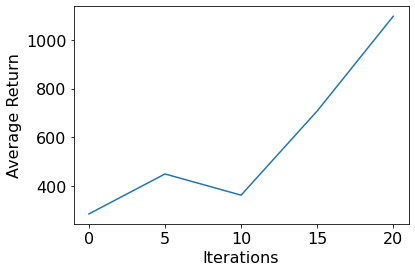

In [67]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)